In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

import os
from utils import tools
from sklearn import preprocessing
from torchviz import make_dot, make_dot_from_trace


# import FlowNetC
from networks import FlowNetC

from PIL import Image
import numpy as np
import pandas as pd

# import flowlib

from PIL import Image

import tqdm
import cv2
import csv
import time

In [206]:
cap = cv2.VideoCapture('data/caolin_foot_trial1-4.mp4')
name = 'caolin'

framerate = cap.get(5)
total_image = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f'The oringinal framerate is {cap.get(5)} with frame resolution of: {cap.get(3), cap.get(4)}')
print(f'The total number of frame in this video is {total_image}')

The oringinal framerate is 25.0 with frame resolution of: (768.0, 576.0)
The total number of frame in this video is 17155


In [207]:
count = 1
while(cap.isOpened()):
    frameID = cap.get(1) # get the current frame number
    ret, frame = cap.read()
    
    if(ret != True):
        print(f'We\'ve gotten {int(frameID/5)+1} frames from this video.')
        break
    # Take at 5Hz frequency which is framerate/5
    if (frameID % int(framerate/5) == 0):
        frame = frame[64:, 170:600 , :]
        filename = 'Train_1/'+ name + "_frame%04d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()

We've gotten 3432 frames from this video.


## Building Dataset

In [13]:
image_files = dataset.image_files

In [2]:
class MyDataset:
    
    def __init__(self, num_train_img = 3400, base_dir = '/home/projectx/Documents/GitHub repos/VINET_modification/', sequence = 'Train_1/'):  # base_dir(image) and sequence(lstm) are directories
        self.base_dir = base_dir
        self.sequence = sequence
        self.base_path_img = self.base_dir + self.sequence
        
        self.image_files = os.listdir(self.base_path_img)
        self.image_files.sort()
        self.image_files = self.image_files[0:num_train_img]
        
        # normalization for lstm data
        self.train_scaler = preprocessing.StandardScaler()
        
        ## Omega.7 and load cells
        self.input_lstm = self.read_OMEGA7_LC()
        
        
        self.imu_seq_len = 20
    
    def read_OMEGA7_LC(self, path='data/result_1.csv'):
        # read csv data
        df = pd.read_csv(path,header = None)
        df = df[:874300]
        
        # take moving average of every 10 data points
        new_df = df.groupby(df.index//10).mean()
        array_input = np.array(new_df)
        
        # normalization
        array_input_scaled = self.train_scaler.fit_transform(array_input)
        
        input_lstm  = Variable(torch.from_numpy(array_input_scaled).type(torch.FloatTensor))
        input_lstm = input_lstm[:80000,:]
        
        
        
        # reshape to (num_dataset, sequence_length, feature_size)
        input_lstm = input_lstm.view(-1,20,11)
        
        return np.array(input_lstm)
    
    
    def get_input_lstm(self):
        return self.input_lstm
    
    def __len__(self):
        return len(self.image_files)
    
    def load_img_bat(self, idx, batch):
        batch_x = []
        batch_input_lstm = []
        for i in range(batch):
            x_data_np_1 = np.array(Image.open(self.base_path_img + self.image_files[idx + i]))
            x_data_np_2 = np.array(Image.open(self.base_path_img + self.image_files[idx+1 + i]))
            x_data_np_1 = x_data_np_1.reshape(3,512,430)
            x_data_np_2 = x_data_np_2.reshape(3,512,430)

#             ## 3 channels
#             x_data_np_1 = np.array([x_data_np_1, x_data_np_1, x_data_np_1])
#             x_data_np_2 = np.array([x_data_np_2, x_data_np_2, x_data_np_2])

            X = np.array([x_data_np_1, x_data_np_2])
            batch_x.append(X)
        
#           self.input_lstm of size: (num_dataset, sequence_length, feature_size)
            tmp = np.array(self.input_lstm[idx + i])
            batch_input_lstm.append(tmp)
            
        
        batch_x = np.array(batch_x)
        batch_input_lstm = np.array(batch_input_lstm)
        
        X = Variable(torch.from_numpy(batch_x).type(torch.FloatTensor).cuda())    
        X2 = Variable(torch.from_numpy(batch_input_lstm).type(torch.FloatTensor).cuda())    
        
        Y = X2[:,:,-3:]
        
     
        return X, X2 , Y.mean(1)

In [3]:
dataset = MyDataset()

/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
lstm_data = dataset.get_input_lstm()

In [8]:
lstm_data.shape

(4000, 20, 11)

In [9]:
def plot_feature_dim(lstm_input):
    fig, axs = plt.subplots(4,3,figsize=(15,15))

    for i in range(4):
        for j in range(3):
            if (i == 3 and j == 2):
                break

            x = np.arange(0,80000)
            axs[i,j].plot(x,lstm_input[:,i*3+j])
            axs[i,j].set_title(f'Feature {i*3+j+1}')

/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(80000, 11)

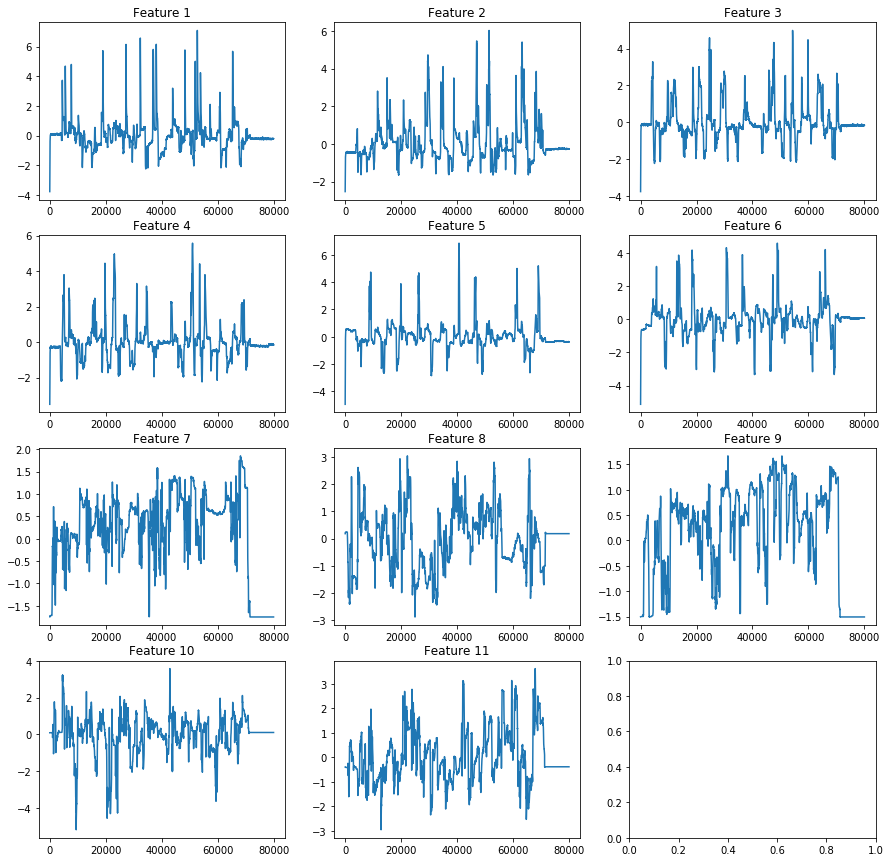

In [10]:
lstm_input = dataset.read_OMEGA7_LC()
lstm_input = lstm_input.reshape(4000*20, -1)
plot_feature_dim(lstm_input)
lstm_input.shape

In [11]:
class Vinet(nn.Module):
    def __init__(self):
        super(Vinet, self).__init__()
        self.rnn = nn.LSTM(
            input_size=57464,#49152,#24576, 
            hidden_size=1024,#64, 
            num_layers=2,
            batch_first=True)
        self.rnn.cuda()
        
        self.rnnIMU = nn.LSTM(
            input_size=11, 
            hidden_size=6,
            num_layers=2,
            batch_first=True)
        self.rnnIMU.cuda()
        
        self.linear1 = nn.Linear(1024, 128)
        self.linear2 = nn.Linear(128, 3)
        #self.linear3 = nn.Linear(128, 6)
        self.linear1.cuda()
        self.linear2.cuda()
        #self.linear3.cuda()
        
        # load checkpoint state from NVIDIA training
        checkpoint_pytorch = 'None'
#         checkpoint_pytorch = 'FlowNet2-C_checkpoint.pth.tar'
        #checkpoint_pytorch = '/notebooks/data/model/FlowNet2-SD_checkpoint.pth.tar'
        if os.path.isfile(checkpoint_pytorch):
            print('pre_trained_weights found')
            checkpoint = torch.load(checkpoint_pytorch,\
                                map_location=lambda storage, loc: storage.cuda(0))
            pop_list = ["deconv5.0.weight", "deconv5.0.bias", "deconv4.0.weight", "deconv4.0.bias", "deconv3.0.weight", "deconv3.0.bias", "deconv2.0.weight", "deconv2.0.bias", "predict_flow6.weight", "predict_flow6.bias", "predict_flow5.weight", "predict_flow5.bias", "predict_flow4.weight", "predict_flow4.bias", "predict_flow3.weight", "predict_flow3.bias", "predict_flow2.weight", "predict_flow2.bias", "upsampled_flow6_to_5.weight", "upsampled_flow6_to_5.bias", "upsampled_flow5_to_4.weight", "upsampled_flow5_to_4.bias", "upsampled_flow4_to_3.weight", "upsampled_flow4_to_3.bias", "upsampled_flow3_to_2.weight", "upsampled_flow3_to_2.bias"]
            for name in pop_list:
                checkpoint['state_dict'].pop(name);
        
        self.flownet_c = FlowNetC.FlowNetC(batchNorm=True)
        print('....creating model....')
#         self.flownet_c.load_state_dict(checkpoint['state_dict'])
#         print('....loading weights....')
        self.flownet_c.cuda()
        
        

    def forward(self, image, imu):
        batch_size, timesteps, C, H, W = image.size()
        
        ## Input1: Feed image pairs to FlownetC
        c_in = image.view(batch_size, timesteps * C, H, W)
        c_out = self.flownet_c(c_in)
#         print('c_out', c_out.shape)
        
        ## Input2: Feed IMU records to LSTM
        imu_out, (imu_n, imu_c) = self.rnnIMU(imu)
        # to match Vision output shape
        imu_out = imu_out.view(batch_size,1,-1)   # (batch_size, 1, total_hidden_size)
        
#         print('imu_out', imu_out.shape)
        
        
        ## Combine the output of input1 and 2 and feed it to LSTM
        #r_in = c_out.view(batch_size, timesteps, -1)
        r_in = c_out.view(batch_size, 1, -1)
#         print('r_in', r_in.shape)
        

        cat_out = torch.cat((r_in, imu_out), 2)#1 1 49158
#         print(cat_out.shape)
        
        
        r_out, (h_n, h_c) = self.rnn(cat_out)  # (1, 1, 1024)
#         print('r_out', r_out.shape)
        l_out1 = self.linear1(r_out[:,-1,:])
        l_out2 = self.linear2(l_out1)
        
#         print('r_ol_out2ut', l_out2.shape)
        #l_out3 = self.linear3(l_out2)

        return l_out2

### Test

In [12]:
model = Vinet()

....creating model....


In [13]:
dataset = MyDataset()
X, X2 , Y = dataset.load_img_bat(0,1)
X.size(), X2.size() , Y.size() 

/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(torch.Size([1, 2, 3, 512, 430]), torch.Size([1, 20, 11]), torch.Size([1, 3]))

In [14]:
output = model(X,X2)

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [15]:
(output.size(), Y.size())

(torch.Size([1, 3]), torch.Size([1, 3]))

In [16]:
criterion = nn.MSELoss()

loss = criterion(output, Y)

In [17]:
loss

tensor(0.8330, device='cuda:0', grad_fn=<MseLossBackward>)

## Visulization of network

In [197]:
image = X
imu   = X2
y = model(image, imu)
dot = make_dot(y, params = dict(list(model.named_parameters()) + [('x',X), ('x2',X2)]))

c_out torch.Size([1, 1024, 8, 7])
imu_out torch.Size([1, 1, 120])
r_in torch.Size([1, 1, 57344])
torch.Size([1, 1, 57464])
r_out torch.Size([1, 1, 1024])
r_ol_out2ut torch.Size([1, 3])


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [203]:
dot.save(filename='My_new_Network')

'My_new_Network'

In [204]:
dot.render()

'My_new_Network.pdf'

## Design the training loop

In [18]:
def train():
    # hyper-parameters
    epoch = 2
    batch = 1
    lr = 1e-5
    
    # creat model and dataset
    model = Vinet()
    mydataset = MyDataset()
    
    
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    # TensorBoard
    writer = SummaryWriter()
 
    model.train()
    
    mydataset = MyDataset()
    
#     criterion = nn.MSELoss()
    criterion  = nn.L1Loss(size_average=False)
    
    start = 5
    end = len(mydataset) - batch
    batch_num = (end - start)
    startT = time.time()
    
    with tools.TimerBlock("Start training") as block :
        for k in range(epoch):
            for i in range(start, end):
                data, data_lstm, target = mydataset.load_img_bat(i, batch)
                data, data_lstm, target = data.cuda(), data_lstm.cuda(), target.cuda()
                
                optimizer.zero_grad()
                
                # forward pass
                output = model(data, data_lstm)
                
                # compute loss
                loss = criterion(output, target)
                
                # backward pass
                loss.backward()
                torch.nn.utils.clip_grad_value_(model.parameters(), 1.0)
                optimizer.step()
                
                avgTime = block.avg()
                remainingTime = int((batch_num*epoch -  (i + batch_num*k)) * avgTime)
                rTime_str = "{:02d}:{:02d}:{:02d}".format(int(remainingTime/60//60), 
                                                          int(remainingTime//60%60), 
                                                          int(remainingTime%60))
                block.log(f'Train Epoch: {k}\t[{i}/{batch_num} ({(100.*(i + batch_num*k)):.0f}%)]\tLoss: {loss.data:.6f}, TimeAvg: {avgTime:.4f}, Remaining: {rTime_str}')
                          
                writer.add_scalar('loss', loss.data, k*batch_num + i)
                

                
                
                
            check_str = 'checkpoint_{}.pt'.format(k)
            if (k+1)%5 == 0:
                torch.save(model.state_dict(), check_str)
    
    torch.save(model.state_dict(), 'test_network_trial_1.pt')
    writer.export_scalars_to_json("./summary_writer.json")
    writer.close()

In [7]:
 train() 

....creating model....


/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Start training
  [0.857s] Train Epoch: 0	[0/3399 (0%)]	Loss: 0.752347, TimeAvg: 0.1566, Remaining: 00:17:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.701s] Train Epoch: 0	[1/3399 (100%)]	Loss: 0.752586, TimeAvg: 0.9923, Remaining: 01:52:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.547s] Train Epoch: 0	[2/3399 (200%)]	Loss: 0.755579, TimeAvg: 0.9194, Remaining: 01:44:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.403s] Train Epoch: 0	[3/3399 (300%)]	Loss: 0.751806, TimeAvg: 0.8966, Remaining: 01:41:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.256s] Train Epoch: 0	[4/3399 (400%)]	Loss: 0.751655, TimeAvg: 0.8893, Remaining: 01:40:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.104s] Train Epoch: 0	[5/3399 (500%)]	Loss: 0.759218, TimeAvg: 0.8798, Remaining: 01:39:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.954s] Train Epoch: 0	[6/3399 (600%)]	Loss: 0.764937, TimeAvg: 0.8748, Remaining: 01:39:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.800s] Train Epoch: 0	[7/3399 (700%)]	Loss: 0.760793, TimeAvg: 0.8712, Remaining: 01:38:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.644s] Train Epoch: 0	[8/3399 (800%)]	Loss: 0.768321, TimeAvg: 0.8683, Remaining: 01:38:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.495s] Train Epoch: 0	[9/3399 (900%)]	Loss: 0.780061, TimeAvg: 0.8654, Remaining: 01:37:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.347s] Train Epoch: 0	[10/3399 (1000%)]	Loss: 0.758029, TimeAvg: 0.8640, Remaining: 01:37:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.192s] Train Epoch: 0	[11/3399 (1100%)]	Loss: 0.754979, TimeAvg: 0.8628, Remaining: 01:37:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.038s] Train Epoch: 0	[12/3399 (1200%)]	Loss: 0.755777, TimeAvg: 0.8616, Remaining: 01:37:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.893s] Train Epoch: 0	[13/3399 (1300%)]	Loss: 0.757874, TimeAvg: 0.8602, Remaining: 01:37:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.752s] Train Epoch: 0	[14/3399 (1400%)]	Loss: 0.769699, TimeAvg: 0.8601, Remaining: 01:37:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.597s] Train Epoch: 0	[15/3399 (1500%)]	Loss: 0.762307, TimeAvg: 0.8596, Remaining: 01:37:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.447s] Train Epoch: 0	[16/3399 (1600%)]	Loss: 0.764121, TimeAvg: 0.8596, Remaining: 01:37:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.293s] Train Epoch: 0	[17/3399 (1700%)]	Loss: 0.750570, TimeAvg: 0.8584, Remaining: 01:37:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.137s] Train Epoch: 0	[18/3399 (1800%)]	Loss: 0.747881, TimeAvg: 0.8570, Remaining: 01:36:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.981s] Train Epoch: 0	[19/3399 (1900%)]	Loss: 0.760160, TimeAvg: 0.8565, Remaining: 01:36:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.826s] Train Epoch: 0	[20/3399 (2000%)]	Loss: 0.768772, TimeAvg: 0.8557, Remaining: 01:36:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.671s] Train Epoch: 0	[21/3399 (2100%)]	Loss: 0.752576, TimeAvg: 0.8557, Remaining: 01:36:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.523s] Train Epoch: 0	[22/3399 (2200%)]	Loss: 0.734222, TimeAvg: 0.8551, Remaining: 01:36:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.376s] Train Epoch: 0	[23/3399 (2300%)]	Loss: 0.772044, TimeAvg: 0.8553, Remaining: 01:36:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.219s] Train Epoch: 0	[24/3399 (2400%)]	Loss: 0.760541, TimeAvg: 0.8550, Remaining: 01:36:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.066s] Train Epoch: 0	[25/3399 (2500%)]	Loss: 0.761835, TimeAvg: 0.8541, Remaining: 01:36:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.912s] Train Epoch: 0	[26/3399 (2600%)]	Loss: 0.743680, TimeAvg: 0.8540, Remaining: 01:36:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.756s] Train Epoch: 0	[27/3399 (2700%)]	Loss: 0.770277, TimeAvg: 0.8536, Remaining: 01:36:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.604s] Train Epoch: 0	[28/3399 (2800%)]	Loss: 0.769095, TimeAvg: 0.8538, Remaining: 01:36:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.449s] Train Epoch: 0	[29/3399 (2900%)]	Loss: 0.757754, TimeAvg: 0.8534, Remaining: 01:36:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.296s] Train Epoch: 0	[30/3399 (3000%)]	Loss: 0.731147, TimeAvg: 0.8531, Remaining: 01:36:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.143s] Train Epoch: 0	[31/3399 (3100%)]	Loss: 0.734091, TimeAvg: 0.8527, Remaining: 01:36:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.988s] Train Epoch: 0	[32/3399 (3200%)]	Loss: 0.771136, TimeAvg: 0.8525, Remaining: 01:36:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.835s] Train Epoch: 0	[33/3399 (3300%)]	Loss: 0.741547, TimeAvg: 0.8522, Remaining: 01:36:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.682s] Train Epoch: 0	[34/3399 (3400%)]	Loss: 0.745636, TimeAvg: 0.8520, Remaining: 01:36:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.527s] Train Epoch: 0	[35/3399 (3500%)]	Loss: 0.752886, TimeAvg: 0.8519, Remaining: 01:36:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.375s] Train Epoch: 0	[36/3399 (3600%)]	Loss: 0.761963, TimeAvg: 0.8519, Remaining: 01:36:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.220s] Train Epoch: 0	[37/3399 (3700%)]	Loss: 0.757341, TimeAvg: 0.8516, Remaining: 01:35:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.065s] Train Epoch: 0	[38/3399 (3800%)]	Loss: 0.753788, TimeAvg: 0.8514, Remaining: 01:35:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.914s] Train Epoch: 0	[39/3399 (3900%)]	Loss: 0.767167, TimeAvg: 0.8518, Remaining: 01:35:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.760s] Train Epoch: 0	[40/3399 (4000%)]	Loss: 0.733858, TimeAvg: 0.8513, Remaining: 01:35:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.606s] Train Epoch: 0	[41/3399 (4100%)]	Loss: 0.744845, TimeAvg: 0.8513, Remaining: 01:35:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.450s] Train Epoch: 0	[42/3399 (4200%)]	Loss: 0.746333, TimeAvg: 0.8512, Remaining: 01:35:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.296s] Train Epoch: 0	[43/3399 (4300%)]	Loss: 0.754772, TimeAvg: 0.8511, Remaining: 01:35:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.143s] Train Epoch: 0	[44/3399 (4400%)]	Loss: 0.738744, TimeAvg: 0.8509, Remaining: 01:35:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.988s] Train Epoch: 0	[45/3399 (4500%)]	Loss: 0.734623, TimeAvg: 0.8508, Remaining: 01:35:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.832s] Train Epoch: 0	[46/3399 (4600%)]	Loss: 0.759302, TimeAvg: 0.8507, Remaining: 01:35:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.677s] Train Epoch: 0	[47/3399 (4700%)]	Loss: 0.742402, TimeAvg: 0.8506, Remaining: 01:35:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.521s] Train Epoch: 0	[48/3399 (4800%)]	Loss: 0.710493, TimeAvg: 0.8503, Remaining: 01:35:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.365s] Train Epoch: 0	[49/3399 (4900%)]	Loss: 0.683615, TimeAvg: 0.8501, Remaining: 01:35:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.207s] Train Epoch: 0	[50/3399 (5000%)]	Loss: 0.694671, TimeAvg: 0.8500, Remaining: 01:35:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.049s] Train Epoch: 0	[51/3399 (5100%)]	Loss: 0.692649, TimeAvg: 0.8499, Remaining: 01:35:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.902s] Train Epoch: 0	[52/3399 (5200%)]	Loss: 0.644605, TimeAvg: 0.8497, Remaining: 01:35:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.748s] Train Epoch: 0	[53/3399 (5300%)]	Loss: 0.602501, TimeAvg: 0.8498, Remaining: 01:35:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.590s] Train Epoch: 0	[54/3399 (5400%)]	Loss: 0.491972, TimeAvg: 0.8496, Remaining: 01:35:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.434s] Train Epoch: 0	[55/3399 (5500%)]	Loss: 0.296771, TimeAvg: 0.8496, Remaining: 01:35:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.280s] Train Epoch: 0	[56/3399 (5600%)]	Loss: 0.127289, TimeAvg: 0.8495, Remaining: 01:35:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.127s] Train Epoch: 0	[57/3399 (5700%)]	Loss: 0.100604, TimeAvg: 0.8494, Remaining: 01:35:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.972s] Train Epoch: 0	[58/3399 (5800%)]	Loss: 0.112237, TimeAvg: 0.8493, Remaining: 01:35:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.820s] Train Epoch: 0	[59/3399 (5900%)]	Loss: 0.109418, TimeAvg: 0.8493, Remaining: 01:35:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.664s] Train Epoch: 0	[60/3399 (6000%)]	Loss: 0.096181, TimeAvg: 0.8494, Remaining: 01:35:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.512s] Train Epoch: 0	[61/3399 (6100%)]	Loss: 0.166290, TimeAvg: 0.8493, Remaining: 01:35:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.366s] Train Epoch: 0	[62/3399 (6200%)]	Loss: 0.380637, TimeAvg: 0.8494, Remaining: 01:35:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.213s] Train Epoch: 0	[63/3399 (6300%)]	Loss: 0.686162, TimeAvg: 0.8494, Remaining: 01:35:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.056s] Train Epoch: 0	[64/3399 (6400%)]	Loss: 0.855685, TimeAvg: 0.8494, Remaining: 01:35:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.914s] Train Epoch: 0	[65/3399 (6500%)]	Loss: 0.967975, TimeAvg: 0.8496, Remaining: 01:35:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.777s] Train Epoch: 0	[66/3399 (6600%)]	Loss: 1.167383, TimeAvg: 0.8495, Remaining: 01:35:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.634s] Train Epoch: 0	[67/3399 (6700%)]	Loss: 1.194808, TimeAvg: 0.8499, Remaining: 01:35:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.477s] Train Epoch: 0	[68/3399 (6800%)]	Loss: 1.179598, TimeAvg: 0.8497, Remaining: 01:35:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.327s] Train Epoch: 0	[69/3399 (6900%)]	Loss: 1.134435, TimeAvg: 0.8497, Remaining: 01:35:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.003m] Train Epoch: 0	[70/3399 (7000%)]	Loss: 0.946950, TimeAvg: 0.8496, Remaining: 01:35:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.017m] Train Epoch: 0	[71/3399 (7100%)]	Loss: 0.672912, TimeAvg: 0.8496, Remaining: 01:35:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.031m] Train Epoch: 0	[72/3399 (7200%)]	Loss: 0.319388, TimeAvg: 0.8497, Remaining: 01:35:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.045m] Train Epoch: 0	[73/3399 (7300%)]	Loss: 0.067386, TimeAvg: 0.8496, Remaining: 01:35:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.059m] Train Epoch: 0	[74/3399 (7400%)]	Loss: 0.007818, TimeAvg: 0.8496, Remaining: 01:35:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.074m] Train Epoch: 0	[75/3399 (7500%)]	Loss: 0.044229, TimeAvg: 0.8496, Remaining: 01:35:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.088m] Train Epoch: 0	[76/3399 (7600%)]	Loss: 0.254233, TimeAvg: 0.8495, Remaining: 01:35:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.102m] Train Epoch: 0	[77/3399 (7700%)]	Loss: 0.671441, TimeAvg: 0.8494, Remaining: 01:35:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.116m] Train Epoch: 0	[78/3399 (7800%)]	Loss: 0.885639, TimeAvg: 0.8494, Remaining: 01:35:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.130m] Train Epoch: 0	[79/3399 (7900%)]	Loss: 0.903037, TimeAvg: 0.8493, Remaining: 01:35:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.144m] Train Epoch: 0	[80/3399 (8000%)]	Loss: 0.941862, TimeAvg: 0.8492, Remaining: 01:35:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.158m] Train Epoch: 0	[81/3399 (8100%)]	Loss: 1.045075, TimeAvg: 0.8492, Remaining: 01:35:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.172m] Train Epoch: 0	[82/3399 (8200%)]	Loss: 1.085579, TimeAvg: 0.8492, Remaining: 01:35:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.186m] Train Epoch: 0	[83/3399 (8300%)]	Loss: 0.974092, TimeAvg: 0.8491, Remaining: 01:35:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.200m] Train Epoch: 0	[84/3399 (8400%)]	Loss: 0.875523, TimeAvg: 0.8491, Remaining: 01:35:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.214m] Train Epoch: 0	[85/3399 (8500%)]	Loss: 0.759283, TimeAvg: 0.8490, Remaining: 01:34:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.228m] Train Epoch: 0	[86/3399 (8600%)]	Loss: 0.721131, TimeAvg: 0.8490, Remaining: 01:34:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.243m] Train Epoch: 0	[87/3399 (8700%)]	Loss: 0.743828, TimeAvg: 0.8489, Remaining: 01:34:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.257m] Train Epoch: 0	[88/3399 (8800%)]	Loss: 0.724479, TimeAvg: 0.8489, Remaining: 01:34:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.271m] Train Epoch: 0	[89/3399 (8900%)]	Loss: 0.708480, TimeAvg: 0.8488, Remaining: 01:34:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.285m] Train Epoch: 0	[90/3399 (9000%)]	Loss: 0.703701, TimeAvg: 0.8487, Remaining: 01:34:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.299m] Train Epoch: 0	[91/3399 (9100%)]	Loss: 0.712059, TimeAvg: 0.8486, Remaining: 01:34:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.313m] Train Epoch: 0	[92/3399 (9200%)]	Loss: 0.706644, TimeAvg: 0.8488, Remaining: 01:34:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.327m] Train Epoch: 0	[93/3399 (9300%)]	Loss: 0.702943, TimeAvg: 0.8488, Remaining: 01:34:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.341m] Train Epoch: 0	[94/3399 (9400%)]	Loss: 0.703900, TimeAvg: 0.8487, Remaining: 01:34:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.355m] Train Epoch: 0	[95/3399 (9500%)]	Loss: 0.687122, TimeAvg: 0.8486, Remaining: 01:34:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.369m] Train Epoch: 0	[96/3399 (9600%)]	Loss: 0.679340, TimeAvg: 0.8486, Remaining: 01:34:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.384m] Train Epoch: 0	[97/3399 (9700%)]	Loss: 0.737828, TimeAvg: 0.8486, Remaining: 01:34:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.398m] Train Epoch: 0	[98/3399 (9800%)]	Loss: 0.716135, TimeAvg: 0.8486, Remaining: 01:34:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.412m] Train Epoch: 0	[99/3399 (9900%)]	Loss: 0.717947, TimeAvg: 0.8489, Remaining: 01:34:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.426m] Train Epoch: 0	[100/3399 (10000%)]	Loss: 0.706043, TimeAvg: 0.8487, Remaining: 01:34:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.440m] Train Epoch: 0	[101/3399 (10100%)]	Loss: 0.706352, TimeAvg: 0.8486, Remaining: 01:34:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.454m] Train Epoch: 0	[102/3399 (10200%)]	Loss: 0.689378, TimeAvg: 0.8485, Remaining: 01:34:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.468m] Train Epoch: 0	[103/3399 (10300%)]	Loss: 0.688868, TimeAvg: 0.8485, Remaining: 01:34:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.482m] Train Epoch: 0	[104/3399 (10400%)]	Loss: 0.607241, TimeAvg: 0.8485, Remaining: 01:34:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.497m] Train Epoch: 0	[105/3399 (10500%)]	Loss: 0.473895, TimeAvg: 0.8485, Remaining: 01:34:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.511m] Train Epoch: 0	[106/3399 (10600%)]	Loss: 0.250918, TimeAvg: 0.8485, Remaining: 01:34:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.525m] Train Epoch: 0	[107/3399 (10700%)]	Loss: 0.314992, TimeAvg: 0.8484, Remaining: 01:34:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.539m] Train Epoch: 0	[108/3399 (10800%)]	Loss: 0.482760, TimeAvg: 0.8484, Remaining: 01:34:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.553m] Train Epoch: 0	[109/3399 (10900%)]	Loss: 0.388981, TimeAvg: 0.8484, Remaining: 01:34:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.567m] Train Epoch: 0	[110/3399 (11000%)]	Loss: 0.288438, TimeAvg: 0.8486, Remaining: 01:34:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.582m] Train Epoch: 0	[111/3399 (11100%)]	Loss: 0.257303, TimeAvg: 0.8486, Remaining: 01:34:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.596m] Train Epoch: 0	[112/3399 (11200%)]	Loss: 0.256372, TimeAvg: 0.8485, Remaining: 01:34:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.610m] Train Epoch: 0	[113/3399 (11300%)]	Loss: 0.193110, TimeAvg: 0.8487, Remaining: 01:34:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.624m] Train Epoch: 0	[114/3399 (11400%)]	Loss: 0.102861, TimeAvg: 0.8486, Remaining: 01:34:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.638m] Train Epoch: 0	[115/3399 (11500%)]	Loss: 0.083240, TimeAvg: 0.8487, Remaining: 01:34:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.652m] Train Epoch: 0	[116/3399 (11600%)]	Loss: 0.085116, TimeAvg: 0.8485, Remaining: 01:34:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.666m] Train Epoch: 0	[117/3399 (11700%)]	Loss: 0.083755, TimeAvg: 0.8485, Remaining: 01:34:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.680m] Train Epoch: 0	[118/3399 (11800%)]	Loss: 0.079942, TimeAvg: 0.8484, Remaining: 01:34:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.694m] Train Epoch: 0	[119/3399 (11900%)]	Loss: 0.078804, TimeAvg: 0.8484, Remaining: 01:34:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.709m] Train Epoch: 0	[120/3399 (12000%)]	Loss: 0.081031, TimeAvg: 0.8484, Remaining: 01:34:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.723m] Train Epoch: 0	[121/3399 (12100%)]	Loss: 0.083808, TimeAvg: 0.8484, Remaining: 01:34:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.737m] Train Epoch: 0	[122/3399 (12200%)]	Loss: 0.081034, TimeAvg: 0.8485, Remaining: 01:34:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.751m] Train Epoch: 0	[123/3399 (12300%)]	Loss: 0.082708, TimeAvg: 0.8483, Remaining: 01:34:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.765m] Train Epoch: 0	[124/3399 (12400%)]	Loss: 0.098668, TimeAvg: 0.8484, Remaining: 01:34:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.779m] Train Epoch: 0	[125/3399 (12500%)]	Loss: 0.114991, TimeAvg: 0.8483, Remaining: 01:34:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.793m] Train Epoch: 0	[126/3399 (12600%)]	Loss: 0.144002, TimeAvg: 0.8483, Remaining: 01:34:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.807m] Train Epoch: 0	[127/3399 (12700%)]	Loss: 0.171035, TimeAvg: 0.8483, Remaining: 01:34:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.821m] Train Epoch: 0	[128/3399 (12800%)]	Loss: 0.168799, TimeAvg: 0.8482, Remaining: 01:34:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.835m] Train Epoch: 0	[129/3399 (12900%)]	Loss: 0.174436, TimeAvg: 0.8482, Remaining: 01:34:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.849m] Train Epoch: 0	[130/3399 (13000%)]	Loss: 0.147646, TimeAvg: 0.8481, Remaining: 01:34:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.864m] Train Epoch: 0	[131/3399 (13100%)]	Loss: 0.116388, TimeAvg: 0.8481, Remaining: 01:34:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.878m] Train Epoch: 0	[132/3399 (13200%)]	Loss: 0.120070, TimeAvg: 0.8481, Remaining: 01:34:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.892m] Train Epoch: 0	[133/3399 (13300%)]	Loss: 0.084891, TimeAvg: 0.8481, Remaining: 01:34:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.906m] Train Epoch: 0	[134/3399 (13400%)]	Loss: 0.047841, TimeAvg: 0.8480, Remaining: 01:34:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.920m] Train Epoch: 0	[135/3399 (13500%)]	Loss: 0.031895, TimeAvg: 0.8480, Remaining: 01:34:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.934m] Train Epoch: 0	[136/3399 (13600%)]	Loss: 0.019434, TimeAvg: 0.8480, Remaining: 01:34:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.948m] Train Epoch: 0	[137/3399 (13700%)]	Loss: 0.014002, TimeAvg: 0.8480, Remaining: 01:34:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.962m] Train Epoch: 0	[138/3399 (13800%)]	Loss: 0.013011, TimeAvg: 0.8481, Remaining: 01:34:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.976m] Train Epoch: 0	[139/3399 (13900%)]	Loss: 0.011237, TimeAvg: 0.8480, Remaining: 01:34:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.990m] Train Epoch: 0	[140/3399 (14000%)]	Loss: 0.016650, TimeAvg: 0.8480, Remaining: 01:34:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.004m] Train Epoch: 0	[141/3399 (14100%)]	Loss: 0.027679, TimeAvg: 0.8480, Remaining: 01:34:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.019m] Train Epoch: 0	[142/3399 (14200%)]	Loss: 0.042721, TimeAvg: 0.8480, Remaining: 01:34:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.033m] Train Epoch: 0	[143/3399 (14300%)]	Loss: 0.052248, TimeAvg: 0.8480, Remaining: 01:34:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.047m] Train Epoch: 0	[144/3399 (14400%)]	Loss: 0.057419, TimeAvg: 0.8480, Remaining: 01:34:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.061m] Train Epoch: 0	[145/3399 (14500%)]	Loss: 0.090409, TimeAvg: 0.8480, Remaining: 01:34:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.075m] Train Epoch: 0	[146/3399 (14600%)]	Loss: 0.158135, TimeAvg: 0.8480, Remaining: 01:34:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.089m] Train Epoch: 0	[147/3399 (14700%)]	Loss: 0.306885, TimeAvg: 0.8480, Remaining: 01:33:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.103m] Train Epoch: 0	[148/3399 (14800%)]	Loss: 0.584223, TimeAvg: 0.8478, Remaining: 01:33:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.117m] Train Epoch: 0	[149/3399 (14900%)]	Loss: 0.754738, TimeAvg: 0.8479, Remaining: 01:33:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.131m] Train Epoch: 0	[150/3399 (15000%)]	Loss: 0.746656, TimeAvg: 0.8479, Remaining: 01:33:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.146m] Train Epoch: 0	[151/3399 (15100%)]	Loss: 0.752842, TimeAvg: 0.8479, Remaining: 01:33:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.160m] Train Epoch: 0	[152/3399 (15200%)]	Loss: 0.752707, TimeAvg: 0.8479, Remaining: 01:33:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.174m] Train Epoch: 0	[153/3399 (15300%)]	Loss: 0.745843, TimeAvg: 0.8479, Remaining: 01:33:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.188m] Train Epoch: 0	[154/3399 (15400%)]	Loss: 0.745832, TimeAvg: 0.8478, Remaining: 01:33:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.202m] Train Epoch: 0	[155/3399 (15500%)]	Loss: 0.744994, TimeAvg: 0.8478, Remaining: 01:33:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.216m] Train Epoch: 0	[156/3399 (15600%)]	Loss: 0.741764, TimeAvg: 0.8478, Remaining: 01:33:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.230m] Train Epoch: 0	[157/3399 (15700%)]	Loss: 0.737945, TimeAvg: 0.8478, Remaining: 01:33:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.244m] Train Epoch: 0	[158/3399 (15800%)]	Loss: 0.729183, TimeAvg: 0.8478, Remaining: 01:33:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.258m] Train Epoch: 0	[159/3399 (15900%)]	Loss: 0.736585, TimeAvg: 0.8478, Remaining: 01:33:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.272m] Train Epoch: 0	[160/3399 (16000%)]	Loss: 0.744705, TimeAvg: 0.8478, Remaining: 01:33:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.286m] Train Epoch: 0	[161/3399 (16100%)]	Loss: 0.743430, TimeAvg: 0.8478, Remaining: 01:33:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.301m] Train Epoch: 0	[162/3399 (16200%)]	Loss: 0.750890, TimeAvg: 0.8477, Remaining: 01:33:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.315m] Train Epoch: 0	[163/3399 (16300%)]	Loss: 0.735390, TimeAvg: 0.8477, Remaining: 01:33:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.329m] Train Epoch: 0	[164/3399 (16400%)]	Loss: 0.738306, TimeAvg: 0.8477, Remaining: 01:33:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.343m] Train Epoch: 0	[165/3399 (16500%)]	Loss: 0.724463, TimeAvg: 0.8477, Remaining: 01:33:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.357m] Train Epoch: 0	[166/3399 (16600%)]	Loss: 0.738406, TimeAvg: 0.8477, Remaining: 01:33:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.371m] Train Epoch: 0	[167/3399 (16700%)]	Loss: 0.733597, TimeAvg: 0.8477, Remaining: 01:33:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.385m] Train Epoch: 0	[168/3399 (16800%)]	Loss: 0.740303, TimeAvg: 0.8477, Remaining: 01:33:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.399m] Train Epoch: 0	[169/3399 (16900%)]	Loss: 0.739805, TimeAvg: 0.8477, Remaining: 01:33:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.413m] Train Epoch: 0	[170/3399 (17000%)]	Loss: 0.722246, TimeAvg: 0.8476, Remaining: 01:33:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.428m] Train Epoch: 0	[171/3399 (17100%)]	Loss: 0.727667, TimeAvg: 0.8477, Remaining: 01:33:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.442m] Train Epoch: 0	[172/3399 (17200%)]	Loss: 0.721771, TimeAvg: 0.8476, Remaining: 01:33:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.456m] Train Epoch: 0	[173/3399 (17300%)]	Loss: 0.710321, TimeAvg: 0.8476, Remaining: 01:33:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.470m] Train Epoch: 0	[174/3399 (17400%)]	Loss: 0.716434, TimeAvg: 0.8476, Remaining: 01:33:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.484m] Train Epoch: 0	[175/3399 (17500%)]	Loss: 0.708121, TimeAvg: 0.8475, Remaining: 01:33:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.498m] Train Epoch: 0	[176/3399 (17600%)]	Loss: 0.714652, TimeAvg: 0.8476, Remaining: 01:33:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.512m] Train Epoch: 0	[177/3399 (17700%)]	Loss: 0.733697, TimeAvg: 0.8476, Remaining: 01:33:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.526m] Train Epoch: 0	[178/3399 (17800%)]	Loss: 0.727381, TimeAvg: 0.8476, Remaining: 01:33:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.540m] Train Epoch: 0	[179/3399 (17900%)]	Loss: 0.724050, TimeAvg: 0.8476, Remaining: 01:33:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.554m] Train Epoch: 0	[180/3399 (18000%)]	Loss: 0.735458, TimeAvg: 0.8476, Remaining: 01:33:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.569m] Train Epoch: 0	[181/3399 (18100%)]	Loss: 0.730827, TimeAvg: 0.8476, Remaining: 01:33:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.583m] Train Epoch: 0	[182/3399 (18200%)]	Loss: 0.741880, TimeAvg: 0.8475, Remaining: 01:33:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.597m] Train Epoch: 0	[183/3399 (18300%)]	Loss: 0.742887, TimeAvg: 0.8475, Remaining: 01:33:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.611m] Train Epoch: 0	[184/3399 (18400%)]	Loss: 0.729918, TimeAvg: 0.8475, Remaining: 01:33:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.625m] Train Epoch: 0	[185/3399 (18500%)]	Loss: 0.731962, TimeAvg: 0.8475, Remaining: 01:33:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.639m] Train Epoch: 0	[186/3399 (18600%)]	Loss: 0.734163, TimeAvg: 0.8475, Remaining: 01:33:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.653m] Train Epoch: 0	[187/3399 (18700%)]	Loss: 0.731826, TimeAvg: 0.8476, Remaining: 01:33:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.667m] Train Epoch: 0	[188/3399 (18800%)]	Loss: 0.742761, TimeAvg: 0.8475, Remaining: 01:33:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.681m] Train Epoch: 0	[189/3399 (18900%)]	Loss: 0.709648, TimeAvg: 0.8476, Remaining: 01:33:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.695m] Train Epoch: 0	[190/3399 (19000%)]	Loss: 0.724963, TimeAvg: 0.8475, Remaining: 01:33:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.710m] Train Epoch: 0	[191/3399 (19100%)]	Loss: 0.706932, TimeAvg: 0.8475, Remaining: 01:33:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.724m] Train Epoch: 0	[192/3399 (19200%)]	Loss: 0.710022, TimeAvg: 0.8475, Remaining: 01:33:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.738m] Train Epoch: 0	[193/3399 (19300%)]	Loss: 0.716761, TimeAvg: 0.8475, Remaining: 01:33:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.752m] Train Epoch: 0	[194/3399 (19400%)]	Loss: 0.730264, TimeAvg: 0.8475, Remaining: 01:33:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.766m] Train Epoch: 0	[195/3399 (19500%)]	Loss: 0.735136, TimeAvg: 0.8476, Remaining: 01:33:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.780m] Train Epoch: 0	[196/3399 (19600%)]	Loss: 0.737078, TimeAvg: 0.8475, Remaining: 01:33:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.794m] Train Epoch: 0	[197/3399 (19700%)]	Loss: 0.741730, TimeAvg: 0.8475, Remaining: 01:33:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.808m] Train Epoch: 0	[198/3399 (19800%)]	Loss: 0.734026, TimeAvg: 0.8475, Remaining: 01:33:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.822m] Train Epoch: 0	[199/3399 (19900%)]	Loss: 0.733651, TimeAvg: 0.8474, Remaining: 01:33:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.837m] Train Epoch: 0	[200/3399 (20000%)]	Loss: 0.734930, TimeAvg: 0.8474, Remaining: 01:33:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.851m] Train Epoch: 0	[201/3399 (20100%)]	Loss: 0.727796, TimeAvg: 0.8475, Remaining: 01:33:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.865m] Train Epoch: 0	[202/3399 (20200%)]	Loss: 0.727866, TimeAvg: 0.8474, Remaining: 01:33:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.879m] Train Epoch: 0	[203/3399 (20300%)]	Loss: 0.716075, TimeAvg: 0.8475, Remaining: 01:33:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.893m] Train Epoch: 0	[204/3399 (20400%)]	Loss: 0.718321, TimeAvg: 0.8474, Remaining: 01:33:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.907m] Train Epoch: 0	[205/3399 (20500%)]	Loss: 0.721512, TimeAvg: 0.8474, Remaining: 01:33:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.921m] Train Epoch: 0	[206/3399 (20600%)]	Loss: 0.725712, TimeAvg: 0.8474, Remaining: 01:33:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.935m] Train Epoch: 0	[207/3399 (20700%)]	Loss: 0.724837, TimeAvg: 0.8474, Remaining: 01:33:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.949m] Train Epoch: 0	[208/3399 (20800%)]	Loss: 0.711194, TimeAvg: 0.8474, Remaining: 01:33:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.964m] Train Epoch: 0	[209/3399 (20900%)]	Loss: 0.722675, TimeAvg: 0.8474, Remaining: 01:33:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.978m] Train Epoch: 0	[210/3399 (21000%)]	Loss: 0.723140, TimeAvg: 0.8474, Remaining: 01:33:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.992m] Train Epoch: 0	[211/3399 (21100%)]	Loss: 0.733488, TimeAvg: 0.8474, Remaining: 01:33:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.006m] Train Epoch: 0	[212/3399 (21200%)]	Loss: 0.746695, TimeAvg: 0.8474, Remaining: 01:33:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.020m] Train Epoch: 0	[213/3399 (21300%)]	Loss: 0.735433, TimeAvg: 0.8474, Remaining: 01:33:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.034m] Train Epoch: 0	[214/3399 (21400%)]	Loss: 0.760905, TimeAvg: 0.8474, Remaining: 01:32:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.048m] Train Epoch: 0	[215/3399 (21500%)]	Loss: 0.740661, TimeAvg: 0.8474, Remaining: 01:32:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.062m] Train Epoch: 0	[216/3399 (21600%)]	Loss: 0.735665, TimeAvg: 0.8474, Remaining: 01:32:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.076m] Train Epoch: 0	[217/3399 (21700%)]	Loss: 0.723127, TimeAvg: 0.8473, Remaining: 01:32:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.090m] Train Epoch: 0	[218/3399 (21800%)]	Loss: 0.726352, TimeAvg: 0.8473, Remaining: 01:32:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.104m] Train Epoch: 0	[219/3399 (21900%)]	Loss: 0.716418, TimeAvg: 0.8473, Remaining: 01:32:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.119m] Train Epoch: 0	[220/3399 (22000%)]	Loss: 0.724127, TimeAvg: 0.8473, Remaining: 01:32:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.133m] Train Epoch: 0	[221/3399 (22100%)]	Loss: 0.734017, TimeAvg: 0.8473, Remaining: 01:32:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.147m] Train Epoch: 0	[222/3399 (22200%)]	Loss: 0.755049, TimeAvg: 0.8473, Remaining: 01:32:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.161m] Train Epoch: 0	[223/3399 (22300%)]	Loss: 0.749759, TimeAvg: 0.8474, Remaining: 01:32:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.175m] Train Epoch: 0	[224/3399 (22400%)]	Loss: 0.752087, TimeAvg: 0.8474, Remaining: 01:32:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.189m] Train Epoch: 0	[225/3399 (22500%)]	Loss: 1.332478, TimeAvg: 0.8474, Remaining: 01:32:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.203m] Train Epoch: 0	[226/3399 (22600%)]	Loss: 3.173899, TimeAvg: 0.8474, Remaining: 01:32:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.217m] Train Epoch: 0	[227/3399 (22700%)]	Loss: 4.166211, TimeAvg: 0.8473, Remaining: 01:32:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.231m] Train Epoch: 0	[228/3399 (22800%)]	Loss: 3.827863, TimeAvg: 0.8474, Remaining: 01:32:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.246m] Train Epoch: 0	[229/3399 (22900%)]	Loss: 3.221344, TimeAvg: 0.8473, Remaining: 01:32:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.260m] Train Epoch: 0	[230/3399 (23000%)]	Loss: 3.490281, TimeAvg: 0.8473, Remaining: 01:32:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.274m] Train Epoch: 0	[231/3399 (23100%)]	Loss: 3.469273, TimeAvg: 0.8473, Remaining: 01:32:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.288m] Train Epoch: 0	[232/3399 (23200%)]	Loss: 2.842850, TimeAvg: 0.8473, Remaining: 01:32:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.302m] Train Epoch: 0	[233/3399 (23300%)]	Loss: 2.318979, TimeAvg: 0.8472, Remaining: 01:32:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.316m] Train Epoch: 0	[234/3399 (23400%)]	Loss: 2.082920, TimeAvg: 0.8473, Remaining: 01:32:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.330m] Train Epoch: 0	[235/3399 (23500%)]	Loss: 2.058182, TimeAvg: 0.8473, Remaining: 01:32:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.344m] Train Epoch: 0	[236/3399 (23600%)]	Loss: 2.337590, TimeAvg: 0.8473, Remaining: 01:32:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.358m] Train Epoch: 0	[237/3399 (23700%)]	Loss: 2.510744, TimeAvg: 0.8473, Remaining: 01:32:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.372m] Train Epoch: 0	[238/3399 (23800%)]	Loss: 2.487839, TimeAvg: 0.8473, Remaining: 01:32:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.387m] Train Epoch: 0	[239/3399 (23900%)]	Loss: 2.588115, TimeAvg: 0.8473, Remaining: 01:32:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.401m] Train Epoch: 0	[240/3399 (24000%)]	Loss: 2.602222, TimeAvg: 0.8473, Remaining: 01:32:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.415m] Train Epoch: 0	[241/3399 (24100%)]	Loss: 2.544073, TimeAvg: 0.8472, Remaining: 01:32:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.429m] Train Epoch: 0	[242/3399 (24200%)]	Loss: 2.524758, TimeAvg: 0.8472, Remaining: 01:32:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.443m] Train Epoch: 0	[243/3399 (24300%)]	Loss: 2.516036, TimeAvg: 0.8472, Remaining: 01:32:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.457m] Train Epoch: 0	[244/3399 (24400%)]	Loss: 2.492960, TimeAvg: 0.8472, Remaining: 01:32:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.471m] Train Epoch: 0	[245/3399 (24500%)]	Loss: 2.521290, TimeAvg: 0.8472, Remaining: 01:32:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.485m] Train Epoch: 0	[246/3399 (24600%)]	Loss: 2.467453, TimeAvg: 0.8472, Remaining: 01:32:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.499m] Train Epoch: 0	[247/3399 (24700%)]	Loss: 2.447502, TimeAvg: 0.8472, Remaining: 01:32:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.513m] Train Epoch: 0	[248/3399 (24800%)]	Loss: 2.265639, TimeAvg: 0.8472, Remaining: 01:32:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.528m] Train Epoch: 0	[249/3399 (24900%)]	Loss: 1.993974, TimeAvg: 0.8472, Remaining: 01:32:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.542m] Train Epoch: 0	[250/3399 (25000%)]	Loss: 1.967442, TimeAvg: 0.8472, Remaining: 01:32:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.556m] Train Epoch: 0	[251/3399 (25100%)]	Loss: 1.855611, TimeAvg: 0.8472, Remaining: 01:32:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.570m] Train Epoch: 0	[252/3399 (25200%)]	Loss: 1.824882, TimeAvg: 0.8472, Remaining: 01:32:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.584m] Train Epoch: 0	[253/3399 (25300%)]	Loss: 1.767835, TimeAvg: 0.8472, Remaining: 01:32:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.598m] Train Epoch: 0	[254/3399 (25400%)]	Loss: 1.683139, TimeAvg: 0.8472, Remaining: 01:32:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.612m] Train Epoch: 0	[255/3399 (25500%)]	Loss: 1.706583, TimeAvg: 0.8471, Remaining: 01:32:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.626m] Train Epoch: 0	[256/3399 (25600%)]	Loss: 1.554837, TimeAvg: 0.8471, Remaining: 01:32:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.640m] Train Epoch: 0	[257/3399 (25700%)]	Loss: 0.955839, TimeAvg: 0.8471, Remaining: 01:32:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.654m] Train Epoch: 0	[258/3399 (25800%)]	Loss: 0.414281, TimeAvg: 0.8471, Remaining: 01:32:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.668m] Train Epoch: 0	[259/3399 (25900%)]	Loss: 0.276323, TimeAvg: 0.8471, Remaining: 01:32:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.682m] Train Epoch: 0	[260/3399 (26000%)]	Loss: 0.275382, TimeAvg: 0.8471, Remaining: 01:32:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.697m] Train Epoch: 0	[261/3399 (26100%)]	Loss: 0.177127, TimeAvg: 0.8471, Remaining: 01:32:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.711m] Train Epoch: 0	[262/3399 (26200%)]	Loss: 0.128510, TimeAvg: 0.8471, Remaining: 01:32:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.725m] Train Epoch: 0	[263/3399 (26300%)]	Loss: 0.300482, TimeAvg: 0.8471, Remaining: 01:32:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.739m] Train Epoch: 0	[264/3399 (26400%)]	Loss: 0.298780, TimeAvg: 0.8471, Remaining: 01:32:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.753m] Train Epoch: 0	[265/3399 (26500%)]	Loss: 0.204532, TimeAvg: 0.8471, Remaining: 01:32:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.767m] Train Epoch: 0	[266/3399 (26600%)]	Loss: 0.129876, TimeAvg: 0.8471, Remaining: 01:32:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.781m] Train Epoch: 0	[267/3399 (26700%)]	Loss: 0.147563, TimeAvg: 0.8471, Remaining: 01:32:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.795m] Train Epoch: 0	[268/3399 (26800%)]	Loss: 0.226684, TimeAvg: 0.8471, Remaining: 01:32:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.809m] Train Epoch: 0	[269/3399 (26900%)]	Loss: 0.224318, TimeAvg: 0.8470, Remaining: 01:32:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.823m] Train Epoch: 0	[270/3399 (27000%)]	Loss: 0.221575, TimeAvg: 0.8470, Remaining: 01:32:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.837m] Train Epoch: 0	[271/3399 (27100%)]	Loss: 0.226667, TimeAvg: 0.8471, Remaining: 01:32:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.852m] Train Epoch: 0	[272/3399 (27200%)]	Loss: 0.265863, TimeAvg: 0.8471, Remaining: 01:32:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.866m] Train Epoch: 0	[273/3399 (27300%)]	Loss: 0.340251, TimeAvg: 0.8471, Remaining: 01:32:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.880m] Train Epoch: 0	[274/3399 (27400%)]	Loss: 0.342979, TimeAvg: 0.8471, Remaining: 01:32:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.894m] Train Epoch: 0	[275/3399 (27500%)]	Loss: 0.327883, TimeAvg: 0.8471, Remaining: 01:32:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.908m] Train Epoch: 0	[276/3399 (27600%)]	Loss: 0.309059, TimeAvg: 0.8470, Remaining: 01:32:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.922m] Train Epoch: 0	[277/3399 (27700%)]	Loss: 0.314509, TimeAvg: 0.8471, Remaining: 01:32:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.936m] Train Epoch: 0	[278/3399 (27800%)]	Loss: 0.305425, TimeAvg: 0.8471, Remaining: 01:32:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.950m] Train Epoch: 0	[279/3399 (27900%)]	Loss: 0.306167, TimeAvg: 0.8471, Remaining: 01:32:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.964m] Train Epoch: 0	[280/3399 (28000%)]	Loss: 0.360097, TimeAvg: 0.8471, Remaining: 01:32:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.979m] Train Epoch: 0	[281/3399 (28100%)]	Loss: 0.405592, TimeAvg: 0.8470, Remaining: 01:32:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.993m] Train Epoch: 0	[282/3399 (28200%)]	Loss: 0.430845, TimeAvg: 0.8470, Remaining: 01:31:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.007m] Train Epoch: 0	[283/3399 (28300%)]	Loss: 0.447367, TimeAvg: 0.8470, Remaining: 01:31:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.021m] Train Epoch: 0	[284/3399 (28400%)]	Loss: 0.432501, TimeAvg: 0.8470, Remaining: 01:31:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.035m] Train Epoch: 0	[285/3399 (28500%)]	Loss: 0.437286, TimeAvg: 0.8470, Remaining: 01:31:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.049m] Train Epoch: 0	[286/3399 (28600%)]	Loss: 0.443165, TimeAvg: 0.8470, Remaining: 01:31:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.063m] Train Epoch: 0	[287/3399 (28700%)]	Loss: 0.438262, TimeAvg: 0.8470, Remaining: 01:31:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.077m] Train Epoch: 0	[288/3399 (28800%)]	Loss: 0.436879, TimeAvg: 0.8470, Remaining: 01:31:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.091m] Train Epoch: 0	[289/3399 (28900%)]	Loss: 0.440144, TimeAvg: 0.8470, Remaining: 01:31:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.105m] Train Epoch: 0	[290/3399 (29000%)]	Loss: 0.468529, TimeAvg: 0.8470, Remaining: 01:31:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.120m] Train Epoch: 0	[291/3399 (29100%)]	Loss: 0.466385, TimeAvg: 0.8470, Remaining: 01:31:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.134m] Train Epoch: 0	[292/3399 (29200%)]	Loss: 0.466486, TimeAvg: 0.8470, Remaining: 01:31:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.148m] Train Epoch: 0	[293/3399 (29300%)]	Loss: 0.525800, TimeAvg: 0.8470, Remaining: 01:31:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.162m] Train Epoch: 0	[294/3399 (29400%)]	Loss: 0.578446, TimeAvg: 0.8470, Remaining: 01:31:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.176m] Train Epoch: 0	[295/3399 (29500%)]	Loss: 0.589261, TimeAvg: 0.8470, Remaining: 01:31:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.190m] Train Epoch: 0	[296/3399 (29600%)]	Loss: 0.558877, TimeAvg: 0.8470, Remaining: 01:31:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.204m] Train Epoch: 0	[297/3399 (29700%)]	Loss: 0.524040, TimeAvg: 0.8470, Remaining: 01:31:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.218m] Train Epoch: 0	[298/3399 (29800%)]	Loss: 0.717752, TimeAvg: 0.8470, Remaining: 01:31:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.232m] Train Epoch: 0	[299/3399 (29900%)]	Loss: 0.805112, TimeAvg: 0.8470, Remaining: 01:31:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.247m] Train Epoch: 0	[300/3399 (30000%)]	Loss: 0.479939, TimeAvg: 0.8470, Remaining: 01:31:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.261m] Train Epoch: 0	[301/3399 (30100%)]	Loss: 0.253058, TimeAvg: 0.8469, Remaining: 01:31:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.275m] Train Epoch: 0	[302/3399 (30200%)]	Loss: 0.331947, TimeAvg: 0.8470, Remaining: 01:31:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.289m] Train Epoch: 0	[303/3399 (30300%)]	Loss: 0.486149, TimeAvg: 0.8470, Remaining: 01:31:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.303m] Train Epoch: 0	[304/3399 (30400%)]	Loss: 0.487473, TimeAvg: 0.8470, Remaining: 01:31:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.317m] Train Epoch: 0	[305/3399 (30500%)]	Loss: 0.382908, TimeAvg: 0.8470, Remaining: 01:31:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.331m] Train Epoch: 0	[306/3399 (30600%)]	Loss: 0.260181, TimeAvg: 0.8470, Remaining: 01:31:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.345m] Train Epoch: 0	[307/3399 (30700%)]	Loss: 0.222815, TimeAvg: 0.8470, Remaining: 01:31:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.359m] Train Epoch: 0	[308/3399 (30800%)]	Loss: 0.236726, TimeAvg: 0.8470, Remaining: 01:31:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.373m] Train Epoch: 0	[309/3399 (30900%)]	Loss: 0.275525, TimeAvg: 0.8470, Remaining: 01:31:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.388m] Train Epoch: 0	[310/3399 (31000%)]	Loss: 0.295210, TimeAvg: 0.8469, Remaining: 01:31:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.402m] Train Epoch: 0	[311/3399 (31100%)]	Loss: 0.257079, TimeAvg: 0.8470, Remaining: 01:31:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.416m] Train Epoch: 0	[312/3399 (31200%)]	Loss: 0.255191, TimeAvg: 0.8469, Remaining: 01:31:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.430m] Train Epoch: 0	[313/3399 (31300%)]	Loss: 0.243199, TimeAvg: 0.8470, Remaining: 01:31:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.444m] Train Epoch: 0	[314/3399 (31400%)]	Loss: 0.239021, TimeAvg: 0.8470, Remaining: 01:31:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.458m] Train Epoch: 0	[315/3399 (31500%)]	Loss: 0.254315, TimeAvg: 0.8470, Remaining: 01:31:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.472m] Train Epoch: 0	[316/3399 (31600%)]	Loss: 0.253539, TimeAvg: 0.8469, Remaining: 01:31:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.486m] Train Epoch: 0	[317/3399 (31700%)]	Loss: 0.272113, TimeAvg: 0.8469, Remaining: 01:31:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.500m] Train Epoch: 0	[318/3399 (31800%)]	Loss: 0.313535, TimeAvg: 0.8470, Remaining: 01:31:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.515m] Train Epoch: 0	[319/3399 (31900%)]	Loss: 0.304305, TimeAvg: 0.8469, Remaining: 01:31:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.529m] Train Epoch: 0	[320/3399 (32000%)]	Loss: 0.318026, TimeAvg: 0.8469, Remaining: 01:31:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.543m] Train Epoch: 0	[321/3399 (32100%)]	Loss: 0.345622, TimeAvg: 0.8469, Remaining: 01:31:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.557m] Train Epoch: 0	[322/3399 (32200%)]	Loss: 0.377938, TimeAvg: 0.8469, Remaining: 01:31:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.571m] Train Epoch: 0	[323/3399 (32300%)]	Loss: 0.388872, TimeAvg: 0.8469, Remaining: 01:31:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.585m] Train Epoch: 0	[324/3399 (32400%)]	Loss: 0.372727, TimeAvg: 0.8470, Remaining: 01:31:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.599m] Train Epoch: 0	[325/3399 (32500%)]	Loss: 0.350577, TimeAvg: 0.8470, Remaining: 01:31:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.613m] Train Epoch: 0	[326/3399 (32600%)]	Loss: 0.298713, TimeAvg: 0.8469, Remaining: 01:31:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.627m] Train Epoch: 0	[327/3399 (32700%)]	Loss: 0.186412, TimeAvg: 0.8469, Remaining: 01:31:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.642m] Train Epoch: 0	[328/3399 (32800%)]	Loss: 0.229355, TimeAvg: 0.8469, Remaining: 01:31:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.656m] Train Epoch: 0	[329/3399 (32900%)]	Loss: 0.355696, TimeAvg: 0.8469, Remaining: 01:31:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.670m] Train Epoch: 0	[330/3399 (33000%)]	Loss: 0.386500, TimeAvg: 0.8469, Remaining: 01:31:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.684m] Train Epoch: 0	[331/3399 (33100%)]	Loss: 0.367895, TimeAvg: 0.8469, Remaining: 01:31:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.698m] Train Epoch: 0	[332/3399 (33200%)]	Loss: 0.367928, TimeAvg: 0.8469, Remaining: 01:31:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.712m] Train Epoch: 0	[333/3399 (33300%)]	Loss: 0.455362, TimeAvg: 0.8469, Remaining: 01:31:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.726m] Train Epoch: 0	[334/3399 (33400%)]	Loss: 0.548170, TimeAvg: 0.8469, Remaining: 01:31:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.740m] Train Epoch: 0	[335/3399 (33500%)]	Loss: 0.568347, TimeAvg: 0.8469, Remaining: 01:31:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.754m] Train Epoch: 0	[336/3399 (33600%)]	Loss: 0.543549, TimeAvg: 0.8469, Remaining: 01:31:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.768m] Train Epoch: 0	[337/3399 (33700%)]	Loss: 0.534409, TimeAvg: 0.8469, Remaining: 01:31:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.783m] Train Epoch: 0	[338/3399 (33800%)]	Loss: 0.510180, TimeAvg: 0.8469, Remaining: 01:31:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.797m] Train Epoch: 0	[339/3399 (33900%)]	Loss: 0.480033, TimeAvg: 0.8469, Remaining: 01:31:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.811m] Train Epoch: 0	[340/3399 (34000%)]	Loss: 0.426710, TimeAvg: 0.8469, Remaining: 01:31:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.825m] Train Epoch: 0	[341/3399 (34100%)]	Loss: 0.387781, TimeAvg: 0.8469, Remaining: 01:31:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.839m] Train Epoch: 0	[342/3399 (34200%)]	Loss: 0.373510, TimeAvg: 0.8469, Remaining: 01:31:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.853m] Train Epoch: 0	[343/3399 (34300%)]	Loss: 0.364452, TimeAvg: 0.8469, Remaining: 01:31:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.867m] Train Epoch: 0	[344/3399 (34400%)]	Loss: 0.366892, TimeAvg: 0.8469, Remaining: 01:31:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.881m] Train Epoch: 0	[345/3399 (34500%)]	Loss: 0.389611, TimeAvg: 0.8469, Remaining: 01:31:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.896m] Train Epoch: 0	[346/3399 (34600%)]	Loss: 0.392207, TimeAvg: 0.8469, Remaining: 01:31:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.910m] Train Epoch: 0	[347/3399 (34700%)]	Loss: 0.385560, TimeAvg: 0.8469, Remaining: 01:31:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.924m] Train Epoch: 0	[348/3399 (34800%)]	Loss: 0.385356, TimeAvg: 0.8470, Remaining: 01:31:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.938m] Train Epoch: 0	[349/3399 (34900%)]	Loss: 0.385428, TimeAvg: 0.8469, Remaining: 01:31:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.952m] Train Epoch: 0	[350/3399 (35000%)]	Loss: 0.396767, TimeAvg: 0.8469, Remaining: 01:31:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.966m] Train Epoch: 0	[351/3399 (35100%)]	Loss: 0.397510, TimeAvg: 0.8469, Remaining: 01:31:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.980m] Train Epoch: 0	[352/3399 (35200%)]	Loss: 0.397656, TimeAvg: 0.8470, Remaining: 01:30:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.994m] Train Epoch: 0	[353/3399 (35300%)]	Loss: 0.403686, TimeAvg: 0.8469, Remaining: 01:30:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.008m] Train Epoch: 0	[354/3399 (35400%)]	Loss: 0.394506, TimeAvg: 0.8469, Remaining: 01:30:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.023m] Train Epoch: 0	[355/3399 (35500%)]	Loss: 0.322961, TimeAvg: 0.8469, Remaining: 01:30:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.037m] Train Epoch: 0	[356/3399 (35600%)]	Loss: 0.272025, TimeAvg: 0.8469, Remaining: 01:30:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.051m] Train Epoch: 0	[357/3399 (35700%)]	Loss: 0.555889, TimeAvg: 0.8469, Remaining: 01:30:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.065m] Train Epoch: 0	[358/3399 (35800%)]	Loss: 0.556428, TimeAvg: 0.8470, Remaining: 01:30:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.079m] Train Epoch: 0	[359/3399 (35900%)]	Loss: 0.482224, TimeAvg: 0.8469, Remaining: 01:30:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.093m] Train Epoch: 0	[360/3399 (36000%)]	Loss: 0.208488, TimeAvg: 0.8469, Remaining: 01:30:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.107m] Train Epoch: 0	[361/3399 (36100%)]	Loss: 0.087624, TimeAvg: 0.8469, Remaining: 01:30:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.121m] Train Epoch: 0	[362/3399 (36200%)]	Loss: 0.230447, TimeAvg: 0.8469, Remaining: 01:30:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.136m] Train Epoch: 0	[363/3399 (36300%)]	Loss: 0.370275, TimeAvg: 0.8469, Remaining: 01:30:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.150m] Train Epoch: 0	[364/3399 (36400%)]	Loss: 0.475087, TimeAvg: 0.8469, Remaining: 01:30:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.164m] Train Epoch: 0	[365/3399 (36500%)]	Loss: 0.477439, TimeAvg: 0.8469, Remaining: 01:30:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.178m] Train Epoch: 0	[366/3399 (36600%)]	Loss: 0.429609, TimeAvg: 0.8469, Remaining: 01:30:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.192m] Train Epoch: 0	[367/3399 (36700%)]	Loss: 0.432874, TimeAvg: 0.8469, Remaining: 01:30:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.206m] Train Epoch: 0	[368/3399 (36800%)]	Loss: 0.479472, TimeAvg: 0.8470, Remaining: 01:30:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.220m] Train Epoch: 0	[369/3399 (36900%)]	Loss: 0.717336, TimeAvg: 0.8470, Remaining: 01:30:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.234m] Train Epoch: 0	[370/3399 (37000%)]	Loss: 0.946971, TimeAvg: 0.8469, Remaining: 01:30:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.248m] Train Epoch: 0	[371/3399 (37100%)]	Loss: 1.096662, TimeAvg: 0.8470, Remaining: 01:30:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.262m] Train Epoch: 0	[372/3399 (37200%)]	Loss: 1.132411, TimeAvg: 0.8469, Remaining: 01:30:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.277m] Train Epoch: 0	[373/3399 (37300%)]	Loss: 1.058843, TimeAvg: 0.8469, Remaining: 01:30:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.291m] Train Epoch: 0	[374/3399 (37400%)]	Loss: 0.959564, TimeAvg: 0.8469, Remaining: 01:30:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.305m] Train Epoch: 0	[375/3399 (37500%)]	Loss: 0.930384, TimeAvg: 0.8469, Remaining: 01:30:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.319m] Train Epoch: 0	[376/3399 (37600%)]	Loss: 1.077441, TimeAvg: 0.8469, Remaining: 01:30:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.333m] Train Epoch: 0	[377/3399 (37700%)]	Loss: 1.195123, TimeAvg: 0.8470, Remaining: 01:30:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.347m] Train Epoch: 0	[378/3399 (37800%)]	Loss: 1.213495, TimeAvg: 0.8469, Remaining: 01:30:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.361m] Train Epoch: 0	[379/3399 (37900%)]	Loss: 1.228014, TimeAvg: 0.8469, Remaining: 01:30:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.375m] Train Epoch: 0	[380/3399 (38000%)]	Loss: 1.219417, TimeAvg: 0.8469, Remaining: 01:30:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.390m] Train Epoch: 0	[381/3399 (38100%)]	Loss: 1.211634, TimeAvg: 0.8469, Remaining: 01:30:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.404m] Train Epoch: 0	[382/3399 (38200%)]	Loss: 1.204241, TimeAvg: 0.8469, Remaining: 01:30:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.418m] Train Epoch: 0	[383/3399 (38300%)]	Loss: 1.184644, TimeAvg: 0.8469, Remaining: 01:30:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.432m] Train Epoch: 0	[384/3399 (38400%)]	Loss: 1.216151, TimeAvg: 0.8469, Remaining: 01:30:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.446m] Train Epoch: 0	[385/3399 (38500%)]	Loss: 1.207994, TimeAvg: 0.8469, Remaining: 01:30:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.460m] Train Epoch: 0	[386/3399 (38600%)]	Loss: 1.072531, TimeAvg: 0.8469, Remaining: 01:30:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.474m] Train Epoch: 0	[387/3399 (38700%)]	Loss: 1.065400, TimeAvg: 0.8469, Remaining: 01:30:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.488m] Train Epoch: 0	[388/3399 (38800%)]	Loss: 1.153478, TimeAvg: 0.8469, Remaining: 01:30:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.502m] Train Epoch: 0	[389/3399 (38900%)]	Loss: 1.177720, TimeAvg: 0.8469, Remaining: 01:30:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.516m] Train Epoch: 0	[390/3399 (39000%)]	Loss: 1.478270, TimeAvg: 0.8469, Remaining: 01:30:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.531m] Train Epoch: 0	[391/3399 (39100%)]	Loss: 1.780368, TimeAvg: 0.8469, Remaining: 01:30:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.545m] Train Epoch: 0	[392/3399 (39200%)]	Loss: 1.878633, TimeAvg: 0.8469, Remaining: 01:30:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.559m] Train Epoch: 0	[393/3399 (39300%)]	Loss: 1.700306, TimeAvg: 0.8469, Remaining: 01:30:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.573m] Train Epoch: 0	[394/3399 (39400%)]	Loss: 1.072557, TimeAvg: 0.8469, Remaining: 01:30:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.587m] Train Epoch: 0	[395/3399 (39500%)]	Loss: 0.716865, TimeAvg: 0.8469, Remaining: 01:30:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.601m] Train Epoch: 0	[396/3399 (39600%)]	Loss: 0.656269, TimeAvg: 0.8469, Remaining: 01:30:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.615m] Train Epoch: 0	[397/3399 (39700%)]	Loss: 0.620849, TimeAvg: 0.8469, Remaining: 01:30:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.629m] Train Epoch: 0	[398/3399 (39800%)]	Loss: 0.672943, TimeAvg: 0.8469, Remaining: 01:30:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.643m] Train Epoch: 0	[399/3399 (39900%)]	Loss: 0.792562, TimeAvg: 0.8469, Remaining: 01:30:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.657m] Train Epoch: 0	[400/3399 (40000%)]	Loss: 0.856628, TimeAvg: 0.8469, Remaining: 01:30:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.672m] Train Epoch: 0	[401/3399 (40100%)]	Loss: 0.950174, TimeAvg: 0.8469, Remaining: 01:30:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.686m] Train Epoch: 0	[402/3399 (40200%)]	Loss: 1.155003, TimeAvg: 0.8469, Remaining: 01:30:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.700m] Train Epoch: 0	[403/3399 (40300%)]	Loss: 1.266457, TimeAvg: 0.8469, Remaining: 01:30:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.714m] Train Epoch: 0	[404/3399 (40400%)]	Loss: 1.258771, TimeAvg: 0.8469, Remaining: 01:30:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.728m] Train Epoch: 0	[405/3399 (40500%)]	Loss: 1.237795, TimeAvg: 0.8469, Remaining: 01:30:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.742m] Train Epoch: 0	[406/3399 (40600%)]	Loss: 1.176184, TimeAvg: 0.8469, Remaining: 01:30:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.756m] Train Epoch: 0	[407/3399 (40700%)]	Loss: 1.178702, TimeAvg: 0.8469, Remaining: 01:30:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.770m] Train Epoch: 0	[408/3399 (40800%)]	Loss: 1.185197, TimeAvg: 0.8469, Remaining: 01:30:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.784m] Train Epoch: 0	[409/3399 (40900%)]	Loss: 1.198411, TimeAvg: 0.8469, Remaining: 01:30:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.799m] Train Epoch: 0	[410/3399 (41000%)]	Loss: 1.210581, TimeAvg: 0.8469, Remaining: 01:30:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.813m] Train Epoch: 0	[411/3399 (41100%)]	Loss: 1.216452, TimeAvg: 0.8469, Remaining: 01:30:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.827m] Train Epoch: 0	[412/3399 (41200%)]	Loss: 1.215178, TimeAvg: 0.8469, Remaining: 01:30:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.841m] Train Epoch: 0	[413/3399 (41300%)]	Loss: 1.228063, TimeAvg: 0.8469, Remaining: 01:30:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.855m] Train Epoch: 0	[414/3399 (41400%)]	Loss: 1.249249, TimeAvg: 0.8469, Remaining: 01:30:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.869m] Train Epoch: 0	[415/3399 (41500%)]	Loss: 1.242398, TimeAvg: 0.8469, Remaining: 01:30:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.883m] Train Epoch: 0	[416/3399 (41600%)]	Loss: 1.222417, TimeAvg: 0.8469, Remaining: 01:30:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.897m] Train Epoch: 0	[417/3399 (41700%)]	Loss: 0.992026, TimeAvg: 0.8469, Remaining: 01:30:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.911m] Train Epoch: 0	[418/3399 (41800%)]	Loss: 0.499827, TimeAvg: 0.8469, Remaining: 01:30:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.925m] Train Epoch: 0	[419/3399 (41900%)]	Loss: 0.198630, TimeAvg: 0.8469, Remaining: 01:30:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.940m] Train Epoch: 0	[420/3399 (42000%)]	Loss: 0.576314, TimeAvg: 0.8469, Remaining: 01:30:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.954m] Train Epoch: 0	[421/3399 (42100%)]	Loss: 0.811133, TimeAvg: 0.8469, Remaining: 01:30:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.968m] Train Epoch: 0	[422/3399 (42200%)]	Loss: 0.663436, TimeAvg: 0.8469, Remaining: 01:29:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.982m] Train Epoch: 0	[423/3399 (42300%)]	Loss: 0.508099, TimeAvg: 0.8468, Remaining: 01:29:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.996m] Train Epoch: 0	[424/3399 (42400%)]	Loss: 0.383292, TimeAvg: 0.8468, Remaining: 01:29:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.010m] Train Epoch: 0	[425/3399 (42500%)]	Loss: 0.262261, TimeAvg: 0.8468, Remaining: 01:29:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.024m] Train Epoch: 0	[426/3399 (42600%)]	Loss: 0.220268, TimeAvg: 0.8469, Remaining: 01:29:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.038m] Train Epoch: 0	[427/3399 (42700%)]	Loss: 0.211234, TimeAvg: 0.8469, Remaining: 01:29:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.052m] Train Epoch: 0	[428/3399 (42800%)]	Loss: 0.202697, TimeAvg: 0.8469, Remaining: 01:29:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.067m] Train Epoch: 0	[429/3399 (42900%)]	Loss: 0.210973, TimeAvg: 0.8468, Remaining: 01:29:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.081m] Train Epoch: 0	[430/3399 (43000%)]	Loss: 0.217231, TimeAvg: 0.8469, Remaining: 01:29:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.095m] Train Epoch: 0	[431/3399 (43100%)]	Loss: 0.218304, TimeAvg: 0.8469, Remaining: 01:29:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.109m] Train Epoch: 0	[432/3399 (43200%)]	Loss: 0.204934, TimeAvg: 0.8469, Remaining: 01:29:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.123m] Train Epoch: 0	[433/3399 (43300%)]	Loss: 0.263437, TimeAvg: 0.8469, Remaining: 01:29:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.137m] Train Epoch: 0	[434/3399 (43400%)]	Loss: 0.613377, TimeAvg: 0.8468, Remaining: 01:29:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.151m] Train Epoch: 0	[435/3399 (43500%)]	Loss: 1.293840, TimeAvg: 0.8468, Remaining: 01:29:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.165m] Train Epoch: 0	[436/3399 (43600%)]	Loss: 1.645108, TimeAvg: 0.8468, Remaining: 01:29:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.179m] Train Epoch: 0	[437/3399 (43700%)]	Loss: 1.769126, TimeAvg: 0.8468, Remaining: 01:29:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.194m] Train Epoch: 0	[438/3399 (43800%)]	Loss: 1.943599, TimeAvg: 0.8468, Remaining: 01:29:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.208m] Train Epoch: 0	[439/3399 (43900%)]	Loss: 1.942042, TimeAvg: 0.8468, Remaining: 01:29:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.222m] Train Epoch: 0	[440/3399 (44000%)]	Loss: 1.945240, TimeAvg: 0.8469, Remaining: 01:29:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.236m] Train Epoch: 0	[441/3399 (44100%)]	Loss: 1.790080, TimeAvg: 0.8468, Remaining: 01:29:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.250m] Train Epoch: 0	[442/3399 (44200%)]	Loss: 1.527207, TimeAvg: 0.8468, Remaining: 01:29:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.264m] Train Epoch: 0	[443/3399 (44300%)]	Loss: 1.412066, TimeAvg: 0.8468, Remaining: 01:29:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.278m] Train Epoch: 0	[444/3399 (44400%)]	Loss: 1.430111, TimeAvg: 0.8468, Remaining: 01:29:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.292m] Train Epoch: 0	[445/3399 (44500%)]	Loss: 1.423601, TimeAvg: 0.8469, Remaining: 01:29:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.306m] Train Epoch: 0	[446/3399 (44600%)]	Loss: 1.413375, TimeAvg: 0.8468, Remaining: 01:29:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.321m] Train Epoch: 0	[447/3399 (44700%)]	Loss: 1.580156, TimeAvg: 0.8468, Remaining: 01:29:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.335m] Train Epoch: 0	[448/3399 (44800%)]	Loss: 1.870525, TimeAvg: 0.8468, Remaining: 01:29:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.349m] Train Epoch: 0	[449/3399 (44900%)]	Loss: 1.930264, TimeAvg: 0.8469, Remaining: 01:29:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.363m] Train Epoch: 0	[450/3399 (45000%)]	Loss: 1.735118, TimeAvg: 0.8469, Remaining: 01:29:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.377m] Train Epoch: 0	[451/3399 (45100%)]	Loss: 1.725941, TimeAvg: 0.8469, Remaining: 01:29:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.391m] Train Epoch: 0	[452/3399 (45200%)]	Loss: 1.733397, TimeAvg: 0.8469, Remaining: 01:29:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.405m] Train Epoch: 0	[453/3399 (45300%)]	Loss: 1.540061, TimeAvg: 0.8468, Remaining: 01:29:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.419m] Train Epoch: 0	[454/3399 (45400%)]	Loss: 1.527099, TimeAvg: 0.8468, Remaining: 01:29:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.433m] Train Epoch: 0	[455/3399 (45500%)]	Loss: 1.464290, TimeAvg: 0.8469, Remaining: 01:29:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.448m] Train Epoch: 0	[456/3399 (45600%)]	Loss: 1.512758, TimeAvg: 0.8469, Remaining: 01:29:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.462m] Train Epoch: 0	[457/3399 (45700%)]	Loss: 1.968597, TimeAvg: 0.8468, Remaining: 01:29:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.476m] Train Epoch: 0	[458/3399 (45800%)]	Loss: 2.537044, TimeAvg: 0.8468, Remaining: 01:29:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.490m] Train Epoch: 0	[459/3399 (45900%)]	Loss: 3.114925, TimeAvg: 0.8468, Remaining: 01:29:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.504m] Train Epoch: 0	[460/3399 (46000%)]	Loss: 3.848720, TimeAvg: 0.8468, Remaining: 01:29:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.518m] Train Epoch: 0	[461/3399 (46100%)]	Loss: 4.104043, TimeAvg: 0.8468, Remaining: 01:29:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.532m] Train Epoch: 0	[462/3399 (46200%)]	Loss: 4.499377, TimeAvg: 0.8468, Remaining: 01:29:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.546m] Train Epoch: 0	[463/3399 (46300%)]	Loss: 4.732398, TimeAvg: 0.8468, Remaining: 01:29:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.560m] Train Epoch: 0	[464/3399 (46400%)]	Loss: 4.680129, TimeAvg: 0.8468, Remaining: 01:29:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.575m] Train Epoch: 0	[465/3399 (46500%)]	Loss: 4.765258, TimeAvg: 0.8469, Remaining: 01:29:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.589m] Train Epoch: 0	[466/3399 (46600%)]	Loss: 5.493927, TimeAvg: 0.8468, Remaining: 01:29:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.603m] Train Epoch: 0	[467/3399 (46700%)]	Loss: 6.492831, TimeAvg: 0.8468, Remaining: 01:29:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.617m] Train Epoch: 0	[468/3399 (46800%)]	Loss: 6.661112, TimeAvg: 0.8468, Remaining: 01:29:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.631m] Train Epoch: 0	[469/3399 (46900%)]	Loss: 6.123993, TimeAvg: 0.8468, Remaining: 01:29:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.645m] Train Epoch: 0	[470/3399 (47000%)]	Loss: 4.904042, TimeAvg: 0.8468, Remaining: 01:29:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.659m] Train Epoch: 0	[471/3399 (47100%)]	Loss: 5.380049, TimeAvg: 0.8468, Remaining: 01:29:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.673m] Train Epoch: 0	[472/3399 (47200%)]	Loss: 8.867809, TimeAvg: 0.8468, Remaining: 01:29:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.687m] Train Epoch: 0	[473/3399 (47300%)]	Loss: 8.707863, TimeAvg: 0.8468, Remaining: 01:29:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.701m] Train Epoch: 0	[474/3399 (47400%)]	Loss: 7.586258, TimeAvg: 0.8468, Remaining: 01:29:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.716m] Train Epoch: 0	[475/3399 (47500%)]	Loss: 7.202278, TimeAvg: 0.8468, Remaining: 01:29:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.730m] Train Epoch: 0	[476/3399 (47600%)]	Loss: 6.733031, TimeAvg: 0.8468, Remaining: 01:29:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.744m] Train Epoch: 0	[477/3399 (47700%)]	Loss: 6.296522, TimeAvg: 0.8468, Remaining: 01:29:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.758m] Train Epoch: 0	[478/3399 (47800%)]	Loss: 5.700637, TimeAvg: 0.8468, Remaining: 01:29:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.772m] Train Epoch: 0	[479/3399 (47900%)]	Loss: 5.205325, TimeAvg: 0.8468, Remaining: 01:29:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.786m] Train Epoch: 0	[480/3399 (48000%)]	Loss: 5.059013, TimeAvg: 0.8468, Remaining: 01:29:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.800m] Train Epoch: 0	[481/3399 (48100%)]	Loss: 5.076261, TimeAvg: 0.8468, Remaining: 01:29:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.814m] Train Epoch: 0	[482/3399 (48200%)]	Loss: 5.052538, TimeAvg: 0.8468, Remaining: 01:29:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.828m] Train Epoch: 0	[483/3399 (48300%)]	Loss: 4.817693, TimeAvg: 0.8468, Remaining: 01:29:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.843m] Train Epoch: 0	[484/3399 (48400%)]	Loss: 3.950891, TimeAvg: 0.8468, Remaining: 01:29:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.857m] Train Epoch: 0	[485/3399 (48500%)]	Loss: 2.693865, TimeAvg: 0.8468, Remaining: 01:29:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.871m] Train Epoch: 0	[486/3399 (48600%)]	Loss: 1.889454, TimeAvg: 0.8468, Remaining: 01:29:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.885m] Train Epoch: 0	[487/3399 (48700%)]	Loss: 1.547836, TimeAvg: 0.8468, Remaining: 01:29:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.899m] Train Epoch: 0	[488/3399 (48800%)]	Loss: 1.437157, TimeAvg: 0.8468, Remaining: 01:29:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.913m] Train Epoch: 0	[489/3399 (48900%)]	Loss: 1.370438, TimeAvg: 0.8468, Remaining: 01:29:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.927m] Train Epoch: 0	[490/3399 (49000%)]	Loss: 1.679204, TimeAvg: 0.8468, Remaining: 01:29:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.941m] Train Epoch: 0	[491/3399 (49100%)]	Loss: 2.074532, TimeAvg: 0.8468, Remaining: 01:29:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.955m] Train Epoch: 0	[492/3399 (49200%)]	Loss: 2.043721, TimeAvg: 0.8468, Remaining: 01:28:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.970m] Train Epoch: 0	[493/3399 (49300%)]	Loss: 1.845914, TimeAvg: 0.8468, Remaining: 01:28:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.984m] Train Epoch: 0	[494/3399 (49400%)]	Loss: 1.364007, TimeAvg: 0.8468, Remaining: 01:28:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.998m] Train Epoch: 0	[495/3399 (49500%)]	Loss: 0.718039, TimeAvg: 0.8468, Remaining: 01:28:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.012m] Train Epoch: 0	[496/3399 (49600%)]	Loss: 0.396542, TimeAvg: 0.8468, Remaining: 01:28:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.026m] Train Epoch: 0	[497/3399 (49700%)]	Loss: 0.313639, TimeAvg: 0.8468, Remaining: 01:28:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.040m] Train Epoch: 0	[498/3399 (49800%)]	Loss: 0.418574, TimeAvg: 0.8468, Remaining: 01:28:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.054m] Train Epoch: 0	[499/3399 (49900%)]	Loss: 0.517435, TimeAvg: 0.8468, Remaining: 01:28:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.068m] Train Epoch: 0	[500/3399 (50000%)]	Loss: 0.531365, TimeAvg: 0.8468, Remaining: 01:28:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.082m] Train Epoch: 0	[501/3399 (50100%)]	Loss: 0.875785, TimeAvg: 0.8468, Remaining: 01:28:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.096m] Train Epoch: 0	[502/3399 (50200%)]	Loss: 1.150260, TimeAvg: 0.8468, Remaining: 01:28:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.110m] Train Epoch: 0	[503/3399 (50300%)]	Loss: 1.131356, TimeAvg: 0.8468, Remaining: 01:28:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.125m] Train Epoch: 0	[504/3399 (50400%)]	Loss: 1.110755, TimeAvg: 0.8468, Remaining: 01:28:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.139m] Train Epoch: 0	[505/3399 (50500%)]	Loss: 1.038402, TimeAvg: 0.8468, Remaining: 01:28:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.153m] Train Epoch: 0	[506/3399 (50600%)]	Loss: 0.946377, TimeAvg: 0.8468, Remaining: 01:28:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.167m] Train Epoch: 0	[507/3399 (50700%)]	Loss: 0.924098, TimeAvg: 0.8468, Remaining: 01:28:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.181m] Train Epoch: 0	[508/3399 (50800%)]	Loss: 0.923368, TimeAvg: 0.8468, Remaining: 01:28:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.195m] Train Epoch: 0	[509/3399 (50900%)]	Loss: 0.893947, TimeAvg: 0.8468, Remaining: 01:28:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.209m] Train Epoch: 0	[510/3399 (51000%)]	Loss: 0.906025, TimeAvg: 0.8468, Remaining: 01:28:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.223m] Train Epoch: 0	[511/3399 (51100%)]	Loss: 0.879716, TimeAvg: 0.8468, Remaining: 01:28:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.238m] Train Epoch: 0	[512/3399 (51200%)]	Loss: 0.843427, TimeAvg: 0.8468, Remaining: 01:28:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.252m] Train Epoch: 0	[513/3399 (51300%)]	Loss: 0.856515, TimeAvg: 0.8468, Remaining: 01:28:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.266m] Train Epoch: 0	[514/3399 (51400%)]	Loss: 0.889747, TimeAvg: 0.8468, Remaining: 01:28:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.280m] Train Epoch: 0	[515/3399 (51500%)]	Loss: 0.879968, TimeAvg: 0.8468, Remaining: 01:28:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.294m] Train Epoch: 0	[516/3399 (51600%)]	Loss: 0.890323, TimeAvg: 0.8468, Remaining: 01:28:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.308m] Train Epoch: 0	[517/3399 (51700%)]	Loss: 0.886744, TimeAvg: 0.8468, Remaining: 01:28:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.322m] Train Epoch: 0	[518/3399 (51800%)]	Loss: 0.877819, TimeAvg: 0.8468, Remaining: 01:28:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.336m] Train Epoch: 0	[519/3399 (51900%)]	Loss: 0.880686, TimeAvg: 0.8468, Remaining: 01:28:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.350m] Train Epoch: 0	[520/3399 (52000%)]	Loss: 0.890219, TimeAvg: 0.8468, Remaining: 01:28:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.364m] Train Epoch: 0	[521/3399 (52100%)]	Loss: 0.912536, TimeAvg: 0.8468, Remaining: 01:28:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.379m] Train Epoch: 0	[522/3399 (52200%)]	Loss: 0.920265, TimeAvg: 0.8468, Remaining: 01:28:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.393m] Train Epoch: 0	[523/3399 (52300%)]	Loss: 0.902196, TimeAvg: 0.8468, Remaining: 01:28:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.407m] Train Epoch: 0	[524/3399 (52400%)]	Loss: 0.952980, TimeAvg: 0.8468, Remaining: 01:28:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.421m] Train Epoch: 0	[525/3399 (52500%)]	Loss: 0.915615, TimeAvg: 0.8468, Remaining: 01:28:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.435m] Train Epoch: 0	[526/3399 (52600%)]	Loss: 0.831895, TimeAvg: 0.8468, Remaining: 01:28:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.449m] Train Epoch: 0	[527/3399 (52700%)]	Loss: 0.775996, TimeAvg: 0.8468, Remaining: 01:28:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.463m] Train Epoch: 0	[528/3399 (52800%)]	Loss: 0.699238, TimeAvg: 0.8468, Remaining: 01:28:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.477m] Train Epoch: 0	[529/3399 (52900%)]	Loss: 0.567470, TimeAvg: 0.8468, Remaining: 01:28:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.492m] Train Epoch: 0	[530/3399 (53000%)]	Loss: 0.565165, TimeAvg: 0.8468, Remaining: 01:28:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.506m] Train Epoch: 0	[531/3399 (53100%)]	Loss: 0.624256, TimeAvg: 0.8468, Remaining: 01:28:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.520m] Train Epoch: 0	[532/3399 (53200%)]	Loss: 0.658894, TimeAvg: 0.8468, Remaining: 01:28:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.534m] Train Epoch: 0	[533/3399 (53300%)]	Loss: 0.617512, TimeAvg: 0.8468, Remaining: 01:28:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.548m] Train Epoch: 0	[534/3399 (53400%)]	Loss: 0.593643, TimeAvg: 0.8468, Remaining: 01:28:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.562m] Train Epoch: 0	[535/3399 (53500%)]	Loss: 0.698072, TimeAvg: 0.8468, Remaining: 01:28:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.576m] Train Epoch: 0	[536/3399 (53600%)]	Loss: 0.819682, TimeAvg: 0.8468, Remaining: 01:28:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.590m] Train Epoch: 0	[537/3399 (53700%)]	Loss: 0.819325, TimeAvg: 0.8468, Remaining: 01:28:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.605m] Train Epoch: 0	[538/3399 (53800%)]	Loss: 0.824242, TimeAvg: 0.8468, Remaining: 01:28:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.619m] Train Epoch: 0	[539/3399 (53900%)]	Loss: 0.830456, TimeAvg: 0.8468, Remaining: 01:28:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.633m] Train Epoch: 0	[540/3399 (54000%)]	Loss: 0.795255, TimeAvg: 0.8468, Remaining: 01:28:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.647m] Train Epoch: 0	[541/3399 (54100%)]	Loss: 0.812348, TimeAvg: 0.8468, Remaining: 01:28:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.661m] Train Epoch: 0	[542/3399 (54200%)]	Loss: 0.805730, TimeAvg: 0.8468, Remaining: 01:28:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.675m] Train Epoch: 0	[543/3399 (54300%)]	Loss: 0.799447, TimeAvg: 0.8468, Remaining: 01:28:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.689m] Train Epoch: 0	[544/3399 (54400%)]	Loss: 0.745640, TimeAvg: 0.8468, Remaining: 01:28:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.703m] Train Epoch: 0	[545/3399 (54500%)]	Loss: 0.729292, TimeAvg: 0.8468, Remaining: 01:28:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.717m] Train Epoch: 0	[546/3399 (54600%)]	Loss: 0.723759, TimeAvg: 0.8468, Remaining: 01:28:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.732m] Train Epoch: 0	[547/3399 (54700%)]	Loss: 0.726906, TimeAvg: 0.8468, Remaining: 01:28:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.746m] Train Epoch: 0	[548/3399 (54800%)]	Loss: 0.712669, TimeAvg: 0.8468, Remaining: 01:28:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.760m] Train Epoch: 0	[549/3399 (54900%)]	Loss: 0.685136, TimeAvg: 0.8468, Remaining: 01:28:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.774m] Train Epoch: 0	[550/3399 (55000%)]	Loss: 0.680561, TimeAvg: 0.8468, Remaining: 01:28:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.788m] Train Epoch: 0	[551/3399 (55100%)]	Loss: 0.680310, TimeAvg: 0.8468, Remaining: 01:28:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.802m] Train Epoch: 0	[552/3399 (55200%)]	Loss: 0.678474, TimeAvg: 0.8468, Remaining: 01:28:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.816m] Train Epoch: 0	[553/3399 (55300%)]	Loss: 0.682606, TimeAvg: 0.8468, Remaining: 01:28:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.830m] Train Epoch: 0	[554/3399 (55400%)]	Loss: 0.659617, TimeAvg: 0.8468, Remaining: 01:28:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.844m] Train Epoch: 0	[555/3399 (55500%)]	Loss: 0.633607, TimeAvg: 0.8468, Remaining: 01:28:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.859m] Train Epoch: 0	[556/3399 (55600%)]	Loss: 0.598261, TimeAvg: 0.8468, Remaining: 01:28:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.873m] Train Epoch: 0	[557/3399 (55700%)]	Loss: 0.570395, TimeAvg: 0.8468, Remaining: 01:28:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.887m] Train Epoch: 0	[558/3399 (55800%)]	Loss: 0.553662, TimeAvg: 0.8468, Remaining: 01:28:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.901m] Train Epoch: 0	[559/3399 (55900%)]	Loss: 0.523730, TimeAvg: 0.8468, Remaining: 01:28:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.915m] Train Epoch: 0	[560/3399 (56000%)]	Loss: 0.474411, TimeAvg: 0.8468, Remaining: 01:28:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.929m] Train Epoch: 0	[561/3399 (56100%)]	Loss: 0.425458, TimeAvg: 0.8468, Remaining: 01:28:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.943m] Train Epoch: 0	[562/3399 (56200%)]	Loss: 0.397429, TimeAvg: 0.8468, Remaining: 01:28:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.957m] Train Epoch: 0	[563/3399 (56300%)]	Loss: 0.448507, TimeAvg: 0.8468, Remaining: 01:27:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.972m] Train Epoch: 0	[564/3399 (56400%)]	Loss: 0.517359, TimeAvg: 0.8468, Remaining: 01:27:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.986m] Train Epoch: 0	[565/3399 (56500%)]	Loss: 0.584437, TimeAvg: 0.8468, Remaining: 01:27:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.000m] Train Epoch: 0	[566/3399 (56600%)]	Loss: 0.651163, TimeAvg: 0.8468, Remaining: 01:27:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.014m] Train Epoch: 0	[567/3399 (56700%)]	Loss: 0.661139, TimeAvg: 0.8468, Remaining: 01:27:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.028m] Train Epoch: 0	[568/3399 (56800%)]	Loss: 0.650531, TimeAvg: 0.8468, Remaining: 01:27:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.042m] Train Epoch: 0	[569/3399 (56900%)]	Loss: 0.651368, TimeAvg: 0.8468, Remaining: 01:27:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.056m] Train Epoch: 0	[570/3399 (57000%)]	Loss: 0.625330, TimeAvg: 0.8468, Remaining: 01:27:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.070m] Train Epoch: 0	[571/3399 (57100%)]	Loss: 0.618419, TimeAvg: 0.8468, Remaining: 01:27:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.084m] Train Epoch: 0	[572/3399 (57200%)]	Loss: 0.588048, TimeAvg: 0.8468, Remaining: 01:27:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.098m] Train Epoch: 0	[573/3399 (57300%)]	Loss: 0.565778, TimeAvg: 0.8468, Remaining: 01:27:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.113m] Train Epoch: 0	[574/3399 (57400%)]	Loss: 0.510434, TimeAvg: 0.8468, Remaining: 01:27:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.127m] Train Epoch: 0	[575/3399 (57500%)]	Loss: 0.440300, TimeAvg: 0.8468, Remaining: 01:27:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.141m] Train Epoch: 0	[576/3399 (57600%)]	Loss: 0.417830, TimeAvg: 0.8468, Remaining: 01:27:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.155m] Train Epoch: 0	[577/3399 (57700%)]	Loss: 0.424369, TimeAvg: 0.8468, Remaining: 01:27:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.169m] Train Epoch: 0	[578/3399 (57800%)]	Loss: 0.437694, TimeAvg: 0.8468, Remaining: 01:27:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.183m] Train Epoch: 0	[579/3399 (57900%)]	Loss: 0.447083, TimeAvg: 0.8468, Remaining: 01:27:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.197m] Train Epoch: 0	[580/3399 (58000%)]	Loss: 0.430380, TimeAvg: 0.8468, Remaining: 01:27:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.211m] Train Epoch: 0	[581/3399 (58100%)]	Loss: 0.450631, TimeAvg: 0.8468, Remaining: 01:27:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.225m] Train Epoch: 0	[582/3399 (58200%)]	Loss: 0.452043, TimeAvg: 0.8468, Remaining: 01:27:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.239m] Train Epoch: 0	[583/3399 (58300%)]	Loss: 0.435235, TimeAvg: 0.8468, Remaining: 01:27:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.254m] Train Epoch: 0	[584/3399 (58400%)]	Loss: 0.506808, TimeAvg: 0.8468, Remaining: 01:27:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.268m] Train Epoch: 0	[585/3399 (58500%)]	Loss: 0.483904, TimeAvg: 0.8468, Remaining: 01:27:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.282m] Train Epoch: 0	[586/3399 (58600%)]	Loss: 0.474477, TimeAvg: 0.8468, Remaining: 01:27:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.296m] Train Epoch: 0	[587/3399 (58700%)]	Loss: 0.445924, TimeAvg: 0.8467, Remaining: 01:27:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.310m] Train Epoch: 0	[588/3399 (58800%)]	Loss: 0.430367, TimeAvg: 0.8467, Remaining: 01:27:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.324m] Train Epoch: 0	[589/3399 (58900%)]	Loss: 0.426349, TimeAvg: 0.8468, Remaining: 01:27:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.338m] Train Epoch: 0	[590/3399 (59000%)]	Loss: 0.427789, TimeAvg: 0.8468, Remaining: 01:27:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.352m] Train Epoch: 0	[591/3399 (59100%)]	Loss: 0.417688, TimeAvg: 0.8468, Remaining: 01:27:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.366m] Train Epoch: 0	[592/3399 (59200%)]	Loss: 0.400265, TimeAvg: 0.8468, Remaining: 01:27:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.380m] Train Epoch: 0	[593/3399 (59300%)]	Loss: 0.387307, TimeAvg: 0.8468, Remaining: 01:27:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.395m] Train Epoch: 0	[594/3399 (59400%)]	Loss: 0.362167, TimeAvg: 0.8468, Remaining: 01:27:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.409m] Train Epoch: 0	[595/3399 (59500%)]	Loss: 0.335778, TimeAvg: 0.8468, Remaining: 01:27:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.423m] Train Epoch: 0	[596/3399 (59600%)]	Loss: 0.340392, TimeAvg: 0.8468, Remaining: 01:27:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.437m] Train Epoch: 0	[597/3399 (59700%)]	Loss: 0.334050, TimeAvg: 0.8468, Remaining: 01:27:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.451m] Train Epoch: 0	[598/3399 (59800%)]	Loss: 0.339242, TimeAvg: 0.8467, Remaining: 01:27:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.465m] Train Epoch: 0	[599/3399 (59900%)]	Loss: 0.394447, TimeAvg: 0.8468, Remaining: 01:27:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.479m] Train Epoch: 0	[600/3399 (60000%)]	Loss: 0.366510, TimeAvg: 0.8468, Remaining: 01:27:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.493m] Train Epoch: 0	[601/3399 (60100%)]	Loss: 0.376713, TimeAvg: 0.8468, Remaining: 01:27:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.507m] Train Epoch: 0	[602/3399 (60200%)]	Loss: 0.395996, TimeAvg: 0.8468, Remaining: 01:27:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.522m] Train Epoch: 0	[603/3399 (60300%)]	Loss: 0.372092, TimeAvg: 0.8468, Remaining: 01:27:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.536m] Train Epoch: 0	[604/3399 (60400%)]	Loss: 0.379006, TimeAvg: 0.8468, Remaining: 01:27:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.550m] Train Epoch: 0	[605/3399 (60500%)]	Loss: 0.396222, TimeAvg: 0.8468, Remaining: 01:27:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.564m] Train Epoch: 0	[606/3399 (60600%)]	Loss: 0.363397, TimeAvg: 0.8468, Remaining: 01:27:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.578m] Train Epoch: 0	[607/3399 (60700%)]	Loss: 0.360253, TimeAvg: 0.8467, Remaining: 01:27:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.592m] Train Epoch: 0	[608/3399 (60800%)]	Loss: 0.337304, TimeAvg: 0.8467, Remaining: 01:27:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.606m] Train Epoch: 0	[609/3399 (60900%)]	Loss: 0.310087, TimeAvg: 0.8467, Remaining: 01:27:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.620m] Train Epoch: 0	[610/3399 (61000%)]	Loss: 0.303276, TimeAvg: 0.8467, Remaining: 01:27:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.634m] Train Epoch: 0	[611/3399 (61100%)]	Loss: 0.312054, TimeAvg: 0.8467, Remaining: 01:27:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.648m] Train Epoch: 0	[612/3399 (61200%)]	Loss: 0.318770, TimeAvg: 0.8468, Remaining: 01:27:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.663m] Train Epoch: 0	[613/3399 (61300%)]	Loss: 0.316051, TimeAvg: 0.8468, Remaining: 01:27:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.677m] Train Epoch: 0	[614/3399 (61400%)]	Loss: 0.306516, TimeAvg: 0.8467, Remaining: 01:27:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.691m] Train Epoch: 0	[615/3399 (61500%)]	Loss: 0.308936, TimeAvg: 0.8468, Remaining: 01:27:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.705m] Train Epoch: 0	[616/3399 (61600%)]	Loss: 0.307474, TimeAvg: 0.8467, Remaining: 01:27:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.719m] Train Epoch: 0	[617/3399 (61700%)]	Loss: 0.318360, TimeAvg: 0.8467, Remaining: 01:27:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.733m] Train Epoch: 0	[618/3399 (61800%)]	Loss: 0.314934, TimeAvg: 0.8467, Remaining: 01:27:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.747m] Train Epoch: 0	[619/3399 (61900%)]	Loss: 0.308529, TimeAvg: 0.8467, Remaining: 01:27:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.761m] Train Epoch: 0	[620/3399 (62000%)]	Loss: 0.320427, TimeAvg: 0.8467, Remaining: 01:27:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.776m] Train Epoch: 0	[621/3399 (62100%)]	Loss: 0.308336, TimeAvg: 0.8467, Remaining: 01:27:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.790m] Train Epoch: 0	[622/3399 (62200%)]	Loss: 0.328517, TimeAvg: 0.8468, Remaining: 01:27:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.804m] Train Epoch: 0	[623/3399 (62300%)]	Loss: 0.328788, TimeAvg: 0.8467, Remaining: 01:27:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.818m] Train Epoch: 0	[624/3399 (62400%)]	Loss: 0.330340, TimeAvg: 0.8467, Remaining: 01:27:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.832m] Train Epoch: 0	[625/3399 (62500%)]	Loss: 0.312262, TimeAvg: 0.8467, Remaining: 01:27:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.846m] Train Epoch: 0	[626/3399 (62600%)]	Loss: 0.316300, TimeAvg: 0.8467, Remaining: 01:27:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.860m] Train Epoch: 0	[627/3399 (62700%)]	Loss: 0.353775, TimeAvg: 0.8467, Remaining: 01:27:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.874m] Train Epoch: 0	[628/3399 (62800%)]	Loss: 0.401807, TimeAvg: 0.8468, Remaining: 01:27:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.888m] Train Epoch: 0	[629/3399 (62900%)]	Loss: 0.399041, TimeAvg: 0.8468, Remaining: 01:27:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.903m] Train Epoch: 0	[630/3399 (63000%)]	Loss: 0.405182, TimeAvg: 0.8468, Remaining: 01:27:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.917m] Train Epoch: 0	[631/3399 (63100%)]	Loss: 0.411227, TimeAvg: 0.8468, Remaining: 01:27:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.931m] Train Epoch: 0	[632/3399 (63200%)]	Loss: 0.399755, TimeAvg: 0.8468, Remaining: 01:27:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.945m] Train Epoch: 0	[633/3399 (63300%)]	Loss: 0.392742, TimeAvg: 0.8468, Remaining: 01:27:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.959m] Train Epoch: 0	[634/3399 (63400%)]	Loss: 0.390958, TimeAvg: 0.8468, Remaining: 01:26:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.973m] Train Epoch: 0	[635/3399 (63500%)]	Loss: 0.409275, TimeAvg: 0.8468, Remaining: 01:26:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.987m] Train Epoch: 0	[636/3399 (63600%)]	Loss: 0.445880, TimeAvg: 0.8468, Remaining: 01:26:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.001m] Train Epoch: 0	[637/3399 (63700%)]	Loss: 0.458074, TimeAvg: 0.8468, Remaining: 01:26:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.015m] Train Epoch: 0	[638/3399 (63800%)]	Loss: 0.445000, TimeAvg: 0.8467, Remaining: 01:26:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.030m] Train Epoch: 0	[639/3399 (63900%)]	Loss: 0.485427, TimeAvg: 0.8468, Remaining: 01:26:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.044m] Train Epoch: 0	[640/3399 (64000%)]	Loss: 1.614866, TimeAvg: 0.8467, Remaining: 01:26:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.058m] Train Epoch: 0	[641/3399 (64100%)]	Loss: 2.907856, TimeAvg: 0.8468, Remaining: 01:26:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.072m] Train Epoch: 0	[642/3399 (64200%)]	Loss: 2.667603, TimeAvg: 0.8468, Remaining: 01:26:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.086m] Train Epoch: 0	[643/3399 (64300%)]	Loss: 2.312249, TimeAvg: 0.8468, Remaining: 01:26:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.100m] Train Epoch: 0	[644/3399 (64400%)]	Loss: 1.988814, TimeAvg: 0.8468, Remaining: 01:26:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.114m] Train Epoch: 0	[645/3399 (64500%)]	Loss: 1.620737, TimeAvg: 0.8468, Remaining: 01:26:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.129m] Train Epoch: 0	[646/3399 (64600%)]	Loss: 1.326359, TimeAvg: 0.8468, Remaining: 01:26:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.143m] Train Epoch: 0	[647/3399 (64700%)]	Loss: 1.265254, TimeAvg: 0.8468, Remaining: 01:26:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.157m] Train Epoch: 0	[648/3399 (64800%)]	Loss: 1.321675, TimeAvg: 0.8468, Remaining: 01:26:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.171m] Train Epoch: 0	[649/3399 (64900%)]	Loss: 1.252591, TimeAvg: 0.8468, Remaining: 01:26:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.185m] Train Epoch: 0	[650/3399 (65000%)]	Loss: 1.180575, TimeAvg: 0.8468, Remaining: 01:26:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.199m] Train Epoch: 0	[651/3399 (65100%)]	Loss: 1.151100, TimeAvg: 0.8467, Remaining: 01:26:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.213m] Train Epoch: 0	[652/3399 (65200%)]	Loss: 1.147318, TimeAvg: 0.8467, Remaining: 01:26:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.227m] Train Epoch: 0	[653/3399 (65300%)]	Loss: 1.231691, TimeAvg: 0.8468, Remaining: 01:26:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.241m] Train Epoch: 0	[654/3399 (65400%)]	Loss: 1.740835, TimeAvg: 0.8467, Remaining: 01:26:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.255m] Train Epoch: 0	[655/3399 (65500%)]	Loss: 2.171497, TimeAvg: 0.8467, Remaining: 01:26:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.269m] Train Epoch: 0	[656/3399 (65600%)]	Loss: 1.682460, TimeAvg: 0.8467, Remaining: 01:26:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.284m] Train Epoch: 0	[657/3399 (65700%)]	Loss: 1.105688, TimeAvg: 0.8467, Remaining: 01:26:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.298m] Train Epoch: 0	[658/3399 (65800%)]	Loss: 0.881909, TimeAvg: 0.8467, Remaining: 01:26:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.312m] Train Epoch: 0	[659/3399 (65900%)]	Loss: 0.820950, TimeAvg: 0.8467, Remaining: 01:26:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.326m] Train Epoch: 0	[660/3399 (66000%)]	Loss: 0.800729, TimeAvg: 0.8467, Remaining: 01:26:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.340m] Train Epoch: 0	[661/3399 (66100%)]	Loss: 0.669271, TimeAvg: 0.8467, Remaining: 01:26:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.354m] Train Epoch: 0	[662/3399 (66200%)]	Loss: 0.428386, TimeAvg: 0.8467, Remaining: 01:26:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.368m] Train Epoch: 0	[663/3399 (66300%)]	Loss: 0.382461, TimeAvg: 0.8467, Remaining: 01:26:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.382m] Train Epoch: 0	[664/3399 (66400%)]	Loss: 0.459923, TimeAvg: 0.8467, Remaining: 01:26:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.396m] Train Epoch: 0	[665/3399 (66500%)]	Loss: 0.429761, TimeAvg: 0.8467, Remaining: 01:26:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.410m] Train Epoch: 0	[666/3399 (66600%)]	Loss: 0.424564, TimeAvg: 0.8467, Remaining: 01:26:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.424m] Train Epoch: 0	[667/3399 (66700%)]	Loss: 0.413301, TimeAvg: 0.8467, Remaining: 01:26:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.439m] Train Epoch: 0	[668/3399 (66800%)]	Loss: 0.361933, TimeAvg: 0.8467, Remaining: 01:26:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.453m] Train Epoch: 0	[669/3399 (66900%)]	Loss: 0.331042, TimeAvg: 0.8467, Remaining: 01:26:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.467m] Train Epoch: 0	[670/3399 (67000%)]	Loss: 0.299635, TimeAvg: 0.8467, Remaining: 01:26:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.481m] Train Epoch: 0	[671/3399 (67100%)]	Loss: 0.276678, TimeAvg: 0.8467, Remaining: 01:26:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.495m] Train Epoch: 0	[672/3399 (67200%)]	Loss: 0.266255, TimeAvg: 0.8467, Remaining: 01:26:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.509m] Train Epoch: 0	[673/3399 (67300%)]	Loss: 0.248823, TimeAvg: 0.8467, Remaining: 01:26:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.523m] Train Epoch: 0	[674/3399 (67400%)]	Loss: 0.268616, TimeAvg: 0.8467, Remaining: 01:26:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.537m] Train Epoch: 0	[675/3399 (67500%)]	Loss: 0.259120, TimeAvg: 0.8467, Remaining: 01:26:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.551m] Train Epoch: 0	[676/3399 (67600%)]	Loss: 0.225709, TimeAvg: 0.8467, Remaining: 01:26:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.565m] Train Epoch: 0	[677/3399 (67700%)]	Loss: 0.209955, TimeAvg: 0.8467, Remaining: 01:26:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.579m] Train Epoch: 0	[678/3399 (67800%)]	Loss: 0.203645, TimeAvg: 0.8467, Remaining: 01:26:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.593m] Train Epoch: 0	[679/3399 (67900%)]	Loss: 0.186144, TimeAvg: 0.8467, Remaining: 01:26:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.607m] Train Epoch: 0	[680/3399 (68000%)]	Loss: 0.191146, TimeAvg: 0.8467, Remaining: 01:26:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.622m] Train Epoch: 0	[681/3399 (68100%)]	Loss: 0.187328, TimeAvg: 0.8467, Remaining: 01:26:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.636m] Train Epoch: 0	[682/3399 (68200%)]	Loss: 0.235616, TimeAvg: 0.8467, Remaining: 01:26:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.650m] Train Epoch: 0	[683/3399 (68300%)]	Loss: 0.352988, TimeAvg: 0.8467, Remaining: 01:26:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.664m] Train Epoch: 0	[684/3399 (68400%)]	Loss: 0.460449, TimeAvg: 0.8467, Remaining: 01:26:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.678m] Train Epoch: 0	[685/3399 (68500%)]	Loss: 0.510902, TimeAvg: 0.8467, Remaining: 01:26:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.692m] Train Epoch: 0	[686/3399 (68600%)]	Loss: 0.481134, TimeAvg: 0.8467, Remaining: 01:26:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.706m] Train Epoch: 0	[687/3399 (68700%)]	Loss: 0.452475, TimeAvg: 0.8467, Remaining: 01:26:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.720m] Train Epoch: 0	[688/3399 (68800%)]	Loss: 0.436594, TimeAvg: 0.8467, Remaining: 01:26:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.735m] Train Epoch: 0	[689/3399 (68900%)]	Loss: 0.406973, TimeAvg: 0.8467, Remaining: 01:26:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.749m] Train Epoch: 0	[690/3399 (69000%)]	Loss: 0.377840, TimeAvg: 0.8467, Remaining: 01:26:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.763m] Train Epoch: 0	[691/3399 (69100%)]	Loss: 0.360090, TimeAvg: 0.8467, Remaining: 01:26:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.777m] Train Epoch: 0	[692/3399 (69200%)]	Loss: 0.355817, TimeAvg: 0.8467, Remaining: 01:26:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.791m] Train Epoch: 0	[693/3399 (69300%)]	Loss: 0.340037, TimeAvg: 0.8467, Remaining: 01:26:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.805m] Train Epoch: 0	[694/3399 (69400%)]	Loss: 0.340451, TimeAvg: 0.8467, Remaining: 01:26:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.819m] Train Epoch: 0	[695/3399 (69500%)]	Loss: 0.349601, TimeAvg: 0.8467, Remaining: 01:26:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.833m] Train Epoch: 0	[696/3399 (69600%)]	Loss: 0.333029, TimeAvg: 0.8467, Remaining: 01:26:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.847m] Train Epoch: 0	[697/3399 (69700%)]	Loss: 0.329253, TimeAvg: 0.8467, Remaining: 01:26:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.861m] Train Epoch: 0	[698/3399 (69800%)]	Loss: 0.367764, TimeAvg: 0.8467, Remaining: 01:26:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.876m] Train Epoch: 0	[699/3399 (69900%)]	Loss: 0.361756, TimeAvg: 0.8467, Remaining: 01:26:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.890m] Train Epoch: 0	[700/3399 (70000%)]	Loss: 0.355358, TimeAvg: 0.8467, Remaining: 01:26:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.904m] Train Epoch: 0	[701/3399 (70100%)]	Loss: 0.344910, TimeAvg: 0.8467, Remaining: 01:26:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.918m] Train Epoch: 0	[702/3399 (70200%)]	Loss: 0.339532, TimeAvg: 0.8467, Remaining: 01:26:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.932m] Train Epoch: 0	[703/3399 (70300%)]	Loss: 0.346576, TimeAvg: 0.8467, Remaining: 01:26:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.946m] Train Epoch: 0	[704/3399 (70400%)]	Loss: 0.316795, TimeAvg: 0.8467, Remaining: 01:25:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.960m] Train Epoch: 0	[705/3399 (70500%)]	Loss: 0.355171, TimeAvg: 0.8467, Remaining: 01:25:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.974m] Train Epoch: 0	[706/3399 (70600%)]	Loss: 0.380213, TimeAvg: 0.8467, Remaining: 01:25:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.989m] Train Epoch: 0	[707/3399 (70700%)]	Loss: 0.404952, TimeAvg: 0.8467, Remaining: 01:25:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.003m] Train Epoch: 0	[708/3399 (70800%)]	Loss: 0.443450, TimeAvg: 0.8467, Remaining: 01:25:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.017m] Train Epoch: 0	[709/3399 (70900%)]	Loss: 0.511829, TimeAvg: 0.8467, Remaining: 01:25:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.031m] Train Epoch: 0	[710/3399 (71000%)]	Loss: 0.594893, TimeAvg: 0.8467, Remaining: 01:25:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.045m] Train Epoch: 0	[711/3399 (71100%)]	Loss: 0.699605, TimeAvg: 0.8467, Remaining: 01:25:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.059m] Train Epoch: 0	[712/3399 (71200%)]	Loss: 0.803209, TimeAvg: 0.8467, Remaining: 01:25:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.073m] Train Epoch: 0	[713/3399 (71300%)]	Loss: 0.898199, TimeAvg: 0.8467, Remaining: 01:25:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.087m] Train Epoch: 0	[714/3399 (71400%)]	Loss: 0.640251, TimeAvg: 0.8467, Remaining: 01:25:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.102m] Train Epoch: 0	[715/3399 (71500%)]	Loss: 0.366608, TimeAvg: 0.8467, Remaining: 01:25:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.116m] Train Epoch: 0	[716/3399 (71600%)]	Loss: 0.214517, TimeAvg: 0.8467, Remaining: 01:25:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.130m] Train Epoch: 0	[717/3399 (71700%)]	Loss: 0.104696, TimeAvg: 0.8467, Remaining: 01:25:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.144m] Train Epoch: 0	[718/3399 (71800%)]	Loss: 0.040151, TimeAvg: 0.8467, Remaining: 01:25:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.158m] Train Epoch: 0	[719/3399 (71900%)]	Loss: 0.031660, TimeAvg: 0.8467, Remaining: 01:25:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.172m] Train Epoch: 0	[720/3399 (72000%)]	Loss: 0.037555, TimeAvg: 0.8467, Remaining: 01:25:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.186m] Train Epoch: 0	[721/3399 (72100%)]	Loss: 0.036274, TimeAvg: 0.8467, Remaining: 01:25:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.200m] Train Epoch: 0	[722/3399 (72200%)]	Loss: 0.031313, TimeAvg: 0.8467, Remaining: 01:25:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.214m] Train Epoch: 0	[723/3399 (72300%)]	Loss: 0.028725, TimeAvg: 0.8467, Remaining: 01:25:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.228m] Train Epoch: 0	[724/3399 (72400%)]	Loss: 0.040845, TimeAvg: 0.8467, Remaining: 01:25:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.243m] Train Epoch: 0	[725/3399 (72500%)]	Loss: 0.037735, TimeAvg: 0.8467, Remaining: 01:25:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.257m] Train Epoch: 0	[726/3399 (72600%)]	Loss: 0.043307, TimeAvg: 0.8467, Remaining: 01:25:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.271m] Train Epoch: 0	[727/3399 (72700%)]	Loss: 0.051869, TimeAvg: 0.8468, Remaining: 01:25:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.285m] Train Epoch: 0	[728/3399 (72800%)]	Loss: 0.050888, TimeAvg: 0.8467, Remaining: 01:25:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.299m] Train Epoch: 0	[729/3399 (72900%)]	Loss: 0.055952, TimeAvg: 0.8467, Remaining: 01:25:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.313m] Train Epoch: 0	[730/3399 (73000%)]	Loss: 0.059609, TimeAvg: 0.8467, Remaining: 01:25:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.328m] Train Epoch: 0	[731/3399 (73100%)]	Loss: 0.105863, TimeAvg: 0.8467, Remaining: 01:25:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.342m] Train Epoch: 0	[732/3399 (73200%)]	Loss: 0.269075, TimeAvg: 0.8467, Remaining: 01:25:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.356m] Train Epoch: 0	[733/3399 (73300%)]	Loss: 0.308576, TimeAvg: 0.8467, Remaining: 01:25:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.370m] Train Epoch: 0	[734/3399 (73400%)]	Loss: 0.365937, TimeAvg: 0.8467, Remaining: 01:25:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.384m] Train Epoch: 0	[735/3399 (73500%)]	Loss: 0.523914, TimeAvg: 0.8467, Remaining: 01:25:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.398m] Train Epoch: 0	[736/3399 (73600%)]	Loss: 0.691736, TimeAvg: 0.8467, Remaining: 01:25:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.412m] Train Epoch: 0	[737/3399 (73700%)]	Loss: 0.806963, TimeAvg: 0.8467, Remaining: 01:25:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.426m] Train Epoch: 0	[738/3399 (73800%)]	Loss: 0.762404, TimeAvg: 0.8467, Remaining: 01:25:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.441m] Train Epoch: 0	[739/3399 (73900%)]	Loss: 0.795652, TimeAvg: 0.8467, Remaining: 01:25:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.455m] Train Epoch: 0	[740/3399 (74000%)]	Loss: 0.988098, TimeAvg: 0.8467, Remaining: 01:25:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.469m] Train Epoch: 0	[741/3399 (74100%)]	Loss: 1.094543, TimeAvg: 0.8467, Remaining: 01:25:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.483m] Train Epoch: 0	[742/3399 (74200%)]	Loss: 1.099307, TimeAvg: 0.8467, Remaining: 01:25:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.497m] Train Epoch: 0	[743/3399 (74300%)]	Loss: 1.085312, TimeAvg: 0.8467, Remaining: 01:25:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.511m] Train Epoch: 0	[744/3399 (74400%)]	Loss: 1.052105, TimeAvg: 0.8467, Remaining: 01:25:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.525m] Train Epoch: 0	[745/3399 (74500%)]	Loss: 1.000507, TimeAvg: 0.8467, Remaining: 01:25:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.539m] Train Epoch: 0	[746/3399 (74600%)]	Loss: 0.944647, TimeAvg: 0.8467, Remaining: 01:25:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.553m] Train Epoch: 0	[747/3399 (74700%)]	Loss: 0.814766, TimeAvg: 0.8467, Remaining: 01:25:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.567m] Train Epoch: 0	[748/3399 (74800%)]	Loss: 0.664034, TimeAvg: 0.8467, Remaining: 01:25:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.582m] Train Epoch: 0	[749/3399 (74900%)]	Loss: 0.541875, TimeAvg: 0.8467, Remaining: 01:25:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.596m] Train Epoch: 0	[750/3399 (75000%)]	Loss: 0.490160, TimeAvg: 0.8467, Remaining: 01:25:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.610m] Train Epoch: 0	[751/3399 (75100%)]	Loss: 0.456457, TimeAvg: 0.8467, Remaining: 01:25:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.624m] Train Epoch: 0	[752/3399 (75200%)]	Loss: 0.390098, TimeAvg: 0.8467, Remaining: 01:25:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.638m] Train Epoch: 0	[753/3399 (75300%)]	Loss: 0.333901, TimeAvg: 0.8467, Remaining: 01:25:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.652m] Train Epoch: 0	[754/3399 (75400%)]	Loss: 0.319948, TimeAvg: 0.8467, Remaining: 01:25:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.667m] Train Epoch: 0	[755/3399 (75500%)]	Loss: 0.291244, TimeAvg: 0.8468, Remaining: 01:25:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.681m] Train Epoch: 0	[756/3399 (75600%)]	Loss: 0.276680, TimeAvg: 0.8467, Remaining: 01:25:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.695m] Train Epoch: 0	[757/3399 (75700%)]	Loss: 0.270134, TimeAvg: 0.8468, Remaining: 01:25:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.709m] Train Epoch: 0	[758/3399 (75800%)]	Loss: 0.254220, TimeAvg: 0.8468, Remaining: 01:25:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.723m] Train Epoch: 0	[759/3399 (75900%)]	Loss: 0.216057, TimeAvg: 0.8468, Remaining: 01:25:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.737m] Train Epoch: 0	[760/3399 (76000%)]	Loss: 0.167281, TimeAvg: 0.8468, Remaining: 01:25:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.751m] Train Epoch: 0	[761/3399 (76100%)]	Loss: 0.167184, TimeAvg: 0.8468, Remaining: 01:25:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.765m] Train Epoch: 0	[762/3399 (76200%)]	Loss: 0.193405, TimeAvg: 0.8468, Remaining: 01:25:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.779m] Train Epoch: 0	[763/3399 (76300%)]	Loss: 0.232596, TimeAvg: 0.8468, Remaining: 01:25:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.794m] Train Epoch: 0	[764/3399 (76400%)]	Loss: 0.232327, TimeAvg: 0.8467, Remaining: 01:25:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.808m] Train Epoch: 0	[765/3399 (76500%)]	Loss: 0.210506, TimeAvg: 0.8467, Remaining: 01:25:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.822m] Train Epoch: 0	[766/3399 (76600%)]	Loss: 0.210638, TimeAvg: 0.8467, Remaining: 01:25:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.836m] Train Epoch: 0	[767/3399 (76700%)]	Loss: 0.208063, TimeAvg: 0.8467, Remaining: 01:25:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.850m] Train Epoch: 0	[768/3399 (76800%)]	Loss: 0.211482, TimeAvg: 0.8467, Remaining: 01:25:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.864m] Train Epoch: 0	[769/3399 (76900%)]	Loss: 0.216928, TimeAvg: 0.8467, Remaining: 01:25:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.878m] Train Epoch: 0	[770/3399 (77000%)]	Loss: 0.209481, TimeAvg: 0.8468, Remaining: 01:25:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.892m] Train Epoch: 0	[771/3399 (77100%)]	Loss: 0.199063, TimeAvg: 0.8468, Remaining: 01:25:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.907m] Train Epoch: 0	[772/3399 (77200%)]	Loss: 0.179056, TimeAvg: 0.8468, Remaining: 01:25:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.921m] Train Epoch: 0	[773/3399 (77300%)]	Loss: 0.167822, TimeAvg: 0.8468, Remaining: 01:25:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.935m] Train Epoch: 0	[774/3399 (77400%)]	Loss: 0.159370, TimeAvg: 0.8468, Remaining: 01:25:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.949m] Train Epoch: 0	[775/3399 (77500%)]	Loss: 0.141709, TimeAvg: 0.8468, Remaining: 01:25:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.963m] Train Epoch: 0	[776/3399 (77600%)]	Loss: 0.143783, TimeAvg: 0.8468, Remaining: 01:24:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.977m] Train Epoch: 0	[777/3399 (77700%)]	Loss: 0.140334, TimeAvg: 0.8468, Remaining: 01:24:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.991m] Train Epoch: 0	[778/3399 (77800%)]	Loss: 0.155851, TimeAvg: 0.8468, Remaining: 01:24:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.006m] Train Epoch: 0	[779/3399 (77900%)]	Loss: 0.153775, TimeAvg: 0.8468, Remaining: 01:24:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.020m] Train Epoch: 0	[780/3399 (78000%)]	Loss: 0.153047, TimeAvg: 0.8468, Remaining: 01:24:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.034m] Train Epoch: 0	[781/3399 (78100%)]	Loss: 0.139063, TimeAvg: 0.8468, Remaining: 01:24:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.048m] Train Epoch: 0	[782/3399 (78200%)]	Loss: 0.143872, TimeAvg: 0.8468, Remaining: 01:24:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.062m] Train Epoch: 0	[783/3399 (78300%)]	Loss: 0.144355, TimeAvg: 0.8468, Remaining: 01:24:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.076m] Train Epoch: 0	[784/3399 (78400%)]	Loss: 0.138620, TimeAvg: 0.8468, Remaining: 01:24:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.090m] Train Epoch: 0	[785/3399 (78500%)]	Loss: 0.137140, TimeAvg: 0.8468, Remaining: 01:24:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.104m] Train Epoch: 0	[786/3399 (78600%)]	Loss: 0.146975, TimeAvg: 0.8468, Remaining: 01:24:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.119m] Train Epoch: 0	[787/3399 (78700%)]	Loss: 0.152314, TimeAvg: 0.8468, Remaining: 01:24:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.133m] Train Epoch: 0	[788/3399 (78800%)]	Loss: 0.172668, TimeAvg: 0.8468, Remaining: 01:24:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.147m] Train Epoch: 0	[789/3399 (78900%)]	Loss: 0.222296, TimeAvg: 0.8468, Remaining: 01:24:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.161m] Train Epoch: 0	[790/3399 (79000%)]	Loss: 0.308097, TimeAvg: 0.8468, Remaining: 01:24:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.175m] Train Epoch: 0	[791/3399 (79100%)]	Loss: 0.297854, TimeAvg: 0.8468, Remaining: 01:24:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.189m] Train Epoch: 0	[792/3399 (79200%)]	Loss: 0.307966, TimeAvg: 0.8468, Remaining: 01:24:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.203m] Train Epoch: 0	[793/3399 (79300%)]	Loss: 0.388831, TimeAvg: 0.8468, Remaining: 01:24:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.217m] Train Epoch: 0	[794/3399 (79400%)]	Loss: 0.437625, TimeAvg: 0.8468, Remaining: 01:24:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.232m] Train Epoch: 0	[795/3399 (79500%)]	Loss: 0.472788, TimeAvg: 0.8468, Remaining: 01:24:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.246m] Train Epoch: 0	[796/3399 (79600%)]	Loss: 0.480512, TimeAvg: 0.8468, Remaining: 01:24:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.260m] Train Epoch: 0	[797/3399 (79700%)]	Loss: 0.510469, TimeAvg: 0.8468, Remaining: 01:24:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.274m] Train Epoch: 0	[798/3399 (79800%)]	Loss: 0.488135, TimeAvg: 0.8468, Remaining: 01:24:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.288m] Train Epoch: 0	[799/3399 (79900%)]	Loss: 0.536252, TimeAvg: 0.8468, Remaining: 01:24:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.302m] Train Epoch: 0	[800/3399 (80000%)]	Loss: 0.636631, TimeAvg: 0.8468, Remaining: 01:24:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.316m] Train Epoch: 0	[801/3399 (80100%)]	Loss: 0.755010, TimeAvg: 0.8468, Remaining: 01:24:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.330m] Train Epoch: 0	[802/3399 (80200%)]	Loss: 0.806099, TimeAvg: 0.8468, Remaining: 01:24:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.345m] Train Epoch: 0	[803/3399 (80300%)]	Loss: 0.843516, TimeAvg: 0.8468, Remaining: 01:24:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.359m] Train Epoch: 0	[804/3399 (80400%)]	Loss: 0.831138, TimeAvg: 0.8468, Remaining: 01:24:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.373m] Train Epoch: 0	[805/3399 (80500%)]	Loss: 0.818605, TimeAvg: 0.8468, Remaining: 01:24:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.387m] Train Epoch: 0	[806/3399 (80600%)]	Loss: 0.824575, TimeAvg: 0.8468, Remaining: 01:24:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.401m] Train Epoch: 0	[807/3399 (80700%)]	Loss: 0.816555, TimeAvg: 0.8468, Remaining: 01:24:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.415m] Train Epoch: 0	[808/3399 (80800%)]	Loss: 0.823584, TimeAvg: 0.8468, Remaining: 01:24:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.429m] Train Epoch: 0	[809/3399 (80900%)]	Loss: 0.815619, TimeAvg: 0.8468, Remaining: 01:24:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.444m] Train Epoch: 0	[810/3399 (81000%)]	Loss: 0.811121, TimeAvg: 0.8468, Remaining: 01:24:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.458m] Train Epoch: 0	[811/3399 (81100%)]	Loss: 0.803104, TimeAvg: 0.8468, Remaining: 01:24:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.472m] Train Epoch: 0	[812/3399 (81200%)]	Loss: 0.794368, TimeAvg: 0.8468, Remaining: 01:24:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.486m] Train Epoch: 0	[813/3399 (81300%)]	Loss: 0.854760, TimeAvg: 0.8468, Remaining: 01:24:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.500m] Train Epoch: 0	[814/3399 (81400%)]	Loss: 0.967029, TimeAvg: 0.8468, Remaining: 01:24:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.514m] Train Epoch: 0	[815/3399 (81500%)]	Loss: 1.409460, TimeAvg: 0.8468, Remaining: 01:24:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.528m] Train Epoch: 0	[816/3399 (81600%)]	Loss: 1.776977, TimeAvg: 0.8468, Remaining: 01:24:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.542m] Train Epoch: 0	[817/3399 (81700%)]	Loss: 1.738157, TimeAvg: 0.8468, Remaining: 01:24:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.557m] Train Epoch: 0	[818/3399 (81800%)]	Loss: 1.669933, TimeAvg: 0.8468, Remaining: 01:24:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.571m] Train Epoch: 0	[819/3399 (81900%)]	Loss: 1.389428, TimeAvg: 0.8468, Remaining: 01:24:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.585m] Train Epoch: 0	[820/3399 (82000%)]	Loss: 1.084161, TimeAvg: 0.8468, Remaining: 01:24:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.599m] Train Epoch: 0	[821/3399 (82100%)]	Loss: 1.011755, TimeAvg: 0.8468, Remaining: 01:24:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.613m] Train Epoch: 0	[822/3399 (82200%)]	Loss: 1.181227, TimeAvg: 0.8468, Remaining: 01:24:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.627m] Train Epoch: 0	[823/3399 (82300%)]	Loss: 1.357523, TimeAvg: 0.8468, Remaining: 01:24:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.641m] Train Epoch: 0	[824/3399 (82400%)]	Loss: 1.498054, TimeAvg: 0.8468, Remaining: 01:24:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.656m] Train Epoch: 0	[825/3399 (82500%)]	Loss: 1.497076, TimeAvg: 0.8468, Remaining: 01:24:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.670m] Train Epoch: 0	[826/3399 (82600%)]	Loss: 1.526358, TimeAvg: 0.8469, Remaining: 01:24:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.684m] Train Epoch: 0	[827/3399 (82700%)]	Loss: 1.533163, TimeAvg: 0.8468, Remaining: 01:24:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.698m] Train Epoch: 0	[828/3399 (82800%)]	Loss: 1.546645, TimeAvg: 0.8468, Remaining: 01:24:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.712m] Train Epoch: 0	[829/3399 (82900%)]	Loss: 1.544989, TimeAvg: 0.8468, Remaining: 01:24:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.726m] Train Epoch: 0	[830/3399 (83000%)]	Loss: 1.550708, TimeAvg: 0.8468, Remaining: 01:24:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.740m] Train Epoch: 0	[831/3399 (83100%)]	Loss: 1.632158, TimeAvg: 0.8469, Remaining: 01:24:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.754m] Train Epoch: 0	[832/3399 (83200%)]	Loss: 1.764082, TimeAvg: 0.8468, Remaining: 01:24:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.769m] Train Epoch: 0	[833/3399 (83300%)]	Loss: 1.828630, TimeAvg: 0.8468, Remaining: 01:24:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.783m] Train Epoch: 0	[834/3399 (83400%)]	Loss: 1.885334, TimeAvg: 0.8468, Remaining: 01:24:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.796m] Train Epoch: 0	[835/3399 (83500%)]	Loss: 1.920804, TimeAvg: 0.8468, Remaining: 01:24:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.810m] Train Epoch: 0	[836/3399 (83600%)]	Loss: 2.006516, TimeAvg: 0.8468, Remaining: 01:24:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.825m] Train Epoch: 0	[837/3399 (83700%)]	Loss: 2.005757, TimeAvg: 0.8468, Remaining: 01:24:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.839m] Train Epoch: 0	[838/3399 (83800%)]	Loss: 1.949442, TimeAvg: 0.8468, Remaining: 01:24:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.853m] Train Epoch: 0	[839/3399 (83900%)]	Loss: 1.923709, TimeAvg: 0.8468, Remaining: 01:24:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.867m] Train Epoch: 0	[840/3399 (84000%)]	Loss: 1.853341, TimeAvg: 0.8468, Remaining: 01:24:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.881m] Train Epoch: 0	[841/3399 (84100%)]	Loss: 1.746876, TimeAvg: 0.8468, Remaining: 01:24:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.895m] Train Epoch: 0	[842/3399 (84200%)]	Loss: 1.756988, TimeAvg: 0.8468, Remaining: 01:24:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.909m] Train Epoch: 0	[843/3399 (84300%)]	Loss: 1.808279, TimeAvg: 0.8468, Remaining: 01:24:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.924m] Train Epoch: 0	[844/3399 (84400%)]	Loss: 1.771019, TimeAvg: 0.8468, Remaining: 01:24:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.938m] Train Epoch: 0	[845/3399 (84500%)]	Loss: 1.743326, TimeAvg: 0.8468, Remaining: 01:24:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.952m] Train Epoch: 0	[846/3399 (84600%)]	Loss: 1.685500, TimeAvg: 0.8468, Remaining: 01:24:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.966m] Train Epoch: 0	[847/3399 (84700%)]	Loss: 1.338920, TimeAvg: 0.8468, Remaining: 01:23:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.980m] Train Epoch: 0	[848/3399 (84800%)]	Loss: 1.141717, TimeAvg: 0.8468, Remaining: 01:23:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.994m] Train Epoch: 0	[849/3399 (84900%)]	Loss: 0.913847, TimeAvg: 0.8468, Remaining: 01:23:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.008m] Train Epoch: 0	[850/3399 (85000%)]	Loss: 0.464571, TimeAvg: 0.8468, Remaining: 01:23:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.023m] Train Epoch: 0	[851/3399 (85100%)]	Loss: 0.272171, TimeAvg: 0.8468, Remaining: 01:23:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.037m] Train Epoch: 0	[852/3399 (85200%)]	Loss: 0.174038, TimeAvg: 0.8468, Remaining: 01:23:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.051m] Train Epoch: 0	[853/3399 (85300%)]	Loss: 0.093121, TimeAvg: 0.8468, Remaining: 01:23:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.065m] Train Epoch: 0	[854/3399 (85400%)]	Loss: 0.050355, TimeAvg: 0.8468, Remaining: 01:23:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.079m] Train Epoch: 0	[855/3399 (85500%)]	Loss: 0.020836, TimeAvg: 0.8468, Remaining: 01:23:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.093m] Train Epoch: 0	[856/3399 (85600%)]	Loss: 0.028036, TimeAvg: 0.8468, Remaining: 01:23:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.107m] Train Epoch: 0	[857/3399 (85700%)]	Loss: 0.047717, TimeAvg: 0.8468, Remaining: 01:23:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.121m] Train Epoch: 0	[858/3399 (85800%)]	Loss: 0.056088, TimeAvg: 0.8468, Remaining: 01:23:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.136m] Train Epoch: 0	[859/3399 (85900%)]	Loss: 0.066431, TimeAvg: 0.8468, Remaining: 01:23:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.150m] Train Epoch: 0	[860/3399 (86000%)]	Loss: 0.066711, TimeAvg: 0.8468, Remaining: 01:23:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.164m] Train Epoch: 0	[861/3399 (86100%)]	Loss: 0.048174, TimeAvg: 0.8468, Remaining: 01:23:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.178m] Train Epoch: 0	[862/3399 (86200%)]	Loss: 0.065383, TimeAvg: 0.8469, Remaining: 01:23:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.192m] Train Epoch: 0	[863/3399 (86300%)]	Loss: 0.152888, TimeAvg: 0.8469, Remaining: 01:23:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.206m] Train Epoch: 0	[864/3399 (86400%)]	Loss: 0.247694, TimeAvg: 0.8469, Remaining: 01:23:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.220m] Train Epoch: 0	[865/3399 (86500%)]	Loss: 0.222498, TimeAvg: 0.8469, Remaining: 01:23:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.234m] Train Epoch: 0	[866/3399 (86600%)]	Loss: 0.080156, TimeAvg: 0.8469, Remaining: 01:23:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.249m] Train Epoch: 0	[867/3399 (86700%)]	Loss: 0.061789, TimeAvg: 0.8468, Remaining: 01:23:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.263m] Train Epoch: 0	[868/3399 (86800%)]	Loss: 0.110464, TimeAvg: 0.8468, Remaining: 01:23:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.277m] Train Epoch: 0	[869/3399 (86900%)]	Loss: 0.196472, TimeAvg: 0.8469, Remaining: 01:23:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.291m] Train Epoch: 0	[870/3399 (87000%)]	Loss: 0.360633, TimeAvg: 0.8469, Remaining: 01:23:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.305m] Train Epoch: 0	[871/3399 (87100%)]	Loss: 0.639068, TimeAvg: 0.8469, Remaining: 01:23:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.319m] Train Epoch: 0	[872/3399 (87200%)]	Loss: 0.698184, TimeAvg: 0.8469, Remaining: 01:23:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.334m] Train Epoch: 0	[873/3399 (87300%)]	Loss: 0.668495, TimeAvg: 0.8469, Remaining: 01:23:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.348m] Train Epoch: 0	[874/3399 (87400%)]	Loss: 0.710842, TimeAvg: 0.8469, Remaining: 01:23:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.362m] Train Epoch: 0	[875/3399 (87500%)]	Loss: 0.672987, TimeAvg: 0.8469, Remaining: 01:23:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.376m] Train Epoch: 0	[876/3399 (87600%)]	Loss: 0.626432, TimeAvg: 0.8469, Remaining: 01:23:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.390m] Train Epoch: 0	[877/3399 (87700%)]	Loss: 0.604777, TimeAvg: 0.8469, Remaining: 01:23:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.404m] Train Epoch: 0	[878/3399 (87800%)]	Loss: 0.578856, TimeAvg: 0.8469, Remaining: 01:23:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.419m] Train Epoch: 0	[879/3399 (87900%)]	Loss: 0.562219, TimeAvg: 0.8469, Remaining: 01:23:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.433m] Train Epoch: 0	[880/3399 (88000%)]	Loss: 0.525359, TimeAvg: 0.8469, Remaining: 01:23:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.447m] Train Epoch: 0	[881/3399 (88100%)]	Loss: 0.501473, TimeAvg: 0.8469, Remaining: 01:23:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.461m] Train Epoch: 0	[882/3399 (88200%)]	Loss: 0.492935, TimeAvg: 0.8469, Remaining: 01:23:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.475m] Train Epoch: 0	[883/3399 (88300%)]	Loss: 0.475913, TimeAvg: 0.8469, Remaining: 01:23:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.489m] Train Epoch: 0	[884/3399 (88400%)]	Loss: 0.452714, TimeAvg: 0.8469, Remaining: 01:23:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.503m] Train Epoch: 0	[885/3399 (88500%)]	Loss: 0.440881, TimeAvg: 0.8469, Remaining: 01:23:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.518m] Train Epoch: 0	[886/3399 (88600%)]	Loss: 0.436711, TimeAvg: 0.8469, Remaining: 01:23:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.532m] Train Epoch: 0	[887/3399 (88700%)]	Loss: 0.422819, TimeAvg: 0.8469, Remaining: 01:23:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.546m] Train Epoch: 0	[888/3399 (88800%)]	Loss: 0.397955, TimeAvg: 0.8469, Remaining: 01:23:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.560m] Train Epoch: 0	[889/3399 (88900%)]	Loss: 0.244542, TimeAvg: 0.8469, Remaining: 01:23:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.574m] Train Epoch: 0	[890/3399 (89000%)]	Loss: 0.067505, TimeAvg: 0.8469, Remaining: 01:23:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.589m] Train Epoch: 0	[891/3399 (89100%)]	Loss: 0.116098, TimeAvg: 0.8469, Remaining: 01:23:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.603m] Train Epoch: 0	[892/3399 (89200%)]	Loss: 0.205044, TimeAvg: 0.8470, Remaining: 01:23:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.617m] Train Epoch: 0	[893/3399 (89300%)]	Loss: 0.371367, TimeAvg: 0.8469, Remaining: 01:23:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.631m] Train Epoch: 0	[894/3399 (89400%)]	Loss: 0.476319, TimeAvg: 0.8469, Remaining: 01:23:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.645m] Train Epoch: 0	[895/3399 (89500%)]	Loss: 0.511157, TimeAvg: 0.8469, Remaining: 01:23:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.659m] Train Epoch: 0	[896/3399 (89600%)]	Loss: 0.431598, TimeAvg: 0.8470, Remaining: 01:23:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.673m] Train Epoch: 0	[897/3399 (89700%)]	Loss: 0.314800, TimeAvg: 0.8470, Remaining: 01:23:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.688m] Train Epoch: 0	[898/3399 (89800%)]	Loss: 0.248942, TimeAvg: 0.8470, Remaining: 01:23:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.702m] Train Epoch: 0	[899/3399 (89900%)]	Loss: 0.236548, TimeAvg: 0.8469, Remaining: 01:23:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.716m] Train Epoch: 0	[900/3399 (90000%)]	Loss: 0.212942, TimeAvg: 0.8470, Remaining: 01:23:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.730m] Train Epoch: 0	[901/3399 (90100%)]	Loss: 0.165926, TimeAvg: 0.8469, Remaining: 01:23:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.744m] Train Epoch: 0	[902/3399 (90200%)]	Loss: 0.146013, TimeAvg: 0.8470, Remaining: 01:23:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.758m] Train Epoch: 0	[903/3399 (90300%)]	Loss: 0.154795, TimeAvg: 0.8470, Remaining: 01:23:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.773m] Train Epoch: 0	[904/3399 (90400%)]	Loss: 0.144244, TimeAvg: 0.8470, Remaining: 01:23:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.787m] Train Epoch: 0	[905/3399 (90500%)]	Loss: 0.145419, TimeAvg: 0.8470, Remaining: 01:23:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.801m] Train Epoch: 0	[906/3399 (90600%)]	Loss: 0.148179, TimeAvg: 0.8470, Remaining: 01:23:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.815m] Train Epoch: 0	[907/3399 (90700%)]	Loss: 0.139810, TimeAvg: 0.8470, Remaining: 01:23:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.829m] Train Epoch: 0	[908/3399 (90800%)]	Loss: 0.142134, TimeAvg: 0.8470, Remaining: 01:23:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.843m] Train Epoch: 0	[909/3399 (90900%)]	Loss: 0.124749, TimeAvg: 0.8470, Remaining: 01:23:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.857m] Train Epoch: 0	[910/3399 (91000%)]	Loss: 0.123911, TimeAvg: 0.8470, Remaining: 01:23:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.871m] Train Epoch: 0	[911/3399 (91100%)]	Loss: 0.118590, TimeAvg: 0.8470, Remaining: 01:23:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.886m] Train Epoch: 0	[912/3399 (91200%)]	Loss: 0.112112, TimeAvg: 0.8470, Remaining: 01:23:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.900m] Train Epoch: 0	[913/3399 (91300%)]	Loss: 0.101977, TimeAvg: 0.8470, Remaining: 01:23:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.914m] Train Epoch: 0	[914/3399 (91400%)]	Loss: 0.092075, TimeAvg: 0.8470, Remaining: 01:23:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.928m] Train Epoch: 0	[915/3399 (91500%)]	Loss: 0.089558, TimeAvg: 0.8470, Remaining: 01:23:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.942m] Train Epoch: 0	[916/3399 (91600%)]	Loss: 0.080388, TimeAvg: 0.8470, Remaining: 01:23:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.956m] Train Epoch: 0	[917/3399 (91700%)]	Loss: 0.080014, TimeAvg: 0.8470, Remaining: 01:23:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.970m] Train Epoch: 0	[918/3399 (91800%)]	Loss: 0.084814, TimeAvg: 0.8470, Remaining: 01:23:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.984m] Train Epoch: 0	[919/3399 (91900%)]	Loss: 0.098325, TimeAvg: 0.8470, Remaining: 01:22:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.999m] Train Epoch: 0	[920/3399 (92000%)]	Loss: 0.105937, TimeAvg: 0.8470, Remaining: 01:22:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.013m] Train Epoch: 0	[921/3399 (92100%)]	Loss: 0.118463, TimeAvg: 0.8470, Remaining: 01:22:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.027m] Train Epoch: 0	[922/3399 (92200%)]	Loss: 0.113861, TimeAvg: 0.8470, Remaining: 01:22:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.041m] Train Epoch: 0	[923/3399 (92300%)]	Loss: 0.114948, TimeAvg: 0.8470, Remaining: 01:22:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.055m] Train Epoch: 0	[924/3399 (92400%)]	Loss: 0.108817, TimeAvg: 0.8470, Remaining: 01:22:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.069m] Train Epoch: 0	[925/3399 (92500%)]	Loss: 0.108464, TimeAvg: 0.8470, Remaining: 01:22:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.083m] Train Epoch: 0	[926/3399 (92600%)]	Loss: 0.115564, TimeAvg: 0.8470, Remaining: 01:22:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.097m] Train Epoch: 0	[927/3399 (92700%)]	Loss: 0.144624, TimeAvg: 0.8470, Remaining: 01:22:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.112m] Train Epoch: 0	[928/3399 (92800%)]	Loss: 0.211805, TimeAvg: 0.8470, Remaining: 01:22:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.126m] Train Epoch: 0	[929/3399 (92900%)]	Loss: 0.287051, TimeAvg: 0.8470, Remaining: 01:22:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.140m] Train Epoch: 0	[930/3399 (93000%)]	Loss: 0.334361, TimeAvg: 0.8470, Remaining: 01:22:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.154m] Train Epoch: 0	[931/3399 (93100%)]	Loss: 0.379872, TimeAvg: 0.8470, Remaining: 01:22:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.168m] Train Epoch: 0	[932/3399 (93200%)]	Loss: 0.461863, TimeAvg: 0.8470, Remaining: 01:22:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.182m] Train Epoch: 0	[933/3399 (93300%)]	Loss: 0.544446, TimeAvg: 0.8470, Remaining: 01:22:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.196m] Train Epoch: 0	[934/3399 (93400%)]	Loss: 0.564591, TimeAvg: 0.8470, Remaining: 01:22:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.210m] Train Epoch: 0	[935/3399 (93500%)]	Loss: 0.572114, TimeAvg: 0.8470, Remaining: 01:22:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.224m] Train Epoch: 0	[936/3399 (93600%)]	Loss: 0.569788, TimeAvg: 0.8470, Remaining: 01:22:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.239m] Train Epoch: 0	[937/3399 (93700%)]	Loss: 0.550871, TimeAvg: 0.8470, Remaining: 01:22:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.253m] Train Epoch: 0	[938/3399 (93800%)]	Loss: 0.561286, TimeAvg: 0.8470, Remaining: 01:22:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.267m] Train Epoch: 0	[939/3399 (93900%)]	Loss: 0.465631, TimeAvg: 0.8470, Remaining: 01:22:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.281m] Train Epoch: 0	[940/3399 (94000%)]	Loss: 0.331482, TimeAvg: 0.8470, Remaining: 01:22:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.295m] Train Epoch: 0	[941/3399 (94100%)]	Loss: 0.650744, TimeAvg: 0.8470, Remaining: 01:22:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.309m] Train Epoch: 0	[942/3399 (94200%)]	Loss: 0.812475, TimeAvg: 0.8470, Remaining: 01:22:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.324m] Train Epoch: 0	[943/3399 (94300%)]	Loss: 0.717786, TimeAvg: 0.8470, Remaining: 01:22:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.338m] Train Epoch: 0	[944/3399 (94400%)]	Loss: 0.640806, TimeAvg: 0.8470, Remaining: 01:22:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.352m] Train Epoch: 0	[945/3399 (94500%)]	Loss: 0.623593, TimeAvg: 0.8470, Remaining: 01:22:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.366m] Train Epoch: 0	[946/3399 (94600%)]	Loss: 0.683539, TimeAvg: 0.8470, Remaining: 01:22:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.380m] Train Epoch: 0	[947/3399 (94700%)]	Loss: 0.748553, TimeAvg: 0.8470, Remaining: 01:22:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.394m] Train Epoch: 0	[948/3399 (94800%)]	Loss: 0.756887, TimeAvg: 0.8470, Remaining: 01:22:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.408m] Train Epoch: 0	[949/3399 (94900%)]	Loss: 0.735063, TimeAvg: 0.8470, Remaining: 01:22:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.422m] Train Epoch: 0	[950/3399 (95000%)]	Loss: 0.505652, TimeAvg: 0.8470, Remaining: 01:22:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.437m] Train Epoch: 0	[951/3399 (95100%)]	Loss: 0.393439, TimeAvg: 0.8470, Remaining: 01:22:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.451m] Train Epoch: 0	[952/3399 (95200%)]	Loss: 0.394628, TimeAvg: 0.8470, Remaining: 01:22:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.465m] Train Epoch: 0	[953/3399 (95300%)]	Loss: 0.343829, TimeAvg: 0.8470, Remaining: 01:22:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.479m] Train Epoch: 0	[954/3399 (95400%)]	Loss: 0.306697, TimeAvg: 0.8470, Remaining: 01:22:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.493m] Train Epoch: 0	[955/3399 (95500%)]	Loss: 0.303851, TimeAvg: 0.8470, Remaining: 01:22:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.507m] Train Epoch: 0	[956/3399 (95600%)]	Loss: 0.329618, TimeAvg: 0.8470, Remaining: 01:22:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.521m] Train Epoch: 0	[957/3399 (95700%)]	Loss: 0.374603, TimeAvg: 0.8470, Remaining: 01:22:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.535m] Train Epoch: 0	[958/3399 (95800%)]	Loss: 0.372224, TimeAvg: 0.8470, Remaining: 01:22:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.550m] Train Epoch: 0	[959/3399 (95900%)]	Loss: 0.388024, TimeAvg: 0.8470, Remaining: 01:22:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.564m] Train Epoch: 0	[960/3399 (96000%)]	Loss: 0.367636, TimeAvg: 0.8470, Remaining: 01:22:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.578m] Train Epoch: 0	[961/3399 (96100%)]	Loss: 0.388173, TimeAvg: 0.8470, Remaining: 01:22:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.592m] Train Epoch: 0	[962/3399 (96200%)]	Loss: 0.376087, TimeAvg: 0.8470, Remaining: 01:22:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.606m] Train Epoch: 0	[963/3399 (96300%)]	Loss: 0.371255, TimeAvg: 0.8470, Remaining: 01:22:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.620m] Train Epoch: 0	[964/3399 (96400%)]	Loss: 0.363569, TimeAvg: 0.8470, Remaining: 01:22:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.634m] Train Epoch: 0	[965/3399 (96500%)]	Loss: 0.386079, TimeAvg: 0.8470, Remaining: 01:22:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.649m] Train Epoch: 0	[966/3399 (96600%)]	Loss: 0.382213, TimeAvg: 0.8470, Remaining: 01:22:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.663m] Train Epoch: 0	[967/3399 (96700%)]	Loss: 0.397398, TimeAvg: 0.8470, Remaining: 01:22:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.677m] Train Epoch: 0	[968/3399 (96800%)]	Loss: 0.363257, TimeAvg: 0.8470, Remaining: 01:22:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.691m] Train Epoch: 0	[969/3399 (96900%)]	Loss: 0.340571, TimeAvg: 0.8470, Remaining: 01:22:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.705m] Train Epoch: 0	[970/3399 (97000%)]	Loss: 0.354373, TimeAvg: 0.8470, Remaining: 01:22:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.719m] Train Epoch: 0	[971/3399 (97100%)]	Loss: 0.366849, TimeAvg: 0.8470, Remaining: 01:22:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.733m] Train Epoch: 0	[972/3399 (97200%)]	Loss: 0.387662, TimeAvg: 0.8470, Remaining: 01:22:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.748m] Train Epoch: 0	[973/3399 (97300%)]	Loss: 0.384441, TimeAvg: 0.8470, Remaining: 01:22:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.762m] Train Epoch: 0	[974/3399 (97400%)]	Loss: 0.357896, TimeAvg: 0.8470, Remaining: 01:22:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.776m] Train Epoch: 0	[975/3399 (97500%)]	Loss: 0.341736, TimeAvg: 0.8470, Remaining: 01:22:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.790m] Train Epoch: 0	[976/3399 (97600%)]	Loss: 0.310527, TimeAvg: 0.8470, Remaining: 01:22:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.804m] Train Epoch: 0	[977/3399 (97700%)]	Loss: 0.269446, TimeAvg: 0.8470, Remaining: 01:22:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.818m] Train Epoch: 0	[978/3399 (97800%)]	Loss: 0.260602, TimeAvg: 0.8470, Remaining: 01:22:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.832m] Train Epoch: 0	[979/3399 (97900%)]	Loss: 0.251118, TimeAvg: 0.8470, Remaining: 01:22:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.847m] Train Epoch: 0	[980/3399 (98000%)]	Loss: 0.254372, TimeAvg: 0.8470, Remaining: 01:22:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.861m] Train Epoch: 0	[981/3399 (98100%)]	Loss: 0.214565, TimeAvg: 0.8471, Remaining: 01:22:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.875m] Train Epoch: 0	[982/3399 (98200%)]	Loss: 0.151948, TimeAvg: 0.8471, Remaining: 01:22:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.889m] Train Epoch: 0	[983/3399 (98300%)]	Loss: 0.124156, TimeAvg: 0.8471, Remaining: 01:22:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.903m] Train Epoch: 0	[984/3399 (98400%)]	Loss: 0.140935, TimeAvg: 0.8470, Remaining: 01:22:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.917m] Train Epoch: 0	[985/3399 (98500%)]	Loss: 0.139527, TimeAvg: 0.8471, Remaining: 01:22:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.932m] Train Epoch: 0	[986/3399 (98600%)]	Loss: 0.153754, TimeAvg: 0.8471, Remaining: 01:22:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.946m] Train Epoch: 0	[987/3399 (98700%)]	Loss: 0.145030, TimeAvg: 0.8471, Remaining: 01:22:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.960m] Train Epoch: 0	[988/3399 (98800%)]	Loss: 0.139902, TimeAvg: 0.8471, Remaining: 01:22:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.974m] Train Epoch: 0	[989/3399 (98900%)]	Loss: 0.124421, TimeAvg: 0.8471, Remaining: 01:22:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.988m] Train Epoch: 0	[990/3399 (99000%)]	Loss: 0.123218, TimeAvg: 0.8471, Remaining: 01:21:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.002m] Train Epoch: 0	[991/3399 (99100%)]	Loss: 0.077974, TimeAvg: 0.8471, Remaining: 01:21:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.016m] Train Epoch: 0	[992/3399 (99200%)]	Loss: 0.076148, TimeAvg: 0.8471, Remaining: 01:21:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.030m] Train Epoch: 0	[993/3399 (99300%)]	Loss: 0.080323, TimeAvg: 0.8471, Remaining: 01:21:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.045m] Train Epoch: 0	[994/3399 (99400%)]	Loss: 0.079046, TimeAvg: 0.8471, Remaining: 01:21:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.059m] Train Epoch: 0	[995/3399 (99500%)]	Loss: 0.083534, TimeAvg: 0.8471, Remaining: 01:21:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.073m] Train Epoch: 0	[996/3399 (99600%)]	Loss: 0.077962, TimeAvg: 0.8471, Remaining: 01:21:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.087m] Train Epoch: 0	[997/3399 (99700%)]	Loss: 0.086427, TimeAvg: 0.8471, Remaining: 01:21:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.101m] Train Epoch: 0	[998/3399 (99800%)]	Loss: 0.081724, TimeAvg: 0.8471, Remaining: 01:21:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.115m] Train Epoch: 0	[999/3399 (99900%)]	Loss: 0.080173, TimeAvg: 0.8471, Remaining: 01:21:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.129m] Train Epoch: 0	[1000/3399 (100000%)]	Loss: 0.080894, TimeAvg: 0.8471, Remaining: 01:21:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.143m] Train Epoch: 0	[1001/3399 (100100%)]	Loss: 0.076671, TimeAvg: 0.8471, Remaining: 01:21:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.158m] Train Epoch: 0	[1002/3399 (100200%)]	Loss: 0.126213, TimeAvg: 0.8471, Remaining: 01:21:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.172m] Train Epoch: 0	[1003/3399 (100300%)]	Loss: 0.209364, TimeAvg: 0.8471, Remaining: 01:21:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.186m] Train Epoch: 0	[1004/3399 (100400%)]	Loss: 0.271695, TimeAvg: 0.8471, Remaining: 01:21:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.200m] Train Epoch: 0	[1005/3399 (100500%)]	Loss: 0.282684, TimeAvg: 0.8471, Remaining: 01:21:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.214m] Train Epoch: 0	[1006/3399 (100600%)]	Loss: 0.275768, TimeAvg: 0.8471, Remaining: 01:21:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.228m] Train Epoch: 0	[1007/3399 (100700%)]	Loss: 0.285060, TimeAvg: 0.8471, Remaining: 01:21:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.243m] Train Epoch: 0	[1008/3399 (100800%)]	Loss: 0.272814, TimeAvg: 0.8471, Remaining: 01:21:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.257m] Train Epoch: 0	[1009/3399 (100900%)]	Loss: 0.232459, TimeAvg: 0.8471, Remaining: 01:21:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.271m] Train Epoch: 0	[1010/3399 (101000%)]	Loss: 0.225246, TimeAvg: 0.8471, Remaining: 01:21:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.285m] Train Epoch: 0	[1011/3399 (101100%)]	Loss: 0.219139, TimeAvg: 0.8471, Remaining: 01:21:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.299m] Train Epoch: 0	[1012/3399 (101200%)]	Loss: 0.208231, TimeAvg: 0.8471, Remaining: 01:21:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.313m] Train Epoch: 0	[1013/3399 (101300%)]	Loss: 0.181046, TimeAvg: 0.8471, Remaining: 01:21:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.327m] Train Epoch: 0	[1014/3399 (101400%)]	Loss: 0.164330, TimeAvg: 0.8471, Remaining: 01:21:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.341m] Train Epoch: 0	[1015/3399 (101500%)]	Loss: 0.205909, TimeAvg: 0.8471, Remaining: 01:21:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.355m] Train Epoch: 0	[1016/3399 (101600%)]	Loss: 0.266652, TimeAvg: 0.8471, Remaining: 01:21:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.370m] Train Epoch: 0	[1017/3399 (101700%)]	Loss: 0.427537, TimeAvg: 0.8471, Remaining: 01:21:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.384m] Train Epoch: 0	[1018/3399 (101800%)]	Loss: 0.741094, TimeAvg: 0.8471, Remaining: 01:21:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.398m] Train Epoch: 0	[1019/3399 (101900%)]	Loss: 1.126138, TimeAvg: 0.8471, Remaining: 01:21:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.412m] Train Epoch: 0	[1020/3399 (102000%)]	Loss: 1.568207, TimeAvg: 0.8471, Remaining: 01:21:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.426m] Train Epoch: 0	[1021/3399 (102100%)]	Loss: 2.263898, TimeAvg: 0.8471, Remaining: 01:21:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.440m] Train Epoch: 0	[1022/3399 (102200%)]	Loss: 3.505639, TimeAvg: 0.8471, Remaining: 01:21:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.454m] Train Epoch: 0	[1023/3399 (102300%)]	Loss: 4.908031, TimeAvg: 0.8471, Remaining: 01:21:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.468m] Train Epoch: 0	[1024/3399 (102400%)]	Loss: 6.178154, TimeAvg: 0.8471, Remaining: 01:21:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.482m] Train Epoch: 0	[1025/3399 (102500%)]	Loss: 6.965715, TimeAvg: 0.8471, Remaining: 01:21:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.496m] Train Epoch: 0	[1026/3399 (102600%)]	Loss: 6.521832, TimeAvg: 0.8471, Remaining: 01:21:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.511m] Train Epoch: 0	[1027/3399 (102700%)]	Loss: 6.268031, TimeAvg: 0.8471, Remaining: 01:21:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.525m] Train Epoch: 0	[1028/3399 (102800%)]	Loss: 6.184419, TimeAvg: 0.8471, Remaining: 01:21:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.539m] Train Epoch: 0	[1029/3399 (102900%)]	Loss: 5.334010, TimeAvg: 0.8471, Remaining: 01:21:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.553m] Train Epoch: 0	[1030/3399 (103000%)]	Loss: 5.069464, TimeAvg: 0.8471, Remaining: 01:21:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.567m] Train Epoch: 0	[1031/3399 (103100%)]	Loss: 5.678560, TimeAvg: 0.8471, Remaining: 01:21:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.581m] Train Epoch: 0	[1032/3399 (103200%)]	Loss: 6.246660, TimeAvg: 0.8471, Remaining: 01:21:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.596m] Train Epoch: 0	[1033/3399 (103300%)]	Loss: 6.772272, TimeAvg: 0.8471, Remaining: 01:21:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.610m] Train Epoch: 0	[1034/3399 (103400%)]	Loss: 6.557489, TimeAvg: 0.8471, Remaining: 01:21:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.624m] Train Epoch: 0	[1035/3399 (103500%)]	Loss: 6.255307, TimeAvg: 0.8471, Remaining: 01:21:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.638m] Train Epoch: 0	[1036/3399 (103600%)]	Loss: 5.551861, TimeAvg: 0.8471, Remaining: 01:21:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.652m] Train Epoch: 0	[1037/3399 (103700%)]	Loss: 4.933741, TimeAvg: 0.8471, Remaining: 01:21:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.666m] Train Epoch: 0	[1038/3399 (103800%)]	Loss: 4.696728, TimeAvg: 0.8471, Remaining: 01:21:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.680m] Train Epoch: 0	[1039/3399 (103900%)]	Loss: 4.448617, TimeAvg: 0.8471, Remaining: 01:21:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.695m] Train Epoch: 0	[1040/3399 (104000%)]	Loss: 4.436208, TimeAvg: 0.8471, Remaining: 01:21:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.709m] Train Epoch: 0	[1041/3399 (104100%)]	Loss: 4.462386, TimeAvg: 0.8471, Remaining: 01:21:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.723m] Train Epoch: 0	[1042/3399 (104200%)]	Loss: 4.428121, TimeAvg: 0.8471, Remaining: 01:21:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.737m] Train Epoch: 0	[1043/3399 (104300%)]	Loss: 4.445225, TimeAvg: 0.8471, Remaining: 01:21:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.751m] Train Epoch: 0	[1044/3399 (104400%)]	Loss: 4.472118, TimeAvg: 0.8471, Remaining: 01:21:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.765m] Train Epoch: 0	[1045/3399 (104500%)]	Loss: 4.632842, TimeAvg: 0.8471, Remaining: 01:21:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.780m] Train Epoch: 0	[1046/3399 (104600%)]	Loss: 4.857538, TimeAvg: 0.8471, Remaining: 01:21:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.794m] Train Epoch: 0	[1047/3399 (104700%)]	Loss: 5.044973, TimeAvg: 0.8471, Remaining: 01:21:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.808m] Train Epoch: 0	[1048/3399 (104800%)]	Loss: 5.194171, TimeAvg: 0.8471, Remaining: 01:21:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.822m] Train Epoch: 0	[1049/3399 (104900%)]	Loss: 5.300564, TimeAvg: 0.8471, Remaining: 01:21:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.836m] Train Epoch: 0	[1050/3399 (105000%)]	Loss: 5.496296, TimeAvg: 0.8471, Remaining: 01:21:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.850m] Train Epoch: 0	[1051/3399 (105100%)]	Loss: 5.413580, TimeAvg: 0.8471, Remaining: 01:21:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.864m] Train Epoch: 0	[1052/3399 (105200%)]	Loss: 5.062382, TimeAvg: 0.8471, Remaining: 01:21:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.879m] Train Epoch: 0	[1053/3399 (105300%)]	Loss: 4.564998, TimeAvg: 0.8471, Remaining: 01:21:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.893m] Train Epoch: 0	[1054/3399 (105400%)]	Loss: 4.428164, TimeAvg: 0.8471, Remaining: 01:21:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.907m] Train Epoch: 0	[1055/3399 (105500%)]	Loss: 4.477695, TimeAvg: 0.8471, Remaining: 01:21:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.921m] Train Epoch: 0	[1056/3399 (105600%)]	Loss: 4.595807, TimeAvg: 0.8471, Remaining: 01:21:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.935m] Train Epoch: 0	[1057/3399 (105700%)]	Loss: 4.827660, TimeAvg: 0.8471, Remaining: 01:21:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.949m] Train Epoch: 0	[1058/3399 (105800%)]	Loss: 5.162534, TimeAvg: 0.8471, Remaining: 01:21:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.963m] Train Epoch: 0	[1059/3399 (105900%)]	Loss: 5.098931, TimeAvg: 0.8471, Remaining: 01:21:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.978m] Train Epoch: 0	[1060/3399 (106000%)]	Loss: 4.546497, TimeAvg: 0.8471, Remaining: 01:21:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.992m] Train Epoch: 0	[1061/3399 (106100%)]	Loss: 3.353261, TimeAvg: 0.8471, Remaining: 01:20:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.006m] Train Epoch: 0	[1062/3399 (106200%)]	Loss: 2.824780, TimeAvg: 0.8471, Remaining: 01:20:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.020m] Train Epoch: 0	[1063/3399 (106300%)]	Loss: 2.441148, TimeAvg: 0.8471, Remaining: 01:20:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.034m] Train Epoch: 0	[1064/3399 (106400%)]	Loss: 1.831099, TimeAvg: 0.8471, Remaining: 01:20:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.048m] Train Epoch: 0	[1065/3399 (106500%)]	Loss: 1.044786, TimeAvg: 0.8471, Remaining: 01:20:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.062m] Train Epoch: 0	[1066/3399 (106600%)]	Loss: 0.391471, TimeAvg: 0.8471, Remaining: 01:20:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.077m] Train Epoch: 0	[1067/3399 (106700%)]	Loss: 1.036363, TimeAvg: 0.8471, Remaining: 01:20:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.091m] Train Epoch: 0	[1068/3399 (106800%)]	Loss: 1.843102, TimeAvg: 0.8471, Remaining: 01:20:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.105m] Train Epoch: 0	[1069/3399 (106900%)]	Loss: 2.292103, TimeAvg: 0.8471, Remaining: 01:20:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.119m] Train Epoch: 0	[1070/3399 (107000%)]	Loss: 2.663819, TimeAvg: 0.8471, Remaining: 01:20:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.133m] Train Epoch: 0	[1071/3399 (107100%)]	Loss: 2.717647, TimeAvg: 0.8471, Remaining: 01:20:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.147m] Train Epoch: 0	[1072/3399 (107200%)]	Loss: 2.794521, TimeAvg: 0.8471, Remaining: 01:20:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.162m] Train Epoch: 0	[1073/3399 (107300%)]	Loss: 3.147868, TimeAvg: 0.8471, Remaining: 01:20:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.176m] Train Epoch: 0	[1074/3399 (107400%)]	Loss: 3.844387, TimeAvg: 0.8472, Remaining: 01:20:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.190m] Train Epoch: 0	[1075/3399 (107500%)]	Loss: 4.556080, TimeAvg: 0.8472, Remaining: 01:20:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.204m] Train Epoch: 0	[1076/3399 (107600%)]	Loss: 5.075608, TimeAvg: 0.8472, Remaining: 01:20:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.218m] Train Epoch: 0	[1077/3399 (107700%)]	Loss: 5.306394, TimeAvg: 0.8472, Remaining: 01:20:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.232m] Train Epoch: 0	[1078/3399 (107800%)]	Loss: 5.606232, TimeAvg: 0.8472, Remaining: 01:20:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.247m] Train Epoch: 0	[1079/3399 (107900%)]	Loss: 5.839889, TimeAvg: 0.8472, Remaining: 01:20:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.261m] Train Epoch: 0	[1080/3399 (108000%)]	Loss: 5.903374, TimeAvg: 0.8472, Remaining: 01:20:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.275m] Train Epoch: 0	[1081/3399 (108100%)]	Loss: 6.024483, TimeAvg: 0.8472, Remaining: 01:20:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.289m] Train Epoch: 0	[1082/3399 (108200%)]	Loss: 6.196068, TimeAvg: 0.8472, Remaining: 01:20:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.303m] Train Epoch: 0	[1083/3399 (108300%)]	Loss: 6.345694, TimeAvg: 0.8472, Remaining: 01:20:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.318m] Train Epoch: 0	[1084/3399 (108400%)]	Loss: 6.300186, TimeAvg: 0.8472, Remaining: 01:20:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.332m] Train Epoch: 0	[1085/3399 (108500%)]	Loss: 6.151560, TimeAvg: 0.8472, Remaining: 01:20:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.346m] Train Epoch: 0	[1086/3399 (108600%)]	Loss: 6.056063, TimeAvg: 0.8472, Remaining: 01:20:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.360m] Train Epoch: 0	[1087/3399 (108700%)]	Loss: 5.922981, TimeAvg: 0.8472, Remaining: 01:20:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.374m] Train Epoch: 0	[1088/3399 (108800%)]	Loss: 5.655273, TimeAvg: 0.8472, Remaining: 01:20:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.388m] Train Epoch: 0	[1089/3399 (108900%)]	Loss: 5.227327, TimeAvg: 0.8472, Remaining: 01:20:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.402m] Train Epoch: 0	[1090/3399 (109000%)]	Loss: 5.049573, TimeAvg: 0.8472, Remaining: 01:20:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.417m] Train Epoch: 0	[1091/3399 (109100%)]	Loss: 4.943946, TimeAvg: 0.8472, Remaining: 01:20:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.431m] Train Epoch: 0	[1092/3399 (109200%)]	Loss: 4.734202, TimeAvg: 0.8472, Remaining: 01:20:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.445m] Train Epoch: 0	[1093/3399 (109300%)]	Loss: 4.681139, TimeAvg: 0.8472, Remaining: 01:20:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.459m] Train Epoch: 0	[1094/3399 (109400%)]	Loss: 4.581651, TimeAvg: 0.8472, Remaining: 01:20:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.473m] Train Epoch: 0	[1095/3399 (109500%)]	Loss: 4.501024, TimeAvg: 0.8472, Remaining: 01:20:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.487m] Train Epoch: 0	[1096/3399 (109600%)]	Loss: 4.574021, TimeAvg: 0.8472, Remaining: 01:20:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.502m] Train Epoch: 0	[1097/3399 (109700%)]	Loss: 4.585801, TimeAvg: 0.8472, Remaining: 01:20:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.516m] Train Epoch: 0	[1098/3399 (109800%)]	Loss: 4.265147, TimeAvg: 0.8472, Remaining: 01:20:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.530m] Train Epoch: 0	[1099/3399 (109900%)]	Loss: 3.692636, TimeAvg: 0.8472, Remaining: 01:20:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.544m] Train Epoch: 0	[1100/3399 (110000%)]	Loss: 3.611592, TimeAvg: 0.8472, Remaining: 01:20:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.558m] Train Epoch: 0	[1101/3399 (110100%)]	Loss: 3.546315, TimeAvg: 0.8472, Remaining: 01:20:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.573m] Train Epoch: 0	[1102/3399 (110200%)]	Loss: 3.310021, TimeAvg: 0.8472, Remaining: 01:20:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.587m] Train Epoch: 0	[1103/3399 (110300%)]	Loss: 2.702568, TimeAvg: 0.8472, Remaining: 01:20:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.601m] Train Epoch: 0	[1104/3399 (110400%)]	Loss: 2.022305, TimeAvg: 0.8473, Remaining: 01:20:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.615m] Train Epoch: 0	[1105/3399 (110500%)]	Loss: 1.648045, TimeAvg: 0.8473, Remaining: 01:20:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.629m] Train Epoch: 0	[1106/3399 (110600%)]	Loss: 1.431629, TimeAvg: 0.8473, Remaining: 01:20:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.643m] Train Epoch: 0	[1107/3399 (110700%)]	Loss: 1.291631, TimeAvg: 0.8473, Remaining: 01:20:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.658m] Train Epoch: 0	[1108/3399 (110800%)]	Loss: 1.538434, TimeAvg: 0.8473, Remaining: 01:20:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.672m] Train Epoch: 0	[1109/3399 (110900%)]	Loss: 1.614402, TimeAvg: 0.8473, Remaining: 01:20:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.686m] Train Epoch: 0	[1110/3399 (111000%)]	Loss: 1.412115, TimeAvg: 0.8473, Remaining: 01:20:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.700m] Train Epoch: 0	[1111/3399 (111100%)]	Loss: 1.216823, TimeAvg: 0.8473, Remaining: 01:20:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.714m] Train Epoch: 0	[1112/3399 (111200%)]	Loss: 1.052677, TimeAvg: 0.8473, Remaining: 01:20:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.728m] Train Epoch: 0	[1113/3399 (111300%)]	Loss: 1.011775, TimeAvg: 0.8473, Remaining: 01:20:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.743m] Train Epoch: 0	[1114/3399 (111400%)]	Loss: 0.973213, TimeAvg: 0.8473, Remaining: 01:20:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.757m] Train Epoch: 0	[1115/3399 (111500%)]	Loss: 0.897894, TimeAvg: 0.8473, Remaining: 01:20:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.771m] Train Epoch: 0	[1116/3399 (111600%)]	Loss: 0.850244, TimeAvg: 0.8473, Remaining: 01:20:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.785m] Train Epoch: 0	[1117/3399 (111700%)]	Loss: 0.832593, TimeAvg: 0.8473, Remaining: 01:20:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.799m] Train Epoch: 0	[1118/3399 (111800%)]	Loss: 0.845502, TimeAvg: 0.8473, Remaining: 01:20:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.814m] Train Epoch: 0	[1119/3399 (111900%)]	Loss: 0.822619, TimeAvg: 0.8473, Remaining: 01:20:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.828m] Train Epoch: 0	[1120/3399 (112000%)]	Loss: 0.803370, TimeAvg: 0.8473, Remaining: 01:20:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.842m] Train Epoch: 0	[1121/3399 (112100%)]	Loss: 0.750757, TimeAvg: 0.8473, Remaining: 01:20:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.856m] Train Epoch: 0	[1122/3399 (112200%)]	Loss: 0.774718, TimeAvg: 0.8473, Remaining: 01:20:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.870m] Train Epoch: 0	[1123/3399 (112300%)]	Loss: 0.806468, TimeAvg: 0.8473, Remaining: 01:20:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.884m] Train Epoch: 0	[1124/3399 (112400%)]	Loss: 0.771818, TimeAvg: 0.8473, Remaining: 01:20:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.899m] Train Epoch: 0	[1125/3399 (112500%)]	Loss: 0.767336, TimeAvg: 0.8473, Remaining: 01:20:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.913m] Train Epoch: 0	[1126/3399 (112600%)]	Loss: 0.744700, TimeAvg: 0.8473, Remaining: 01:20:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.927m] Train Epoch: 0	[1127/3399 (112700%)]	Loss: 0.725799, TimeAvg: 0.8473, Remaining: 01:20:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.941m] Train Epoch: 0	[1128/3399 (112800%)]	Loss: 0.698656, TimeAvg: 0.8473, Remaining: 01:20:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.955m] Train Epoch: 0	[1129/3399 (112900%)]	Loss: 0.659764, TimeAvg: 0.8473, Remaining: 01:20:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.969m] Train Epoch: 0	[1130/3399 (113000%)]	Loss: 0.674883, TimeAvg: 0.8473, Remaining: 01:20:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.983m] Train Epoch: 0	[1131/3399 (113100%)]	Loss: 0.671372, TimeAvg: 0.8473, Remaining: 01:20:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.998m] Train Epoch: 0	[1132/3399 (113200%)]	Loss: 0.658802, TimeAvg: 0.8473, Remaining: 01:20:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.012m] Train Epoch: 0	[1133/3399 (113300%)]	Loss: 0.640853, TimeAvg: 0.8473, Remaining: 01:19:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.026m] Train Epoch: 0	[1134/3399 (113400%)]	Loss: 0.649525, TimeAvg: 0.8473, Remaining: 01:19:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.040m] Train Epoch: 0	[1135/3399 (113500%)]	Loss: 0.654685, TimeAvg: 0.8473, Remaining: 01:19:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.054m] Train Epoch: 0	[1136/3399 (113600%)]	Loss: 0.697077, TimeAvg: 0.8473, Remaining: 01:19:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.069m] Train Epoch: 0	[1137/3399 (113700%)]	Loss: 0.744094, TimeAvg: 0.8473, Remaining: 01:19:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.083m] Train Epoch: 0	[1138/3399 (113800%)]	Loss: 0.728149, TimeAvg: 0.8473, Remaining: 01:19:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.097m] Train Epoch: 0	[1139/3399 (113900%)]	Loss: 0.723789, TimeAvg: 0.8473, Remaining: 01:19:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.111m] Train Epoch: 0	[1140/3399 (114000%)]	Loss: 0.729746, TimeAvg: 0.8473, Remaining: 01:19:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.125m] Train Epoch: 0	[1141/3399 (114100%)]	Loss: 0.697732, TimeAvg: 0.8473, Remaining: 01:19:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.139m] Train Epoch: 0	[1142/3399 (114200%)]	Loss: 0.688226, TimeAvg: 0.8474, Remaining: 01:19:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.154m] Train Epoch: 0	[1143/3399 (114300%)]	Loss: 0.688590, TimeAvg: 0.8474, Remaining: 01:19:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.168m] Train Epoch: 0	[1144/3399 (114400%)]	Loss: 0.705318, TimeAvg: 0.8474, Remaining: 01:19:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.182m] Train Epoch: 0	[1145/3399 (114500%)]	Loss: 0.702341, TimeAvg: 0.8474, Remaining: 01:19:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.196m] Train Epoch: 0	[1146/3399 (114600%)]	Loss: 0.702917, TimeAvg: 0.8474, Remaining: 01:19:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.210m] Train Epoch: 0	[1147/3399 (114700%)]	Loss: 0.701591, TimeAvg: 0.8474, Remaining: 01:19:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.225m] Train Epoch: 0	[1148/3399 (114800%)]	Loss: 0.716524, TimeAvg: 0.8474, Remaining: 01:19:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.239m] Train Epoch: 0	[1149/3399 (114900%)]	Loss: 0.706272, TimeAvg: 0.8474, Remaining: 01:19:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.253m] Train Epoch: 0	[1150/3399 (115000%)]	Loss: 0.737338, TimeAvg: 0.8474, Remaining: 01:19:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.267m] Train Epoch: 0	[1151/3399 (115100%)]	Loss: 0.758158, TimeAvg: 0.8474, Remaining: 01:19:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.281m] Train Epoch: 0	[1152/3399 (115200%)]	Loss: 0.751818, TimeAvg: 0.8474, Remaining: 01:19:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.295m] Train Epoch: 0	[1153/3399 (115300%)]	Loss: 0.751148, TimeAvg: 0.8474, Remaining: 01:19:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.309m] Train Epoch: 0	[1154/3399 (115400%)]	Loss: 0.755197, TimeAvg: 0.8474, Remaining: 01:19:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.324m] Train Epoch: 0	[1155/3399 (115500%)]	Loss: 0.746857, TimeAvg: 0.8474, Remaining: 01:19:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.338m] Train Epoch: 0	[1156/3399 (115600%)]	Loss: 0.747783, TimeAvg: 0.8474, Remaining: 01:19:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.352m] Train Epoch: 0	[1157/3399 (115700%)]	Loss: 0.777799, TimeAvg: 0.8474, Remaining: 01:19:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.366m] Train Epoch: 0	[1158/3399 (115800%)]	Loss: 0.753628, TimeAvg: 0.8474, Remaining: 01:19:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.380m] Train Epoch: 0	[1159/3399 (115900%)]	Loss: 0.743398, TimeAvg: 0.8474, Remaining: 01:19:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.394m] Train Epoch: 0	[1160/3399 (116000%)]	Loss: 0.730696, TimeAvg: 0.8474, Remaining: 01:19:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.409m] Train Epoch: 0	[1161/3399 (116100%)]	Loss: 0.744010, TimeAvg: 0.8474, Remaining: 01:19:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.423m] Train Epoch: 0	[1162/3399 (116200%)]	Loss: 0.754672, TimeAvg: 0.8474, Remaining: 01:19:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.437m] Train Epoch: 0	[1163/3399 (116300%)]	Loss: 0.763647, TimeAvg: 0.8474, Remaining: 01:19:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.451m] Train Epoch: 0	[1164/3399 (116400%)]	Loss: 0.776395, TimeAvg: 0.8474, Remaining: 01:19:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.465m] Train Epoch: 0	[1165/3399 (116500%)]	Loss: 0.763560, TimeAvg: 0.8474, Remaining: 01:19:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.479m] Train Epoch: 0	[1166/3399 (116600%)]	Loss: 0.780812, TimeAvg: 0.8474, Remaining: 01:19:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.493m] Train Epoch: 0	[1167/3399 (116700%)]	Loss: 0.790922, TimeAvg: 0.8474, Remaining: 01:19:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.507m] Train Epoch: 0	[1168/3399 (116800%)]	Loss: 0.789810, TimeAvg: 0.8474, Remaining: 01:19:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.521m] Train Epoch: 0	[1169/3399 (116900%)]	Loss: 0.781188, TimeAvg: 0.8474, Remaining: 01:19:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.535m] Train Epoch: 0	[1170/3399 (117000%)]	Loss: 0.796858, TimeAvg: 0.8474, Remaining: 01:19:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.549m] Train Epoch: 0	[1171/3399 (117100%)]	Loss: 0.883062, TimeAvg: 0.8474, Remaining: 01:19:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.564m] Train Epoch: 0	[1172/3399 (117200%)]	Loss: 1.474562, TimeAvg: 0.8474, Remaining: 01:19:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.578m] Train Epoch: 0	[1173/3399 (117300%)]	Loss: 2.679837, TimeAvg: 0.8474, Remaining: 01:19:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.592m] Train Epoch: 0	[1174/3399 (117400%)]	Loss: 3.140037, TimeAvg: 0.8474, Remaining: 01:19:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.606m] Train Epoch: 0	[1175/3399 (117500%)]	Loss: 3.114766, TimeAvg: 0.8474, Remaining: 01:19:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.620m] Train Epoch: 0	[1176/3399 (117600%)]	Loss: 3.083179, TimeAvg: 0.8474, Remaining: 01:19:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.634m] Train Epoch: 0	[1177/3399 (117700%)]	Loss: 2.733876, TimeAvg: 0.8474, Remaining: 01:19:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.648m] Train Epoch: 0	[1178/3399 (117800%)]	Loss: 2.402088, TimeAvg: 0.8474, Remaining: 01:19:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.663m] Train Epoch: 0	[1179/3399 (117900%)]	Loss: 2.311882, TimeAvg: 0.8474, Remaining: 01:19:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.677m] Train Epoch: 0	[1180/3399 (118000%)]	Loss: 2.297039, TimeAvg: 0.8474, Remaining: 01:19:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.691m] Train Epoch: 0	[1181/3399 (118100%)]	Loss: 2.390188, TimeAvg: 0.8474, Remaining: 01:19:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.705m] Train Epoch: 0	[1182/3399 (118200%)]	Loss: 2.444450, TimeAvg: 0.8474, Remaining: 01:19:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.719m] Train Epoch: 0	[1183/3399 (118300%)]	Loss: 2.428591, TimeAvg: 0.8474, Remaining: 01:19:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.734m] Train Epoch: 0	[1184/3399 (118400%)]	Loss: 2.206971, TimeAvg: 0.8474, Remaining: 01:19:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.748m] Train Epoch: 0	[1185/3399 (118500%)]	Loss: 1.918408, TimeAvg: 0.8474, Remaining: 01:19:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.762m] Train Epoch: 0	[1186/3399 (118600%)]	Loss: 1.766168, TimeAvg: 0.8474, Remaining: 01:19:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.776m] Train Epoch: 0	[1187/3399 (118700%)]	Loss: 2.313952, TimeAvg: 0.8474, Remaining: 01:19:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.790m] Train Epoch: 0	[1188/3399 (118800%)]	Loss: 3.645296, TimeAvg: 0.8474, Remaining: 01:19:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.804m] Train Epoch: 0	[1189/3399 (118900%)]	Loss: 4.036926, TimeAvg: 0.8474, Remaining: 01:19:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.819m] Train Epoch: 0	[1190/3399 (119000%)]	Loss: 4.044163, TimeAvg: 0.8474, Remaining: 01:19:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.833m] Train Epoch: 0	[1191/3399 (119100%)]	Loss: 4.148619, TimeAvg: 0.8474, Remaining: 01:19:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.847m] Train Epoch: 0	[1192/3399 (119200%)]	Loss: 4.295764, TimeAvg: 0.8474, Remaining: 01:19:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.861m] Train Epoch: 0	[1193/3399 (119300%)]	Loss: 3.799866, TimeAvg: 0.8474, Remaining: 01:19:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.875m] Train Epoch: 0	[1194/3399 (119400%)]	Loss: 2.868479, TimeAvg: 0.8474, Remaining: 01:19:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.889m] Train Epoch: 0	[1195/3399 (119500%)]	Loss: 2.028504, TimeAvg: 0.8474, Remaining: 01:19:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.903m] Train Epoch: 0	[1196/3399 (119600%)]	Loss: 1.683046, TimeAvg: 0.8474, Remaining: 01:19:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.917m] Train Epoch: 0	[1197/3399 (119700%)]	Loss: 1.451398, TimeAvg: 0.8474, Remaining: 01:19:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.932m] Train Epoch: 0	[1198/3399 (119800%)]	Loss: 1.415397, TimeAvg: 0.8474, Remaining: 01:19:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.946m] Train Epoch: 0	[1199/3399 (119900%)]	Loss: 1.374753, TimeAvg: 0.8474, Remaining: 01:19:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.960m] Train Epoch: 0	[1200/3399 (120000%)]	Loss: 1.390095, TimeAvg: 0.8474, Remaining: 01:19:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.974m] Train Epoch: 0	[1201/3399 (120100%)]	Loss: 1.188514, TimeAvg: 0.8474, Remaining: 01:19:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.988m] Train Epoch: 0	[1202/3399 (120200%)]	Loss: 1.123583, TimeAvg: 0.8474, Remaining: 01:19:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.002m] Train Epoch: 0	[1203/3399 (120300%)]	Loss: 1.815522, TimeAvg: 0.8474, Remaining: 01:19:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.017m] Train Epoch: 0	[1204/3399 (120400%)]	Loss: 2.692930, TimeAvg: 0.8474, Remaining: 01:19:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.031m] Train Epoch: 0	[1205/3399 (120500%)]	Loss: 2.954471, TimeAvg: 0.8474, Remaining: 01:18:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.045m] Train Epoch: 0	[1206/3399 (120600%)]	Loss: 3.043821, TimeAvg: 0.8474, Remaining: 01:18:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.059m] Train Epoch: 0	[1207/3399 (120700%)]	Loss: 3.373487, TimeAvg: 0.8474, Remaining: 01:18:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.073m] Train Epoch: 0	[1208/3399 (120800%)]	Loss: 4.236117, TimeAvg: 0.8474, Remaining: 01:18:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.088m] Train Epoch: 0	[1209/3399 (120900%)]	Loss: 5.298583, TimeAvg: 0.8474, Remaining: 01:18:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.102m] Train Epoch: 0	[1210/3399 (121000%)]	Loss: 5.926414, TimeAvg: 0.8475, Remaining: 01:18:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.116m] Train Epoch: 0	[1211/3399 (121100%)]	Loss: 5.928354, TimeAvg: 0.8474, Remaining: 01:18:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.130m] Train Epoch: 0	[1212/3399 (121200%)]	Loss: 6.035655, TimeAvg: 0.8474, Remaining: 01:18:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.144m] Train Epoch: 0	[1213/3399 (121300%)]	Loss: 5.173378, TimeAvg: 0.8475, Remaining: 01:18:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.158m] Train Epoch: 0	[1214/3399 (121400%)]	Loss: 4.050536, TimeAvg: 0.8474, Remaining: 01:18:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.172m] Train Epoch: 0	[1215/3399 (121500%)]	Loss: 3.088824, TimeAvg: 0.8474, Remaining: 01:18:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.187m] Train Epoch: 0	[1216/3399 (121600%)]	Loss: 2.469265, TimeAvg: 0.8475, Remaining: 01:18:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.201m] Train Epoch: 0	[1217/3399 (121700%)]	Loss: 2.112378, TimeAvg: 0.8475, Remaining: 01:18:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.215m] Train Epoch: 0	[1218/3399 (121800%)]	Loss: 1.906346, TimeAvg: 0.8475, Remaining: 01:18:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.229m] Train Epoch: 0	[1219/3399 (121900%)]	Loss: 1.876446, TimeAvg: 0.8475, Remaining: 01:18:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.243m] Train Epoch: 0	[1220/3399 (122000%)]	Loss: 1.783410, TimeAvg: 0.8475, Remaining: 01:18:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.257m] Train Epoch: 0	[1221/3399 (122100%)]	Loss: 1.624560, TimeAvg: 0.8475, Remaining: 01:18:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.272m] Train Epoch: 0	[1222/3399 (122200%)]	Loss: 1.585665, TimeAvg: 0.8475, Remaining: 01:18:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.286m] Train Epoch: 0	[1223/3399 (122300%)]	Loss: 1.600328, TimeAvg: 0.8475, Remaining: 01:18:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.300m] Train Epoch: 0	[1224/3399 (122400%)]	Loss: 1.529113, TimeAvg: 0.8475, Remaining: 01:18:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.314m] Train Epoch: 0	[1225/3399 (122500%)]	Loss: 1.512804, TimeAvg: 0.8475, Remaining: 01:18:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.329m] Train Epoch: 0	[1226/3399 (122600%)]	Loss: 1.534598, TimeAvg: 0.8475, Remaining: 01:18:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.343m] Train Epoch: 0	[1227/3399 (122700%)]	Loss: 1.529763, TimeAvg: 0.8475, Remaining: 01:18:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.357m] Train Epoch: 0	[1228/3399 (122800%)]	Loss: 1.506918, TimeAvg: 0.8475, Remaining: 01:18:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.371m] Train Epoch: 0	[1229/3399 (122900%)]	Loss: 1.539992, TimeAvg: 0.8475, Remaining: 01:18:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.385m] Train Epoch: 0	[1230/3399 (123000%)]	Loss: 1.561206, TimeAvg: 0.8475, Remaining: 01:18:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.399m] Train Epoch: 0	[1231/3399 (123100%)]	Loss: 1.532847, TimeAvg: 0.8475, Remaining: 01:18:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.413m] Train Epoch: 0	[1232/3399 (123200%)]	Loss: 1.551467, TimeAvg: 0.8475, Remaining: 01:18:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.428m] Train Epoch: 0	[1233/3399 (123300%)]	Loss: 1.524182, TimeAvg: 0.8475, Remaining: 01:18:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.442m] Train Epoch: 0	[1234/3399 (123400%)]	Loss: 1.366797, TimeAvg: 0.8475, Remaining: 01:18:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.456m] Train Epoch: 0	[1235/3399 (123500%)]	Loss: 1.195956, TimeAvg: 0.8475, Remaining: 01:18:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.470m] Train Epoch: 0	[1236/3399 (123600%)]	Loss: 0.939896, TimeAvg: 0.8475, Remaining: 01:18:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.484m] Train Epoch: 0	[1237/3399 (123700%)]	Loss: 0.666583, TimeAvg: 0.8475, Remaining: 01:18:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.498m] Train Epoch: 0	[1238/3399 (123800%)]	Loss: 0.544295, TimeAvg: 0.8475, Remaining: 01:18:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.512m] Train Epoch: 0	[1239/3399 (123900%)]	Loss: 0.595828, TimeAvg: 0.8475, Remaining: 01:18:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.527m] Train Epoch: 0	[1240/3399 (124000%)]	Loss: 0.572942, TimeAvg: 0.8475, Remaining: 01:18:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.541m] Train Epoch: 0	[1241/3399 (124100%)]	Loss: 0.305267, TimeAvg: 0.8475, Remaining: 01:18:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.555m] Train Epoch: 0	[1242/3399 (124200%)]	Loss: 0.145083, TimeAvg: 0.8475, Remaining: 01:18:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.569m] Train Epoch: 0	[1243/3399 (124300%)]	Loss: 0.133461, TimeAvg: 0.8475, Remaining: 01:18:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.583m] Train Epoch: 0	[1244/3399 (124400%)]	Loss: 0.130777, TimeAvg: 0.8475, Remaining: 01:18:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.598m] Train Epoch: 0	[1245/3399 (124500%)]	Loss: 0.142043, TimeAvg: 0.8475, Remaining: 01:18:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.612m] Train Epoch: 0	[1246/3399 (124600%)]	Loss: 0.187541, TimeAvg: 0.8475, Remaining: 01:18:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.626m] Train Epoch: 0	[1247/3399 (124700%)]	Loss: 0.257610, TimeAvg: 0.8475, Remaining: 01:18:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.640m] Train Epoch: 0	[1248/3399 (124800%)]	Loss: 0.346577, TimeAvg: 0.8475, Remaining: 01:18:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.654m] Train Epoch: 0	[1249/3399 (124900%)]	Loss: 0.432218, TimeAvg: 0.8475, Remaining: 01:18:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.668m] Train Epoch: 0	[1250/3399 (125000%)]	Loss: 0.551306, TimeAvg: 0.8475, Remaining: 01:18:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.682m] Train Epoch: 0	[1251/3399 (125100%)]	Loss: 0.743056, TimeAvg: 0.8475, Remaining: 01:18:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.697m] Train Epoch: 0	[1252/3399 (125200%)]	Loss: 0.794950, TimeAvg: 0.8475, Remaining: 01:18:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.711m] Train Epoch: 0	[1253/3399 (125300%)]	Loss: 0.792060, TimeAvg: 0.8475, Remaining: 01:18:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.725m] Train Epoch: 0	[1254/3399 (125400%)]	Loss: 0.846626, TimeAvg: 0.8475, Remaining: 01:18:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.739m] Train Epoch: 0	[1255/3399 (125500%)]	Loss: 1.346771, TimeAvg: 0.8475, Remaining: 01:18:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.753m] Train Epoch: 0	[1256/3399 (125600%)]	Loss: 1.647468, TimeAvg: 0.8475, Remaining: 01:18:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.767m] Train Epoch: 0	[1257/3399 (125700%)]	Loss: 0.980805, TimeAvg: 0.8475, Remaining: 01:18:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.782m] Train Epoch: 0	[1258/3399 (125800%)]	Loss: 0.482954, TimeAvg: 0.8475, Remaining: 01:18:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.796m] Train Epoch: 0	[1259/3399 (125900%)]	Loss: 0.440915, TimeAvg: 0.8475, Remaining: 01:18:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.810m] Train Epoch: 0	[1260/3399 (126000%)]	Loss: 0.443093, TimeAvg: 0.8475, Remaining: 01:18:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.824m] Train Epoch: 0	[1261/3399 (126100%)]	Loss: 0.245146, TimeAvg: 0.8475, Remaining: 01:18:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.838m] Train Epoch: 0	[1262/3399 (126200%)]	Loss: 0.231676, TimeAvg: 0.8475, Remaining: 01:18:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.853m] Train Epoch: 0	[1263/3399 (126300%)]	Loss: 0.238764, TimeAvg: 0.8475, Remaining: 01:18:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.867m] Train Epoch: 0	[1264/3399 (126400%)]	Loss: 0.286131, TimeAvg: 0.8476, Remaining: 01:18:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.881m] Train Epoch: 0	[1265/3399 (126500%)]	Loss: 0.343605, TimeAvg: 0.8475, Remaining: 01:18:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.895m] Train Epoch: 0	[1266/3399 (126600%)]	Loss: 0.337631, TimeAvg: 0.8476, Remaining: 01:18:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.909m] Train Epoch: 0	[1267/3399 (126700%)]	Loss: 0.391704, TimeAvg: 0.8476, Remaining: 01:18:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.924m] Train Epoch: 0	[1268/3399 (126800%)]	Loss: 0.571167, TimeAvg: 0.8476, Remaining: 01:18:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.938m] Train Epoch: 0	[1269/3399 (126900%)]	Loss: 0.823757, TimeAvg: 0.8476, Remaining: 01:18:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.952m] Train Epoch: 0	[1270/3399 (127000%)]	Loss: 0.887239, TimeAvg: 0.8476, Remaining: 01:18:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.966m] Train Epoch: 0	[1271/3399 (127100%)]	Loss: 0.755509, TimeAvg: 0.8476, Remaining: 01:18:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.980m] Train Epoch: 0	[1272/3399 (127200%)]	Loss: 0.700239, TimeAvg: 0.8476, Remaining: 01:18:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.994m] Train Epoch: 0	[1273/3399 (127300%)]	Loss: 0.711482, TimeAvg: 0.8476, Remaining: 01:18:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.009m] Train Epoch: 0	[1274/3399 (127400%)]	Loss: 0.695119, TimeAvg: 0.8476, Remaining: 01:18:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.023m] Train Epoch: 0	[1275/3399 (127500%)]	Loss: 0.677383, TimeAvg: 0.8476, Remaining: 01:18:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.037m] Train Epoch: 0	[1276/3399 (127600%)]	Loss: 0.654905, TimeAvg: 0.8476, Remaining: 01:18:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.051m] Train Epoch: 0	[1277/3399 (127700%)]	Loss: 0.644231, TimeAvg: 0.8476, Remaining: 01:17:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.065m] Train Epoch: 0	[1278/3399 (127800%)]	Loss: 0.647323, TimeAvg: 0.8476, Remaining: 01:17:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.079m] Train Epoch: 0	[1279/3399 (127900%)]	Loss: 0.633402, TimeAvg: 0.8476, Remaining: 01:17:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.093m] Train Epoch: 0	[1280/3399 (128000%)]	Loss: 0.622473, TimeAvg: 0.8476, Remaining: 01:17:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.108m] Train Epoch: 0	[1281/3399 (128100%)]	Loss: 0.637332, TimeAvg: 0.8476, Remaining: 01:17:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.122m] Train Epoch: 0	[1282/3399 (128200%)]	Loss: 0.649852, TimeAvg: 0.8476, Remaining: 01:17:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.136m] Train Epoch: 0	[1283/3399 (128300%)]	Loss: 0.652982, TimeAvg: 0.8476, Remaining: 01:17:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.150m] Train Epoch: 0	[1284/3399 (128400%)]	Loss: 0.686227, TimeAvg: 0.8476, Remaining: 01:17:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.164m] Train Epoch: 0	[1285/3399 (128500%)]	Loss: 0.664669, TimeAvg: 0.8476, Remaining: 01:17:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.179m] Train Epoch: 0	[1286/3399 (128600%)]	Loss: 0.677976, TimeAvg: 0.8476, Remaining: 01:17:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.193m] Train Epoch: 0	[1287/3399 (128700%)]	Loss: 0.690065, TimeAvg: 0.8476, Remaining: 01:17:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.207m] Train Epoch: 0	[1288/3399 (128800%)]	Loss: 0.545330, TimeAvg: 0.8476, Remaining: 01:17:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.221m] Train Epoch: 0	[1289/3399 (128900%)]	Loss: 0.285258, TimeAvg: 0.8476, Remaining: 01:17:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.235m] Train Epoch: 0	[1290/3399 (129000%)]	Loss: 0.555480, TimeAvg: 0.8476, Remaining: 01:17:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.249m] Train Epoch: 0	[1291/3399 (129100%)]	Loss: 0.856926, TimeAvg: 0.8476, Remaining: 01:17:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.263m] Train Epoch: 0	[1292/3399 (129200%)]	Loss: 0.907774, TimeAvg: 0.8476, Remaining: 01:17:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.278m] Train Epoch: 0	[1293/3399 (129300%)]	Loss: 0.884023, TimeAvg: 0.8476, Remaining: 01:17:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.292m] Train Epoch: 0	[1294/3399 (129400%)]	Loss: 0.890238, TimeAvg: 0.8476, Remaining: 01:17:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.306m] Train Epoch: 0	[1295/3399 (129500%)]	Loss: 0.835953, TimeAvg: 0.8476, Remaining: 01:17:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.320m] Train Epoch: 0	[1296/3399 (129600%)]	Loss: 0.938029, TimeAvg: 0.8476, Remaining: 01:17:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.334m] Train Epoch: 0	[1297/3399 (129700%)]	Loss: 0.957009, TimeAvg: 0.8476, Remaining: 01:17:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.348m] Train Epoch: 0	[1298/3399 (129800%)]	Loss: 0.928528, TimeAvg: 0.8476, Remaining: 01:17:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.363m] Train Epoch: 0	[1299/3399 (129900%)]	Loss: 0.896565, TimeAvg: 0.8476, Remaining: 01:17:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.377m] Train Epoch: 0	[1300/3399 (130000%)]	Loss: 0.866338, TimeAvg: 0.8476, Remaining: 01:17:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.391m] Train Epoch: 0	[1301/3399 (130100%)]	Loss: 0.786612, TimeAvg: 0.8476, Remaining: 01:17:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.405m] Train Epoch: 0	[1302/3399 (130200%)]	Loss: 0.715919, TimeAvg: 0.8476, Remaining: 01:17:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.419m] Train Epoch: 0	[1303/3399 (130300%)]	Loss: 0.690065, TimeAvg: 0.8476, Remaining: 01:17:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.433m] Train Epoch: 0	[1304/3399 (130400%)]	Loss: 0.615163, TimeAvg: 0.8476, Remaining: 01:17:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.447m] Train Epoch: 0	[1305/3399 (130500%)]	Loss: 0.512991, TimeAvg: 0.8476, Remaining: 01:17:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.461m] Train Epoch: 0	[1306/3399 (130600%)]	Loss: 0.478782, TimeAvg: 0.8476, Remaining: 01:17:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.475m] Train Epoch: 0	[1307/3399 (130700%)]	Loss: 0.471591, TimeAvg: 0.8476, Remaining: 01:17:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.490m] Train Epoch: 0	[1308/3399 (130800%)]	Loss: 0.430305, TimeAvg: 0.8476, Remaining: 01:17:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.504m] Train Epoch: 0	[1309/3399 (130900%)]	Loss: 0.422925, TimeAvg: 0.8476, Remaining: 01:17:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.518m] Train Epoch: 0	[1310/3399 (131000%)]	Loss: 0.440071, TimeAvg: 0.8476, Remaining: 01:17:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.532m] Train Epoch: 0	[1311/3399 (131100%)]	Loss: 0.445326, TimeAvg: 0.8476, Remaining: 01:17:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.546m] Train Epoch: 0	[1312/3399 (131200%)]	Loss: 0.397863, TimeAvg: 0.8476, Remaining: 01:17:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.560m] Train Epoch: 0	[1313/3399 (131300%)]	Loss: 0.398271, TimeAvg: 0.8476, Remaining: 01:17:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.575m] Train Epoch: 0	[1314/3399 (131400%)]	Loss: 0.401445, TimeAvg: 0.8476, Remaining: 01:17:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.589m] Train Epoch: 0	[1315/3399 (131500%)]	Loss: 0.371463, TimeAvg: 0.8476, Remaining: 01:17:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.603m] Train Epoch: 0	[1316/3399 (131600%)]	Loss: 0.337279, TimeAvg: 0.8476, Remaining: 01:17:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.617m] Train Epoch: 0	[1317/3399 (131700%)]	Loss: 0.286461, TimeAvg: 0.8476, Remaining: 01:17:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.631m] Train Epoch: 0	[1318/3399 (131800%)]	Loss: 0.274273, TimeAvg: 0.8476, Remaining: 01:17:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.645m] Train Epoch: 0	[1319/3399 (131900%)]	Loss: 0.322676, TimeAvg: 0.8476, Remaining: 01:17:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.660m] Train Epoch: 0	[1320/3399 (132000%)]	Loss: 0.452287, TimeAvg: 0.8476, Remaining: 01:17:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.674m] Train Epoch: 0	[1321/3399 (132100%)]	Loss: 0.579809, TimeAvg: 0.8476, Remaining: 01:17:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.688m] Train Epoch: 0	[1322/3399 (132200%)]	Loss: 0.722492, TimeAvg: 0.8476, Remaining: 01:17:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.702m] Train Epoch: 0	[1323/3399 (132300%)]	Loss: 0.926629, TimeAvg: 0.8476, Remaining: 01:17:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.716m] Train Epoch: 0	[1324/3399 (132400%)]	Loss: 1.064326, TimeAvg: 0.8476, Remaining: 01:17:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.730m] Train Epoch: 0	[1325/3399 (132500%)]	Loss: 1.006277, TimeAvg: 0.8476, Remaining: 01:17:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.744m] Train Epoch: 0	[1326/3399 (132600%)]	Loss: 1.116296, TimeAvg: 0.8476, Remaining: 01:17:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.758m] Train Epoch: 0	[1327/3399 (132700%)]	Loss: 1.228854, TimeAvg: 0.8476, Remaining: 01:17:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.772m] Train Epoch: 0	[1328/3399 (132800%)]	Loss: 1.001628, TimeAvg: 0.8476, Remaining: 01:17:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.786m] Train Epoch: 0	[1329/3399 (132900%)]	Loss: 0.885699, TimeAvg: 0.8476, Remaining: 01:17:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.801m] Train Epoch: 0	[1330/3399 (133000%)]	Loss: 1.081854, TimeAvg: 0.8476, Remaining: 01:17:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.815m] Train Epoch: 0	[1331/3399 (133100%)]	Loss: 1.270354, TimeAvg: 0.8476, Remaining: 01:17:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.829m] Train Epoch: 0	[1332/3399 (133200%)]	Loss: 1.466868, TimeAvg: 0.8476, Remaining: 01:17:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.843m] Train Epoch: 0	[1333/3399 (133300%)]	Loss: 1.664143, TimeAvg: 0.8476, Remaining: 01:17:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.857m] Train Epoch: 0	[1334/3399 (133400%)]	Loss: 1.528411, TimeAvg: 0.8476, Remaining: 01:17:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.871m] Train Epoch: 0	[1335/3399 (133500%)]	Loss: 1.295328, TimeAvg: 0.8476, Remaining: 01:17:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.886m] Train Epoch: 0	[1336/3399 (133600%)]	Loss: 0.923806, TimeAvg: 0.8476, Remaining: 01:17:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.900m] Train Epoch: 0	[1337/3399 (133700%)]	Loss: 0.601038, TimeAvg: 0.8476, Remaining: 01:17:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.914m] Train Epoch: 0	[1338/3399 (133800%)]	Loss: 0.522578, TimeAvg: 0.8476, Remaining: 01:17:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.928m] Train Epoch: 0	[1339/3399 (133900%)]	Loss: 0.550484, TimeAvg: 0.8477, Remaining: 01:17:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.942m] Train Epoch: 0	[1340/3399 (134000%)]	Loss: 0.639764, TimeAvg: 0.8476, Remaining: 01:17:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.957m] Train Epoch: 0	[1341/3399 (134100%)]	Loss: 0.740763, TimeAvg: 0.8476, Remaining: 01:17:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.971m] Train Epoch: 0	[1342/3399 (134200%)]	Loss: 0.793930, TimeAvg: 0.8476, Remaining: 01:17:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.985m] Train Epoch: 0	[1343/3399 (134300%)]	Loss: 0.829298, TimeAvg: 0.8477, Remaining: 01:17:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.999m] Train Epoch: 0	[1344/3399 (134400%)]	Loss: 0.907392, TimeAvg: 0.8476, Remaining: 01:17:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.013m] Train Epoch: 0	[1345/3399 (134500%)]	Loss: 0.956595, TimeAvg: 0.8477, Remaining: 01:17:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.027m] Train Epoch: 0	[1346/3399 (134600%)]	Loss: 1.015227, TimeAvg: 0.8477, Remaining: 01:17:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.042m] Train Epoch: 0	[1347/3399 (134700%)]	Loss: 1.037801, TimeAvg: 0.8477, Remaining: 01:17:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.056m] Train Epoch: 0	[1348/3399 (134800%)]	Loss: 0.998969, TimeAvg: 0.8477, Remaining: 01:16:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.070m] Train Epoch: 0	[1349/3399 (134900%)]	Loss: 0.825025, TimeAvg: 0.8477, Remaining: 01:16:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.084m] Train Epoch: 0	[1350/3399 (135000%)]	Loss: 0.738109, TimeAvg: 0.8477, Remaining: 01:16:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.098m] Train Epoch: 0	[1351/3399 (135100%)]	Loss: 0.780452, TimeAvg: 0.8477, Remaining: 01:16:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.113m] Train Epoch: 0	[1352/3399 (135200%)]	Loss: 0.998366, TimeAvg: 0.8477, Remaining: 01:16:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.127m] Train Epoch: 0	[1353/3399 (135300%)]	Loss: 1.320459, TimeAvg: 0.8477, Remaining: 01:16:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.141m] Train Epoch: 0	[1354/3399 (135400%)]	Loss: 1.330743, TimeAvg: 0.8477, Remaining: 01:16:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.155m] Train Epoch: 0	[1355/3399 (135500%)]	Loss: 1.268787, TimeAvg: 0.8477, Remaining: 01:16:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.169m] Train Epoch: 0	[1356/3399 (135600%)]	Loss: 1.142342, TimeAvg: 0.8477, Remaining: 01:16:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.183m] Train Epoch: 0	[1357/3399 (135700%)]	Loss: 1.022401, TimeAvg: 0.8477, Remaining: 01:16:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.197m] Train Epoch: 0	[1358/3399 (135800%)]	Loss: 0.946404, TimeAvg: 0.8477, Remaining: 01:16:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.211m] Train Epoch: 0	[1359/3399 (135900%)]	Loss: 0.937798, TimeAvg: 0.8477, Remaining: 01:16:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.225m] Train Epoch: 0	[1360/3399 (136000%)]	Loss: 0.927517, TimeAvg: 0.8477, Remaining: 01:16:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.240m] Train Epoch: 0	[1361/3399 (136100%)]	Loss: 0.973517, TimeAvg: 0.8477, Remaining: 01:16:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.254m] Train Epoch: 0	[1362/3399 (136200%)]	Loss: 1.149692, TimeAvg: 0.8477, Remaining: 01:16:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.268m] Train Epoch: 0	[1363/3399 (136300%)]	Loss: 1.215123, TimeAvg: 0.8477, Remaining: 01:16:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.282m] Train Epoch: 0	[1364/3399 (136400%)]	Loss: 0.832839, TimeAvg: 0.8477, Remaining: 01:16:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.296m] Train Epoch: 0	[1365/3399 (136500%)]	Loss: 0.371430, TimeAvg: 0.8477, Remaining: 01:16:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.310m] Train Epoch: 0	[1366/3399 (136600%)]	Loss: 0.220090, TimeAvg: 0.8477, Remaining: 01:16:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.325m] Train Epoch: 0	[1367/3399 (136700%)]	Loss: 0.277184, TimeAvg: 0.8477, Remaining: 01:16:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.339m] Train Epoch: 0	[1368/3399 (136800%)]	Loss: 0.336686, TimeAvg: 0.8477, Remaining: 01:16:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.353m] Train Epoch: 0	[1369/3399 (136900%)]	Loss: 0.360717, TimeAvg: 0.8477, Remaining: 01:16:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.367m] Train Epoch: 0	[1370/3399 (137000%)]	Loss: 0.356319, TimeAvg: 0.8477, Remaining: 01:16:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.382m] Train Epoch: 0	[1371/3399 (137100%)]	Loss: 0.278473, TimeAvg: 0.8477, Remaining: 01:16:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.396m] Train Epoch: 0	[1372/3399 (137200%)]	Loss: 0.276714, TimeAvg: 0.8477, Remaining: 01:16:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.410m] Train Epoch: 0	[1373/3399 (137300%)]	Loss: 0.310089, TimeAvg: 0.8477, Remaining: 01:16:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.424m] Train Epoch: 0	[1374/3399 (137400%)]	Loss: 0.360472, TimeAvg: 0.8477, Remaining: 01:16:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.438m] Train Epoch: 0	[1375/3399 (137500%)]	Loss: 0.405153, TimeAvg: 0.8477, Remaining: 01:16:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.453m] Train Epoch: 0	[1376/3399 (137600%)]	Loss: 0.459014, TimeAvg: 0.8477, Remaining: 01:16:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.467m] Train Epoch: 0	[1377/3399 (137700%)]	Loss: 0.610575, TimeAvg: 0.8477, Remaining: 01:16:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.481m] Train Epoch: 0	[1378/3399 (137800%)]	Loss: 0.827215, TimeAvg: 0.8477, Remaining: 01:16:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.495m] Train Epoch: 0	[1379/3399 (137900%)]	Loss: 0.974702, TimeAvg: 0.8477, Remaining: 01:16:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.509m] Train Epoch: 0	[1380/3399 (138000%)]	Loss: 0.975033, TimeAvg: 0.8477, Remaining: 01:16:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.523m] Train Epoch: 0	[1381/3399 (138100%)]	Loss: 0.913869, TimeAvg: 0.8477, Remaining: 01:16:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.537m] Train Epoch: 0	[1382/3399 (138200%)]	Loss: 0.923255, TimeAvg: 0.8477, Remaining: 01:16:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.551m] Train Epoch: 0	[1383/3399 (138300%)]	Loss: 0.912611, TimeAvg: 0.8477, Remaining: 01:16:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.566m] Train Epoch: 0	[1384/3399 (138400%)]	Loss: 0.890577, TimeAvg: 0.8477, Remaining: 01:16:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.580m] Train Epoch: 0	[1385/3399 (138500%)]	Loss: 0.885200, TimeAvg: 0.8477, Remaining: 01:16:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.594m] Train Epoch: 0	[1386/3399 (138600%)]	Loss: 0.882193, TimeAvg: 0.8477, Remaining: 01:16:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.608m] Train Epoch: 0	[1387/3399 (138700%)]	Loss: 0.891484, TimeAvg: 0.8477, Remaining: 01:16:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.622m] Train Epoch: 0	[1388/3399 (138800%)]	Loss: 0.875529, TimeAvg: 0.8477, Remaining: 01:16:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.636m] Train Epoch: 0	[1389/3399 (138900%)]	Loss: 0.867157, TimeAvg: 0.8477, Remaining: 01:16:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.650m] Train Epoch: 0	[1390/3399 (139000%)]	Loss: 0.865347, TimeAvg: 0.8477, Remaining: 01:16:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.665m] Train Epoch: 0	[1391/3399 (139100%)]	Loss: 0.875616, TimeAvg: 0.8477, Remaining: 01:16:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.679m] Train Epoch: 0	[1392/3399 (139200%)]	Loss: 0.886044, TimeAvg: 0.8477, Remaining: 01:16:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.693m] Train Epoch: 0	[1393/3399 (139300%)]	Loss: 0.880425, TimeAvg: 0.8477, Remaining: 01:16:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.707m] Train Epoch: 0	[1394/3399 (139400%)]	Loss: 0.868359, TimeAvg: 0.8477, Remaining: 01:16:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.721m] Train Epoch: 0	[1395/3399 (139500%)]	Loss: 0.856487, TimeAvg: 0.8477, Remaining: 01:16:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.735m] Train Epoch: 0	[1396/3399 (139600%)]	Loss: 0.899920, TimeAvg: 0.8477, Remaining: 01:16:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.750m] Train Epoch: 0	[1397/3399 (139700%)]	Loss: 0.802987, TimeAvg: 0.8477, Remaining: 01:16:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.764m] Train Epoch: 0	[1398/3399 (139800%)]	Loss: 0.652803, TimeAvg: 0.8477, Remaining: 01:16:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.778m] Train Epoch: 0	[1399/3399 (139900%)]	Loss: 0.708001, TimeAvg: 0.8477, Remaining: 01:16:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.792m] Train Epoch: 0	[1400/3399 (140000%)]	Loss: 0.925663, TimeAvg: 0.8477, Remaining: 01:16:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.806m] Train Epoch: 0	[1401/3399 (140100%)]	Loss: 1.291530, TimeAvg: 0.8477, Remaining: 01:16:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.820m] Train Epoch: 0	[1402/3399 (140200%)]	Loss: 1.313205, TimeAvg: 0.8477, Remaining: 01:16:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.835m] Train Epoch: 0	[1403/3399 (140300%)]	Loss: 1.069601, TimeAvg: 0.8477, Remaining: 01:16:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.849m] Train Epoch: 0	[1404/3399 (140400%)]	Loss: 0.544856, TimeAvg: 0.8477, Remaining: 01:16:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.863m] Train Epoch: 0	[1405/3399 (140500%)]	Loss: 0.112651, TimeAvg: 0.8477, Remaining: 01:16:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.877m] Train Epoch: 0	[1406/3399 (140600%)]	Loss: 0.019800, TimeAvg: 0.8477, Remaining: 01:16:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.891m] Train Epoch: 0	[1407/3399 (140700%)]	Loss: 0.076033, TimeAvg: 0.8478, Remaining: 01:16:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.905m] Train Epoch: 0	[1408/3399 (140800%)]	Loss: 0.308870, TimeAvg: 0.8478, Remaining: 01:16:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.920m] Train Epoch: 0	[1409/3399 (140900%)]	Loss: 0.580292, TimeAvg: 0.8477, Remaining: 01:16:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.934m] Train Epoch: 0	[1410/3399 (141000%)]	Loss: 0.695708, TimeAvg: 0.8477, Remaining: 01:16:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.948m] Train Epoch: 0	[1411/3399 (141100%)]	Loss: 0.714544, TimeAvg: 0.8478, Remaining: 01:16:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.962m] Train Epoch: 0	[1412/3399 (141200%)]	Loss: 0.695502, TimeAvg: 0.8477, Remaining: 01:16:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.976m] Train Epoch: 0	[1413/3399 (141300%)]	Loss: 0.683783, TimeAvg: 0.8478, Remaining: 01:16:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.990m] Train Epoch: 0	[1414/3399 (141400%)]	Loss: 0.650460, TimeAvg: 0.8477, Remaining: 01:16:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.005m] Train Epoch: 0	[1415/3399 (141500%)]	Loss: 0.287530, TimeAvg: 0.8478, Remaining: 01:16:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.019m] Train Epoch: 0	[1416/3399 (141600%)]	Loss: 0.040171, TimeAvg: 0.8478, Remaining: 01:16:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.033m] Train Epoch: 0	[1417/3399 (141700%)]	Loss: 0.243793, TimeAvg: 0.8478, Remaining: 01:16:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.047m] Train Epoch: 0	[1418/3399 (141800%)]	Loss: 0.274055, TimeAvg: 0.8478, Remaining: 01:16:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.061m] Train Epoch: 0	[1419/3399 (141900%)]	Loss: 0.270168, TimeAvg: 0.8478, Remaining: 01:16:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.076m] Train Epoch: 0	[1420/3399 (142000%)]	Loss: 0.255709, TimeAvg: 0.8478, Remaining: 01:15:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.090m] Train Epoch: 0	[1421/3399 (142100%)]	Loss: 0.277108, TimeAvg: 0.8478, Remaining: 01:15:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.104m] Train Epoch: 0	[1422/3399 (142200%)]	Loss: 0.274647, TimeAvg: 0.8478, Remaining: 01:15:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.118m] Train Epoch: 0	[1423/3399 (142300%)]	Loss: 0.295416, TimeAvg: 0.8478, Remaining: 01:15:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.132m] Train Epoch: 0	[1424/3399 (142400%)]	Loss: 0.283881, TimeAvg: 0.8478, Remaining: 01:15:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.146m] Train Epoch: 0	[1425/3399 (142500%)]	Loss: 0.277916, TimeAvg: 0.8478, Remaining: 01:15:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.161m] Train Epoch: 0	[1426/3399 (142600%)]	Loss: 0.247825, TimeAvg: 0.8478, Remaining: 01:15:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.175m] Train Epoch: 0	[1427/3399 (142700%)]	Loss: 0.219289, TimeAvg: 0.8478, Remaining: 01:15:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.189m] Train Epoch: 0	[1428/3399 (142800%)]	Loss: 0.202683, TimeAvg: 0.8478, Remaining: 01:15:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.203m] Train Epoch: 0	[1429/3399 (142900%)]	Loss: 0.195905, TimeAvg: 0.8478, Remaining: 01:15:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.217m] Train Epoch: 0	[1430/3399 (143000%)]	Loss: 0.192681, TimeAvg: 0.8478, Remaining: 01:15:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.231m] Train Epoch: 0	[1431/3399 (143100%)]	Loss: 0.192661, TimeAvg: 0.8478, Remaining: 01:15:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.246m] Train Epoch: 0	[1432/3399 (143200%)]	Loss: 0.186442, TimeAvg: 0.8478, Remaining: 01:15:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.260m] Train Epoch: 0	[1433/3399 (143300%)]	Loss: 0.147194, TimeAvg: 0.8478, Remaining: 01:15:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.274m] Train Epoch: 0	[1434/3399 (143400%)]	Loss: 0.075110, TimeAvg: 0.8478, Remaining: 01:15:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.288m] Train Epoch: 0	[1435/3399 (143500%)]	Loss: 0.365156, TimeAvg: 0.8478, Remaining: 01:15:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.302m] Train Epoch: 0	[1436/3399 (143600%)]	Loss: 0.887481, TimeAvg: 0.8478, Remaining: 01:15:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.316m] Train Epoch: 0	[1437/3399 (143700%)]	Loss: 1.043546, TimeAvg: 0.8478, Remaining: 01:15:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.331m] Train Epoch: 0	[1438/3399 (143800%)]	Loss: 1.110452, TimeAvg: 0.8478, Remaining: 01:15:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.345m] Train Epoch: 0	[1439/3399 (143900%)]	Loss: 1.302479, TimeAvg: 0.8478, Remaining: 01:15:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.359m] Train Epoch: 0	[1440/3399 (144000%)]	Loss: 1.435229, TimeAvg: 0.8478, Remaining: 01:15:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.373m] Train Epoch: 0	[1441/3399 (144100%)]	Loss: 1.413594, TimeAvg: 0.8478, Remaining: 01:15:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.387m] Train Epoch: 0	[1442/3399 (144200%)]	Loss: 1.414777, TimeAvg: 0.8478, Remaining: 01:15:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.401m] Train Epoch: 0	[1443/3399 (144300%)]	Loss: 1.428836, TimeAvg: 0.8478, Remaining: 01:15:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.415m] Train Epoch: 0	[1444/3399 (144400%)]	Loss: 1.421057, TimeAvg: 0.8478, Remaining: 01:15:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.429m] Train Epoch: 0	[1445/3399 (144500%)]	Loss: 1.383948, TimeAvg: 0.8478, Remaining: 01:15:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.444m] Train Epoch: 0	[1446/3399 (144600%)]	Loss: 1.364427, TimeAvg: 0.8478, Remaining: 01:15:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.458m] Train Epoch: 0	[1447/3399 (144700%)]	Loss: 1.385389, TimeAvg: 0.8478, Remaining: 01:15:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.472m] Train Epoch: 0	[1448/3399 (144800%)]	Loss: 1.358487, TimeAvg: 0.8478, Remaining: 01:15:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.486m] Train Epoch: 0	[1449/3399 (144900%)]	Loss: 1.351538, TimeAvg: 0.8478, Remaining: 01:15:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.500m] Train Epoch: 0	[1450/3399 (145000%)]	Loss: 1.352121, TimeAvg: 0.8478, Remaining: 01:15:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.514m] Train Epoch: 0	[1451/3399 (145100%)]	Loss: 1.357275, TimeAvg: 0.8478, Remaining: 01:15:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.529m] Train Epoch: 0	[1452/3399 (145200%)]	Loss: 1.329380, TimeAvg: 0.8478, Remaining: 01:15:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.543m] Train Epoch: 0	[1453/3399 (145300%)]	Loss: 1.352363, TimeAvg: 0.8478, Remaining: 01:15:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.557m] Train Epoch: 0	[1454/3399 (145400%)]	Loss: 1.376253, TimeAvg: 0.8478, Remaining: 01:15:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.571m] Train Epoch: 0	[1455/3399 (145500%)]	Loss: 1.408585, TimeAvg: 0.8478, Remaining: 01:15:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.585m] Train Epoch: 0	[1456/3399 (145600%)]	Loss: 1.414552, TimeAvg: 0.8478, Remaining: 01:15:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.600m] Train Epoch: 0	[1457/3399 (145700%)]	Loss: 1.409094, TimeAvg: 0.8478, Remaining: 01:15:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.614m] Train Epoch: 0	[1458/3399 (145800%)]	Loss: 1.417964, TimeAvg: 0.8478, Remaining: 01:15:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.628m] Train Epoch: 0	[1459/3399 (145900%)]	Loss: 1.415834, TimeAvg: 0.8478, Remaining: 01:15:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.642m] Train Epoch: 0	[1460/3399 (146000%)]	Loss: 1.415193, TimeAvg: 0.8478, Remaining: 01:15:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.656m] Train Epoch: 0	[1461/3399 (146100%)]	Loss: 1.464840, TimeAvg: 0.8478, Remaining: 01:15:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.670m] Train Epoch: 0	[1462/3399 (146200%)]	Loss: 1.507372, TimeAvg: 0.8478, Remaining: 01:15:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.684m] Train Epoch: 0	[1463/3399 (146300%)]	Loss: 1.541172, TimeAvg: 0.8478, Remaining: 01:15:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.699m] Train Epoch: 0	[1464/3399 (146400%)]	Loss: 1.573671, TimeAvg: 0.8478, Remaining: 01:15:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.713m] Train Epoch: 0	[1465/3399 (146500%)]	Loss: 1.626412, TimeAvg: 0.8478, Remaining: 01:15:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.727m] Train Epoch: 0	[1466/3399 (146600%)]	Loss: 1.665491, TimeAvg: 0.8478, Remaining: 01:15:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.741m] Train Epoch: 0	[1467/3399 (146700%)]	Loss: 1.646275, TimeAvg: 0.8478, Remaining: 01:15:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.755m] Train Epoch: 0	[1468/3399 (146800%)]	Loss: 1.692691, TimeAvg: 0.8478, Remaining: 01:15:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.769m] Train Epoch: 0	[1469/3399 (146900%)]	Loss: 1.748034, TimeAvg: 0.8478, Remaining: 01:15:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.784m] Train Epoch: 0	[1470/3399 (147000%)]	Loss: 1.762610, TimeAvg: 0.8478, Remaining: 01:15:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.798m] Train Epoch: 0	[1471/3399 (147100%)]	Loss: 1.769166, TimeAvg: 0.8478, Remaining: 01:15:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.812m] Train Epoch: 0	[1472/3399 (147200%)]	Loss: 1.745452, TimeAvg: 0.8478, Remaining: 01:15:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.826m] Train Epoch: 0	[1473/3399 (147300%)]	Loss: 1.648388, TimeAvg: 0.8478, Remaining: 01:15:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.840m] Train Epoch: 0	[1474/3399 (147400%)]	Loss: 1.565209, TimeAvg: 0.8478, Remaining: 01:15:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.855m] Train Epoch: 0	[1475/3399 (147500%)]	Loss: 1.470663, TimeAvg: 0.8478, Remaining: 01:15:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.869m] Train Epoch: 0	[1476/3399 (147600%)]	Loss: 1.298515, TimeAvg: 0.8478, Remaining: 01:15:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.883m] Train Epoch: 0	[1477/3399 (147700%)]	Loss: 1.268038, TimeAvg: 0.8478, Remaining: 01:15:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.897m] Train Epoch: 0	[1478/3399 (147800%)]	Loss: 1.232278, TimeAvg: 0.8479, Remaining: 01:15:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.911m] Train Epoch: 0	[1479/3399 (147900%)]	Loss: 1.153173, TimeAvg: 0.8478, Remaining: 01:15:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.925m] Train Epoch: 0	[1480/3399 (148000%)]	Loss: 1.151669, TimeAvg: 0.8479, Remaining: 01:15:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.940m] Train Epoch: 0	[1481/3399 (148100%)]	Loss: 1.162049, TimeAvg: 0.8479, Remaining: 01:15:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.954m] Train Epoch: 0	[1482/3399 (148200%)]	Loss: 1.169171, TimeAvg: 0.8478, Remaining: 01:15:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.968m] Train Epoch: 0	[1483/3399 (148300%)]	Loss: 1.136491, TimeAvg: 0.8479, Remaining: 01:15:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.982m] Train Epoch: 0	[1484/3399 (148400%)]	Loss: 1.027167, TimeAvg: 0.8479, Remaining: 01:15:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.996m] Train Epoch: 0	[1485/3399 (148500%)]	Loss: 0.979077, TimeAvg: 0.8479, Remaining: 01:15:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.011m] Train Epoch: 0	[1486/3399 (148600%)]	Loss: 0.920510, TimeAvg: 0.8479, Remaining: 01:15:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.025m] Train Epoch: 0	[1487/3399 (148700%)]	Loss: 0.892436, TimeAvg: 0.8479, Remaining: 01:15:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.039m] Train Epoch: 0	[1488/3399 (148800%)]	Loss: 0.861320, TimeAvg: 0.8479, Remaining: 01:15:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.053m] Train Epoch: 0	[1489/3399 (148900%)]	Loss: 0.806219, TimeAvg: 0.8479, Remaining: 01:15:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.067m] Train Epoch: 0	[1490/3399 (149000%)]	Loss: 0.772080, TimeAvg: 0.8479, Remaining: 01:15:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.082m] Train Epoch: 0	[1491/3399 (149100%)]	Loss: 0.761575, TimeAvg: 0.8479, Remaining: 01:14:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.096m] Train Epoch: 0	[1492/3399 (149200%)]	Loss: 0.696869, TimeAvg: 0.8479, Remaining: 01:14:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.110m] Train Epoch: 0	[1493/3399 (149300%)]	Loss: 0.655314, TimeAvg: 0.8479, Remaining: 01:14:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.124m] Train Epoch: 0	[1494/3399 (149400%)]	Loss: 0.659583, TimeAvg: 0.8479, Remaining: 01:14:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.138m] Train Epoch: 0	[1495/3399 (149500%)]	Loss: 0.672932, TimeAvg: 0.8479, Remaining: 01:14:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.152m] Train Epoch: 0	[1496/3399 (149600%)]	Loss: 0.683411, TimeAvg: 0.8479, Remaining: 01:14:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.167m] Train Epoch: 0	[1497/3399 (149700%)]	Loss: 0.678314, TimeAvg: 0.8479, Remaining: 01:14:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.181m] Train Epoch: 0	[1498/3399 (149800%)]	Loss: 0.685497, TimeAvg: 0.8479, Remaining: 01:14:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.195m] Train Epoch: 0	[1499/3399 (149900%)]	Loss: 0.656087, TimeAvg: 0.8479, Remaining: 01:14:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.209m] Train Epoch: 0	[1500/3399 (150000%)]	Loss: 0.687172, TimeAvg: 0.8479, Remaining: 01:14:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.223m] Train Epoch: 0	[1501/3399 (150100%)]	Loss: 0.679242, TimeAvg: 0.8479, Remaining: 01:14:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.238m] Train Epoch: 0	[1502/3399 (150200%)]	Loss: 0.667164, TimeAvg: 0.8479, Remaining: 01:14:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.252m] Train Epoch: 0	[1503/3399 (150300%)]	Loss: 0.678060, TimeAvg: 0.8479, Remaining: 01:14:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.266m] Train Epoch: 0	[1504/3399 (150400%)]	Loss: 0.682414, TimeAvg: 0.8479, Remaining: 01:14:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.280m] Train Epoch: 0	[1505/3399 (150500%)]	Loss: 0.686545, TimeAvg: 0.8479, Remaining: 01:14:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.294m] Train Epoch: 0	[1506/3399 (150600%)]	Loss: 0.691779, TimeAvg: 0.8479, Remaining: 01:14:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.309m] Train Epoch: 0	[1507/3399 (150700%)]	Loss: 0.695596, TimeAvg: 0.8479, Remaining: 01:14:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.323m] Train Epoch: 0	[1508/3399 (150800%)]	Loss: 0.697581, TimeAvg: 0.8479, Remaining: 01:14:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.337m] Train Epoch: 0	[1509/3399 (150900%)]	Loss: 0.698153, TimeAvg: 0.8479, Remaining: 01:14:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.351m] Train Epoch: 0	[1510/3399 (151000%)]	Loss: 0.700245, TimeAvg: 0.8479, Remaining: 01:14:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.365m] Train Epoch: 0	[1511/3399 (151100%)]	Loss: 0.699101, TimeAvg: 0.8479, Remaining: 01:14:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.379m] Train Epoch: 0	[1512/3399 (151200%)]	Loss: 0.705647, TimeAvg: 0.8479, Remaining: 01:14:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.394m] Train Epoch: 0	[1513/3399 (151300%)]	Loss: 0.696852, TimeAvg: 0.8479, Remaining: 01:14:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.408m] Train Epoch: 0	[1514/3399 (151400%)]	Loss: 0.691185, TimeAvg: 0.8479, Remaining: 01:14:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.422m] Train Epoch: 0	[1515/3399 (151500%)]	Loss: 0.682609, TimeAvg: 0.8479, Remaining: 01:14:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.436m] Train Epoch: 0	[1516/3399 (151600%)]	Loss: 0.693078, TimeAvg: 0.8479, Remaining: 01:14:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.450m] Train Epoch: 0	[1517/3399 (151700%)]	Loss: 0.690609, TimeAvg: 0.8479, Remaining: 01:14:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.464m] Train Epoch: 0	[1518/3399 (151800%)]	Loss: 0.608292, TimeAvg: 0.8479, Remaining: 01:14:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.479m] Train Epoch: 0	[1519/3399 (151900%)]	Loss: 0.480406, TimeAvg: 0.8479, Remaining: 01:14:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.493m] Train Epoch: 0	[1520/3399 (152000%)]	Loss: 0.514545, TimeAvg: 0.8479, Remaining: 01:14:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.507m] Train Epoch: 0	[1521/3399 (152100%)]	Loss: 0.643711, TimeAvg: 0.8479, Remaining: 01:14:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.521m] Train Epoch: 0	[1522/3399 (152200%)]	Loss: 0.992193, TimeAvg: 0.8479, Remaining: 01:14:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.535m] Train Epoch: 0	[1523/3399 (152300%)]	Loss: 1.645875, TimeAvg: 0.8479, Remaining: 01:14:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.550m] Train Epoch: 0	[1524/3399 (152400%)]	Loss: 1.970327, TimeAvg: 0.8479, Remaining: 01:14:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.564m] Train Epoch: 0	[1525/3399 (152500%)]	Loss: 2.147472, TimeAvg: 0.8479, Remaining: 01:14:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.578m] Train Epoch: 0	[1526/3399 (152600%)]	Loss: 2.318080, TimeAvg: 0.8479, Remaining: 01:14:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.592m] Train Epoch: 0	[1527/3399 (152700%)]	Loss: 2.469757, TimeAvg: 0.8479, Remaining: 01:14:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.606m] Train Epoch: 0	[1528/3399 (152800%)]	Loss: 2.201242, TimeAvg: 0.8479, Remaining: 01:14:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.621m] Train Epoch: 0	[1529/3399 (152900%)]	Loss: 1.913319, TimeAvg: 0.8479, Remaining: 01:14:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.635m] Train Epoch: 0	[1530/3399 (153000%)]	Loss: 1.739998, TimeAvg: 0.8480, Remaining: 01:14:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.649m] Train Epoch: 0	[1531/3399 (153100%)]	Loss: 1.665284, TimeAvg: 0.8480, Remaining: 01:14:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.663m] Train Epoch: 0	[1532/3399 (153200%)]	Loss: 1.633267, TimeAvg: 0.8480, Remaining: 01:14:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.677m] Train Epoch: 0	[1533/3399 (153300%)]	Loss: 1.543393, TimeAvg: 0.8480, Remaining: 01:14:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.691m] Train Epoch: 0	[1534/3399 (153400%)]	Loss: 1.448946, TimeAvg: 0.8480, Remaining: 01:14:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.705m] Train Epoch: 0	[1535/3399 (153500%)]	Loss: 1.415845, TimeAvg: 0.8480, Remaining: 01:14:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.720m] Train Epoch: 0	[1536/3399 (153600%)]	Loss: 1.432589, TimeAvg: 0.8480, Remaining: 01:14:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.734m] Train Epoch: 0	[1537/3399 (153700%)]	Loss: 1.427702, TimeAvg: 0.8480, Remaining: 01:14:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.748m] Train Epoch: 0	[1538/3399 (153800%)]	Loss: 1.457371, TimeAvg: 0.8480, Remaining: 01:14:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.763m] Train Epoch: 0	[1539/3399 (153900%)]	Loss: 1.505011, TimeAvg: 0.8480, Remaining: 01:14:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.777m] Train Epoch: 0	[1540/3399 (154000%)]	Loss: 1.729532, TimeAvg: 0.8480, Remaining: 01:14:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.791m] Train Epoch: 0	[1541/3399 (154100%)]	Loss: 2.220707, TimeAvg: 0.8480, Remaining: 01:14:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.805m] Train Epoch: 0	[1542/3399 (154200%)]	Loss: 2.430717, TimeAvg: 0.8480, Remaining: 01:14:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.819m] Train Epoch: 0	[1543/3399 (154300%)]	Loss: 2.404191, TimeAvg: 0.8480, Remaining: 01:14:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.833m] Train Epoch: 0	[1544/3399 (154400%)]	Loss: 2.428331, TimeAvg: 0.8480, Remaining: 01:14:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.847m] Train Epoch: 0	[1545/3399 (154500%)]	Loss: 2.348314, TimeAvg: 0.8480, Remaining: 01:14:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.862m] Train Epoch: 0	[1546/3399 (154600%)]	Loss: 2.264198, TimeAvg: 0.8480, Remaining: 01:14:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.876m] Train Epoch: 0	[1547/3399 (154700%)]	Loss: 2.187842, TimeAvg: 0.8480, Remaining: 01:14:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.890m] Train Epoch: 0	[1548/3399 (154800%)]	Loss: 2.074995, TimeAvg: 0.8480, Remaining: 01:14:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.904m] Train Epoch: 0	[1549/3399 (154900%)]	Loss: 2.053814, TimeAvg: 0.8480, Remaining: 01:14:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.918m] Train Epoch: 0	[1550/3399 (155000%)]	Loss: 2.044845, TimeAvg: 0.8480, Remaining: 01:14:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.932m] Train Epoch: 0	[1551/3399 (155100%)]	Loss: 2.029462, TimeAvg: 0.8480, Remaining: 01:14:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.946m] Train Epoch: 0	[1552/3399 (155200%)]	Loss: 2.001973, TimeAvg: 0.8480, Remaining: 01:14:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.960m] Train Epoch: 0	[1553/3399 (155300%)]	Loss: 2.038390, TimeAvg: 0.8480, Remaining: 01:14:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.975m] Train Epoch: 0	[1554/3399 (155400%)]	Loss: 2.011987, TimeAvg: 0.8480, Remaining: 01:14:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.989m] Train Epoch: 0	[1555/3399 (155500%)]	Loss: 1.964587, TimeAvg: 0.8480, Remaining: 01:14:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.003m] Train Epoch: 0	[1556/3399 (155600%)]	Loss: 1.787337, TimeAvg: 0.8480, Remaining: 01:14:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.017m] Train Epoch: 0	[1557/3399 (155700%)]	Loss: 1.687706, TimeAvg: 0.8480, Remaining: 01:14:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.031m] Train Epoch: 0	[1558/3399 (155800%)]	Loss: 1.564955, TimeAvg: 0.8480, Remaining: 01:14:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.045m] Train Epoch: 0	[1559/3399 (155900%)]	Loss: 1.252115, TimeAvg: 0.8480, Remaining: 01:14:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.059m] Train Epoch: 0	[1560/3399 (156000%)]	Loss: 1.433728, TimeAvg: 0.8480, Remaining: 01:14:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.073m] Train Epoch: 0	[1561/3399 (156100%)]	Loss: 1.893312, TimeAvg: 0.8480, Remaining: 01:14:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.087m] Train Epoch: 0	[1562/3399 (156200%)]	Loss: 1.742977, TimeAvg: 0.8480, Remaining: 01:13:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.102m] Train Epoch: 0	[1563/3399 (156300%)]	Loss: 1.533315, TimeAvg: 0.8480, Remaining: 01:13:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.116m] Train Epoch: 0	[1564/3399 (156400%)]	Loss: 1.313270, TimeAvg: 0.8480, Remaining: 01:13:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.130m] Train Epoch: 0	[1565/3399 (156500%)]	Loss: 1.056179, TimeAvg: 0.8480, Remaining: 01:13:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.144m] Train Epoch: 0	[1566/3399 (156600%)]	Loss: 0.722755, TimeAvg: 0.8480, Remaining: 01:13:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.158m] Train Epoch: 0	[1567/3399 (156700%)]	Loss: 0.595149, TimeAvg: 0.8480, Remaining: 01:13:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.172m] Train Epoch: 0	[1568/3399 (156800%)]	Loss: 0.595258, TimeAvg: 0.8480, Remaining: 01:13:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.186m] Train Epoch: 0	[1569/3399 (156900%)]	Loss: 0.627285, TimeAvg: 0.8480, Remaining: 01:13:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.200m] Train Epoch: 0	[1570/3399 (157000%)]	Loss: 0.633397, TimeAvg: 0.8480, Remaining: 01:13:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.215m] Train Epoch: 0	[1571/3399 (157100%)]	Loss: 0.674408, TimeAvg: 0.8480, Remaining: 01:13:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.229m] Train Epoch: 0	[1572/3399 (157200%)]	Loss: 0.666959, TimeAvg: 0.8480, Remaining: 01:13:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.243m] Train Epoch: 0	[1573/3399 (157300%)]	Loss: 0.650753, TimeAvg: 0.8480, Remaining: 01:13:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.257m] Train Epoch: 0	[1574/3399 (157400%)]	Loss: 0.657937, TimeAvg: 0.8480, Remaining: 01:13:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.271m] Train Epoch: 0	[1575/3399 (157500%)]	Loss: 0.660253, TimeAvg: 0.8480, Remaining: 01:13:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.285m] Train Epoch: 0	[1576/3399 (157600%)]	Loss: 0.613729, TimeAvg: 0.8480, Remaining: 01:13:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.300m] Train Epoch: 0	[1577/3399 (157700%)]	Loss: 0.621686, TimeAvg: 0.8480, Remaining: 01:13:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.314m] Train Epoch: 0	[1578/3399 (157800%)]	Loss: 0.588829, TimeAvg: 0.8480, Remaining: 01:13:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.328m] Train Epoch: 0	[1579/3399 (157900%)]	Loss: 0.569955, TimeAvg: 0.8480, Remaining: 01:13:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.342m] Train Epoch: 0	[1580/3399 (158000%)]	Loss: 0.536311, TimeAvg: 0.8480, Remaining: 01:13:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.357m] Train Epoch: 0	[1581/3399 (158100%)]	Loss: 0.500929, TimeAvg: 0.8480, Remaining: 01:13:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.371m] Train Epoch: 0	[1582/3399 (158200%)]	Loss: 0.528271, TimeAvg: 0.8480, Remaining: 01:13:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.385m] Train Epoch: 0	[1583/3399 (158300%)]	Loss: 0.516703, TimeAvg: 0.8480, Remaining: 01:13:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.399m] Train Epoch: 0	[1584/3399 (158400%)]	Loss: 0.535163, TimeAvg: 0.8480, Remaining: 01:13:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.413m] Train Epoch: 0	[1585/3399 (158500%)]	Loss: 0.543512, TimeAvg: 0.8480, Remaining: 01:13:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.428m] Train Epoch: 0	[1586/3399 (158600%)]	Loss: 0.584969, TimeAvg: 0.8480, Remaining: 01:13:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.442m] Train Epoch: 0	[1587/3399 (158700%)]	Loss: 0.631992, TimeAvg: 0.8480, Remaining: 01:13:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.456m] Train Epoch: 0	[1588/3399 (158800%)]	Loss: 0.638315, TimeAvg: 0.8480, Remaining: 01:13:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.470m] Train Epoch: 0	[1589/3399 (158900%)]	Loss: 0.606653, TimeAvg: 0.8480, Remaining: 01:13:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.484m] Train Epoch: 0	[1590/3399 (159000%)]	Loss: 0.617591, TimeAvg: 0.8480, Remaining: 01:13:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.498m] Train Epoch: 0	[1591/3399 (159100%)]	Loss: 0.596431, TimeAvg: 0.8480, Remaining: 01:13:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.513m] Train Epoch: 0	[1592/3399 (159200%)]	Loss: 0.586554, TimeAvg: 0.8480, Remaining: 01:13:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.527m] Train Epoch: 0	[1593/3399 (159300%)]	Loss: 0.596793, TimeAvg: 0.8480, Remaining: 01:13:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.541m] Train Epoch: 0	[1594/3399 (159400%)]	Loss: 0.596407, TimeAvg: 0.8480, Remaining: 01:13:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.555m] Train Epoch: 0	[1595/3399 (159500%)]	Loss: 0.592963, TimeAvg: 0.8480, Remaining: 01:13:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.569m] Train Epoch: 0	[1596/3399 (159600%)]	Loss: 0.599301, TimeAvg: 0.8480, Remaining: 01:13:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.583m] Train Epoch: 0	[1597/3399 (159700%)]	Loss: 0.581317, TimeAvg: 0.8480, Remaining: 01:13:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.597m] Train Epoch: 0	[1598/3399 (159800%)]	Loss: 0.586833, TimeAvg: 0.8480, Remaining: 01:13:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.611m] Train Epoch: 0	[1599/3399 (159900%)]	Loss: 0.550050, TimeAvg: 0.8480, Remaining: 01:13:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.625m] Train Epoch: 0	[1600/3399 (160000%)]	Loss: 0.529458, TimeAvg: 0.8480, Remaining: 01:13:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.640m] Train Epoch: 0	[1601/3399 (160100%)]	Loss: 0.542467, TimeAvg: 0.8480, Remaining: 01:13:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.654m] Train Epoch: 0	[1602/3399 (160200%)]	Loss: 0.523275, TimeAvg: 0.8480, Remaining: 01:13:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.668m] Train Epoch: 0	[1603/3399 (160300%)]	Loss: 0.531915, TimeAvg: 0.8480, Remaining: 01:13:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.682m] Train Epoch: 0	[1604/3399 (160400%)]	Loss: 0.532295, TimeAvg: 0.8480, Remaining: 01:13:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.696m] Train Epoch: 0	[1605/3399 (160500%)]	Loss: 0.450799, TimeAvg: 0.8480, Remaining: 01:13:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.711m] Train Epoch: 0	[1606/3399 (160600%)]	Loss: 0.433703, TimeAvg: 0.8480, Remaining: 01:13:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.725m] Train Epoch: 0	[1607/3399 (160700%)]	Loss: 0.431159, TimeAvg: 0.8480, Remaining: 01:13:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.739m] Train Epoch: 0	[1608/3399 (160800%)]	Loss: 0.385516, TimeAvg: 0.8480, Remaining: 01:13:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.753m] Train Epoch: 0	[1609/3399 (160900%)]	Loss: 0.341656, TimeAvg: 0.8480, Remaining: 01:13:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.767m] Train Epoch: 0	[1610/3399 (161000%)]	Loss: 0.291349, TimeAvg: 0.8480, Remaining: 01:13:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.781m] Train Epoch: 0	[1611/3399 (161100%)]	Loss: 0.215063, TimeAvg: 0.8480, Remaining: 01:13:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.795m] Train Epoch: 0	[1612/3399 (161200%)]	Loss: 0.190678, TimeAvg: 0.8480, Remaining: 01:13:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.810m] Train Epoch: 0	[1613/3399 (161300%)]	Loss: 0.209629, TimeAvg: 0.8480, Remaining: 01:13:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.824m] Train Epoch: 0	[1614/3399 (161400%)]	Loss: 0.229494, TimeAvg: 0.8480, Remaining: 01:13:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.838m] Train Epoch: 0	[1615/3399 (161500%)]	Loss: 0.214641, TimeAvg: 0.8480, Remaining: 01:13:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.852m] Train Epoch: 0	[1616/3399 (161600%)]	Loss: 0.217170, TimeAvg: 0.8480, Remaining: 01:13:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.866m] Train Epoch: 0	[1617/3399 (161700%)]	Loss: 0.209640, TimeAvg: 0.8480, Remaining: 01:13:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.880m] Train Epoch: 0	[1618/3399 (161800%)]	Loss: 0.208684, TimeAvg: 0.8480, Remaining: 01:13:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.895m] Train Epoch: 0	[1619/3399 (161900%)]	Loss: 0.209873, TimeAvg: 0.8480, Remaining: 01:13:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.909m] Train Epoch: 0	[1620/3399 (162000%)]	Loss: 0.214751, TimeAvg: 0.8480, Remaining: 01:13:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.923m] Train Epoch: 0	[1621/3399 (162100%)]	Loss: 0.215179, TimeAvg: 0.8480, Remaining: 01:13:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.937m] Train Epoch: 0	[1622/3399 (162200%)]	Loss: 0.221258, TimeAvg: 0.8480, Remaining: 01:13:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.951m] Train Epoch: 0	[1623/3399 (162300%)]	Loss: 0.225218, TimeAvg: 0.8480, Remaining: 01:13:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.965m] Train Epoch: 0	[1624/3399 (162400%)]	Loss: 0.221334, TimeAvg: 0.8480, Remaining: 01:13:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.979m] Train Epoch: 0	[1625/3399 (162500%)]	Loss: 0.223899, TimeAvg: 0.8480, Remaining: 01:13:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.993m] Train Epoch: 0	[1626/3399 (162600%)]	Loss: 0.232711, TimeAvg: 0.8480, Remaining: 01:13:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.008m] Train Epoch: 0	[1627/3399 (162700%)]	Loss: 0.240338, TimeAvg: 0.8480, Remaining: 01:13:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.021m] Train Epoch: 0	[1628/3399 (162800%)]	Loss: 0.245849, TimeAvg: 0.8480, Remaining: 01:13:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.036m] Train Epoch: 0	[1629/3399 (162900%)]	Loss: 0.256429, TimeAvg: 0.8480, Remaining: 01:13:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.050m] Train Epoch: 0	[1630/3399 (163000%)]	Loss: 0.304260, TimeAvg: 0.8480, Remaining: 01:13:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.064m] Train Epoch: 0	[1631/3399 (163100%)]	Loss: 0.302902, TimeAvg: 0.8480, Remaining: 01:13:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.078m] Train Epoch: 0	[1632/3399 (163200%)]	Loss: 0.296240, TimeAvg: 0.8480, Remaining: 01:13:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.092m] Train Epoch: 0	[1633/3399 (163300%)]	Loss: 0.284434, TimeAvg: 0.8480, Remaining: 01:13:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.107m] Train Epoch: 0	[1634/3399 (163400%)]	Loss: 0.279361, TimeAvg: 0.8481, Remaining: 01:12:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.121m] Train Epoch: 0	[1635/3399 (163500%)]	Loss: 0.279034, TimeAvg: 0.8480, Remaining: 01:12:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.135m] Train Epoch: 0	[1636/3399 (163600%)]	Loss: 0.291867, TimeAvg: 0.8480, Remaining: 01:12:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.149m] Train Epoch: 0	[1637/3399 (163700%)]	Loss: 0.297247, TimeAvg: 0.8481, Remaining: 01:12:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.163m] Train Epoch: 0	[1638/3399 (163800%)]	Loss: 0.299871, TimeAvg: 0.8480, Remaining: 01:12:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.178m] Train Epoch: 0	[1639/3399 (163900%)]	Loss: 0.295006, TimeAvg: 0.8480, Remaining: 01:12:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.192m] Train Epoch: 0	[1640/3399 (164000%)]	Loss: 0.298047, TimeAvg: 0.8480, Remaining: 01:12:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.206m] Train Epoch: 0	[1641/3399 (164100%)]	Loss: 0.315749, TimeAvg: 0.8481, Remaining: 01:12:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.220m] Train Epoch: 0	[1642/3399 (164200%)]	Loss: 0.316855, TimeAvg: 0.8481, Remaining: 01:12:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.234m] Train Epoch: 0	[1643/3399 (164300%)]	Loss: 0.309425, TimeAvg: 0.8481, Remaining: 01:12:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.248m] Train Epoch: 0	[1644/3399 (164400%)]	Loss: 0.302903, TimeAvg: 0.8481, Remaining: 01:12:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.262m] Train Epoch: 0	[1645/3399 (164500%)]	Loss: 0.291867, TimeAvg: 0.8481, Remaining: 01:12:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.276m] Train Epoch: 0	[1646/3399 (164600%)]	Loss: 0.276563, TimeAvg: 0.8480, Remaining: 01:12:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.290m] Train Epoch: 0	[1647/3399 (164700%)]	Loss: 0.216629, TimeAvg: 0.8481, Remaining: 01:12:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.305m] Train Epoch: 0	[1648/3399 (164800%)]	Loss: 0.107626, TimeAvg: 0.8481, Remaining: 01:12:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.319m] Train Epoch: 0	[1649/3399 (164900%)]	Loss: 0.036670, TimeAvg: 0.8480, Remaining: 01:12:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.333m] Train Epoch: 0	[1650/3399 (165000%)]	Loss: 0.108203, TimeAvg: 0.8480, Remaining: 01:12:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.347m] Train Epoch: 0	[1651/3399 (165100%)]	Loss: 0.342441, TimeAvg: 0.8480, Remaining: 01:12:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.361m] Train Epoch: 0	[1652/3399 (165200%)]	Loss: 0.508416, TimeAvg: 0.8480, Remaining: 01:12:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.375m] Train Epoch: 0	[1653/3399 (165300%)]	Loss: 0.463869, TimeAvg: 0.8480, Remaining: 01:12:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.389m] Train Epoch: 0	[1654/3399 (165400%)]	Loss: 0.549364, TimeAvg: 0.8480, Remaining: 01:12:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.403m] Train Epoch: 0	[1655/3399 (165500%)]	Loss: 0.661679, TimeAvg: 0.8480, Remaining: 01:12:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.417m] Train Epoch: 0	[1656/3399 (165600%)]	Loss: 0.675152, TimeAvg: 0.8480, Remaining: 01:12:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.431m] Train Epoch: 0	[1657/3399 (165700%)]	Loss: 0.677120, TimeAvg: 0.8480, Remaining: 01:12:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.445m] Train Epoch: 0	[1658/3399 (165800%)]	Loss: 0.682064, TimeAvg: 0.8480, Remaining: 01:12:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.459m] Train Epoch: 0	[1659/3399 (165900%)]	Loss: 0.653989, TimeAvg: 0.8480, Remaining: 01:12:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.474m] Train Epoch: 0	[1660/3399 (166000%)]	Loss: 0.652100, TimeAvg: 0.8480, Remaining: 01:12:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.488m] Train Epoch: 0	[1661/3399 (166100%)]	Loss: 0.641027, TimeAvg: 0.8480, Remaining: 01:12:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.502m] Train Epoch: 0	[1662/3399 (166200%)]	Loss: 0.660803, TimeAvg: 0.8480, Remaining: 01:12:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.516m] Train Epoch: 0	[1663/3399 (166300%)]	Loss: 0.818685, TimeAvg: 0.8480, Remaining: 01:12:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.530m] Train Epoch: 0	[1664/3399 (166400%)]	Loss: 0.944271, TimeAvg: 0.8480, Remaining: 01:12:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.544m] Train Epoch: 0	[1665/3399 (166500%)]	Loss: 1.006389, TimeAvg: 0.8480, Remaining: 01:12:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.559m] Train Epoch: 0	[1666/3399 (166600%)]	Loss: 1.143992, TimeAvg: 0.8480, Remaining: 01:12:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.573m] Train Epoch: 0	[1667/3399 (166700%)]	Loss: 1.368124, TimeAvg: 0.8480, Remaining: 01:12:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.587m] Train Epoch: 0	[1668/3399 (166800%)]	Loss: 1.480947, TimeAvg: 0.8480, Remaining: 01:12:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.601m] Train Epoch: 0	[1669/3399 (166900%)]	Loss: 1.458629, TimeAvg: 0.8480, Remaining: 01:12:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.615m] Train Epoch: 0	[1670/3399 (167000%)]	Loss: 1.385728, TimeAvg: 0.8480, Remaining: 01:12:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.630m] Train Epoch: 0	[1671/3399 (167100%)]	Loss: 1.374922, TimeAvg: 0.8480, Remaining: 01:12:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.644m] Train Epoch: 0	[1672/3399 (167200%)]	Loss: 1.376206, TimeAvg: 0.8480, Remaining: 01:12:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.658m] Train Epoch: 0	[1673/3399 (167300%)]	Loss: 1.401869, TimeAvg: 0.8480, Remaining: 01:12:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.672m] Train Epoch: 0	[1674/3399 (167400%)]	Loss: 1.325560, TimeAvg: 0.8480, Remaining: 01:12:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.686m] Train Epoch: 0	[1675/3399 (167500%)]	Loss: 1.309257, TimeAvg: 0.8480, Remaining: 01:12:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.700m] Train Epoch: 0	[1676/3399 (167600%)]	Loss: 1.240210, TimeAvg: 0.8480, Remaining: 01:12:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.714m] Train Epoch: 0	[1677/3399 (167700%)]	Loss: 1.153095, TimeAvg: 0.8480, Remaining: 01:12:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.729m] Train Epoch: 0	[1678/3399 (167800%)]	Loss: 1.080914, TimeAvg: 0.8480, Remaining: 01:12:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.742m] Train Epoch: 0	[1679/3399 (167900%)]	Loss: 0.963245, TimeAvg: 0.8480, Remaining: 01:12:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.756m] Train Epoch: 0	[1680/3399 (168000%)]	Loss: 0.848167, TimeAvg: 0.8480, Remaining: 01:12:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.771m] Train Epoch: 0	[1681/3399 (168100%)]	Loss: 0.803835, TimeAvg: 0.8480, Remaining: 01:12:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.785m] Train Epoch: 0	[1682/3399 (168200%)]	Loss: 0.736896, TimeAvg: 0.8480, Remaining: 01:12:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.799m] Train Epoch: 0	[1683/3399 (168300%)]	Loss: 0.663871, TimeAvg: 0.8480, Remaining: 01:12:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.813m] Train Epoch: 0	[1684/3399 (168400%)]	Loss: 0.625097, TimeAvg: 0.8480, Remaining: 01:12:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.827m] Train Epoch: 0	[1685/3399 (168500%)]	Loss: 0.491654, TimeAvg: 0.8480, Remaining: 01:12:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.841m] Train Epoch: 0	[1686/3399 (168600%)]	Loss: 0.322066, TimeAvg: 0.8480, Remaining: 01:12:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.856m] Train Epoch: 0	[1687/3399 (168700%)]	Loss: 0.200888, TimeAvg: 0.8480, Remaining: 01:12:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.870m] Train Epoch: 0	[1688/3399 (168800%)]	Loss: 0.189392, TimeAvg: 0.8480, Remaining: 01:12:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.884m] Train Epoch: 0	[1689/3399 (168900%)]	Loss: 0.220538, TimeAvg: 0.8480, Remaining: 01:12:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.898m] Train Epoch: 0	[1690/3399 (169000%)]	Loss: 0.355810, TimeAvg: 0.8480, Remaining: 01:12:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.912m] Train Epoch: 0	[1691/3399 (169100%)]	Loss: 0.629583, TimeAvg: 0.8480, Remaining: 01:12:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.926m] Train Epoch: 0	[1692/3399 (169200%)]	Loss: 0.977724, TimeAvg: 0.8480, Remaining: 01:12:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.940m] Train Epoch: 0	[1693/3399 (169300%)]	Loss: 1.203452, TimeAvg: 0.8480, Remaining: 01:12:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.955m] Train Epoch: 0	[1694/3399 (169400%)]	Loss: 1.319738, TimeAvg: 0.8480, Remaining: 01:12:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.969m] Train Epoch: 0	[1695/3399 (169500%)]	Loss: 1.384496, TimeAvg: 0.8480, Remaining: 01:12:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.983m] Train Epoch: 0	[1696/3399 (169600%)]	Loss: 1.393705, TimeAvg: 0.8481, Remaining: 01:12:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.997m] Train Epoch: 0	[1697/3399 (169700%)]	Loss: 1.322610, TimeAvg: 0.8481, Remaining: 01:12:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.011m] Train Epoch: 0	[1698/3399 (169800%)]	Loss: 1.228654, TimeAvg: 0.8481, Remaining: 01:12:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.026m] Train Epoch: 0	[1699/3399 (169900%)]	Loss: 1.199743, TimeAvg: 0.8480, Remaining: 01:12:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.040m] Train Epoch: 0	[1700/3399 (170000%)]	Loss: 1.178842, TimeAvg: 0.8480, Remaining: 01:12:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.054m] Train Epoch: 0	[1701/3399 (170100%)]	Loss: 1.151608, TimeAvg: 0.8480, Remaining: 01:12:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.068m] Train Epoch: 0	[1702/3399 (170200%)]	Loss: 1.132315, TimeAvg: 0.8480, Remaining: 01:12:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.082m] Train Epoch: 0	[1703/3399 (170300%)]	Loss: 1.088460, TimeAvg: 0.8480, Remaining: 01:12:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.097m] Train Epoch: 0	[1704/3399 (170400%)]	Loss: 1.108696, TimeAvg: 0.8480, Remaining: 01:11:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.111m] Train Epoch: 0	[1705/3399 (170500%)]	Loss: 1.111546, TimeAvg: 0.8481, Remaining: 01:11:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.125m] Train Epoch: 0	[1706/3399 (170600%)]	Loss: 1.124031, TimeAvg: 0.8481, Remaining: 01:11:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.139m] Train Epoch: 0	[1707/3399 (170700%)]	Loss: 1.100551, TimeAvg: 0.8481, Remaining: 01:11:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.153m] Train Epoch: 0	[1708/3399 (170800%)]	Loss: 1.082868, TimeAvg: 0.8481, Remaining: 01:11:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.167m] Train Epoch: 0	[1709/3399 (170900%)]	Loss: 1.115710, TimeAvg: 0.8481, Remaining: 01:11:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.182m] Train Epoch: 0	[1710/3399 (171000%)]	Loss: 1.128074, TimeAvg: 0.8481, Remaining: 01:11:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.196m] Train Epoch: 0	[1711/3399 (171100%)]	Loss: 1.140116, TimeAvg: 0.8481, Remaining: 01:11:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.210m] Train Epoch: 0	[1712/3399 (171200%)]	Loss: 1.113897, TimeAvg: 0.8481, Remaining: 01:11:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.224m] Train Epoch: 0	[1713/3399 (171300%)]	Loss: 1.104810, TimeAvg: 0.8481, Remaining: 01:11:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.238m] Train Epoch: 0	[1714/3399 (171400%)]	Loss: 1.103173, TimeAvg: 0.8481, Remaining: 01:11:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.252m] Train Epoch: 0	[1715/3399 (171500%)]	Loss: 1.084881, TimeAvg: 0.8481, Remaining: 01:11:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.266m] Train Epoch: 0	[1716/3399 (171600%)]	Loss: 1.080061, TimeAvg: 0.8481, Remaining: 01:11:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.280m] Train Epoch: 0	[1717/3399 (171700%)]	Loss: 1.093617, TimeAvg: 0.8481, Remaining: 01:11:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.294m] Train Epoch: 0	[1718/3399 (171800%)]	Loss: 1.091246, TimeAvg: 0.8480, Remaining: 01:11:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.308m] Train Epoch: 0	[1719/3399 (171900%)]	Loss: 1.106823, TimeAvg: 0.8481, Remaining: 01:11:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.323m] Train Epoch: 0	[1720/3399 (172000%)]	Loss: 1.083850, TimeAvg: 0.8481, Remaining: 01:11:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.337m] Train Epoch: 0	[1721/3399 (172100%)]	Loss: 1.087052, TimeAvg: 0.8481, Remaining: 01:11:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.351m] Train Epoch: 0	[1722/3399 (172200%)]	Loss: 1.087589, TimeAvg: 0.8481, Remaining: 01:11:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.365m] Train Epoch: 0	[1723/3399 (172300%)]	Loss: 1.033474, TimeAvg: 0.8481, Remaining: 01:11:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.379m] Train Epoch: 0	[1724/3399 (172400%)]	Loss: 0.928664, TimeAvg: 0.8481, Remaining: 01:11:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.393m] Train Epoch: 0	[1725/3399 (172500%)]	Loss: 0.856385, TimeAvg: 0.8481, Remaining: 01:11:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.408m] Train Epoch: 0	[1726/3399 (172600%)]	Loss: 0.823474, TimeAvg: 0.8481, Remaining: 01:11:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.422m] Train Epoch: 0	[1727/3399 (172700%)]	Loss: 0.817175, TimeAvg: 0.8481, Remaining: 01:11:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.436m] Train Epoch: 0	[1728/3399 (172800%)]	Loss: 0.796233, TimeAvg: 0.8481, Remaining: 01:11:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.451m] Train Epoch: 0	[1729/3399 (172900%)]	Loss: 0.792023, TimeAvg: 0.8481, Remaining: 01:11:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.465m] Train Epoch: 0	[1730/3399 (173000%)]	Loss: 0.825154, TimeAvg: 0.8481, Remaining: 01:11:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.479m] Train Epoch: 0	[1731/3399 (173100%)]	Loss: 0.802994, TimeAvg: 0.8481, Remaining: 01:11:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.493m] Train Epoch: 0	[1732/3399 (173200%)]	Loss: 0.806599, TimeAvg: 0.8481, Remaining: 01:11:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.507m] Train Epoch: 0	[1733/3399 (173300%)]	Loss: 0.778089, TimeAvg: 0.8481, Remaining: 01:11:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.521m] Train Epoch: 0	[1734/3399 (173400%)]	Loss: 0.797978, TimeAvg: 0.8481, Remaining: 01:11:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.535m] Train Epoch: 0	[1735/3399 (173500%)]	Loss: 0.797278, TimeAvg: 0.8481, Remaining: 01:11:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.550m] Train Epoch: 0	[1736/3399 (173600%)]	Loss: 0.784244, TimeAvg: 0.8481, Remaining: 01:11:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.564m] Train Epoch: 0	[1737/3399 (173700%)]	Loss: 0.800746, TimeAvg: 0.8481, Remaining: 01:11:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.578m] Train Epoch: 0	[1738/3399 (173800%)]	Loss: 0.796331, TimeAvg: 0.8481, Remaining: 01:11:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.592m] Train Epoch: 0	[1739/3399 (173900%)]	Loss: 0.714721, TimeAvg: 0.8481, Remaining: 01:11:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.607m] Train Epoch: 0	[1740/3399 (174000%)]	Loss: 0.657177, TimeAvg: 0.8481, Remaining: 01:11:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.621m] Train Epoch: 0	[1741/3399 (174100%)]	Loss: 0.638752, TimeAvg: 0.8481, Remaining: 01:11:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.635m] Train Epoch: 0	[1742/3399 (174200%)]	Loss: 0.616440, TimeAvg: 0.8481, Remaining: 01:11:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.649m] Train Epoch: 0	[1743/3399 (174300%)]	Loss: 0.526444, TimeAvg: 0.8481, Remaining: 01:11:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.663m] Train Epoch: 0	[1744/3399 (174400%)]	Loss: 0.436532, TimeAvg: 0.8481, Remaining: 01:11:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.677m] Train Epoch: 0	[1745/3399 (174500%)]	Loss: 0.386918, TimeAvg: 0.8481, Remaining: 01:11:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.691m] Train Epoch: 0	[1746/3399 (174600%)]	Loss: 0.380194, TimeAvg: 0.8481, Remaining: 01:11:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.706m] Train Epoch: 0	[1747/3399 (174700%)]	Loss: 0.378652, TimeAvg: 0.8481, Remaining: 01:11:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.720m] Train Epoch: 0	[1748/3399 (174800%)]	Loss: 0.379206, TimeAvg: 0.8481, Remaining: 01:11:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.734m] Train Epoch: 0	[1749/3399 (174900%)]	Loss: 0.374608, TimeAvg: 0.8481, Remaining: 01:11:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.748m] Train Epoch: 0	[1750/3399 (175000%)]	Loss: 0.368327, TimeAvg: 0.8481, Remaining: 01:11:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.762m] Train Epoch: 0	[1751/3399 (175100%)]	Loss: 0.363411, TimeAvg: 0.8481, Remaining: 01:11:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.776m] Train Epoch: 0	[1752/3399 (175200%)]	Loss: 0.317150, TimeAvg: 0.8481, Remaining: 01:11:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.791m] Train Epoch: 0	[1753/3399 (175300%)]	Loss: 0.264811, TimeAvg: 0.8481, Remaining: 01:11:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.805m] Train Epoch: 0	[1754/3399 (175400%)]	Loss: 0.241320, TimeAvg: 0.8481, Remaining: 01:11:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.819m] Train Epoch: 0	[1755/3399 (175500%)]	Loss: 0.262081, TimeAvg: 0.8481, Remaining: 01:11:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.833m] Train Epoch: 0	[1756/3399 (175600%)]	Loss: 0.290106, TimeAvg: 0.8481, Remaining: 01:11:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.847m] Train Epoch: 0	[1757/3399 (175700%)]	Loss: 0.282775, TimeAvg: 0.8481, Remaining: 01:11:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.862m] Train Epoch: 0	[1758/3399 (175800%)]	Loss: 0.275858, TimeAvg: 0.8481, Remaining: 01:11:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.876m] Train Epoch: 0	[1759/3399 (175900%)]	Loss: 0.266826, TimeAvg: 0.8481, Remaining: 01:11:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.890m] Train Epoch: 0	[1760/3399 (176000%)]	Loss: 0.322795, TimeAvg: 0.8481, Remaining: 01:11:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.904m] Train Epoch: 0	[1761/3399 (176100%)]	Loss: 0.419697, TimeAvg: 0.8481, Remaining: 01:11:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.918m] Train Epoch: 0	[1762/3399 (176200%)]	Loss: 0.493183, TimeAvg: 0.8481, Remaining: 01:11:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.932m] Train Epoch: 0	[1763/3399 (176300%)]	Loss: 0.387944, TimeAvg: 0.8481, Remaining: 01:11:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.946m] Train Epoch: 0	[1764/3399 (176400%)]	Loss: 0.297248, TimeAvg: 0.8481, Remaining: 01:11:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.960m] Train Epoch: 0	[1765/3399 (176500%)]	Loss: 0.202987, TimeAvg: 0.8481, Remaining: 01:11:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.975m] Train Epoch: 0	[1766/3399 (176600%)]	Loss: 0.180159, TimeAvg: 0.8481, Remaining: 01:11:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.989m] Train Epoch: 0	[1767/3399 (176700%)]	Loss: 0.155558, TimeAvg: 0.8481, Remaining: 01:11:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.003m] Train Epoch: 0	[1768/3399 (176800%)]	Loss: 0.193340, TimeAvg: 0.8481, Remaining: 01:11:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.017m] Train Epoch: 0	[1769/3399 (176900%)]	Loss: 0.290301, TimeAvg: 0.8481, Remaining: 01:11:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.031m] Train Epoch: 0	[1770/3399 (177000%)]	Loss: 0.424650, TimeAvg: 0.8481, Remaining: 01:11:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.045m] Train Epoch: 0	[1771/3399 (177100%)]	Loss: 0.594506, TimeAvg: 0.8481, Remaining: 01:11:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.059m] Train Epoch: 0	[1772/3399 (177200%)]	Loss: 0.857404, TimeAvg: 0.8481, Remaining: 01:11:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.074m] Train Epoch: 0	[1773/3399 (177300%)]	Loss: 0.936246, TimeAvg: 0.8481, Remaining: 01:11:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.088m] Train Epoch: 0	[1774/3399 (177400%)]	Loss: 0.833222, TimeAvg: 0.8481, Remaining: 01:11:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.102m] Train Epoch: 0	[1775/3399 (177500%)]	Loss: 0.835352, TimeAvg: 0.8481, Remaining: 01:11:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.116m] Train Epoch: 0	[1776/3399 (177600%)]	Loss: 0.843895, TimeAvg: 0.8481, Remaining: 01:10:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.130m] Train Epoch: 0	[1777/3399 (177700%)]	Loss: 0.839790, TimeAvg: 0.8481, Remaining: 01:10:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.145m] Train Epoch: 0	[1778/3399 (177800%)]	Loss: 0.842614, TimeAvg: 0.8481, Remaining: 01:10:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.159m] Train Epoch: 0	[1779/3399 (177900%)]	Loss: 0.817059, TimeAvg: 0.8481, Remaining: 01:10:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.173m] Train Epoch: 0	[1780/3399 (178000%)]	Loss: 0.813144, TimeAvg: 0.8481, Remaining: 01:10:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.187m] Train Epoch: 0	[1781/3399 (178100%)]	Loss: 0.794028, TimeAvg: 0.8481, Remaining: 01:10:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.201m] Train Epoch: 0	[1782/3399 (178200%)]	Loss: 0.793795, TimeAvg: 0.8481, Remaining: 01:10:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.215m] Train Epoch: 0	[1783/3399 (178300%)]	Loss: 0.795972, TimeAvg: 0.8481, Remaining: 01:10:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.230m] Train Epoch: 0	[1784/3399 (178400%)]	Loss: 0.754143, TimeAvg: 0.8481, Remaining: 01:10:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.244m] Train Epoch: 0	[1785/3399 (178500%)]	Loss: 0.489820, TimeAvg: 0.8481, Remaining: 01:10:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.258m] Train Epoch: 0	[1786/3399 (178600%)]	Loss: 0.334097, TimeAvg: 0.8481, Remaining: 01:10:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.272m] Train Epoch: 0	[1787/3399 (178700%)]	Loss: 0.371740, TimeAvg: 0.8481, Remaining: 01:10:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.286m] Train Epoch: 0	[1788/3399 (178800%)]	Loss: 0.402047, TimeAvg: 0.8481, Remaining: 01:10:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.300m] Train Epoch: 0	[1789/3399 (178900%)]	Loss: 0.505108, TimeAvg: 0.8481, Remaining: 01:10:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.314m] Train Epoch: 0	[1790/3399 (179000%)]	Loss: 0.638318, TimeAvg: 0.8481, Remaining: 01:10:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.329m] Train Epoch: 0	[1791/3399 (179100%)]	Loss: 0.638325, TimeAvg: 0.8481, Remaining: 01:10:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.343m] Train Epoch: 0	[1792/3399 (179200%)]	Loss: 0.660506, TimeAvg: 0.8481, Remaining: 01:10:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.357m] Train Epoch: 0	[1793/3399 (179300%)]	Loss: 0.736433, TimeAvg: 0.8481, Remaining: 01:10:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.371m] Train Epoch: 0	[1794/3399 (179400%)]	Loss: 0.997505, TimeAvg: 0.8481, Remaining: 01:10:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.385m] Train Epoch: 0	[1795/3399 (179500%)]	Loss: 1.353773, TimeAvg: 0.8481, Remaining: 01:10:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.399m] Train Epoch: 0	[1796/3399 (179600%)]	Loss: 1.333678, TimeAvg: 0.8481, Remaining: 01:10:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.414m] Train Epoch: 0	[1797/3399 (179700%)]	Loss: 1.142365, TimeAvg: 0.8481, Remaining: 01:10:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.428m] Train Epoch: 0	[1798/3399 (179800%)]	Loss: 0.952267, TimeAvg: 0.8481, Remaining: 01:10:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.442m] Train Epoch: 0	[1799/3399 (179900%)]	Loss: 0.746391, TimeAvg: 0.8481, Remaining: 01:10:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.456m] Train Epoch: 0	[1800/3399 (180000%)]	Loss: 0.670697, TimeAvg: 0.8481, Remaining: 01:10:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.470m] Train Epoch: 0	[1801/3399 (180100%)]	Loss: 0.734647, TimeAvg: 0.8481, Remaining: 01:10:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.484m] Train Epoch: 0	[1802/3399 (180200%)]	Loss: 0.761077, TimeAvg: 0.8481, Remaining: 01:10:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.498m] Train Epoch: 0	[1803/3399 (180300%)]	Loss: 0.766265, TimeAvg: 0.8481, Remaining: 01:10:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.512m] Train Epoch: 0	[1804/3399 (180400%)]	Loss: 0.713755, TimeAvg: 0.8481, Remaining: 01:10:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.527m] Train Epoch: 0	[1805/3399 (180500%)]	Loss: 0.729819, TimeAvg: 0.8481, Remaining: 01:10:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.541m] Train Epoch: 0	[1806/3399 (180600%)]	Loss: 0.712412, TimeAvg: 0.8481, Remaining: 01:10:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.555m] Train Epoch: 0	[1807/3399 (180700%)]	Loss: 0.656999, TimeAvg: 0.8481, Remaining: 01:10:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.569m] Train Epoch: 0	[1808/3399 (180800%)]	Loss: 0.636751, TimeAvg: 0.8481, Remaining: 01:10:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.583m] Train Epoch: 0	[1809/3399 (180900%)]	Loss: 0.613228, TimeAvg: 0.8481, Remaining: 01:10:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.598m] Train Epoch: 0	[1810/3399 (181000%)]	Loss: 0.624295, TimeAvg: 0.8481, Remaining: 01:10:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.612m] Train Epoch: 0	[1811/3399 (181100%)]	Loss: 0.633482, TimeAvg: 0.8481, Remaining: 01:10:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.626m] Train Epoch: 0	[1812/3399 (181200%)]	Loss: 0.635762, TimeAvg: 0.8482, Remaining: 01:10:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.640m] Train Epoch: 0	[1813/3399 (181300%)]	Loss: 0.543656, TimeAvg: 0.8482, Remaining: 01:10:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.654m] Train Epoch: 0	[1814/3399 (181400%)]	Loss: 0.524684, TimeAvg: 0.8482, Remaining: 01:10:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.668m] Train Epoch: 0	[1815/3399 (181500%)]	Loss: 0.537083, TimeAvg: 0.8482, Remaining: 01:10:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.683m] Train Epoch: 0	[1816/3399 (181600%)]	Loss: 0.596825, TimeAvg: 0.8482, Remaining: 01:10:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.697m] Train Epoch: 0	[1817/3399 (181700%)]	Loss: 0.791666, TimeAvg: 0.8482, Remaining: 01:10:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.711m] Train Epoch: 0	[1818/3399 (181800%)]	Loss: 1.006439, TimeAvg: 0.8482, Remaining: 01:10:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.725m] Train Epoch: 0	[1819/3399 (181900%)]	Loss: 1.058036, TimeAvg: 0.8482, Remaining: 01:10:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.739m] Train Epoch: 0	[1820/3399 (182000%)]	Loss: 0.997869, TimeAvg: 0.8482, Remaining: 01:10:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.753m] Train Epoch: 0	[1821/3399 (182100%)]	Loss: 0.969199, TimeAvg: 0.8482, Remaining: 01:10:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.768m] Train Epoch: 0	[1822/3399 (182200%)]	Loss: 0.970258, TimeAvg: 0.8482, Remaining: 01:10:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.782m] Train Epoch: 0	[1823/3399 (182300%)]	Loss: 0.910328, TimeAvg: 0.8482, Remaining: 01:10:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.796m] Train Epoch: 0	[1824/3399 (182400%)]	Loss: 0.792813, TimeAvg: 0.8482, Remaining: 01:10:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.810m] Train Epoch: 0	[1825/3399 (182500%)]	Loss: 0.671617, TimeAvg: 0.8482, Remaining: 01:10:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.824m] Train Epoch: 0	[1826/3399 (182600%)]	Loss: 0.598474, TimeAvg: 0.8482, Remaining: 01:10:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.838m] Train Epoch: 0	[1827/3399 (182700%)]	Loss: 0.567796, TimeAvg: 0.8482, Remaining: 01:10:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.852m] Train Epoch: 0	[1828/3399 (182800%)]	Loss: 0.545158, TimeAvg: 0.8482, Remaining: 01:10:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.867m] Train Epoch: 0	[1829/3399 (182900%)]	Loss: 0.545575, TimeAvg: 0.8482, Remaining: 01:10:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.881m] Train Epoch: 0	[1830/3399 (183000%)]	Loss: 0.549462, TimeAvg: 0.8482, Remaining: 01:10:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.895m] Train Epoch: 0	[1831/3399 (183100%)]	Loss: 0.510770, TimeAvg: 0.8482, Remaining: 01:10:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.909m] Train Epoch: 0	[1832/3399 (183200%)]	Loss: 0.484480, TimeAvg: 0.8482, Remaining: 01:10:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.923m] Train Epoch: 0	[1833/3399 (183300%)]	Loss: 0.473328, TimeAvg: 0.8482, Remaining: 01:10:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.937m] Train Epoch: 0	[1834/3399 (183400%)]	Loss: 0.486162, TimeAvg: 0.8482, Remaining: 01:10:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.951m] Train Epoch: 0	[1835/3399 (183500%)]	Loss: 0.487900, TimeAvg: 0.8482, Remaining: 01:10:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.966m] Train Epoch: 0	[1836/3399 (183600%)]	Loss: 0.495683, TimeAvg: 0.8482, Remaining: 01:10:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.980m] Train Epoch: 0	[1837/3399 (183700%)]	Loss: 0.506068, TimeAvg: 0.8482, Remaining: 01:10:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.994m] Train Epoch: 0	[1838/3399 (183800%)]	Loss: 0.516179, TimeAvg: 0.8482, Remaining: 01:10:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.008m] Train Epoch: 0	[1839/3399 (183900%)]	Loss: 0.512136, TimeAvg: 0.8482, Remaining: 01:10:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.022m] Train Epoch: 0	[1840/3399 (184000%)]	Loss: 0.534209, TimeAvg: 0.8482, Remaining: 01:10:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.036m] Train Epoch: 0	[1841/3399 (184100%)]	Loss: 0.530338, TimeAvg: 0.8482, Remaining: 01:10:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.051m] Train Epoch: 0	[1842/3399 (184200%)]	Loss: 0.497033, TimeAvg: 0.8482, Remaining: 01:10:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.065m] Train Epoch: 0	[1843/3399 (184300%)]	Loss: 0.435390, TimeAvg: 0.8482, Remaining: 01:10:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.079m] Train Epoch: 0	[1844/3399 (184400%)]	Loss: 0.473515, TimeAvg: 0.8482, Remaining: 01:10:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.093m] Train Epoch: 0	[1845/3399 (184500%)]	Loss: 0.465726, TimeAvg: 0.8482, Remaining: 01:10:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.107m] Train Epoch: 0	[1846/3399 (184600%)]	Loss: 0.437672, TimeAvg: 0.8482, Remaining: 01:10:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.121m] Train Epoch: 0	[1847/3399 (184700%)]	Loss: 0.450067, TimeAvg: 0.8482, Remaining: 01:09:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.136m] Train Epoch: 0	[1848/3399 (184800%)]	Loss: 0.437514, TimeAvg: 0.8482, Remaining: 01:09:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.150m] Train Epoch: 0	[1849/3399 (184900%)]	Loss: 0.424204, TimeAvg: 0.8482, Remaining: 01:09:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.164m] Train Epoch: 0	[1850/3399 (185000%)]	Loss: 0.426032, TimeAvg: 0.8482, Remaining: 01:09:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.178m] Train Epoch: 0	[1851/3399 (185100%)]	Loss: 0.413123, TimeAvg: 0.8482, Remaining: 01:09:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.192m] Train Epoch: 0	[1852/3399 (185200%)]	Loss: 0.388506, TimeAvg: 0.8482, Remaining: 01:09:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.206m] Train Epoch: 0	[1853/3399 (185300%)]	Loss: 0.399159, TimeAvg: 0.8482, Remaining: 01:09:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.221m] Train Epoch: 0	[1854/3399 (185400%)]	Loss: 0.315285, TimeAvg: 0.8482, Remaining: 01:09:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.235m] Train Epoch: 0	[1855/3399 (185500%)]	Loss: 0.245057, TimeAvg: 0.8482, Remaining: 01:09:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.249m] Train Epoch: 0	[1856/3399 (185600%)]	Loss: 0.208042, TimeAvg: 0.8482, Remaining: 01:09:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.263m] Train Epoch: 0	[1857/3399 (185700%)]	Loss: 0.243551, TimeAvg: 0.8482, Remaining: 01:09:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.277m] Train Epoch: 0	[1858/3399 (185800%)]	Loss: 0.275497, TimeAvg: 0.8482, Remaining: 01:09:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.291m] Train Epoch: 0	[1859/3399 (185900%)]	Loss: 0.272176, TimeAvg: 0.8482, Remaining: 01:09:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.305m] Train Epoch: 0	[1860/3399 (186000%)]	Loss: 0.269705, TimeAvg: 0.8482, Remaining: 01:09:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.320m] Train Epoch: 0	[1861/3399 (186100%)]	Loss: 0.270978, TimeAvg: 0.8482, Remaining: 01:09:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.334m] Train Epoch: 0	[1862/3399 (186200%)]	Loss: 0.268742, TimeAvg: 0.8482, Remaining: 01:09:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.348m] Train Epoch: 0	[1863/3399 (186300%)]	Loss: 0.276852, TimeAvg: 0.8482, Remaining: 01:09:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.363m] Train Epoch: 0	[1864/3399 (186400%)]	Loss: 0.295678, TimeAvg: 0.8482, Remaining: 01:09:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.377m] Train Epoch: 0	[1865/3399 (186500%)]	Loss: 0.295572, TimeAvg: 0.8482, Remaining: 01:09:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.391m] Train Epoch: 0	[1866/3399 (186600%)]	Loss: 0.293513, TimeAvg: 0.8482, Remaining: 01:09:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.405m] Train Epoch: 0	[1867/3399 (186700%)]	Loss: 0.290751, TimeAvg: 0.8482, Remaining: 01:09:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.419m] Train Epoch: 0	[1868/3399 (186800%)]	Loss: 0.293988, TimeAvg: 0.8482, Remaining: 01:09:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.433m] Train Epoch: 0	[1869/3399 (186900%)]	Loss: 0.287989, TimeAvg: 0.8482, Remaining: 01:09:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.447m] Train Epoch: 0	[1870/3399 (187000%)]	Loss: 0.282154, TimeAvg: 0.8482, Remaining: 01:09:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.461m] Train Epoch: 0	[1871/3399 (187100%)]	Loss: 0.290664, TimeAvg: 0.8482, Remaining: 01:09:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.476m] Train Epoch: 0	[1872/3399 (187200%)]	Loss: 0.280877, TimeAvg: 0.8482, Remaining: 01:09:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.490m] Train Epoch: 0	[1873/3399 (187300%)]	Loss: 0.258577, TimeAvg: 0.8482, Remaining: 01:09:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.504m] Train Epoch: 0	[1874/3399 (187400%)]	Loss: 0.254228, TimeAvg: 0.8482, Remaining: 01:09:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.518m] Train Epoch: 0	[1875/3399 (187500%)]	Loss: 0.253836, TimeAvg: 0.8482, Remaining: 01:09:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.532m] Train Epoch: 0	[1876/3399 (187600%)]	Loss: 0.263784, TimeAvg: 0.8482, Remaining: 01:09:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.546m] Train Epoch: 0	[1877/3399 (187700%)]	Loss: 0.311092, TimeAvg: 0.8482, Remaining: 01:09:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.561m] Train Epoch: 0	[1878/3399 (187800%)]	Loss: 0.333137, TimeAvg: 0.8482, Remaining: 01:09:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.575m] Train Epoch: 0	[1879/3399 (187900%)]	Loss: 0.368796, TimeAvg: 0.8482, Remaining: 01:09:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.589m] Train Epoch: 0	[1880/3399 (188000%)]	Loss: 0.417830, TimeAvg: 0.8482, Remaining: 01:09:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.603m] Train Epoch: 0	[1881/3399 (188100%)]	Loss: 0.427582, TimeAvg: 0.8482, Remaining: 01:09:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.617m] Train Epoch: 0	[1882/3399 (188200%)]	Loss: 0.441524, TimeAvg: 0.8482, Remaining: 01:09:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.631m] Train Epoch: 0	[1883/3399 (188300%)]	Loss: 0.471168, TimeAvg: 0.8482, Remaining: 01:09:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.645m] Train Epoch: 0	[1884/3399 (188400%)]	Loss: 0.478950, TimeAvg: 0.8482, Remaining: 01:09:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.660m] Train Epoch: 0	[1885/3399 (188500%)]	Loss: 0.485525, TimeAvg: 0.8482, Remaining: 01:09:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.674m] Train Epoch: 0	[1886/3399 (188600%)]	Loss: 0.495768, TimeAvg: 0.8482, Remaining: 01:09:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.688m] Train Epoch: 0	[1887/3399 (188700%)]	Loss: 0.503512, TimeAvg: 0.8482, Remaining: 01:09:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.702m] Train Epoch: 0	[1888/3399 (188800%)]	Loss: 0.452016, TimeAvg: 0.8482, Remaining: 01:09:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.716m] Train Epoch: 0	[1889/3399 (188900%)]	Loss: 0.371432, TimeAvg: 0.8482, Remaining: 01:09:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.730m] Train Epoch: 0	[1890/3399 (189000%)]	Loss: 0.373310, TimeAvg: 0.8482, Remaining: 01:09:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.744m] Train Epoch: 0	[1891/3399 (189100%)]	Loss: 0.378121, TimeAvg: 0.8482, Remaining: 01:09:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.758m] Train Epoch: 0	[1892/3399 (189200%)]	Loss: 0.373685, TimeAvg: 0.8482, Remaining: 01:09:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.773m] Train Epoch: 0	[1893/3399 (189300%)]	Loss: 0.378415, TimeAvg: 0.8482, Remaining: 01:09:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.787m] Train Epoch: 0	[1894/3399 (189400%)]	Loss: 0.386207, TimeAvg: 0.8482, Remaining: 01:09:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.801m] Train Epoch: 0	[1895/3399 (189500%)]	Loss: 0.401614, TimeAvg: 0.8482, Remaining: 01:09:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.815m] Train Epoch: 0	[1896/3399 (189600%)]	Loss: 0.410927, TimeAvg: 0.8482, Remaining: 01:09:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.829m] Train Epoch: 0	[1897/3399 (189700%)]	Loss: 0.447325, TimeAvg: 0.8482, Remaining: 01:09:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.844m] Train Epoch: 0	[1898/3399 (189800%)]	Loss: 0.443937, TimeAvg: 0.8482, Remaining: 01:09:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.858m] Train Epoch: 0	[1899/3399 (189900%)]	Loss: 0.446687, TimeAvg: 0.8482, Remaining: 01:09:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.872m] Train Epoch: 0	[1900/3399 (190000%)]	Loss: 0.453725, TimeAvg: 0.8482, Remaining: 01:09:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.886m] Train Epoch: 0	[1901/3399 (190100%)]	Loss: 0.498667, TimeAvg: 0.8482, Remaining: 01:09:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.900m] Train Epoch: 0	[1902/3399 (190200%)]	Loss: 0.494549, TimeAvg: 0.8482, Remaining: 01:09:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.914m] Train Epoch: 0	[1903/3399 (190300%)]	Loss: 0.468224, TimeAvg: 0.8482, Remaining: 01:09:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.928m] Train Epoch: 0	[1904/3399 (190400%)]	Loss: 0.472182, TimeAvg: 0.8482, Remaining: 01:09:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.942m] Train Epoch: 0	[1905/3399 (190500%)]	Loss: 0.498407, TimeAvg: 0.8482, Remaining: 01:09:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.956m] Train Epoch: 0	[1906/3399 (190600%)]	Loss: 0.524847, TimeAvg: 0.8482, Remaining: 01:09:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.971m] Train Epoch: 0	[1907/3399 (190700%)]	Loss: 0.515589, TimeAvg: 0.8482, Remaining: 01:09:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.985m] Train Epoch: 0	[1908/3399 (190800%)]	Loss: 0.526325, TimeAvg: 0.8482, Remaining: 01:09:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.999m] Train Epoch: 0	[1909/3399 (190900%)]	Loss: 0.533262, TimeAvg: 0.8482, Remaining: 01:09:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.013m] Train Epoch: 0	[1910/3399 (191000%)]	Loss: 0.524706, TimeAvg: 0.8482, Remaining: 01:09:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.027m] Train Epoch: 0	[1911/3399 (191100%)]	Loss: 0.495722, TimeAvg: 0.8482, Remaining: 01:09:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.042m] Train Epoch: 0	[1912/3399 (191200%)]	Loss: 0.490906, TimeAvg: 0.8482, Remaining: 01:09:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.056m] Train Epoch: 0	[1913/3399 (191300%)]	Loss: 0.496350, TimeAvg: 0.8482, Remaining: 01:09:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.070m] Train Epoch: 0	[1914/3399 (191400%)]	Loss: 0.522492, TimeAvg: 0.8482, Remaining: 01:09:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.084m] Train Epoch: 0	[1915/3399 (191500%)]	Loss: 0.531814, TimeAvg: 0.8482, Remaining: 01:09:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.098m] Train Epoch: 0	[1916/3399 (191600%)]	Loss: 0.563558, TimeAvg: 0.8482, Remaining: 01:09:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.113m] Train Epoch: 0	[1917/3399 (191700%)]	Loss: 0.612359, TimeAvg: 0.8482, Remaining: 01:09:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.127m] Train Epoch: 0	[1918/3399 (191800%)]	Loss: 0.661675, TimeAvg: 0.8482, Remaining: 01:08:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.141m] Train Epoch: 0	[1919/3399 (191900%)]	Loss: 0.633752, TimeAvg: 0.8482, Remaining: 01:08:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.155m] Train Epoch: 0	[1920/3399 (192000%)]	Loss: 0.642090, TimeAvg: 0.8482, Remaining: 01:08:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.169m] Train Epoch: 0	[1921/3399 (192100%)]	Loss: 0.628588, TimeAvg: 0.8482, Remaining: 01:08:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.183m] Train Epoch: 0	[1922/3399 (192200%)]	Loss: 0.598870, TimeAvg: 0.8482, Remaining: 01:08:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.197m] Train Epoch: 0	[1923/3399 (192300%)]	Loss: 0.587163, TimeAvg: 0.8482, Remaining: 01:08:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.212m] Train Epoch: 0	[1924/3399 (192400%)]	Loss: 0.550482, TimeAvg: 0.8482, Remaining: 01:08:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.226m] Train Epoch: 0	[1925/3399 (192500%)]	Loss: 0.548313, TimeAvg: 0.8482, Remaining: 01:08:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.240m] Train Epoch: 0	[1926/3399 (192600%)]	Loss: 0.539396, TimeAvg: 0.8482, Remaining: 01:08:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.254m] Train Epoch: 0	[1927/3399 (192700%)]	Loss: 0.520699, TimeAvg: 0.8482, Remaining: 01:08:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.268m] Train Epoch: 0	[1928/3399 (192800%)]	Loss: 0.489686, TimeAvg: 0.8482, Remaining: 01:08:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.282m] Train Epoch: 0	[1929/3399 (192900%)]	Loss: 0.445219, TimeAvg: 0.8482, Remaining: 01:08:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.296m] Train Epoch: 0	[1930/3399 (193000%)]	Loss: 0.407796, TimeAvg: 0.8482, Remaining: 01:08:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.311m] Train Epoch: 0	[1931/3399 (193100%)]	Loss: 0.388819, TimeAvg: 0.8482, Remaining: 01:08:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.325m] Train Epoch: 0	[1932/3399 (193200%)]	Loss: 0.383516, TimeAvg: 0.8482, Remaining: 01:08:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.339m] Train Epoch: 0	[1933/3399 (193300%)]	Loss: 0.380059, TimeAvg: 0.8482, Remaining: 01:08:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.353m] Train Epoch: 0	[1934/3399 (193400%)]	Loss: 0.397602, TimeAvg: 0.8482, Remaining: 01:08:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.367m] Train Epoch: 0	[1935/3399 (193500%)]	Loss: 0.393603, TimeAvg: 0.8482, Remaining: 01:08:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.381m] Train Epoch: 0	[1936/3399 (193600%)]	Loss: 0.394627, TimeAvg: 0.8482, Remaining: 01:08:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.395m] Train Epoch: 0	[1937/3399 (193700%)]	Loss: 0.401748, TimeAvg: 0.8482, Remaining: 01:08:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.410m] Train Epoch: 0	[1938/3399 (193800%)]	Loss: 0.399398, TimeAvg: 0.8482, Remaining: 01:08:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.424m] Train Epoch: 0	[1939/3399 (193900%)]	Loss: 0.384225, TimeAvg: 0.8482, Remaining: 01:08:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.438m] Train Epoch: 0	[1940/3399 (194000%)]	Loss: 0.384625, TimeAvg: 0.8482, Remaining: 01:08:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.452m] Train Epoch: 0	[1941/3399 (194100%)]	Loss: 0.379672, TimeAvg: 0.8482, Remaining: 01:08:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.466m] Train Epoch: 0	[1942/3399 (194200%)]	Loss: 0.356696, TimeAvg: 0.8482, Remaining: 01:08:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.480m] Train Epoch: 0	[1943/3399 (194300%)]	Loss: 0.362300, TimeAvg: 0.8482, Remaining: 01:08:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.495m] Train Epoch: 0	[1944/3399 (194400%)]	Loss: 0.358005, TimeAvg: 0.8482, Remaining: 01:08:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.509m] Train Epoch: 0	[1945/3399 (194500%)]	Loss: 0.312648, TimeAvg: 0.8482, Remaining: 01:08:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.523m] Train Epoch: 0	[1946/3399 (194600%)]	Loss: 0.319281, TimeAvg: 0.8482, Remaining: 01:08:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.537m] Train Epoch: 0	[1947/3399 (194700%)]	Loss: 0.344272, TimeAvg: 0.8482, Remaining: 01:08:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.551m] Train Epoch: 0	[1948/3399 (194800%)]	Loss: 0.337261, TimeAvg: 0.8482, Remaining: 01:08:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.565m] Train Epoch: 0	[1949/3399 (194900%)]	Loss: 0.349363, TimeAvg: 0.8483, Remaining: 01:08:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.580m] Train Epoch: 0	[1950/3399 (195000%)]	Loss: 0.363532, TimeAvg: 0.8482, Remaining: 01:08:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.594m] Train Epoch: 0	[1951/3399 (195100%)]	Loss: 0.367551, TimeAvg: 0.8482, Remaining: 01:08:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.608m] Train Epoch: 0	[1952/3399 (195200%)]	Loss: 0.379686, TimeAvg: 0.8482, Remaining: 01:08:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.622m] Train Epoch: 0	[1953/3399 (195300%)]	Loss: 0.389601, TimeAvg: 0.8482, Remaining: 01:08:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.636m] Train Epoch: 0	[1954/3399 (195400%)]	Loss: 0.381236, TimeAvg: 0.8482, Remaining: 01:08:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.650m] Train Epoch: 0	[1955/3399 (195500%)]	Loss: 0.388409, TimeAvg: 0.8482, Remaining: 01:08:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.664m] Train Epoch: 0	[1956/3399 (195600%)]	Loss: 0.395823, TimeAvg: 0.8482, Remaining: 01:08:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.678m] Train Epoch: 0	[1957/3399 (195700%)]	Loss: 0.401488, TimeAvg: 0.8482, Remaining: 01:08:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.693m] Train Epoch: 0	[1958/3399 (195800%)]	Loss: 0.399647, TimeAvg: 0.8482, Remaining: 01:08:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.707m] Train Epoch: 0	[1959/3399 (195900%)]	Loss: 0.415912, TimeAvg: 0.8482, Remaining: 01:08:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.721m] Train Epoch: 0	[1960/3399 (196000%)]	Loss: 0.429427, TimeAvg: 0.8482, Remaining: 01:08:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.735m] Train Epoch: 0	[1961/3399 (196100%)]	Loss: 0.421041, TimeAvg: 0.8482, Remaining: 01:08:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.749m] Train Epoch: 0	[1962/3399 (196200%)]	Loss: 0.427935, TimeAvg: 0.8482, Remaining: 01:08:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.763m] Train Epoch: 0	[1963/3399 (196300%)]	Loss: 0.412588, TimeAvg: 0.8482, Remaining: 01:08:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.777m] Train Epoch: 0	[1964/3399 (196400%)]	Loss: 0.419554, TimeAvg: 0.8482, Remaining: 01:08:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.792m] Train Epoch: 0	[1965/3399 (196500%)]	Loss: 0.417662, TimeAvg: 0.8482, Remaining: 01:08:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.806m] Train Epoch: 0	[1966/3399 (196600%)]	Loss: 0.412152, TimeAvg: 0.8482, Remaining: 01:08:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.820m] Train Epoch: 0	[1967/3399 (196700%)]	Loss: 0.409854, TimeAvg: 0.8482, Remaining: 01:08:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.834m] Train Epoch: 0	[1968/3399 (196800%)]	Loss: 0.405919, TimeAvg: 0.8482, Remaining: 01:08:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.848m] Train Epoch: 0	[1969/3399 (196900%)]	Loss: 0.418827, TimeAvg: 0.8482, Remaining: 01:08:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.862m] Train Epoch: 0	[1970/3399 (197000%)]	Loss: 0.395148, TimeAvg: 0.8482, Remaining: 01:08:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.877m] Train Epoch: 0	[1971/3399 (197100%)]	Loss: 0.410380, TimeAvg: 0.8482, Remaining: 01:08:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.891m] Train Epoch: 0	[1972/3399 (197200%)]	Loss: 0.419379, TimeAvg: 0.8482, Remaining: 01:08:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.905m] Train Epoch: 0	[1973/3399 (197300%)]	Loss: 0.430845, TimeAvg: 0.8482, Remaining: 01:08:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.919m] Train Epoch: 0	[1974/3399 (197400%)]	Loss: 0.456969, TimeAvg: 0.8482, Remaining: 01:08:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.933m] Train Epoch: 0	[1975/3399 (197500%)]	Loss: 0.452535, TimeAvg: 0.8482, Remaining: 01:08:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.947m] Train Epoch: 0	[1976/3399 (197600%)]	Loss: 0.457448, TimeAvg: 0.8482, Remaining: 01:08:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.961m] Train Epoch: 0	[1977/3399 (197700%)]	Loss: 0.476942, TimeAvg: 0.8482, Remaining: 01:08:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.976m] Train Epoch: 0	[1978/3399 (197800%)]	Loss: 0.459831, TimeAvg: 0.8483, Remaining: 01:08:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.990m] Train Epoch: 0	[1979/3399 (197900%)]	Loss: 0.462547, TimeAvg: 0.8483, Remaining: 01:08:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.004m] Train Epoch: 0	[1980/3399 (198000%)]	Loss: 0.468186, TimeAvg: 0.8482, Remaining: 01:08:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.018m] Train Epoch: 0	[1981/3399 (198100%)]	Loss: 0.464888, TimeAvg: 0.8483, Remaining: 01:08:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.032m] Train Epoch: 0	[1982/3399 (198200%)]	Loss: 0.447060, TimeAvg: 0.8482, Remaining: 01:08:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.046m] Train Epoch: 0	[1983/3399 (198300%)]	Loss: 0.450547, TimeAvg: 0.8482, Remaining: 01:08:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.060m] Train Epoch: 0	[1984/3399 (198400%)]	Loss: 0.439178, TimeAvg: 0.8482, Remaining: 01:08:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.075m] Train Epoch: 0	[1985/3399 (198500%)]	Loss: 0.468174, TimeAvg: 0.8482, Remaining: 01:08:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.089m] Train Epoch: 0	[1986/3399 (198600%)]	Loss: 0.472383, TimeAvg: 0.8483, Remaining: 01:08:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.103m] Train Epoch: 0	[1987/3399 (198700%)]	Loss: 0.474752, TimeAvg: 0.8482, Remaining: 01:08:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.117m] Train Epoch: 0	[1988/3399 (198800%)]	Loss: 0.464601, TimeAvg: 0.8483, Remaining: 01:08:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.131m] Train Epoch: 0	[1989/3399 (198900%)]	Loss: 0.458305, TimeAvg: 0.8483, Remaining: 01:07:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.145m] Train Epoch: 0	[1990/3399 (199000%)]	Loss: 0.452676, TimeAvg: 0.8483, Remaining: 01:07:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.160m] Train Epoch: 0	[1991/3399 (199100%)]	Loss: 0.458942, TimeAvg: 0.8483, Remaining: 01:07:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.174m] Train Epoch: 0	[1992/3399 (199200%)]	Loss: 0.449735, TimeAvg: 0.8483, Remaining: 01:07:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.188m] Train Epoch: 0	[1993/3399 (199300%)]	Loss: 0.449887, TimeAvg: 0.8483, Remaining: 01:07:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.202m] Train Epoch: 0	[1994/3399 (199400%)]	Loss: 0.444470, TimeAvg: 0.8483, Remaining: 01:07:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.216m] Train Epoch: 0	[1995/3399 (199500%)]	Loss: 0.430386, TimeAvg: 0.8483, Remaining: 01:07:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.230m] Train Epoch: 0	[1996/3399 (199600%)]	Loss: 0.435221, TimeAvg: 0.8483, Remaining: 01:07:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.245m] Train Epoch: 0	[1997/3399 (199700%)]	Loss: 0.432683, TimeAvg: 0.8483, Remaining: 01:07:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.259m] Train Epoch: 0	[1998/3399 (199800%)]	Loss: 0.442243, TimeAvg: 0.8483, Remaining: 01:07:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.273m] Train Epoch: 0	[1999/3399 (199900%)]	Loss: 0.441749, TimeAvg: 0.8483, Remaining: 01:07:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.287m] Train Epoch: 0	[2000/3399 (200000%)]	Loss: 0.446119, TimeAvg: 0.8483, Remaining: 01:07:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.301m] Train Epoch: 0	[2001/3399 (200100%)]	Loss: 0.438286, TimeAvg: 0.8483, Remaining: 01:07:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.316m] Train Epoch: 0	[2002/3399 (200200%)]	Loss: 0.441126, TimeAvg: 0.8483, Remaining: 01:07:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.330m] Train Epoch: 0	[2003/3399 (200300%)]	Loss: 0.441134, TimeAvg: 0.8483, Remaining: 01:07:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.344m] Train Epoch: 0	[2004/3399 (200400%)]	Loss: 0.431520, TimeAvg: 0.8483, Remaining: 01:07:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.358m] Train Epoch: 0	[2005/3399 (200500%)]	Loss: 0.435072, TimeAvg: 0.8483, Remaining: 01:07:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.372m] Train Epoch: 0	[2006/3399 (200600%)]	Loss: 0.417495, TimeAvg: 0.8483, Remaining: 01:07:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.386m] Train Epoch: 0	[2007/3399 (200700%)]	Loss: 0.413141, TimeAvg: 0.8483, Remaining: 01:07:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.401m] Train Epoch: 0	[2008/3399 (200800%)]	Loss: 0.427739, TimeAvg: 0.8483, Remaining: 01:07:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.415m] Train Epoch: 0	[2009/3399 (200900%)]	Loss: 0.421264, TimeAvg: 0.8483, Remaining: 01:07:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.429m] Train Epoch: 0	[2010/3399 (201000%)]	Loss: 0.419041, TimeAvg: 0.8483, Remaining: 01:07:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.443m] Train Epoch: 0	[2011/3399 (201100%)]	Loss: 0.423157, TimeAvg: 0.8483, Remaining: 01:07:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.457m] Train Epoch: 0	[2012/3399 (201200%)]	Loss: 0.427708, TimeAvg: 0.8483, Remaining: 01:07:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.471m] Train Epoch: 0	[2013/3399 (201300%)]	Loss: 0.409316, TimeAvg: 0.8483, Remaining: 01:07:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.486m] Train Epoch: 0	[2014/3399 (201400%)]	Loss: 0.420144, TimeAvg: 0.8483, Remaining: 01:07:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.500m] Train Epoch: 0	[2015/3399 (201500%)]	Loss: 0.400357, TimeAvg: 0.8483, Remaining: 01:07:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.514m] Train Epoch: 0	[2016/3399 (201600%)]	Loss: 0.403195, TimeAvg: 0.8483, Remaining: 01:07:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.528m] Train Epoch: 0	[2017/3399 (201700%)]	Loss: 0.394901, TimeAvg: 0.8483, Remaining: 01:07:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.542m] Train Epoch: 0	[2018/3399 (201800%)]	Loss: 0.390288, TimeAvg: 0.8483, Remaining: 01:07:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.556m] Train Epoch: 0	[2019/3399 (201900%)]	Loss: 0.393581, TimeAvg: 0.8483, Remaining: 01:07:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.570m] Train Epoch: 0	[2020/3399 (202000%)]	Loss: 0.397817, TimeAvg: 0.8483, Remaining: 01:07:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.585m] Train Epoch: 0	[2021/3399 (202100%)]	Loss: 0.385586, TimeAvg: 0.8483, Remaining: 01:07:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.599m] Train Epoch: 0	[2022/3399 (202200%)]	Loss: 0.406615, TimeAvg: 0.8483, Remaining: 01:07:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.613m] Train Epoch: 0	[2023/3399 (202300%)]	Loss: 0.395543, TimeAvg: 0.8483, Remaining: 01:07:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.627m] Train Epoch: 0	[2024/3399 (202400%)]	Loss: 0.382232, TimeAvg: 0.8483, Remaining: 01:07:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.641m] Train Epoch: 0	[2025/3399 (202500%)]	Loss: 0.381927, TimeAvg: 0.8483, Remaining: 01:07:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.655m] Train Epoch: 0	[2026/3399 (202600%)]	Loss: 0.367760, TimeAvg: 0.8483, Remaining: 01:07:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.670m] Train Epoch: 0	[2027/3399 (202700%)]	Loss: 0.352808, TimeAvg: 0.8483, Remaining: 01:07:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.684m] Train Epoch: 0	[2028/3399 (202800%)]	Loss: 0.355282, TimeAvg: 0.8483, Remaining: 01:07:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.698m] Train Epoch: 0	[2029/3399 (202900%)]	Loss: 0.344657, TimeAvg: 0.8483, Remaining: 01:07:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.712m] Train Epoch: 0	[2030/3399 (203000%)]	Loss: 0.349592, TimeAvg: 0.8483, Remaining: 01:07:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.726m] Train Epoch: 0	[2031/3399 (203100%)]	Loss: 0.344517, TimeAvg: 0.8483, Remaining: 01:07:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.741m] Train Epoch: 0	[2032/3399 (203200%)]	Loss: 0.344517, TimeAvg: 0.8483, Remaining: 01:07:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.755m] Train Epoch: 0	[2033/3399 (203300%)]	Loss: 0.332665, TimeAvg: 0.8483, Remaining: 01:07:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.769m] Train Epoch: 0	[2034/3399 (203400%)]	Loss: 0.311384, TimeAvg: 0.8483, Remaining: 01:07:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.783m] Train Epoch: 0	[2035/3399 (203500%)]	Loss: 0.299085, TimeAvg: 0.8483, Remaining: 01:07:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.797m] Train Epoch: 0	[2036/3399 (203600%)]	Loss: 0.292202, TimeAvg: 0.8483, Remaining: 01:07:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.811m] Train Epoch: 0	[2037/3399 (203700%)]	Loss: 0.296961, TimeAvg: 0.8483, Remaining: 01:07:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.825m] Train Epoch: 0	[2038/3399 (203800%)]	Loss: 0.294406, TimeAvg: 0.8483, Remaining: 01:07:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.840m] Train Epoch: 0	[2039/3399 (203900%)]	Loss: 0.292944, TimeAvg: 0.8483, Remaining: 01:07:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.854m] Train Epoch: 0	[2040/3399 (204000%)]	Loss: 0.293607, TimeAvg: 0.8483, Remaining: 01:07:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.868m] Train Epoch: 0	[2041/3399 (204100%)]	Loss: 0.300127, TimeAvg: 0.8483, Remaining: 01:07:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.882m] Train Epoch: 0	[2042/3399 (204200%)]	Loss: 0.314614, TimeAvg: 0.8483, Remaining: 01:07:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.896m] Train Epoch: 0	[2043/3399 (204300%)]	Loss: 0.304590, TimeAvg: 0.8483, Remaining: 01:07:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.910m] Train Epoch: 0	[2044/3399 (204400%)]	Loss: 0.315733, TimeAvg: 0.8483, Remaining: 01:07:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.924m] Train Epoch: 0	[2045/3399 (204500%)]	Loss: 0.304962, TimeAvg: 0.8483, Remaining: 01:07:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.939m] Train Epoch: 0	[2046/3399 (204600%)]	Loss: 0.298458, TimeAvg: 0.8483, Remaining: 01:07:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.953m] Train Epoch: 0	[2047/3399 (204700%)]	Loss: 0.308029, TimeAvg: 0.8483, Remaining: 01:07:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.967m] Train Epoch: 0	[2048/3399 (204800%)]	Loss: 0.302085, TimeAvg: 0.8483, Remaining: 01:07:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.981m] Train Epoch: 0	[2049/3399 (204900%)]	Loss: 0.295523, TimeAvg: 0.8483, Remaining: 01:07:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.995m] Train Epoch: 0	[2050/3399 (205000%)]	Loss: 0.292379, TimeAvg: 0.8483, Remaining: 01:07:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.009m] Train Epoch: 0	[2051/3399 (205100%)]	Loss: 0.294089, TimeAvg: 0.8483, Remaining: 01:07:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.024m] Train Epoch: 0	[2052/3399 (205200%)]	Loss: 0.317700, TimeAvg: 0.8483, Remaining: 01:07:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.038m] Train Epoch: 0	[2053/3399 (205300%)]	Loss: 0.301322, TimeAvg: 0.8483, Remaining: 01:07:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.052m] Train Epoch: 0	[2054/3399 (205400%)]	Loss: 0.307812, TimeAvg: 0.8483, Remaining: 01:07:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.066m] Train Epoch: 0	[2055/3399 (205500%)]	Loss: 0.294564, TimeAvg: 0.8483, Remaining: 01:07:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.080m] Train Epoch: 0	[2056/3399 (205600%)]	Loss: 0.303493, TimeAvg: 0.8483, Remaining: 01:07:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.094m] Train Epoch: 0	[2057/3399 (205700%)]	Loss: 0.296617, TimeAvg: 0.8483, Remaining: 01:07:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.108m] Train Epoch: 0	[2058/3399 (205800%)]	Loss: 0.282841, TimeAvg: 0.8483, Remaining: 01:07:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.123m] Train Epoch: 0	[2059/3399 (205900%)]	Loss: 0.294617, TimeAvg: 0.8483, Remaining: 01:07:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.137m] Train Epoch: 0	[2060/3399 (206000%)]	Loss: 0.297099, TimeAvg: 0.8483, Remaining: 01:06:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.151m] Train Epoch: 0	[2061/3399 (206100%)]	Loss: 0.306704, TimeAvg: 0.8483, Remaining: 01:06:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.165m] Train Epoch: 0	[2062/3399 (206200%)]	Loss: 0.300825, TimeAvg: 0.8483, Remaining: 01:06:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.179m] Train Epoch: 0	[2063/3399 (206300%)]	Loss: 0.309950, TimeAvg: 0.8483, Remaining: 01:06:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.193m] Train Epoch: 0	[2064/3399 (206400%)]	Loss: 0.300936, TimeAvg: 0.8483, Remaining: 01:06:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.207m] Train Epoch: 0	[2065/3399 (206500%)]	Loss: 0.300965, TimeAvg: 0.8483, Remaining: 01:06:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.222m] Train Epoch: 0	[2066/3399 (206600%)]	Loss: 0.331321, TimeAvg: 0.8483, Remaining: 01:06:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.236m] Train Epoch: 0	[2067/3399 (206700%)]	Loss: 0.313401, TimeAvg: 0.8483, Remaining: 01:06:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.250m] Train Epoch: 0	[2068/3399 (206800%)]	Loss: 0.319309, TimeAvg: 0.8483, Remaining: 01:06:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.264m] Train Epoch: 0	[2069/3399 (206900%)]	Loss: 0.323992, TimeAvg: 0.8483, Remaining: 01:06:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.278m] Train Epoch: 0	[2070/3399 (207000%)]	Loss: 0.321113, TimeAvg: 0.8483, Remaining: 01:06:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.292m] Train Epoch: 0	[2071/3399 (207100%)]	Loss: 0.323050, TimeAvg: 0.8483, Remaining: 01:06:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.306m] Train Epoch: 0	[2072/3399 (207200%)]	Loss: 0.332685, TimeAvg: 0.8483, Remaining: 01:06:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.321m] Train Epoch: 0	[2073/3399 (207300%)]	Loss: 0.343635, TimeAvg: 0.8483, Remaining: 01:06:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.335m] Train Epoch: 0	[2074/3399 (207400%)]	Loss: 0.328852, TimeAvg: 0.8483, Remaining: 01:06:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.349m] Train Epoch: 0	[2075/3399 (207500%)]	Loss: 0.332087, TimeAvg: 0.8483, Remaining: 01:06:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.363m] Train Epoch: 0	[2076/3399 (207600%)]	Loss: 0.365499, TimeAvg: 0.8483, Remaining: 01:06:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.377m] Train Epoch: 0	[2077/3399 (207700%)]	Loss: 0.467834, TimeAvg: 0.8483, Remaining: 01:06:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.391m] Train Epoch: 0	[2078/3399 (207800%)]	Loss: 0.562743, TimeAvg: 0.8483, Remaining: 01:06:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.405m] Train Epoch: 0	[2079/3399 (207900%)]	Loss: 0.677348, TimeAvg: 0.8483, Remaining: 01:06:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.420m] Train Epoch: 0	[2080/3399 (208000%)]	Loss: 0.792903, TimeAvg: 0.8483, Remaining: 01:06:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.434m] Train Epoch: 0	[2081/3399 (208100%)]	Loss: 0.846524, TimeAvg: 0.8483, Remaining: 01:06:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.448m] Train Epoch: 0	[2082/3399 (208200%)]	Loss: 0.862556, TimeAvg: 0.8483, Remaining: 01:06:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.462m] Train Epoch: 0	[2083/3399 (208300%)]	Loss: 0.807010, TimeAvg: 0.8483, Remaining: 01:06:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.476m] Train Epoch: 0	[2084/3399 (208400%)]	Loss: 0.546880, TimeAvg: 0.8483, Remaining: 01:06:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.490m] Train Epoch: 0	[2085/3399 (208500%)]	Loss: 0.300483, TimeAvg: 0.8483, Remaining: 01:06:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.504m] Train Epoch: 0	[2086/3399 (208600%)]	Loss: 0.146132, TimeAvg: 0.8483, Remaining: 01:06:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.518m] Train Epoch: 0	[2087/3399 (208700%)]	Loss: 0.115090, TimeAvg: 0.8483, Remaining: 01:06:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.532m] Train Epoch: 0	[2088/3399 (208800%)]	Loss: 0.209565, TimeAvg: 0.8483, Remaining: 01:06:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.547m] Train Epoch: 0	[2089/3399 (208900%)]	Loss: 0.495770, TimeAvg: 0.8483, Remaining: 01:06:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.561m] Train Epoch: 0	[2090/3399 (209000%)]	Loss: 0.817787, TimeAvg: 0.8483, Remaining: 01:06:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.575m] Train Epoch: 0	[2091/3399 (209100%)]	Loss: 0.886319, TimeAvg: 0.8483, Remaining: 01:06:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.589m] Train Epoch: 0	[2092/3399 (209200%)]	Loss: 0.844015, TimeAvg: 0.8483, Remaining: 01:06:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.603m] Train Epoch: 0	[2093/3399 (209300%)]	Loss: 0.828153, TimeAvg: 0.8483, Remaining: 01:06:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.617m] Train Epoch: 0	[2094/3399 (209400%)]	Loss: 0.836974, TimeAvg: 0.8483, Remaining: 01:06:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.632m] Train Epoch: 0	[2095/3399 (209500%)]	Loss: 0.991111, TimeAvg: 0.8483, Remaining: 01:06:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.646m] Train Epoch: 0	[2096/3399 (209600%)]	Loss: 1.158028, TimeAvg: 0.8483, Remaining: 01:06:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.660m] Train Epoch: 0	[2097/3399 (209700%)]	Loss: 1.414239, TimeAvg: 0.8483, Remaining: 01:06:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.674m] Train Epoch: 0	[2098/3399 (209800%)]	Loss: 1.762225, TimeAvg: 0.8483, Remaining: 01:06:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.688m] Train Epoch: 0	[2099/3399 (209900%)]	Loss: 2.560327, TimeAvg: 0.8483, Remaining: 01:06:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.702m] Train Epoch: 0	[2100/3399 (210000%)]	Loss: 3.136765, TimeAvg: 0.8483, Remaining: 01:06:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.717m] Train Epoch: 0	[2101/3399 (210100%)]	Loss: 3.494163, TimeAvg: 0.8483, Remaining: 01:06:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.731m] Train Epoch: 0	[2102/3399 (210200%)]	Loss: 3.664058, TimeAvg: 0.8483, Remaining: 01:06:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.745m] Train Epoch: 0	[2103/3399 (210300%)]	Loss: 3.693313, TimeAvg: 0.8483, Remaining: 01:06:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.760m] Train Epoch: 0	[2104/3399 (210400%)]	Loss: 3.725283, TimeAvg: 0.8483, Remaining: 01:06:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.774m] Train Epoch: 0	[2105/3399 (210500%)]	Loss: 3.803733, TimeAvg: 0.8483, Remaining: 01:06:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.788m] Train Epoch: 0	[2106/3399 (210600%)]	Loss: 3.823965, TimeAvg: 0.8483, Remaining: 01:06:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.802m] Train Epoch: 0	[2107/3399 (210700%)]	Loss: 3.752120, TimeAvg: 0.8483, Remaining: 01:06:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.816m] Train Epoch: 0	[2108/3399 (210800%)]	Loss: 3.784137, TimeAvg: 0.8483, Remaining: 01:06:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.830m] Train Epoch: 0	[2109/3399 (210900%)]	Loss: 3.760693, TimeAvg: 0.8483, Remaining: 01:06:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.845m] Train Epoch: 0	[2110/3399 (211000%)]	Loss: 3.790474, TimeAvg: 0.8483, Remaining: 01:06:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.859m] Train Epoch: 0	[2111/3399 (211100%)]	Loss: 3.854875, TimeAvg: 0.8483, Remaining: 01:06:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.873m] Train Epoch: 0	[2112/3399 (211200%)]	Loss: 3.884832, TimeAvg: 0.8483, Remaining: 01:06:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.887m] Train Epoch: 0	[2113/3399 (211300%)]	Loss: 3.902472, TimeAvg: 0.8483, Remaining: 01:06:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.901m] Train Epoch: 0	[2114/3399 (211400%)]	Loss: 3.860024, TimeAvg: 0.8483, Remaining: 01:06:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.915m] Train Epoch: 0	[2115/3399 (211500%)]	Loss: 3.889120, TimeAvg: 0.8483, Remaining: 01:06:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.929m] Train Epoch: 0	[2116/3399 (211600%)]	Loss: 3.832008, TimeAvg: 0.8483, Remaining: 01:06:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.943m] Train Epoch: 0	[2117/3399 (211700%)]	Loss: 3.729406, TimeAvg: 0.8483, Remaining: 01:06:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.958m] Train Epoch: 0	[2118/3399 (211800%)]	Loss: 3.670633, TimeAvg: 0.8483, Remaining: 01:06:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.972m] Train Epoch: 0	[2119/3399 (211900%)]	Loss: 3.684057, TimeAvg: 0.8483, Remaining: 01:06:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.986m] Train Epoch: 0	[2120/3399 (212000%)]	Loss: 3.707228, TimeAvg: 0.8483, Remaining: 01:06:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.000m] Train Epoch: 0	[2121/3399 (212100%)]	Loss: 3.648647, TimeAvg: 0.8483, Remaining: 01:06:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.014m] Train Epoch: 0	[2122/3399 (212200%)]	Loss: 3.570833, TimeAvg: 0.8483, Remaining: 01:06:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.028m] Train Epoch: 0	[2123/3399 (212300%)]	Loss: 3.159139, TimeAvg: 0.8483, Remaining: 01:06:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.043m] Train Epoch: 0	[2124/3399 (212400%)]	Loss: 2.519016, TimeAvg: 0.8483, Remaining: 01:06:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.057m] Train Epoch: 0	[2125/3399 (212500%)]	Loss: 2.010167, TimeAvg: 0.8483, Remaining: 01:06:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.071m] Train Epoch: 0	[2126/3399 (212600%)]	Loss: 1.662565, TimeAvg: 0.8483, Remaining: 01:06:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.085m] Train Epoch: 0	[2127/3399 (212700%)]	Loss: 1.219606, TimeAvg: 0.8483, Remaining: 01:06:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.099m] Train Epoch: 0	[2128/3399 (212800%)]	Loss: 0.963112, TimeAvg: 0.8483, Remaining: 01:06:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.113m] Train Epoch: 0	[2129/3399 (212900%)]	Loss: 0.781799, TimeAvg: 0.8483, Remaining: 01:06:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.128m] Train Epoch: 0	[2130/3399 (213000%)]	Loss: 0.604042, TimeAvg: 0.8483, Remaining: 01:06:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.142m] Train Epoch: 0	[2131/3399 (213100%)]	Loss: 0.475216, TimeAvg: 0.8483, Remaining: 01:05:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.156m] Train Epoch: 0	[2132/3399 (213200%)]	Loss: 0.382756, TimeAvg: 0.8483, Remaining: 01:05:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.170m] Train Epoch: 0	[2133/3399 (213300%)]	Loss: 0.290180, TimeAvg: 0.8483, Remaining: 01:05:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.184m] Train Epoch: 0	[2134/3399 (213400%)]	Loss: 0.271689, TimeAvg: 0.8483, Remaining: 01:05:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.198m] Train Epoch: 0	[2135/3399 (213500%)]	Loss: 0.475936, TimeAvg: 0.8483, Remaining: 01:05:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.212m] Train Epoch: 0	[2136/3399 (213600%)]	Loss: 0.681755, TimeAvg: 0.8483, Remaining: 01:05:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.227m] Train Epoch: 0	[2137/3399 (213700%)]	Loss: 0.727611, TimeAvg: 0.8483, Remaining: 01:05:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.241m] Train Epoch: 0	[2138/3399 (213800%)]	Loss: 0.719163, TimeAvg: 0.8483, Remaining: 01:05:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.255m] Train Epoch: 0	[2139/3399 (213900%)]	Loss: 0.732807, TimeAvg: 0.8483, Remaining: 01:05:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.269m] Train Epoch: 0	[2140/3399 (214000%)]	Loss: 0.672007, TimeAvg: 0.8483, Remaining: 01:05:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.283m] Train Epoch: 0	[2141/3399 (214100%)]	Loss: 0.783422, TimeAvg: 0.8483, Remaining: 01:05:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.297m] Train Epoch: 0	[2142/3399 (214200%)]	Loss: 1.548621, TimeAvg: 0.8483, Remaining: 01:05:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.311m] Train Epoch: 0	[2143/3399 (214300%)]	Loss: 3.125926, TimeAvg: 0.8483, Remaining: 01:05:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.325m] Train Epoch: 0	[2144/3399 (214400%)]	Loss: 4.009577, TimeAvg: 0.8483, Remaining: 01:05:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.339m] Train Epoch: 0	[2145/3399 (214500%)]	Loss: 4.215238, TimeAvg: 0.8483, Remaining: 01:05:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.353m] Train Epoch: 0	[2146/3399 (214600%)]	Loss: 4.410686, TimeAvg: 0.8483, Remaining: 01:05:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.367m] Train Epoch: 0	[2147/3399 (214700%)]	Loss: 4.333461, TimeAvg: 0.8483, Remaining: 01:05:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.381m] Train Epoch: 0	[2148/3399 (214800%)]	Loss: 2.908916, TimeAvg: 0.8483, Remaining: 01:05:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.395m] Train Epoch: 0	[2149/3399 (214900%)]	Loss: 1.396650, TimeAvg: 0.8483, Remaining: 01:05:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.410m] Train Epoch: 0	[2150/3399 (215000%)]	Loss: 0.933667, TimeAvg: 0.8483, Remaining: 01:05:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.424m] Train Epoch: 0	[2151/3399 (215100%)]	Loss: 0.997528, TimeAvg: 0.8483, Remaining: 01:05:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.438m] Train Epoch: 0	[2152/3399 (215200%)]	Loss: 1.046637, TimeAvg: 0.8483, Remaining: 01:05:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.452m] Train Epoch: 0	[2153/3399 (215300%)]	Loss: 1.095290, TimeAvg: 0.8483, Remaining: 01:05:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.466m] Train Epoch: 0	[2154/3399 (215400%)]	Loss: 1.065936, TimeAvg: 0.8483, Remaining: 01:05:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.480m] Train Epoch: 0	[2155/3399 (215500%)]	Loss: 1.099411, TimeAvg: 0.8483, Remaining: 01:05:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.494m] Train Epoch: 0	[2156/3399 (215600%)]	Loss: 1.105355, TimeAvg: 0.8483, Remaining: 01:05:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.508m] Train Epoch: 0	[2157/3399 (215700%)]	Loss: 1.127792, TimeAvg: 0.8483, Remaining: 01:05:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.523m] Train Epoch: 0	[2158/3399 (215800%)]	Loss: 1.116345, TimeAvg: 0.8483, Remaining: 01:05:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.537m] Train Epoch: 0	[2159/3399 (215900%)]	Loss: 1.087897, TimeAvg: 0.8483, Remaining: 01:05:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.551m] Train Epoch: 0	[2160/3399 (216000%)]	Loss: 1.113108, TimeAvg: 0.8483, Remaining: 01:05:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.565m] Train Epoch: 0	[2161/3399 (216100%)]	Loss: 1.105451, TimeAvg: 0.8483, Remaining: 01:05:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.580m] Train Epoch: 0	[2162/3399 (216200%)]	Loss: 1.095037, TimeAvg: 0.8483, Remaining: 01:05:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.594m] Train Epoch: 0	[2163/3399 (216300%)]	Loss: 1.108236, TimeAvg: 0.8483, Remaining: 01:05:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.608m] Train Epoch: 0	[2164/3399 (216400%)]	Loss: 1.115592, TimeAvg: 0.8483, Remaining: 01:05:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.622m] Train Epoch: 0	[2165/3399 (216500%)]	Loss: 1.097033, TimeAvg: 0.8483, Remaining: 01:05:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.636m] Train Epoch: 0	[2166/3399 (216600%)]	Loss: 1.102821, TimeAvg: 0.8483, Remaining: 01:05:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.650m] Train Epoch: 0	[2167/3399 (216700%)]	Loss: 1.111058, TimeAvg: 0.8483, Remaining: 01:05:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.665m] Train Epoch: 0	[2168/3399 (216800%)]	Loss: 1.096219, TimeAvg: 0.8483, Remaining: 01:05:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.679m] Train Epoch: 0	[2169/3399 (216900%)]	Loss: 1.096920, TimeAvg: 0.8483, Remaining: 01:05:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.693m] Train Epoch: 0	[2170/3399 (217000%)]	Loss: 1.078442, TimeAvg: 0.8483, Remaining: 01:05:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.707m] Train Epoch: 0	[2171/3399 (217100%)]	Loss: 1.101222, TimeAvg: 0.8483, Remaining: 01:05:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.721m] Train Epoch: 0	[2172/3399 (217200%)]	Loss: 1.107967, TimeAvg: 0.8483, Remaining: 01:05:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.736m] Train Epoch: 0	[2173/3399 (217300%)]	Loss: 1.100294, TimeAvg: 0.8483, Remaining: 01:05:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.750m] Train Epoch: 0	[2174/3399 (217400%)]	Loss: 1.106861, TimeAvg: 0.8483, Remaining: 01:05:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.764m] Train Epoch: 0	[2175/3399 (217500%)]	Loss: 1.101705, TimeAvg: 0.8483, Remaining: 01:05:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.778m] Train Epoch: 0	[2176/3399 (217600%)]	Loss: 1.112122, TimeAvg: 0.8483, Remaining: 01:05:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.792m] Train Epoch: 0	[2177/3399 (217700%)]	Loss: 1.096733, TimeAvg: 0.8483, Remaining: 01:05:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.806m] Train Epoch: 0	[2178/3399 (217800%)]	Loss: 1.046120, TimeAvg: 0.8483, Remaining: 01:05:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.821m] Train Epoch: 0	[2179/3399 (217900%)]	Loss: 0.934363, TimeAvg: 0.8483, Remaining: 01:05:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.835m] Train Epoch: 0	[2180/3399 (218000%)]	Loss: 0.876050, TimeAvg: 0.8483, Remaining: 01:05:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.849m] Train Epoch: 0	[2181/3399 (218100%)]	Loss: 0.883687, TimeAvg: 0.8483, Remaining: 01:05:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.863m] Train Epoch: 0	[2182/3399 (218200%)]	Loss: 0.868626, TimeAvg: 0.8483, Remaining: 01:05:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.877m] Train Epoch: 0	[2183/3399 (218300%)]	Loss: 0.838956, TimeAvg: 0.8483, Remaining: 01:05:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.891m] Train Epoch: 0	[2184/3399 (218400%)]	Loss: 0.807039, TimeAvg: 0.8483, Remaining: 01:05:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.905m] Train Epoch: 0	[2185/3399 (218500%)]	Loss: 0.825513, TimeAvg: 0.8483, Remaining: 01:05:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.920m] Train Epoch: 0	[2186/3399 (218600%)]	Loss: 0.830214, TimeAvg: 0.8483, Remaining: 01:05:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.934m] Train Epoch: 0	[2187/3399 (218700%)]	Loss: 0.719428, TimeAvg: 0.8483, Remaining: 01:05:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.948m] Train Epoch: 0	[2188/3399 (218800%)]	Loss: 0.861083, TimeAvg: 0.8483, Remaining: 01:05:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.962m] Train Epoch: 0	[2189/3399 (218900%)]	Loss: 1.270898, TimeAvg: 0.8483, Remaining: 01:05:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.977m] Train Epoch: 0	[2190/3399 (219000%)]	Loss: 1.888357, TimeAvg: 0.8484, Remaining: 01:05:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.991m] Train Epoch: 0	[2191/3399 (219100%)]	Loss: 2.155826, TimeAvg: 0.8484, Remaining: 01:05:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.005m] Train Epoch: 0	[2192/3399 (219200%)]	Loss: 2.092111, TimeAvg: 0.8484, Remaining: 01:05:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.019m] Train Epoch: 0	[2193/3399 (219300%)]	Loss: 1.857635, TimeAvg: 0.8483, Remaining: 01:05:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.033m] Train Epoch: 0	[2194/3399 (219400%)]	Loss: 1.747180, TimeAvg: 0.8483, Remaining: 01:05:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.047m] Train Epoch: 0	[2195/3399 (219500%)]	Loss: 1.700325, TimeAvg: 0.8483, Remaining: 01:05:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.061m] Train Epoch: 0	[2196/3399 (219600%)]	Loss: 1.320635, TimeAvg: 0.8484, Remaining: 01:05:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.075m] Train Epoch: 0	[2197/3399 (219700%)]	Loss: 0.793966, TimeAvg: 0.8484, Remaining: 01:05:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.089m] Train Epoch: 0	[2198/3399 (219800%)]	Loss: 0.354056, TimeAvg: 0.8483, Remaining: 01:05:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.104m] Train Epoch: 0	[2199/3399 (219900%)]	Loss: 0.058487, TimeAvg: 0.8484, Remaining: 01:05:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.118m] Train Epoch: 0	[2200/3399 (220000%)]	Loss: 0.077202, TimeAvg: 0.8484, Remaining: 01:05:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.132m] Train Epoch: 0	[2201/3399 (220100%)]	Loss: 0.196435, TimeAvg: 0.8484, Remaining: 01:04:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.146m] Train Epoch: 0	[2202/3399 (220200%)]	Loss: 0.443162, TimeAvg: 0.8484, Remaining: 01:04:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.160m] Train Epoch: 0	[2203/3399 (220300%)]	Loss: 0.725582, TimeAvg: 0.8484, Remaining: 01:04:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.175m] Train Epoch: 0	[2204/3399 (220400%)]	Loss: 0.726256, TimeAvg: 0.8484, Remaining: 01:04:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.189m] Train Epoch: 0	[2205/3399 (220500%)]	Loss: 0.897375, TimeAvg: 0.8484, Remaining: 01:04:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.203m] Train Epoch: 0	[2206/3399 (220600%)]	Loss: 1.150292, TimeAvg: 0.8484, Remaining: 01:04:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.217m] Train Epoch: 0	[2207/3399 (220700%)]	Loss: 1.260893, TimeAvg: 0.8484, Remaining: 01:04:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.231m] Train Epoch: 0	[2208/3399 (220800%)]	Loss: 0.912827, TimeAvg: 0.8484, Remaining: 01:04:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.246m] Train Epoch: 0	[2209/3399 (220900%)]	Loss: 0.482385, TimeAvg: 0.8484, Remaining: 01:04:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.260m] Train Epoch: 0	[2210/3399 (221000%)]	Loss: 0.351898, TimeAvg: 0.8484, Remaining: 01:04:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.274m] Train Epoch: 0	[2211/3399 (221100%)]	Loss: 0.375889, TimeAvg: 0.8484, Remaining: 01:04:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.288m] Train Epoch: 0	[2212/3399 (221200%)]	Loss: 0.421125, TimeAvg: 0.8484, Remaining: 01:04:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.302m] Train Epoch: 0	[2213/3399 (221300%)]	Loss: 0.540301, TimeAvg: 0.8484, Remaining: 01:04:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.316m] Train Epoch: 0	[2214/3399 (221400%)]	Loss: 0.755093, TimeAvg: 0.8484, Remaining: 01:04:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.331m] Train Epoch: 0	[2215/3399 (221500%)]	Loss: 0.860830, TimeAvg: 0.8484, Remaining: 01:04:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.345m] Train Epoch: 0	[2216/3399 (221600%)]	Loss: 0.935846, TimeAvg: 0.8484, Remaining: 01:04:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.359m] Train Epoch: 0	[2217/3399 (221700%)]	Loss: 1.109367, TimeAvg: 0.8484, Remaining: 01:04:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.373m] Train Epoch: 0	[2218/3399 (221800%)]	Loss: 1.262428, TimeAvg: 0.8484, Remaining: 01:04:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.387m] Train Epoch: 0	[2219/3399 (221900%)]	Loss: 1.248611, TimeAvg: 0.8484, Remaining: 01:04:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.401m] Train Epoch: 0	[2220/3399 (222000%)]	Loss: 1.024262, TimeAvg: 0.8484, Remaining: 01:04:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.416m] Train Epoch: 0	[2221/3399 (222100%)]	Loss: 0.663335, TimeAvg: 0.8484, Remaining: 01:04:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.430m] Train Epoch: 0	[2222/3399 (222200%)]	Loss: 0.559053, TimeAvg: 0.8484, Remaining: 01:04:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.444m] Train Epoch: 0	[2223/3399 (222300%)]	Loss: 0.618900, TimeAvg: 0.8484, Remaining: 01:04:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.458m] Train Epoch: 0	[2224/3399 (222400%)]	Loss: 0.834214, TimeAvg: 0.8484, Remaining: 01:04:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.473m] Train Epoch: 0	[2225/3399 (222500%)]	Loss: 1.014357, TimeAvg: 0.8484, Remaining: 01:04:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.487m] Train Epoch: 0	[2226/3399 (222600%)]	Loss: 1.163737, TimeAvg: 0.8484, Remaining: 01:04:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.501m] Train Epoch: 0	[2227/3399 (222700%)]	Loss: 1.389664, TimeAvg: 0.8484, Remaining: 01:04:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.515m] Train Epoch: 0	[2228/3399 (222800%)]	Loss: 1.473008, TimeAvg: 0.8484, Remaining: 01:04:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.529m] Train Epoch: 0	[2229/3399 (222900%)]	Loss: 1.484719, TimeAvg: 0.8484, Remaining: 01:04:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.543m] Train Epoch: 0	[2230/3399 (223000%)]	Loss: 1.518458, TimeAvg: 0.8484, Remaining: 01:04:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.558m] Train Epoch: 0	[2231/3399 (223100%)]	Loss: 1.574631, TimeAvg: 0.8484, Remaining: 01:04:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.572m] Train Epoch: 0	[2232/3399 (223200%)]	Loss: 1.500525, TimeAvg: 0.8484, Remaining: 01:04:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.586m] Train Epoch: 0	[2233/3399 (223300%)]	Loss: 1.451817, TimeAvg: 0.8484, Remaining: 01:04:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.600m] Train Epoch: 0	[2234/3399 (223400%)]	Loss: 1.414115, TimeAvg: 0.8484, Remaining: 01:04:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.614m] Train Epoch: 0	[2235/3399 (223500%)]	Loss: 1.406698, TimeAvg: 0.8484, Remaining: 01:04:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.628m] Train Epoch: 0	[2236/3399 (223600%)]	Loss: 1.411837, TimeAvg: 0.8484, Remaining: 01:04:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.642m] Train Epoch: 0	[2237/3399 (223700%)]	Loss: 1.390049, TimeAvg: 0.8484, Remaining: 01:04:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.657m] Train Epoch: 0	[2238/3399 (223800%)]	Loss: 1.393022, TimeAvg: 0.8484, Remaining: 01:04:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.671m] Train Epoch: 0	[2239/3399 (223900%)]	Loss: 1.415185, TimeAvg: 0.8484, Remaining: 01:04:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.685m] Train Epoch: 0	[2240/3399 (224000%)]	Loss: 1.391980, TimeAvg: 0.8484, Remaining: 01:04:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.699m] Train Epoch: 0	[2241/3399 (224100%)]	Loss: 1.392167, TimeAvg: 0.8484, Remaining: 01:04:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.713m] Train Epoch: 0	[2242/3399 (224200%)]	Loss: 1.302712, TimeAvg: 0.8484, Remaining: 01:04:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.727m] Train Epoch: 0	[2243/3399 (224300%)]	Loss: 0.729890, TimeAvg: 0.8484, Remaining: 01:04:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.741m] Train Epoch: 0	[2244/3399 (224400%)]	Loss: 0.190216, TimeAvg: 0.8484, Remaining: 01:04:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.755m] Train Epoch: 0	[2245/3399 (224500%)]	Loss: 0.066470, TimeAvg: 0.8484, Remaining: 01:04:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.770m] Train Epoch: 0	[2246/3399 (224600%)]	Loss: 0.029158, TimeAvg: 0.8484, Remaining: 01:04:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.783m] Train Epoch: 0	[2247/3399 (224700%)]	Loss: 0.040747, TimeAvg: 0.8484, Remaining: 01:04:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.797m] Train Epoch: 0	[2248/3399 (224800%)]	Loss: 0.120156, TimeAvg: 0.8484, Remaining: 01:04:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.811m] Train Epoch: 0	[2249/3399 (224900%)]	Loss: 0.221547, TimeAvg: 0.8484, Remaining: 01:04:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.826m] Train Epoch: 0	[2250/3399 (225000%)]	Loss: 0.364392, TimeAvg: 0.8484, Remaining: 01:04:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.840m] Train Epoch: 0	[2251/3399 (225100%)]	Loss: 0.485768, TimeAvg: 0.8484, Remaining: 01:04:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.854m] Train Epoch: 0	[2252/3399 (225200%)]	Loss: 0.610477, TimeAvg: 0.8484, Remaining: 01:04:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.868m] Train Epoch: 0	[2253/3399 (225300%)]	Loss: 0.739531, TimeAvg: 0.8484, Remaining: 01:04:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.882m] Train Epoch: 0	[2254/3399 (225400%)]	Loss: 0.873580, TimeAvg: 0.8484, Remaining: 01:04:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.897m] Train Epoch: 0	[2255/3399 (225500%)]	Loss: 0.975366, TimeAvg: 0.8484, Remaining: 01:04:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.911m] Train Epoch: 0	[2256/3399 (225600%)]	Loss: 0.981884, TimeAvg: 0.8484, Remaining: 01:04:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.925m] Train Epoch: 0	[2257/3399 (225700%)]	Loss: 0.970963, TimeAvg: 0.8484, Remaining: 01:04:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.939m] Train Epoch: 0	[2258/3399 (225800%)]	Loss: 0.954564, TimeAvg: 0.8484, Remaining: 01:04:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.953m] Train Epoch: 0	[2259/3399 (225900%)]	Loss: 0.967700, TimeAvg: 0.8484, Remaining: 01:04:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.967m] Train Epoch: 0	[2260/3399 (226000%)]	Loss: 0.956488, TimeAvg: 0.8484, Remaining: 01:04:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.982m] Train Epoch: 0	[2261/3399 (226100%)]	Loss: 0.958950, TimeAvg: 0.8484, Remaining: 01:04:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.996m] Train Epoch: 0	[2262/3399 (226200%)]	Loss: 0.953491, TimeAvg: 0.8484, Remaining: 01:04:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.010m] Train Epoch: 0	[2263/3399 (226300%)]	Loss: 0.966851, TimeAvg: 0.8484, Remaining: 01:04:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.024m] Train Epoch: 0	[2264/3399 (226400%)]	Loss: 0.950260, TimeAvg: 0.8484, Remaining: 01:04:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.038m] Train Epoch: 0	[2265/3399 (226500%)]	Loss: 0.926172, TimeAvg: 0.8484, Remaining: 01:04:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.052m] Train Epoch: 0	[2266/3399 (226600%)]	Loss: 0.910089, TimeAvg: 0.8484, Remaining: 01:04:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.066m] Train Epoch: 0	[2267/3399 (226700%)]	Loss: 0.868228, TimeAvg: 0.8484, Remaining: 01:04:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.081m] Train Epoch: 0	[2268/3399 (226800%)]	Loss: 0.623220, TimeAvg: 0.8484, Remaining: 01:04:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.095m] Train Epoch: 0	[2269/3399 (226900%)]	Loss: 0.353599, TimeAvg: 0.8484, Remaining: 01:04:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.109m] Train Epoch: 0	[2270/3399 (227000%)]	Loss: 0.199076, TimeAvg: 0.8484, Remaining: 01:04:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.123m] Train Epoch: 0	[2271/3399 (227100%)]	Loss: 0.107229, TimeAvg: 0.8484, Remaining: 01:04:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.137m] Train Epoch: 0	[2272/3399 (227200%)]	Loss: 0.112673, TimeAvg: 0.8484, Remaining: 01:03:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.151m] Train Epoch: 0	[2273/3399 (227300%)]	Loss: 0.196812, TimeAvg: 0.8484, Remaining: 01:03:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.166m] Train Epoch: 0	[2274/3399 (227400%)]	Loss: 0.372771, TimeAvg: 0.8484, Remaining: 01:03:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.180m] Train Epoch: 0	[2275/3399 (227500%)]	Loss: 0.526478, TimeAvg: 0.8484, Remaining: 01:03:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.194m] Train Epoch: 0	[2276/3399 (227600%)]	Loss: 0.725440, TimeAvg: 0.8484, Remaining: 01:03:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.208m] Train Epoch: 0	[2277/3399 (227700%)]	Loss: 0.850582, TimeAvg: 0.8484, Remaining: 01:03:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.222m] Train Epoch: 0	[2278/3399 (227800%)]	Loss: 0.802364, TimeAvg: 0.8484, Remaining: 01:03:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.237m] Train Epoch: 0	[2279/3399 (227900%)]	Loss: 0.801679, TimeAvg: 0.8484, Remaining: 01:03:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.251m] Train Epoch: 0	[2280/3399 (228000%)]	Loss: 0.814802, TimeAvg: 0.8484, Remaining: 01:03:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.265m] Train Epoch: 0	[2281/3399 (228100%)]	Loss: 0.788240, TimeAvg: 0.8484, Remaining: 01:03:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.279m] Train Epoch: 0	[2282/3399 (228200%)]	Loss: 0.754067, TimeAvg: 0.8484, Remaining: 01:03:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.293m] Train Epoch: 0	[2283/3399 (228300%)]	Loss: 0.747159, TimeAvg: 0.8484, Remaining: 01:03:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.307m] Train Epoch: 0	[2284/3399 (228400%)]	Loss: 0.729673, TimeAvg: 0.8484, Remaining: 01:03:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.321m] Train Epoch: 0	[2285/3399 (228500%)]	Loss: 0.714317, TimeAvg: 0.8484, Remaining: 01:03:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.336m] Train Epoch: 0	[2286/3399 (228600%)]	Loss: 0.725514, TimeAvg: 0.8484, Remaining: 01:03:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.350m] Train Epoch: 0	[2287/3399 (228700%)]	Loss: 0.740059, TimeAvg: 0.8484, Remaining: 01:03:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.364m] Train Epoch: 0	[2288/3399 (228800%)]	Loss: 0.749430, TimeAvg: 0.8484, Remaining: 01:03:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.378m] Train Epoch: 0	[2289/3399 (228900%)]	Loss: 0.725741, TimeAvg: 0.8484, Remaining: 01:03:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.392m] Train Epoch: 0	[2290/3399 (229000%)]	Loss: 0.712956, TimeAvg: 0.8484, Remaining: 01:03:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.406m] Train Epoch: 0	[2291/3399 (229100%)]	Loss: 0.703576, TimeAvg: 0.8484, Remaining: 01:03:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.421m] Train Epoch: 0	[2292/3399 (229200%)]	Loss: 0.688516, TimeAvg: 0.8484, Remaining: 01:03:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.435m] Train Epoch: 0	[2293/3399 (229300%)]	Loss: 0.679539, TimeAvg: 0.8484, Remaining: 01:03:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.449m] Train Epoch: 0	[2294/3399 (229400%)]	Loss: 0.708334, TimeAvg: 0.8484, Remaining: 01:03:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.463m] Train Epoch: 0	[2295/3399 (229500%)]	Loss: 0.695542, TimeAvg: 0.8484, Remaining: 01:03:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.477m] Train Epoch: 0	[2296/3399 (229600%)]	Loss: 0.691572, TimeAvg: 0.8484, Remaining: 01:03:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.491m] Train Epoch: 0	[2297/3399 (229700%)]	Loss: 0.688985, TimeAvg: 0.8484, Remaining: 01:03:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.505m] Train Epoch: 0	[2298/3399 (229800%)]	Loss: 0.695563, TimeAvg: 0.8484, Remaining: 01:03:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.520m] Train Epoch: 0	[2299/3399 (229900%)]	Loss: 0.694287, TimeAvg: 0.8484, Remaining: 01:03:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.534m] Train Epoch: 0	[2300/3399 (230000%)]	Loss: 0.689694, TimeAvg: 0.8484, Remaining: 01:03:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.548m] Train Epoch: 0	[2301/3399 (230100%)]	Loss: 0.673409, TimeAvg: 0.8484, Remaining: 01:03:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.562m] Train Epoch: 0	[2302/3399 (230200%)]	Loss: 0.656778, TimeAvg: 0.8484, Remaining: 01:03:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.576m] Train Epoch: 0	[2303/3399 (230300%)]	Loss: 0.671912, TimeAvg: 0.8484, Remaining: 01:03:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.590m] Train Epoch: 0	[2304/3399 (230400%)]	Loss: 0.667052, TimeAvg: 0.8484, Remaining: 01:03:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.604m] Train Epoch: 0	[2305/3399 (230500%)]	Loss: 0.636624, TimeAvg: 0.8484, Remaining: 01:03:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.618m] Train Epoch: 0	[2306/3399 (230600%)]	Loss: 0.601552, TimeAvg: 0.8484, Remaining: 01:03:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.633m] Train Epoch: 0	[2307/3399 (230700%)]	Loss: 0.562853, TimeAvg: 0.8484, Remaining: 01:03:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.647m] Train Epoch: 0	[2308/3399 (230800%)]	Loss: 0.505045, TimeAvg: 0.8484, Remaining: 01:03:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.661m] Train Epoch: 0	[2309/3399 (230900%)]	Loss: 0.516020, TimeAvg: 0.8484, Remaining: 01:03:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.675m] Train Epoch: 0	[2310/3399 (231000%)]	Loss: 0.503661, TimeAvg: 0.8484, Remaining: 01:03:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.689m] Train Epoch: 0	[2311/3399 (231100%)]	Loss: 0.493065, TimeAvg: 0.8484, Remaining: 01:03:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.703m] Train Epoch: 0	[2312/3399 (231200%)]	Loss: 0.484619, TimeAvg: 0.8484, Remaining: 01:03:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.717m] Train Epoch: 0	[2313/3399 (231300%)]	Loss: 0.530001, TimeAvg: 0.8484, Remaining: 01:03:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.732m] Train Epoch: 0	[2314/3399 (231400%)]	Loss: 0.748080, TimeAvg: 0.8484, Remaining: 01:03:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.746m] Train Epoch: 0	[2315/3399 (231500%)]	Loss: 0.862470, TimeAvg: 0.8484, Remaining: 01:03:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.760m] Train Epoch: 0	[2316/3399 (231600%)]	Loss: 0.833389, TimeAvg: 0.8484, Remaining: 01:03:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.774m] Train Epoch: 0	[2317/3399 (231700%)]	Loss: 0.783672, TimeAvg: 0.8484, Remaining: 01:03:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.788m] Train Epoch: 0	[2318/3399 (231800%)]	Loss: 0.795417, TimeAvg: 0.8484, Remaining: 01:03:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.802m] Train Epoch: 0	[2319/3399 (231900%)]	Loss: 0.793439, TimeAvg: 0.8484, Remaining: 01:03:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.816m] Train Epoch: 0	[2320/3399 (232000%)]	Loss: 0.791402, TimeAvg: 0.8484, Remaining: 01:03:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.831m] Train Epoch: 0	[2321/3399 (232100%)]	Loss: 0.777425, TimeAvg: 0.8484, Remaining: 01:03:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.845m] Train Epoch: 0	[2322/3399 (232200%)]	Loss: 0.772049, TimeAvg: 0.8484, Remaining: 01:03:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.859m] Train Epoch: 0	[2323/3399 (232300%)]	Loss: 0.780851, TimeAvg: 0.8484, Remaining: 01:03:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.873m] Train Epoch: 0	[2324/3399 (232400%)]	Loss: 0.793708, TimeAvg: 0.8484, Remaining: 01:03:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.887m] Train Epoch: 0	[2325/3399 (232500%)]	Loss: 0.793377, TimeAvg: 0.8484, Remaining: 01:03:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.901m] Train Epoch: 0	[2326/3399 (232600%)]	Loss: 0.798512, TimeAvg: 0.8484, Remaining: 01:03:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.916m] Train Epoch: 0	[2327/3399 (232700%)]	Loss: 0.787525, TimeAvg: 0.8484, Remaining: 01:03:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.930m] Train Epoch: 0	[2328/3399 (232800%)]	Loss: 0.786079, TimeAvg: 0.8484, Remaining: 01:03:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.944m] Train Epoch: 0	[2329/3399 (232900%)]	Loss: 0.796569, TimeAvg: 0.8484, Remaining: 01:03:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.958m] Train Epoch: 0	[2330/3399 (233000%)]	Loss: 0.763141, TimeAvg: 0.8484, Remaining: 01:03:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.972m] Train Epoch: 0	[2331/3399 (233100%)]	Loss: 0.748050, TimeAvg: 0.8484, Remaining: 01:03:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.986m] Train Epoch: 0	[2332/3399 (233200%)]	Loss: 0.724542, TimeAvg: 0.8484, Remaining: 01:03:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.001m] Train Epoch: 0	[2333/3399 (233300%)]	Loss: 0.733759, TimeAvg: 0.8484, Remaining: 01:03:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.015m] Train Epoch: 0	[2334/3399 (233400%)]	Loss: 0.659501, TimeAvg: 0.8484, Remaining: 01:03:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.029m] Train Epoch: 0	[2335/3399 (233500%)]	Loss: 0.623609, TimeAvg: 0.8484, Remaining: 01:03:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.043m] Train Epoch: 0	[2336/3399 (233600%)]	Loss: 0.595927, TimeAvg: 0.8484, Remaining: 01:03:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.057m] Train Epoch: 0	[2337/3399 (233700%)]	Loss: 0.566690, TimeAvg: 0.8484, Remaining: 01:03:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.071m] Train Epoch: 0	[2338/3399 (233800%)]	Loss: 0.569622, TimeAvg: 0.8484, Remaining: 01:03:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.085m] Train Epoch: 0	[2339/3399 (233900%)]	Loss: 0.578231, TimeAvg: 0.8484, Remaining: 01:03:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.099m] Train Epoch: 0	[2340/3399 (234000%)]	Loss: 0.584859, TimeAvg: 0.8484, Remaining: 01:03:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.113m] Train Epoch: 0	[2341/3399 (234100%)]	Loss: 0.604636, TimeAvg: 0.8484, Remaining: 01:03:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.128m] Train Epoch: 0	[2342/3399 (234200%)]	Loss: 0.586327, TimeAvg: 0.8484, Remaining: 01:03:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.142m] Train Epoch: 0	[2343/3399 (234300%)]	Loss: 0.585956, TimeAvg: 0.8484, Remaining: 01:02:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.156m] Train Epoch: 0	[2344/3399 (234400%)]	Loss: 0.563456, TimeAvg: 0.8484, Remaining: 01:02:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.170m] Train Epoch: 0	[2345/3399 (234500%)]	Loss: 0.563498, TimeAvg: 0.8484, Remaining: 01:02:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.184m] Train Epoch: 0	[2346/3399 (234600%)]	Loss: 0.566518, TimeAvg: 0.8484, Remaining: 01:02:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.199m] Train Epoch: 0	[2347/3399 (234700%)]	Loss: 0.557914, TimeAvg: 0.8484, Remaining: 01:02:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.213m] Train Epoch: 0	[2348/3399 (234800%)]	Loss: 0.560007, TimeAvg: 0.8484, Remaining: 01:02:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.227m] Train Epoch: 0	[2349/3399 (234900%)]	Loss: 0.552251, TimeAvg: 0.8484, Remaining: 01:02:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.241m] Train Epoch: 0	[2350/3399 (235000%)]	Loss: 0.558767, TimeAvg: 0.8484, Remaining: 01:02:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.255m] Train Epoch: 0	[2351/3399 (235100%)]	Loss: 0.558483, TimeAvg: 0.8484, Remaining: 01:02:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.269m] Train Epoch: 0	[2352/3399 (235200%)]	Loss: 0.567822, TimeAvg: 0.8484, Remaining: 01:02:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.283m] Train Epoch: 0	[2353/3399 (235300%)]	Loss: 0.583431, TimeAvg: 0.8484, Remaining: 01:02:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.297m] Train Epoch: 0	[2354/3399 (235400%)]	Loss: 0.599581, TimeAvg: 0.8484, Remaining: 01:02:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.312m] Train Epoch: 0	[2355/3399 (235500%)]	Loss: 0.631829, TimeAvg: 0.8484, Remaining: 01:02:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.326m] Train Epoch: 0	[2356/3399 (235600%)]	Loss: 0.704707, TimeAvg: 0.8484, Remaining: 01:02:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.340m] Train Epoch: 0	[2357/3399 (235700%)]	Loss: 0.781777, TimeAvg: 0.8484, Remaining: 01:02:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.354m] Train Epoch: 0	[2358/3399 (235800%)]	Loss: 0.783719, TimeAvg: 0.8484, Remaining: 01:02:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.368m] Train Epoch: 0	[2359/3399 (235900%)]	Loss: 0.790797, TimeAvg: 0.8484, Remaining: 01:02:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.383m] Train Epoch: 0	[2360/3399 (236000%)]	Loss: 0.793610, TimeAvg: 0.8484, Remaining: 01:02:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.397m] Train Epoch: 0	[2361/3399 (236100%)]	Loss: 0.806322, TimeAvg: 0.8484, Remaining: 01:02:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.411m] Train Epoch: 0	[2362/3399 (236200%)]	Loss: 0.841051, TimeAvg: 0.8484, Remaining: 01:02:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.425m] Train Epoch: 0	[2363/3399 (236300%)]	Loss: 0.868275, TimeAvg: 0.8484, Remaining: 01:02:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.439m] Train Epoch: 0	[2364/3399 (236400%)]	Loss: 0.905780, TimeAvg: 0.8484, Remaining: 01:02:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.453m] Train Epoch: 0	[2365/3399 (236500%)]	Loss: 0.935534, TimeAvg: 0.8484, Remaining: 01:02:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.468m] Train Epoch: 0	[2366/3399 (236600%)]	Loss: 0.952020, TimeAvg: 0.8484, Remaining: 01:02:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.482m] Train Epoch: 0	[2367/3399 (236700%)]	Loss: 1.021354, TimeAvg: 0.8484, Remaining: 01:02:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.496m] Train Epoch: 0	[2368/3399 (236800%)]	Loss: 1.128979, TimeAvg: 0.8484, Remaining: 01:02:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.510m] Train Epoch: 0	[2369/3399 (236900%)]	Loss: 1.171996, TimeAvg: 0.8484, Remaining: 01:02:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.524m] Train Epoch: 0	[2370/3399 (237000%)]	Loss: 1.052845, TimeAvg: 0.8484, Remaining: 01:02:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.538m] Train Epoch: 0	[2371/3399 (237100%)]	Loss: 0.973004, TimeAvg: 0.8484, Remaining: 01:02:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.553m] Train Epoch: 0	[2372/3399 (237200%)]	Loss: 0.866093, TimeAvg: 0.8484, Remaining: 01:02:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.567m] Train Epoch: 0	[2373/3399 (237300%)]	Loss: 0.744014, TimeAvg: 0.8484, Remaining: 01:02:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.581m] Train Epoch: 0	[2374/3399 (237400%)]	Loss: 0.736432, TimeAvg: 0.8484, Remaining: 01:02:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.595m] Train Epoch: 0	[2375/3399 (237500%)]	Loss: 0.772847, TimeAvg: 0.8484, Remaining: 01:02:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.609m] Train Epoch: 0	[2376/3399 (237600%)]	Loss: 0.828745, TimeAvg: 0.8484, Remaining: 01:02:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.623m] Train Epoch: 0	[2377/3399 (237700%)]	Loss: 0.821511, TimeAvg: 0.8484, Remaining: 01:02:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.638m] Train Epoch: 0	[2378/3399 (237800%)]	Loss: 0.796713, TimeAvg: 0.8484, Remaining: 01:02:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.652m] Train Epoch: 0	[2379/3399 (237900%)]	Loss: 0.780409, TimeAvg: 0.8484, Remaining: 01:02:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.666m] Train Epoch: 0	[2380/3399 (238000%)]	Loss: 0.799177, TimeAvg: 0.8484, Remaining: 01:02:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.680m] Train Epoch: 0	[2381/3399 (238100%)]	Loss: 0.806288, TimeAvg: 0.8484, Remaining: 01:02:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.694m] Train Epoch: 0	[2382/3399 (238200%)]	Loss: 0.689439, TimeAvg: 0.8484, Remaining: 01:02:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.708m] Train Epoch: 0	[2383/3399 (238300%)]	Loss: 0.504122, TimeAvg: 0.8484, Remaining: 01:02:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.723m] Train Epoch: 0	[2384/3399 (238400%)]	Loss: 0.439585, TimeAvg: 0.8484, Remaining: 01:02:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.737m] Train Epoch: 0	[2385/3399 (238500%)]	Loss: 0.267678, TimeAvg: 0.8484, Remaining: 01:02:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.751m] Train Epoch: 0	[2386/3399 (238600%)]	Loss: 0.131544, TimeAvg: 0.8484, Remaining: 01:02:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.765m] Train Epoch: 0	[2387/3399 (238700%)]	Loss: 0.060610, TimeAvg: 0.8484, Remaining: 01:02:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.779m] Train Epoch: 0	[2388/3399 (238800%)]	Loss: 0.056412, TimeAvg: 0.8484, Remaining: 01:02:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.793m] Train Epoch: 0	[2389/3399 (238900%)]	Loss: 0.055584, TimeAvg: 0.8484, Remaining: 01:02:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.807m] Train Epoch: 0	[2390/3399 (239000%)]	Loss: 0.071088, TimeAvg: 0.8484, Remaining: 01:02:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.821m] Train Epoch: 0	[2391/3399 (239100%)]	Loss: 0.087687, TimeAvg: 0.8484, Remaining: 01:02:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.836m] Train Epoch: 0	[2392/3399 (239200%)]	Loss: 0.104140, TimeAvg: 0.8484, Remaining: 01:02:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.850m] Train Epoch: 0	[2393/3399 (239300%)]	Loss: 0.062333, TimeAvg: 0.8484, Remaining: 01:02:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.864m] Train Epoch: 0	[2394/3399 (239400%)]	Loss: 0.112206, TimeAvg: 0.8484, Remaining: 01:02:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.878m] Train Epoch: 0	[2395/3399 (239500%)]	Loss: 0.209611, TimeAvg: 0.8484, Remaining: 01:02:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.892m] Train Epoch: 0	[2396/3399 (239600%)]	Loss: 0.304670, TimeAvg: 0.8484, Remaining: 01:02:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.907m] Train Epoch: 0	[2397/3399 (239700%)]	Loss: 0.395074, TimeAvg: 0.8484, Remaining: 01:02:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.921m] Train Epoch: 0	[2398/3399 (239800%)]	Loss: 0.393175, TimeAvg: 0.8484, Remaining: 01:02:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.935m] Train Epoch: 0	[2399/3399 (239900%)]	Loss: 0.375324, TimeAvg: 0.8484, Remaining: 01:02:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.949m] Train Epoch: 0	[2400/3399 (240000%)]	Loss: 0.362816, TimeAvg: 0.8484, Remaining: 01:02:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.963m] Train Epoch: 0	[2401/3399 (240100%)]	Loss: 0.324697, TimeAvg: 0.8484, Remaining: 01:02:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.977m] Train Epoch: 0	[2402/3399 (240200%)]	Loss: 0.284630, TimeAvg: 0.8484, Remaining: 01:02:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.991m] Train Epoch: 0	[2403/3399 (240300%)]	Loss: 0.265593, TimeAvg: 0.8484, Remaining: 01:02:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.006m] Train Epoch: 0	[2404/3399 (240400%)]	Loss: 0.258294, TimeAvg: 0.8484, Remaining: 01:02:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.020m] Train Epoch: 0	[2405/3399 (240500%)]	Loss: 0.248115, TimeAvg: 0.8484, Remaining: 01:02:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.034m] Train Epoch: 0	[2406/3399 (240600%)]	Loss: 0.250405, TimeAvg: 0.8484, Remaining: 01:02:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.048m] Train Epoch: 0	[2407/3399 (240700%)]	Loss: 0.227167, TimeAvg: 0.8484, Remaining: 01:02:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.062m] Train Epoch: 0	[2408/3399 (240800%)]	Loss: 0.206052, TimeAvg: 0.8484, Remaining: 01:02:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.076m] Train Epoch: 0	[2409/3399 (240900%)]	Loss: 0.201663, TimeAvg: 0.8484, Remaining: 01:02:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.091m] Train Epoch: 0	[2410/3399 (241000%)]	Loss: 0.211891, TimeAvg: 0.8484, Remaining: 01:02:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.105m] Train Epoch: 0	[2411/3399 (241100%)]	Loss: 0.212551, TimeAvg: 0.8484, Remaining: 01:02:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.119m] Train Epoch: 0	[2412/3399 (241200%)]	Loss: 0.208187, TimeAvg: 0.8484, Remaining: 01:02:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.133m] Train Epoch: 0	[2413/3399 (241300%)]	Loss: 0.208787, TimeAvg: 0.8484, Remaining: 01:02:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.147m] Train Epoch: 0	[2414/3399 (241400%)]	Loss: 0.210283, TimeAvg: 0.8484, Remaining: 01:01:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.161m] Train Epoch: 0	[2415/3399 (241500%)]	Loss: 0.212559, TimeAvg: 0.8484, Remaining: 01:01:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.175m] Train Epoch: 0	[2416/3399 (241600%)]	Loss: 0.211208, TimeAvg: 0.8484, Remaining: 01:01:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.189m] Train Epoch: 0	[2417/3399 (241700%)]	Loss: 0.223430, TimeAvg: 0.8484, Remaining: 01:01:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.204m] Train Epoch: 0	[2418/3399 (241800%)]	Loss: 0.366106, TimeAvg: 0.8484, Remaining: 01:01:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.218m] Train Epoch: 0	[2419/3399 (241900%)]	Loss: 0.627756, TimeAvg: 0.8484, Remaining: 01:01:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.232m] Train Epoch: 0	[2420/3399 (242000%)]	Loss: 0.684309, TimeAvg: 0.8484, Remaining: 01:01:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.246m] Train Epoch: 0	[2421/3399 (242100%)]	Loss: 0.787814, TimeAvg: 0.8484, Remaining: 01:01:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.260m] Train Epoch: 0	[2422/3399 (242200%)]	Loss: 1.100881, TimeAvg: 0.8484, Remaining: 01:01:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.274m] Train Epoch: 0	[2423/3399 (242300%)]	Loss: 1.387508, TimeAvg: 0.8484, Remaining: 01:01:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.289m] Train Epoch: 0	[2424/3399 (242400%)]	Loss: 1.667893, TimeAvg: 0.8484, Remaining: 01:01:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.303m] Train Epoch: 0	[2425/3399 (242500%)]	Loss: 1.572333, TimeAvg: 0.8484, Remaining: 01:01:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.317m] Train Epoch: 0	[2426/3399 (242600%)]	Loss: 1.489000, TimeAvg: 0.8484, Remaining: 01:01:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.331m] Train Epoch: 0	[2427/3399 (242700%)]	Loss: 1.385927, TimeAvg: 0.8484, Remaining: 01:01:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.345m] Train Epoch: 0	[2428/3399 (242800%)]	Loss: 1.207720, TimeAvg: 0.8484, Remaining: 01:01:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.359m] Train Epoch: 0	[2429/3399 (242900%)]	Loss: 1.124393, TimeAvg: 0.8484, Remaining: 01:01:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.373m] Train Epoch: 0	[2430/3399 (243000%)]	Loss: 1.041288, TimeAvg: 0.8484, Remaining: 01:01:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.388m] Train Epoch: 0	[2431/3399 (243100%)]	Loss: 0.986706, TimeAvg: 0.8484, Remaining: 01:01:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.402m] Train Epoch: 0	[2432/3399 (243200%)]	Loss: 0.973064, TimeAvg: 0.8484, Remaining: 01:01:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.416m] Train Epoch: 0	[2433/3399 (243300%)]	Loss: 0.952160, TimeAvg: 0.8484, Remaining: 01:01:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.430m] Train Epoch: 0	[2434/3399 (243400%)]	Loss: 0.950503, TimeAvg: 0.8484, Remaining: 01:01:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.444m] Train Epoch: 0	[2435/3399 (243500%)]	Loss: 0.938474, TimeAvg: 0.8484, Remaining: 01:01:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.458m] Train Epoch: 0	[2436/3399 (243600%)]	Loss: 0.877665, TimeAvg: 0.8484, Remaining: 01:01:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.472m] Train Epoch: 0	[2437/3399 (243700%)]	Loss: 0.822124, TimeAvg: 0.8484, Remaining: 01:01:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.486m] Train Epoch: 0	[2438/3399 (243800%)]	Loss: 0.720761, TimeAvg: 0.8484, Remaining: 01:01:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.500m] Train Epoch: 0	[2439/3399 (243900%)]	Loss: 0.666609, TimeAvg: 0.8484, Remaining: 01:01:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.515m] Train Epoch: 0	[2440/3399 (244000%)]	Loss: 0.622238, TimeAvg: 0.8484, Remaining: 01:01:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.529m] Train Epoch: 0	[2441/3399 (244100%)]	Loss: 0.564582, TimeAvg: 0.8484, Remaining: 01:01:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.543m] Train Epoch: 0	[2442/3399 (244200%)]	Loss: 0.549333, TimeAvg: 0.8484, Remaining: 01:01:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.557m] Train Epoch: 0	[2443/3399 (244300%)]	Loss: 0.516388, TimeAvg: 0.8484, Remaining: 01:01:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.571m] Train Epoch: 0	[2444/3399 (244400%)]	Loss: 0.533099, TimeAvg: 0.8484, Remaining: 01:01:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.585m] Train Epoch: 0	[2445/3399 (244500%)]	Loss: 0.567765, TimeAvg: 0.8484, Remaining: 01:01:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.600m] Train Epoch: 0	[2446/3399 (244600%)]	Loss: 0.570713, TimeAvg: 0.8484, Remaining: 01:01:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.614m] Train Epoch: 0	[2447/3399 (244700%)]	Loss: 0.576156, TimeAvg: 0.8484, Remaining: 01:01:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.628m] Train Epoch: 0	[2448/3399 (244800%)]	Loss: 0.605709, TimeAvg: 0.8484, Remaining: 01:01:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.642m] Train Epoch: 0	[2449/3399 (244900%)]	Loss: 0.621010, TimeAvg: 0.8484, Remaining: 01:01:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.656m] Train Epoch: 0	[2450/3399 (245000%)]	Loss: 0.599775, TimeAvg: 0.8484, Remaining: 01:01:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.670m] Train Epoch: 0	[2451/3399 (245100%)]	Loss: 0.603795, TimeAvg: 0.8484, Remaining: 01:01:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.684m] Train Epoch: 0	[2452/3399 (245200%)]	Loss: 0.597545, TimeAvg: 0.8484, Remaining: 01:01:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.699m] Train Epoch: 0	[2453/3399 (245300%)]	Loss: 0.585101, TimeAvg: 0.8484, Remaining: 01:01:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.713m] Train Epoch: 0	[2454/3399 (245400%)]	Loss: 0.585913, TimeAvg: 0.8484, Remaining: 01:01:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.727m] Train Epoch: 0	[2455/3399 (245500%)]	Loss: 0.606066, TimeAvg: 0.8484, Remaining: 01:01:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.741m] Train Epoch: 0	[2456/3399 (245600%)]	Loss: 0.570135, TimeAvg: 0.8484, Remaining: 01:01:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.755m] Train Epoch: 0	[2457/3399 (245700%)]	Loss: 0.580216, TimeAvg: 0.8484, Remaining: 01:01:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.769m] Train Epoch: 0	[2458/3399 (245800%)]	Loss: 0.599828, TimeAvg: 0.8484, Remaining: 01:01:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.783m] Train Epoch: 0	[2459/3399 (245900%)]	Loss: 0.615376, TimeAvg: 0.8484, Remaining: 01:01:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.797m] Train Epoch: 0	[2460/3399 (246000%)]	Loss: 0.629152, TimeAvg: 0.8484, Remaining: 01:01:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.812m] Train Epoch: 0	[2461/3399 (246100%)]	Loss: 0.637877, TimeAvg: 0.8484, Remaining: 01:01:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.826m] Train Epoch: 0	[2462/3399 (246200%)]	Loss: 0.659785, TimeAvg: 0.8484, Remaining: 01:01:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.840m] Train Epoch: 0	[2463/3399 (246300%)]	Loss: 0.651747, TimeAvg: 0.8484, Remaining: 01:01:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.854m] Train Epoch: 0	[2464/3399 (246400%)]	Loss: 0.632344, TimeAvg: 0.8484, Remaining: 01:01:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.868m] Train Epoch: 0	[2465/3399 (246500%)]	Loss: 0.629665, TimeAvg: 0.8484, Remaining: 01:01:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.883m] Train Epoch: 0	[2466/3399 (246600%)]	Loss: 0.667007, TimeAvg: 0.8484, Remaining: 01:01:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.897m] Train Epoch: 0	[2467/3399 (246700%)]	Loss: 0.730322, TimeAvg: 0.8484, Remaining: 01:01:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.911m] Train Epoch: 0	[2468/3399 (246800%)]	Loss: 0.740299, TimeAvg: 0.8484, Remaining: 01:01:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.925m] Train Epoch: 0	[2469/3399 (246900%)]	Loss: 0.742191, TimeAvg: 0.8484, Remaining: 01:01:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.939m] Train Epoch: 0	[2470/3399 (247000%)]	Loss: 0.740605, TimeAvg: 0.8484, Remaining: 01:01:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.953m] Train Epoch: 0	[2471/3399 (247100%)]	Loss: 0.729013, TimeAvg: 0.8484, Remaining: 01:01:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.967m] Train Epoch: 0	[2472/3399 (247200%)]	Loss: 0.706277, TimeAvg: 0.8484, Remaining: 01:01:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.981m] Train Epoch: 0	[2473/3399 (247300%)]	Loss: 0.636016, TimeAvg: 0.8484, Remaining: 01:01:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.996m] Train Epoch: 0	[2474/3399 (247400%)]	Loss: 0.601819, TimeAvg: 0.8484, Remaining: 01:01:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.010m] Train Epoch: 0	[2475/3399 (247500%)]	Loss: 0.666790, TimeAvg: 0.8484, Remaining: 01:01:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.024m] Train Epoch: 0	[2476/3399 (247600%)]	Loss: 0.773286, TimeAvg: 0.8484, Remaining: 01:01:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.038m] Train Epoch: 0	[2477/3399 (247700%)]	Loss: 0.866000, TimeAvg: 0.8484, Remaining: 01:01:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.052m] Train Epoch: 0	[2478/3399 (247800%)]	Loss: 0.986426, TimeAvg: 0.8484, Remaining: 01:01:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.066m] Train Epoch: 0	[2479/3399 (247900%)]	Loss: 1.137037, TimeAvg: 0.8484, Remaining: 01:01:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.081m] Train Epoch: 0	[2480/3399 (248000%)]	Loss: 1.322250, TimeAvg: 0.8484, Remaining: 01:01:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.095m] Train Epoch: 0	[2481/3399 (248100%)]	Loss: 1.592253, TimeAvg: 0.8484, Remaining: 01:01:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.109m] Train Epoch: 0	[2482/3399 (248200%)]	Loss: 1.845191, TimeAvg: 0.8484, Remaining: 01:01:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.123m] Train Epoch: 0	[2483/3399 (248300%)]	Loss: 1.921953, TimeAvg: 0.8484, Remaining: 01:01:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.137m] Train Epoch: 0	[2484/3399 (248400%)]	Loss: 1.673417, TimeAvg: 0.8484, Remaining: 01:01:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.151m] Train Epoch: 0	[2485/3399 (248500%)]	Loss: 1.412170, TimeAvg: 0.8484, Remaining: 01:00:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.165m] Train Epoch: 0	[2486/3399 (248600%)]	Loss: 1.372054, TimeAvg: 0.8484, Remaining: 01:00:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.179m] Train Epoch: 0	[2487/3399 (248700%)]	Loss: 1.371223, TimeAvg: 0.8484, Remaining: 01:00:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.194m] Train Epoch: 0	[2488/3399 (248800%)]	Loss: 1.392262, TimeAvg: 0.8484, Remaining: 01:00:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.208m] Train Epoch: 0	[2489/3399 (248900%)]	Loss: 1.392488, TimeAvg: 0.8484, Remaining: 01:00:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.222m] Train Epoch: 0	[2490/3399 (249000%)]	Loss: 1.363508, TimeAvg: 0.8484, Remaining: 01:00:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.236m] Train Epoch: 0	[2491/3399 (249100%)]	Loss: 1.312885, TimeAvg: 0.8484, Remaining: 01:00:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.250m] Train Epoch: 0	[2492/3399 (249200%)]	Loss: 1.291165, TimeAvg: 0.8484, Remaining: 01:00:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.264m] Train Epoch: 0	[2493/3399 (249300%)]	Loss: 1.273757, TimeAvg: 0.8484, Remaining: 01:00:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.279m] Train Epoch: 0	[2494/3399 (249400%)]	Loss: 1.253481, TimeAvg: 0.8484, Remaining: 01:00:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.293m] Train Epoch: 0	[2495/3399 (249500%)]	Loss: 1.119449, TimeAvg: 0.8484, Remaining: 01:00:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.307m] Train Epoch: 0	[2496/3399 (249600%)]	Loss: 1.045226, TimeAvg: 0.8484, Remaining: 01:00:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.321m] Train Epoch: 0	[2497/3399 (249700%)]	Loss: 1.016616, TimeAvg: 0.8484, Remaining: 01:00:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.335m] Train Epoch: 0	[2498/3399 (249800%)]	Loss: 0.991680, TimeAvg: 0.8484, Remaining: 01:00:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.349m] Train Epoch: 0	[2499/3399 (249900%)]	Loss: 1.016206, TimeAvg: 0.8484, Remaining: 01:00:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.364m] Train Epoch: 0	[2500/3399 (250000%)]	Loss: 1.041058, TimeAvg: 0.8484, Remaining: 01:00:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.378m] Train Epoch: 0	[2501/3399 (250100%)]	Loss: 1.063451, TimeAvg: 0.8485, Remaining: 01:00:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.392m] Train Epoch: 0	[2502/3399 (250200%)]	Loss: 1.073310, TimeAvg: 0.8485, Remaining: 01:00:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.406m] Train Epoch: 0	[2503/3399 (250300%)]	Loss: 1.016631, TimeAvg: 0.8485, Remaining: 01:00:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.420m] Train Epoch: 0	[2504/3399 (250400%)]	Loss: 0.909610, TimeAvg: 0.8485, Remaining: 01:00:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.435m] Train Epoch: 0	[2505/3399 (250500%)]	Loss: 0.699374, TimeAvg: 0.8484, Remaining: 01:00:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.449m] Train Epoch: 0	[2506/3399 (250600%)]	Loss: 0.423617, TimeAvg: 0.8485, Remaining: 01:00:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.463m] Train Epoch: 0	[2507/3399 (250700%)]	Loss: 0.236681, TimeAvg: 0.8485, Remaining: 01:00:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.477m] Train Epoch: 0	[2508/3399 (250800%)]	Loss: 0.235368, TimeAvg: 0.8485, Remaining: 01:00:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.491m] Train Epoch: 0	[2509/3399 (250900%)]	Loss: 0.286996, TimeAvg: 0.8485, Remaining: 01:00:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.505m] Train Epoch: 0	[2510/3399 (251000%)]	Loss: 0.337271, TimeAvg: 0.8485, Remaining: 01:00:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.519m] Train Epoch: 0	[2511/3399 (251100%)]	Loss: 0.368773, TimeAvg: 0.8485, Remaining: 01:00:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.534m] Train Epoch: 0	[2512/3399 (251200%)]	Loss: 0.418754, TimeAvg: 0.8485, Remaining: 01:00:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.548m] Train Epoch: 0	[2513/3399 (251300%)]	Loss: 0.471371, TimeAvg: 0.8485, Remaining: 01:00:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.562m] Train Epoch: 0	[2514/3399 (251400%)]	Loss: 0.490667, TimeAvg: 0.8485, Remaining: 01:00:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.576m] Train Epoch: 0	[2515/3399 (251500%)]	Loss: 0.500720, TimeAvg: 0.8485, Remaining: 01:00:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.590m] Train Epoch: 0	[2516/3399 (251600%)]	Loss: 0.500006, TimeAvg: 0.8485, Remaining: 01:00:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.604m] Train Epoch: 0	[2517/3399 (251700%)]	Loss: 0.509752, TimeAvg: 0.8485, Remaining: 01:00:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.619m] Train Epoch: 0	[2518/3399 (251800%)]	Loss: 0.590611, TimeAvg: 0.8485, Remaining: 01:00:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.633m] Train Epoch: 0	[2519/3399 (251900%)]	Loss: 0.609114, TimeAvg: 0.8485, Remaining: 01:00:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.647m] Train Epoch: 0	[2520/3399 (252000%)]	Loss: 0.596557, TimeAvg: 0.8485, Remaining: 01:00:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.661m] Train Epoch: 0	[2521/3399 (252100%)]	Loss: 0.597297, TimeAvg: 0.8485, Remaining: 01:00:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.675m] Train Epoch: 0	[2522/3399 (252200%)]	Loss: 0.648675, TimeAvg: 0.8485, Remaining: 01:00:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.689m] Train Epoch: 0	[2523/3399 (252300%)]	Loss: 0.764887, TimeAvg: 0.8485, Remaining: 01:00:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.704m] Train Epoch: 0	[2524/3399 (252400%)]	Loss: 0.891939, TimeAvg: 0.8485, Remaining: 01:00:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.718m] Train Epoch: 0	[2525/3399 (252500%)]	Loss: 0.960096, TimeAvg: 0.8485, Remaining: 01:00:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.732m] Train Epoch: 0	[2526/3399 (252600%)]	Loss: 0.948827, TimeAvg: 0.8485, Remaining: 01:00:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.746m] Train Epoch: 0	[2527/3399 (252700%)]	Loss: 0.911025, TimeAvg: 0.8485, Remaining: 01:00:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.760m] Train Epoch: 0	[2528/3399 (252800%)]	Loss: 0.902627, TimeAvg: 0.8485, Remaining: 01:00:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.774m] Train Epoch: 0	[2529/3399 (252900%)]	Loss: 0.877757, TimeAvg: 0.8485, Remaining: 01:00:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.789m] Train Epoch: 0	[2530/3399 (253000%)]	Loss: 0.923330, TimeAvg: 0.8485, Remaining: 01:00:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.803m] Train Epoch: 0	[2531/3399 (253100%)]	Loss: 0.888842, TimeAvg: 0.8485, Remaining: 01:00:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.817m] Train Epoch: 0	[2532/3399 (253200%)]	Loss: 0.904831, TimeAvg: 0.8485, Remaining: 01:00:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.831m] Train Epoch: 0	[2533/3399 (253300%)]	Loss: 0.892018, TimeAvg: 0.8485, Remaining: 01:00:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.845m] Train Epoch: 0	[2534/3399 (253400%)]	Loss: 0.905007, TimeAvg: 0.8485, Remaining: 01:00:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.859m] Train Epoch: 0	[2535/3399 (253500%)]	Loss: 0.902911, TimeAvg: 0.8485, Remaining: 01:00:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.874m] Train Epoch: 0	[2536/3399 (253600%)]	Loss: 0.902935, TimeAvg: 0.8485, Remaining: 01:00:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.888m] Train Epoch: 0	[2537/3399 (253700%)]	Loss: 0.898499, TimeAvg: 0.8485, Remaining: 01:00:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.902m] Train Epoch: 0	[2538/3399 (253800%)]	Loss: 0.877325, TimeAvg: 0.8485, Remaining: 01:00:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.916m] Train Epoch: 0	[2539/3399 (253900%)]	Loss: 0.861754, TimeAvg: 0.8485, Remaining: 01:00:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.930m] Train Epoch: 0	[2540/3399 (254000%)]	Loss: 0.864242, TimeAvg: 0.8485, Remaining: 01:00:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.944m] Train Epoch: 0	[2541/3399 (254100%)]	Loss: 0.845289, TimeAvg: 0.8485, Remaining: 01:00:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.958m] Train Epoch: 0	[2542/3399 (254200%)]	Loss: 0.867147, TimeAvg: 0.8485, Remaining: 01:00:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.973m] Train Epoch: 0	[2543/3399 (254300%)]	Loss: 0.858615, TimeAvg: 0.8485, Remaining: 01:00:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.987m] Train Epoch: 0	[2544/3399 (254400%)]	Loss: 0.849088, TimeAvg: 0.8485, Remaining: 01:00:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.001m] Train Epoch: 0	[2545/3399 (254500%)]	Loss: 0.844120, TimeAvg: 0.8485, Remaining: 01:00:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.015m] Train Epoch: 0	[2546/3399 (254600%)]	Loss: 0.858731, TimeAvg: 0.8485, Remaining: 01:00:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.029m] Train Epoch: 0	[2547/3399 (254700%)]	Loss: 0.857169, TimeAvg: 0.8485, Remaining: 01:00:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.044m] Train Epoch: 0	[2548/3399 (254800%)]	Loss: 0.863471, TimeAvg: 0.8485, Remaining: 01:00:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.058m] Train Epoch: 0	[2549/3399 (254900%)]	Loss: 0.852739, TimeAvg: 0.8485, Remaining: 01:00:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.072m] Train Epoch: 0	[2550/3399 (255000%)]	Loss: 0.853844, TimeAvg: 0.8485, Remaining: 01:00:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.086m] Train Epoch: 0	[2551/3399 (255100%)]	Loss: 0.869376, TimeAvg: 0.8485, Remaining: 01:00:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.100m] Train Epoch: 0	[2552/3399 (255200%)]	Loss: 0.867928, TimeAvg: 0.8485, Remaining: 01:00:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.114m] Train Epoch: 0	[2553/3399 (255300%)]	Loss: 0.869617, TimeAvg: 0.8485, Remaining: 01:00:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.129m] Train Epoch: 0	[2554/3399 (255400%)]	Loss: 0.889459, TimeAvg: 0.8485, Remaining: 01:00:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.143m] Train Epoch: 0	[2555/3399 (255500%)]	Loss: 0.889965, TimeAvg: 0.8485, Remaining: 01:00:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.157m] Train Epoch: 0	[2556/3399 (255600%)]	Loss: 0.887611, TimeAvg: 0.8485, Remaining: 00:59:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.171m] Train Epoch: 0	[2557/3399 (255700%)]	Loss: 0.884260, TimeAvg: 0.8485, Remaining: 00:59:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.185m] Train Epoch: 0	[2558/3399 (255800%)]	Loss: 0.903478, TimeAvg: 0.8485, Remaining: 00:59:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.199m] Train Epoch: 0	[2559/3399 (255900%)]	Loss: 0.882415, TimeAvg: 0.8485, Remaining: 00:59:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.214m] Train Epoch: 0	[2560/3399 (256000%)]	Loss: 0.898458, TimeAvg: 0.8485, Remaining: 00:59:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.228m] Train Epoch: 0	[2561/3399 (256100%)]	Loss: 0.910351, TimeAvg: 0.8485, Remaining: 00:59:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.242m] Train Epoch: 0	[2562/3399 (256200%)]	Loss: 0.904721, TimeAvg: 0.8485, Remaining: 00:59:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.256m] Train Epoch: 0	[2563/3399 (256300%)]	Loss: 0.928806, TimeAvg: 0.8485, Remaining: 00:59:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.270m] Train Epoch: 0	[2564/3399 (256400%)]	Loss: 0.984833, TimeAvg: 0.8485, Remaining: 00:59:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.284m] Train Epoch: 0	[2565/3399 (256500%)]	Loss: 1.024288, TimeAvg: 0.8485, Remaining: 00:59:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.298m] Train Epoch: 0	[2566/3399 (256600%)]	Loss: 1.132702, TimeAvg: 0.8485, Remaining: 00:59:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.312m] Train Epoch: 0	[2567/3399 (256700%)]	Loss: 1.421601, TimeAvg: 0.8485, Remaining: 00:59:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.326m] Train Epoch: 0	[2568/3399 (256800%)]	Loss: 1.493621, TimeAvg: 0.8485, Remaining: 00:59:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.341m] Train Epoch: 0	[2569/3399 (256900%)]	Loss: 1.492557, TimeAvg: 0.8485, Remaining: 00:59:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.355m] Train Epoch: 0	[2570/3399 (257000%)]	Loss: 1.475905, TimeAvg: 0.8485, Remaining: 00:59:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.369m] Train Epoch: 0	[2571/3399 (257100%)]	Loss: 1.462123, TimeAvg: 0.8485, Remaining: 00:59:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.383m] Train Epoch: 0	[2572/3399 (257200%)]	Loss: 1.455448, TimeAvg: 0.8485, Remaining: 00:59:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.397m] Train Epoch: 0	[2573/3399 (257300%)]	Loss: 1.440281, TimeAvg: 0.8485, Remaining: 00:59:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.411m] Train Epoch: 0	[2574/3399 (257400%)]	Loss: 1.463847, TimeAvg: 0.8485, Remaining: 00:59:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.425m] Train Epoch: 0	[2575/3399 (257500%)]	Loss: 1.390666, TimeAvg: 0.8485, Remaining: 00:59:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.439m] Train Epoch: 0	[2576/3399 (257600%)]	Loss: 1.308389, TimeAvg: 0.8485, Remaining: 00:59:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.453m] Train Epoch: 0	[2577/3399 (257700%)]	Loss: 1.366234, TimeAvg: 0.8485, Remaining: 00:59:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.468m] Train Epoch: 0	[2578/3399 (257800%)]	Loss: 1.387010, TimeAvg: 0.8485, Remaining: 00:59:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.482m] Train Epoch: 0	[2579/3399 (257900%)]	Loss: 1.438532, TimeAvg: 0.8485, Remaining: 00:59:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.496m] Train Epoch: 0	[2580/3399 (258000%)]	Loss: 1.457239, TimeAvg: 0.8485, Remaining: 00:59:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.510m] Train Epoch: 0	[2581/3399 (258100%)]	Loss: 1.475479, TimeAvg: 0.8485, Remaining: 00:59:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.524m] Train Epoch: 0	[2582/3399 (258200%)]	Loss: 1.492730, TimeAvg: 0.8485, Remaining: 00:59:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.538m] Train Epoch: 0	[2583/3399 (258300%)]	Loss: 1.508236, TimeAvg: 0.8485, Remaining: 00:59:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.553m] Train Epoch: 0	[2584/3399 (258400%)]	Loss: 1.553900, TimeAvg: 0.8485, Remaining: 00:59:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.567m] Train Epoch: 0	[2585/3399 (258500%)]	Loss: 1.549610, TimeAvg: 0.8485, Remaining: 00:59:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.581m] Train Epoch: 0	[2586/3399 (258600%)]	Loss: 1.563882, TimeAvg: 0.8485, Remaining: 00:59:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.595m] Train Epoch: 0	[2587/3399 (258700%)]	Loss: 1.569556, TimeAvg: 0.8485, Remaining: 00:59:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.609m] Train Epoch: 0	[2588/3399 (258800%)]	Loss: 1.568740, TimeAvg: 0.8485, Remaining: 00:59:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.623m] Train Epoch: 0	[2589/3399 (258900%)]	Loss: 1.581454, TimeAvg: 0.8485, Remaining: 00:59:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.637m] Train Epoch: 0	[2590/3399 (259000%)]	Loss: 1.617725, TimeAvg: 0.8485, Remaining: 00:59:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.651m] Train Epoch: 0	[2591/3399 (259100%)]	Loss: 1.628253, TimeAvg: 0.8485, Remaining: 00:59:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.666m] Train Epoch: 0	[2592/3399 (259200%)]	Loss: 1.604108, TimeAvg: 0.8485, Remaining: 00:59:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.680m] Train Epoch: 0	[2593/3399 (259300%)]	Loss: 1.594012, TimeAvg: 0.8485, Remaining: 00:59:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.694m] Train Epoch: 0	[2594/3399 (259400%)]	Loss: 1.581557, TimeAvg: 0.8485, Remaining: 00:59:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.708m] Train Epoch: 0	[2595/3399 (259500%)]	Loss: 1.603590, TimeAvg: 0.8485, Remaining: 00:59:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.722m] Train Epoch: 0	[2596/3399 (259600%)]	Loss: 1.603260, TimeAvg: 0.8485, Remaining: 00:59:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.736m] Train Epoch: 0	[2597/3399 (259700%)]	Loss: 1.627340, TimeAvg: 0.8485, Remaining: 00:59:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.750m] Train Epoch: 0	[2598/3399 (259800%)]	Loss: 1.643246, TimeAvg: 0.8485, Remaining: 00:59:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.764m] Train Epoch: 0	[2599/3399 (259900%)]	Loss: 1.621290, TimeAvg: 0.8485, Remaining: 00:59:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.778m] Train Epoch: 0	[2600/3399 (260000%)]	Loss: 1.609060, TimeAvg: 0.8485, Remaining: 00:59:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.793m] Train Epoch: 0	[2601/3399 (260100%)]	Loss: 1.601099, TimeAvg: 0.8485, Remaining: 00:59:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.807m] Train Epoch: 0	[2602/3399 (260200%)]	Loss: 1.566672, TimeAvg: 0.8485, Remaining: 00:59:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.821m] Train Epoch: 0	[2603/3399 (260300%)]	Loss: 1.545597, TimeAvg: 0.8485, Remaining: 00:59:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.835m] Train Epoch: 0	[2604/3399 (260400%)]	Loss: 1.538564, TimeAvg: 0.8485, Remaining: 00:59:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.849m] Train Epoch: 0	[2605/3399 (260500%)]	Loss: 1.464613, TimeAvg: 0.8485, Remaining: 00:59:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.863m] Train Epoch: 0	[2606/3399 (260600%)]	Loss: 1.331229, TimeAvg: 0.8485, Remaining: 00:59:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.877m] Train Epoch: 0	[2607/3399 (260700%)]	Loss: 1.271114, TimeAvg: 0.8485, Remaining: 00:59:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.891m] Train Epoch: 0	[2608/3399 (260800%)]	Loss: 1.151148, TimeAvg: 0.8485, Remaining: 00:59:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.906m] Train Epoch: 0	[2609/3399 (260900%)]	Loss: 0.997494, TimeAvg: 0.8485, Remaining: 00:59:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.920m] Train Epoch: 0	[2610/3399 (261000%)]	Loss: 0.997166, TimeAvg: 0.8485, Remaining: 00:59:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.934m] Train Epoch: 0	[2611/3399 (261100%)]	Loss: 0.971635, TimeAvg: 0.8485, Remaining: 00:59:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.948m] Train Epoch: 0	[2612/3399 (261200%)]	Loss: 0.973834, TimeAvg: 0.8485, Remaining: 00:59:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.962m] Train Epoch: 0	[2613/3399 (261300%)]	Loss: 0.850058, TimeAvg: 0.8485, Remaining: 00:59:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.976m] Train Epoch: 0	[2614/3399 (261400%)]	Loss: 0.803324, TimeAvg: 0.8485, Remaining: 00:59:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.990m] Train Epoch: 0	[2615/3399 (261500%)]	Loss: 0.906696, TimeAvg: 0.8485, Remaining: 00:59:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.004m] Train Epoch: 0	[2616/3399 (261600%)]	Loss: 0.841754, TimeAvg: 0.8485, Remaining: 00:59:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.018m] Train Epoch: 0	[2617/3399 (261700%)]	Loss: 0.615858, TimeAvg: 0.8485, Remaining: 00:59:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.033m] Train Epoch: 0	[2618/3399 (261800%)]	Loss: 0.423357, TimeAvg: 0.8485, Remaining: 00:59:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.047m] Train Epoch: 0	[2619/3399 (261900%)]	Loss: 0.344203, TimeAvg: 0.8485, Remaining: 00:59:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.061m] Train Epoch: 0	[2620/3399 (262000%)]	Loss: 0.237088, TimeAvg: 0.8485, Remaining: 00:59:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.075m] Train Epoch: 0	[2621/3399 (262100%)]	Loss: 0.185088, TimeAvg: 0.8485, Remaining: 00:59:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.089m] Train Epoch: 0	[2622/3399 (262200%)]	Loss: 0.154237, TimeAvg: 0.8485, Remaining: 00:59:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.103m] Train Epoch: 0	[2623/3399 (262300%)]	Loss: 0.060264, TimeAvg: 0.8485, Remaining: 00:59:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.117m] Train Epoch: 0	[2624/3399 (262400%)]	Loss: 0.023185, TimeAvg: 0.8484, Remaining: 00:59:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.131m] Train Epoch: 0	[2625/3399 (262500%)]	Loss: 0.182413, TimeAvg: 0.8484, Remaining: 00:59:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.145m] Train Epoch: 0	[2626/3399 (262600%)]	Loss: 0.195084, TimeAvg: 0.8484, Remaining: 00:58:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.159m] Train Epoch: 0	[2627/3399 (262700%)]	Loss: 0.145368, TimeAvg: 0.8484, Remaining: 00:58:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.173m] Train Epoch: 0	[2628/3399 (262800%)]	Loss: 0.140334, TimeAvg: 0.8484, Remaining: 00:58:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.187m] Train Epoch: 0	[2629/3399 (262900%)]	Loss: 0.121497, TimeAvg: 0.8484, Remaining: 00:58:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.201m] Train Epoch: 0	[2630/3399 (263000%)]	Loss: 0.112966, TimeAvg: 0.8484, Remaining: 00:58:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.215m] Train Epoch: 0	[2631/3399 (263100%)]	Loss: 0.108435, TimeAvg: 0.8484, Remaining: 00:58:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.229m] Train Epoch: 0	[2632/3399 (263200%)]	Loss: 0.101107, TimeAvg: 0.8484, Remaining: 00:58:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.243m] Train Epoch: 0	[2633/3399 (263300%)]	Loss: 0.094617, TimeAvg: 0.8484, Remaining: 00:58:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.257m] Train Epoch: 0	[2634/3399 (263400%)]	Loss: 0.086456, TimeAvg: 0.8484, Remaining: 00:58:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.271m] Train Epoch: 0	[2635/3399 (263500%)]	Loss: 0.081260, TimeAvg: 0.8484, Remaining: 00:58:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.286m] Train Epoch: 0	[2636/3399 (263600%)]	Loss: 0.083508, TimeAvg: 0.8484, Remaining: 00:58:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.300m] Train Epoch: 0	[2637/3399 (263700%)]	Loss: 0.089971, TimeAvg: 0.8484, Remaining: 00:58:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.314m] Train Epoch: 0	[2638/3399 (263800%)]	Loss: 0.128899, TimeAvg: 0.8484, Remaining: 00:58:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.328m] Train Epoch: 0	[2639/3399 (263900%)]	Loss: 0.249133, TimeAvg: 0.8484, Remaining: 00:58:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.342m] Train Epoch: 0	[2640/3399 (264000%)]	Loss: 0.329450, TimeAvg: 0.8484, Remaining: 00:58:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.356m] Train Epoch: 0	[2641/3399 (264100%)]	Loss: 0.328622, TimeAvg: 0.8484, Remaining: 00:58:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.370m] Train Epoch: 0	[2642/3399 (264200%)]	Loss: 0.350163, TimeAvg: 0.8484, Remaining: 00:58:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.384m] Train Epoch: 0	[2643/3399 (264300%)]	Loss: 0.402443, TimeAvg: 0.8484, Remaining: 00:58:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.398m] Train Epoch: 0	[2644/3399 (264400%)]	Loss: 0.451382, TimeAvg: 0.8484, Remaining: 00:58:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.412m] Train Epoch: 0	[2645/3399 (264500%)]	Loss: 0.457462, TimeAvg: 0.8484, Remaining: 00:58:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.426m] Train Epoch: 0	[2646/3399 (264600%)]	Loss: 0.447653, TimeAvg: 0.8484, Remaining: 00:58:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.440m] Train Epoch: 0	[2647/3399 (264700%)]	Loss: 0.460902, TimeAvg: 0.8484, Remaining: 00:58:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.454m] Train Epoch: 0	[2648/3399 (264800%)]	Loss: 0.534596, TimeAvg: 0.8484, Remaining: 00:58:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.468m] Train Epoch: 0	[2649/3399 (264900%)]	Loss: 0.547641, TimeAvg: 0.8484, Remaining: 00:58:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.483m] Train Epoch: 0	[2650/3399 (265000%)]	Loss: 0.535313, TimeAvg: 0.8484, Remaining: 00:58:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.497m] Train Epoch: 0	[2651/3399 (265100%)]	Loss: 0.547598, TimeAvg: 0.8484, Remaining: 00:58:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.511m] Train Epoch: 0	[2652/3399 (265200%)]	Loss: 0.587950, TimeAvg: 0.8484, Remaining: 00:58:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.525m] Train Epoch: 0	[2653/3399 (265300%)]	Loss: 0.608179, TimeAvg: 0.8484, Remaining: 00:58:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.539m] Train Epoch: 0	[2654/3399 (265400%)]	Loss: 0.647230, TimeAvg: 0.8484, Remaining: 00:58:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.553m] Train Epoch: 0	[2655/3399 (265500%)]	Loss: 0.783455, TimeAvg: 0.8484, Remaining: 00:58:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.567m] Train Epoch: 0	[2656/3399 (265600%)]	Loss: 0.958637, TimeAvg: 0.8484, Remaining: 00:58:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.581m] Train Epoch: 0	[2657/3399 (265700%)]	Loss: 1.011193, TimeAvg: 0.8484, Remaining: 00:58:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.596m] Train Epoch: 0	[2658/3399 (265800%)]	Loss: 1.041167, TimeAvg: 0.8484, Remaining: 00:58:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.610m] Train Epoch: 0	[2659/3399 (265900%)]	Loss: 1.009009, TimeAvg: 0.8484, Remaining: 00:58:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.624m] Train Epoch: 0	[2660/3399 (266000%)]	Loss: 0.948540, TimeAvg: 0.8484, Remaining: 00:58:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.638m] Train Epoch: 0	[2661/3399 (266100%)]	Loss: 0.894793, TimeAvg: 0.8484, Remaining: 00:58:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.652m] Train Epoch: 0	[2662/3399 (266200%)]	Loss: 0.836325, TimeAvg: 0.8484, Remaining: 00:58:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.666m] Train Epoch: 0	[2663/3399 (266300%)]	Loss: 0.777383, TimeAvg: 0.8484, Remaining: 00:58:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.681m] Train Epoch: 0	[2664/3399 (266400%)]	Loss: 0.722368, TimeAvg: 0.8484, Remaining: 00:58:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.695m] Train Epoch: 0	[2665/3399 (266500%)]	Loss: 0.678998, TimeAvg: 0.8484, Remaining: 00:58:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.709m] Train Epoch: 0	[2666/3399 (266600%)]	Loss: 0.666490, TimeAvg: 0.8484, Remaining: 00:58:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.723m] Train Epoch: 0	[2667/3399 (266700%)]	Loss: 0.616145, TimeAvg: 0.8484, Remaining: 00:58:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.737m] Train Epoch: 0	[2668/3399 (266800%)]	Loss: 0.606740, TimeAvg: 0.8484, Remaining: 00:58:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.751m] Train Epoch: 0	[2669/3399 (266900%)]	Loss: 0.618705, TimeAvg: 0.8484, Remaining: 00:58:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.765m] Train Epoch: 0	[2670/3399 (267000%)]	Loss: 0.589829, TimeAvg: 0.8484, Remaining: 00:58:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.779m] Train Epoch: 0	[2671/3399 (267100%)]	Loss: 0.508198, TimeAvg: 0.8484, Remaining: 00:58:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.793m] Train Epoch: 0	[2672/3399 (267200%)]	Loss: 0.482734, TimeAvg: 0.8484, Remaining: 00:58:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.808m] Train Epoch: 0	[2673/3399 (267300%)]	Loss: 0.464707, TimeAvg: 0.8484, Remaining: 00:58:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.822m] Train Epoch: 0	[2674/3399 (267400%)]	Loss: 0.413821, TimeAvg: 0.8484, Remaining: 00:58:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.836m] Train Epoch: 0	[2675/3399 (267500%)]	Loss: 0.375416, TimeAvg: 0.8484, Remaining: 00:58:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.850m] Train Epoch: 0	[2676/3399 (267600%)]	Loss: 0.368403, TimeAvg: 0.8484, Remaining: 00:58:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.864m] Train Epoch: 0	[2677/3399 (267700%)]	Loss: 0.357696, TimeAvg: 0.8484, Remaining: 00:58:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.878m] Train Epoch: 0	[2678/3399 (267800%)]	Loss: 0.360928, TimeAvg: 0.8484, Remaining: 00:58:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.892m] Train Epoch: 0	[2679/3399 (267900%)]	Loss: 0.336366, TimeAvg: 0.8484, Remaining: 00:58:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.907m] Train Epoch: 0	[2680/3399 (268000%)]	Loss: 0.319729, TimeAvg: 0.8484, Remaining: 00:58:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.921m] Train Epoch: 0	[2681/3399 (268100%)]	Loss: 0.285211, TimeAvg: 0.8484, Remaining: 00:58:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.935m] Train Epoch: 0	[2682/3399 (268200%)]	Loss: 0.284850, TimeAvg: 0.8484, Remaining: 00:58:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.949m] Train Epoch: 0	[2683/3399 (268300%)]	Loss: 0.285858, TimeAvg: 0.8484, Remaining: 00:58:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.963m] Train Epoch: 0	[2684/3399 (268400%)]	Loss: 0.284151, TimeAvg: 0.8484, Remaining: 00:58:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.977m] Train Epoch: 0	[2685/3399 (268500%)]	Loss: 0.290225, TimeAvg: 0.8484, Remaining: 00:58:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.991m] Train Epoch: 0	[2686/3399 (268600%)]	Loss: 0.287199, TimeAvg: 0.8484, Remaining: 00:58:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.005m] Train Epoch: 0	[2687/3399 (268700%)]	Loss: 0.281538, TimeAvg: 0.8484, Remaining: 00:58:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.020m] Train Epoch: 0	[2688/3399 (268800%)]	Loss: 0.283495, TimeAvg: 0.8484, Remaining: 00:58:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.034m] Train Epoch: 0	[2689/3399 (268900%)]	Loss: 0.305306, TimeAvg: 0.8484, Remaining: 00:58:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.048m] Train Epoch: 0	[2690/3399 (269000%)]	Loss: 0.344309, TimeAvg: 0.8484, Remaining: 00:58:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.062m] Train Epoch: 0	[2691/3399 (269100%)]	Loss: 0.390736, TimeAvg: 0.8484, Remaining: 00:58:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.076m] Train Epoch: 0	[2692/3399 (269200%)]	Loss: 0.434837, TimeAvg: 0.8484, Remaining: 00:58:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.090m] Train Epoch: 0	[2693/3399 (269300%)]	Loss: 0.453115, TimeAvg: 0.8484, Remaining: 00:58:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.105m] Train Epoch: 0	[2694/3399 (269400%)]	Loss: 0.442361, TimeAvg: 0.8484, Remaining: 00:58:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.119m] Train Epoch: 0	[2695/3399 (269500%)]	Loss: 0.456463, TimeAvg: 0.8484, Remaining: 00:58:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.133m] Train Epoch: 0	[2696/3399 (269600%)]	Loss: 0.434249, TimeAvg: 0.8484, Remaining: 00:58:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.147m] Train Epoch: 0	[2697/3399 (269700%)]	Loss: 0.420688, TimeAvg: 0.8484, Remaining: 00:57:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.161m] Train Epoch: 0	[2698/3399 (269800%)]	Loss: 0.433462, TimeAvg: 0.8484, Remaining: 00:57:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.175m] Train Epoch: 0	[2699/3399 (269900%)]	Loss: 0.433702, TimeAvg: 0.8484, Remaining: 00:57:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.189m] Train Epoch: 0	[2700/3399 (270000%)]	Loss: 0.434677, TimeAvg: 0.8484, Remaining: 00:57:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.203m] Train Epoch: 0	[2701/3399 (270100%)]	Loss: 0.423652, TimeAvg: 0.8484, Remaining: 00:57:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.217m] Train Epoch: 0	[2702/3399 (270200%)]	Loss: 0.425458, TimeAvg: 0.8484, Remaining: 00:57:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.232m] Train Epoch: 0	[2703/3399 (270300%)]	Loss: 0.407437, TimeAvg: 0.8484, Remaining: 00:57:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.246m] Train Epoch: 0	[2704/3399 (270400%)]	Loss: 0.379373, TimeAvg: 0.8484, Remaining: 00:57:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.260m] Train Epoch: 0	[2705/3399 (270500%)]	Loss: 0.458386, TimeAvg: 0.8484, Remaining: 00:57:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.274m] Train Epoch: 0	[2706/3399 (270600%)]	Loss: 0.513357, TimeAvg: 0.8484, Remaining: 00:57:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.288m] Train Epoch: 0	[2707/3399 (270700%)]	Loss: 0.550863, TimeAvg: 0.8484, Remaining: 00:57:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.302m] Train Epoch: 0	[2708/3399 (270800%)]	Loss: 0.701145, TimeAvg: 0.8484, Remaining: 00:57:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.316m] Train Epoch: 0	[2709/3399 (270900%)]	Loss: 0.951059, TimeAvg: 0.8484, Remaining: 00:57:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.330m] Train Epoch: 0	[2710/3399 (271000%)]	Loss: 1.171156, TimeAvg: 0.8484, Remaining: 00:57:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.344m] Train Epoch: 0	[2711/3399 (271100%)]	Loss: 1.184402, TimeAvg: 0.8484, Remaining: 00:57:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.359m] Train Epoch: 0	[2712/3399 (271200%)]	Loss: 1.044186, TimeAvg: 0.8484, Remaining: 00:57:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.373m] Train Epoch: 0	[2713/3399 (271300%)]	Loss: 0.974897, TimeAvg: 0.8484, Remaining: 00:57:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.387m] Train Epoch: 0	[2714/3399 (271400%)]	Loss: 0.916081, TimeAvg: 0.8484, Remaining: 00:57:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.401m] Train Epoch: 0	[2715/3399 (271500%)]	Loss: 0.890045, TimeAvg: 0.8484, Remaining: 00:57:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.415m] Train Epoch: 0	[2716/3399 (271600%)]	Loss: 0.994713, TimeAvg: 0.8484, Remaining: 00:57:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.429m] Train Epoch: 0	[2717/3399 (271700%)]	Loss: 1.202210, TimeAvg: 0.8484, Remaining: 00:57:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.444m] Train Epoch: 0	[2718/3399 (271800%)]	Loss: 1.176502, TimeAvg: 0.8484, Remaining: 00:57:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.458m] Train Epoch: 0	[2719/3399 (271900%)]	Loss: 1.171535, TimeAvg: 0.8484, Remaining: 00:57:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.472m] Train Epoch: 0	[2720/3399 (272000%)]	Loss: 1.187383, TimeAvg: 0.8484, Remaining: 00:57:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.486m] Train Epoch: 0	[2721/3399 (272100%)]	Loss: 1.183049, TimeAvg: 0.8484, Remaining: 00:57:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.500m] Train Epoch: 0	[2722/3399 (272200%)]	Loss: 1.177172, TimeAvg: 0.8484, Remaining: 00:57:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.514m] Train Epoch: 0	[2723/3399 (272300%)]	Loss: 1.245827, TimeAvg: 0.8484, Remaining: 00:57:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.528m] Train Epoch: 0	[2724/3399 (272400%)]	Loss: 1.434001, TimeAvg: 0.8484, Remaining: 00:57:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.542m] Train Epoch: 0	[2725/3399 (272500%)]	Loss: 1.453786, TimeAvg: 0.8484, Remaining: 00:57:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.556m] Train Epoch: 0	[2726/3399 (272600%)]	Loss: 1.508223, TimeAvg: 0.8484, Remaining: 00:57:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.571m] Train Epoch: 0	[2727/3399 (272700%)]	Loss: 1.636108, TimeAvg: 0.8484, Remaining: 00:57:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.585m] Train Epoch: 0	[2728/3399 (272800%)]	Loss: 1.442869, TimeAvg: 0.8484, Remaining: 00:57:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.599m] Train Epoch: 0	[2729/3399 (272900%)]	Loss: 0.894673, TimeAvg: 0.8484, Remaining: 00:57:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.613m] Train Epoch: 0	[2730/3399 (273000%)]	Loss: 0.610012, TimeAvg: 0.8484, Remaining: 00:57:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.627m] Train Epoch: 0	[2731/3399 (273100%)]	Loss: 0.484703, TimeAvg: 0.8484, Remaining: 00:57:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.641m] Train Epoch: 0	[2732/3399 (273200%)]	Loss: 0.500412, TimeAvg: 0.8484, Remaining: 00:57:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.655m] Train Epoch: 0	[2733/3399 (273300%)]	Loss: 0.652464, TimeAvg: 0.8484, Remaining: 00:57:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.670m] Train Epoch: 0	[2734/3399 (273400%)]	Loss: 0.868795, TimeAvg: 0.8484, Remaining: 00:57:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.684m] Train Epoch: 0	[2735/3399 (273500%)]	Loss: 1.044784, TimeAvg: 0.8484, Remaining: 00:57:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.698m] Train Epoch: 0	[2736/3399 (273600%)]	Loss: 1.052928, TimeAvg: 0.8484, Remaining: 00:57:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.712m] Train Epoch: 0	[2737/3399 (273700%)]	Loss: 1.044695, TimeAvg: 0.8484, Remaining: 00:57:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.726m] Train Epoch: 0	[2738/3399 (273800%)]	Loss: 1.049317, TimeAvg: 0.8484, Remaining: 00:57:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.740m] Train Epoch: 0	[2739/3399 (273900%)]	Loss: 1.000645, TimeAvg: 0.8484, Remaining: 00:57:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.754m] Train Epoch: 0	[2740/3399 (274000%)]	Loss: 0.947514, TimeAvg: 0.8484, Remaining: 00:57:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.769m] Train Epoch: 0	[2741/3399 (274100%)]	Loss: 0.922128, TimeAvg: 0.8484, Remaining: 00:57:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.783m] Train Epoch: 0	[2742/3399 (274200%)]	Loss: 0.871150, TimeAvg: 0.8484, Remaining: 00:57:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.797m] Train Epoch: 0	[2743/3399 (274300%)]	Loss: 0.844163, TimeAvg: 0.8484, Remaining: 00:57:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.811m] Train Epoch: 0	[2744/3399 (274400%)]	Loss: 0.829036, TimeAvg: 0.8484, Remaining: 00:57:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.825m] Train Epoch: 0	[2745/3399 (274500%)]	Loss: 0.790947, TimeAvg: 0.8484, Remaining: 00:57:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.839m] Train Epoch: 0	[2746/3399 (274600%)]	Loss: 0.769972, TimeAvg: 0.8484, Remaining: 00:57:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.853m] Train Epoch: 0	[2747/3399 (274700%)]	Loss: 0.772279, TimeAvg: 0.8484, Remaining: 00:57:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.867m] Train Epoch: 0	[2748/3399 (274800%)]	Loss: 0.738571, TimeAvg: 0.8484, Remaining: 00:57:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.881m] Train Epoch: 0	[2749/3399 (274900%)]	Loss: 0.706378, TimeAvg: 0.8484, Remaining: 00:57:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.895m] Train Epoch: 0	[2750/3399 (275000%)]	Loss: 0.659176, TimeAvg: 0.8484, Remaining: 00:57:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.909m] Train Epoch: 0	[2751/3399 (275100%)]	Loss: 0.518678, TimeAvg: 0.8484, Remaining: 00:57:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.923m] Train Epoch: 0	[2752/3399 (275200%)]	Loss: 0.257721, TimeAvg: 0.8484, Remaining: 00:57:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.937m] Train Epoch: 0	[2753/3399 (275300%)]	Loss: 0.164951, TimeAvg: 0.8484, Remaining: 00:57:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.952m] Train Epoch: 0	[2754/3399 (275400%)]	Loss: 0.203735, TimeAvg: 0.8484, Remaining: 00:57:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.966m] Train Epoch: 0	[2755/3399 (275500%)]	Loss: 0.292848, TimeAvg: 0.8484, Remaining: 00:57:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.980m] Train Epoch: 0	[2756/3399 (275600%)]	Loss: 0.396297, TimeAvg: 0.8484, Remaining: 00:57:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.994m] Train Epoch: 0	[2757/3399 (275700%)]	Loss: 0.516816, TimeAvg: 0.8484, Remaining: 00:57:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.008m] Train Epoch: 0	[2758/3399 (275800%)]	Loss: 0.600637, TimeAvg: 0.8484, Remaining: 00:57:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.022m] Train Epoch: 0	[2759/3399 (275900%)]	Loss: 0.604963, TimeAvg: 0.8484, Remaining: 00:57:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.037m] Train Epoch: 0	[2760/3399 (276000%)]	Loss: 0.582890, TimeAvg: 0.8484, Remaining: 00:57:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.051m] Train Epoch: 0	[2761/3399 (276100%)]	Loss: 0.588546, TimeAvg: 0.8484, Remaining: 00:57:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.065m] Train Epoch: 0	[2762/3399 (276200%)]	Loss: 0.599619, TimeAvg: 0.8484, Remaining: 00:57:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.079m] Train Epoch: 0	[2763/3399 (276300%)]	Loss: 0.639925, TimeAvg: 0.8484, Remaining: 00:57:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.093m] Train Epoch: 0	[2764/3399 (276400%)]	Loss: 0.725903, TimeAvg: 0.8484, Remaining: 00:57:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.108m] Train Epoch: 0	[2765/3399 (276500%)]	Loss: 0.764087, TimeAvg: 0.8484, Remaining: 00:57:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.122m] Train Epoch: 0	[2766/3399 (276600%)]	Loss: 0.760927, TimeAvg: 0.8484, Remaining: 00:57:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.136m] Train Epoch: 0	[2767/3399 (276700%)]	Loss: 0.742395, TimeAvg: 0.8484, Remaining: 00:56:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.150m] Train Epoch: 0	[2768/3399 (276800%)]	Loss: 0.748410, TimeAvg: 0.8484, Remaining: 00:56:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.164m] Train Epoch: 0	[2769/3399 (276900%)]	Loss: 0.734011, TimeAvg: 0.8484, Remaining: 00:56:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.178m] Train Epoch: 0	[2770/3399 (277000%)]	Loss: 0.766262, TimeAvg: 0.8484, Remaining: 00:56:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.193m] Train Epoch: 0	[2771/3399 (277100%)]	Loss: 0.756347, TimeAvg: 0.8484, Remaining: 00:56:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.207m] Train Epoch: 0	[2772/3399 (277200%)]	Loss: 0.762088, TimeAvg: 0.8484, Remaining: 00:56:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.221m] Train Epoch: 0	[2773/3399 (277300%)]	Loss: 0.759431, TimeAvg: 0.8484, Remaining: 00:56:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.235m] Train Epoch: 0	[2774/3399 (277400%)]	Loss: 0.762488, TimeAvg: 0.8484, Remaining: 00:56:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.249m] Train Epoch: 0	[2775/3399 (277500%)]	Loss: 0.755941, TimeAvg: 0.8484, Remaining: 00:56:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.263m] Train Epoch: 0	[2776/3399 (277600%)]	Loss: 0.754768, TimeAvg: 0.8484, Remaining: 00:56:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.278m] Train Epoch: 0	[2777/3399 (277700%)]	Loss: 0.760539, TimeAvg: 0.8484, Remaining: 00:56:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.292m] Train Epoch: 0	[2778/3399 (277800%)]	Loss: 0.741436, TimeAvg: 0.8484, Remaining: 00:56:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.306m] Train Epoch: 0	[2779/3399 (277900%)]	Loss: 0.675749, TimeAvg: 0.8484, Remaining: 00:56:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.320m] Train Epoch: 0	[2780/3399 (278000%)]	Loss: 0.563423, TimeAvg: 0.8484, Remaining: 00:56:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.334m] Train Epoch: 0	[2781/3399 (278100%)]	Loss: 0.519553, TimeAvg: 0.8484, Remaining: 00:56:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.348m] Train Epoch: 0	[2782/3399 (278200%)]	Loss: 0.498037, TimeAvg: 0.8484, Remaining: 00:56:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.362m] Train Epoch: 0	[2783/3399 (278300%)]	Loss: 0.484010, TimeAvg: 0.8484, Remaining: 00:56:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.376m] Train Epoch: 0	[2784/3399 (278400%)]	Loss: 0.392885, TimeAvg: 0.8484, Remaining: 00:56:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.391m] Train Epoch: 0	[2785/3399 (278500%)]	Loss: 0.341395, TimeAvg: 0.8484, Remaining: 00:56:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.405m] Train Epoch: 0	[2786/3399 (278600%)]	Loss: 0.355421, TimeAvg: 0.8484, Remaining: 00:56:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.419m] Train Epoch: 0	[2787/3399 (278700%)]	Loss: 0.362240, TimeAvg: 0.8484, Remaining: 00:56:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.433m] Train Epoch: 0	[2788/3399 (278800%)]	Loss: 0.448468, TimeAvg: 0.8484, Remaining: 00:56:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.447m] Train Epoch: 0	[2789/3399 (278900%)]	Loss: 0.614735, TimeAvg: 0.8484, Remaining: 00:56:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.461m] Train Epoch: 0	[2790/3399 (279000%)]	Loss: 0.550293, TimeAvg: 0.8484, Remaining: 00:56:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.475m] Train Epoch: 0	[2791/3399 (279100%)]	Loss: 0.364442, TimeAvg: 0.8484, Remaining: 00:56:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.489m] Train Epoch: 0	[2792/3399 (279200%)]	Loss: 0.276376, TimeAvg: 0.8484, Remaining: 00:56:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.503m] Train Epoch: 0	[2793/3399 (279300%)]	Loss: 0.285950, TimeAvg: 0.8484, Remaining: 00:56:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.518m] Train Epoch: 0	[2794/3399 (279400%)]	Loss: 0.285277, TimeAvg: 0.8484, Remaining: 00:56:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.532m] Train Epoch: 0	[2795/3399 (279500%)]	Loss: 0.261787, TimeAvg: 0.8484, Remaining: 00:56:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.546m] Train Epoch: 0	[2796/3399 (279600%)]	Loss: 0.217788, TimeAvg: 0.8484, Remaining: 00:56:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.560m] Train Epoch: 0	[2797/3399 (279700%)]	Loss: 0.201858, TimeAvg: 0.8484, Remaining: 00:56:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.574m] Train Epoch: 0	[2798/3399 (279800%)]	Loss: 0.239078, TimeAvg: 0.8484, Remaining: 00:56:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.588m] Train Epoch: 0	[2799/3399 (279900%)]	Loss: 0.540364, TimeAvg: 0.8484, Remaining: 00:56:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.602m] Train Epoch: 0	[2800/3399 (280000%)]	Loss: 1.140921, TimeAvg: 0.8484, Remaining: 00:56:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.617m] Train Epoch: 0	[2801/3399 (280100%)]	Loss: 1.968522, TimeAvg: 0.8484, Remaining: 00:56:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.631m] Train Epoch: 0	[2802/3399 (280200%)]	Loss: 2.618505, TimeAvg: 0.8484, Remaining: 00:56:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.645m] Train Epoch: 0	[2803/3399 (280300%)]	Loss: 2.750848, TimeAvg: 0.8484, Remaining: 00:56:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.659m] Train Epoch: 0	[2804/3399 (280400%)]	Loss: 2.749173, TimeAvg: 0.8484, Remaining: 00:56:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.673m] Train Epoch: 0	[2805/3399 (280500%)]	Loss: 2.778267, TimeAvg: 0.8484, Remaining: 00:56:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.687m] Train Epoch: 0	[2806/3399 (280600%)]	Loss: 2.798791, TimeAvg: 0.8484, Remaining: 00:56:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.701m] Train Epoch: 0	[2807/3399 (280700%)]	Loss: 2.781037, TimeAvg: 0.8484, Remaining: 00:56:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.715m] Train Epoch: 0	[2808/3399 (280800%)]	Loss: 2.772481, TimeAvg: 0.8484, Remaining: 00:56:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.730m] Train Epoch: 0	[2809/3399 (280900%)]	Loss: 2.746582, TimeAvg: 0.8484, Remaining: 00:56:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.744m] Train Epoch: 0	[2810/3399 (281000%)]	Loss: 2.698926, TimeAvg: 0.8484, Remaining: 00:56:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.758m] Train Epoch: 0	[2811/3399 (281100%)]	Loss: 2.701624, TimeAvg: 0.8484, Remaining: 00:56:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.772m] Train Epoch: 0	[2812/3399 (281200%)]	Loss: 2.710506, TimeAvg: 0.8484, Remaining: 00:56:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.786m] Train Epoch: 0	[2813/3399 (281300%)]	Loss: 2.698783, TimeAvg: 0.8484, Remaining: 00:56:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.800m] Train Epoch: 0	[2814/3399 (281400%)]	Loss: 2.690300, TimeAvg: 0.8484, Remaining: 00:56:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.814m] Train Epoch: 0	[2815/3399 (281500%)]	Loss: 2.630041, TimeAvg: 0.8484, Remaining: 00:56:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.828m] Train Epoch: 0	[2816/3399 (281600%)]	Loss: 2.634099, TimeAvg: 0.8484, Remaining: 00:56:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.842m] Train Epoch: 0	[2817/3399 (281700%)]	Loss: 2.632670, TimeAvg: 0.8484, Remaining: 00:56:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.857m] Train Epoch: 0	[2818/3399 (281800%)]	Loss: 2.615492, TimeAvg: 0.8484, Remaining: 00:56:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.871m] Train Epoch: 0	[2819/3399 (281900%)]	Loss: 2.592464, TimeAvg: 0.8484, Remaining: 00:56:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.885m] Train Epoch: 0	[2820/3399 (282000%)]	Loss: 2.593721, TimeAvg: 0.8484, Remaining: 00:56:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.899m] Train Epoch: 0	[2821/3399 (282100%)]	Loss: 2.605713, TimeAvg: 0.8484, Remaining: 00:56:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.913m] Train Epoch: 0	[2822/3399 (282200%)]	Loss: 2.591489, TimeAvg: 0.8484, Remaining: 00:56:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.927m] Train Epoch: 0	[2823/3399 (282300%)]	Loss: 2.576022, TimeAvg: 0.8484, Remaining: 00:56:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.941m] Train Epoch: 0	[2824/3399 (282400%)]	Loss: 2.600993, TimeAvg: 0.8484, Remaining: 00:56:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.955m] Train Epoch: 0	[2825/3399 (282500%)]	Loss: 2.592437, TimeAvg: 0.8484, Remaining: 00:56:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.970m] Train Epoch: 0	[2826/3399 (282600%)]	Loss: 2.569213, TimeAvg: 0.8484, Remaining: 00:56:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.984m] Train Epoch: 0	[2827/3399 (282700%)]	Loss: 2.562979, TimeAvg: 0.8484, Remaining: 00:56:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.998m] Train Epoch: 0	[2828/3399 (282800%)]	Loss: 2.523967, TimeAvg: 0.8484, Remaining: 00:56:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.012m] Train Epoch: 0	[2829/3399 (282900%)]	Loss: 2.513022, TimeAvg: 0.8484, Remaining: 00:56:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.026m] Train Epoch: 0	[2830/3399 (283000%)]	Loss: 2.529980, TimeAvg: 0.8484, Remaining: 00:56:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.040m] Train Epoch: 0	[2831/3399 (283100%)]	Loss: 2.523561, TimeAvg: 0.8484, Remaining: 00:56:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.054m] Train Epoch: 0	[2832/3399 (283200%)]	Loss: 2.532279, TimeAvg: 0.8484, Remaining: 00:56:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.069m] Train Epoch: 0	[2833/3399 (283300%)]	Loss: 2.483071, TimeAvg: 0.8484, Remaining: 00:56:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.083m] Train Epoch: 0	[2834/3399 (283400%)]	Loss: 2.508021, TimeAvg: 0.8484, Remaining: 00:56:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.097m] Train Epoch: 0	[2835/3399 (283500%)]	Loss: 2.334628, TimeAvg: 0.8484, Remaining: 00:56:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.111m] Train Epoch: 0	[2836/3399 (283600%)]	Loss: 1.519194, TimeAvg: 0.8484, Remaining: 00:56:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.125m] Train Epoch: 0	[2837/3399 (283700%)]	Loss: 1.300445, TimeAvg: 0.8484, Remaining: 00:56:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.140m] Train Epoch: 0	[2838/3399 (283800%)]	Loss: 1.415912, TimeAvg: 0.8484, Remaining: 00:55:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.154m] Train Epoch: 0	[2839/3399 (283900%)]	Loss: 1.174188, TimeAvg: 0.8484, Remaining: 00:55:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.168m] Train Epoch: 0	[2840/3399 (284000%)]	Loss: 0.910375, TimeAvg: 0.8484, Remaining: 00:55:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.182m] Train Epoch: 0	[2841/3399 (284100%)]	Loss: 0.833591, TimeAvg: 0.8484, Remaining: 00:55:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.196m] Train Epoch: 0	[2842/3399 (284200%)]	Loss: 0.837050, TimeAvg: 0.8484, Remaining: 00:55:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.210m] Train Epoch: 0	[2843/3399 (284300%)]	Loss: 0.813035, TimeAvg: 0.8484, Remaining: 00:55:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.224m] Train Epoch: 0	[2844/3399 (284400%)]	Loss: 0.778257, TimeAvg: 0.8484, Remaining: 00:55:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.238m] Train Epoch: 0	[2845/3399 (284500%)]	Loss: 0.770295, TimeAvg: 0.8484, Remaining: 00:55:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.253m] Train Epoch: 0	[2846/3399 (284600%)]	Loss: 0.762108, TimeAvg: 0.8484, Remaining: 00:55:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.267m] Train Epoch: 0	[2847/3399 (284700%)]	Loss: 0.740074, TimeAvg: 0.8484, Remaining: 00:55:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.281m] Train Epoch: 0	[2848/3399 (284800%)]	Loss: 0.649270, TimeAvg: 0.8484, Remaining: 00:55:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.295m] Train Epoch: 0	[2849/3399 (284900%)]	Loss: 0.569786, TimeAvg: 0.8484, Remaining: 00:55:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.309m] Train Epoch: 0	[2850/3399 (285000%)]	Loss: 0.565355, TimeAvg: 0.8484, Remaining: 00:55:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.323m] Train Epoch: 0	[2851/3399 (285100%)]	Loss: 0.586584, TimeAvg: 0.8484, Remaining: 00:55:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.338m] Train Epoch: 0	[2852/3399 (285200%)]	Loss: 0.592906, TimeAvg: 0.8484, Remaining: 00:55:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.352m] Train Epoch: 0	[2853/3399 (285300%)]	Loss: 0.591870, TimeAvg: 0.8484, Remaining: 00:55:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.366m] Train Epoch: 0	[2854/3399 (285400%)]	Loss: 0.585171, TimeAvg: 0.8484, Remaining: 00:55:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.380m] Train Epoch: 0	[2855/3399 (285500%)]	Loss: 0.597497, TimeAvg: 0.8484, Remaining: 00:55:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.394m] Train Epoch: 0	[2856/3399 (285600%)]	Loss: 0.605356, TimeAvg: 0.8484, Remaining: 00:55:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.408m] Train Epoch: 0	[2857/3399 (285700%)]	Loss: 0.569649, TimeAvg: 0.8484, Remaining: 00:55:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.422m] Train Epoch: 0	[2858/3399 (285800%)]	Loss: 0.570446, TimeAvg: 0.8484, Remaining: 00:55:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.436m] Train Epoch: 0	[2859/3399 (285900%)]	Loss: 0.565095, TimeAvg: 0.8484, Remaining: 00:55:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.451m] Train Epoch: 0	[2860/3399 (286000%)]	Loss: 0.569103, TimeAvg: 0.8484, Remaining: 00:55:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.465m] Train Epoch: 0	[2861/3399 (286100%)]	Loss: 0.564871, TimeAvg: 0.8484, Remaining: 00:55:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.479m] Train Epoch: 0	[2862/3399 (286200%)]	Loss: 0.566469, TimeAvg: 0.8484, Remaining: 00:55:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.493m] Train Epoch: 0	[2863/3399 (286300%)]	Loss: 0.562743, TimeAvg: 0.8484, Remaining: 00:55:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.507m] Train Epoch: 0	[2864/3399 (286400%)]	Loss: 0.558228, TimeAvg: 0.8484, Remaining: 00:55:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.521m] Train Epoch: 0	[2865/3399 (286500%)]	Loss: 0.558449, TimeAvg: 0.8484, Remaining: 00:55:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.535m] Train Epoch: 0	[2866/3399 (286600%)]	Loss: 0.548601, TimeAvg: 0.8484, Remaining: 00:55:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.550m] Train Epoch: 0	[2867/3399 (286700%)]	Loss: 0.533251, TimeAvg: 0.8484, Remaining: 00:55:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.564m] Train Epoch: 0	[2868/3399 (286800%)]	Loss: 0.476367, TimeAvg: 0.8484, Remaining: 00:55:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.578m] Train Epoch: 0	[2869/3399 (286900%)]	Loss: 0.414600, TimeAvg: 0.8484, Remaining: 00:55:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.592m] Train Epoch: 0	[2870/3399 (287000%)]	Loss: 0.416013, TimeAvg: 0.8484, Remaining: 00:55:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.606m] Train Epoch: 0	[2871/3399 (287100%)]	Loss: 0.412432, TimeAvg: 0.8484, Remaining: 00:55:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.620m] Train Epoch: 0	[2872/3399 (287200%)]	Loss: 0.405459, TimeAvg: 0.8484, Remaining: 00:55:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.635m] Train Epoch: 0	[2873/3399 (287300%)]	Loss: 0.394572, TimeAvg: 0.8484, Remaining: 00:55:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.649m] Train Epoch: 0	[2874/3399 (287400%)]	Loss: 0.397789, TimeAvg: 0.8484, Remaining: 00:55:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.663m] Train Epoch: 0	[2875/3399 (287500%)]	Loss: 0.384748, TimeAvg: 0.8484, Remaining: 00:55:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.677m] Train Epoch: 0	[2876/3399 (287600%)]	Loss: 0.373111, TimeAvg: 0.8484, Remaining: 00:55:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.691m] Train Epoch: 0	[2877/3399 (287700%)]	Loss: 0.363895, TimeAvg: 0.8484, Remaining: 00:55:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.705m] Train Epoch: 0	[2878/3399 (287800%)]	Loss: 0.371584, TimeAvg: 0.8484, Remaining: 00:55:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.720m] Train Epoch: 0	[2879/3399 (287900%)]	Loss: 0.379949, TimeAvg: 0.8484, Remaining: 00:55:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.734m] Train Epoch: 0	[2880/3399 (288000%)]	Loss: 0.419974, TimeAvg: 0.8484, Remaining: 00:55:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.748m] Train Epoch: 0	[2881/3399 (288100%)]	Loss: 0.476552, TimeAvg: 0.8484, Remaining: 00:55:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.762m] Train Epoch: 0	[2882/3399 (288200%)]	Loss: 0.471346, TimeAvg: 0.8484, Remaining: 00:55:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.776m] Train Epoch: 0	[2883/3399 (288300%)]	Loss: 0.478281, TimeAvg: 0.8484, Remaining: 00:55:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.790m] Train Epoch: 0	[2884/3399 (288400%)]	Loss: 0.466244, TimeAvg: 0.8484, Remaining: 00:55:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.804m] Train Epoch: 0	[2885/3399 (288500%)]	Loss: 0.471086, TimeAvg: 0.8484, Remaining: 00:55:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.818m] Train Epoch: 0	[2886/3399 (288600%)]	Loss: 0.474428, TimeAvg: 0.8484, Remaining: 00:55:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.832m] Train Epoch: 0	[2887/3399 (288700%)]	Loss: 0.498245, TimeAvg: 0.8484, Remaining: 00:55:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.847m] Train Epoch: 0	[2888/3399 (288800%)]	Loss: 0.560348, TimeAvg: 0.8484, Remaining: 00:55:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.861m] Train Epoch: 0	[2889/3399 (288900%)]	Loss: 0.625293, TimeAvg: 0.8484, Remaining: 00:55:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.875m] Train Epoch: 0	[2890/3399 (289000%)]	Loss: 0.645010, TimeAvg: 0.8484, Remaining: 00:55:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.889m] Train Epoch: 0	[2891/3399 (289100%)]	Loss: 0.644414, TimeAvg: 0.8484, Remaining: 00:55:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.903m] Train Epoch: 0	[2892/3399 (289200%)]	Loss: 0.674527, TimeAvg: 0.8484, Remaining: 00:55:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.917m] Train Epoch: 0	[2893/3399 (289300%)]	Loss: 0.711453, TimeAvg: 0.8484, Remaining: 00:55:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.931m] Train Epoch: 0	[2894/3399 (289400%)]	Loss: 0.736904, TimeAvg: 0.8484, Remaining: 00:55:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.945m] Train Epoch: 0	[2895/3399 (289500%)]	Loss: 0.700469, TimeAvg: 0.8484, Remaining: 00:55:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.959m] Train Epoch: 0	[2896/3399 (289600%)]	Loss: 0.725766, TimeAvg: 0.8484, Remaining: 00:55:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.973m] Train Epoch: 0	[2897/3399 (289700%)]	Loss: 0.744631, TimeAvg: 0.8484, Remaining: 00:55:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.988m] Train Epoch: 0	[2898/3399 (289800%)]	Loss: 0.811954, TimeAvg: 0.8484, Remaining: 00:55:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.002m] Train Epoch: 0	[2899/3399 (289900%)]	Loss: 0.806620, TimeAvg: 0.8484, Remaining: 00:55:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.016m] Train Epoch: 0	[2900/3399 (290000%)]	Loss: 0.825655, TimeAvg: 0.8484, Remaining: 00:55:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.030m] Train Epoch: 0	[2901/3399 (290100%)]	Loss: 0.840090, TimeAvg: 0.8484, Remaining: 00:55:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.044m] Train Epoch: 0	[2902/3399 (290200%)]	Loss: 0.873849, TimeAvg: 0.8484, Remaining: 00:55:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.058m] Train Epoch: 0	[2903/3399 (290300%)]	Loss: 0.901450, TimeAvg: 0.8484, Remaining: 00:55:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.072m] Train Epoch: 0	[2904/3399 (290400%)]	Loss: 0.753673, TimeAvg: 0.8484, Remaining: 00:55:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.086m] Train Epoch: 0	[2905/3399 (290500%)]	Loss: 0.512613, TimeAvg: 0.8484, Remaining: 00:55:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.101m] Train Epoch: 0	[2906/3399 (290600%)]	Loss: 0.461227, TimeAvg: 0.8484, Remaining: 00:55:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.115m] Train Epoch: 0	[2907/3399 (290700%)]	Loss: 0.459038, TimeAvg: 0.8484, Remaining: 00:55:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.129m] Train Epoch: 0	[2908/3399 (290800%)]	Loss: 0.452531, TimeAvg: 0.8484, Remaining: 00:55:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.143m] Train Epoch: 0	[2909/3399 (290900%)]	Loss: 0.461788, TimeAvg: 0.8484, Remaining: 00:54:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.157m] Train Epoch: 0	[2910/3399 (291000%)]	Loss: 0.485843, TimeAvg: 0.8484, Remaining: 00:54:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.171m] Train Epoch: 0	[2911/3399 (291100%)]	Loss: 0.541094, TimeAvg: 0.8484, Remaining: 00:54:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.185m] Train Epoch: 0	[2912/3399 (291200%)]	Loss: 0.575960, TimeAvg: 0.8484, Remaining: 00:54:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.199m] Train Epoch: 0	[2913/3399 (291300%)]	Loss: 0.586438, TimeAvg: 0.8484, Remaining: 00:54:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.214m] Train Epoch: 0	[2914/3399 (291400%)]	Loss: 0.587691, TimeAvg: 0.8484, Remaining: 00:54:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.228m] Train Epoch: 0	[2915/3399 (291500%)]	Loss: 0.595052, TimeAvg: 0.8484, Remaining: 00:54:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.242m] Train Epoch: 0	[2916/3399 (291600%)]	Loss: 0.602173, TimeAvg: 0.8484, Remaining: 00:54:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.256m] Train Epoch: 0	[2917/3399 (291700%)]	Loss: 0.600907, TimeAvg: 0.8484, Remaining: 00:54:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.270m] Train Epoch: 0	[2918/3399 (291800%)]	Loss: 0.612682, TimeAvg: 0.8484, Remaining: 00:54:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.284m] Train Epoch: 0	[2919/3399 (291900%)]	Loss: 0.594409, TimeAvg: 0.8484, Remaining: 00:54:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.298m] Train Epoch: 0	[2920/3399 (292000%)]	Loss: 0.635312, TimeAvg: 0.8484, Remaining: 00:54:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.312m] Train Epoch: 0	[2921/3399 (292100%)]	Loss: 0.634950, TimeAvg: 0.8484, Remaining: 00:54:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.327m] Train Epoch: 0	[2922/3399 (292200%)]	Loss: 0.630218, TimeAvg: 0.8484, Remaining: 00:54:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.341m] Train Epoch: 0	[2923/3399 (292300%)]	Loss: 0.659283, TimeAvg: 0.8484, Remaining: 00:54:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.355m] Train Epoch: 0	[2924/3399 (292400%)]	Loss: 0.647443, TimeAvg: 0.8484, Remaining: 00:54:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.369m] Train Epoch: 0	[2925/3399 (292500%)]	Loss: 0.625668, TimeAvg: 0.8484, Remaining: 00:54:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.383m] Train Epoch: 0	[2926/3399 (292600%)]	Loss: 0.617608, TimeAvg: 0.8484, Remaining: 00:54:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.397m] Train Epoch: 0	[2927/3399 (292700%)]	Loss: 0.625019, TimeAvg: 0.8484, Remaining: 00:54:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.411m] Train Epoch: 0	[2928/3399 (292800%)]	Loss: 0.626212, TimeAvg: 0.8483, Remaining: 00:54:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.425m] Train Epoch: 0	[2929/3399 (292900%)]	Loss: 0.634769, TimeAvg: 0.8483, Remaining: 00:54:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.440m] Train Epoch: 0	[2930/3399 (293000%)]	Loss: 0.616894, TimeAvg: 0.8483, Remaining: 00:54:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.454m] Train Epoch: 0	[2931/3399 (293100%)]	Loss: 0.622630, TimeAvg: 0.8484, Remaining: 00:54:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.468m] Train Epoch: 0	[2932/3399 (293200%)]	Loss: 0.626964, TimeAvg: 0.8484, Remaining: 00:54:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.482m] Train Epoch: 0	[2933/3399 (293300%)]	Loss: 0.618680, TimeAvg: 0.8484, Remaining: 00:54:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.496m] Train Epoch: 0	[2934/3399 (293400%)]	Loss: 0.632088, TimeAvg: 0.8483, Remaining: 00:54:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.510m] Train Epoch: 0	[2935/3399 (293500%)]	Loss: 0.692677, TimeAvg: 0.8483, Remaining: 00:54:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.524m] Train Epoch: 0	[2936/3399 (293600%)]	Loss: 0.775064, TimeAvg: 0.8483, Remaining: 00:54:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.538m] Train Epoch: 0	[2937/3399 (293700%)]	Loss: 0.785354, TimeAvg: 0.8483, Remaining: 00:54:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.552m] Train Epoch: 0	[2938/3399 (293800%)]	Loss: 0.768188, TimeAvg: 0.8483, Remaining: 00:54:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.566m] Train Epoch: 0	[2939/3399 (293900%)]	Loss: 0.747338, TimeAvg: 0.8483, Remaining: 00:54:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.581m] Train Epoch: 0	[2940/3399 (294000%)]	Loss: 0.745536, TimeAvg: 0.8483, Remaining: 00:54:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.595m] Train Epoch: 0	[2941/3399 (294100%)]	Loss: 0.750487, TimeAvg: 0.8483, Remaining: 00:54:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.609m] Train Epoch: 0	[2942/3399 (294200%)]	Loss: 0.746052, TimeAvg: 0.8484, Remaining: 00:54:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.623m] Train Epoch: 0	[2943/3399 (294300%)]	Loss: 0.719059, TimeAvg: 0.8484, Remaining: 00:54:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.637m] Train Epoch: 0	[2944/3399 (294400%)]	Loss: 0.717354, TimeAvg: 0.8484, Remaining: 00:54:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.651m] Train Epoch: 0	[2945/3399 (294500%)]	Loss: 0.692430, TimeAvg: 0.8484, Remaining: 00:54:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.666m] Train Epoch: 0	[2946/3399 (294600%)]	Loss: 0.703703, TimeAvg: 0.8484, Remaining: 00:54:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.680m] Train Epoch: 0	[2947/3399 (294700%)]	Loss: 0.712309, TimeAvg: 0.8484, Remaining: 00:54:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.694m] Train Epoch: 0	[2948/3399 (294800%)]	Loss: 0.663744, TimeAvg: 0.8484, Remaining: 00:54:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.708m] Train Epoch: 0	[2949/3399 (294900%)]	Loss: 0.814322, TimeAvg: 0.8484, Remaining: 00:54:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.722m] Train Epoch: 0	[2950/3399 (295000%)]	Loss: 1.113957, TimeAvg: 0.8484, Remaining: 00:54:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.736m] Train Epoch: 0	[2951/3399 (295100%)]	Loss: 1.258393, TimeAvg: 0.8483, Remaining: 00:54:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.750m] Train Epoch: 0	[2952/3399 (295200%)]	Loss: 1.213704, TimeAvg: 0.8483, Remaining: 00:54:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.765m] Train Epoch: 0	[2953/3399 (295300%)]	Loss: 1.184062, TimeAvg: 0.8484, Remaining: 00:54:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.779m] Train Epoch: 0	[2954/3399 (295400%)]	Loss: 1.162558, TimeAvg: 0.8483, Remaining: 00:54:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.793m] Train Epoch: 0	[2955/3399 (295500%)]	Loss: 1.207342, TimeAvg: 0.8483, Remaining: 00:54:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.807m] Train Epoch: 0	[2956/3399 (295600%)]	Loss: 1.371018, TimeAvg: 0.8484, Remaining: 00:54:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.821m] Train Epoch: 0	[2957/3399 (295700%)]	Loss: 1.540538, TimeAvg: 0.8484, Remaining: 00:54:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.835m] Train Epoch: 0	[2958/3399 (295800%)]	Loss: 1.704726, TimeAvg: 0.8483, Remaining: 00:54:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.849m] Train Epoch: 0	[2959/3399 (295900%)]	Loss: 1.871137, TimeAvg: 0.8483, Remaining: 00:54:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.863m] Train Epoch: 0	[2960/3399 (296000%)]	Loss: 2.315880, TimeAvg: 0.8483, Remaining: 00:54:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.878m] Train Epoch: 0	[2961/3399 (296100%)]	Loss: 2.738117, TimeAvg: 0.8483, Remaining: 00:54:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.892m] Train Epoch: 0	[2962/3399 (296200%)]	Loss: 2.834972, TimeAvg: 0.8483, Remaining: 00:54:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.906m] Train Epoch: 0	[2963/3399 (296300%)]	Loss: 2.863456, TimeAvg: 0.8483, Remaining: 00:54:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.920m] Train Epoch: 0	[2964/3399 (296400%)]	Loss: 2.762882, TimeAvg: 0.8483, Remaining: 00:54:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.934m] Train Epoch: 0	[2965/3399 (296500%)]	Loss: 2.707967, TimeAvg: 0.8483, Remaining: 00:54:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.948m] Train Epoch: 0	[2966/3399 (296600%)]	Loss: 2.634372, TimeAvg: 0.8483, Remaining: 00:54:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.962m] Train Epoch: 0	[2967/3399 (296700%)]	Loss: 2.466945, TimeAvg: 0.8483, Remaining: 00:54:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.976m] Train Epoch: 0	[2968/3399 (296800%)]	Loss: 2.557666, TimeAvg: 0.8483, Remaining: 00:54:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.990m] Train Epoch: 0	[2969/3399 (296900%)]	Loss: 3.310123, TimeAvg: 0.8483, Remaining: 00:54:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.004m] Train Epoch: 0	[2970/3399 (297000%)]	Loss: 4.237074, TimeAvg: 0.8483, Remaining: 00:54:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.019m] Train Epoch: 0	[2971/3399 (297100%)]	Loss: 4.670001, TimeAvg: 0.8483, Remaining: 00:54:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.033m] Train Epoch: 0	[2972/3399 (297200%)]	Loss: 4.691710, TimeAvg: 0.8483, Remaining: 00:54:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.047m] Train Epoch: 0	[2973/3399 (297300%)]	Loss: 4.410344, TimeAvg: 0.8483, Remaining: 00:54:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.061m] Train Epoch: 0	[2974/3399 (297400%)]	Loss: 4.467850, TimeAvg: 0.8483, Remaining: 00:54:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.075m] Train Epoch: 0	[2975/3399 (297500%)]	Loss: 4.645940, TimeAvg: 0.8483, Remaining: 00:54:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.089m] Train Epoch: 0	[2976/3399 (297600%)]	Loss: 4.177296, TimeAvg: 0.8483, Remaining: 00:54:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.103m] Train Epoch: 0	[2977/3399 (297700%)]	Loss: 3.097983, TimeAvg: 0.8483, Remaining: 00:54:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.118m] Train Epoch: 0	[2978/3399 (297800%)]	Loss: 2.110299, TimeAvg: 0.8483, Remaining: 00:54:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.132m] Train Epoch: 0	[2979/3399 (297900%)]	Loss: 1.507293, TimeAvg: 0.8483, Remaining: 00:53:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.146m] Train Epoch: 0	[2980/3399 (298000%)]	Loss: 2.095797, TimeAvg: 0.8483, Remaining: 00:53:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.160m] Train Epoch: 0	[2981/3399 (298100%)]	Loss: 2.966326, TimeAvg: 0.8483, Remaining: 00:53:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.174m] Train Epoch: 0	[2982/3399 (298200%)]	Loss: 3.263491, TimeAvg: 0.8483, Remaining: 00:53:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.188m] Train Epoch: 0	[2983/3399 (298300%)]	Loss: 3.303967, TimeAvg: 0.8483, Remaining: 00:53:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.203m] Train Epoch: 0	[2984/3399 (298400%)]	Loss: 3.335135, TimeAvg: 0.8483, Remaining: 00:53:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.217m] Train Epoch: 0	[2985/3399 (298500%)]	Loss: 3.192126, TimeAvg: 0.8483, Remaining: 00:53:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.231m] Train Epoch: 0	[2986/3399 (298600%)]	Loss: 2.972770, TimeAvg: 0.8484, Remaining: 00:53:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.245m] Train Epoch: 0	[2987/3399 (298700%)]	Loss: 2.990292, TimeAvg: 0.8484, Remaining: 00:53:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.260m] Train Epoch: 0	[2988/3399 (298800%)]	Loss: 3.065958, TimeAvg: 0.8484, Remaining: 00:53:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.274m] Train Epoch: 0	[2989/3399 (298900%)]	Loss: 2.996986, TimeAvg: 0.8484, Remaining: 00:53:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.288m] Train Epoch: 0	[2990/3399 (299000%)]	Loss: 2.949090, TimeAvg: 0.8483, Remaining: 00:53:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.302m] Train Epoch: 0	[2991/3399 (299100%)]	Loss: 2.979874, TimeAvg: 0.8483, Remaining: 00:53:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.316m] Train Epoch: 0	[2992/3399 (299200%)]	Loss: 2.621899, TimeAvg: 0.8483, Remaining: 00:53:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.330m] Train Epoch: 0	[2993/3399 (299300%)]	Loss: 1.734816, TimeAvg: 0.8484, Remaining: 00:53:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.344m] Train Epoch: 0	[2994/3399 (299400%)]	Loss: 1.401176, TimeAvg: 0.8483, Remaining: 00:53:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.358m] Train Epoch: 0	[2995/3399 (299500%)]	Loss: 1.046576, TimeAvg: 0.8484, Remaining: 00:53:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.373m] Train Epoch: 0	[2996/3399 (299600%)]	Loss: 0.665567, TimeAvg: 0.8484, Remaining: 00:53:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.387m] Train Epoch: 0	[2997/3399 (299700%)]	Loss: 0.462020, TimeAvg: 0.8484, Remaining: 00:53:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.401m] Train Epoch: 0	[2998/3399 (299800%)]	Loss: 0.425317, TimeAvg: 0.8484, Remaining: 00:53:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.415m] Train Epoch: 0	[2999/3399 (299900%)]	Loss: 0.400768, TimeAvg: 0.8484, Remaining: 00:53:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.429m] Train Epoch: 0	[3000/3399 (300000%)]	Loss: 0.375229, TimeAvg: 0.8484, Remaining: 00:53:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.443m] Train Epoch: 0	[3001/3399 (300100%)]	Loss: 0.325888, TimeAvg: 0.8484, Remaining: 00:53:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.458m] Train Epoch: 0	[3002/3399 (300200%)]	Loss: 0.299319, TimeAvg: 0.8483, Remaining: 00:53:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.472m] Train Epoch: 0	[3003/3399 (300300%)]	Loss: 0.328007, TimeAvg: 0.8484, Remaining: 00:53:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.486m] Train Epoch: 0	[3004/3399 (300400%)]	Loss: 0.329976, TimeAvg: 0.8484, Remaining: 00:53:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.500m] Train Epoch: 0	[3005/3399 (300500%)]	Loss: 0.295067, TimeAvg: 0.8484, Remaining: 00:53:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.514m] Train Epoch: 0	[3006/3399 (300600%)]	Loss: 0.283693, TimeAvg: 0.8484, Remaining: 00:53:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.528m] Train Epoch: 0	[3007/3399 (300700%)]	Loss: 0.279410, TimeAvg: 0.8484, Remaining: 00:53:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.543m] Train Epoch: 0	[3008/3399 (300800%)]	Loss: 0.287003, TimeAvg: 0.8484, Remaining: 00:53:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.557m] Train Epoch: 0	[3009/3399 (300900%)]	Loss: 0.275279, TimeAvg: 0.8484, Remaining: 00:53:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.571m] Train Epoch: 0	[3010/3399 (301000%)]	Loss: 0.267620, TimeAvg: 0.8484, Remaining: 00:53:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.585m] Train Epoch: 0	[3011/3399 (301100%)]	Loss: 0.272029, TimeAvg: 0.8484, Remaining: 00:53:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.600m] Train Epoch: 0	[3012/3399 (301200%)]	Loss: 0.263254, TimeAvg: 0.8484, Remaining: 00:53:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.614m] Train Epoch: 0	[3013/3399 (301300%)]	Loss: 0.253790, TimeAvg: 0.8484, Remaining: 00:53:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.628m] Train Epoch: 0	[3014/3399 (301400%)]	Loss: 0.259271, TimeAvg: 0.8484, Remaining: 00:53:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.642m] Train Epoch: 0	[3015/3399 (301500%)]	Loss: 0.240744, TimeAvg: 0.8484, Remaining: 00:53:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.656m] Train Epoch: 0	[3016/3399 (301600%)]	Loss: 0.222082, TimeAvg: 0.8484, Remaining: 00:53:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.670m] Train Epoch: 0	[3017/3399 (301700%)]	Loss: 0.196118, TimeAvg: 0.8484, Remaining: 00:53:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.684m] Train Epoch: 0	[3018/3399 (301800%)]	Loss: 0.184771, TimeAvg: 0.8484, Remaining: 00:53:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.698m] Train Epoch: 0	[3019/3399 (301900%)]	Loss: 0.180755, TimeAvg: 0.8484, Remaining: 00:53:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.712m] Train Epoch: 0	[3020/3399 (302000%)]	Loss: 0.179809, TimeAvg: 0.8484, Remaining: 00:53:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.726m] Train Epoch: 0	[3021/3399 (302100%)]	Loss: 0.175075, TimeAvg: 0.8484, Remaining: 00:53:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.741m] Train Epoch: 0	[3022/3399 (302200%)]	Loss: 0.263152, TimeAvg: 0.8484, Remaining: 00:53:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.755m] Train Epoch: 0	[3023/3399 (302300%)]	Loss: 0.746653, TimeAvg: 0.8484, Remaining: 00:53:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.769m] Train Epoch: 0	[3024/3399 (302400%)]	Loss: 1.431131, TimeAvg: 0.8484, Remaining: 00:53:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.783m] Train Epoch: 0	[3025/3399 (302500%)]	Loss: 1.679476, TimeAvg: 0.8484, Remaining: 00:53:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.797m] Train Epoch: 0	[3026/3399 (302600%)]	Loss: 1.761757, TimeAvg: 0.8484, Remaining: 00:53:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.811m] Train Epoch: 0	[3027/3399 (302700%)]	Loss: 1.873185, TimeAvg: 0.8484, Remaining: 00:53:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.825m] Train Epoch: 0	[3028/3399 (302800%)]	Loss: 1.921707, TimeAvg: 0.8484, Remaining: 00:53:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.839m] Train Epoch: 0	[3029/3399 (302900%)]	Loss: 1.816079, TimeAvg: 0.8484, Remaining: 00:53:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.853m] Train Epoch: 0	[3030/3399 (303000%)]	Loss: 1.556168, TimeAvg: 0.8484, Remaining: 00:53:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.868m] Train Epoch: 0	[3031/3399 (303100%)]	Loss: 1.403913, TimeAvg: 0.8484, Remaining: 00:53:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.882m] Train Epoch: 0	[3032/3399 (303200%)]	Loss: 1.273457, TimeAvg: 0.8483, Remaining: 00:53:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.896m] Train Epoch: 0	[3033/3399 (303300%)]	Loss: 1.375584, TimeAvg: 0.8484, Remaining: 00:53:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.910m] Train Epoch: 0	[3034/3399 (303400%)]	Loss: 1.624012, TimeAvg: 0.8484, Remaining: 00:53:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.924m] Train Epoch: 0	[3035/3399 (303500%)]	Loss: 1.931710, TimeAvg: 0.8484, Remaining: 00:53:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.938m] Train Epoch: 0	[3036/3399 (303600%)]	Loss: 2.428149, TimeAvg: 0.8484, Remaining: 00:53:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.952m] Train Epoch: 0	[3037/3399 (303700%)]	Loss: 2.666940, TimeAvg: 0.8484, Remaining: 00:53:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.967m] Train Epoch: 0	[3038/3399 (303800%)]	Loss: 2.369117, TimeAvg: 0.8484, Remaining: 00:53:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.981m] Train Epoch: 0	[3039/3399 (303900%)]	Loss: 1.989443, TimeAvg: 0.8484, Remaining: 00:53:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.995m] Train Epoch: 0	[3040/3399 (304000%)]	Loss: 1.674220, TimeAvg: 0.8484, Remaining: 00:53:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.009m] Train Epoch: 0	[3041/3399 (304100%)]	Loss: 1.655789, TimeAvg: 0.8484, Remaining: 00:53:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.023m] Train Epoch: 0	[3042/3399 (304200%)]	Loss: 2.150343, TimeAvg: 0.8483, Remaining: 00:53:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.037m] Train Epoch: 0	[3043/3399 (304300%)]	Loss: 3.192629, TimeAvg: 0.8484, Remaining: 00:53:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.051m] Train Epoch: 0	[3044/3399 (304400%)]	Loss: 3.638081, TimeAvg: 0.8483, Remaining: 00:53:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.065m] Train Epoch: 0	[3045/3399 (304500%)]	Loss: 3.330236, TimeAvg: 0.8483, Remaining: 00:53:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.079m] Train Epoch: 0	[3046/3399 (304600%)]	Loss: 3.416794, TimeAvg: 0.8483, Remaining: 00:53:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.093m] Train Epoch: 0	[3047/3399 (304700%)]	Loss: 3.510467, TimeAvg: 0.8483, Remaining: 00:53:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.108m] Train Epoch: 0	[3048/3399 (304800%)]	Loss: 3.362616, TimeAvg: 0.8483, Remaining: 00:53:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.122m] Train Epoch: 0	[3049/3399 (304900%)]	Loss: 3.286632, TimeAvg: 0.8483, Remaining: 00:53:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.136m] Train Epoch: 0	[3050/3399 (305000%)]	Loss: 3.292969, TimeAvg: 0.8483, Remaining: 00:52:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.150m] Train Epoch: 0	[3051/3399 (305100%)]	Loss: 3.245227, TimeAvg: 0.8483, Remaining: 00:52:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.164m] Train Epoch: 0	[3052/3399 (305200%)]	Loss: 3.029454, TimeAvg: 0.8483, Remaining: 00:52:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.178m] Train Epoch: 0	[3053/3399 (305300%)]	Loss: 2.927276, TimeAvg: 0.8483, Remaining: 00:52:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.192m] Train Epoch: 0	[3054/3399 (305400%)]	Loss: 2.780456, TimeAvg: 0.8483, Remaining: 00:52:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.206m] Train Epoch: 0	[3055/3399 (305500%)]	Loss: 2.584384, TimeAvg: 0.8483, Remaining: 00:52:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.220m] Train Epoch: 0	[3056/3399 (305600%)]	Loss: 2.412857, TimeAvg: 0.8483, Remaining: 00:52:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.234m] Train Epoch: 0	[3057/3399 (305700%)]	Loss: 2.423500, TimeAvg: 0.8483, Remaining: 00:52:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.248m] Train Epoch: 0	[3058/3399 (305800%)]	Loss: 2.356806, TimeAvg: 0.8483, Remaining: 00:52:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.262m] Train Epoch: 0	[3059/3399 (305900%)]	Loss: 2.231497, TimeAvg: 0.8483, Remaining: 00:52:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.276m] Train Epoch: 0	[3060/3399 (306000%)]	Loss: 2.093113, TimeAvg: 0.8483, Remaining: 00:52:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.291m] Train Epoch: 0	[3061/3399 (306100%)]	Loss: 2.064908, TimeAvg: 0.8483, Remaining: 00:52:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.305m] Train Epoch: 0	[3062/3399 (306200%)]	Loss: 1.993793, TimeAvg: 0.8483, Remaining: 00:52:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.319m] Train Epoch: 0	[3063/3399 (306300%)]	Loss: 1.985936, TimeAvg: 0.8483, Remaining: 00:52:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.333m] Train Epoch: 0	[3064/3399 (306400%)]	Loss: 1.967664, TimeAvg: 0.8483, Remaining: 00:52:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.347m] Train Epoch: 0	[3065/3399 (306500%)]	Loss: 1.947024, TimeAvg: 0.8483, Remaining: 00:52:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.361m] Train Epoch: 0	[3066/3399 (306600%)]	Loss: 1.954097, TimeAvg: 0.8483, Remaining: 00:52:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.375m] Train Epoch: 0	[3067/3399 (306700%)]	Loss: 1.968190, TimeAvg: 0.8483, Remaining: 00:52:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.389m] Train Epoch: 0	[3068/3399 (306800%)]	Loss: 1.986953, TimeAvg: 0.8483, Remaining: 00:52:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.403m] Train Epoch: 0	[3069/3399 (306900%)]	Loss: 2.061274, TimeAvg: 0.8483, Remaining: 00:52:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.418m] Train Epoch: 0	[3070/3399 (307000%)]	Loss: 2.122682, TimeAvg: 0.8483, Remaining: 00:52:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.432m] Train Epoch: 0	[3071/3399 (307100%)]	Loss: 2.209648, TimeAvg: 0.8483, Remaining: 00:52:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.446m] Train Epoch: 0	[3072/3399 (307200%)]	Loss: 2.198033, TimeAvg: 0.8483, Remaining: 00:52:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.460m] Train Epoch: 0	[3073/3399 (307300%)]	Loss: 2.151044, TimeAvg: 0.8483, Remaining: 00:52:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.474m] Train Epoch: 0	[3074/3399 (307400%)]	Loss: 1.917170, TimeAvg: 0.8483, Remaining: 00:52:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.488m] Train Epoch: 0	[3075/3399 (307500%)]	Loss: 1.384781, TimeAvg: 0.8483, Remaining: 00:52:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.502m] Train Epoch: 0	[3076/3399 (307600%)]	Loss: 0.892186, TimeAvg: 0.8483, Remaining: 00:52:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.516m] Train Epoch: 0	[3077/3399 (307700%)]	Loss: 0.733714, TimeAvg: 0.8483, Remaining: 00:52:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.531m] Train Epoch: 0	[3078/3399 (307800%)]	Loss: 0.578187, TimeAvg: 0.8483, Remaining: 00:52:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.545m] Train Epoch: 0	[3079/3399 (307900%)]	Loss: 0.497242, TimeAvg: 0.8483, Remaining: 00:52:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.559m] Train Epoch: 0	[3080/3399 (308000%)]	Loss: 0.560300, TimeAvg: 0.8483, Remaining: 00:52:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.573m] Train Epoch: 0	[3081/3399 (308100%)]	Loss: 0.465822, TimeAvg: 0.8483, Remaining: 00:52:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.587m] Train Epoch: 0	[3082/3399 (308200%)]	Loss: 0.220168, TimeAvg: 0.8483, Remaining: 00:52:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.601m] Train Epoch: 0	[3083/3399 (308300%)]	Loss: 0.101552, TimeAvg: 0.8483, Remaining: 00:52:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.615m] Train Epoch: 0	[3084/3399 (308400%)]	Loss: 0.174619, TimeAvg: 0.8483, Remaining: 00:52:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.629m] Train Epoch: 0	[3085/3399 (308500%)]	Loss: 0.336550, TimeAvg: 0.8483, Remaining: 00:52:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.643m] Train Epoch: 0	[3086/3399 (308600%)]	Loss: 0.431372, TimeAvg: 0.8483, Remaining: 00:52:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.658m] Train Epoch: 0	[3087/3399 (308700%)]	Loss: 0.478950, TimeAvg: 0.8483, Remaining: 00:52:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.672m] Train Epoch: 0	[3088/3399 (308800%)]	Loss: 0.628834, TimeAvg: 0.8483, Remaining: 00:52:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.686m] Train Epoch: 0	[3089/3399 (308900%)]	Loss: 0.730449, TimeAvg: 0.8483, Remaining: 00:52:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.700m] Train Epoch: 0	[3090/3399 (309000%)]	Loss: 0.753315, TimeAvg: 0.8483, Remaining: 00:52:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.714m] Train Epoch: 0	[3091/3399 (309100%)]	Loss: 0.655552, TimeAvg: 0.8483, Remaining: 00:52:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.728m] Train Epoch: 0	[3092/3399 (309200%)]	Loss: 0.528279, TimeAvg: 0.8483, Remaining: 00:52:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.742m] Train Epoch: 0	[3093/3399 (309300%)]	Loss: 0.473965, TimeAvg: 0.8483, Remaining: 00:52:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.756m] Train Epoch: 0	[3094/3399 (309400%)]	Loss: 0.480185, TimeAvg: 0.8483, Remaining: 00:52:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.770m] Train Epoch: 0	[3095/3399 (309500%)]	Loss: 0.487312, TimeAvg: 0.8483, Remaining: 00:52:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.785m] Train Epoch: 0	[3096/3399 (309600%)]	Loss: 0.350402, TimeAvg: 0.8483, Remaining: 00:52:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.799m] Train Epoch: 0	[3097/3399 (309700%)]	Loss: 0.207685, TimeAvg: 0.8483, Remaining: 00:52:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.813m] Train Epoch: 0	[3098/3399 (309800%)]	Loss: 0.154638, TimeAvg: 0.8483, Remaining: 00:52:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.827m] Train Epoch: 0	[3099/3399 (309900%)]	Loss: 0.123928, TimeAvg: 0.8483, Remaining: 00:52:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.841m] Train Epoch: 0	[3100/3399 (310000%)]	Loss: 0.137361, TimeAvg: 0.8483, Remaining: 00:52:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.855m] Train Epoch: 0	[3101/3399 (310100%)]	Loss: 0.277381, TimeAvg: 0.8483, Remaining: 00:52:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.869m] Train Epoch: 0	[3102/3399 (310200%)]	Loss: 0.491954, TimeAvg: 0.8483, Remaining: 00:52:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.883m] Train Epoch: 0	[3103/3399 (310300%)]	Loss: 0.578528, TimeAvg: 0.8483, Remaining: 00:52:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.898m] Train Epoch: 0	[3104/3399 (310400%)]	Loss: 0.620927, TimeAvg: 0.8483, Remaining: 00:52:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.912m] Train Epoch: 0	[3105/3399 (310500%)]	Loss: 0.614350, TimeAvg: 0.8483, Remaining: 00:52:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.926m] Train Epoch: 0	[3106/3399 (310600%)]	Loss: 0.671328, TimeAvg: 0.8483, Remaining: 00:52:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.940m] Train Epoch: 0	[3107/3399 (310700%)]	Loss: 0.659255, TimeAvg: 0.8483, Remaining: 00:52:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.954m] Train Epoch: 0	[3108/3399 (310800%)]	Loss: 0.640851, TimeAvg: 0.8483, Remaining: 00:52:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.968m] Train Epoch: 0	[3109/3399 (310900%)]	Loss: 0.634549, TimeAvg: 0.8483, Remaining: 00:52:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.982m] Train Epoch: 0	[3110/3399 (311000%)]	Loss: 0.589082, TimeAvg: 0.8483, Remaining: 00:52:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.996m] Train Epoch: 0	[3111/3399 (311100%)]	Loss: 0.593103, TimeAvg: 0.8483, Remaining: 00:52:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.010m] Train Epoch: 0	[3112/3399 (311200%)]	Loss: 0.761580, TimeAvg: 0.8483, Remaining: 00:52:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.024m] Train Epoch: 0	[3113/3399 (311300%)]	Loss: 0.974394, TimeAvg: 0.8483, Remaining: 00:52:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.039m] Train Epoch: 0	[3114/3399 (311400%)]	Loss: 1.137453, TimeAvg: 0.8483, Remaining: 00:52:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.053m] Train Epoch: 0	[3115/3399 (311500%)]	Loss: 1.229158, TimeAvg: 0.8483, Remaining: 00:52:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.067m] Train Epoch: 0	[3116/3399 (311600%)]	Loss: 1.122080, TimeAvg: 0.8483, Remaining: 00:52:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.081m] Train Epoch: 0	[3117/3399 (311700%)]	Loss: 0.998767, TimeAvg: 0.8483, Remaining: 00:52:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.095m] Train Epoch: 0	[3118/3399 (311800%)]	Loss: 0.960354, TimeAvg: 0.8483, Remaining: 00:52:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.109m] Train Epoch: 0	[3119/3399 (311900%)]	Loss: 0.985266, TimeAvg: 0.8483, Remaining: 00:52:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.123m] Train Epoch: 0	[3120/3399 (312000%)]	Loss: 1.088969, TimeAvg: 0.8483, Remaining: 00:52:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.137m] Train Epoch: 0	[3121/3399 (312100%)]	Loss: 1.097382, TimeAvg: 0.8483, Remaining: 00:51:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.151m] Train Epoch: 0	[3122/3399 (312200%)]	Loss: 1.014166, TimeAvg: 0.8483, Remaining: 00:51:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.165m] Train Epoch: 0	[3123/3399 (312300%)]	Loss: 0.761217, TimeAvg: 0.8483, Remaining: 00:51:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.179m] Train Epoch: 0	[3124/3399 (312400%)]	Loss: 0.472704, TimeAvg: 0.8483, Remaining: 00:51:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.193m] Train Epoch: 0	[3125/3399 (312500%)]	Loss: 0.394232, TimeAvg: 0.8483, Remaining: 00:51:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.207m] Train Epoch: 0	[3126/3399 (312600%)]	Loss: 0.556839, TimeAvg: 0.8483, Remaining: 00:51:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.221m] Train Epoch: 0	[3127/3399 (312700%)]	Loss: 1.056996, TimeAvg: 0.8483, Remaining: 00:51:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.235m] Train Epoch: 0	[3128/3399 (312800%)]	Loss: 1.664412, TimeAvg: 0.8483, Remaining: 00:51:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.249m] Train Epoch: 0	[3129/3399 (312900%)]	Loss: 2.108471, TimeAvg: 0.8483, Remaining: 00:51:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.263m] Train Epoch: 0	[3130/3399 (313000%)]	Loss: 2.252040, TimeAvg: 0.8483, Remaining: 00:51:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.277m] Train Epoch: 0	[3131/3399 (313100%)]	Loss: 2.038644, TimeAvg: 0.8483, Remaining: 00:51:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.291m] Train Epoch: 0	[3132/3399 (313200%)]	Loss: 1.828273, TimeAvg: 0.8483, Remaining: 00:51:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.305m] Train Epoch: 0	[3133/3399 (313300%)]	Loss: 1.530740, TimeAvg: 0.8483, Remaining: 00:51:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.319m] Train Epoch: 0	[3134/3399 (313400%)]	Loss: 1.353083, TimeAvg: 0.8483, Remaining: 00:51:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.333m] Train Epoch: 0	[3135/3399 (313500%)]	Loss: 1.219934, TimeAvg: 0.8483, Remaining: 00:51:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.347m] Train Epoch: 0	[3136/3399 (313600%)]	Loss: 0.715824, TimeAvg: 0.8483, Remaining: 00:51:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.361m] Train Epoch: 0	[3137/3399 (313700%)]	Loss: 0.206238, TimeAvg: 0.8483, Remaining: 00:51:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.376m] Train Epoch: 0	[3138/3399 (313800%)]	Loss: 0.222283, TimeAvg: 0.8483, Remaining: 00:51:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.390m] Train Epoch: 0	[3139/3399 (313900%)]	Loss: 0.278272, TimeAvg: 0.8483, Remaining: 00:51:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.404m] Train Epoch: 0	[3140/3399 (314000%)]	Loss: 0.261686, TimeAvg: 0.8483, Remaining: 00:51:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.418m] Train Epoch: 0	[3141/3399 (314100%)]	Loss: 0.270636, TimeAvg: 0.8483, Remaining: 00:51:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.432m] Train Epoch: 0	[3142/3399 (314200%)]	Loss: 0.306343, TimeAvg: 0.8483, Remaining: 00:51:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.446m] Train Epoch: 0	[3143/3399 (314300%)]	Loss: 0.300257, TimeAvg: 0.8483, Remaining: 00:51:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.460m] Train Epoch: 0	[3144/3399 (314400%)]	Loss: 0.290553, TimeAvg: 0.8483, Remaining: 00:51:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.474m] Train Epoch: 0	[3145/3399 (314500%)]	Loss: 0.282796, TimeAvg: 0.8483, Remaining: 00:51:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.488m] Train Epoch: 0	[3146/3399 (314600%)]	Loss: 0.270088, TimeAvg: 0.8483, Remaining: 00:51:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.502m] Train Epoch: 0	[3147/3399 (314700%)]	Loss: 0.273665, TimeAvg: 0.8482, Remaining: 00:51:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.516m] Train Epoch: 0	[3148/3399 (314800%)]	Loss: 0.259639, TimeAvg: 0.8483, Remaining: 00:51:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.531m] Train Epoch: 0	[3149/3399 (314900%)]	Loss: 0.249082, TimeAvg: 0.8483, Remaining: 00:51:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.545m] Train Epoch: 0	[3150/3399 (315000%)]	Loss: 0.241953, TimeAvg: 0.8483, Remaining: 00:51:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.559m] Train Epoch: 0	[3151/3399 (315100%)]	Loss: 0.241604, TimeAvg: 0.8483, Remaining: 00:51:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.573m] Train Epoch: 0	[3152/3399 (315200%)]	Loss: 0.242006, TimeAvg: 0.8483, Remaining: 00:51:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.587m] Train Epoch: 0	[3153/3399 (315300%)]	Loss: 0.274643, TimeAvg: 0.8483, Remaining: 00:51:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.601m] Train Epoch: 0	[3154/3399 (315400%)]	Loss: 0.269500, TimeAvg: 0.8483, Remaining: 00:51:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.615m] Train Epoch: 0	[3155/3399 (315500%)]	Loss: 0.224575, TimeAvg: 0.8483, Remaining: 00:51:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.630m] Train Epoch: 0	[3156/3399 (315600%)]	Loss: 0.198117, TimeAvg: 0.8483, Remaining: 00:51:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.644m] Train Epoch: 0	[3157/3399 (315700%)]	Loss: 0.206304, TimeAvg: 0.8483, Remaining: 00:51:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.658m] Train Epoch: 0	[3158/3399 (315800%)]	Loss: 0.211952, TimeAvg: 0.8483, Remaining: 00:51:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.672m] Train Epoch: 0	[3159/3399 (315900%)]	Loss: 0.229928, TimeAvg: 0.8482, Remaining: 00:51:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.686m] Train Epoch: 0	[3160/3399 (316000%)]	Loss: 0.249774, TimeAvg: 0.8482, Remaining: 00:51:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.700m] Train Epoch: 0	[3161/3399 (316100%)]	Loss: 0.261241, TimeAvg: 0.8482, Remaining: 00:51:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.714m] Train Epoch: 0	[3162/3399 (316200%)]	Loss: 0.271719, TimeAvg: 0.8483, Remaining: 00:51:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.729m] Train Epoch: 0	[3163/3399 (316300%)]	Loss: 0.257466, TimeAvg: 0.8483, Remaining: 00:51:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.743m] Train Epoch: 0	[3164/3399 (316400%)]	Loss: 0.266482, TimeAvg: 0.8483, Remaining: 00:51:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.757m] Train Epoch: 0	[3165/3399 (316500%)]	Loss: 0.260808, TimeAvg: 0.8483, Remaining: 00:51:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.771m] Train Epoch: 0	[3166/3399 (316600%)]	Loss: 0.251289, TimeAvg: 0.8482, Remaining: 00:51:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.785m] Train Epoch: 0	[3167/3399 (316700%)]	Loss: 0.219622, TimeAvg: 0.8482, Remaining: 00:51:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.799m] Train Epoch: 0	[3168/3399 (316800%)]	Loss: 0.232512, TimeAvg: 0.8483, Remaining: 00:51:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.814m] Train Epoch: 0	[3169/3399 (316900%)]	Loss: 0.261831, TimeAvg: 0.8482, Remaining: 00:51:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.828m] Train Epoch: 0	[3170/3399 (317000%)]	Loss: 0.261909, TimeAvg: 0.8482, Remaining: 00:51:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.842m] Train Epoch: 0	[3171/3399 (317100%)]	Loss: 0.235529, TimeAvg: 0.8482, Remaining: 00:51:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.856m] Train Epoch: 0	[3172/3399 (317200%)]	Loss: 0.200729, TimeAvg: 0.8483, Remaining: 00:51:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.870m] Train Epoch: 0	[3173/3399 (317300%)]	Loss: 0.194446, TimeAvg: 0.8482, Remaining: 00:51:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.884m] Train Epoch: 0	[3174/3399 (317400%)]	Loss: 0.184994, TimeAvg: 0.8483, Remaining: 00:51:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.898m] Train Epoch: 0	[3175/3399 (317500%)]	Loss: 0.185436, TimeAvg: 0.8483, Remaining: 00:51:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.912m] Train Epoch: 0	[3176/3399 (317600%)]	Loss: 0.184273, TimeAvg: 0.8483, Remaining: 00:51:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.927m] Train Epoch: 0	[3177/3399 (317700%)]	Loss: 0.168920, TimeAvg: 0.8483, Remaining: 00:51:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.941m] Train Epoch: 0	[3178/3399 (317800%)]	Loss: 0.211652, TimeAvg: 0.8483, Remaining: 00:51:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.955m] Train Epoch: 0	[3179/3399 (317900%)]	Loss: 0.261677, TimeAvg: 0.8483, Remaining: 00:51:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.969m] Train Epoch: 0	[3180/3399 (318000%)]	Loss: 0.280581, TimeAvg: 0.8483, Remaining: 00:51:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.983m] Train Epoch: 0	[3181/3399 (318100%)]	Loss: 0.312111, TimeAvg: 0.8483, Remaining: 00:51:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.997m] Train Epoch: 0	[3182/3399 (318200%)]	Loss: 0.333981, TimeAvg: 0.8483, Remaining: 00:51:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.011m] Train Epoch: 0	[3183/3399 (318300%)]	Loss: 0.350002, TimeAvg: 0.8483, Remaining: 00:51:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.025m] Train Epoch: 0	[3184/3399 (318400%)]	Loss: 0.400269, TimeAvg: 0.8482, Remaining: 00:51:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.039m] Train Epoch: 0	[3185/3399 (318500%)]	Loss: 0.406943, TimeAvg: 0.8482, Remaining: 00:51:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.053m] Train Epoch: 0	[3186/3399 (318600%)]	Loss: 0.408511, TimeAvg: 0.8482, Remaining: 00:51:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.068m] Train Epoch: 0	[3187/3399 (318700%)]	Loss: 0.396723, TimeAvg: 0.8482, Remaining: 00:51:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.082m] Train Epoch: 0	[3188/3399 (318800%)]	Loss: 0.432034, TimeAvg: 0.8482, Remaining: 00:51:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.096m] Train Epoch: 0	[3189/3399 (318900%)]	Loss: 0.461112, TimeAvg: 0.8482, Remaining: 00:51:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.110m] Train Epoch: 0	[3190/3399 (319000%)]	Loss: 0.436133, TimeAvg: 0.8482, Remaining: 00:51:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.124m] Train Epoch: 0	[3191/3399 (319100%)]	Loss: 0.378165, TimeAvg: 0.8482, Remaining: 00:50:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.138m] Train Epoch: 0	[3192/3399 (319200%)]	Loss: 0.377104, TimeAvg: 0.8482, Remaining: 00:50:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.152m] Train Epoch: 0	[3193/3399 (319300%)]	Loss: 0.372392, TimeAvg: 0.8482, Remaining: 00:50:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.167m] Train Epoch: 0	[3194/3399 (319400%)]	Loss: 0.338067, TimeAvg: 0.8482, Remaining: 00:50:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.181m] Train Epoch: 0	[3195/3399 (319500%)]	Loss: 0.349384, TimeAvg: 0.8482, Remaining: 00:50:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.195m] Train Epoch: 0	[3196/3399 (319600%)]	Loss: 0.420643, TimeAvg: 0.8482, Remaining: 00:50:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.209m] Train Epoch: 0	[3197/3399 (319700%)]	Loss: 0.387994, TimeAvg: 0.8482, Remaining: 00:50:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.223m] Train Epoch: 0	[3198/3399 (319800%)]	Loss: 0.429918, TimeAvg: 0.8482, Remaining: 00:50:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.237m] Train Epoch: 0	[3199/3399 (319900%)]	Loss: 0.492732, TimeAvg: 0.8482, Remaining: 00:50:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.251m] Train Epoch: 0	[3200/3399 (320000%)]	Loss: 0.523464, TimeAvg: 0.8482, Remaining: 00:50:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.265m] Train Epoch: 0	[3201/3399 (320100%)]	Loss: 0.489341, TimeAvg: 0.8482, Remaining: 00:50:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.279m] Train Epoch: 0	[3202/3399 (320200%)]	Loss: 0.437103, TimeAvg: 0.8482, Remaining: 00:50:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.293m] Train Epoch: 0	[3203/3399 (320300%)]	Loss: 0.420188, TimeAvg: 0.8482, Remaining: 00:50:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.307m] Train Epoch: 0	[3204/3399 (320400%)]	Loss: 0.419206, TimeAvg: 0.8482, Remaining: 00:50:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.322m] Train Epoch: 0	[3205/3399 (320500%)]	Loss: 0.410718, TimeAvg: 0.8482, Remaining: 00:50:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.336m] Train Epoch: 0	[3206/3399 (320600%)]	Loss: 0.409907, TimeAvg: 0.8482, Remaining: 00:50:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.350m] Train Epoch: 0	[3207/3399 (320700%)]	Loss: 0.420805, TimeAvg: 0.8482, Remaining: 00:50:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.364m] Train Epoch: 0	[3208/3399 (320800%)]	Loss: 0.471551, TimeAvg: 0.8482, Remaining: 00:50:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.378m] Train Epoch: 0	[3209/3399 (320900%)]	Loss: 0.527202, TimeAvg: 0.8482, Remaining: 00:50:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.393m] Train Epoch: 0	[3210/3399 (321000%)]	Loss: 0.537115, TimeAvg: 0.8482, Remaining: 00:50:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.407m] Train Epoch: 0	[3211/3399 (321100%)]	Loss: 0.524511, TimeAvg: 0.8482, Remaining: 00:50:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.421m] Train Epoch: 0	[3212/3399 (321200%)]	Loss: 0.535439, TimeAvg: 0.8482, Remaining: 00:50:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.435m] Train Epoch: 0	[3213/3399 (321300%)]	Loss: 0.510888, TimeAvg: 0.8482, Remaining: 00:50:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.449m] Train Epoch: 0	[3214/3399 (321400%)]	Loss: 0.478726, TimeAvg: 0.8482, Remaining: 00:50:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.463m] Train Epoch: 0	[3215/3399 (321500%)]	Loss: 0.446519, TimeAvg: 0.8482, Remaining: 00:50:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.477m] Train Epoch: 0	[3216/3399 (321600%)]	Loss: 0.420033, TimeAvg: 0.8482, Remaining: 00:50:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.491m] Train Epoch: 0	[3217/3399 (321700%)]	Loss: 0.441404, TimeAvg: 0.8482, Remaining: 00:50:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.505m] Train Epoch: 0	[3218/3399 (321800%)]	Loss: 0.438021, TimeAvg: 0.8482, Remaining: 00:50:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.520m] Train Epoch: 0	[3219/3399 (321900%)]	Loss: 0.442068, TimeAvg: 0.8482, Remaining: 00:50:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.534m] Train Epoch: 0	[3220/3399 (322000%)]	Loss: 0.470856, TimeAvg: 0.8482, Remaining: 00:50:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.548m] Train Epoch: 0	[3221/3399 (322100%)]	Loss: 0.461860, TimeAvg: 0.8482, Remaining: 00:50:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.562m] Train Epoch: 0	[3222/3399 (322200%)]	Loss: 0.450399, TimeAvg: 0.8482, Remaining: 00:50:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.576m] Train Epoch: 0	[3223/3399 (322300%)]	Loss: 0.418544, TimeAvg: 0.8482, Remaining: 00:50:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.590m] Train Epoch: 0	[3224/3399 (322400%)]	Loss: 0.427220, TimeAvg: 0.8482, Remaining: 00:50:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.604m] Train Epoch: 0	[3225/3399 (322500%)]	Loss: 0.429691, TimeAvg: 0.8482, Remaining: 00:50:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.618m] Train Epoch: 0	[3226/3399 (322600%)]	Loss: 0.497224, TimeAvg: 0.8482, Remaining: 00:50:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.633m] Train Epoch: 0	[3227/3399 (322700%)]	Loss: 0.778875, TimeAvg: 0.8482, Remaining: 00:50:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.647m] Train Epoch: 0	[3228/3399 (322800%)]	Loss: 1.151138, TimeAvg: 0.8482, Remaining: 00:50:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.661m] Train Epoch: 0	[3229/3399 (322900%)]	Loss: 1.419666, TimeAvg: 0.8482, Remaining: 00:50:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.675m] Train Epoch: 0	[3230/3399 (323000%)]	Loss: 1.400150, TimeAvg: 0.8482, Remaining: 00:50:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.689m] Train Epoch: 0	[3231/3399 (323100%)]	Loss: 1.403075, TimeAvg: 0.8482, Remaining: 00:50:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.703m] Train Epoch: 0	[3232/3399 (323200%)]	Loss: 1.314545, TimeAvg: 0.8482, Remaining: 00:50:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.717m] Train Epoch: 0	[3233/3399 (323300%)]	Loss: 1.287335, TimeAvg: 0.8482, Remaining: 00:50:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.732m] Train Epoch: 0	[3234/3399 (323400%)]	Loss: 1.361801, TimeAvg: 0.8482, Remaining: 00:50:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.746m] Train Epoch: 0	[3235/3399 (323500%)]	Loss: 1.656391, TimeAvg: 0.8482, Remaining: 00:50:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.760m] Train Epoch: 0	[3236/3399 (323600%)]	Loss: 2.000812, TimeAvg: 0.8482, Remaining: 00:50:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.774m] Train Epoch: 0	[3237/3399 (323700%)]	Loss: 2.205660, TimeAvg: 0.8482, Remaining: 00:50:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.788m] Train Epoch: 0	[3238/3399 (323800%)]	Loss: 2.113040, TimeAvg: 0.8482, Remaining: 00:50:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.802m] Train Epoch: 0	[3239/3399 (323900%)]	Loss: 2.022962, TimeAvg: 0.8482, Remaining: 00:50:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.816m] Train Epoch: 0	[3240/3399 (324000%)]	Loss: 1.891270, TimeAvg: 0.8482, Remaining: 00:50:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.831m] Train Epoch: 0	[3241/3399 (324100%)]	Loss: 1.812810, TimeAvg: 0.8482, Remaining: 00:50:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.845m] Train Epoch: 0	[3242/3399 (324200%)]	Loss: 1.691316, TimeAvg: 0.8482, Remaining: 00:50:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.859m] Train Epoch: 0	[3243/3399 (324300%)]	Loss: 1.588222, TimeAvg: 0.8482, Remaining: 00:50:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.873m] Train Epoch: 0	[3244/3399 (324400%)]	Loss: 1.424206, TimeAvg: 0.8482, Remaining: 00:50:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.887m] Train Epoch: 0	[3245/3399 (324500%)]	Loss: 1.179796, TimeAvg: 0.8482, Remaining: 00:50:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.901m] Train Epoch: 0	[3246/3399 (324600%)]	Loss: 0.851395, TimeAvg: 0.8482, Remaining: 00:50:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.915m] Train Epoch: 0	[3247/3399 (324700%)]	Loss: 0.615255, TimeAvg: 0.8482, Remaining: 00:50:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.930m] Train Epoch: 0	[3248/3399 (324800%)]	Loss: 0.561864, TimeAvg: 0.8482, Remaining: 00:50:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.944m] Train Epoch: 0	[3249/3399 (324900%)]	Loss: 0.576060, TimeAvg: 0.8482, Remaining: 00:50:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.958m] Train Epoch: 0	[3250/3399 (325000%)]	Loss: 0.580683, TimeAvg: 0.8482, Remaining: 00:50:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.972m] Train Epoch: 0	[3251/3399 (325100%)]	Loss: 0.598180, TimeAvg: 0.8482, Remaining: 00:50:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.986m] Train Epoch: 0	[3252/3399 (325200%)]	Loss: 0.575917, TimeAvg: 0.8482, Remaining: 00:50:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.000m] Train Epoch: 0	[3253/3399 (325300%)]	Loss: 0.605452, TimeAvg: 0.8482, Remaining: 00:50:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.014m] Train Epoch: 0	[3254/3399 (325400%)]	Loss: 0.666972, TimeAvg: 0.8482, Remaining: 00:50:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.028m] Train Epoch: 0	[3255/3399 (325500%)]	Loss: 0.723807, TimeAvg: 0.8482, Remaining: 00:50:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.042m] Train Epoch: 0	[3256/3399 (325600%)]	Loss: 0.731323, TimeAvg: 0.8482, Remaining: 00:50:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.057m] Train Epoch: 0	[3257/3399 (325700%)]	Loss: 0.707044, TimeAvg: 0.8482, Remaining: 00:50:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.071m] Train Epoch: 0	[3258/3399 (325800%)]	Loss: 0.688405, TimeAvg: 0.8482, Remaining: 00:50:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.085m] Train Epoch: 0	[3259/3399 (325900%)]	Loss: 0.663447, TimeAvg: 0.8482, Remaining: 00:50:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.099m] Train Epoch: 0	[3260/3399 (326000%)]	Loss: 0.652610, TimeAvg: 0.8482, Remaining: 00:50:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.113m] Train Epoch: 0	[3261/3399 (326100%)]	Loss: 0.637052, TimeAvg: 0.8482, Remaining: 00:50:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.127m] Train Epoch: 0	[3262/3399 (326200%)]	Loss: 0.635919, TimeAvg: 0.8482, Remaining: 00:49:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.141m] Train Epoch: 0	[3263/3399 (326300%)]	Loss: 0.647343, TimeAvg: 0.8482, Remaining: 00:49:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.155m] Train Epoch: 0	[3264/3399 (326400%)]	Loss: 0.639283, TimeAvg: 0.8482, Remaining: 00:49:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.169m] Train Epoch: 0	[3265/3399 (326500%)]	Loss: 0.649525, TimeAvg: 0.8482, Remaining: 00:49:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.184m] Train Epoch: 0	[3266/3399 (326600%)]	Loss: 0.655872, TimeAvg: 0.8482, Remaining: 00:49:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.198m] Train Epoch: 0	[3267/3399 (326700%)]	Loss: 0.700781, TimeAvg: 0.8482, Remaining: 00:49:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.212m] Train Epoch: 0	[3268/3399 (326800%)]	Loss: 1.027343, TimeAvg: 0.8482, Remaining: 00:49:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.226m] Train Epoch: 0	[3269/3399 (326900%)]	Loss: 1.469476, TimeAvg: 0.8482, Remaining: 00:49:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.240m] Train Epoch: 0	[3270/3399 (327000%)]	Loss: 1.783629, TimeAvg: 0.8482, Remaining: 00:49:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.254m] Train Epoch: 0	[3271/3399 (327100%)]	Loss: 1.808066, TimeAvg: 0.8482, Remaining: 00:49:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.268m] Train Epoch: 0	[3272/3399 (327200%)]	Loss: 1.738864, TimeAvg: 0.8482, Remaining: 00:49:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.283m] Train Epoch: 0	[3273/3399 (327300%)]	Loss: 1.898256, TimeAvg: 0.8482, Remaining: 00:49:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.297m] Train Epoch: 0	[3274/3399 (327400%)]	Loss: 1.936505, TimeAvg: 0.8482, Remaining: 00:49:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.311m] Train Epoch: 0	[3275/3399 (327500%)]	Loss: 2.007202, TimeAvg: 0.8482, Remaining: 00:49:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.325m] Train Epoch: 0	[3276/3399 (327600%)]	Loss: 1.975109, TimeAvg: 0.8482, Remaining: 00:49:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.339m] Train Epoch: 0	[3277/3399 (327700%)]	Loss: 2.013321, TimeAvg: 0.8482, Remaining: 00:49:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.353m] Train Epoch: 0	[3278/3399 (327800%)]	Loss: 2.025010, TimeAvg: 0.8482, Remaining: 00:49:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.368m] Train Epoch: 0	[3279/3399 (327900%)]	Loss: 2.000952, TimeAvg: 0.8482, Remaining: 00:49:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.382m] Train Epoch: 0	[3280/3399 (328000%)]	Loss: 1.936725, TimeAvg: 0.8482, Remaining: 00:49:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.396m] Train Epoch: 0	[3281/3399 (328100%)]	Loss: 1.907943, TimeAvg: 0.8482, Remaining: 00:49:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.410m] Train Epoch: 0	[3282/3399 (328200%)]	Loss: 1.870648, TimeAvg: 0.8482, Remaining: 00:49:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.424m] Train Epoch: 0	[3283/3399 (328300%)]	Loss: 1.836136, TimeAvg: 0.8482, Remaining: 00:49:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.438m] Train Epoch: 0	[3284/3399 (328400%)]	Loss: 1.767946, TimeAvg: 0.8482, Remaining: 00:49:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.452m] Train Epoch: 0	[3285/3399 (328500%)]	Loss: 1.701874, TimeAvg: 0.8482, Remaining: 00:49:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.467m] Train Epoch: 0	[3286/3399 (328600%)]	Loss: 1.631163, TimeAvg: 0.8482, Remaining: 00:49:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.481m] Train Epoch: 0	[3287/3399 (328700%)]	Loss: 1.621306, TimeAvg: 0.8482, Remaining: 00:49:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.495m] Train Epoch: 0	[3288/3399 (328800%)]	Loss: 1.671064, TimeAvg: 0.8482, Remaining: 00:49:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.509m] Train Epoch: 0	[3289/3399 (328900%)]	Loss: 1.645809, TimeAvg: 0.8482, Remaining: 00:49:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.523m] Train Epoch: 0	[3290/3399 (329000%)]	Loss: 1.515386, TimeAvg: 0.8482, Remaining: 00:49:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.537m] Train Epoch: 0	[3291/3399 (329100%)]	Loss: 1.445697, TimeAvg: 0.8482, Remaining: 00:49:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.551m] Train Epoch: 0	[3292/3399 (329200%)]	Loss: 1.396080, TimeAvg: 0.8482, Remaining: 00:49:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.565m] Train Epoch: 0	[3293/3399 (329300%)]	Loss: 1.397109, TimeAvg: 0.8482, Remaining: 00:49:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.580m] Train Epoch: 0	[3294/3399 (329400%)]	Loss: 1.432408, TimeAvg: 0.8482, Remaining: 00:49:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.594m] Train Epoch: 0	[3295/3399 (329500%)]	Loss: 1.422456, TimeAvg: 0.8482, Remaining: 00:49:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.608m] Train Epoch: 0	[3296/3399 (329600%)]	Loss: 1.394812, TimeAvg: 0.8482, Remaining: 00:49:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.622m] Train Epoch: 0	[3297/3399 (329700%)]	Loss: 1.299297, TimeAvg: 0.8482, Remaining: 00:49:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.636m] Train Epoch: 0	[3298/3399 (329800%)]	Loss: 1.132966, TimeAvg: 0.8482, Remaining: 00:49:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.650m] Train Epoch: 0	[3299/3399 (329900%)]	Loss: 0.992312, TimeAvg: 0.8482, Remaining: 00:49:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.664m] Train Epoch: 0	[3300/3399 (330000%)]	Loss: 0.955434, TimeAvg: 0.8482, Remaining: 00:49:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.679m] Train Epoch: 0	[3301/3399 (330100%)]	Loss: 0.955559, TimeAvg: 0.8482, Remaining: 00:49:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.693m] Train Epoch: 0	[3302/3399 (330200%)]	Loss: 0.705598, TimeAvg: 0.8482, Remaining: 00:49:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.707m] Train Epoch: 0	[3303/3399 (330300%)]	Loss: 0.604232, TimeAvg: 0.8482, Remaining: 00:49:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.721m] Train Epoch: 0	[3304/3399 (330400%)]	Loss: 0.663127, TimeAvg: 0.8482, Remaining: 00:49:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.735m] Train Epoch: 0	[3305/3399 (330500%)]	Loss: 0.600975, TimeAvg: 0.8482, Remaining: 00:49:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.749m] Train Epoch: 0	[3306/3399 (330600%)]	Loss: 0.563587, TimeAvg: 0.8482, Remaining: 00:49:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.763m] Train Epoch: 0	[3307/3399 (330700%)]	Loss: 0.724122, TimeAvg: 0.8482, Remaining: 00:49:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.778m] Train Epoch: 0	[3308/3399 (330800%)]	Loss: 0.728609, TimeAvg: 0.8482, Remaining: 00:49:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.792m] Train Epoch: 0	[3309/3399 (330900%)]	Loss: 0.655159, TimeAvg: 0.8482, Remaining: 00:49:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.806m] Train Epoch: 0	[3310/3399 (331000%)]	Loss: 0.657447, TimeAvg: 0.8482, Remaining: 00:49:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.820m] Train Epoch: 0	[3311/3399 (331100%)]	Loss: 0.645550, TimeAvg: 0.8482, Remaining: 00:49:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.834m] Train Epoch: 0	[3312/3399 (331200%)]	Loss: 0.665612, TimeAvg: 0.8482, Remaining: 00:49:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.848m] Train Epoch: 0	[3313/3399 (331300%)]	Loss: 0.712009, TimeAvg: 0.8482, Remaining: 00:49:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.862m] Train Epoch: 0	[3314/3399 (331400%)]	Loss: 0.734907, TimeAvg: 0.8482, Remaining: 00:49:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.877m] Train Epoch: 0	[3315/3399 (331500%)]	Loss: 0.686714, TimeAvg: 0.8482, Remaining: 00:49:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.891m] Train Epoch: 0	[3316/3399 (331600%)]	Loss: 0.712385, TimeAvg: 0.8482, Remaining: 00:49:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.905m] Train Epoch: 0	[3317/3399 (331700%)]	Loss: 0.738419, TimeAvg: 0.8482, Remaining: 00:49:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.919m] Train Epoch: 0	[3318/3399 (331800%)]	Loss: 0.748541, TimeAvg: 0.8482, Remaining: 00:49:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.933m] Train Epoch: 0	[3319/3399 (331900%)]	Loss: 0.764782, TimeAvg: 0.8482, Remaining: 00:49:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.947m] Train Epoch: 0	[3320/3399 (332000%)]	Loss: 0.730699, TimeAvg: 0.8482, Remaining: 00:49:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.961m] Train Epoch: 0	[3321/3399 (332100%)]	Loss: 0.673027, TimeAvg: 0.8482, Remaining: 00:49:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.975m] Train Epoch: 0	[3322/3399 (332200%)]	Loss: 0.643821, TimeAvg: 0.8482, Remaining: 00:49:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.990m] Train Epoch: 0	[3323/3399 (332300%)]	Loss: 0.677121, TimeAvg: 0.8482, Remaining: 00:49:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.004m] Train Epoch: 0	[3324/3399 (332400%)]	Loss: 0.649425, TimeAvg: 0.8482, Remaining: 00:49:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.017m] Train Epoch: 0	[3325/3399 (332500%)]	Loss: 0.589501, TimeAvg: 0.8482, Remaining: 00:49:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.032m] Train Epoch: 0	[3326/3399 (332600%)]	Loss: 0.476722, TimeAvg: 0.8482, Remaining: 00:49:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.046m] Train Epoch: 0	[3327/3399 (332700%)]	Loss: 0.345168, TimeAvg: 0.8482, Remaining: 00:49:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.060m] Train Epoch: 0	[3328/3399 (332800%)]	Loss: 0.323332, TimeAvg: 0.8482, Remaining: 00:49:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.074m] Train Epoch: 0	[3329/3399 (332900%)]	Loss: 0.404214, TimeAvg: 0.8482, Remaining: 00:49:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.088m] Train Epoch: 0	[3330/3399 (333000%)]	Loss: 0.482623, TimeAvg: 0.8482, Remaining: 00:49:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.102m] Train Epoch: 0	[3331/3399 (333100%)]	Loss: 0.425418, TimeAvg: 0.8482, Remaining: 00:49:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.116m] Train Epoch: 0	[3332/3399 (333200%)]	Loss: 0.413935, TimeAvg: 0.8482, Remaining: 00:48:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.130m] Train Epoch: 0	[3333/3399 (333300%)]	Loss: 0.414939, TimeAvg: 0.8482, Remaining: 00:48:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.144m] Train Epoch: 0	[3334/3399 (333400%)]	Loss: 0.376582, TimeAvg: 0.8482, Remaining: 00:48:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.158m] Train Epoch: 0	[3335/3399 (333500%)]	Loss: 0.329083, TimeAvg: 0.8482, Remaining: 00:48:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.173m] Train Epoch: 0	[3336/3399 (333600%)]	Loss: 0.290575, TimeAvg: 0.8482, Remaining: 00:48:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.187m] Train Epoch: 0	[3337/3399 (333700%)]	Loss: 0.279735, TimeAvg: 0.8482, Remaining: 00:48:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.201m] Train Epoch: 0	[3338/3399 (333800%)]	Loss: 0.281933, TimeAvg: 0.8482, Remaining: 00:48:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.215m] Train Epoch: 0	[3339/3399 (333900%)]	Loss: 0.285992, TimeAvg: 0.8482, Remaining: 00:48:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.229m] Train Epoch: 0	[3340/3399 (334000%)]	Loss: 0.294697, TimeAvg: 0.8482, Remaining: 00:48:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.243m] Train Epoch: 0	[3341/3399 (334100%)]	Loss: 0.312537, TimeAvg: 0.8482, Remaining: 00:48:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.257m] Train Epoch: 0	[3342/3399 (334200%)]	Loss: 0.317709, TimeAvg: 0.8482, Remaining: 00:48:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.271m] Train Epoch: 0	[3343/3399 (334300%)]	Loss: 0.296331, TimeAvg: 0.8482, Remaining: 00:48:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.286m] Train Epoch: 0	[3344/3399 (334400%)]	Loss: 0.305889, TimeAvg: 0.8482, Remaining: 00:48:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.300m] Train Epoch: 0	[3345/3399 (334500%)]	Loss: 0.315142, TimeAvg: 0.8482, Remaining: 00:48:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.314m] Train Epoch: 0	[3346/3399 (334600%)]	Loss: 0.306212, TimeAvg: 0.8482, Remaining: 00:48:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.328m] Train Epoch: 0	[3347/3399 (334700%)]	Loss: 0.299683, TimeAvg: 0.8482, Remaining: 00:48:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.342m] Train Epoch: 0	[3348/3399 (334800%)]	Loss: 0.300516, TimeAvg: 0.8482, Remaining: 00:48:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.356m] Train Epoch: 0	[3349/3399 (334900%)]	Loss: 0.345149, TimeAvg: 0.8482, Remaining: 00:48:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.370m] Train Epoch: 0	[3350/3399 (335000%)]	Loss: 0.321532, TimeAvg: 0.8482, Remaining: 00:48:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.385m] Train Epoch: 0	[3351/3399 (335100%)]	Loss: 0.240408, TimeAvg: 0.8482, Remaining: 00:48:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.399m] Train Epoch: 0	[3352/3399 (335200%)]	Loss: 0.174493, TimeAvg: 0.8482, Remaining: 00:48:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.413m] Train Epoch: 0	[3353/3399 (335300%)]	Loss: 0.403562, TimeAvg: 0.8482, Remaining: 00:48:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.427m] Train Epoch: 0	[3354/3399 (335400%)]	Loss: 0.837356, TimeAvg: 0.8482, Remaining: 00:48:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.441m] Train Epoch: 0	[3355/3399 (335500%)]	Loss: 1.257780, TimeAvg: 0.8482, Remaining: 00:48:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.456m] Train Epoch: 0	[3356/3399 (335600%)]	Loss: 1.491693, TimeAvg: 0.8482, Remaining: 00:48:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.470m] Train Epoch: 0	[3357/3399 (335700%)]	Loss: 1.725148, TimeAvg: 0.8482, Remaining: 00:48:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.484m] Train Epoch: 0	[3358/3399 (335800%)]	Loss: 2.119583, TimeAvg: 0.8482, Remaining: 00:48:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.498m] Train Epoch: 0	[3359/3399 (335900%)]	Loss: 2.421758, TimeAvg: 0.8482, Remaining: 00:48:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.512m] Train Epoch: 0	[3360/3399 (336000%)]	Loss: 2.918377, TimeAvg: 0.8482, Remaining: 00:48:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.526m] Train Epoch: 0	[3361/3399 (336100%)]	Loss: 3.432492, TimeAvg: 0.8482, Remaining: 00:48:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.540m] Train Epoch: 0	[3362/3399 (336200%)]	Loss: 3.539319, TimeAvg: 0.8482, Remaining: 00:48:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.554m] Train Epoch: 0	[3363/3399 (336300%)]	Loss: 3.525523, TimeAvg: 0.8482, Remaining: 00:48:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.568m] Train Epoch: 0	[3364/3399 (336400%)]	Loss: 3.461320, TimeAvg: 0.8482, Remaining: 00:48:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.583m] Train Epoch: 0	[3365/3399 (336500%)]	Loss: 3.242268, TimeAvg: 0.8482, Remaining: 00:48:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.597m] Train Epoch: 0	[3366/3399 (336600%)]	Loss: 3.030231, TimeAvg: 0.8482, Remaining: 00:48:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.611m] Train Epoch: 0	[3367/3399 (336700%)]	Loss: 2.987876, TimeAvg: 0.8482, Remaining: 00:48:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.625m] Train Epoch: 0	[3368/3399 (336800%)]	Loss: 2.734928, TimeAvg: 0.8482, Remaining: 00:48:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.639m] Train Epoch: 0	[3369/3399 (336900%)]	Loss: 2.506402, TimeAvg: 0.8482, Remaining: 00:48:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.653m] Train Epoch: 0	[3370/3399 (337000%)]	Loss: 2.439329, TimeAvg: 0.8482, Remaining: 00:48:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.667m] Train Epoch: 0	[3371/3399 (337100%)]	Loss: 2.433658, TimeAvg: 0.8482, Remaining: 00:48:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.681m] Train Epoch: 0	[3372/3399 (337200%)]	Loss: 2.434591, TimeAvg: 0.8482, Remaining: 00:48:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.695m] Train Epoch: 0	[3373/3399 (337300%)]	Loss: 2.363579, TimeAvg: 0.8482, Remaining: 00:48:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.710m] Train Epoch: 0	[3374/3399 (337400%)]	Loss: 2.305047, TimeAvg: 0.8482, Remaining: 00:48:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.724m] Train Epoch: 0	[3375/3399 (337500%)]	Loss: 2.148897, TimeAvg: 0.8482, Remaining: 00:48:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.738m] Train Epoch: 0	[3376/3399 (337600%)]	Loss: 2.012893, TimeAvg: 0.8482, Remaining: 00:48:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.752m] Train Epoch: 0	[3377/3399 (337700%)]	Loss: 1.520085, TimeAvg: 0.8482, Remaining: 00:48:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.766m] Train Epoch: 0	[3378/3399 (337800%)]	Loss: 1.046415, TimeAvg: 0.8482, Remaining: 00:48:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.780m] Train Epoch: 0	[3379/3399 (337900%)]	Loss: 0.942328, TimeAvg: 0.8482, Remaining: 00:48:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.794m] Train Epoch: 0	[3380/3399 (338000%)]	Loss: 0.998987, TimeAvg: 0.8482, Remaining: 00:48:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.808m] Train Epoch: 0	[3381/3399 (338100%)]	Loss: 1.010240, TimeAvg: 0.8482, Remaining: 00:48:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.823m] Train Epoch: 0	[3382/3399 (338200%)]	Loss: 1.046031, TimeAvg: 0.8482, Remaining: 00:48:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.837m] Train Epoch: 0	[3383/3399 (338300%)]	Loss: 1.087204, TimeAvg: 0.8482, Remaining: 00:48:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.851m] Train Epoch: 0	[3384/3399 (338400%)]	Loss: 1.108900, TimeAvg: 0.8482, Remaining: 00:48:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.865m] Train Epoch: 0	[3385/3399 (338500%)]	Loss: 1.078139, TimeAvg: 0.8482, Remaining: 00:48:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.879m] Train Epoch: 0	[3386/3399 (338600%)]	Loss: 1.091501, TimeAvg: 0.8482, Remaining: 00:48:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.893m] Train Epoch: 0	[3387/3399 (338700%)]	Loss: 1.099045, TimeAvg: 0.8482, Remaining: 00:48:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.907m] Train Epoch: 0	[3388/3399 (338800%)]	Loss: 1.106739, TimeAvg: 0.8482, Remaining: 00:48:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.921m] Train Epoch: 0	[3389/3399 (338900%)]	Loss: 1.112667, TimeAvg: 0.8482, Remaining: 00:48:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.936m] Train Epoch: 0	[3390/3399 (339000%)]	Loss: 1.088894, TimeAvg: 0.8482, Remaining: 00:48:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.950m] Train Epoch: 0	[3391/3399 (339100%)]	Loss: 1.077954, TimeAvg: 0.8482, Remaining: 00:48:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.964m] Train Epoch: 0	[3392/3399 (339200%)]	Loss: 1.800855, TimeAvg: 0.8482, Remaining: 00:48:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.978m] Train Epoch: 0	[3393/3399 (339300%)]	Loss: 3.958574, TimeAvg: 0.8482, Remaining: 00:48:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.992m] Train Epoch: 0	[3394/3399 (339400%)]	Loss: 4.587968, TimeAvg: 0.8482, Remaining: 00:48:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.006m] Train Epoch: 0	[3395/3399 (339500%)]	Loss: 4.620346, TimeAvg: 0.8482, Remaining: 00:48:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.020m] Train Epoch: 0	[3396/3399 (339600%)]	Loss: 4.658302, TimeAvg: 0.8482, Remaining: 00:48:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.034m] Train Epoch: 0	[3397/3399 (339700%)]	Loss: 4.499894, TimeAvg: 0.8482, Remaining: 00:48:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.048m] Train Epoch: 0	[3398/3399 (339800%)]	Loss: 4.170057, TimeAvg: 0.8482, Remaining: 00:48:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.062m] Train Epoch: 1	[0/3399 (339900%)]	Loss: 0.906967, TimeAvg: 0.8482, Remaining: 00:48:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.076m] Train Epoch: 1	[1/3399 (340000%)]	Loss: 0.906118, TimeAvg: 0.8482, Remaining: 00:48:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.091m] Train Epoch: 1	[2/3399 (340100%)]	Loss: 0.914903, TimeAvg: 0.8482, Remaining: 00:48:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.105m] Train Epoch: 1	[3/3399 (340200%)]	Loss: 0.908337, TimeAvg: 0.8482, Remaining: 00:48:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.119m] Train Epoch: 1	[4/3399 (340300%)]	Loss: 0.900687, TimeAvg: 0.8482, Remaining: 00:47:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.133m] Train Epoch: 1	[5/3399 (340400%)]	Loss: 0.902421, TimeAvg: 0.8482, Remaining: 00:47:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.147m] Train Epoch: 1	[6/3399 (340500%)]	Loss: 0.921338, TimeAvg: 0.8482, Remaining: 00:47:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.162m] Train Epoch: 1	[7/3399 (340600%)]	Loss: 0.918229, TimeAvg: 0.8482, Remaining: 00:47:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.176m] Train Epoch: 1	[8/3399 (340700%)]	Loss: 0.920893, TimeAvg: 0.8482, Remaining: 00:47:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.190m] Train Epoch: 1	[9/3399 (340800%)]	Loss: 0.932715, TimeAvg: 0.8482, Remaining: 00:47:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.204m] Train Epoch: 1	[10/3399 (340900%)]	Loss: 0.922366, TimeAvg: 0.8482, Remaining: 00:47:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.218m] Train Epoch: 1	[11/3399 (341000%)]	Loss: 0.930672, TimeAvg: 0.8482, Remaining: 00:47:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.232m] Train Epoch: 1	[12/3399 (341100%)]	Loss: 0.921695, TimeAvg: 0.8482, Remaining: 00:47:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.246m] Train Epoch: 1	[13/3399 (341200%)]	Loss: 0.918057, TimeAvg: 0.8482, Remaining: 00:47:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.260m] Train Epoch: 1	[14/3399 (341300%)]	Loss: 0.922196, TimeAvg: 0.8482, Remaining: 00:47:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.274m] Train Epoch: 1	[15/3399 (341400%)]	Loss: 0.941233, TimeAvg: 0.8482, Remaining: 00:47:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.288m] Train Epoch: 1	[16/3399 (341500%)]	Loss: 0.927896, TimeAvg: 0.8482, Remaining: 00:47:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.303m] Train Epoch: 1	[17/3399 (341600%)]	Loss: 0.927192, TimeAvg: 0.8482, Remaining: 00:47:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.317m] Train Epoch: 1	[18/3399 (341700%)]	Loss: 0.936839, TimeAvg: 0.8482, Remaining: 00:47:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.331m] Train Epoch: 1	[19/3399 (341800%)]	Loss: 0.939989, TimeAvg: 0.8482, Remaining: 00:47:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.345m] Train Epoch: 1	[20/3399 (341900%)]	Loss: 0.913289, TimeAvg: 0.8482, Remaining: 00:47:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.359m] Train Epoch: 1	[21/3399 (342000%)]	Loss: 0.926784, TimeAvg: 0.8482, Remaining: 00:47:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.373m] Train Epoch: 1	[22/3399 (342100%)]	Loss: 0.915015, TimeAvg: 0.8482, Remaining: 00:47:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.387m] Train Epoch: 1	[23/3399 (342200%)]	Loss: 0.933328, TimeAvg: 0.8482, Remaining: 00:47:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.401m] Train Epoch: 1	[24/3399 (342300%)]	Loss: 0.906037, TimeAvg: 0.8482, Remaining: 00:47:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.415m] Train Epoch: 1	[25/3399 (342400%)]	Loss: 0.914130, TimeAvg: 0.8482, Remaining: 00:47:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.429m] Train Epoch: 1	[26/3399 (342500%)]	Loss: 0.902347, TimeAvg: 0.8482, Remaining: 00:47:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.443m] Train Epoch: 1	[27/3399 (342600%)]	Loss: 0.936889, TimeAvg: 0.8482, Remaining: 00:47:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.458m] Train Epoch: 1	[28/3399 (342700%)]	Loss: 0.929091, TimeAvg: 0.8482, Remaining: 00:47:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.472m] Train Epoch: 1	[29/3399 (342800%)]	Loss: 0.928871, TimeAvg: 0.8482, Remaining: 00:47:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.486m] Train Epoch: 1	[30/3399 (342900%)]	Loss: 0.904244, TimeAvg: 0.8482, Remaining: 00:47:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.500m] Train Epoch: 1	[31/3399 (343000%)]	Loss: 0.908639, TimeAvg: 0.8482, Remaining: 00:47:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.514m] Train Epoch: 1	[32/3399 (343100%)]	Loss: 0.918606, TimeAvg: 0.8482, Remaining: 00:47:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.528m] Train Epoch: 1	[33/3399 (343200%)]	Loss: 0.923977, TimeAvg: 0.8482, Remaining: 00:47:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.542m] Train Epoch: 1	[34/3399 (343300%)]	Loss: 0.908390, TimeAvg: 0.8482, Remaining: 00:47:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.557m] Train Epoch: 1	[35/3399 (343400%)]	Loss: 0.914671, TimeAvg: 0.8482, Remaining: 00:47:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.571m] Train Epoch: 1	[36/3399 (343500%)]	Loss: 0.916188, TimeAvg: 0.8482, Remaining: 00:47:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.585m] Train Epoch: 1	[37/3399 (343600%)]	Loss: 0.924888, TimeAvg: 0.8482, Remaining: 00:47:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.599m] Train Epoch: 1	[38/3399 (343700%)]	Loss: 0.903415, TimeAvg: 0.8482, Remaining: 00:47:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.613m] Train Epoch: 1	[39/3399 (343800%)]	Loss: 0.910227, TimeAvg: 0.8482, Remaining: 00:47:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.627m] Train Epoch: 1	[40/3399 (343900%)]	Loss: 0.892896, TimeAvg: 0.8482, Remaining: 00:47:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.641m] Train Epoch: 1	[41/3399 (344000%)]	Loss: 0.909108, TimeAvg: 0.8482, Remaining: 00:47:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.655m] Train Epoch: 1	[42/3399 (344100%)]	Loss: 0.901697, TimeAvg: 0.8482, Remaining: 00:47:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.670m] Train Epoch: 1	[43/3399 (344200%)]	Loss: 0.904602, TimeAvg: 0.8482, Remaining: 00:47:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.684m] Train Epoch: 1	[44/3399 (344300%)]	Loss: 0.903299, TimeAvg: 0.8482, Remaining: 00:47:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.698m] Train Epoch: 1	[45/3399 (344400%)]	Loss: 0.900053, TimeAvg: 0.8482, Remaining: 00:47:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.712m] Train Epoch: 1	[46/3399 (344500%)]	Loss: 0.917005, TimeAvg: 0.8482, Remaining: 00:47:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.726m] Train Epoch: 1	[47/3399 (344600%)]	Loss: 0.910910, TimeAvg: 0.8482, Remaining: 00:47:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.740m] Train Epoch: 1	[48/3399 (344700%)]	Loss: 0.866111, TimeAvg: 0.8482, Remaining: 00:47:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.754m] Train Epoch: 1	[49/3399 (344800%)]	Loss: 0.847337, TimeAvg: 0.8482, Remaining: 00:47:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.768m] Train Epoch: 1	[50/3399 (344900%)]	Loss: 0.840459, TimeAvg: 0.8482, Remaining: 00:47:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.782m] Train Epoch: 1	[51/3399 (345000%)]	Loss: 0.841502, TimeAvg: 0.8482, Remaining: 00:47:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.796m] Train Epoch: 1	[52/3399 (345100%)]	Loss: 0.780584, TimeAvg: 0.8482, Remaining: 00:47:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.810m] Train Epoch: 1	[53/3399 (345200%)]	Loss: 0.729341, TimeAvg: 0.8482, Remaining: 00:47:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.825m] Train Epoch: 1	[54/3399 (345300%)]	Loss: 0.616126, TimeAvg: 0.8482, Remaining: 00:47:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.839m] Train Epoch: 1	[55/3399 (345400%)]	Loss: 0.392227, TimeAvg: 0.8482, Remaining: 00:47:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.853m] Train Epoch: 1	[56/3399 (345500%)]	Loss: 0.185866, TimeAvg: 0.8482, Remaining: 00:47:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.867m] Train Epoch: 1	[57/3399 (345600%)]	Loss: 0.151260, TimeAvg: 0.8482, Remaining: 00:47:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.881m] Train Epoch: 1	[58/3399 (345700%)]	Loss: 0.153041, TimeAvg: 0.8482, Remaining: 00:47:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.895m] Train Epoch: 1	[59/3399 (345800%)]	Loss: 0.133110, TimeAvg: 0.8482, Remaining: 00:47:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.909m] Train Epoch: 1	[60/3399 (345900%)]	Loss: 0.122185, TimeAvg: 0.8482, Remaining: 00:47:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.923m] Train Epoch: 1	[61/3399 (346000%)]	Loss: 0.177217, TimeAvg: 0.8482, Remaining: 00:47:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.937m] Train Epoch: 1	[62/3399 (346100%)]	Loss: 0.385041, TimeAvg: 0.8482, Remaining: 00:47:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.952m] Train Epoch: 1	[63/3399 (346200%)]	Loss: 0.699136, TimeAvg: 0.8482, Remaining: 00:47:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.966m] Train Epoch: 1	[64/3399 (346300%)]	Loss: 0.866176, TimeAvg: 0.8482, Remaining: 00:47:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.980m] Train Epoch: 1	[65/3399 (346400%)]	Loss: 1.014726, TimeAvg: 0.8482, Remaining: 00:47:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.994m] Train Epoch: 1	[66/3399 (346500%)]	Loss: 1.192532, TimeAvg: 0.8482, Remaining: 00:47:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.008m] Train Epoch: 1	[67/3399 (346600%)]	Loss: 1.228385, TimeAvg: 0.8482, Remaining: 00:47:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.022m] Train Epoch: 1	[68/3399 (346700%)]	Loss: 1.227647, TimeAvg: 0.8482, Remaining: 00:47:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.036m] Train Epoch: 1	[69/3399 (346800%)]	Loss: 1.167573, TimeAvg: 0.8482, Remaining: 00:47:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.050m] Train Epoch: 1	[70/3399 (346900%)]	Loss: 0.984944, TimeAvg: 0.8482, Remaining: 00:47:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.065m] Train Epoch: 1	[71/3399 (347000%)]	Loss: 0.696622, TimeAvg: 0.8482, Remaining: 00:47:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.079m] Train Epoch: 1	[72/3399 (347100%)]	Loss: 0.330802, TimeAvg: 0.8482, Remaining: 00:47:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.093m] Train Epoch: 1	[73/3399 (347200%)]	Loss: 0.082278, TimeAvg: 0.8482, Remaining: 00:47:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.107m] Train Epoch: 1	[74/3399 (347300%)]	Loss: 0.029368, TimeAvg: 0.8482, Remaining: 00:47:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.121m] Train Epoch: 1	[75/3399 (347400%)]	Loss: 0.062763, TimeAvg: 0.8482, Remaining: 00:46:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.135m] Train Epoch: 1	[76/3399 (347500%)]	Loss: 0.276888, TimeAvg: 0.8482, Remaining: 00:46:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.150m] Train Epoch: 1	[77/3399 (347600%)]	Loss: 0.690634, TimeAvg: 0.8482, Remaining: 00:46:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.164m] Train Epoch: 1	[78/3399 (347700%)]	Loss: 0.915113, TimeAvg: 0.8482, Remaining: 00:46:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.178m] Train Epoch: 1	[79/3399 (347800%)]	Loss: 0.907481, TimeAvg: 0.8482, Remaining: 00:46:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.192m] Train Epoch: 1	[80/3399 (347900%)]	Loss: 0.977477, TimeAvg: 0.8482, Remaining: 00:46:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.206m] Train Epoch: 1	[81/3399 (348000%)]	Loss: 1.072531, TimeAvg: 0.8482, Remaining: 00:46:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.220m] Train Epoch: 1	[82/3399 (348100%)]	Loss: 1.125883, TimeAvg: 0.8482, Remaining: 00:46:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.234m] Train Epoch: 1	[83/3399 (348200%)]	Loss: 0.990556, TimeAvg: 0.8482, Remaining: 00:46:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.248m] Train Epoch: 1	[84/3399 (348300%)]	Loss: 0.883504, TimeAvg: 0.8482, Remaining: 00:46:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.262m] Train Epoch: 1	[85/3399 (348400%)]	Loss: 0.765816, TimeAvg: 0.8482, Remaining: 00:46:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.277m] Train Epoch: 1	[86/3399 (348500%)]	Loss: 0.733812, TimeAvg: 0.8482, Remaining: 00:46:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.291m] Train Epoch: 1	[87/3399 (348600%)]	Loss: 0.747357, TimeAvg: 0.8482, Remaining: 00:46:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.305m] Train Epoch: 1	[88/3399 (348700%)]	Loss: 0.725820, TimeAvg: 0.8482, Remaining: 00:46:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.319m] Train Epoch: 1	[89/3399 (348800%)]	Loss: 0.732746, TimeAvg: 0.8482, Remaining: 00:46:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.333m] Train Epoch: 1	[90/3399 (348900%)]	Loss: 0.726109, TimeAvg: 0.8482, Remaining: 00:46:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.347m] Train Epoch: 1	[91/3399 (349000%)]	Loss: 0.712535, TimeAvg: 0.8482, Remaining: 00:46:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.361m] Train Epoch: 1	[92/3399 (349100%)]	Loss: 0.718567, TimeAvg: 0.8482, Remaining: 00:46:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.375m] Train Epoch: 1	[93/3399 (349200%)]	Loss: 0.722082, TimeAvg: 0.8482, Remaining: 00:46:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.390m] Train Epoch: 1	[94/3399 (349300%)]	Loss: 0.729281, TimeAvg: 0.8482, Remaining: 00:46:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.404m] Train Epoch: 1	[95/3399 (349400%)]	Loss: 0.713764, TimeAvg: 0.8482, Remaining: 00:46:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.418m] Train Epoch: 1	[96/3399 (349500%)]	Loss: 0.677790, TimeAvg: 0.8482, Remaining: 00:46:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.432m] Train Epoch: 1	[97/3399 (349600%)]	Loss: 0.719448, TimeAvg: 0.8482, Remaining: 00:46:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.446m] Train Epoch: 1	[98/3399 (349700%)]	Loss: 0.736849, TimeAvg: 0.8482, Remaining: 00:46:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.460m] Train Epoch: 1	[99/3399 (349800%)]	Loss: 0.722216, TimeAvg: 0.8482, Remaining: 00:46:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.474m] Train Epoch: 1	[100/3399 (349900%)]	Loss: 0.706307, TimeAvg: 0.8482, Remaining: 00:46:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.489m] Train Epoch: 1	[101/3399 (350000%)]	Loss: 0.713470, TimeAvg: 0.8482, Remaining: 00:46:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.503m] Train Epoch: 1	[102/3399 (350100%)]	Loss: 0.686655, TimeAvg: 0.8482, Remaining: 00:46:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.517m] Train Epoch: 1	[103/3399 (350200%)]	Loss: 0.673188, TimeAvg: 0.8482, Remaining: 00:46:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.531m] Train Epoch: 1	[104/3399 (350300%)]	Loss: 0.587238, TimeAvg: 0.8482, Remaining: 00:46:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.545m] Train Epoch: 1	[105/3399 (350400%)]	Loss: 0.462030, TimeAvg: 0.8482, Remaining: 00:46:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.559m] Train Epoch: 1	[106/3399 (350500%)]	Loss: 0.228499, TimeAvg: 0.8482, Remaining: 00:46:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.573m] Train Epoch: 1	[107/3399 (350600%)]	Loss: 0.259496, TimeAvg: 0.8482, Remaining: 00:46:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.587m] Train Epoch: 1	[108/3399 (350700%)]	Loss: 0.406548, TimeAvg: 0.8482, Remaining: 00:46:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.601m] Train Epoch: 1	[109/3399 (350800%)]	Loss: 0.328385, TimeAvg: 0.8482, Remaining: 00:46:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.615m] Train Epoch: 1	[110/3399 (350900%)]	Loss: 0.220997, TimeAvg: 0.8482, Remaining: 00:46:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.629m] Train Epoch: 1	[111/3399 (351000%)]	Loss: 0.205549, TimeAvg: 0.8482, Remaining: 00:46:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.643m] Train Epoch: 1	[112/3399 (351100%)]	Loss: 0.218611, TimeAvg: 0.8482, Remaining: 00:46:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.657m] Train Epoch: 1	[113/3399 (351200%)]	Loss: 0.152752, TimeAvg: 0.8482, Remaining: 00:46:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.671m] Train Epoch: 1	[114/3399 (351300%)]	Loss: 0.066389, TimeAvg: 0.8482, Remaining: 00:46:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.685m] Train Epoch: 1	[115/3399 (351400%)]	Loss: 0.050870, TimeAvg: 0.8482, Remaining: 00:46:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.700m] Train Epoch: 1	[116/3399 (351500%)]	Loss: 0.049823, TimeAvg: 0.8482, Remaining: 00:46:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.714m] Train Epoch: 1	[117/3399 (351600%)]	Loss: 0.048830, TimeAvg: 0.8482, Remaining: 00:46:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.728m] Train Epoch: 1	[118/3399 (351700%)]	Loss: 0.043954, TimeAvg: 0.8482, Remaining: 00:46:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.742m] Train Epoch: 1	[119/3399 (351800%)]	Loss: 0.037854, TimeAvg: 0.8482, Remaining: 00:46:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.756m] Train Epoch: 1	[120/3399 (351900%)]	Loss: 0.036792, TimeAvg: 0.8482, Remaining: 00:46:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.770m] Train Epoch: 1	[121/3399 (352000%)]	Loss: 0.035716, TimeAvg: 0.8482, Remaining: 00:46:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.784m] Train Epoch: 1	[122/3399 (352100%)]	Loss: 0.037670, TimeAvg: 0.8482, Remaining: 00:46:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.798m] Train Epoch: 1	[123/3399 (352200%)]	Loss: 0.037190, TimeAvg: 0.8482, Remaining: 00:46:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.812m] Train Epoch: 1	[124/3399 (352300%)]	Loss: 0.048382, TimeAvg: 0.8482, Remaining: 00:46:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.826m] Train Epoch: 1	[125/3399 (352400%)]	Loss: 0.067315, TimeAvg: 0.8482, Remaining: 00:46:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.840m] Train Epoch: 1	[126/3399 (352500%)]	Loss: 0.085086, TimeAvg: 0.8482, Remaining: 00:46:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.855m] Train Epoch: 1	[127/3399 (352600%)]	Loss: 0.112296, TimeAvg: 0.8482, Remaining: 00:46:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.869m] Train Epoch: 1	[128/3399 (352700%)]	Loss: 0.114879, TimeAvg: 0.8481, Remaining: 00:46:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.883m] Train Epoch: 1	[129/3399 (352800%)]	Loss: 0.109814, TimeAvg: 0.8481, Remaining: 00:46:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.897m] Train Epoch: 1	[130/3399 (352900%)]	Loss: 0.092320, TimeAvg: 0.8481, Remaining: 00:46:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.911m] Train Epoch: 1	[131/3399 (353000%)]	Loss: 0.069644, TimeAvg: 0.8481, Remaining: 00:46:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.925m] Train Epoch: 1	[132/3399 (353100%)]	Loss: 0.072549, TimeAvg: 0.8481, Remaining: 00:46:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.939m] Train Epoch: 1	[133/3399 (353200%)]	Loss: 0.045129, TimeAvg: 0.8481, Remaining: 00:46:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.953m] Train Epoch: 1	[134/3399 (353300%)]	Loss: 0.020526, TimeAvg: 0.8481, Remaining: 00:46:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.967m] Train Epoch: 1	[135/3399 (353400%)]	Loss: 0.015015, TimeAvg: 0.8481, Remaining: 00:46:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.982m] Train Epoch: 1	[136/3399 (353500%)]	Loss: 0.011605, TimeAvg: 0.8481, Remaining: 00:46:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.996m] Train Epoch: 1	[137/3399 (353600%)]	Loss: 0.008739, TimeAvg: 0.8481, Remaining: 00:46:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.010m] Train Epoch: 1	[138/3399 (353700%)]	Loss: 0.008911, TimeAvg: 0.8481, Remaining: 00:46:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.024m] Train Epoch: 1	[139/3399 (353800%)]	Loss: 0.012117, TimeAvg: 0.8481, Remaining: 00:46:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.038m] Train Epoch: 1	[140/3399 (353900%)]	Loss: 0.026079, TimeAvg: 0.8481, Remaining: 00:46:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.052m] Train Epoch: 1	[141/3399 (354000%)]	Loss: 0.047075, TimeAvg: 0.8481, Remaining: 00:46:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.066m] Train Epoch: 1	[142/3399 (354100%)]	Loss: 0.075335, TimeAvg: 0.8481, Remaining: 00:46:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.080m] Train Epoch: 1	[143/3399 (354200%)]	Loss: 0.087361, TimeAvg: 0.8481, Remaining: 00:46:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.094m] Train Epoch: 1	[144/3399 (354300%)]	Loss: 0.100290, TimeAvg: 0.8481, Remaining: 00:46:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.108m] Train Epoch: 1	[145/3399 (354400%)]	Loss: 0.142350, TimeAvg: 0.8481, Remaining: 00:45:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.122m] Train Epoch: 1	[146/3399 (354500%)]	Loss: 0.225664, TimeAvg: 0.8481, Remaining: 00:45:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.136m] Train Epoch: 1	[147/3399 (354600%)]	Loss: 0.408792, TimeAvg: 0.8481, Remaining: 00:45:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.151m] Train Epoch: 1	[148/3399 (354700%)]	Loss: 0.719562, TimeAvg: 0.8481, Remaining: 00:45:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.165m] Train Epoch: 1	[149/3399 (354800%)]	Loss: 0.899314, TimeAvg: 0.8481, Remaining: 00:45:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.179m] Train Epoch: 1	[150/3399 (354900%)]	Loss: 0.896266, TimeAvg: 0.8481, Remaining: 00:45:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.193m] Train Epoch: 1	[151/3399 (355000%)]	Loss: 0.892293, TimeAvg: 0.8481, Remaining: 00:45:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.207m] Train Epoch: 1	[152/3399 (355100%)]	Loss: 0.889718, TimeAvg: 0.8481, Remaining: 00:45:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.221m] Train Epoch: 1	[153/3399 (355200%)]	Loss: 0.887315, TimeAvg: 0.8481, Remaining: 00:45:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.236m] Train Epoch: 1	[154/3399 (355300%)]	Loss: 0.880256, TimeAvg: 0.8481, Remaining: 00:45:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.250m] Train Epoch: 1	[155/3399 (355400%)]	Loss: 0.877068, TimeAvg: 0.8481, Remaining: 00:45:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.264m] Train Epoch: 1	[156/3399 (355500%)]	Loss: 0.874759, TimeAvg: 0.8481, Remaining: 00:45:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.278m] Train Epoch: 1	[157/3399 (355600%)]	Loss: 0.867598, TimeAvg: 0.8481, Remaining: 00:45:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.292m] Train Epoch: 1	[158/3399 (355700%)]	Loss: 0.864055, TimeAvg: 0.8481, Remaining: 00:45:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.306m] Train Epoch: 1	[159/3399 (355800%)]	Loss: 0.855279, TimeAvg: 0.8481, Remaining: 00:45:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.320m] Train Epoch: 1	[160/3399 (355900%)]	Loss: 0.894297, TimeAvg: 0.8481, Remaining: 00:45:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.334m] Train Epoch: 1	[161/3399 (356000%)]	Loss: 0.896226, TimeAvg: 0.8481, Remaining: 00:45:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.348m] Train Epoch: 1	[162/3399 (356100%)]	Loss: 0.897640, TimeAvg: 0.8481, Remaining: 00:45:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.362m] Train Epoch: 1	[163/3399 (356200%)]	Loss: 0.889977, TimeAvg: 0.8481, Remaining: 00:45:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.376m] Train Epoch: 1	[164/3399 (356300%)]	Loss: 0.885621, TimeAvg: 0.8481, Remaining: 00:45:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.391m] Train Epoch: 1	[165/3399 (356400%)]	Loss: 0.884714, TimeAvg: 0.8481, Remaining: 00:45:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.405m] Train Epoch: 1	[166/3399 (356500%)]	Loss: 0.885737, TimeAvg: 0.8481, Remaining: 00:45:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.419m] Train Epoch: 1	[167/3399 (356600%)]	Loss: 0.870170, TimeAvg: 0.8481, Remaining: 00:45:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.433m] Train Epoch: 1	[168/3399 (356700%)]	Loss: 0.860571, TimeAvg: 0.8481, Remaining: 00:45:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.447m] Train Epoch: 1	[169/3399 (356800%)]	Loss: 0.863329, TimeAvg: 0.8481, Remaining: 00:45:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.461m] Train Epoch: 1	[170/3399 (356900%)]	Loss: 0.851077, TimeAvg: 0.8481, Remaining: 00:45:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.475m] Train Epoch: 1	[171/3399 (357000%)]	Loss: 0.851856, TimeAvg: 0.8481, Remaining: 00:45:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.489m] Train Epoch: 1	[172/3399 (357100%)]	Loss: 0.843918, TimeAvg: 0.8481, Remaining: 00:45:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.504m] Train Epoch: 1	[173/3399 (357200%)]	Loss: 0.837310, TimeAvg: 0.8481, Remaining: 00:45:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.518m] Train Epoch: 1	[174/3399 (357300%)]	Loss: 0.832692, TimeAvg: 0.8481, Remaining: 00:45:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.532m] Train Epoch: 1	[175/3399 (357400%)]	Loss: 0.837708, TimeAvg: 0.8481, Remaining: 00:45:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.546m] Train Epoch: 1	[176/3399 (357500%)]	Loss: 0.840012, TimeAvg: 0.8481, Remaining: 00:45:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.560m] Train Epoch: 1	[177/3399 (357600%)]	Loss: 0.869537, TimeAvg: 0.8481, Remaining: 00:45:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.574m] Train Epoch: 1	[178/3399 (357700%)]	Loss: 0.881255, TimeAvg: 0.8481, Remaining: 00:45:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.588m] Train Epoch: 1	[179/3399 (357800%)]	Loss: 0.876792, TimeAvg: 0.8481, Remaining: 00:45:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.602m] Train Epoch: 1	[180/3399 (357900%)]	Loss: 0.898750, TimeAvg: 0.8481, Remaining: 00:45:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.616m] Train Epoch: 1	[181/3399 (358000%)]	Loss: 0.887626, TimeAvg: 0.8481, Remaining: 00:45:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.631m] Train Epoch: 1	[182/3399 (358100%)]	Loss: 0.906494, TimeAvg: 0.8481, Remaining: 00:45:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.645m] Train Epoch: 1	[183/3399 (358200%)]	Loss: 0.901804, TimeAvg: 0.8481, Remaining: 00:45:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.659m] Train Epoch: 1	[184/3399 (358300%)]	Loss: 0.908133, TimeAvg: 0.8481, Remaining: 00:45:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.673m] Train Epoch: 1	[185/3399 (358400%)]	Loss: 0.905709, TimeAvg: 0.8481, Remaining: 00:45:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.687m] Train Epoch: 1	[186/3399 (358500%)]	Loss: 0.897628, TimeAvg: 0.8481, Remaining: 00:45:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.701m] Train Epoch: 1	[187/3399 (358600%)]	Loss: 0.896384, TimeAvg: 0.8481, Remaining: 00:45:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.715m] Train Epoch: 1	[188/3399 (358700%)]	Loss: 0.890066, TimeAvg: 0.8481, Remaining: 00:45:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.729m] Train Epoch: 1	[189/3399 (358800%)]	Loss: 0.862996, TimeAvg: 0.8481, Remaining: 00:45:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.743m] Train Epoch: 1	[190/3399 (358900%)]	Loss: 0.883016, TimeAvg: 0.8481, Remaining: 00:45:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.758m] Train Epoch: 1	[191/3399 (359000%)]	Loss: 0.873372, TimeAvg: 0.8481, Remaining: 00:45:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.772m] Train Epoch: 1	[192/3399 (359100%)]	Loss: 0.881957, TimeAvg: 0.8481, Remaining: 00:45:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.786m] Train Epoch: 1	[193/3399 (359200%)]	Loss: 0.867124, TimeAvg: 0.8481, Remaining: 00:45:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.800m] Train Epoch: 1	[194/3399 (359300%)]	Loss: 0.892185, TimeAvg: 0.8481, Remaining: 00:45:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.814m] Train Epoch: 1	[195/3399 (359400%)]	Loss: 0.897197, TimeAvg: 0.8481, Remaining: 00:45:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.828m] Train Epoch: 1	[196/3399 (359500%)]	Loss: 0.885815, TimeAvg: 0.8481, Remaining: 00:45:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.842m] Train Epoch: 1	[197/3399 (359600%)]	Loss: 0.892231, TimeAvg: 0.8481, Remaining: 00:45:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.856m] Train Epoch: 1	[198/3399 (359700%)]	Loss: 0.861461, TimeAvg: 0.8481, Remaining: 00:45:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.871m] Train Epoch: 1	[199/3399 (359800%)]	Loss: 0.878793, TimeAvg: 0.8481, Remaining: 00:45:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.885m] Train Epoch: 1	[200/3399 (359900%)]	Loss: 0.883389, TimeAvg: 0.8481, Remaining: 00:45:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.899m] Train Epoch: 1	[201/3399 (360000%)]	Loss: 0.893885, TimeAvg: 0.8481, Remaining: 00:45:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.913m] Train Epoch: 1	[202/3399 (360100%)]	Loss: 0.890905, TimeAvg: 0.8481, Remaining: 00:45:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.927m] Train Epoch: 1	[203/3399 (360200%)]	Loss: 0.875435, TimeAvg: 0.8481, Remaining: 00:45:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.941m] Train Epoch: 1	[204/3399 (360300%)]	Loss: 0.873303, TimeAvg: 0.8481, Remaining: 00:45:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.955m] Train Epoch: 1	[205/3399 (360400%)]	Loss: 0.873992, TimeAvg: 0.8481, Remaining: 00:45:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.970m] Train Epoch: 1	[206/3399 (360500%)]	Loss: 0.876815, TimeAvg: 0.8481, Remaining: 00:45:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.984m] Train Epoch: 1	[207/3399 (360600%)]	Loss: 0.870645, TimeAvg: 0.8481, Remaining: 00:45:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.998m] Train Epoch: 1	[208/3399 (360700%)]	Loss: 0.867296, TimeAvg: 0.8481, Remaining: 00:45:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.012m] Train Epoch: 1	[209/3399 (360800%)]	Loss: 0.861231, TimeAvg: 0.8481, Remaining: 00:45:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.026m] Train Epoch: 1	[210/3399 (360900%)]	Loss: 0.882464, TimeAvg: 0.8481, Remaining: 00:45:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.040m] Train Epoch: 1	[211/3399 (361000%)]	Loss: 0.889308, TimeAvg: 0.8481, Remaining: 00:45:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.054m] Train Epoch: 1	[212/3399 (361100%)]	Loss: 0.871540, TimeAvg: 0.8481, Remaining: 00:45:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.068m] Train Epoch: 1	[213/3399 (361200%)]	Loss: 0.880630, TimeAvg: 0.8481, Remaining: 00:45:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.082m] Train Epoch: 1	[214/3399 (361300%)]	Loss: 0.894125, TimeAvg: 0.8481, Remaining: 00:45:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.096m] Train Epoch: 1	[215/3399 (361400%)]	Loss: 0.881672, TimeAvg: 0.8481, Remaining: 00:45:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.111m] Train Epoch: 1	[216/3399 (361500%)]	Loss: 0.854879, TimeAvg: 0.8481, Remaining: 00:44:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.125m] Train Epoch: 1	[217/3399 (361600%)]	Loss: 0.867430, TimeAvg: 0.8481, Remaining: 00:44:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.139m] Train Epoch: 1	[218/3399 (361700%)]	Loss: 0.869811, TimeAvg: 0.8481, Remaining: 00:44:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.153m] Train Epoch: 1	[219/3399 (361800%)]	Loss: 0.889587, TimeAvg: 0.8481, Remaining: 00:44:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.167m] Train Epoch: 1	[220/3399 (361900%)]	Loss: 0.858508, TimeAvg: 0.8481, Remaining: 00:44:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.181m] Train Epoch: 1	[221/3399 (362000%)]	Loss: 0.885446, TimeAvg: 0.8481, Remaining: 00:44:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.195m] Train Epoch: 1	[222/3399 (362100%)]	Loss: 0.905222, TimeAvg: 0.8481, Remaining: 00:44:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.209m] Train Epoch: 1	[223/3399 (362200%)]	Loss: 0.909498, TimeAvg: 0.8481, Remaining: 00:44:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.223m] Train Epoch: 1	[224/3399 (362300%)]	Loss: 0.911612, TimeAvg: 0.8481, Remaining: 00:44:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.237m] Train Epoch: 1	[225/3399 (362400%)]	Loss: 1.481779, TimeAvg: 0.8481, Remaining: 00:44:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.251m] Train Epoch: 1	[226/3399 (362500%)]	Loss: 3.338832, TimeAvg: 0.8481, Remaining: 00:44:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.265m] Train Epoch: 1	[227/3399 (362600%)]	Loss: 4.346998, TimeAvg: 0.8481, Remaining: 00:44:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.279m] Train Epoch: 1	[228/3399 (362700%)]	Loss: 3.945669, TimeAvg: 0.8481, Remaining: 00:44:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.293m] Train Epoch: 1	[229/3399 (362800%)]	Loss: 3.364153, TimeAvg: 0.8481, Remaining: 00:44:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.307m] Train Epoch: 1	[230/3399 (362900%)]	Loss: 3.560870, TimeAvg: 0.8481, Remaining: 00:44:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.321m] Train Epoch: 1	[231/3399 (363000%)]	Loss: 3.586616, TimeAvg: 0.8481, Remaining: 00:44:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.335m] Train Epoch: 1	[232/3399 (363100%)]	Loss: 2.920521, TimeAvg: 0.8481, Remaining: 00:44:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.349m] Train Epoch: 1	[233/3399 (363200%)]	Loss: 2.434489, TimeAvg: 0.8481, Remaining: 00:44:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.363m] Train Epoch: 1	[234/3399 (363300%)]	Loss: 2.180628, TimeAvg: 0.8481, Remaining: 00:44:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.377m] Train Epoch: 1	[235/3399 (363400%)]	Loss: 2.179501, TimeAvg: 0.8481, Remaining: 00:44:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.391m] Train Epoch: 1	[236/3399 (363500%)]	Loss: 2.459641, TimeAvg: 0.8481, Remaining: 00:44:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.405m] Train Epoch: 1	[237/3399 (363600%)]	Loss: 2.628261, TimeAvg: 0.8481, Remaining: 00:44:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.419m] Train Epoch: 1	[238/3399 (363700%)]	Loss: 2.602863, TimeAvg: 0.8481, Remaining: 00:44:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.433m] Train Epoch: 1	[239/3399 (363800%)]	Loss: 2.667262, TimeAvg: 0.8481, Remaining: 00:44:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.447m] Train Epoch: 1	[240/3399 (363900%)]	Loss: 2.687530, TimeAvg: 0.8481, Remaining: 00:44:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.461m] Train Epoch: 1	[241/3399 (364000%)]	Loss: 2.634207, TimeAvg: 0.8481, Remaining: 00:44:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.475m] Train Epoch: 1	[242/3399 (364100%)]	Loss: 2.603765, TimeAvg: 0.8481, Remaining: 00:44:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.489m] Train Epoch: 1	[243/3399 (364200%)]	Loss: 2.604774, TimeAvg: 0.8481, Remaining: 00:44:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.503m] Train Epoch: 1	[244/3399 (364300%)]	Loss: 2.607135, TimeAvg: 0.8481, Remaining: 00:44:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.517m] Train Epoch: 1	[245/3399 (364400%)]	Loss: 2.624729, TimeAvg: 0.8481, Remaining: 00:44:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.532m] Train Epoch: 1	[246/3399 (364500%)]	Loss: 2.548695, TimeAvg: 0.8481, Remaining: 00:44:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.546m] Train Epoch: 1	[247/3399 (364600%)]	Loss: 2.554376, TimeAvg: 0.8481, Remaining: 00:44:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.560m] Train Epoch: 1	[248/3399 (364700%)]	Loss: 2.336356, TimeAvg: 0.8481, Remaining: 00:44:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.574m] Train Epoch: 1	[249/3399 (364800%)]	Loss: 2.061263, TimeAvg: 0.8481, Remaining: 00:44:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.588m] Train Epoch: 1	[250/3399 (364900%)]	Loss: 2.019321, TimeAvg: 0.8481, Remaining: 00:44:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.602m] Train Epoch: 1	[251/3399 (365000%)]	Loss: 1.920090, TimeAvg: 0.8481, Remaining: 00:44:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.616m] Train Epoch: 1	[252/3399 (365100%)]	Loss: 1.889751, TimeAvg: 0.8481, Remaining: 00:44:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.631m] Train Epoch: 1	[253/3399 (365200%)]	Loss: 1.870294, TimeAvg: 0.8481, Remaining: 00:44:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.645m] Train Epoch: 1	[254/3399 (365300%)]	Loss: 1.755606, TimeAvg: 0.8481, Remaining: 00:44:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.659m] Train Epoch: 1	[255/3399 (365400%)]	Loss: 1.765096, TimeAvg: 0.8481, Remaining: 00:44:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.673m] Train Epoch: 1	[256/3399 (365500%)]	Loss: 1.628854, TimeAvg: 0.8481, Remaining: 00:44:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.687m] Train Epoch: 1	[257/3399 (365600%)]	Loss: 0.993240, TimeAvg: 0.8481, Remaining: 00:44:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.701m] Train Epoch: 1	[258/3399 (365700%)]	Loss: 0.428958, TimeAvg: 0.8481, Remaining: 00:44:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.715m] Train Epoch: 1	[259/3399 (365800%)]	Loss: 0.260249, TimeAvg: 0.8481, Remaining: 00:44:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.729m] Train Epoch: 1	[260/3399 (365900%)]	Loss: 0.237267, TimeAvg: 0.8481, Remaining: 00:44:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.743m] Train Epoch: 1	[261/3399 (366000%)]	Loss: 0.150724, TimeAvg: 0.8481, Remaining: 00:44:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.757m] Train Epoch: 1	[262/3399 (366100%)]	Loss: 0.087469, TimeAvg: 0.8481, Remaining: 00:44:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.771m] Train Epoch: 1	[263/3399 (366200%)]	Loss: 0.262512, TimeAvg: 0.8481, Remaining: 00:44:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.786m] Train Epoch: 1	[264/3399 (366300%)]	Loss: 0.254224, TimeAvg: 0.8481, Remaining: 00:44:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.800m] Train Epoch: 1	[265/3399 (366400%)]	Loss: 0.163629, TimeAvg: 0.8481, Remaining: 00:44:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.814m] Train Epoch: 1	[266/3399 (366500%)]	Loss: 0.112291, TimeAvg: 0.8481, Remaining: 00:44:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.828m] Train Epoch: 1	[267/3399 (366600%)]	Loss: 0.163477, TimeAvg: 0.8481, Remaining: 00:44:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.842m] Train Epoch: 1	[268/3399 (366700%)]	Loss: 0.248832, TimeAvg: 0.8481, Remaining: 00:44:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.856m] Train Epoch: 1	[269/3399 (366800%)]	Loss: 0.259244, TimeAvg: 0.8481, Remaining: 00:44:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.870m] Train Epoch: 1	[270/3399 (366900%)]	Loss: 0.262149, TimeAvg: 0.8481, Remaining: 00:44:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.884m] Train Epoch: 1	[271/3399 (367000%)]	Loss: 0.259002, TimeAvg: 0.8481, Remaining: 00:44:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.898m] Train Epoch: 1	[272/3399 (367100%)]	Loss: 0.287408, TimeAvg: 0.8481, Remaining: 00:44:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.912m] Train Epoch: 1	[273/3399 (367200%)]	Loss: 0.348990, TimeAvg: 0.8481, Remaining: 00:44:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.927m] Train Epoch: 1	[274/3399 (367300%)]	Loss: 0.357056, TimeAvg: 0.8481, Remaining: 00:44:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.941m] Train Epoch: 1	[275/3399 (367400%)]	Loss: 0.345421, TimeAvg: 0.8481, Remaining: 00:44:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.955m] Train Epoch: 1	[276/3399 (367500%)]	Loss: 0.326367, TimeAvg: 0.8481, Remaining: 00:44:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.969m] Train Epoch: 1	[277/3399 (367600%)]	Loss: 0.319878, TimeAvg: 0.8481, Remaining: 00:44:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.983m] Train Epoch: 1	[278/3399 (367700%)]	Loss: 0.320594, TimeAvg: 0.8481, Remaining: 00:44:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.997m] Train Epoch: 1	[279/3399 (367800%)]	Loss: 0.323402, TimeAvg: 0.8481, Remaining: 00:44:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.011m] Train Epoch: 1	[280/3399 (367900%)]	Loss: 0.366728, TimeAvg: 0.8481, Remaining: 00:44:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.025m] Train Epoch: 1	[281/3399 (368000%)]	Loss: 0.400406, TimeAvg: 0.8481, Remaining: 00:44:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.039m] Train Epoch: 1	[282/3399 (368100%)]	Loss: 0.437726, TimeAvg: 0.8480, Remaining: 00:44:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.054m] Train Epoch: 1	[283/3399 (368200%)]	Loss: 0.446925, TimeAvg: 0.8480, Remaining: 00:44:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.068m] Train Epoch: 1	[284/3399 (368300%)]	Loss: 0.439196, TimeAvg: 0.8481, Remaining: 00:44:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.082m] Train Epoch: 1	[285/3399 (368400%)]	Loss: 0.443779, TimeAvg: 0.8480, Remaining: 00:44:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.096m] Train Epoch: 1	[286/3399 (368500%)]	Loss: 0.457030, TimeAvg: 0.8481, Remaining: 00:43:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.110m] Train Epoch: 1	[287/3399 (368600%)]	Loss: 0.449263, TimeAvg: 0.8480, Remaining: 00:43:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.124m] Train Epoch: 1	[288/3399 (368700%)]	Loss: 0.437888, TimeAvg: 0.8480, Remaining: 00:43:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.138m] Train Epoch: 1	[289/3399 (368800%)]	Loss: 0.433872, TimeAvg: 0.8480, Remaining: 00:43:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.153m] Train Epoch: 1	[290/3399 (368900%)]	Loss: 0.462709, TimeAvg: 0.8480, Remaining: 00:43:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.167m] Train Epoch: 1	[291/3399 (369000%)]	Loss: 0.464119, TimeAvg: 0.8480, Remaining: 00:43:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.181m] Train Epoch: 1	[292/3399 (369100%)]	Loss: 0.460526, TimeAvg: 0.8480, Remaining: 00:43:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.195m] Train Epoch: 1	[293/3399 (369200%)]	Loss: 0.502862, TimeAvg: 0.8480, Remaining: 00:43:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.209m] Train Epoch: 1	[294/3399 (369300%)]	Loss: 0.555897, TimeAvg: 0.8480, Remaining: 00:43:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.223m] Train Epoch: 1	[295/3399 (369400%)]	Loss: 0.572256, TimeAvg: 0.8480, Remaining: 00:43:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.237m] Train Epoch: 1	[296/3399 (369500%)]	Loss: 0.535507, TimeAvg: 0.8480, Remaining: 00:43:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.251m] Train Epoch: 1	[297/3399 (369600%)]	Loss: 0.521690, TimeAvg: 0.8480, Remaining: 00:43:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.265m] Train Epoch: 1	[298/3399 (369700%)]	Loss: 0.719884, TimeAvg: 0.8480, Remaining: 00:43:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.279m] Train Epoch: 1	[299/3399 (369800%)]	Loss: 0.799917, TimeAvg: 0.8480, Remaining: 00:43:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.293m] Train Epoch: 1	[300/3399 (369900%)]	Loss: 0.465245, TimeAvg: 0.8480, Remaining: 00:43:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.308m] Train Epoch: 1	[301/3399 (370000%)]	Loss: 0.233843, TimeAvg: 0.8480, Remaining: 00:43:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.322m] Train Epoch: 1	[302/3399 (370100%)]	Loss: 0.328204, TimeAvg: 0.8480, Remaining: 00:43:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.336m] Train Epoch: 1	[303/3399 (370200%)]	Loss: 0.486391, TimeAvg: 0.8480, Remaining: 00:43:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.350m] Train Epoch: 1	[304/3399 (370300%)]	Loss: 0.500431, TimeAvg: 0.8480, Remaining: 00:43:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.364m] Train Epoch: 1	[305/3399 (370400%)]	Loss: 0.398807, TimeAvg: 0.8480, Remaining: 00:43:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.378m] Train Epoch: 1	[306/3399 (370500%)]	Loss: 0.279117, TimeAvg: 0.8480, Remaining: 00:43:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.392m] Train Epoch: 1	[307/3399 (370600%)]	Loss: 0.243106, TimeAvg: 0.8480, Remaining: 00:43:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.406m] Train Epoch: 1	[308/3399 (370700%)]	Loss: 0.260127, TimeAvg: 0.8480, Remaining: 00:43:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.420m] Train Epoch: 1	[309/3399 (370800%)]	Loss: 0.316948, TimeAvg: 0.8480, Remaining: 00:43:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.434m] Train Epoch: 1	[310/3399 (370900%)]	Loss: 0.334651, TimeAvg: 0.8480, Remaining: 00:43:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.449m] Train Epoch: 1	[311/3399 (371000%)]	Loss: 0.296886, TimeAvg: 0.8480, Remaining: 00:43:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.463m] Train Epoch: 1	[312/3399 (371100%)]	Loss: 0.313524, TimeAvg: 0.8480, Remaining: 00:43:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.477m] Train Epoch: 1	[313/3399 (371200%)]	Loss: 0.283622, TimeAvg: 0.8480, Remaining: 00:43:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.491m] Train Epoch: 1	[314/3399 (371300%)]	Loss: 0.295696, TimeAvg: 0.8480, Remaining: 00:43:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.505m] Train Epoch: 1	[315/3399 (371400%)]	Loss: 0.291948, TimeAvg: 0.8480, Remaining: 00:43:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.519m] Train Epoch: 1	[316/3399 (371500%)]	Loss: 0.299328, TimeAvg: 0.8480, Remaining: 00:43:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.533m] Train Epoch: 1	[317/3399 (371600%)]	Loss: 0.313823, TimeAvg: 0.8480, Remaining: 00:43:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.547m] Train Epoch: 1	[318/3399 (371700%)]	Loss: 0.346492, TimeAvg: 0.8480, Remaining: 00:43:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.562m] Train Epoch: 1	[319/3399 (371800%)]	Loss: 0.355170, TimeAvg: 0.8480, Remaining: 00:43:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.576m] Train Epoch: 1	[320/3399 (371900%)]	Loss: 0.367668, TimeAvg: 0.8480, Remaining: 00:43:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.590m] Train Epoch: 1	[321/3399 (372000%)]	Loss: 0.397453, TimeAvg: 0.8480, Remaining: 00:43:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.604m] Train Epoch: 1	[322/3399 (372100%)]	Loss: 0.444175, TimeAvg: 0.8480, Remaining: 00:43:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.618m] Train Epoch: 1	[323/3399 (372200%)]	Loss: 0.452244, TimeAvg: 0.8480, Remaining: 00:43:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.632m] Train Epoch: 1	[324/3399 (372300%)]	Loss: 0.434796, TimeAvg: 0.8480, Remaining: 00:43:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.646m] Train Epoch: 1	[325/3399 (372400%)]	Loss: 0.415554, TimeAvg: 0.8480, Remaining: 00:43:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.660m] Train Epoch: 1	[326/3399 (372500%)]	Loss: 0.352892, TimeAvg: 0.8480, Remaining: 00:43:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.674m] Train Epoch: 1	[327/3399 (372600%)]	Loss: 0.212050, TimeAvg: 0.8480, Remaining: 00:43:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.688m] Train Epoch: 1	[328/3399 (372700%)]	Loss: 0.233742, TimeAvg: 0.8480, Remaining: 00:43:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.703m] Train Epoch: 1	[329/3399 (372800%)]	Loss: 0.350355, TimeAvg: 0.8480, Remaining: 00:43:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.717m] Train Epoch: 1	[330/3399 (372900%)]	Loss: 0.372633, TimeAvg: 0.8480, Remaining: 00:43:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.731m] Train Epoch: 1	[331/3399 (373000%)]	Loss: 0.340236, TimeAvg: 0.8480, Remaining: 00:43:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.745m] Train Epoch: 1	[332/3399 (373100%)]	Loss: 0.348816, TimeAvg: 0.8480, Remaining: 00:43:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.759m] Train Epoch: 1	[333/3399 (373200%)]	Loss: 0.417991, TimeAvg: 0.8480, Remaining: 00:43:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.773m] Train Epoch: 1	[334/3399 (373300%)]	Loss: 0.520721, TimeAvg: 0.8480, Remaining: 00:43:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.787m] Train Epoch: 1	[335/3399 (373400%)]	Loss: 0.530149, TimeAvg: 0.8480, Remaining: 00:43:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.802m] Train Epoch: 1	[336/3399 (373500%)]	Loss: 0.506567, TimeAvg: 0.8480, Remaining: 00:43:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.816m] Train Epoch: 1	[337/3399 (373600%)]	Loss: 0.494899, TimeAvg: 0.8480, Remaining: 00:43:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.830m] Train Epoch: 1	[338/3399 (373700%)]	Loss: 0.465263, TimeAvg: 0.8480, Remaining: 00:43:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.844m] Train Epoch: 1	[339/3399 (373800%)]	Loss: 0.437485, TimeAvg: 0.8480, Remaining: 00:43:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.858m] Train Epoch: 1	[340/3399 (373900%)]	Loss: 0.375050, TimeAvg: 0.8480, Remaining: 00:43:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.872m] Train Epoch: 1	[341/3399 (374000%)]	Loss: 0.331745, TimeAvg: 0.8480, Remaining: 00:43:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.886m] Train Epoch: 1	[342/3399 (374100%)]	Loss: 0.318149, TimeAvg: 0.8480, Remaining: 00:43:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.900m] Train Epoch: 1	[343/3399 (374200%)]	Loss: 0.319268, TimeAvg: 0.8480, Remaining: 00:43:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.915m] Train Epoch: 1	[344/3399 (374300%)]	Loss: 0.321364, TimeAvg: 0.8480, Remaining: 00:43:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.929m] Train Epoch: 1	[345/3399 (374400%)]	Loss: 0.331731, TimeAvg: 0.8480, Remaining: 00:43:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.943m] Train Epoch: 1	[346/3399 (374500%)]	Loss: 0.335244, TimeAvg: 0.8480, Remaining: 00:43:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.957m] Train Epoch: 1	[347/3399 (374600%)]	Loss: 0.331786, TimeAvg: 0.8480, Remaining: 00:43:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.971m] Train Epoch: 1	[348/3399 (374700%)]	Loss: 0.338487, TimeAvg: 0.8480, Remaining: 00:43:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.986m] Train Epoch: 1	[349/3399 (374800%)]	Loss: 0.347120, TimeAvg: 0.8480, Remaining: 00:43:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.000m] Train Epoch: 1	[350/3399 (374900%)]	Loss: 0.346410, TimeAvg: 0.8480, Remaining: 00:43:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.014m] Train Epoch: 1	[351/3399 (375000%)]	Loss: 0.355475, TimeAvg: 0.8480, Remaining: 00:43:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.028m] Train Epoch: 1	[352/3399 (375100%)]	Loss: 0.362363, TimeAvg: 0.8480, Remaining: 00:43:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.042m] Train Epoch: 1	[353/3399 (375200%)]	Loss: 0.358102, TimeAvg: 0.8480, Remaining: 00:43:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.056m] Train Epoch: 1	[354/3399 (375300%)]	Loss: 0.356531, TimeAvg: 0.8480, Remaining: 00:43:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.070m] Train Epoch: 1	[355/3399 (375400%)]	Loss: 0.254513, TimeAvg: 0.8480, Remaining: 00:43:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.084m] Train Epoch: 1	[356/3399 (375500%)]	Loss: 0.186876, TimeAvg: 0.8480, Remaining: 00:43:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.099m] Train Epoch: 1	[357/3399 (375600%)]	Loss: 0.449603, TimeAvg: 0.8480, Remaining: 00:42:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.113m] Train Epoch: 1	[358/3399 (375700%)]	Loss: 0.462894, TimeAvg: 0.8480, Remaining: 00:42:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.127m] Train Epoch: 1	[359/3399 (375800%)]	Loss: 0.382981, TimeAvg: 0.8480, Remaining: 00:42:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.141m] Train Epoch: 1	[360/3399 (375900%)]	Loss: 0.145742, TimeAvg: 0.8480, Remaining: 00:42:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.155m] Train Epoch: 1	[361/3399 (376000%)]	Loss: 0.066023, TimeAvg: 0.8480, Remaining: 00:42:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.169m] Train Epoch: 1	[362/3399 (376100%)]	Loss: 0.229866, TimeAvg: 0.8480, Remaining: 00:42:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.183m] Train Epoch: 1	[363/3399 (376200%)]	Loss: 0.373307, TimeAvg: 0.8480, Remaining: 00:42:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.198m] Train Epoch: 1	[364/3399 (376300%)]	Loss: 0.483125, TimeAvg: 0.8480, Remaining: 00:42:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.212m] Train Epoch: 1	[365/3399 (376400%)]	Loss: 0.492009, TimeAvg: 0.8480, Remaining: 00:42:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.226m] Train Epoch: 1	[366/3399 (376500%)]	Loss: 0.452260, TimeAvg: 0.8480, Remaining: 00:42:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.240m] Train Epoch: 1	[367/3399 (376600%)]	Loss: 0.463777, TimeAvg: 0.8480, Remaining: 00:42:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.254m] Train Epoch: 1	[368/3399 (376700%)]	Loss: 0.520953, TimeAvg: 0.8480, Remaining: 00:42:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.268m] Train Epoch: 1	[369/3399 (376800%)]	Loss: 0.772517, TimeAvg: 0.8480, Remaining: 00:42:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.282m] Train Epoch: 1	[370/3399 (376900%)]	Loss: 1.027254, TimeAvg: 0.8480, Remaining: 00:42:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.296m] Train Epoch: 1	[371/3399 (377000%)]	Loss: 1.184570, TimeAvg: 0.8480, Remaining: 00:42:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.311m] Train Epoch: 1	[372/3399 (377100%)]	Loss: 1.233588, TimeAvg: 0.8480, Remaining: 00:42:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.325m] Train Epoch: 1	[373/3399 (377200%)]	Loss: 1.154888, TimeAvg: 0.8480, Remaining: 00:42:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.339m] Train Epoch: 1	[374/3399 (377300%)]	Loss: 1.060085, TimeAvg: 0.8480, Remaining: 00:42:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.353m] Train Epoch: 1	[375/3399 (377400%)]	Loss: 1.033460, TimeAvg: 0.8480, Remaining: 00:42:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.367m] Train Epoch: 1	[376/3399 (377500%)]	Loss: 1.176653, TimeAvg: 0.8480, Remaining: 00:42:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.381m] Train Epoch: 1	[377/3399 (377600%)]	Loss: 1.318353, TimeAvg: 0.8480, Remaining: 00:42:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.395m] Train Epoch: 1	[378/3399 (377700%)]	Loss: 1.335168, TimeAvg: 0.8480, Remaining: 00:42:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.409m] Train Epoch: 1	[379/3399 (377800%)]	Loss: 1.322060, TimeAvg: 0.8480, Remaining: 00:42:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.423m] Train Epoch: 1	[380/3399 (377900%)]	Loss: 1.342726, TimeAvg: 0.8480, Remaining: 00:42:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.438m] Train Epoch: 1	[381/3399 (378000%)]	Loss: 1.343719, TimeAvg: 0.8480, Remaining: 00:42:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.452m] Train Epoch: 1	[382/3399 (378100%)]	Loss: 1.344261, TimeAvg: 0.8480, Remaining: 00:42:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.466m] Train Epoch: 1	[383/3399 (378200%)]	Loss: 1.321940, TimeAvg: 0.8480, Remaining: 00:42:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.480m] Train Epoch: 1	[384/3399 (378300%)]	Loss: 1.344835, TimeAvg: 0.8480, Remaining: 00:42:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.494m] Train Epoch: 1	[385/3399 (378400%)]	Loss: 1.313635, TimeAvg: 0.8480, Remaining: 00:42:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.508m] Train Epoch: 1	[386/3399 (378500%)]	Loss: 1.178046, TimeAvg: 0.8480, Remaining: 00:42:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.522m] Train Epoch: 1	[387/3399 (378600%)]	Loss: 1.154970, TimeAvg: 0.8480, Remaining: 00:42:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.536m] Train Epoch: 1	[388/3399 (378700%)]	Loss: 1.219522, TimeAvg: 0.8480, Remaining: 00:42:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.551m] Train Epoch: 1	[389/3399 (378800%)]	Loss: 1.255270, TimeAvg: 0.8480, Remaining: 00:42:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.565m] Train Epoch: 1	[390/3399 (378900%)]	Loss: 1.563196, TimeAvg: 0.8480, Remaining: 00:42:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.579m] Train Epoch: 1	[391/3399 (379000%)]	Loss: 1.883006, TimeAvg: 0.8480, Remaining: 00:42:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.593m] Train Epoch: 1	[392/3399 (379100%)]	Loss: 1.997406, TimeAvg: 0.8480, Remaining: 00:42:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.607m] Train Epoch: 1	[393/3399 (379200%)]	Loss: 1.811262, TimeAvg: 0.8480, Remaining: 00:42:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.621m] Train Epoch: 1	[394/3399 (379300%)]	Loss: 1.182814, TimeAvg: 0.8480, Remaining: 00:42:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.635m] Train Epoch: 1	[395/3399 (379400%)]	Loss: 0.806235, TimeAvg: 0.8480, Remaining: 00:42:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.649m] Train Epoch: 1	[396/3399 (379500%)]	Loss: 0.729997, TimeAvg: 0.8480, Remaining: 00:42:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.663m] Train Epoch: 1	[397/3399 (379600%)]	Loss: 0.689096, TimeAvg: 0.8480, Remaining: 00:42:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.678m] Train Epoch: 1	[398/3399 (379700%)]	Loss: 0.742702, TimeAvg: 0.8480, Remaining: 00:42:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.692m] Train Epoch: 1	[399/3399 (379800%)]	Loss: 0.893559, TimeAvg: 0.8480, Remaining: 00:42:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.706m] Train Epoch: 1	[400/3399 (379900%)]	Loss: 0.973709, TimeAvg: 0.8480, Remaining: 00:42:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.720m] Train Epoch: 1	[401/3399 (380000%)]	Loss: 1.071019, TimeAvg: 0.8480, Remaining: 00:42:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.734m] Train Epoch: 1	[402/3399 (380100%)]	Loss: 1.252525, TimeAvg: 0.8480, Remaining: 00:42:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.748m] Train Epoch: 1	[403/3399 (380200%)]	Loss: 1.380905, TimeAvg: 0.8480, Remaining: 00:42:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.762m] Train Epoch: 1	[404/3399 (380300%)]	Loss: 1.355255, TimeAvg: 0.8480, Remaining: 00:42:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.776m] Train Epoch: 1	[405/3399 (380400%)]	Loss: 1.350428, TimeAvg: 0.8480, Remaining: 00:42:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.791m] Train Epoch: 1	[406/3399 (380500%)]	Loss: 1.326909, TimeAvg: 0.8480, Remaining: 00:42:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.805m] Train Epoch: 1	[407/3399 (380600%)]	Loss: 1.295773, TimeAvg: 0.8480, Remaining: 00:42:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.819m] Train Epoch: 1	[408/3399 (380700%)]	Loss: 1.311445, TimeAvg: 0.8480, Remaining: 00:42:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.833m] Train Epoch: 1	[409/3399 (380800%)]	Loss: 1.328470, TimeAvg: 0.8480, Remaining: 00:42:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.847m] Train Epoch: 1	[410/3399 (380900%)]	Loss: 1.317980, TimeAvg: 0.8480, Remaining: 00:42:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.861m] Train Epoch: 1	[411/3399 (381000%)]	Loss: 1.315112, TimeAvg: 0.8480, Remaining: 00:42:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.875m] Train Epoch: 1	[412/3399 (381100%)]	Loss: 1.317469, TimeAvg: 0.8480, Remaining: 00:42:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.889m] Train Epoch: 1	[413/3399 (381200%)]	Loss: 1.349687, TimeAvg: 0.8480, Remaining: 00:42:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.903m] Train Epoch: 1	[414/3399 (381300%)]	Loss: 1.360579, TimeAvg: 0.8480, Remaining: 00:42:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.917m] Train Epoch: 1	[415/3399 (381400%)]	Loss: 1.361334, TimeAvg: 0.8480, Remaining: 00:42:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.931m] Train Epoch: 1	[416/3399 (381500%)]	Loss: 1.332593, TimeAvg: 0.8480, Remaining: 00:42:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.945m] Train Epoch: 1	[417/3399 (381600%)]	Loss: 1.091275, TimeAvg: 0.8480, Remaining: 00:42:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.959m] Train Epoch: 1	[418/3399 (381700%)]	Loss: 0.575779, TimeAvg: 0.8480, Remaining: 00:42:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.974m] Train Epoch: 1	[419/3399 (381800%)]	Loss: 0.247890, TimeAvg: 0.8480, Remaining: 00:42:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.988m] Train Epoch: 1	[420/3399 (381900%)]	Loss: 0.570548, TimeAvg: 0.8480, Remaining: 00:42:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.002m] Train Epoch: 1	[421/3399 (382000%)]	Loss: 0.792243, TimeAvg: 0.8480, Remaining: 00:42:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.016m] Train Epoch: 1	[422/3399 (382100%)]	Loss: 0.669345, TimeAvg: 0.8480, Remaining: 00:42:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.030m] Train Epoch: 1	[423/3399 (382200%)]	Loss: 0.506149, TimeAvg: 0.8480, Remaining: 00:42:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.044m] Train Epoch: 1	[424/3399 (382300%)]	Loss: 0.392857, TimeAvg: 0.8480, Remaining: 00:42:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.058m] Train Epoch: 1	[425/3399 (382400%)]	Loss: 0.273443, TimeAvg: 0.8480, Remaining: 00:42:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.072m] Train Epoch: 1	[426/3399 (382500%)]	Loss: 0.235289, TimeAvg: 0.8480, Remaining: 00:42:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.086m] Train Epoch: 1	[427/3399 (382600%)]	Loss: 0.234552, TimeAvg: 0.8480, Remaining: 00:42:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.101m] Train Epoch: 1	[428/3399 (382700%)]	Loss: 0.227551, TimeAvg: 0.8480, Remaining: 00:41:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.115m] Train Epoch: 1	[429/3399 (382800%)]	Loss: 0.230060, TimeAvg: 0.8480, Remaining: 00:41:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.129m] Train Epoch: 1	[430/3399 (382900%)]	Loss: 0.236596, TimeAvg: 0.8480, Remaining: 00:41:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.143m] Train Epoch: 1	[431/3399 (383000%)]	Loss: 0.238712, TimeAvg: 0.8480, Remaining: 00:41:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.156m] Train Epoch: 1	[432/3399 (383100%)]	Loss: 0.232569, TimeAvg: 0.8480, Remaining: 00:41:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.170m] Train Epoch: 1	[433/3399 (383200%)]	Loss: 0.280449, TimeAvg: 0.8480, Remaining: 00:41:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.185m] Train Epoch: 1	[434/3399 (383300%)]	Loss: 0.616268, TimeAvg: 0.8480, Remaining: 00:41:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.199m] Train Epoch: 1	[435/3399 (383400%)]	Loss: 1.303855, TimeAvg: 0.8480, Remaining: 00:41:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.213m] Train Epoch: 1	[436/3399 (383500%)]	Loss: 1.663459, TimeAvg: 0.8480, Remaining: 00:41:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.227m] Train Epoch: 1	[437/3399 (383600%)]	Loss: 1.747602, TimeAvg: 0.8480, Remaining: 00:41:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.241m] Train Epoch: 1	[438/3399 (383700%)]	Loss: 1.872406, TimeAvg: 0.8480, Remaining: 00:41:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.255m] Train Epoch: 1	[439/3399 (383800%)]	Loss: 1.847365, TimeAvg: 0.8480, Remaining: 00:41:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.270m] Train Epoch: 1	[440/3399 (383900%)]	Loss: 1.884970, TimeAvg: 0.8480, Remaining: 00:41:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.284m] Train Epoch: 1	[441/3399 (384000%)]	Loss: 1.727080, TimeAvg: 0.8480, Remaining: 00:41:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.298m] Train Epoch: 1	[442/3399 (384100%)]	Loss: 1.451141, TimeAvg: 0.8480, Remaining: 00:41:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.312m] Train Epoch: 1	[443/3399 (384200%)]	Loss: 1.358338, TimeAvg: 0.8480, Remaining: 00:41:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.326m] Train Epoch: 1	[444/3399 (384300%)]	Loss: 1.397828, TimeAvg: 0.8480, Remaining: 00:41:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.340m] Train Epoch: 1	[445/3399 (384400%)]	Loss: 1.406812, TimeAvg: 0.8480, Remaining: 00:41:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.354m] Train Epoch: 1	[446/3399 (384500%)]	Loss: 1.393366, TimeAvg: 0.8480, Remaining: 00:41:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.369m] Train Epoch: 1	[447/3399 (384600%)]	Loss: 1.571216, TimeAvg: 0.8480, Remaining: 00:41:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.383m] Train Epoch: 1	[448/3399 (384700%)]	Loss: 1.865281, TimeAvg: 0.8480, Remaining: 00:41:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.397m] Train Epoch: 1	[449/3399 (384800%)]	Loss: 1.927643, TimeAvg: 0.8480, Remaining: 00:41:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.411m] Train Epoch: 1	[450/3399 (384900%)]	Loss: 1.743631, TimeAvg: 0.8480, Remaining: 00:41:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.425m] Train Epoch: 1	[451/3399 (385000%)]	Loss: 1.706805, TimeAvg: 0.8480, Remaining: 00:41:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.439m] Train Epoch: 1	[452/3399 (385100%)]	Loss: 1.702808, TimeAvg: 0.8480, Remaining: 00:41:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.453m] Train Epoch: 1	[453/3399 (385200%)]	Loss: 1.529821, TimeAvg: 0.8480, Remaining: 00:41:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.467m] Train Epoch: 1	[454/3399 (385300%)]	Loss: 1.515182, TimeAvg: 0.8480, Remaining: 00:41:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.481m] Train Epoch: 1	[455/3399 (385400%)]	Loss: 1.473463, TimeAvg: 0.8480, Remaining: 00:41:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.495m] Train Epoch: 1	[456/3399 (385500%)]	Loss: 1.518076, TimeAvg: 0.8480, Remaining: 00:41:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.509m] Train Epoch: 1	[457/3399 (385600%)]	Loss: 1.914847, TimeAvg: 0.8480, Remaining: 00:41:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.523m] Train Epoch: 1	[458/3399 (385700%)]	Loss: 2.464094, TimeAvg: 0.8480, Remaining: 00:41:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.537m] Train Epoch: 1	[459/3399 (385800%)]	Loss: 3.048381, TimeAvg: 0.8480, Remaining: 00:41:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.552m] Train Epoch: 1	[460/3399 (385900%)]	Loss: 3.758173, TimeAvg: 0.8480, Remaining: 00:41:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.566m] Train Epoch: 1	[461/3399 (386000%)]	Loss: 4.027399, TimeAvg: 0.8480, Remaining: 00:41:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.580m] Train Epoch: 1	[462/3399 (386100%)]	Loss: 4.413709, TimeAvg: 0.8480, Remaining: 00:41:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.594m] Train Epoch: 1	[463/3399 (386200%)]	Loss: 4.650039, TimeAvg: 0.8480, Remaining: 00:41:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.608m] Train Epoch: 1	[464/3399 (386300%)]	Loss: 4.573175, TimeAvg: 0.8480, Remaining: 00:41:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.622m] Train Epoch: 1	[465/3399 (386400%)]	Loss: 4.596829, TimeAvg: 0.8480, Remaining: 00:41:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.636m] Train Epoch: 1	[466/3399 (386500%)]	Loss: 5.345041, TimeAvg: 0.8480, Remaining: 00:41:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.650m] Train Epoch: 1	[467/3399 (386600%)]	Loss: 6.299076, TimeAvg: 0.8480, Remaining: 00:41:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.665m] Train Epoch: 1	[468/3399 (386700%)]	Loss: 6.465846, TimeAvg: 0.8480, Remaining: 00:41:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.679m] Train Epoch: 1	[469/3399 (386800%)]	Loss: 5.897135, TimeAvg: 0.8480, Remaining: 00:41:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.693m] Train Epoch: 1	[470/3399 (386900%)]	Loss: 4.641719, TimeAvg: 0.8480, Remaining: 00:41:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.707m] Train Epoch: 1	[471/3399 (387000%)]	Loss: 5.107332, TimeAvg: 0.8480, Remaining: 00:41:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.721m] Train Epoch: 1	[472/3399 (387100%)]	Loss: 8.524321, TimeAvg: 0.8480, Remaining: 00:41:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.735m] Train Epoch: 1	[473/3399 (387200%)]	Loss: 8.333713, TimeAvg: 0.8480, Remaining: 00:41:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.749m] Train Epoch: 1	[474/3399 (387300%)]	Loss: 7.211704, TimeAvg: 0.8480, Remaining: 00:41:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.763m] Train Epoch: 1	[475/3399 (387400%)]	Loss: 6.853553, TimeAvg: 0.8480, Remaining: 00:41:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.777m] Train Epoch: 1	[476/3399 (387500%)]	Loss: 6.411076, TimeAvg: 0.8480, Remaining: 00:41:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.791m] Train Epoch: 1	[477/3399 (387600%)]	Loss: 5.988571, TimeAvg: 0.8480, Remaining: 00:41:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.805m] Train Epoch: 1	[478/3399 (387700%)]	Loss: 5.431167, TimeAvg: 0.8480, Remaining: 00:41:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.820m] Train Epoch: 1	[479/3399 (387800%)]	Loss: 4.939468, TimeAvg: 0.8480, Remaining: 00:41:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.834m] Train Epoch: 1	[480/3399 (387900%)]	Loss: 4.806186, TimeAvg: 0.8480, Remaining: 00:41:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.848m] Train Epoch: 1	[481/3399 (388000%)]	Loss: 4.838240, TimeAvg: 0.8480, Remaining: 00:41:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.862m] Train Epoch: 1	[482/3399 (388100%)]	Loss: 4.807911, TimeAvg: 0.8480, Remaining: 00:41:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.876m] Train Epoch: 1	[483/3399 (388200%)]	Loss: 4.612938, TimeAvg: 0.8480, Remaining: 00:41:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.890m] Train Epoch: 1	[484/3399 (388300%)]	Loss: 3.745884, TimeAvg: 0.8480, Remaining: 00:41:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.905m] Train Epoch: 1	[485/3399 (388400%)]	Loss: 2.523477, TimeAvg: 0.8480, Remaining: 00:41:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.919m] Train Epoch: 1	[486/3399 (388500%)]	Loss: 1.742659, TimeAvg: 0.8480, Remaining: 00:41:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.933m] Train Epoch: 1	[487/3399 (388600%)]	Loss: 1.423062, TimeAvg: 0.8480, Remaining: 00:41:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.947m] Train Epoch: 1	[488/3399 (388700%)]	Loss: 1.336374, TimeAvg: 0.8480, Remaining: 00:41:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.961m] Train Epoch: 1	[489/3399 (388800%)]	Loss: 1.270066, TimeAvg: 0.8480, Remaining: 00:41:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.975m] Train Epoch: 1	[490/3399 (388900%)]	Loss: 1.603165, TimeAvg: 0.8480, Remaining: 00:41:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.989m] Train Epoch: 1	[491/3399 (389000%)]	Loss: 2.001575, TimeAvg: 0.8480, Remaining: 00:41:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.003m] Train Epoch: 1	[492/3399 (389100%)]	Loss: 1.992190, TimeAvg: 0.8480, Remaining: 00:41:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.018m] Train Epoch: 1	[493/3399 (389200%)]	Loss: 1.831596, TimeAvg: 0.8480, Remaining: 00:41:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.032m] Train Epoch: 1	[494/3399 (389300%)]	Loss: 1.366135, TimeAvg: 0.8480, Remaining: 00:41:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.046m] Train Epoch: 1	[495/3399 (389400%)]	Loss: 0.740331, TimeAvg: 0.8480, Remaining: 00:41:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.060m] Train Epoch: 1	[496/3399 (389500%)]	Loss: 0.470692, TimeAvg: 0.8480, Remaining: 00:41:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.074m] Train Epoch: 1	[497/3399 (389600%)]	Loss: 0.416172, TimeAvg: 0.8480, Remaining: 00:41:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.088m] Train Epoch: 1	[498/3399 (389700%)]	Loss: 0.530487, TimeAvg: 0.8480, Remaining: 00:41:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.102m] Train Epoch: 1	[499/3399 (389800%)]	Loss: 0.631592, TimeAvg: 0.8480, Remaining: 00:40:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.116m] Train Epoch: 1	[500/3399 (389900%)]	Loss: 0.651853, TimeAvg: 0.8480, Remaining: 00:40:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.130m] Train Epoch: 1	[501/3399 (390000%)]	Loss: 0.983638, TimeAvg: 0.8480, Remaining: 00:40:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.144m] Train Epoch: 1	[502/3399 (390100%)]	Loss: 1.261032, TimeAvg: 0.8480, Remaining: 00:40:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.158m] Train Epoch: 1	[503/3399 (390200%)]	Loss: 1.239219, TimeAvg: 0.8480, Remaining: 00:40:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.173m] Train Epoch: 1	[504/3399 (390300%)]	Loss: 1.222644, TimeAvg: 0.8480, Remaining: 00:40:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.187m] Train Epoch: 1	[505/3399 (390400%)]	Loss: 1.148407, TimeAvg: 0.8480, Remaining: 00:40:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.201m] Train Epoch: 1	[506/3399 (390500%)]	Loss: 1.063145, TimeAvg: 0.8480, Remaining: 00:40:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.215m] Train Epoch: 1	[507/3399 (390600%)]	Loss: 1.039114, TimeAvg: 0.8480, Remaining: 00:40:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.229m] Train Epoch: 1	[508/3399 (390700%)]	Loss: 1.042872, TimeAvg: 0.8480, Remaining: 00:40:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.243m] Train Epoch: 1	[509/3399 (390800%)]	Loss: 1.031242, TimeAvg: 0.8480, Remaining: 00:40:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.257m] Train Epoch: 1	[510/3399 (390900%)]	Loss: 1.047256, TimeAvg: 0.8480, Remaining: 00:40:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.271m] Train Epoch: 1	[511/3399 (391000%)]	Loss: 1.024887, TimeAvg: 0.8480, Remaining: 00:40:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.285m] Train Epoch: 1	[512/3399 (391100%)]	Loss: 0.971852, TimeAvg: 0.8480, Remaining: 00:40:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.299m] Train Epoch: 1	[513/3399 (391200%)]	Loss: 0.986557, TimeAvg: 0.8480, Remaining: 00:40:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.314m] Train Epoch: 1	[514/3399 (391300%)]	Loss: 1.011421, TimeAvg: 0.8480, Remaining: 00:40:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.328m] Train Epoch: 1	[515/3399 (391400%)]	Loss: 1.003255, TimeAvg: 0.8480, Remaining: 00:40:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.342m] Train Epoch: 1	[516/3399 (391500%)]	Loss: 1.014013, TimeAvg: 0.8480, Remaining: 00:40:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.356m] Train Epoch: 1	[517/3399 (391600%)]	Loss: 1.010879, TimeAvg: 0.8480, Remaining: 00:40:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.370m] Train Epoch: 1	[518/3399 (391700%)]	Loss: 1.020015, TimeAvg: 0.8480, Remaining: 00:40:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.384m] Train Epoch: 1	[519/3399 (391800%)]	Loss: 1.014083, TimeAvg: 0.8480, Remaining: 00:40:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.398m] Train Epoch: 1	[520/3399 (391900%)]	Loss: 1.018371, TimeAvg: 0.8480, Remaining: 00:40:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.412m] Train Epoch: 1	[521/3399 (392000%)]	Loss: 1.057791, TimeAvg: 0.8480, Remaining: 00:40:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.426m] Train Epoch: 1	[522/3399 (392100%)]	Loss: 1.059693, TimeAvg: 0.8480, Remaining: 00:40:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.441m] Train Epoch: 1	[523/3399 (392200%)]	Loss: 1.065253, TimeAvg: 0.8480, Remaining: 00:40:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.455m] Train Epoch: 1	[524/3399 (392300%)]	Loss: 1.118369, TimeAvg: 0.8480, Remaining: 00:40:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.469m] Train Epoch: 1	[525/3399 (392400%)]	Loss: 1.050761, TimeAvg: 0.8480, Remaining: 00:40:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.483m] Train Epoch: 1	[526/3399 (392500%)]	Loss: 0.952413, TimeAvg: 0.8480, Remaining: 00:40:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.497m] Train Epoch: 1	[527/3399 (392600%)]	Loss: 0.872204, TimeAvg: 0.8480, Remaining: 00:40:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.511m] Train Epoch: 1	[528/3399 (392700%)]	Loss: 0.759013, TimeAvg: 0.8480, Remaining: 00:40:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.525m] Train Epoch: 1	[529/3399 (392800%)]	Loss: 0.611567, TimeAvg: 0.8480, Remaining: 00:40:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.540m] Train Epoch: 1	[530/3399 (392900%)]	Loss: 0.597124, TimeAvg: 0.8480, Remaining: 00:40:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.554m] Train Epoch: 1	[531/3399 (393000%)]	Loss: 0.650563, TimeAvg: 0.8480, Remaining: 00:40:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.568m] Train Epoch: 1	[532/3399 (393100%)]	Loss: 0.675360, TimeAvg: 0.8480, Remaining: 00:40:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.582m] Train Epoch: 1	[533/3399 (393200%)]	Loss: 0.587259, TimeAvg: 0.8480, Remaining: 00:40:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.596m] Train Epoch: 1	[534/3399 (393300%)]	Loss: 0.534936, TimeAvg: 0.8480, Remaining: 00:40:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.610m] Train Epoch: 1	[535/3399 (393400%)]	Loss: 0.621829, TimeAvg: 0.8480, Remaining: 00:40:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.624m] Train Epoch: 1	[536/3399 (393500%)]	Loss: 0.737503, TimeAvg: 0.8480, Remaining: 00:40:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.638m] Train Epoch: 1	[537/3399 (393600%)]	Loss: 0.737824, TimeAvg: 0.8480, Remaining: 00:40:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.652m] Train Epoch: 1	[538/3399 (393700%)]	Loss: 0.754334, TimeAvg: 0.8480, Remaining: 00:40:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.666m] Train Epoch: 1	[539/3399 (393800%)]	Loss: 0.754668, TimeAvg: 0.8480, Remaining: 00:40:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.680m] Train Epoch: 1	[540/3399 (393900%)]	Loss: 0.732264, TimeAvg: 0.8480, Remaining: 00:40:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.695m] Train Epoch: 1	[541/3399 (394000%)]	Loss: 0.750392, TimeAvg: 0.8480, Remaining: 00:40:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.709m] Train Epoch: 1	[542/3399 (394100%)]	Loss: 0.745781, TimeAvg: 0.8480, Remaining: 00:40:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.723m] Train Epoch: 1	[543/3399 (394200%)]	Loss: 0.739697, TimeAvg: 0.8480, Remaining: 00:40:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.737m] Train Epoch: 1	[544/3399 (394300%)]	Loss: 0.690265, TimeAvg: 0.8480, Remaining: 00:40:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.751m] Train Epoch: 1	[545/3399 (394400%)]	Loss: 0.663278, TimeAvg: 0.8480, Remaining: 00:40:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.765m] Train Epoch: 1	[546/3399 (394500%)]	Loss: 0.663650, TimeAvg: 0.8480, Remaining: 00:40:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.779m] Train Epoch: 1	[547/3399 (394600%)]	Loss: 0.666708, TimeAvg: 0.8480, Remaining: 00:40:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.793m] Train Epoch: 1	[548/3399 (394700%)]	Loss: 0.647844, TimeAvg: 0.8480, Remaining: 00:40:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.807m] Train Epoch: 1	[549/3399 (394800%)]	Loss: 0.629200, TimeAvg: 0.8480, Remaining: 00:40:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.821m] Train Epoch: 1	[550/3399 (394900%)]	Loss: 0.633860, TimeAvg: 0.8480, Remaining: 00:40:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.835m] Train Epoch: 1	[551/3399 (395000%)]	Loss: 0.622892, TimeAvg: 0.8480, Remaining: 00:40:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.849m] Train Epoch: 1	[552/3399 (395100%)]	Loss: 0.624325, TimeAvg: 0.8480, Remaining: 00:40:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.864m] Train Epoch: 1	[553/3399 (395200%)]	Loss: 0.628800, TimeAvg: 0.8480, Remaining: 00:40:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.878m] Train Epoch: 1	[554/3399 (395300%)]	Loss: 0.597134, TimeAvg: 0.8480, Remaining: 00:40:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.892m] Train Epoch: 1	[555/3399 (395400%)]	Loss: 0.567446, TimeAvg: 0.8480, Remaining: 00:40:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.906m] Train Epoch: 1	[556/3399 (395500%)]	Loss: 0.534918, TimeAvg: 0.8480, Remaining: 00:40:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.920m] Train Epoch: 1	[557/3399 (395600%)]	Loss: 0.511368, TimeAvg: 0.8480, Remaining: 00:40:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.934m] Train Epoch: 1	[558/3399 (395700%)]	Loss: 0.502841, TimeAvg: 0.8480, Remaining: 00:40:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.948m] Train Epoch: 1	[559/3399 (395800%)]	Loss: 0.466975, TimeAvg: 0.8480, Remaining: 00:40:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.963m] Train Epoch: 1	[560/3399 (395900%)]	Loss: 0.418398, TimeAvg: 0.8480, Remaining: 00:40:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.977m] Train Epoch: 1	[561/3399 (396000%)]	Loss: 0.378211, TimeAvg: 0.8480, Remaining: 00:40:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.991m] Train Epoch: 1	[562/3399 (396100%)]	Loss: 0.361236, TimeAvg: 0.8480, Remaining: 00:40:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.005m] Train Epoch: 1	[563/3399 (396200%)]	Loss: 0.414737, TimeAvg: 0.8480, Remaining: 00:40:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.019m] Train Epoch: 1	[564/3399 (396300%)]	Loss: 0.483572, TimeAvg: 0.8480, Remaining: 00:40:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.033m] Train Epoch: 1	[565/3399 (396400%)]	Loss: 0.534600, TimeAvg: 0.8480, Remaining: 00:40:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.047m] Train Epoch: 1	[566/3399 (396500%)]	Loss: 0.600293, TimeAvg: 0.8480, Remaining: 00:40:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.061m] Train Epoch: 1	[567/3399 (396600%)]	Loss: 0.604719, TimeAvg: 0.8480, Remaining: 00:40:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.075m] Train Epoch: 1	[568/3399 (396700%)]	Loss: 0.596281, TimeAvg: 0.8480, Remaining: 00:40:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.090m] Train Epoch: 1	[569/3399 (396800%)]	Loss: 0.592076, TimeAvg: 0.8480, Remaining: 00:39:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.104m] Train Epoch: 1	[570/3399 (396900%)]	Loss: 0.566172, TimeAvg: 0.8480, Remaining: 00:39:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.118m] Train Epoch: 1	[571/3399 (397000%)]	Loss: 0.563954, TimeAvg: 0.8480, Remaining: 00:39:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.132m] Train Epoch: 1	[572/3399 (397100%)]	Loss: 0.532103, TimeAvg: 0.8480, Remaining: 00:39:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.147m] Train Epoch: 1	[573/3399 (397200%)]	Loss: 0.509112, TimeAvg: 0.8480, Remaining: 00:39:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.161m] Train Epoch: 1	[574/3399 (397300%)]	Loss: 0.459199, TimeAvg: 0.8480, Remaining: 00:39:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.175m] Train Epoch: 1	[575/3399 (397400%)]	Loss: 0.389283, TimeAvg: 0.8480, Remaining: 00:39:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.189m] Train Epoch: 1	[576/3399 (397500%)]	Loss: 0.374110, TimeAvg: 0.8480, Remaining: 00:39:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.203m] Train Epoch: 1	[577/3399 (397600%)]	Loss: 0.382694, TimeAvg: 0.8480, Remaining: 00:39:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.217m] Train Epoch: 1	[578/3399 (397700%)]	Loss: 0.401361, TimeAvg: 0.8480, Remaining: 00:39:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.231m] Train Epoch: 1	[579/3399 (397800%)]	Loss: 0.406078, TimeAvg: 0.8480, Remaining: 00:39:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.245m] Train Epoch: 1	[580/3399 (397900%)]	Loss: 0.403847, TimeAvg: 0.8480, Remaining: 00:39:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.259m] Train Epoch: 1	[581/3399 (398000%)]	Loss: 0.414185, TimeAvg: 0.8480, Remaining: 00:39:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.273m] Train Epoch: 1	[582/3399 (398100%)]	Loss: 0.410310, TimeAvg: 0.8480, Remaining: 00:39:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.288m] Train Epoch: 1	[583/3399 (398200%)]	Loss: 0.388306, TimeAvg: 0.8480, Remaining: 00:39:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.302m] Train Epoch: 1	[584/3399 (398300%)]	Loss: 0.440009, TimeAvg: 0.8480, Remaining: 00:39:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.316m] Train Epoch: 1	[585/3399 (398400%)]	Loss: 0.417583, TimeAvg: 0.8480, Remaining: 00:39:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.330m] Train Epoch: 1	[586/3399 (398500%)]	Loss: 0.415062, TimeAvg: 0.8480, Remaining: 00:39:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.344m] Train Epoch: 1	[587/3399 (398600%)]	Loss: 0.392777, TimeAvg: 0.8480, Remaining: 00:39:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.358m] Train Epoch: 1	[588/3399 (398700%)]	Loss: 0.379265, TimeAvg: 0.8480, Remaining: 00:39:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.372m] Train Epoch: 1	[589/3399 (398800%)]	Loss: 0.378890, TimeAvg: 0.8480, Remaining: 00:39:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.386m] Train Epoch: 1	[590/3399 (398900%)]	Loss: 0.384187, TimeAvg: 0.8480, Remaining: 00:39:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.401m] Train Epoch: 1	[591/3399 (399000%)]	Loss: 0.375695, TimeAvg: 0.8480, Remaining: 00:39:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.415m] Train Epoch: 1	[592/3399 (399100%)]	Loss: 0.355068, TimeAvg: 0.8480, Remaining: 00:39:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.429m] Train Epoch: 1	[593/3399 (399200%)]	Loss: 0.326050, TimeAvg: 0.8480, Remaining: 00:39:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.443m] Train Epoch: 1	[594/3399 (399300%)]	Loss: 0.303530, TimeAvg: 0.8480, Remaining: 00:39:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.457m] Train Epoch: 1	[595/3399 (399400%)]	Loss: 0.275894, TimeAvg: 0.8480, Remaining: 00:39:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.471m] Train Epoch: 1	[596/3399 (399500%)]	Loss: 0.292127, TimeAvg: 0.8480, Remaining: 00:39:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.485m] Train Epoch: 1	[597/3399 (399600%)]	Loss: 0.293492, TimeAvg: 0.8480, Remaining: 00:39:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.499m] Train Epoch: 1	[598/3399 (399700%)]	Loss: 0.298648, TimeAvg: 0.8480, Remaining: 00:39:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.514m] Train Epoch: 1	[599/3399 (399800%)]	Loss: 0.346659, TimeAvg: 0.8480, Remaining: 00:39:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.528m] Train Epoch: 1	[600/3399 (399900%)]	Loss: 0.314048, TimeAvg: 0.8480, Remaining: 00:39:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.542m] Train Epoch: 1	[601/3399 (400000%)]	Loss: 0.320254, TimeAvg: 0.8480, Remaining: 00:39:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.556m] Train Epoch: 1	[602/3399 (400100%)]	Loss: 0.336507, TimeAvg: 0.8480, Remaining: 00:39:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.570m] Train Epoch: 1	[603/3399 (400200%)]	Loss: 0.314899, TimeAvg: 0.8480, Remaining: 00:39:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.584m] Train Epoch: 1	[604/3399 (400300%)]	Loss: 0.339222, TimeAvg: 0.8479, Remaining: 00:39:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.598m] Train Epoch: 1	[605/3399 (400400%)]	Loss: 0.337062, TimeAvg: 0.8479, Remaining: 00:39:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.612m] Train Epoch: 1	[606/3399 (400500%)]	Loss: 0.299672, TimeAvg: 0.8479, Remaining: 00:39:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.626m] Train Epoch: 1	[607/3399 (400600%)]	Loss: 0.302828, TimeAvg: 0.8479, Remaining: 00:39:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.640m] Train Epoch: 1	[608/3399 (400700%)]	Loss: 0.279809, TimeAvg: 0.8480, Remaining: 00:39:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.654m] Train Epoch: 1	[609/3399 (400800%)]	Loss: 0.255390, TimeAvg: 0.8479, Remaining: 00:39:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.668m] Train Epoch: 1	[610/3399 (400900%)]	Loss: 0.258737, TimeAvg: 0.8479, Remaining: 00:39:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.683m] Train Epoch: 1	[611/3399 (401000%)]	Loss: 0.274638, TimeAvg: 0.8479, Remaining: 00:39:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.697m] Train Epoch: 1	[612/3399 (401100%)]	Loss: 0.269748, TimeAvg: 0.8479, Remaining: 00:39:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.711m] Train Epoch: 1	[613/3399 (401200%)]	Loss: 0.262789, TimeAvg: 0.8479, Remaining: 00:39:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.725m] Train Epoch: 1	[614/3399 (401300%)]	Loss: 0.257804, TimeAvg: 0.8479, Remaining: 00:39:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.739m] Train Epoch: 1	[615/3399 (401400%)]	Loss: 0.258451, TimeAvg: 0.8479, Remaining: 00:39:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.753m] Train Epoch: 1	[616/3399 (401500%)]	Loss: 0.260594, TimeAvg: 0.8479, Remaining: 00:39:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.767m] Train Epoch: 1	[617/3399 (401600%)]	Loss: 0.252407, TimeAvg: 0.8479, Remaining: 00:39:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.781m] Train Epoch: 1	[618/3399 (401700%)]	Loss: 0.258391, TimeAvg: 0.8479, Remaining: 00:39:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.795m] Train Epoch: 1	[619/3399 (401800%)]	Loss: 0.248880, TimeAvg: 0.8479, Remaining: 00:39:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.810m] Train Epoch: 1	[620/3399 (401900%)]	Loss: 0.259348, TimeAvg: 0.8479, Remaining: 00:39:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.824m] Train Epoch: 1	[621/3399 (402000%)]	Loss: 0.251183, TimeAvg: 0.8479, Remaining: 00:39:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.837m] Train Epoch: 1	[622/3399 (402100%)]	Loss: 0.256919, TimeAvg: 0.8479, Remaining: 00:39:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.851m] Train Epoch: 1	[623/3399 (402200%)]	Loss: 0.264709, TimeAvg: 0.8479, Remaining: 00:39:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.866m] Train Epoch: 1	[624/3399 (402300%)]	Loss: 0.273034, TimeAvg: 0.8479, Remaining: 00:39:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.880m] Train Epoch: 1	[625/3399 (402400%)]	Loss: 0.262066, TimeAvg: 0.8479, Remaining: 00:39:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.894m] Train Epoch: 1	[626/3399 (402500%)]	Loss: 0.254034, TimeAvg: 0.8479, Remaining: 00:39:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.908m] Train Epoch: 1	[627/3399 (402600%)]	Loss: 0.292321, TimeAvg: 0.8479, Remaining: 00:39:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.922m] Train Epoch: 1	[628/3399 (402700%)]	Loss: 0.334466, TimeAvg: 0.8479, Remaining: 00:39:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.936m] Train Epoch: 1	[629/3399 (402800%)]	Loss: 0.332083, TimeAvg: 0.8479, Remaining: 00:39:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.950m] Train Epoch: 1	[630/3399 (402900%)]	Loss: 0.322309, TimeAvg: 0.8479, Remaining: 00:39:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.965m] Train Epoch: 1	[631/3399 (403000%)]	Loss: 0.332662, TimeAvg: 0.8479, Remaining: 00:39:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.979m] Train Epoch: 1	[632/3399 (403100%)]	Loss: 0.324088, TimeAvg: 0.8479, Remaining: 00:39:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.993m] Train Epoch: 1	[633/3399 (403200%)]	Loss: 0.322983, TimeAvg: 0.8479, Remaining: 00:39:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.007m] Train Epoch: 1	[634/3399 (403300%)]	Loss: 0.317039, TimeAvg: 0.8479, Remaining: 00:39:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.021m] Train Epoch: 1	[635/3399 (403400%)]	Loss: 0.347140, TimeAvg: 0.8479, Remaining: 00:39:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.035m] Train Epoch: 1	[636/3399 (403500%)]	Loss: 0.385016, TimeAvg: 0.8479, Remaining: 00:39:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.049m] Train Epoch: 1	[637/3399 (403600%)]	Loss: 0.395840, TimeAvg: 0.8479, Remaining: 00:39:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.063m] Train Epoch: 1	[638/3399 (403700%)]	Loss: 0.370771, TimeAvg: 0.8479, Remaining: 00:39:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.077m] Train Epoch: 1	[639/3399 (403800%)]	Loss: 0.415376, TimeAvg: 0.8479, Remaining: 00:39:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.091m] Train Epoch: 1	[640/3399 (403900%)]	Loss: 1.557340, TimeAvg: 0.8479, Remaining: 00:38:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.105m] Train Epoch: 1	[641/3399 (404000%)]	Loss: 2.841175, TimeAvg: 0.8479, Remaining: 00:38:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.120m] Train Epoch: 1	[642/3399 (404100%)]	Loss: 2.597669, TimeAvg: 0.8479, Remaining: 00:38:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.134m] Train Epoch: 1	[643/3399 (404200%)]	Loss: 2.212223, TimeAvg: 0.8479, Remaining: 00:38:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.148m] Train Epoch: 1	[644/3399 (404300%)]	Loss: 1.914398, TimeAvg: 0.8479, Remaining: 00:38:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.162m] Train Epoch: 1	[645/3399 (404400%)]	Loss: 1.573873, TimeAvg: 0.8479, Remaining: 00:38:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.176m] Train Epoch: 1	[646/3399 (404500%)]	Loss: 1.274648, TimeAvg: 0.8479, Remaining: 00:38:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.190m] Train Epoch: 1	[647/3399 (404600%)]	Loss: 1.200198, TimeAvg: 0.8479, Remaining: 00:38:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.204m] Train Epoch: 1	[648/3399 (404700%)]	Loss: 1.229610, TimeAvg: 0.8479, Remaining: 00:38:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.218m] Train Epoch: 1	[649/3399 (404800%)]	Loss: 1.185088, TimeAvg: 0.8479, Remaining: 00:38:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.232m] Train Epoch: 1	[650/3399 (404900%)]	Loss: 1.099294, TimeAvg: 0.8479, Remaining: 00:38:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.246m] Train Epoch: 1	[651/3399 (405000%)]	Loss: 1.093303, TimeAvg: 0.8479, Remaining: 00:38:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.261m] Train Epoch: 1	[652/3399 (405100%)]	Loss: 1.073076, TimeAvg: 0.8479, Remaining: 00:38:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.275m] Train Epoch: 1	[653/3399 (405200%)]	Loss: 1.154523, TimeAvg: 0.8479, Remaining: 00:38:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.289m] Train Epoch: 1	[654/3399 (405300%)]	Loss: 1.651863, TimeAvg: 0.8479, Remaining: 00:38:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.303m] Train Epoch: 1	[655/3399 (405400%)]	Loss: 2.091472, TimeAvg: 0.8479, Remaining: 00:38:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.317m] Train Epoch: 1	[656/3399 (405500%)]	Loss: 1.611436, TimeAvg: 0.8479, Remaining: 00:38:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.331m] Train Epoch: 1	[657/3399 (405600%)]	Loss: 1.042015, TimeAvg: 0.8479, Remaining: 00:38:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.345m] Train Epoch: 1	[658/3399 (405700%)]	Loss: 0.839984, TimeAvg: 0.8479, Remaining: 00:38:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.359m] Train Epoch: 1	[659/3399 (405800%)]	Loss: 0.779960, TimeAvg: 0.8479, Remaining: 00:38:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.373m] Train Epoch: 1	[660/3399 (405900%)]	Loss: 0.753309, TimeAvg: 0.8479, Remaining: 00:38:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.387m] Train Epoch: 1	[661/3399 (406000%)]	Loss: 0.646552, TimeAvg: 0.8479, Remaining: 00:38:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.402m] Train Epoch: 1	[662/3399 (406100%)]	Loss: 0.391644, TimeAvg: 0.8479, Remaining: 00:38:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.416m] Train Epoch: 1	[663/3399 (406200%)]	Loss: 0.352983, TimeAvg: 0.8479, Remaining: 00:38:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.430m] Train Epoch: 1	[664/3399 (406300%)]	Loss: 0.437430, TimeAvg: 0.8479, Remaining: 00:38:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.444m] Train Epoch: 1	[665/3399 (406400%)]	Loss: 0.421145, TimeAvg: 0.8479, Remaining: 00:38:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.458m] Train Epoch: 1	[666/3399 (406500%)]	Loss: 0.401727, TimeAvg: 0.8479, Remaining: 00:38:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.472m] Train Epoch: 1	[667/3399 (406600%)]	Loss: 0.389590, TimeAvg: 0.8479, Remaining: 00:38:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.486m] Train Epoch: 1	[668/3399 (406700%)]	Loss: 0.347621, TimeAvg: 0.8479, Remaining: 00:38:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.500m] Train Epoch: 1	[669/3399 (406800%)]	Loss: 0.308756, TimeAvg: 0.8479, Remaining: 00:38:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.514m] Train Epoch: 1	[670/3399 (406900%)]	Loss: 0.270505, TimeAvg: 0.8479, Remaining: 00:38:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.528m] Train Epoch: 1	[671/3399 (407000%)]	Loss: 0.245617, TimeAvg: 0.8479, Remaining: 00:38:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.542m] Train Epoch: 1	[672/3399 (407100%)]	Loss: 0.248582, TimeAvg: 0.8479, Remaining: 00:38:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.556m] Train Epoch: 1	[673/3399 (407200%)]	Loss: 0.221625, TimeAvg: 0.8479, Remaining: 00:38:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.570m] Train Epoch: 1	[674/3399 (407300%)]	Loss: 0.253376, TimeAvg: 0.8479, Remaining: 00:38:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.585m] Train Epoch: 1	[675/3399 (407400%)]	Loss: 0.246307, TimeAvg: 0.8479, Remaining: 00:38:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.599m] Train Epoch: 1	[676/3399 (407500%)]	Loss: 0.209162, TimeAvg: 0.8479, Remaining: 00:38:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.613m] Train Epoch: 1	[677/3399 (407600%)]	Loss: 0.192801, TimeAvg: 0.8479, Remaining: 00:38:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.627m] Train Epoch: 1	[678/3399 (407700%)]	Loss: 0.178613, TimeAvg: 0.8479, Remaining: 00:38:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.641m] Train Epoch: 1	[679/3399 (407800%)]	Loss: 0.164789, TimeAvg: 0.8479, Remaining: 00:38:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.655m] Train Epoch: 1	[680/3399 (407900%)]	Loss: 0.172950, TimeAvg: 0.8479, Remaining: 00:38:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.669m] Train Epoch: 1	[681/3399 (408000%)]	Loss: 0.161359, TimeAvg: 0.8479, Remaining: 00:38:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.683m] Train Epoch: 1	[682/3399 (408100%)]	Loss: 0.193817, TimeAvg: 0.8479, Remaining: 00:38:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.697m] Train Epoch: 1	[683/3399 (408200%)]	Loss: 0.307778, TimeAvg: 0.8479, Remaining: 00:38:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.711m] Train Epoch: 1	[684/3399 (408300%)]	Loss: 0.418387, TimeAvg: 0.8479, Remaining: 00:38:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.726m] Train Epoch: 1	[685/3399 (408400%)]	Loss: 0.470296, TimeAvg: 0.8479, Remaining: 00:38:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.740m] Train Epoch: 1	[686/3399 (408500%)]	Loss: 0.442622, TimeAvg: 0.8479, Remaining: 00:38:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.754m] Train Epoch: 1	[687/3399 (408600%)]	Loss: 0.414552, TimeAvg: 0.8479, Remaining: 00:38:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.768m] Train Epoch: 1	[688/3399 (408700%)]	Loss: 0.405346, TimeAvg: 0.8479, Remaining: 00:38:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.782m] Train Epoch: 1	[689/3399 (408800%)]	Loss: 0.368621, TimeAvg: 0.8479, Remaining: 00:38:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.796m] Train Epoch: 1	[690/3399 (408900%)]	Loss: 0.336579, TimeAvg: 0.8479, Remaining: 00:38:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.810m] Train Epoch: 1	[691/3399 (409000%)]	Loss: 0.316180, TimeAvg: 0.8479, Remaining: 00:38:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.825m] Train Epoch: 1	[692/3399 (409100%)]	Loss: 0.310707, TimeAvg: 0.8479, Remaining: 00:38:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.839m] Train Epoch: 1	[693/3399 (409200%)]	Loss: 0.290601, TimeAvg: 0.8479, Remaining: 00:38:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.853m] Train Epoch: 1	[694/3399 (409300%)]	Loss: 0.296370, TimeAvg: 0.8479, Remaining: 00:38:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.867m] Train Epoch: 1	[695/3399 (409400%)]	Loss: 0.309136, TimeAvg: 0.8479, Remaining: 00:38:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.881m] Train Epoch: 1	[696/3399 (409500%)]	Loss: 0.302930, TimeAvg: 0.8479, Remaining: 00:38:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.896m] Train Epoch: 1	[697/3399 (409600%)]	Loss: 0.301571, TimeAvg: 0.8479, Remaining: 00:38:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.910m] Train Epoch: 1	[698/3399 (409700%)]	Loss: 0.323087, TimeAvg: 0.8479, Remaining: 00:38:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.924m] Train Epoch: 1	[699/3399 (409800%)]	Loss: 0.323900, TimeAvg: 0.8479, Remaining: 00:38:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.938m] Train Epoch: 1	[700/3399 (409900%)]	Loss: 0.308167, TimeAvg: 0.8479, Remaining: 00:38:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.952m] Train Epoch: 1	[701/3399 (410000%)]	Loss: 0.311228, TimeAvg: 0.8479, Remaining: 00:38:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.966m] Train Epoch: 1	[702/3399 (410100%)]	Loss: 0.310534, TimeAvg: 0.8479, Remaining: 00:38:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.980m] Train Epoch: 1	[703/3399 (410200%)]	Loss: 0.295569, TimeAvg: 0.8479, Remaining: 00:38:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.994m] Train Epoch: 1	[704/3399 (410300%)]	Loss: 0.280735, TimeAvg: 0.8479, Remaining: 00:38:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.008m] Train Epoch: 1	[705/3399 (410400%)]	Loss: 0.312888, TimeAvg: 0.8479, Remaining: 00:38:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.022m] Train Epoch: 1	[706/3399 (410500%)]	Loss: 0.335021, TimeAvg: 0.8479, Remaining: 00:38:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.036m] Train Epoch: 1	[707/3399 (410600%)]	Loss: 0.370991, TimeAvg: 0.8479, Remaining: 00:38:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.051m] Train Epoch: 1	[708/3399 (410700%)]	Loss: 0.403757, TimeAvg: 0.8479, Remaining: 00:38:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.065m] Train Epoch: 1	[709/3399 (410800%)]	Loss: 0.457206, TimeAvg: 0.8479, Remaining: 00:38:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.079m] Train Epoch: 1	[710/3399 (410900%)]	Loss: 0.547062, TimeAvg: 0.8479, Remaining: 00:38:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.093m] Train Epoch: 1	[711/3399 (411000%)]	Loss: 0.648152, TimeAvg: 0.8479, Remaining: 00:37:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.107m] Train Epoch: 1	[712/3399 (411100%)]	Loss: 0.773097, TimeAvg: 0.8479, Remaining: 00:37:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.121m] Train Epoch: 1	[713/3399 (411200%)]	Loss: 0.874501, TimeAvg: 0.8479, Remaining: 00:37:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.135m] Train Epoch: 1	[714/3399 (411300%)]	Loss: 0.634420, TimeAvg: 0.8479, Remaining: 00:37:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.149m] Train Epoch: 1	[715/3399 (411400%)]	Loss: 0.364707, TimeAvg: 0.8479, Remaining: 00:37:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.163m] Train Epoch: 1	[716/3399 (411500%)]	Loss: 0.215952, TimeAvg: 0.8479, Remaining: 00:37:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.177m] Train Epoch: 1	[717/3399 (411600%)]	Loss: 0.112210, TimeAvg: 0.8479, Remaining: 00:37:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.191m] Train Epoch: 1	[718/3399 (411700%)]	Loss: 0.047465, TimeAvg: 0.8479, Remaining: 00:37:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.205m] Train Epoch: 1	[719/3399 (411800%)]	Loss: 0.043306, TimeAvg: 0.8479, Remaining: 00:37:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.219m] Train Epoch: 1	[720/3399 (411900%)]	Loss: 0.050340, TimeAvg: 0.8479, Remaining: 00:37:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.233m] Train Epoch: 1	[721/3399 (412000%)]	Loss: 0.047976, TimeAvg: 0.8479, Remaining: 00:37:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.247m] Train Epoch: 1	[722/3399 (412100%)]	Loss: 0.036145, TimeAvg: 0.8479, Remaining: 00:37:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.261m] Train Epoch: 1	[723/3399 (412200%)]	Loss: 0.035420, TimeAvg: 0.8479, Remaining: 00:37:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.275m] Train Epoch: 1	[724/3399 (412300%)]	Loss: 0.048500, TimeAvg: 0.8479, Remaining: 00:37:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.289m] Train Epoch: 1	[725/3399 (412400%)]	Loss: 0.041452, TimeAvg: 0.8479, Remaining: 00:37:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.303m] Train Epoch: 1	[726/3399 (412500%)]	Loss: 0.047831, TimeAvg: 0.8479, Remaining: 00:37:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.317m] Train Epoch: 1	[727/3399 (412600%)]	Loss: 0.054802, TimeAvg: 0.8479, Remaining: 00:37:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.331m] Train Epoch: 1	[728/3399 (412700%)]	Loss: 0.056939, TimeAvg: 0.8479, Remaining: 00:37:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.345m] Train Epoch: 1	[729/3399 (412800%)]	Loss: 0.057449, TimeAvg: 0.8479, Remaining: 00:37:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.359m] Train Epoch: 1	[730/3399 (412900%)]	Loss: 0.059127, TimeAvg: 0.8479, Remaining: 00:37:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.373m] Train Epoch: 1	[731/3399 (413000%)]	Loss: 0.099694, TimeAvg: 0.8479, Remaining: 00:37:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.387m] Train Epoch: 1	[732/3399 (413100%)]	Loss: 0.249180, TimeAvg: 0.8479, Remaining: 00:37:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.401m] Train Epoch: 1	[733/3399 (413200%)]	Loss: 0.289486, TimeAvg: 0.8479, Remaining: 00:37:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.415m] Train Epoch: 1	[734/3399 (413300%)]	Loss: 0.334536, TimeAvg: 0.8479, Remaining: 00:37:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.429m] Train Epoch: 1	[735/3399 (413400%)]	Loss: 0.493547, TimeAvg: 0.8479, Remaining: 00:37:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.443m] Train Epoch: 1	[736/3399 (413500%)]	Loss: 0.698519, TimeAvg: 0.8479, Remaining: 00:37:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.457m] Train Epoch: 1	[737/3399 (413600%)]	Loss: 0.772222, TimeAvg: 0.8479, Remaining: 00:37:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.471m] Train Epoch: 1	[738/3399 (413700%)]	Loss: 0.738282, TimeAvg: 0.8479, Remaining: 00:37:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.485m] Train Epoch: 1	[739/3399 (413800%)]	Loss: 0.756860, TimeAvg: 0.8479, Remaining: 00:37:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.500m] Train Epoch: 1	[740/3399 (413900%)]	Loss: 0.959437, TimeAvg: 0.8479, Remaining: 00:37:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.514m] Train Epoch: 1	[741/3399 (414000%)]	Loss: 1.060355, TimeAvg: 0.8479, Remaining: 00:37:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.528m] Train Epoch: 1	[742/3399 (414100%)]	Loss: 1.063146, TimeAvg: 0.8479, Remaining: 00:37:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.542m] Train Epoch: 1	[743/3399 (414200%)]	Loss: 1.058062, TimeAvg: 0.8479, Remaining: 00:37:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.556m] Train Epoch: 1	[744/3399 (414300%)]	Loss: 1.000552, TimeAvg: 0.8479, Remaining: 00:37:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.570m] Train Epoch: 1	[745/3399 (414400%)]	Loss: 0.971584, TimeAvg: 0.8479, Remaining: 00:37:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.584m] Train Epoch: 1	[746/3399 (414500%)]	Loss: 0.913021, TimeAvg: 0.8479, Remaining: 00:37:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.598m] Train Epoch: 1	[747/3399 (414600%)]	Loss: 0.750676, TimeAvg: 0.8479, Remaining: 00:37:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.612m] Train Epoch: 1	[748/3399 (414700%)]	Loss: 0.618407, TimeAvg: 0.8479, Remaining: 00:37:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.626m] Train Epoch: 1	[749/3399 (414800%)]	Loss: 0.482392, TimeAvg: 0.8479, Remaining: 00:37:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.640m] Train Epoch: 1	[750/3399 (414900%)]	Loss: 0.434950, TimeAvg: 0.8479, Remaining: 00:37:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.655m] Train Epoch: 1	[751/3399 (415000%)]	Loss: 0.402047, TimeAvg: 0.8479, Remaining: 00:37:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.669m] Train Epoch: 1	[752/3399 (415100%)]	Loss: 0.339440, TimeAvg: 0.8479, Remaining: 00:37:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.683m] Train Epoch: 1	[753/3399 (415200%)]	Loss: 0.276353, TimeAvg: 0.8479, Remaining: 00:37:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.697m] Train Epoch: 1	[754/3399 (415300%)]	Loss: 0.266785, TimeAvg: 0.8478, Remaining: 00:37:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.711m] Train Epoch: 1	[755/3399 (415400%)]	Loss: 0.251125, TimeAvg: 0.8478, Remaining: 00:37:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.725m] Train Epoch: 1	[756/3399 (415500%)]	Loss: 0.224547, TimeAvg: 0.8478, Remaining: 00:37:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.739m] Train Epoch: 1	[757/3399 (415600%)]	Loss: 0.208968, TimeAvg: 0.8478, Remaining: 00:37:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.753m] Train Epoch: 1	[758/3399 (415700%)]	Loss: 0.201334, TimeAvg: 0.8478, Remaining: 00:37:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.767m] Train Epoch: 1	[759/3399 (415800%)]	Loss: 0.165439, TimeAvg: 0.8478, Remaining: 00:37:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.781m] Train Epoch: 1	[760/3399 (415900%)]	Loss: 0.104894, TimeAvg: 0.8478, Remaining: 00:37:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.796m] Train Epoch: 1	[761/3399 (416000%)]	Loss: 0.104831, TimeAvg: 0.8478, Remaining: 00:37:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.810m] Train Epoch: 1	[762/3399 (416100%)]	Loss: 0.129663, TimeAvg: 0.8478, Remaining: 00:37:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.824m] Train Epoch: 1	[763/3399 (416200%)]	Loss: 0.162884, TimeAvg: 0.8478, Remaining: 00:37:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.838m] Train Epoch: 1	[764/3399 (416300%)]	Loss: 0.170500, TimeAvg: 0.8478, Remaining: 00:37:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.852m] Train Epoch: 1	[765/3399 (416400%)]	Loss: 0.149233, TimeAvg: 0.8478, Remaining: 00:37:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.866m] Train Epoch: 1	[766/3399 (416500%)]	Loss: 0.145917, TimeAvg: 0.8478, Remaining: 00:37:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.880m] Train Epoch: 1	[767/3399 (416600%)]	Loss: 0.138698, TimeAvg: 0.8478, Remaining: 00:37:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.894m] Train Epoch: 1	[768/3399 (416700%)]	Loss: 0.142822, TimeAvg: 0.8478, Remaining: 00:37:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.908m] Train Epoch: 1	[769/3399 (416800%)]	Loss: 0.149316, TimeAvg: 0.8478, Remaining: 00:37:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.923m] Train Epoch: 1	[770/3399 (416900%)]	Loss: 0.141120, TimeAvg: 0.8478, Remaining: 00:37:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.937m] Train Epoch: 1	[771/3399 (417000%)]	Loss: 0.132023, TimeAvg: 0.8478, Remaining: 00:37:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.951m] Train Epoch: 1	[772/3399 (417100%)]	Loss: 0.125042, TimeAvg: 0.8478, Remaining: 00:37:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.965m] Train Epoch: 1	[773/3399 (417200%)]	Loss: 0.115029, TimeAvg: 0.8478, Remaining: 00:37:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.979m] Train Epoch: 1	[774/3399 (417300%)]	Loss: 0.102344, TimeAvg: 0.8478, Remaining: 00:37:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.993m] Train Epoch: 1	[775/3399 (417400%)]	Loss: 0.086535, TimeAvg: 0.8478, Remaining: 00:37:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.007m] Train Epoch: 1	[776/3399 (417500%)]	Loss: 0.098655, TimeAvg: 0.8478, Remaining: 00:37:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.021m] Train Epoch: 1	[777/3399 (417600%)]	Loss: 0.099386, TimeAvg: 0.8478, Remaining: 00:37:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.035m] Train Epoch: 1	[778/3399 (417700%)]	Loss: 0.097734, TimeAvg: 0.8478, Remaining: 00:37:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.049m] Train Epoch: 1	[779/3399 (417800%)]	Loss: 0.095127, TimeAvg: 0.8478, Remaining: 00:37:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.064m] Train Epoch: 1	[780/3399 (417900%)]	Loss: 0.098054, TimeAvg: 0.8478, Remaining: 00:37:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.078m] Train Epoch: 1	[781/3399 (418000%)]	Loss: 0.084370, TimeAvg: 0.8478, Remaining: 00:36:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.092m] Train Epoch: 1	[782/3399 (418100%)]	Loss: 0.086906, TimeAvg: 0.8478, Remaining: 00:36:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.106m] Train Epoch: 1	[783/3399 (418200%)]	Loss: 0.087866, TimeAvg: 0.8478, Remaining: 00:36:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.120m] Train Epoch: 1	[784/3399 (418300%)]	Loss: 0.083971, TimeAvg: 0.8478, Remaining: 00:36:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.134m] Train Epoch: 1	[785/3399 (418400%)]	Loss: 0.084080, TimeAvg: 0.8478, Remaining: 00:36:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.148m] Train Epoch: 1	[786/3399 (418500%)]	Loss: 0.091931, TimeAvg: 0.8478, Remaining: 00:36:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.162m] Train Epoch: 1	[787/3399 (418600%)]	Loss: 0.100865, TimeAvg: 0.8478, Remaining: 00:36:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.176m] Train Epoch: 1	[788/3399 (418700%)]	Loss: 0.118519, TimeAvg: 0.8478, Remaining: 00:36:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.190m] Train Epoch: 1	[789/3399 (418800%)]	Loss: 0.159045, TimeAvg: 0.8478, Remaining: 00:36:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.204m] Train Epoch: 1	[790/3399 (418900%)]	Loss: 0.245254, TimeAvg: 0.8478, Remaining: 00:36:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.218m] Train Epoch: 1	[791/3399 (419000%)]	Loss: 0.241641, TimeAvg: 0.8478, Remaining: 00:36:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.233m] Train Epoch: 1	[792/3399 (419100%)]	Loss: 0.249106, TimeAvg: 0.8478, Remaining: 00:36:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.247m] Train Epoch: 1	[793/3399 (419200%)]	Loss: 0.307156, TimeAvg: 0.8478, Remaining: 00:36:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.261m] Train Epoch: 1	[794/3399 (419300%)]	Loss: 0.346979, TimeAvg: 0.8478, Remaining: 00:36:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.275m] Train Epoch: 1	[795/3399 (419400%)]	Loss: 0.379707, TimeAvg: 0.8478, Remaining: 00:36:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.289m] Train Epoch: 1	[796/3399 (419500%)]	Loss: 0.403629, TimeAvg: 0.8478, Remaining: 00:36:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.303m] Train Epoch: 1	[797/3399 (419600%)]	Loss: 0.412903, TimeAvg: 0.8478, Remaining: 00:36:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.317m] Train Epoch: 1	[798/3399 (419700%)]	Loss: 0.402893, TimeAvg: 0.8478, Remaining: 00:36:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.331m] Train Epoch: 1	[799/3399 (419800%)]	Loss: 0.434580, TimeAvg: 0.8478, Remaining: 00:36:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.345m] Train Epoch: 1	[800/3399 (419900%)]	Loss: 0.542947, TimeAvg: 0.8478, Remaining: 00:36:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.359m] Train Epoch: 1	[801/3399 (420000%)]	Loss: 0.656488, TimeAvg: 0.8478, Remaining: 00:36:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.373m] Train Epoch: 1	[802/3399 (420100%)]	Loss: 0.720015, TimeAvg: 0.8478, Remaining: 00:36:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.388m] Train Epoch: 1	[803/3399 (420200%)]	Loss: 0.750298, TimeAvg: 0.8478, Remaining: 00:36:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.402m] Train Epoch: 1	[804/3399 (420300%)]	Loss: 0.743981, TimeAvg: 0.8478, Remaining: 00:36:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.416m] Train Epoch: 1	[805/3399 (420400%)]	Loss: 0.732668, TimeAvg: 0.8478, Remaining: 00:36:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.430m] Train Epoch: 1	[806/3399 (420500%)]	Loss: 0.731485, TimeAvg: 0.8478, Remaining: 00:36:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.444m] Train Epoch: 1	[807/3399 (420600%)]	Loss: 0.733815, TimeAvg: 0.8478, Remaining: 00:36:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.458m] Train Epoch: 1	[808/3399 (420700%)]	Loss: 0.738141, TimeAvg: 0.8478, Remaining: 00:36:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.472m] Train Epoch: 1	[809/3399 (420800%)]	Loss: 0.738803, TimeAvg: 0.8478, Remaining: 00:36:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.486m] Train Epoch: 1	[810/3399 (420900%)]	Loss: 0.725393, TimeAvg: 0.8478, Remaining: 00:36:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.500m] Train Epoch: 1	[811/3399 (421000%)]	Loss: 0.722671, TimeAvg: 0.8478, Remaining: 00:36:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.515m] Train Epoch: 1	[812/3399 (421100%)]	Loss: 0.686897, TimeAvg: 0.8478, Remaining: 00:36:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.529m] Train Epoch: 1	[813/3399 (421200%)]	Loss: 0.759794, TimeAvg: 0.8478, Remaining: 00:36:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.543m] Train Epoch: 1	[814/3399 (421300%)]	Loss: 0.837827, TimeAvg: 0.8478, Remaining: 00:36:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.557m] Train Epoch: 1	[815/3399 (421400%)]	Loss: 1.296097, TimeAvg: 0.8478, Remaining: 00:36:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.571m] Train Epoch: 1	[816/3399 (421500%)]	Loss: 1.665411, TimeAvg: 0.8478, Remaining: 00:36:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.585m] Train Epoch: 1	[817/3399 (421600%)]	Loss: 1.623815, TimeAvg: 0.8478, Remaining: 00:36:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.599m] Train Epoch: 1	[818/3399 (421700%)]	Loss: 1.546926, TimeAvg: 0.8478, Remaining: 00:36:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.613m] Train Epoch: 1	[819/3399 (421800%)]	Loss: 1.281850, TimeAvg: 0.8478, Remaining: 00:36:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.627m] Train Epoch: 1	[820/3399 (421900%)]	Loss: 0.998428, TimeAvg: 0.8478, Remaining: 00:36:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.641m] Train Epoch: 1	[821/3399 (422000%)]	Loss: 0.906889, TimeAvg: 0.8478, Remaining: 00:36:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.655m] Train Epoch: 1	[822/3399 (422100%)]	Loss: 1.077743, TimeAvg: 0.8478, Remaining: 00:36:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.669m] Train Epoch: 1	[823/3399 (422200%)]	Loss: 1.250735, TimeAvg: 0.8478, Remaining: 00:36:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.684m] Train Epoch: 1	[824/3399 (422300%)]	Loss: 1.380139, TimeAvg: 0.8478, Remaining: 00:36:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.698m] Train Epoch: 1	[825/3399 (422400%)]	Loss: 1.412393, TimeAvg: 0.8478, Remaining: 00:36:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.712m] Train Epoch: 1	[826/3399 (422500%)]	Loss: 1.411742, TimeAvg: 0.8478, Remaining: 00:36:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.726m] Train Epoch: 1	[827/3399 (422600%)]	Loss: 1.426926, TimeAvg: 0.8478, Remaining: 00:36:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.740m] Train Epoch: 1	[828/3399 (422700%)]	Loss: 1.444502, TimeAvg: 0.8478, Remaining: 00:36:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.754m] Train Epoch: 1	[829/3399 (422800%)]	Loss: 1.426479, TimeAvg: 0.8478, Remaining: 00:36:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.768m] Train Epoch: 1	[830/3399 (422900%)]	Loss: 1.452118, TimeAvg: 0.8478, Remaining: 00:36:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.782m] Train Epoch: 1	[831/3399 (423000%)]	Loss: 1.529074, TimeAvg: 0.8478, Remaining: 00:36:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.796m] Train Epoch: 1	[832/3399 (423100%)]	Loss: 1.657591, TimeAvg: 0.8478, Remaining: 00:36:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.810m] Train Epoch: 1	[833/3399 (423200%)]	Loss: 1.718308, TimeAvg: 0.8478, Remaining: 00:36:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.824m] Train Epoch: 1	[834/3399 (423300%)]	Loss: 1.775339, TimeAvg: 0.8478, Remaining: 00:36:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.838m] Train Epoch: 1	[835/3399 (423400%)]	Loss: 1.809750, TimeAvg: 0.8478, Remaining: 00:36:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.853m] Train Epoch: 1	[836/3399 (423500%)]	Loss: 1.883732, TimeAvg: 0.8478, Remaining: 00:36:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.867m] Train Epoch: 1	[837/3399 (423600%)]	Loss: 1.875757, TimeAvg: 0.8478, Remaining: 00:36:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.881m] Train Epoch: 1	[838/3399 (423700%)]	Loss: 1.816998, TimeAvg: 0.8478, Remaining: 00:36:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.895m] Train Epoch: 1	[839/3399 (423800%)]	Loss: 1.802032, TimeAvg: 0.8478, Remaining: 00:36:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.909m] Train Epoch: 1	[840/3399 (423900%)]	Loss: 1.718697, TimeAvg: 0.8478, Remaining: 00:36:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.923m] Train Epoch: 1	[841/3399 (424000%)]	Loss: 1.593284, TimeAvg: 0.8478, Remaining: 00:36:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.937m] Train Epoch: 1	[842/3399 (424100%)]	Loss: 1.635824, TimeAvg: 0.8478, Remaining: 00:36:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.951m] Train Epoch: 1	[843/3399 (424200%)]	Loss: 1.654979, TimeAvg: 0.8478, Remaining: 00:36:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.965m] Train Epoch: 1	[844/3399 (424300%)]	Loss: 1.622439, TimeAvg: 0.8478, Remaining: 00:36:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.980m] Train Epoch: 1	[845/3399 (424400%)]	Loss: 1.619379, TimeAvg: 0.8478, Remaining: 00:36:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.994m] Train Epoch: 1	[846/3399 (424500%)]	Loss: 1.526875, TimeAvg: 0.8478, Remaining: 00:36:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.008m] Train Epoch: 1	[847/3399 (424600%)]	Loss: 1.223118, TimeAvg: 0.8478, Remaining: 00:36:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.022m] Train Epoch: 1	[848/3399 (424700%)]	Loss: 1.026179, TimeAvg: 0.8478, Remaining: 00:36:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.036m] Train Epoch: 1	[849/3399 (424800%)]	Loss: 0.793361, TimeAvg: 0.8478, Remaining: 00:36:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.050m] Train Epoch: 1	[850/3399 (424900%)]	Loss: 0.369535, TimeAvg: 0.8478, Remaining: 00:36:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.064m] Train Epoch: 1	[851/3399 (425000%)]	Loss: 0.194477, TimeAvg: 0.8478, Remaining: 00:36:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.078m] Train Epoch: 1	[852/3399 (425100%)]	Loss: 0.115971, TimeAvg: 0.8478, Remaining: 00:35:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.092m] Train Epoch: 1	[853/3399 (425200%)]	Loss: 0.064189, TimeAvg: 0.8478, Remaining: 00:35:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.106m] Train Epoch: 1	[854/3399 (425300%)]	Loss: 0.034544, TimeAvg: 0.8478, Remaining: 00:35:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.120m] Train Epoch: 1	[855/3399 (425400%)]	Loss: 0.006782, TimeAvg: 0.8478, Remaining: 00:35:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.134m] Train Epoch: 1	[856/3399 (425500%)]	Loss: 0.011857, TimeAvg: 0.8478, Remaining: 00:35:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.148m] Train Epoch: 1	[857/3399 (425600%)]	Loss: 0.031445, TimeAvg: 0.8478, Remaining: 00:35:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.163m] Train Epoch: 1	[858/3399 (425700%)]	Loss: 0.033905, TimeAvg: 0.8478, Remaining: 00:35:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.177m] Train Epoch: 1	[859/3399 (425800%)]	Loss: 0.038501, TimeAvg: 0.8478, Remaining: 00:35:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.191m] Train Epoch: 1	[860/3399 (425900%)]	Loss: 0.042893, TimeAvg: 0.8478, Remaining: 00:35:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.205m] Train Epoch: 1	[861/3399 (426000%)]	Loss: 0.025030, TimeAvg: 0.8478, Remaining: 00:35:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.219m] Train Epoch: 1	[862/3399 (426100%)]	Loss: 0.046347, TimeAvg: 0.8478, Remaining: 00:35:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.233m] Train Epoch: 1	[863/3399 (426200%)]	Loss: 0.133874, TimeAvg: 0.8478, Remaining: 00:35:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.247m] Train Epoch: 1	[864/3399 (426300%)]	Loss: 0.230243, TimeAvg: 0.8478, Remaining: 00:35:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.261m] Train Epoch: 1	[865/3399 (426400%)]	Loss: 0.208378, TimeAvg: 0.8478, Remaining: 00:35:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.275m] Train Epoch: 1	[866/3399 (426500%)]	Loss: 0.062218, TimeAvg: 0.8478, Remaining: 00:35:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.289m] Train Epoch: 1	[867/3399 (426600%)]	Loss: 0.062859, TimeAvg: 0.8478, Remaining: 00:35:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.304m] Train Epoch: 1	[868/3399 (426700%)]	Loss: 0.123335, TimeAvg: 0.8478, Remaining: 00:35:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.318m] Train Epoch: 1	[869/3399 (426800%)]	Loss: 0.214374, TimeAvg: 0.8478, Remaining: 00:35:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.332m] Train Epoch: 1	[870/3399 (426900%)]	Loss: 0.368257, TimeAvg: 0.8478, Remaining: 00:35:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.346m] Train Epoch: 1	[871/3399 (427000%)]	Loss: 0.651783, TimeAvg: 0.8478, Remaining: 00:35:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.360m] Train Epoch: 1	[872/3399 (427100%)]	Loss: 0.707417, TimeAvg: 0.8478, Remaining: 00:35:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.374m] Train Epoch: 1	[873/3399 (427200%)]	Loss: 0.656462, TimeAvg: 0.8478, Remaining: 00:35:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.388m] Train Epoch: 1	[874/3399 (427300%)]	Loss: 0.696215, TimeAvg: 0.8478, Remaining: 00:35:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.402m] Train Epoch: 1	[875/3399 (427400%)]	Loss: 0.665151, TimeAvg: 0.8478, Remaining: 00:35:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.416m] Train Epoch: 1	[876/3399 (427500%)]	Loss: 0.616574, TimeAvg: 0.8478, Remaining: 00:35:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.430m] Train Epoch: 1	[877/3399 (427600%)]	Loss: 0.590324, TimeAvg: 0.8478, Remaining: 00:35:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.445m] Train Epoch: 1	[878/3399 (427700%)]	Loss: 0.573964, TimeAvg: 0.8478, Remaining: 00:35:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.459m] Train Epoch: 1	[879/3399 (427800%)]	Loss: 0.559535, TimeAvg: 0.8478, Remaining: 00:35:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.473m] Train Epoch: 1	[880/3399 (427900%)]	Loss: 0.528852, TimeAvg: 0.8478, Remaining: 00:35:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.487m] Train Epoch: 1	[881/3399 (428000%)]	Loss: 0.509154, TimeAvg: 0.8478, Remaining: 00:35:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.501m] Train Epoch: 1	[882/3399 (428100%)]	Loss: 0.485373, TimeAvg: 0.8478, Remaining: 00:35:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.515m] Train Epoch: 1	[883/3399 (428200%)]	Loss: 0.478957, TimeAvg: 0.8478, Remaining: 00:35:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.529m] Train Epoch: 1	[884/3399 (428300%)]	Loss: 0.453056, TimeAvg: 0.8478, Remaining: 00:35:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.543m] Train Epoch: 1	[885/3399 (428400%)]	Loss: 0.450871, TimeAvg: 0.8478, Remaining: 00:35:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.557m] Train Epoch: 1	[886/3399 (428500%)]	Loss: 0.429556, TimeAvg: 0.8478, Remaining: 00:35:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.571m] Train Epoch: 1	[887/3399 (428600%)]	Loss: 0.422722, TimeAvg: 0.8478, Remaining: 00:35:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.585m] Train Epoch: 1	[888/3399 (428700%)]	Loss: 0.399457, TimeAvg: 0.8478, Remaining: 00:35:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.600m] Train Epoch: 1	[889/3399 (428800%)]	Loss: 0.225805, TimeAvg: 0.8478, Remaining: 00:35:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.614m] Train Epoch: 1	[890/3399 (428900%)]	Loss: 0.043756, TimeAvg: 0.8478, Remaining: 00:35:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.628m] Train Epoch: 1	[891/3399 (429000%)]	Loss: 0.090907, TimeAvg: 0.8478, Remaining: 00:35:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.642m] Train Epoch: 1	[892/3399 (429100%)]	Loss: 0.195123, TimeAvg: 0.8478, Remaining: 00:35:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.656m] Train Epoch: 1	[893/3399 (429200%)]	Loss: 0.382515, TimeAvg: 0.8478, Remaining: 00:35:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.670m] Train Epoch: 1	[894/3399 (429300%)]	Loss: 0.491003, TimeAvg: 0.8478, Remaining: 00:35:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.684m] Train Epoch: 1	[895/3399 (429400%)]	Loss: 0.500953, TimeAvg: 0.8478, Remaining: 00:35:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.698m] Train Epoch: 1	[896/3399 (429500%)]	Loss: 0.417946, TimeAvg: 0.8478, Remaining: 00:35:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.712m] Train Epoch: 1	[897/3399 (429600%)]	Loss: 0.303968, TimeAvg: 0.8478, Remaining: 00:35:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.726m] Train Epoch: 1	[898/3399 (429700%)]	Loss: 0.234582, TimeAvg: 0.8478, Remaining: 00:35:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.741m] Train Epoch: 1	[899/3399 (429800%)]	Loss: 0.213628, TimeAvg: 0.8478, Remaining: 00:35:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.755m] Train Epoch: 1	[900/3399 (429900%)]	Loss: 0.191904, TimeAvg: 0.8478, Remaining: 00:35:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.769m] Train Epoch: 1	[901/3399 (430000%)]	Loss: 0.143292, TimeAvg: 0.8478, Remaining: 00:35:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.783m] Train Epoch: 1	[902/3399 (430100%)]	Loss: 0.124895, TimeAvg: 0.8478, Remaining: 00:35:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.797m] Train Epoch: 1	[903/3399 (430200%)]	Loss: 0.132100, TimeAvg: 0.8478, Remaining: 00:35:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.811m] Train Epoch: 1	[904/3399 (430300%)]	Loss: 0.117198, TimeAvg: 0.8478, Remaining: 00:35:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.825m] Train Epoch: 1	[905/3399 (430400%)]	Loss: 0.117399, TimeAvg: 0.8478, Remaining: 00:35:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.839m] Train Epoch: 1	[906/3399 (430500%)]	Loss: 0.120603, TimeAvg: 0.8478, Remaining: 00:35:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.853m] Train Epoch: 1	[907/3399 (430600%)]	Loss: 0.114938, TimeAvg: 0.8478, Remaining: 00:35:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.867m] Train Epoch: 1	[908/3399 (430700%)]	Loss: 0.111094, TimeAvg: 0.8478, Remaining: 00:35:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.881m] Train Epoch: 1	[909/3399 (430800%)]	Loss: 0.098830, TimeAvg: 0.8478, Remaining: 00:35:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.895m] Train Epoch: 1	[910/3399 (430900%)]	Loss: 0.098335, TimeAvg: 0.8478, Remaining: 00:35:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.910m] Train Epoch: 1	[911/3399 (431000%)]	Loss: 0.090665, TimeAvg: 0.8478, Remaining: 00:35:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.924m] Train Epoch: 1	[912/3399 (431100%)]	Loss: 0.088195, TimeAvg: 0.8478, Remaining: 00:35:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.938m] Train Epoch: 1	[913/3399 (431200%)]	Loss: 0.073094, TimeAvg: 0.8478, Remaining: 00:35:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.952m] Train Epoch: 1	[914/3399 (431300%)]	Loss: 0.060178, TimeAvg: 0.8478, Remaining: 00:35:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.966m] Train Epoch: 1	[915/3399 (431400%)]	Loss: 0.057153, TimeAvg: 0.8478, Remaining: 00:35:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.980m] Train Epoch: 1	[916/3399 (431500%)]	Loss: 0.053189, TimeAvg: 0.8478, Remaining: 00:35:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.994m] Train Epoch: 1	[917/3399 (431600%)]	Loss: 0.047780, TimeAvg: 0.8478, Remaining: 00:35:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.008m] Train Epoch: 1	[918/3399 (431700%)]	Loss: 0.060051, TimeAvg: 0.8478, Remaining: 00:35:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.022m] Train Epoch: 1	[919/3399 (431800%)]	Loss: 0.073036, TimeAvg: 0.8478, Remaining: 00:35:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.036m] Train Epoch: 1	[920/3399 (431900%)]	Loss: 0.084096, TimeAvg: 0.8478, Remaining: 00:35:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.051m] Train Epoch: 1	[921/3399 (432000%)]	Loss: 0.093009, TimeAvg: 0.8478, Remaining: 00:35:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.065m] Train Epoch: 1	[922/3399 (432100%)]	Loss: 0.088921, TimeAvg: 0.8478, Remaining: 00:34:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.079m] Train Epoch: 1	[923/3399 (432200%)]	Loss: 0.089189, TimeAvg: 0.8478, Remaining: 00:34:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.093m] Train Epoch: 1	[924/3399 (432300%)]	Loss: 0.092604, TimeAvg: 0.8478, Remaining: 00:34:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.107m] Train Epoch: 1	[925/3399 (432400%)]	Loss: 0.083862, TimeAvg: 0.8478, Remaining: 00:34:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.121m] Train Epoch: 1	[926/3399 (432500%)]	Loss: 0.094890, TimeAvg: 0.8478, Remaining: 00:34:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.135m] Train Epoch: 1	[927/3399 (432600%)]	Loss: 0.119537, TimeAvg: 0.8478, Remaining: 00:34:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.149m] Train Epoch: 1	[928/3399 (432700%)]	Loss: 0.181226, TimeAvg: 0.8478, Remaining: 00:34:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.163m] Train Epoch: 1	[929/3399 (432800%)]	Loss: 0.249930, TimeAvg: 0.8478, Remaining: 00:34:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.178m] Train Epoch: 1	[930/3399 (432900%)]	Loss: 0.295177, TimeAvg: 0.8478, Remaining: 00:34:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.192m] Train Epoch: 1	[931/3399 (433000%)]	Loss: 0.341282, TimeAvg: 0.8478, Remaining: 00:34:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.206m] Train Epoch: 1	[932/3399 (433100%)]	Loss: 0.426919, TimeAvg: 0.8478, Remaining: 00:34:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.220m] Train Epoch: 1	[933/3399 (433200%)]	Loss: 0.499319, TimeAvg: 0.8478, Remaining: 00:34:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.234m] Train Epoch: 1	[934/3399 (433300%)]	Loss: 0.519486, TimeAvg: 0.8478, Remaining: 00:34:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.248m] Train Epoch: 1	[935/3399 (433400%)]	Loss: 0.529685, TimeAvg: 0.8478, Remaining: 00:34:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.262m] Train Epoch: 1	[936/3399 (433500%)]	Loss: 0.515259, TimeAvg: 0.8478, Remaining: 00:34:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.276m] Train Epoch: 1	[937/3399 (433600%)]	Loss: 0.520575, TimeAvg: 0.8478, Remaining: 00:34:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.290m] Train Epoch: 1	[938/3399 (433700%)]	Loss: 0.521259, TimeAvg: 0.8478, Remaining: 00:34:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.304m] Train Epoch: 1	[939/3399 (433800%)]	Loss: 0.429315, TimeAvg: 0.8478, Remaining: 00:34:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.318m] Train Epoch: 1	[940/3399 (433900%)]	Loss: 0.305597, TimeAvg: 0.8478, Remaining: 00:34:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.332m] Train Epoch: 1	[941/3399 (434000%)]	Loss: 0.663342, TimeAvg: 0.8478, Remaining: 00:34:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.346m] Train Epoch: 1	[942/3399 (434100%)]	Loss: 0.821047, TimeAvg: 0.8478, Remaining: 00:34:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.361m] Train Epoch: 1	[943/3399 (434200%)]	Loss: 0.731313, TimeAvg: 0.8478, Remaining: 00:34:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.375m] Train Epoch: 1	[944/3399 (434300%)]	Loss: 0.663563, TimeAvg: 0.8478, Remaining: 00:34:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.389m] Train Epoch: 1	[945/3399 (434400%)]	Loss: 0.659132, TimeAvg: 0.8477, Remaining: 00:34:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.403m] Train Epoch: 1	[946/3399 (434500%)]	Loss: 0.721517, TimeAvg: 0.8477, Remaining: 00:34:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.417m] Train Epoch: 1	[947/3399 (434600%)]	Loss: 0.786566, TimeAvg: 0.8477, Remaining: 00:34:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.431m] Train Epoch: 1	[948/3399 (434700%)]	Loss: 0.781242, TimeAvg: 0.8477, Remaining: 00:34:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.445m] Train Epoch: 1	[949/3399 (434800%)]	Loss: 0.746586, TimeAvg: 0.8477, Remaining: 00:34:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.459m] Train Epoch: 1	[950/3399 (434900%)]	Loss: 0.478556, TimeAvg: 0.8477, Remaining: 00:34:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.473m] Train Epoch: 1	[951/3399 (435000%)]	Loss: 0.370958, TimeAvg: 0.8477, Remaining: 00:34:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.487m] Train Epoch: 1	[952/3399 (435100%)]	Loss: 0.367893, TimeAvg: 0.8477, Remaining: 00:34:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.502m] Train Epoch: 1	[953/3399 (435200%)]	Loss: 0.311984, TimeAvg: 0.8477, Remaining: 00:34:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.516m] Train Epoch: 1	[954/3399 (435300%)]	Loss: 0.276361, TimeAvg: 0.8477, Remaining: 00:34:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.530m] Train Epoch: 1	[955/3399 (435400%)]	Loss: 0.278422, TimeAvg: 0.8477, Remaining: 00:34:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.544m] Train Epoch: 1	[956/3399 (435500%)]	Loss: 0.288380, TimeAvg: 0.8477, Remaining: 00:34:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.558m] Train Epoch: 1	[957/3399 (435600%)]	Loss: 0.345847, TimeAvg: 0.8477, Remaining: 00:34:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.572m] Train Epoch: 1	[958/3399 (435700%)]	Loss: 0.343065, TimeAvg: 0.8477, Remaining: 00:34:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.586m] Train Epoch: 1	[959/3399 (435800%)]	Loss: 0.349108, TimeAvg: 0.8477, Remaining: 00:34:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.600m] Train Epoch: 1	[960/3399 (435900%)]	Loss: 0.334690, TimeAvg: 0.8477, Remaining: 00:34:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.614m] Train Epoch: 1	[961/3399 (436000%)]	Loss: 0.359379, TimeAvg: 0.8477, Remaining: 00:34:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.628m] Train Epoch: 1	[962/3399 (436100%)]	Loss: 0.349414, TimeAvg: 0.8477, Remaining: 00:34:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.643m] Train Epoch: 1	[963/3399 (436200%)]	Loss: 0.355355, TimeAvg: 0.8477, Remaining: 00:34:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.657m] Train Epoch: 1	[964/3399 (436300%)]	Loss: 0.350065, TimeAvg: 0.8477, Remaining: 00:34:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.671m] Train Epoch: 1	[965/3399 (436400%)]	Loss: 0.370695, TimeAvg: 0.8477, Remaining: 00:34:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.685m] Train Epoch: 1	[966/3399 (436500%)]	Loss: 0.360409, TimeAvg: 0.8477, Remaining: 00:34:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.699m] Train Epoch: 1	[967/3399 (436600%)]	Loss: 0.367036, TimeAvg: 0.8477, Remaining: 00:34:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.713m] Train Epoch: 1	[968/3399 (436700%)]	Loss: 0.341834, TimeAvg: 0.8477, Remaining: 00:34:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.727m] Train Epoch: 1	[969/3399 (436800%)]	Loss: 0.321120, TimeAvg: 0.8477, Remaining: 00:34:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.741m] Train Epoch: 1	[970/3399 (436900%)]	Loss: 0.335371, TimeAvg: 0.8477, Remaining: 00:34:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.755m] Train Epoch: 1	[971/3399 (437000%)]	Loss: 0.342867, TimeAvg: 0.8477, Remaining: 00:34:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.769m] Train Epoch: 1	[972/3399 (437100%)]	Loss: 0.369267, TimeAvg: 0.8477, Remaining: 00:34:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.783m] Train Epoch: 1	[973/3399 (437200%)]	Loss: 0.369020, TimeAvg: 0.8477, Remaining: 00:34:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.798m] Train Epoch: 1	[974/3399 (437300%)]	Loss: 0.333795, TimeAvg: 0.8477, Remaining: 00:34:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.812m] Train Epoch: 1	[975/3399 (437400%)]	Loss: 0.315791, TimeAvg: 0.8477, Remaining: 00:34:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.826m] Train Epoch: 1	[976/3399 (437500%)]	Loss: 0.287042, TimeAvg: 0.8477, Remaining: 00:34:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.840m] Train Epoch: 1	[977/3399 (437600%)]	Loss: 0.248943, TimeAvg: 0.8477, Remaining: 00:34:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.854m] Train Epoch: 1	[978/3399 (437700%)]	Loss: 0.242141, TimeAvg: 0.8477, Remaining: 00:34:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.868m] Train Epoch: 1	[979/3399 (437800%)]	Loss: 0.235512, TimeAvg: 0.8477, Remaining: 00:34:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.882m] Train Epoch: 1	[980/3399 (437900%)]	Loss: 0.231198, TimeAvg: 0.8477, Remaining: 00:34:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.896m] Train Epoch: 1	[981/3399 (438000%)]	Loss: 0.193484, TimeAvg: 0.8477, Remaining: 00:34:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.910m] Train Epoch: 1	[982/3399 (438100%)]	Loss: 0.134746, TimeAvg: 0.8477, Remaining: 00:34:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.924m] Train Epoch: 1	[983/3399 (438200%)]	Loss: 0.109386, TimeAvg: 0.8477, Remaining: 00:34:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.939m] Train Epoch: 1	[984/3399 (438300%)]	Loss: 0.128952, TimeAvg: 0.8477, Remaining: 00:34:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.953m] Train Epoch: 1	[985/3399 (438400%)]	Loss: 0.127245, TimeAvg: 0.8477, Remaining: 00:34:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.967m] Train Epoch: 1	[986/3399 (438500%)]	Loss: 0.133931, TimeAvg: 0.8477, Remaining: 00:34:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.981m] Train Epoch: 1	[987/3399 (438600%)]	Loss: 0.130804, TimeAvg: 0.8477, Remaining: 00:34:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.995m] Train Epoch: 1	[988/3399 (438700%)]	Loss: 0.117233, TimeAvg: 0.8477, Remaining: 00:34:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.009m] Train Epoch: 1	[989/3399 (438800%)]	Loss: 0.111230, TimeAvg: 0.8477, Remaining: 00:34:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.023m] Train Epoch: 1	[990/3399 (438900%)]	Loss: 0.109001, TimeAvg: 0.8477, Remaining: 00:34:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.037m] Train Epoch: 1	[991/3399 (439000%)]	Loss: 0.075484, TimeAvg: 0.8477, Remaining: 00:34:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.051m] Train Epoch: 1	[992/3399 (439100%)]	Loss: 0.062858, TimeAvg: 0.8477, Remaining: 00:34:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.065m] Train Epoch: 1	[993/3399 (439200%)]	Loss: 0.065462, TimeAvg: 0.8477, Remaining: 00:33:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.080m] Train Epoch: 1	[994/3399 (439300%)]	Loss: 0.068176, TimeAvg: 0.8477, Remaining: 00:33:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.094m] Train Epoch: 1	[995/3399 (439400%)]	Loss: 0.068064, TimeAvg: 0.8477, Remaining: 00:33:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.108m] Train Epoch: 1	[996/3399 (439500%)]	Loss: 0.072918, TimeAvg: 0.8477, Remaining: 00:33:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.122m] Train Epoch: 1	[997/3399 (439600%)]	Loss: 0.071812, TimeAvg: 0.8477, Remaining: 00:33:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.136m] Train Epoch: 1	[998/3399 (439700%)]	Loss: 0.070895, TimeAvg: 0.8477, Remaining: 00:33:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.150m] Train Epoch: 1	[999/3399 (439800%)]	Loss: 0.066987, TimeAvg: 0.8477, Remaining: 00:33:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.164m] Train Epoch: 1	[1000/3399 (439900%)]	Loss: 0.061527, TimeAvg: 0.8477, Remaining: 00:33:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.178m] Train Epoch: 1	[1001/3399 (440000%)]	Loss: 0.056392, TimeAvg: 0.8477, Remaining: 00:33:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.192m] Train Epoch: 1	[1002/3399 (440100%)]	Loss: 0.100355, TimeAvg: 0.8477, Remaining: 00:33:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.206m] Train Epoch: 1	[1003/3399 (440200%)]	Loss: 0.166790, TimeAvg: 0.8477, Remaining: 00:33:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.220m] Train Epoch: 1	[1004/3399 (440300%)]	Loss: 0.224197, TimeAvg: 0.8477, Remaining: 00:33:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.234m] Train Epoch: 1	[1005/3399 (440400%)]	Loss: 0.232070, TimeAvg: 0.8477, Remaining: 00:33:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.248m] Train Epoch: 1	[1006/3399 (440500%)]	Loss: 0.223932, TimeAvg: 0.8477, Remaining: 00:33:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.263m] Train Epoch: 1	[1007/3399 (440600%)]	Loss: 0.232317, TimeAvg: 0.8477, Remaining: 00:33:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.277m] Train Epoch: 1	[1008/3399 (440700%)]	Loss: 0.217962, TimeAvg: 0.8477, Remaining: 00:33:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.291m] Train Epoch: 1	[1009/3399 (440800%)]	Loss: 0.180854, TimeAvg: 0.8477, Remaining: 00:33:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.305m] Train Epoch: 1	[1010/3399 (440900%)]	Loss: 0.163296, TimeAvg: 0.8477, Remaining: 00:33:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.319m] Train Epoch: 1	[1011/3399 (441000%)]	Loss: 0.163869, TimeAvg: 0.8477, Remaining: 00:33:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.333m] Train Epoch: 1	[1012/3399 (441100%)]	Loss: 0.156446, TimeAvg: 0.8477, Remaining: 00:33:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.347m] Train Epoch: 1	[1013/3399 (441200%)]	Loss: 0.133865, TimeAvg: 0.8477, Remaining: 00:33:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.361m] Train Epoch: 1	[1014/3399 (441300%)]	Loss: 0.118828, TimeAvg: 0.8477, Remaining: 00:33:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.375m] Train Epoch: 1	[1015/3399 (441400%)]	Loss: 0.161672, TimeAvg: 0.8477, Remaining: 00:33:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.390m] Train Epoch: 1	[1016/3399 (441500%)]	Loss: 0.233692, TimeAvg: 0.8477, Remaining: 00:33:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.404m] Train Epoch: 1	[1017/3399 (441600%)]	Loss: 0.380826, TimeAvg: 0.8477, Remaining: 00:33:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.418m] Train Epoch: 1	[1018/3399 (441700%)]	Loss: 0.694697, TimeAvg: 0.8477, Remaining: 00:33:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.432m] Train Epoch: 1	[1019/3399 (441800%)]	Loss: 1.074845, TimeAvg: 0.8477, Remaining: 00:33:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.446m] Train Epoch: 1	[1020/3399 (441900%)]	Loss: 1.525071, TimeAvg: 0.8477, Remaining: 00:33:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.460m] Train Epoch: 1	[1021/3399 (442000%)]	Loss: 2.214762, TimeAvg: 0.8477, Remaining: 00:33:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.474m] Train Epoch: 1	[1022/3399 (442100%)]	Loss: 3.409763, TimeAvg: 0.8477, Remaining: 00:33:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.488m] Train Epoch: 1	[1023/3399 (442200%)]	Loss: 4.761764, TimeAvg: 0.8477, Remaining: 00:33:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.502m] Train Epoch: 1	[1024/3399 (442300%)]	Loss: 6.037952, TimeAvg: 0.8477, Remaining: 00:33:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.516m] Train Epoch: 1	[1025/3399 (442400%)]	Loss: 6.796342, TimeAvg: 0.8477, Remaining: 00:33:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.530m] Train Epoch: 1	[1026/3399 (442500%)]	Loss: 6.384369, TimeAvg: 0.8477, Remaining: 00:33:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.544m] Train Epoch: 1	[1027/3399 (442600%)]	Loss: 6.140099, TimeAvg: 0.8477, Remaining: 00:33:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.559m] Train Epoch: 1	[1028/3399 (442700%)]	Loss: 5.983312, TimeAvg: 0.8477, Remaining: 00:33:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.573m] Train Epoch: 1	[1029/3399 (442800%)]	Loss: 5.119360, TimeAvg: 0.8477, Remaining: 00:33:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.587m] Train Epoch: 1	[1030/3399 (442900%)]	Loss: 4.867545, TimeAvg: 0.8477, Remaining: 00:33:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.601m] Train Epoch: 1	[1031/3399 (443000%)]	Loss: 5.459095, TimeAvg: 0.8477, Remaining: 00:33:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.615m] Train Epoch: 1	[1032/3399 (443100%)]	Loss: 6.055742, TimeAvg: 0.8477, Remaining: 00:33:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.629m] Train Epoch: 1	[1033/3399 (443200%)]	Loss: 6.521371, TimeAvg: 0.8477, Remaining: 00:33:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.643m] Train Epoch: 1	[1034/3399 (443300%)]	Loss: 6.328401, TimeAvg: 0.8477, Remaining: 00:33:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.657m] Train Epoch: 1	[1035/3399 (443400%)]	Loss: 6.065197, TimeAvg: 0.8477, Remaining: 00:33:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.671m] Train Epoch: 1	[1036/3399 (443500%)]	Loss: 5.373526, TimeAvg: 0.8477, Remaining: 00:33:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.685m] Train Epoch: 1	[1037/3399 (443600%)]	Loss: 4.808620, TimeAvg: 0.8477, Remaining: 00:33:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.699m] Train Epoch: 1	[1038/3399 (443700%)]	Loss: 4.559959, TimeAvg: 0.8477, Remaining: 00:33:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.713m] Train Epoch: 1	[1039/3399 (443800%)]	Loss: 4.304791, TimeAvg: 0.8477, Remaining: 00:33:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.728m] Train Epoch: 1	[1040/3399 (443900%)]	Loss: 4.292546, TimeAvg: 0.8477, Remaining: 00:33:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.742m] Train Epoch: 1	[1041/3399 (444000%)]	Loss: 4.295331, TimeAvg: 0.8477, Remaining: 00:33:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.756m] Train Epoch: 1	[1042/3399 (444100%)]	Loss: 4.289334, TimeAvg: 0.8477, Remaining: 00:33:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.770m] Train Epoch: 1	[1043/3399 (444200%)]	Loss: 4.315822, TimeAvg: 0.8477, Remaining: 00:33:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.784m] Train Epoch: 1	[1044/3399 (444300%)]	Loss: 4.340038, TimeAvg: 0.8477, Remaining: 00:33:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.798m] Train Epoch: 1	[1045/3399 (444400%)]	Loss: 4.470891, TimeAvg: 0.8477, Remaining: 00:33:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.812m] Train Epoch: 1	[1046/3399 (444500%)]	Loss: 4.668592, TimeAvg: 0.8477, Remaining: 00:33:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.826m] Train Epoch: 1	[1047/3399 (444600%)]	Loss: 4.853446, TimeAvg: 0.8477, Remaining: 00:33:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.840m] Train Epoch: 1	[1048/3399 (444700%)]	Loss: 5.004260, TimeAvg: 0.8477, Remaining: 00:33:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.854m] Train Epoch: 1	[1049/3399 (444800%)]	Loss: 5.157523, TimeAvg: 0.8477, Remaining: 00:33:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.868m] Train Epoch: 1	[1050/3399 (444900%)]	Loss: 5.329848, TimeAvg: 0.8477, Remaining: 00:33:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.883m] Train Epoch: 1	[1051/3399 (445000%)]	Loss: 5.233381, TimeAvg: 0.8477, Remaining: 00:33:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.897m] Train Epoch: 1	[1052/3399 (445100%)]	Loss: 4.871783, TimeAvg: 0.8477, Remaining: 00:33:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.911m] Train Epoch: 1	[1053/3399 (445200%)]	Loss: 4.365337, TimeAvg: 0.8477, Remaining: 00:33:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.925m] Train Epoch: 1	[1054/3399 (445300%)]	Loss: 4.264193, TimeAvg: 0.8477, Remaining: 00:33:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.939m] Train Epoch: 1	[1055/3399 (445400%)]	Loss: 4.312442, TimeAvg: 0.8477, Remaining: 00:33:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.953m] Train Epoch: 1	[1056/3399 (445500%)]	Loss: 4.380766, TimeAvg: 0.8477, Remaining: 00:33:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.967m] Train Epoch: 1	[1057/3399 (445600%)]	Loss: 4.642431, TimeAvg: 0.8477, Remaining: 00:33:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.981m] Train Epoch: 1	[1058/3399 (445700%)]	Loss: 4.986610, TimeAvg: 0.8477, Remaining: 00:33:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.995m] Train Epoch: 1	[1059/3399 (445800%)]	Loss: 4.967552, TimeAvg: 0.8477, Remaining: 00:33:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.009m] Train Epoch: 1	[1060/3399 (445900%)]	Loss: 4.387665, TimeAvg: 0.8477, Remaining: 00:33:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.023m] Train Epoch: 1	[1061/3399 (446000%)]	Loss: 3.218684, TimeAvg: 0.8477, Remaining: 00:33:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.037m] Train Epoch: 1	[1062/3399 (446100%)]	Loss: 2.701865, TimeAvg: 0.8477, Remaining: 00:33:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.052m] Train Epoch: 1	[1063/3399 (446200%)]	Loss: 2.351175, TimeAvg: 0.8477, Remaining: 00:33:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.066m] Train Epoch: 1	[1064/3399 (446300%)]	Loss: 1.764887, TimeAvg: 0.8477, Remaining: 00:32:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.080m] Train Epoch: 1	[1065/3399 (446400%)]	Loss: 1.004905, TimeAvg: 0.8477, Remaining: 00:32:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.094m] Train Epoch: 1	[1066/3399 (446500%)]	Loss: 0.379866, TimeAvg: 0.8477, Remaining: 00:32:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.108m] Train Epoch: 1	[1067/3399 (446600%)]	Loss: 1.024498, TimeAvg: 0.8477, Remaining: 00:32:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.122m] Train Epoch: 1	[1068/3399 (446700%)]	Loss: 1.811951, TimeAvg: 0.8477, Remaining: 00:32:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.136m] Train Epoch: 1	[1069/3399 (446800%)]	Loss: 2.242904, TimeAvg: 0.8477, Remaining: 00:32:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.150m] Train Epoch: 1	[1070/3399 (446900%)]	Loss: 2.580300, TimeAvg: 0.8477, Remaining: 00:32:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.164m] Train Epoch: 1	[1071/3399 (447000%)]	Loss: 2.625834, TimeAvg: 0.8477, Remaining: 00:32:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.179m] Train Epoch: 1	[1072/3399 (447100%)]	Loss: 2.724893, TimeAvg: 0.8477, Remaining: 00:32:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.193m] Train Epoch: 1	[1073/3399 (447200%)]	Loss: 3.078164, TimeAvg: 0.8477, Remaining: 00:32:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.207m] Train Epoch: 1	[1074/3399 (447300%)]	Loss: 3.749040, TimeAvg: 0.8477, Remaining: 00:32:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.221m] Train Epoch: 1	[1075/3399 (447400%)]	Loss: 4.448386, TimeAvg: 0.8477, Remaining: 00:32:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.235m] Train Epoch: 1	[1076/3399 (447500%)]	Loss: 4.965573, TimeAvg: 0.8477, Remaining: 00:32:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.249m] Train Epoch: 1	[1077/3399 (447600%)]	Loss: 5.132519, TimeAvg: 0.8477, Remaining: 00:32:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.263m] Train Epoch: 1	[1078/3399 (447700%)]	Loss: 5.443550, TimeAvg: 0.8477, Remaining: 00:32:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.277m] Train Epoch: 1	[1079/3399 (447800%)]	Loss: 5.732313, TimeAvg: 0.8477, Remaining: 00:32:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.291m] Train Epoch: 1	[1080/3399 (447900%)]	Loss: 5.754909, TimeAvg: 0.8477, Remaining: 00:32:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.305m] Train Epoch: 1	[1081/3399 (448000%)]	Loss: 5.969253, TimeAvg: 0.8477, Remaining: 00:32:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.319m] Train Epoch: 1	[1082/3399 (448100%)]	Loss: 6.122777, TimeAvg: 0.8477, Remaining: 00:32:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.333m] Train Epoch: 1	[1083/3399 (448200%)]	Loss: 6.261406, TimeAvg: 0.8477, Remaining: 00:32:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.348m] Train Epoch: 1	[1084/3399 (448300%)]	Loss: 6.184675, TimeAvg: 0.8477, Remaining: 00:32:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.362m] Train Epoch: 1	[1085/3399 (448400%)]	Loss: 6.029613, TimeAvg: 0.8477, Remaining: 00:32:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.376m] Train Epoch: 1	[1086/3399 (448500%)]	Loss: 5.939654, TimeAvg: 0.8477, Remaining: 00:32:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.390m] Train Epoch: 1	[1087/3399 (448600%)]	Loss: 5.814146, TimeAvg: 0.8477, Remaining: 00:32:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.404m] Train Epoch: 1	[1088/3399 (448700%)]	Loss: 5.543686, TimeAvg: 0.8477, Remaining: 00:32:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.418m] Train Epoch: 1	[1089/3399 (448800%)]	Loss: 5.045362, TimeAvg: 0.8477, Remaining: 00:32:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.432m] Train Epoch: 1	[1090/3399 (448900%)]	Loss: 4.894449, TimeAvg: 0.8477, Remaining: 00:32:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.446m] Train Epoch: 1	[1091/3399 (449000%)]	Loss: 4.811485, TimeAvg: 0.8477, Remaining: 00:32:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.460m] Train Epoch: 1	[1092/3399 (449100%)]	Loss: 4.582539, TimeAvg: 0.8477, Remaining: 00:32:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.475m] Train Epoch: 1	[1093/3399 (449200%)]	Loss: 4.495064, TimeAvg: 0.8477, Remaining: 00:32:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.489m] Train Epoch: 1	[1094/3399 (449300%)]	Loss: 4.410282, TimeAvg: 0.8477, Remaining: 00:32:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.503m] Train Epoch: 1	[1095/3399 (449400%)]	Loss: 4.333986, TimeAvg: 0.8477, Remaining: 00:32:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.517m] Train Epoch: 1	[1096/3399 (449500%)]	Loss: 4.403801, TimeAvg: 0.8477, Remaining: 00:32:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.531m] Train Epoch: 1	[1097/3399 (449600%)]	Loss: 4.496525, TimeAvg: 0.8477, Remaining: 00:32:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.545m] Train Epoch: 1	[1098/3399 (449700%)]	Loss: 4.149366, TimeAvg: 0.8477, Remaining: 00:32:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.559m] Train Epoch: 1	[1099/3399 (449800%)]	Loss: 3.591662, TimeAvg: 0.8477, Remaining: 00:32:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.573m] Train Epoch: 1	[1100/3399 (449900%)]	Loss: 3.552286, TimeAvg: 0.8477, Remaining: 00:32:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.587m] Train Epoch: 1	[1101/3399 (450000%)]	Loss: 3.454237, TimeAvg: 0.8477, Remaining: 00:32:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.601m] Train Epoch: 1	[1102/3399 (450100%)]	Loss: 3.216026, TimeAvg: 0.8477, Remaining: 00:32:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.616m] Train Epoch: 1	[1103/3399 (450200%)]	Loss: 2.594078, TimeAvg: 0.8477, Remaining: 00:32:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.630m] Train Epoch: 1	[1104/3399 (450300%)]	Loss: 1.919118, TimeAvg: 0.8477, Remaining: 00:32:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.644m] Train Epoch: 1	[1105/3399 (450400%)]	Loss: 1.523428, TimeAvg: 0.8477, Remaining: 00:32:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.658m] Train Epoch: 1	[1106/3399 (450500%)]	Loss: 1.329057, TimeAvg: 0.8477, Remaining: 00:32:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.672m] Train Epoch: 1	[1107/3399 (450600%)]	Loss: 1.218686, TimeAvg: 0.8477, Remaining: 00:32:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.686m] Train Epoch: 1	[1108/3399 (450700%)]	Loss: 1.484319, TimeAvg: 0.8477, Remaining: 00:32:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.700m] Train Epoch: 1	[1109/3399 (450800%)]	Loss: 1.554220, TimeAvg: 0.8477, Remaining: 00:32:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.714m] Train Epoch: 1	[1110/3399 (450900%)]	Loss: 1.356783, TimeAvg: 0.8477, Remaining: 00:32:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.728m] Train Epoch: 1	[1111/3399 (451000%)]	Loss: 1.163504, TimeAvg: 0.8477, Remaining: 00:32:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.742m] Train Epoch: 1	[1112/3399 (451100%)]	Loss: 0.984869, TimeAvg: 0.8477, Remaining: 00:32:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.756m] Train Epoch: 1	[1113/3399 (451200%)]	Loss: 0.919417, TimeAvg: 0.8477, Remaining: 00:32:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.770m] Train Epoch: 1	[1114/3399 (451300%)]	Loss: 0.885320, TimeAvg: 0.8477, Remaining: 00:32:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.784m] Train Epoch: 1	[1115/3399 (451400%)]	Loss: 0.791916, TimeAvg: 0.8477, Remaining: 00:32:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.798m] Train Epoch: 1	[1116/3399 (451500%)]	Loss: 0.745999, TimeAvg: 0.8477, Remaining: 00:32:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.812m] Train Epoch: 1	[1117/3399 (451600%)]	Loss: 0.746000, TimeAvg: 0.8477, Remaining: 00:32:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.826m] Train Epoch: 1	[1118/3399 (451700%)]	Loss: 0.771256, TimeAvg: 0.8477, Remaining: 00:32:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.840m] Train Epoch: 1	[1119/3399 (451800%)]	Loss: 0.744459, TimeAvg: 0.8477, Remaining: 00:32:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.854m] Train Epoch: 1	[1120/3399 (451900%)]	Loss: 0.727795, TimeAvg: 0.8477, Remaining: 00:32:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.868m] Train Epoch: 1	[1121/3399 (452000%)]	Loss: 0.692750, TimeAvg: 0.8477, Remaining: 00:32:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.883m] Train Epoch: 1	[1122/3399 (452100%)]	Loss: 0.699186, TimeAvg: 0.8477, Remaining: 00:32:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.897m] Train Epoch: 1	[1123/3399 (452200%)]	Loss: 0.708137, TimeAvg: 0.8477, Remaining: 00:32:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.911m] Train Epoch: 1	[1124/3399 (452300%)]	Loss: 0.688266, TimeAvg: 0.8477, Remaining: 00:32:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.925m] Train Epoch: 1	[1125/3399 (452400%)]	Loss: 0.682195, TimeAvg: 0.8477, Remaining: 00:32:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.939m] Train Epoch: 1	[1126/3399 (452500%)]	Loss: 0.675683, TimeAvg: 0.8477, Remaining: 00:32:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.953m] Train Epoch: 1	[1127/3399 (452600%)]	Loss: 0.637627, TimeAvg: 0.8477, Remaining: 00:32:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.967m] Train Epoch: 1	[1128/3399 (452700%)]	Loss: 0.614699, TimeAvg: 0.8477, Remaining: 00:32:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.981m] Train Epoch: 1	[1129/3399 (452800%)]	Loss: 0.591462, TimeAvg: 0.8477, Remaining: 00:32:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.995m] Train Epoch: 1	[1130/3399 (452900%)]	Loss: 0.580333, TimeAvg: 0.8477, Remaining: 00:32:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.009m] Train Epoch: 1	[1131/3399 (453000%)]	Loss: 0.581821, TimeAvg: 0.8476, Remaining: 00:32:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.023m] Train Epoch: 1	[1132/3399 (453100%)]	Loss: 0.574727, TimeAvg: 0.8476, Remaining: 00:32:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.038m] Train Epoch: 1	[1133/3399 (453200%)]	Loss: 0.564894, TimeAvg: 0.8476, Remaining: 00:32:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.052m] Train Epoch: 1	[1134/3399 (453300%)]	Loss: 0.566546, TimeAvg: 0.8476, Remaining: 00:31:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.066m] Train Epoch: 1	[1135/3399 (453400%)]	Loss: 0.567144, TimeAvg: 0.8476, Remaining: 00:31:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.080m] Train Epoch: 1	[1136/3399 (453500%)]	Loss: 0.600754, TimeAvg: 0.8476, Remaining: 00:31:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.094m] Train Epoch: 1	[1137/3399 (453600%)]	Loss: 0.666386, TimeAvg: 0.8477, Remaining: 00:31:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.108m] Train Epoch: 1	[1138/3399 (453700%)]	Loss: 0.631485, TimeAvg: 0.8476, Remaining: 00:31:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.122m] Train Epoch: 1	[1139/3399 (453800%)]	Loss: 0.647193, TimeAvg: 0.8477, Remaining: 00:31:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.136m] Train Epoch: 1	[1140/3399 (453900%)]	Loss: 0.631535, TimeAvg: 0.8476, Remaining: 00:31:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.150m] Train Epoch: 1	[1141/3399 (454000%)]	Loss: 0.600958, TimeAvg: 0.8476, Remaining: 00:31:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.164m] Train Epoch: 1	[1142/3399 (454100%)]	Loss: 0.595692, TimeAvg: 0.8476, Remaining: 00:31:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.179m] Train Epoch: 1	[1143/3399 (454200%)]	Loss: 0.616311, TimeAvg: 0.8476, Remaining: 00:31:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.193m] Train Epoch: 1	[1144/3399 (454300%)]	Loss: 0.618740, TimeAvg: 0.8476, Remaining: 00:31:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.207m] Train Epoch: 1	[1145/3399 (454400%)]	Loss: 0.615165, TimeAvg: 0.8476, Remaining: 00:31:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.221m] Train Epoch: 1	[1146/3399 (454500%)]	Loss: 0.621299, TimeAvg: 0.8476, Remaining: 00:31:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.235m] Train Epoch: 1	[1147/3399 (454600%)]	Loss: 0.613687, TimeAvg: 0.8476, Remaining: 00:31:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.249m] Train Epoch: 1	[1148/3399 (454700%)]	Loss: 0.626573, TimeAvg: 0.8476, Remaining: 00:31:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.263m] Train Epoch: 1	[1149/3399 (454800%)]	Loss: 0.621162, TimeAvg: 0.8476, Remaining: 00:31:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.277m] Train Epoch: 1	[1150/3399 (454900%)]	Loss: 0.655903, TimeAvg: 0.8476, Remaining: 00:31:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.291m] Train Epoch: 1	[1151/3399 (455000%)]	Loss: 0.691664, TimeAvg: 0.8476, Remaining: 00:31:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.305m] Train Epoch: 1	[1152/3399 (455100%)]	Loss: 0.679569, TimeAvg: 0.8476, Remaining: 00:31:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.319m] Train Epoch: 1	[1153/3399 (455200%)]	Loss: 0.670776, TimeAvg: 0.8476, Remaining: 00:31:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.333m] Train Epoch: 1	[1154/3399 (455300%)]	Loss: 0.677448, TimeAvg: 0.8476, Remaining: 00:31:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.348m] Train Epoch: 1	[1155/3399 (455400%)]	Loss: 0.662769, TimeAvg: 0.8476, Remaining: 00:31:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.362m] Train Epoch: 1	[1156/3399 (455500%)]	Loss: 0.667738, TimeAvg: 0.8476, Remaining: 00:31:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.376m] Train Epoch: 1	[1157/3399 (455600%)]	Loss: 0.683124, TimeAvg: 0.8476, Remaining: 00:31:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.390m] Train Epoch: 1	[1158/3399 (455700%)]	Loss: 0.693630, TimeAvg: 0.8476, Remaining: 00:31:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.404m] Train Epoch: 1	[1159/3399 (455800%)]	Loss: 0.659554, TimeAvg: 0.8476, Remaining: 00:31:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.418m] Train Epoch: 1	[1160/3399 (455900%)]	Loss: 0.647561, TimeAvg: 0.8476, Remaining: 00:31:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.432m] Train Epoch: 1	[1161/3399 (456000%)]	Loss: 0.666573, TimeAvg: 0.8476, Remaining: 00:31:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.446m] Train Epoch: 1	[1162/3399 (456100%)]	Loss: 0.670034, TimeAvg: 0.8476, Remaining: 00:31:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.460m] Train Epoch: 1	[1163/3399 (456200%)]	Loss: 0.667664, TimeAvg: 0.8476, Remaining: 00:31:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.474m] Train Epoch: 1	[1164/3399 (456300%)]	Loss: 0.677244, TimeAvg: 0.8476, Remaining: 00:31:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.488m] Train Epoch: 1	[1165/3399 (456400%)]	Loss: 0.687940, TimeAvg: 0.8476, Remaining: 00:31:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.502m] Train Epoch: 1	[1166/3399 (456500%)]	Loss: 0.705088, TimeAvg: 0.8476, Remaining: 00:31:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.516m] Train Epoch: 1	[1167/3399 (456600%)]	Loss: 0.700732, TimeAvg: 0.8476, Remaining: 00:31:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.531m] Train Epoch: 1	[1168/3399 (456700%)]	Loss: 0.700751, TimeAvg: 0.8476, Remaining: 00:31:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.545m] Train Epoch: 1	[1169/3399 (456800%)]	Loss: 0.677443, TimeAvg: 0.8476, Remaining: 00:31:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.559m] Train Epoch: 1	[1170/3399 (456900%)]	Loss: 0.697375, TimeAvg: 0.8476, Remaining: 00:31:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.573m] Train Epoch: 1	[1171/3399 (457000%)]	Loss: 0.783556, TimeAvg: 0.8476, Remaining: 00:31:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.587m] Train Epoch: 1	[1172/3399 (457100%)]	Loss: 1.352462, TimeAvg: 0.8476, Remaining: 00:31:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.601m] Train Epoch: 1	[1173/3399 (457200%)]	Loss: 2.534090, TimeAvg: 0.8476, Remaining: 00:31:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.615m] Train Epoch: 1	[1174/3399 (457300%)]	Loss: 2.971535, TimeAvg: 0.8476, Remaining: 00:31:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.629m] Train Epoch: 1	[1175/3399 (457400%)]	Loss: 2.922304, TimeAvg: 0.8476, Remaining: 00:31:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.643m] Train Epoch: 1	[1176/3399 (457500%)]	Loss: 2.886077, TimeAvg: 0.8476, Remaining: 00:31:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.657m] Train Epoch: 1	[1177/3399 (457600%)]	Loss: 2.556128, TimeAvg: 0.8476, Remaining: 00:31:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.671m] Train Epoch: 1	[1178/3399 (457700%)]	Loss: 2.228220, TimeAvg: 0.8476, Remaining: 00:31:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.686m] Train Epoch: 1	[1179/3399 (457800%)]	Loss: 2.133536, TimeAvg: 0.8476, Remaining: 00:31:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.700m] Train Epoch: 1	[1180/3399 (457900%)]	Loss: 2.121187, TimeAvg: 0.8476, Remaining: 00:31:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.714m] Train Epoch: 1	[1181/3399 (458000%)]	Loss: 2.198136, TimeAvg: 0.8476, Remaining: 00:31:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.728m] Train Epoch: 1	[1182/3399 (458100%)]	Loss: 2.227760, TimeAvg: 0.8476, Remaining: 00:31:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.742m] Train Epoch: 1	[1183/3399 (458200%)]	Loss: 2.198085, TimeAvg: 0.8476, Remaining: 00:31:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.756m] Train Epoch: 1	[1184/3399 (458300%)]	Loss: 2.001349, TimeAvg: 0.8476, Remaining: 00:31:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.770m] Train Epoch: 1	[1185/3399 (458400%)]	Loss: 1.738288, TimeAvg: 0.8476, Remaining: 00:31:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.784m] Train Epoch: 1	[1186/3399 (458500%)]	Loss: 1.596088, TimeAvg: 0.8476, Remaining: 00:31:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.799m] Train Epoch: 1	[1187/3399 (458600%)]	Loss: 2.152781, TimeAvg: 0.8476, Remaining: 00:31:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.813m] Train Epoch: 1	[1188/3399 (458700%)]	Loss: 3.430240, TimeAvg: 0.8476, Remaining: 00:31:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.827m] Train Epoch: 1	[1189/3399 (458800%)]	Loss: 3.775754, TimeAvg: 0.8476, Remaining: 00:31:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.841m] Train Epoch: 1	[1190/3399 (458900%)]	Loss: 3.796921, TimeAvg: 0.8476, Remaining: 00:31:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.855m] Train Epoch: 1	[1191/3399 (459000%)]	Loss: 3.861526, TimeAvg: 0.8476, Remaining: 00:31:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.869m] Train Epoch: 1	[1192/3399 (459100%)]	Loss: 3.968429, TimeAvg: 0.8476, Remaining: 00:31:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.883m] Train Epoch: 1	[1193/3399 (459200%)]	Loss: 3.486537, TimeAvg: 0.8476, Remaining: 00:31:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.897m] Train Epoch: 1	[1194/3399 (459300%)]	Loss: 2.664496, TimeAvg: 0.8476, Remaining: 00:31:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.911m] Train Epoch: 1	[1195/3399 (459400%)]	Loss: 1.910054, TimeAvg: 0.8476, Remaining: 00:31:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.925m] Train Epoch: 1	[1196/3399 (459500%)]	Loss: 1.557777, TimeAvg: 0.8476, Remaining: 00:31:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.939m] Train Epoch: 1	[1197/3399 (459600%)]	Loss: 1.354741, TimeAvg: 0.8476, Remaining: 00:31:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.954m] Train Epoch: 1	[1198/3399 (459700%)]	Loss: 1.333224, TimeAvg: 0.8476, Remaining: 00:31:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.968m] Train Epoch: 1	[1199/3399 (459800%)]	Loss: 1.286281, TimeAvg: 0.8476, Remaining: 00:31:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.982m] Train Epoch: 1	[1200/3399 (459900%)]	Loss: 1.308764, TimeAvg: 0.8476, Remaining: 00:31:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.996m] Train Epoch: 1	[1201/3399 (460000%)]	Loss: 1.111490, TimeAvg: 0.8476, Remaining: 00:31:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.010m] Train Epoch: 1	[1202/3399 (460100%)]	Loss: 1.063713, TimeAvg: 0.8476, Remaining: 00:31:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.024m] Train Epoch: 1	[1203/3399 (460200%)]	Loss: 1.763198, TimeAvg: 0.8476, Remaining: 00:31:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.038m] Train Epoch: 1	[1204/3399 (460300%)]	Loss: 2.607356, TimeAvg: 0.8476, Remaining: 00:31:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.052m] Train Epoch: 1	[1205/3399 (460400%)]	Loss: 2.888123, TimeAvg: 0.8476, Remaining: 00:30:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.066m] Train Epoch: 1	[1206/3399 (460500%)]	Loss: 2.981050, TimeAvg: 0.8476, Remaining: 00:30:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.080m] Train Epoch: 1	[1207/3399 (460600%)]	Loss: 3.307014, TimeAvg: 0.8476, Remaining: 00:30:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.094m] Train Epoch: 1	[1208/3399 (460700%)]	Loss: 4.092936, TimeAvg: 0.8476, Remaining: 00:30:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.108m] Train Epoch: 1	[1209/3399 (460800%)]	Loss: 5.172529, TimeAvg: 0.8476, Remaining: 00:30:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.122m] Train Epoch: 1	[1210/3399 (460900%)]	Loss: 5.760305, TimeAvg: 0.8476, Remaining: 00:30:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.136m] Train Epoch: 1	[1211/3399 (461000%)]	Loss: 5.721218, TimeAvg: 0.8476, Remaining: 00:30:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.150m] Train Epoch: 1	[1212/3399 (461100%)]	Loss: 5.810811, TimeAvg: 0.8476, Remaining: 00:30:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.164m] Train Epoch: 1	[1213/3399 (461200%)]	Loss: 5.026968, TimeAvg: 0.8476, Remaining: 00:30:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.178m] Train Epoch: 1	[1214/3399 (461300%)]	Loss: 3.822604, TimeAvg: 0.8476, Remaining: 00:30:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.192m] Train Epoch: 1	[1215/3399 (461400%)]	Loss: 2.903651, TimeAvg: 0.8476, Remaining: 00:30:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.207m] Train Epoch: 1	[1216/3399 (461500%)]	Loss: 2.294763, TimeAvg: 0.8476, Remaining: 00:30:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.221m] Train Epoch: 1	[1217/3399 (461600%)]	Loss: 1.959582, TimeAvg: 0.8476, Remaining: 00:30:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.235m] Train Epoch: 1	[1218/3399 (461700%)]	Loss: 1.771762, TimeAvg: 0.8476, Remaining: 00:30:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.249m] Train Epoch: 1	[1219/3399 (461800%)]	Loss: 1.756599, TimeAvg: 0.8476, Remaining: 00:30:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.263m] Train Epoch: 1	[1220/3399 (461900%)]	Loss: 1.653848, TimeAvg: 0.8476, Remaining: 00:30:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.277m] Train Epoch: 1	[1221/3399 (462000%)]	Loss: 1.502019, TimeAvg: 0.8476, Remaining: 00:30:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.291m] Train Epoch: 1	[1222/3399 (462100%)]	Loss: 1.472941, TimeAvg: 0.8476, Remaining: 00:30:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.305m] Train Epoch: 1	[1223/3399 (462200%)]	Loss: 1.456082, TimeAvg: 0.8476, Remaining: 00:30:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.319m] Train Epoch: 1	[1224/3399 (462300%)]	Loss: 1.398827, TimeAvg: 0.8476, Remaining: 00:30:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.333m] Train Epoch: 1	[1225/3399 (462400%)]	Loss: 1.386413, TimeAvg: 0.8476, Remaining: 00:30:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.347m] Train Epoch: 1	[1226/3399 (462500%)]	Loss: 1.382251, TimeAvg: 0.8476, Remaining: 00:30:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.361m] Train Epoch: 1	[1227/3399 (462600%)]	Loss: 1.369184, TimeAvg: 0.8476, Remaining: 00:30:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.375m] Train Epoch: 1	[1228/3399 (462700%)]	Loss: 1.387293, TimeAvg: 0.8476, Remaining: 00:30:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.389m] Train Epoch: 1	[1229/3399 (462800%)]	Loss: 1.391057, TimeAvg: 0.8476, Remaining: 00:30:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.403m] Train Epoch: 1	[1230/3399 (462900%)]	Loss: 1.409975, TimeAvg: 0.8476, Remaining: 00:30:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.417m] Train Epoch: 1	[1231/3399 (463000%)]	Loss: 1.404208, TimeAvg: 0.8476, Remaining: 00:30:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.431m] Train Epoch: 1	[1232/3399 (463100%)]	Loss: 1.413777, TimeAvg: 0.8476, Remaining: 00:30:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.446m] Train Epoch: 1	[1233/3399 (463200%)]	Loss: 1.385564, TimeAvg: 0.8476, Remaining: 00:30:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.460m] Train Epoch: 1	[1234/3399 (463300%)]	Loss: 1.239216, TimeAvg: 0.8476, Remaining: 00:30:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.474m] Train Epoch: 1	[1235/3399 (463400%)]	Loss: 1.083406, TimeAvg: 0.8476, Remaining: 00:30:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.488m] Train Epoch: 1	[1236/3399 (463500%)]	Loss: 0.824225, TimeAvg: 0.8476, Remaining: 00:30:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.502m] Train Epoch: 1	[1237/3399 (463600%)]	Loss: 0.595154, TimeAvg: 0.8476, Remaining: 00:30:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.516m] Train Epoch: 1	[1238/3399 (463700%)]	Loss: 0.484287, TimeAvg: 0.8476, Remaining: 00:30:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.530m] Train Epoch: 1	[1239/3399 (463800%)]	Loss: 0.557087, TimeAvg: 0.8476, Remaining: 00:30:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.544m] Train Epoch: 1	[1240/3399 (463900%)]	Loss: 0.529606, TimeAvg: 0.8476, Remaining: 00:30:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.558m] Train Epoch: 1	[1241/3399 (464000%)]	Loss: 0.265309, TimeAvg: 0.8476, Remaining: 00:30:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.573m] Train Epoch: 1	[1242/3399 (464100%)]	Loss: 0.118173, TimeAvg: 0.8476, Remaining: 00:30:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.587m] Train Epoch: 1	[1243/3399 (464200%)]	Loss: 0.110581, TimeAvg: 0.8476, Remaining: 00:30:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.601m] Train Epoch: 1	[1244/3399 (464300%)]	Loss: 0.113548, TimeAvg: 0.8476, Remaining: 00:30:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.615m] Train Epoch: 1	[1245/3399 (464400%)]	Loss: 0.123348, TimeAvg: 0.8476, Remaining: 00:30:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.629m] Train Epoch: 1	[1246/3399 (464500%)]	Loss: 0.166517, TimeAvg: 0.8476, Remaining: 00:30:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.643m] Train Epoch: 1	[1247/3399 (464600%)]	Loss: 0.232053, TimeAvg: 0.8476, Remaining: 00:30:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.657m] Train Epoch: 1	[1248/3399 (464700%)]	Loss: 0.313570, TimeAvg: 0.8476, Remaining: 00:30:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.671m] Train Epoch: 1	[1249/3399 (464800%)]	Loss: 0.393671, TimeAvg: 0.8476, Remaining: 00:30:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.686m] Train Epoch: 1	[1250/3399 (464900%)]	Loss: 0.504362, TimeAvg: 0.8476, Remaining: 00:30:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.700m] Train Epoch: 1	[1251/3399 (465000%)]	Loss: 0.681713, TimeAvg: 0.8476, Remaining: 00:30:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.714m] Train Epoch: 1	[1252/3399 (465100%)]	Loss: 0.724597, TimeAvg: 0.8476, Remaining: 00:30:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.728m] Train Epoch: 1	[1253/3399 (465200%)]	Loss: 0.748645, TimeAvg: 0.8476, Remaining: 00:30:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.742m] Train Epoch: 1	[1254/3399 (465300%)]	Loss: 0.797288, TimeAvg: 0.8476, Remaining: 00:30:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.756m] Train Epoch: 1	[1255/3399 (465400%)]	Loss: 1.289602, TimeAvg: 0.8476, Remaining: 00:30:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.770m] Train Epoch: 1	[1256/3399 (465500%)]	Loss: 1.619761, TimeAvg: 0.8476, Remaining: 00:30:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.784m] Train Epoch: 1	[1257/3399 (465600%)]	Loss: 0.965633, TimeAvg: 0.8476, Remaining: 00:30:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.798m] Train Epoch: 1	[1258/3399 (465700%)]	Loss: 0.469907, TimeAvg: 0.8476, Remaining: 00:30:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.812m] Train Epoch: 1	[1259/3399 (465800%)]	Loss: 0.431713, TimeAvg: 0.8476, Remaining: 00:30:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.827m] Train Epoch: 1	[1260/3399 (465900%)]	Loss: 0.443286, TimeAvg: 0.8476, Remaining: 00:30:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.841m] Train Epoch: 1	[1261/3399 (466000%)]	Loss: 0.251523, TimeAvg: 0.8476, Remaining: 00:30:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.855m] Train Epoch: 1	[1262/3399 (466100%)]	Loss: 0.263672, TimeAvg: 0.8476, Remaining: 00:30:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.869m] Train Epoch: 1	[1263/3399 (466200%)]	Loss: 0.275631, TimeAvg: 0.8476, Remaining: 00:30:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.883m] Train Epoch: 1	[1264/3399 (466300%)]	Loss: 0.332790, TimeAvg: 0.8476, Remaining: 00:30:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.897m] Train Epoch: 1	[1265/3399 (466400%)]	Loss: 0.389806, TimeAvg: 0.8476, Remaining: 00:30:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.911m] Train Epoch: 1	[1266/3399 (466500%)]	Loss: 0.380521, TimeAvg: 0.8476, Remaining: 00:30:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.925m] Train Epoch: 1	[1267/3399 (466600%)]	Loss: 0.448047, TimeAvg: 0.8476, Remaining: 00:30:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.939m] Train Epoch: 1	[1268/3399 (466700%)]	Loss: 0.618900, TimeAvg: 0.8476, Remaining: 00:30:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.953m] Train Epoch: 1	[1269/3399 (466800%)]	Loss: 0.876316, TimeAvg: 0.8476, Remaining: 00:30:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.968m] Train Epoch: 1	[1270/3399 (466900%)]	Loss: 0.925954, TimeAvg: 0.8476, Remaining: 00:30:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.982m] Train Epoch: 1	[1271/3399 (467000%)]	Loss: 0.797021, TimeAvg: 0.8476, Remaining: 00:30:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.996m] Train Epoch: 1	[1272/3399 (467100%)]	Loss: 0.757501, TimeAvg: 0.8476, Remaining: 00:30:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.010m] Train Epoch: 1	[1273/3399 (467200%)]	Loss: 0.759089, TimeAvg: 0.8476, Remaining: 00:30:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.024m] Train Epoch: 1	[1274/3399 (467300%)]	Loss: 0.752665, TimeAvg: 0.8476, Remaining: 00:30:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.038m] Train Epoch: 1	[1275/3399 (467400%)]	Loss: 0.740251, TimeAvg: 0.8476, Remaining: 00:30:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.052m] Train Epoch: 1	[1276/3399 (467500%)]	Loss: 0.716908, TimeAvg: 0.8476, Remaining: 00:29:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.066m] Train Epoch: 1	[1277/3399 (467600%)]	Loss: 0.702869, TimeAvg: 0.8476, Remaining: 00:29:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.080m] Train Epoch: 1	[1278/3399 (467700%)]	Loss: 0.700835, TimeAvg: 0.8476, Remaining: 00:29:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.094m] Train Epoch: 1	[1279/3399 (467800%)]	Loss: 0.688149, TimeAvg: 0.8476, Remaining: 00:29:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.108m] Train Epoch: 1	[1280/3399 (467900%)]	Loss: 0.679165, TimeAvg: 0.8476, Remaining: 00:29:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.123m] Train Epoch: 1	[1281/3399 (468000%)]	Loss: 0.690330, TimeAvg: 0.8476, Remaining: 00:29:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.137m] Train Epoch: 1	[1282/3399 (468100%)]	Loss: 0.703689, TimeAvg: 0.8476, Remaining: 00:29:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.151m] Train Epoch: 1	[1283/3399 (468200%)]	Loss: 0.706682, TimeAvg: 0.8476, Remaining: 00:29:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.165m] Train Epoch: 1	[1284/3399 (468300%)]	Loss: 0.753564, TimeAvg: 0.8476, Remaining: 00:29:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.179m] Train Epoch: 1	[1285/3399 (468400%)]	Loss: 0.751163, TimeAvg: 0.8476, Remaining: 00:29:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.193m] Train Epoch: 1	[1286/3399 (468500%)]	Loss: 0.771165, TimeAvg: 0.8476, Remaining: 00:29:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.207m] Train Epoch: 1	[1287/3399 (468600%)]	Loss: 0.782289, TimeAvg: 0.8476, Remaining: 00:29:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.221m] Train Epoch: 1	[1288/3399 (468700%)]	Loss: 0.639243, TimeAvg: 0.8476, Remaining: 00:29:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.236m] Train Epoch: 1	[1289/3399 (468800%)]	Loss: 0.349746, TimeAvg: 0.8476, Remaining: 00:29:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.250m] Train Epoch: 1	[1290/3399 (468900%)]	Loss: 0.558663, TimeAvg: 0.8476, Remaining: 00:29:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.264m] Train Epoch: 1	[1291/3399 (469000%)]	Loss: 0.850496, TimeAvg: 0.8476, Remaining: 00:29:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.278m] Train Epoch: 1	[1292/3399 (469100%)]	Loss: 0.898826, TimeAvg: 0.8476, Remaining: 00:29:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.292m] Train Epoch: 1	[1293/3399 (469200%)]	Loss: 0.870579, TimeAvg: 0.8476, Remaining: 00:29:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.306m] Train Epoch: 1	[1294/3399 (469300%)]	Loss: 0.875547, TimeAvg: 0.8476, Remaining: 00:29:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.320m] Train Epoch: 1	[1295/3399 (469400%)]	Loss: 0.815497, TimeAvg: 0.8476, Remaining: 00:29:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.334m] Train Epoch: 1	[1296/3399 (469500%)]	Loss: 0.923415, TimeAvg: 0.8476, Remaining: 00:29:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.348m] Train Epoch: 1	[1297/3399 (469600%)]	Loss: 0.918059, TimeAvg: 0.8476, Remaining: 00:29:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.362m] Train Epoch: 1	[1298/3399 (469700%)]	Loss: 0.896508, TimeAvg: 0.8476, Remaining: 00:29:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.377m] Train Epoch: 1	[1299/3399 (469800%)]	Loss: 0.852657, TimeAvg: 0.8476, Remaining: 00:29:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.391m] Train Epoch: 1	[1300/3399 (469900%)]	Loss: 0.818996, TimeAvg: 0.8476, Remaining: 00:29:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.405m] Train Epoch: 1	[1301/3399 (470000%)]	Loss: 0.738914, TimeAvg: 0.8476, Remaining: 00:29:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.419m] Train Epoch: 1	[1302/3399 (470100%)]	Loss: 0.667265, TimeAvg: 0.8476, Remaining: 00:29:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.433m] Train Epoch: 1	[1303/3399 (470200%)]	Loss: 0.629185, TimeAvg: 0.8476, Remaining: 00:29:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.447m] Train Epoch: 1	[1304/3399 (470300%)]	Loss: 0.555545, TimeAvg: 0.8476, Remaining: 00:29:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.461m] Train Epoch: 1	[1305/3399 (470400%)]	Loss: 0.471851, TimeAvg: 0.8476, Remaining: 00:29:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.475m] Train Epoch: 1	[1306/3399 (470500%)]	Loss: 0.434675, TimeAvg: 0.8476, Remaining: 00:29:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.489m] Train Epoch: 1	[1307/3399 (470600%)]	Loss: 0.436777, TimeAvg: 0.8476, Remaining: 00:29:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.503m] Train Epoch: 1	[1308/3399 (470700%)]	Loss: 0.405163, TimeAvg: 0.8476, Remaining: 00:29:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.518m] Train Epoch: 1	[1309/3399 (470800%)]	Loss: 0.399577, TimeAvg: 0.8476, Remaining: 00:29:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.532m] Train Epoch: 1	[1310/3399 (470900%)]	Loss: 0.418257, TimeAvg: 0.8476, Remaining: 00:29:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.546m] Train Epoch: 1	[1311/3399 (471000%)]	Loss: 0.424521, TimeAvg: 0.8476, Remaining: 00:29:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.560m] Train Epoch: 1	[1312/3399 (471100%)]	Loss: 0.372788, TimeAvg: 0.8476, Remaining: 00:29:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.574m] Train Epoch: 1	[1313/3399 (471200%)]	Loss: 0.368549, TimeAvg: 0.8476, Remaining: 00:29:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.588m] Train Epoch: 1	[1314/3399 (471300%)]	Loss: 0.393118, TimeAvg: 0.8476, Remaining: 00:29:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.602m] Train Epoch: 1	[1315/3399 (471400%)]	Loss: 0.370421, TimeAvg: 0.8476, Remaining: 00:29:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.616m] Train Epoch: 1	[1316/3399 (471500%)]	Loss: 0.327501, TimeAvg: 0.8476, Remaining: 00:29:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.630m] Train Epoch: 1	[1317/3399 (471600%)]	Loss: 0.281443, TimeAvg: 0.8476, Remaining: 00:29:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.644m] Train Epoch: 1	[1318/3399 (471700%)]	Loss: 0.267045, TimeAvg: 0.8476, Remaining: 00:29:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.659m] Train Epoch: 1	[1319/3399 (471800%)]	Loss: 0.318544, TimeAvg: 0.8476, Remaining: 00:29:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.673m] Train Epoch: 1	[1320/3399 (471900%)]	Loss: 0.456639, TimeAvg: 0.8476, Remaining: 00:29:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.687m] Train Epoch: 1	[1321/3399 (472000%)]	Loss: 0.573627, TimeAvg: 0.8476, Remaining: 00:29:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.701m] Train Epoch: 1	[1322/3399 (472100%)]	Loss: 0.717577, TimeAvg: 0.8476, Remaining: 00:29:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.715m] Train Epoch: 1	[1323/3399 (472200%)]	Loss: 0.911335, TimeAvg: 0.8476, Remaining: 00:29:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.729m] Train Epoch: 1	[1324/3399 (472300%)]	Loss: 1.043961, TimeAvg: 0.8476, Remaining: 00:29:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.743m] Train Epoch: 1	[1325/3399 (472400%)]	Loss: 1.007027, TimeAvg: 0.8476, Remaining: 00:29:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.757m] Train Epoch: 1	[1326/3399 (472500%)]	Loss: 1.125631, TimeAvg: 0.8476, Remaining: 00:29:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.771m] Train Epoch: 1	[1327/3399 (472600%)]	Loss: 1.233890, TimeAvg: 0.8476, Remaining: 00:29:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.785m] Train Epoch: 1	[1328/3399 (472700%)]	Loss: 1.026705, TimeAvg: 0.8476, Remaining: 00:29:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.800m] Train Epoch: 1	[1329/3399 (472800%)]	Loss: 0.916708, TimeAvg: 0.8476, Remaining: 00:29:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.814m] Train Epoch: 1	[1330/3399 (472900%)]	Loss: 1.107618, TimeAvg: 0.8476, Remaining: 00:29:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.828m] Train Epoch: 1	[1331/3399 (473000%)]	Loss: 1.332162, TimeAvg: 0.8476, Remaining: 00:29:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.842m] Train Epoch: 1	[1332/3399 (473100%)]	Loss: 1.528315, TimeAvg: 0.8476, Remaining: 00:29:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.856m] Train Epoch: 1	[1333/3399 (473200%)]	Loss: 1.729599, TimeAvg: 0.8476, Remaining: 00:29:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.870m] Train Epoch: 1	[1334/3399 (473300%)]	Loss: 1.562291, TimeAvg: 0.8476, Remaining: 00:29:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.884m] Train Epoch: 1	[1335/3399 (473400%)]	Loss: 1.351560, TimeAvg: 0.8476, Remaining: 00:29:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.898m] Train Epoch: 1	[1336/3399 (473500%)]	Loss: 0.983066, TimeAvg: 0.8476, Remaining: 00:29:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.912m] Train Epoch: 1	[1337/3399 (473600%)]	Loss: 0.673728, TimeAvg: 0.8476, Remaining: 00:29:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.926m] Train Epoch: 1	[1338/3399 (473700%)]	Loss: 0.588397, TimeAvg: 0.8476, Remaining: 00:29:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.940m] Train Epoch: 1	[1339/3399 (473800%)]	Loss: 0.618742, TimeAvg: 0.8476, Remaining: 00:29:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.955m] Train Epoch: 1	[1340/3399 (473900%)]	Loss: 0.705911, TimeAvg: 0.8476, Remaining: 00:29:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.969m] Train Epoch: 1	[1341/3399 (474000%)]	Loss: 0.815027, TimeAvg: 0.8476, Remaining: 00:29:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.983m] Train Epoch: 1	[1342/3399 (474100%)]	Loss: 0.869454, TimeAvg: 0.8476, Remaining: 00:29:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.997m] Train Epoch: 1	[1343/3399 (474200%)]	Loss: 0.911839, TimeAvg: 0.8476, Remaining: 00:29:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.011m] Train Epoch: 1	[1344/3399 (474300%)]	Loss: 0.979225, TimeAvg: 0.8476, Remaining: 00:29:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.025m] Train Epoch: 1	[1345/3399 (474400%)]	Loss: 1.030110, TimeAvg: 0.8476, Remaining: 00:29:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.039m] Train Epoch: 1	[1346/3399 (474500%)]	Loss: 1.080526, TimeAvg: 0.8476, Remaining: 00:29:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.053m] Train Epoch: 1	[1347/3399 (474600%)]	Loss: 1.106453, TimeAvg: 0.8476, Remaining: 00:28:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.067m] Train Epoch: 1	[1348/3399 (474700%)]	Loss: 1.071562, TimeAvg: 0.8476, Remaining: 00:28:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.081m] Train Epoch: 1	[1349/3399 (474800%)]	Loss: 0.866659, TimeAvg: 0.8476, Remaining: 00:28:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.095m] Train Epoch: 1	[1350/3399 (474900%)]	Loss: 0.779359, TimeAvg: 0.8476, Remaining: 00:28:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.109m] Train Epoch: 1	[1351/3399 (475000%)]	Loss: 0.822104, TimeAvg: 0.8476, Remaining: 00:28:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.124m] Train Epoch: 1	[1352/3399 (475100%)]	Loss: 1.049430, TimeAvg: 0.8476, Remaining: 00:28:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.138m] Train Epoch: 1	[1353/3399 (475200%)]	Loss: 1.360751, TimeAvg: 0.8476, Remaining: 00:28:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.152m] Train Epoch: 1	[1354/3399 (475300%)]	Loss: 1.355553, TimeAvg: 0.8476, Remaining: 00:28:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.166m] Train Epoch: 1	[1355/3399 (475400%)]	Loss: 1.303602, TimeAvg: 0.8476, Remaining: 00:28:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.180m] Train Epoch: 1	[1356/3399 (475500%)]	Loss: 1.172853, TimeAvg: 0.8476, Remaining: 00:28:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.194m] Train Epoch: 1	[1357/3399 (475600%)]	Loss: 1.052402, TimeAvg: 0.8476, Remaining: 00:28:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.208m] Train Epoch: 1	[1358/3399 (475700%)]	Loss: 0.980331, TimeAvg: 0.8475, Remaining: 00:28:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.222m] Train Epoch: 1	[1359/3399 (475800%)]	Loss: 0.959667, TimeAvg: 0.8475, Remaining: 00:28:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.236m] Train Epoch: 1	[1360/3399 (475900%)]	Loss: 0.952834, TimeAvg: 0.8475, Remaining: 00:28:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.250m] Train Epoch: 1	[1361/3399 (476000%)]	Loss: 1.012466, TimeAvg: 0.8475, Remaining: 00:28:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.265m] Train Epoch: 1	[1362/3399 (476100%)]	Loss: 1.187013, TimeAvg: 0.8475, Remaining: 00:28:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.279m] Train Epoch: 1	[1363/3399 (476200%)]	Loss: 1.247721, TimeAvg: 0.8475, Remaining: 00:28:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.293m] Train Epoch: 1	[1364/3399 (476300%)]	Loss: 0.865000, TimeAvg: 0.8475, Remaining: 00:28:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.307m] Train Epoch: 1	[1365/3399 (476400%)]	Loss: 0.385535, TimeAvg: 0.8475, Remaining: 00:28:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.321m] Train Epoch: 1	[1366/3399 (476500%)]	Loss: 0.240570, TimeAvg: 0.8475, Remaining: 00:28:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.335m] Train Epoch: 1	[1367/3399 (476600%)]	Loss: 0.331536, TimeAvg: 0.8475, Remaining: 00:28:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.349m] Train Epoch: 1	[1368/3399 (476700%)]	Loss: 0.394416, TimeAvg: 0.8475, Remaining: 00:28:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.363m] Train Epoch: 1	[1369/3399 (476800%)]	Loss: 0.413625, TimeAvg: 0.8475, Remaining: 00:28:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.377m] Train Epoch: 1	[1370/3399 (476900%)]	Loss: 0.389723, TimeAvg: 0.8475, Remaining: 00:28:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.392m] Train Epoch: 1	[1371/3399 (477000%)]	Loss: 0.306388, TimeAvg: 0.8475, Remaining: 00:28:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.406m] Train Epoch: 1	[1372/3399 (477100%)]	Loss: 0.310012, TimeAvg: 0.8475, Remaining: 00:28:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.420m] Train Epoch: 1	[1373/3399 (477200%)]	Loss: 0.332911, TimeAvg: 0.8475, Remaining: 00:28:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.434m] Train Epoch: 1	[1374/3399 (477300%)]	Loss: 0.386452, TimeAvg: 0.8475, Remaining: 00:28:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.448m] Train Epoch: 1	[1375/3399 (477400%)]	Loss: 0.427367, TimeAvg: 0.8475, Remaining: 00:28:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.462m] Train Epoch: 1	[1376/3399 (477500%)]	Loss: 0.481464, TimeAvg: 0.8475, Remaining: 00:28:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.476m] Train Epoch: 1	[1377/3399 (477600%)]	Loss: 0.634666, TimeAvg: 0.8475, Remaining: 00:28:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.490m] Train Epoch: 1	[1378/3399 (477700%)]	Loss: 0.858402, TimeAvg: 0.8475, Remaining: 00:28:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.504m] Train Epoch: 1	[1379/3399 (477800%)]	Loss: 1.007273, TimeAvg: 0.8475, Remaining: 00:28:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.518m] Train Epoch: 1	[1380/3399 (477900%)]	Loss: 1.021095, TimeAvg: 0.8475, Remaining: 00:28:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.532m] Train Epoch: 1	[1381/3399 (478000%)]	Loss: 0.986424, TimeAvg: 0.8475, Remaining: 00:28:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.547m] Train Epoch: 1	[1382/3399 (478100%)]	Loss: 0.999360, TimeAvg: 0.8475, Remaining: 00:28:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.561m] Train Epoch: 1	[1383/3399 (478200%)]	Loss: 0.986683, TimeAvg: 0.8475, Remaining: 00:28:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.575m] Train Epoch: 1	[1384/3399 (478300%)]	Loss: 0.947345, TimeAvg: 0.8475, Remaining: 00:28:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.589m] Train Epoch: 1	[1385/3399 (478400%)]	Loss: 0.950689, TimeAvg: 0.8475, Remaining: 00:28:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.603m] Train Epoch: 1	[1386/3399 (478500%)]	Loss: 0.950247, TimeAvg: 0.8475, Remaining: 00:28:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.617m] Train Epoch: 1	[1387/3399 (478600%)]	Loss: 0.951900, TimeAvg: 0.8475, Remaining: 00:28:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.631m] Train Epoch: 1	[1388/3399 (478700%)]	Loss: 0.936529, TimeAvg: 0.8475, Remaining: 00:28:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.645m] Train Epoch: 1	[1389/3399 (478800%)]	Loss: 0.919203, TimeAvg: 0.8475, Remaining: 00:28:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.659m] Train Epoch: 1	[1390/3399 (478900%)]	Loss: 0.934189, TimeAvg: 0.8475, Remaining: 00:28:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.673m] Train Epoch: 1	[1391/3399 (479000%)]	Loss: 0.932613, TimeAvg: 0.8475, Remaining: 00:28:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.687m] Train Epoch: 1	[1392/3399 (479100%)]	Loss: 0.947373, TimeAvg: 0.8475, Remaining: 00:28:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.701m] Train Epoch: 1	[1393/3399 (479200%)]	Loss: 0.928438, TimeAvg: 0.8475, Remaining: 00:28:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.716m] Train Epoch: 1	[1394/3399 (479300%)]	Loss: 0.932252, TimeAvg: 0.8475, Remaining: 00:28:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.730m] Train Epoch: 1	[1395/3399 (479400%)]	Loss: 0.915328, TimeAvg: 0.8475, Remaining: 00:28:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.744m] Train Epoch: 1	[1396/3399 (479500%)]	Loss: 0.955684, TimeAvg: 0.8475, Remaining: 00:28:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.758m] Train Epoch: 1	[1397/3399 (479600%)]	Loss: 0.838808, TimeAvg: 0.8475, Remaining: 00:28:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.772m] Train Epoch: 1	[1398/3399 (479700%)]	Loss: 0.669772, TimeAvg: 0.8475, Remaining: 00:28:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.786m] Train Epoch: 1	[1399/3399 (479800%)]	Loss: 0.750784, TimeAvg: 0.8475, Remaining: 00:28:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.800m] Train Epoch: 1	[1400/3399 (479900%)]	Loss: 0.987113, TimeAvg: 0.8475, Remaining: 00:28:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.814m] Train Epoch: 1	[1401/3399 (480000%)]	Loss: 1.379524, TimeAvg: 0.8475, Remaining: 00:28:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.828m] Train Epoch: 1	[1402/3399 (480100%)]	Loss: 1.406944, TimeAvg: 0.8475, Remaining: 00:28:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.842m] Train Epoch: 1	[1403/3399 (480200%)]	Loss: 1.164177, TimeAvg: 0.8475, Remaining: 00:28:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.856m] Train Epoch: 1	[1404/3399 (480300%)]	Loss: 0.597348, TimeAvg: 0.8475, Remaining: 00:28:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.871m] Train Epoch: 1	[1405/3399 (480400%)]	Loss: 0.150069, TimeAvg: 0.8475, Remaining: 00:28:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.885m] Train Epoch: 1	[1406/3399 (480500%)]	Loss: 0.037483, TimeAvg: 0.8475, Remaining: 00:28:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.899m] Train Epoch: 1	[1407/3399 (480600%)]	Loss: 0.115431, TimeAvg: 0.8475, Remaining: 00:28:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.913m] Train Epoch: 1	[1408/3399 (480700%)]	Loss: 0.391012, TimeAvg: 0.8475, Remaining: 00:28:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.927m] Train Epoch: 1	[1409/3399 (480800%)]	Loss: 0.671755, TimeAvg: 0.8475, Remaining: 00:28:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.941m] Train Epoch: 1	[1410/3399 (480900%)]	Loss: 0.801125, TimeAvg: 0.8475, Remaining: 00:28:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.955m] Train Epoch: 1	[1411/3399 (481000%)]	Loss: 0.810457, TimeAvg: 0.8475, Remaining: 00:28:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.969m] Train Epoch: 1	[1412/3399 (481100%)]	Loss: 0.788412, TimeAvg: 0.8475, Remaining: 00:28:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.983m] Train Epoch: 1	[1413/3399 (481200%)]	Loss: 0.788905, TimeAvg: 0.8475, Remaining: 00:28:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.997m] Train Epoch: 1	[1414/3399 (481300%)]	Loss: 0.756022, TimeAvg: 0.8475, Remaining: 00:28:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.012m] Train Epoch: 1	[1415/3399 (481400%)]	Loss: 0.360988, TimeAvg: 0.8475, Remaining: 00:28:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.026m] Train Epoch: 1	[1416/3399 (481500%)]	Loss: 0.046045, TimeAvg: 0.8475, Remaining: 00:28:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.040m] Train Epoch: 1	[1417/3399 (481600%)]	Loss: 0.195030, TimeAvg: 0.8475, Remaining: 00:27:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.054m] Train Epoch: 1	[1418/3399 (481700%)]	Loss: 0.218089, TimeAvg: 0.8475, Remaining: 00:27:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.068m] Train Epoch: 1	[1419/3399 (481800%)]	Loss: 0.209765, TimeAvg: 0.8475, Remaining: 00:27:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.082m] Train Epoch: 1	[1420/3399 (481900%)]	Loss: 0.183514, TimeAvg: 0.8475, Remaining: 00:27:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.096m] Train Epoch: 1	[1421/3399 (482000%)]	Loss: 0.213885, TimeAvg: 0.8475, Remaining: 00:27:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.110m] Train Epoch: 1	[1422/3399 (482100%)]	Loss: 0.203526, TimeAvg: 0.8475, Remaining: 00:27:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.124m] Train Epoch: 1	[1423/3399 (482200%)]	Loss: 0.215028, TimeAvg: 0.8475, Remaining: 00:27:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.138m] Train Epoch: 1	[1424/3399 (482300%)]	Loss: 0.213878, TimeAvg: 0.8475, Remaining: 00:27:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.152m] Train Epoch: 1	[1425/3399 (482400%)]	Loss: 0.214238, TimeAvg: 0.8475, Remaining: 00:27:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.166m] Train Epoch: 1	[1426/3399 (482500%)]	Loss: 0.189395, TimeAvg: 0.8475, Remaining: 00:27:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.180m] Train Epoch: 1	[1427/3399 (482600%)]	Loss: 0.164246, TimeAvg: 0.8475, Remaining: 00:27:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.195m] Train Epoch: 1	[1428/3399 (482700%)]	Loss: 0.153612, TimeAvg: 0.8475, Remaining: 00:27:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.209m] Train Epoch: 1	[1429/3399 (482800%)]	Loss: 0.152347, TimeAvg: 0.8475, Remaining: 00:27:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.223m] Train Epoch: 1	[1430/3399 (482900%)]	Loss: 0.158050, TimeAvg: 0.8475, Remaining: 00:27:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.237m] Train Epoch: 1	[1431/3399 (483000%)]	Loss: 0.158847, TimeAvg: 0.8475, Remaining: 00:27:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.251m] Train Epoch: 1	[1432/3399 (483100%)]	Loss: 0.150013, TimeAvg: 0.8475, Remaining: 00:27:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.265m] Train Epoch: 1	[1433/3399 (483200%)]	Loss: 0.107476, TimeAvg: 0.8475, Remaining: 00:27:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.279m] Train Epoch: 1	[1434/3399 (483300%)]	Loss: 0.040614, TimeAvg: 0.8475, Remaining: 00:27:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.293m] Train Epoch: 1	[1435/3399 (483400%)]	Loss: 0.328701, TimeAvg: 0.8475, Remaining: 00:27:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.307m] Train Epoch: 1	[1436/3399 (483500%)]	Loss: 0.813070, TimeAvg: 0.8475, Remaining: 00:27:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.322m] Train Epoch: 1	[1437/3399 (483600%)]	Loss: 0.967871, TimeAvg: 0.8475, Remaining: 00:27:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.336m] Train Epoch: 1	[1438/3399 (483700%)]	Loss: 1.022964, TimeAvg: 0.8475, Remaining: 00:27:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.350m] Train Epoch: 1	[1439/3399 (483800%)]	Loss: 1.160467, TimeAvg: 0.8475, Remaining: 00:27:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.364m] Train Epoch: 1	[1440/3399 (483900%)]	Loss: 1.270302, TimeAvg: 0.8475, Remaining: 00:27:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.378m] Train Epoch: 1	[1441/3399 (484000%)]	Loss: 1.237136, TimeAvg: 0.8475, Remaining: 00:27:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.392m] Train Epoch: 1	[1442/3399 (484100%)]	Loss: 1.247808, TimeAvg: 0.8475, Remaining: 00:27:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.406m] Train Epoch: 1	[1443/3399 (484200%)]	Loss: 1.229928, TimeAvg: 0.8475, Remaining: 00:27:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.420m] Train Epoch: 1	[1444/3399 (484300%)]	Loss: 1.239452, TimeAvg: 0.8475, Remaining: 00:27:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.434m] Train Epoch: 1	[1445/3399 (484400%)]	Loss: 1.221186, TimeAvg: 0.8475, Remaining: 00:27:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.448m] Train Epoch: 1	[1446/3399 (484500%)]	Loss: 1.200954, TimeAvg: 0.8475, Remaining: 00:27:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.462m] Train Epoch: 1	[1447/3399 (484600%)]	Loss: 1.201664, TimeAvg: 0.8475, Remaining: 00:27:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.477m] Train Epoch: 1	[1448/3399 (484700%)]	Loss: 1.185416, TimeAvg: 0.8475, Remaining: 00:27:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.491m] Train Epoch: 1	[1449/3399 (484800%)]	Loss: 1.177736, TimeAvg: 0.8475, Remaining: 00:27:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.505m] Train Epoch: 1	[1450/3399 (484900%)]	Loss: 1.187357, TimeAvg: 0.8475, Remaining: 00:27:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.519m] Train Epoch: 1	[1451/3399 (485000%)]	Loss: 1.195000, TimeAvg: 0.8475, Remaining: 00:27:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.533m] Train Epoch: 1	[1452/3399 (485100%)]	Loss: 1.188123, TimeAvg: 0.8475, Remaining: 00:27:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.547m] Train Epoch: 1	[1453/3399 (485200%)]	Loss: 1.185813, TimeAvg: 0.8475, Remaining: 00:27:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.561m] Train Epoch: 1	[1454/3399 (485300%)]	Loss: 1.208886, TimeAvg: 0.8475, Remaining: 00:27:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.575m] Train Epoch: 1	[1455/3399 (485400%)]	Loss: 1.244908, TimeAvg: 0.8475, Remaining: 00:27:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.589m] Train Epoch: 1	[1456/3399 (485500%)]	Loss: 1.236209, TimeAvg: 0.8475, Remaining: 00:27:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.603m] Train Epoch: 1	[1457/3399 (485600%)]	Loss: 1.249226, TimeAvg: 0.8475, Remaining: 00:27:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.617m] Train Epoch: 1	[1458/3399 (485700%)]	Loss: 1.244846, TimeAvg: 0.8475, Remaining: 00:27:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.631m] Train Epoch: 1	[1459/3399 (485800%)]	Loss: 1.247683, TimeAvg: 0.8475, Remaining: 00:27:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.645m] Train Epoch: 1	[1460/3399 (485900%)]	Loss: 1.242129, TimeAvg: 0.8475, Remaining: 00:27:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.659m] Train Epoch: 1	[1461/3399 (486000%)]	Loss: 1.281369, TimeAvg: 0.8475, Remaining: 00:27:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.674m] Train Epoch: 1	[1462/3399 (486100%)]	Loss: 1.335716, TimeAvg: 0.8475, Remaining: 00:27:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.688m] Train Epoch: 1	[1463/3399 (486200%)]	Loss: 1.373551, TimeAvg: 0.8475, Remaining: 00:27:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.702m] Train Epoch: 1	[1464/3399 (486300%)]	Loss: 1.399933, TimeAvg: 0.8475, Remaining: 00:27:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.716m] Train Epoch: 1	[1465/3399 (486400%)]	Loss: 1.441181, TimeAvg: 0.8475, Remaining: 00:27:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.730m] Train Epoch: 1	[1466/3399 (486500%)]	Loss: 1.463483, TimeAvg: 0.8475, Remaining: 00:27:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.744m] Train Epoch: 1	[1467/3399 (486600%)]	Loss: 1.476658, TimeAvg: 0.8475, Remaining: 00:27:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.758m] Train Epoch: 1	[1468/3399 (486700%)]	Loss: 1.512486, TimeAvg: 0.8475, Remaining: 00:27:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.772m] Train Epoch: 1	[1469/3399 (486800%)]	Loss: 1.565839, TimeAvg: 0.8475, Remaining: 00:27:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.787m] Train Epoch: 1	[1470/3399 (486900%)]	Loss: 1.585021, TimeAvg: 0.8475, Remaining: 00:27:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.801m] Train Epoch: 1	[1471/3399 (487000%)]	Loss: 1.579639, TimeAvg: 0.8475, Remaining: 00:27:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.815m] Train Epoch: 1	[1472/3399 (487100%)]	Loss: 1.585122, TimeAvg: 0.8475, Remaining: 00:27:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.829m] Train Epoch: 1	[1473/3399 (487200%)]	Loss: 1.463195, TimeAvg: 0.8475, Remaining: 00:27:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.843m] Train Epoch: 1	[1474/3399 (487300%)]	Loss: 1.415736, TimeAvg: 0.8475, Remaining: 00:27:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.857m] Train Epoch: 1	[1475/3399 (487400%)]	Loss: 1.322999, TimeAvg: 0.8475, Remaining: 00:27:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.871m] Train Epoch: 1	[1476/3399 (487500%)]	Loss: 1.150413, TimeAvg: 0.8475, Remaining: 00:27:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.885m] Train Epoch: 1	[1477/3399 (487600%)]	Loss: 1.120780, TimeAvg: 0.8475, Remaining: 00:27:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.899m] Train Epoch: 1	[1478/3399 (487700%)]	Loss: 1.101241, TimeAvg: 0.8475, Remaining: 00:27:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.913m] Train Epoch: 1	[1479/3399 (487800%)]	Loss: 1.032928, TimeAvg: 0.8475, Remaining: 00:27:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.927m] Train Epoch: 1	[1480/3399 (487900%)]	Loss: 1.027179, TimeAvg: 0.8475, Remaining: 00:27:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.941m] Train Epoch: 1	[1481/3399 (488000%)]	Loss: 1.044170, TimeAvg: 0.8475, Remaining: 00:27:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.956m] Train Epoch: 1	[1482/3399 (488100%)]	Loss: 1.050003, TimeAvg: 0.8475, Remaining: 00:27:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.970m] Train Epoch: 1	[1483/3399 (488200%)]	Loss: 1.021115, TimeAvg: 0.8475, Remaining: 00:27:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.984m] Train Epoch: 1	[1484/3399 (488300%)]	Loss: 0.911902, TimeAvg: 0.8475, Remaining: 00:27:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.998m] Train Epoch: 1	[1485/3399 (488400%)]	Loss: 0.875101, TimeAvg: 0.8475, Remaining: 00:27:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.012m] Train Epoch: 1	[1486/3399 (488500%)]	Loss: 0.810183, TimeAvg: 0.8475, Remaining: 00:27:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.026m] Train Epoch: 1	[1487/3399 (488600%)]	Loss: 0.803345, TimeAvg: 0.8475, Remaining: 00:27:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.040m] Train Epoch: 1	[1488/3399 (488700%)]	Loss: 0.750222, TimeAvg: 0.8475, Remaining: 00:26:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.054m] Train Epoch: 1	[1489/3399 (488800%)]	Loss: 0.707672, TimeAvg: 0.8475, Remaining: 00:26:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.068m] Train Epoch: 1	[1490/3399 (488900%)]	Loss: 0.669932, TimeAvg: 0.8475, Remaining: 00:26:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.082m] Train Epoch: 1	[1491/3399 (489000%)]	Loss: 0.685209, TimeAvg: 0.8475, Remaining: 00:26:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.096m] Train Epoch: 1	[1492/3399 (489100%)]	Loss: 0.615765, TimeAvg: 0.8475, Remaining: 00:26:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.110m] Train Epoch: 1	[1493/3399 (489200%)]	Loss: 0.561705, TimeAvg: 0.8475, Remaining: 00:26:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.124m] Train Epoch: 1	[1494/3399 (489300%)]	Loss: 0.569937, TimeAvg: 0.8475, Remaining: 00:26:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.138m] Train Epoch: 1	[1495/3399 (489400%)]	Loss: 0.579608, TimeAvg: 0.8475, Remaining: 00:26:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.152m] Train Epoch: 1	[1496/3399 (489500%)]	Loss: 0.579188, TimeAvg: 0.8475, Remaining: 00:26:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.167m] Train Epoch: 1	[1497/3399 (489600%)]	Loss: 0.580996, TimeAvg: 0.8475, Remaining: 00:26:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.181m] Train Epoch: 1	[1498/3399 (489700%)]	Loss: 0.587463, TimeAvg: 0.8475, Remaining: 00:26:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.195m] Train Epoch: 1	[1499/3399 (489800%)]	Loss: 0.566731, TimeAvg: 0.8475, Remaining: 00:26:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.209m] Train Epoch: 1	[1500/3399 (489900%)]	Loss: 0.575842, TimeAvg: 0.8475, Remaining: 00:26:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.223m] Train Epoch: 1	[1501/3399 (490000%)]	Loss: 0.576592, TimeAvg: 0.8475, Remaining: 00:26:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.237m] Train Epoch: 1	[1502/3399 (490100%)]	Loss: 0.564508, TimeAvg: 0.8475, Remaining: 00:26:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.251m] Train Epoch: 1	[1503/3399 (490200%)]	Loss: 0.568221, TimeAvg: 0.8475, Remaining: 00:26:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.265m] Train Epoch: 1	[1504/3399 (490300%)]	Loss: 0.572381, TimeAvg: 0.8475, Remaining: 00:26:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.279m] Train Epoch: 1	[1505/3399 (490400%)]	Loss: 0.573114, TimeAvg: 0.8475, Remaining: 00:26:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.293m] Train Epoch: 1	[1506/3399 (490500%)]	Loss: 0.580755, TimeAvg: 0.8475, Remaining: 00:26:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.308m] Train Epoch: 1	[1507/3399 (490600%)]	Loss: 0.586735, TimeAvg: 0.8475, Remaining: 00:26:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.322m] Train Epoch: 1	[1508/3399 (490700%)]	Loss: 0.586206, TimeAvg: 0.8475, Remaining: 00:26:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.336m] Train Epoch: 1	[1509/3399 (490800%)]	Loss: 0.588289, TimeAvg: 0.8475, Remaining: 00:26:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.350m] Train Epoch: 1	[1510/3399 (490900%)]	Loss: 0.591415, TimeAvg: 0.8475, Remaining: 00:26:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.364m] Train Epoch: 1	[1511/3399 (491000%)]	Loss: 0.583447, TimeAvg: 0.8475, Remaining: 00:26:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.378m] Train Epoch: 1	[1512/3399 (491100%)]	Loss: 0.589009, TimeAvg: 0.8475, Remaining: 00:26:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.392m] Train Epoch: 1	[1513/3399 (491200%)]	Loss: 0.576256, TimeAvg: 0.8475, Remaining: 00:26:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.406m] Train Epoch: 1	[1514/3399 (491300%)]	Loss: 0.574819, TimeAvg: 0.8475, Remaining: 00:26:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.420m] Train Epoch: 1	[1515/3399 (491400%)]	Loss: 0.575765, TimeAvg: 0.8475, Remaining: 00:26:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.434m] Train Epoch: 1	[1516/3399 (491500%)]	Loss: 0.580902, TimeAvg: 0.8475, Remaining: 00:26:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.448m] Train Epoch: 1	[1517/3399 (491600%)]	Loss: 0.584855, TimeAvg: 0.8475, Remaining: 00:26:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.463m] Train Epoch: 1	[1518/3399 (491700%)]	Loss: 0.514203, TimeAvg: 0.8475, Remaining: 00:26:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.477m] Train Epoch: 1	[1519/3399 (491800%)]	Loss: 0.398951, TimeAvg: 0.8475, Remaining: 00:26:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.491m] Train Epoch: 1	[1520/3399 (491900%)]	Loss: 0.421437, TimeAvg: 0.8475, Remaining: 00:26:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.505m] Train Epoch: 1	[1521/3399 (492000%)]	Loss: 0.567396, TimeAvg: 0.8475, Remaining: 00:26:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.519m] Train Epoch: 1	[1522/3399 (492100%)]	Loss: 0.920409, TimeAvg: 0.8475, Remaining: 00:26:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.533m] Train Epoch: 1	[1523/3399 (492200%)]	Loss: 1.551881, TimeAvg: 0.8475, Remaining: 00:26:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.547m] Train Epoch: 1	[1524/3399 (492300%)]	Loss: 1.886538, TimeAvg: 0.8475, Remaining: 00:26:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.561m] Train Epoch: 1	[1525/3399 (492400%)]	Loss: 2.057171, TimeAvg: 0.8475, Remaining: 00:26:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.575m] Train Epoch: 1	[1526/3399 (492500%)]	Loss: 2.213639, TimeAvg: 0.8475, Remaining: 00:26:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.590m] Train Epoch: 1	[1527/3399 (492600%)]	Loss: 2.358019, TimeAvg: 0.8475, Remaining: 00:26:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.604m] Train Epoch: 1	[1528/3399 (492700%)]	Loss: 2.115827, TimeAvg: 0.8475, Remaining: 00:26:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.618m] Train Epoch: 1	[1529/3399 (492800%)]	Loss: 1.827928, TimeAvg: 0.8475, Remaining: 00:26:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.632m] Train Epoch: 1	[1530/3399 (492900%)]	Loss: 1.648795, TimeAvg: 0.8475, Remaining: 00:26:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.646m] Train Epoch: 1	[1531/3399 (493000%)]	Loss: 1.570289, TimeAvg: 0.8475, Remaining: 00:26:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.660m] Train Epoch: 1	[1532/3399 (493100%)]	Loss: 1.532202, TimeAvg: 0.8475, Remaining: 00:26:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.674m] Train Epoch: 1	[1533/3399 (493200%)]	Loss: 1.446808, TimeAvg: 0.8475, Remaining: 00:26:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.688m] Train Epoch: 1	[1534/3399 (493300%)]	Loss: 1.330395, TimeAvg: 0.8475, Remaining: 00:26:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.702m] Train Epoch: 1	[1535/3399 (493400%)]	Loss: 1.307541, TimeAvg: 0.8475, Remaining: 00:26:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.716m] Train Epoch: 1	[1536/3399 (493500%)]	Loss: 1.335403, TimeAvg: 0.8475, Remaining: 00:26:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.730m] Train Epoch: 1	[1537/3399 (493600%)]	Loss: 1.343945, TimeAvg: 0.8475, Remaining: 00:26:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.745m] Train Epoch: 1	[1538/3399 (493700%)]	Loss: 1.359398, TimeAvg: 0.8475, Remaining: 00:26:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.759m] Train Epoch: 1	[1539/3399 (493800%)]	Loss: 1.423231, TimeAvg: 0.8475, Remaining: 00:26:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.773m] Train Epoch: 1	[1540/3399 (493900%)]	Loss: 1.656551, TimeAvg: 0.8475, Remaining: 00:26:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.787m] Train Epoch: 1	[1541/3399 (494000%)]	Loss: 2.136304, TimeAvg: 0.8475, Remaining: 00:26:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.801m] Train Epoch: 1	[1542/3399 (494100%)]	Loss: 2.356230, TimeAvg: 0.8475, Remaining: 00:26:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.815m] Train Epoch: 1	[1543/3399 (494200%)]	Loss: 2.336136, TimeAvg: 0.8475, Remaining: 00:26:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.829m] Train Epoch: 1	[1544/3399 (494300%)]	Loss: 2.341728, TimeAvg: 0.8475, Remaining: 00:26:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.843m] Train Epoch: 1	[1545/3399 (494400%)]	Loss: 2.246823, TimeAvg: 0.8475, Remaining: 00:26:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.857m] Train Epoch: 1	[1546/3399 (494500%)]	Loss: 2.197584, TimeAvg: 0.8475, Remaining: 00:26:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.871m] Train Epoch: 1	[1547/3399 (494600%)]	Loss: 2.108490, TimeAvg: 0.8475, Remaining: 00:26:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.885m] Train Epoch: 1	[1548/3399 (494700%)]	Loss: 1.975266, TimeAvg: 0.8475, Remaining: 00:26:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.899m] Train Epoch: 1	[1549/3399 (494800%)]	Loss: 1.972109, TimeAvg: 0.8475, Remaining: 00:26:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.913m] Train Epoch: 1	[1550/3399 (494900%)]	Loss: 1.937293, TimeAvg: 0.8475, Remaining: 00:26:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.928m] Train Epoch: 1	[1551/3399 (495000%)]	Loss: 1.943315, TimeAvg: 0.8475, Remaining: 00:26:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.942m] Train Epoch: 1	[1552/3399 (495100%)]	Loss: 1.939249, TimeAvg: 0.8475, Remaining: 00:26:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.956m] Train Epoch: 1	[1553/3399 (495200%)]	Loss: 1.952165, TimeAvg: 0.8475, Remaining: 00:26:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.970m] Train Epoch: 1	[1554/3399 (495300%)]	Loss: 1.924590, TimeAvg: 0.8475, Remaining: 00:26:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.984m] Train Epoch: 1	[1555/3399 (495400%)]	Loss: 1.863887, TimeAvg: 0.8475, Remaining: 00:26:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.998m] Train Epoch: 1	[1556/3399 (495500%)]	Loss: 1.678607, TimeAvg: 0.8475, Remaining: 00:26:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.012m] Train Epoch: 1	[1557/3399 (495600%)]	Loss: 1.597584, TimeAvg: 0.8475, Remaining: 00:26:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.026m] Train Epoch: 1	[1558/3399 (495700%)]	Loss: 1.453063, TimeAvg: 0.8475, Remaining: 00:26:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.040m] Train Epoch: 1	[1559/3399 (495800%)]	Loss: 1.133044, TimeAvg: 0.8475, Remaining: 00:25:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.054m] Train Epoch: 1	[1560/3399 (495900%)]	Loss: 1.263725, TimeAvg: 0.8475, Remaining: 00:25:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.068m] Train Epoch: 1	[1561/3399 (496000%)]	Loss: 1.724043, TimeAvg: 0.8475, Remaining: 00:25:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.082m] Train Epoch: 1	[1562/3399 (496100%)]	Loss: 1.581730, TimeAvg: 0.8475, Remaining: 00:25:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.097m] Train Epoch: 1	[1563/3399 (496200%)]	Loss: 1.365217, TimeAvg: 0.8475, Remaining: 00:25:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.111m] Train Epoch: 1	[1564/3399 (496300%)]	Loss: 1.160460, TimeAvg: 0.8475, Remaining: 00:25:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.125m] Train Epoch: 1	[1565/3399 (496400%)]	Loss: 0.913016, TimeAvg: 0.8475, Remaining: 00:25:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.139m] Train Epoch: 1	[1566/3399 (496500%)]	Loss: 0.597531, TimeAvg: 0.8475, Remaining: 00:25:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.153m] Train Epoch: 1	[1567/3399 (496600%)]	Loss: 0.482802, TimeAvg: 0.8475, Remaining: 00:25:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.167m] Train Epoch: 1	[1568/3399 (496700%)]	Loss: 0.493837, TimeAvg: 0.8475, Remaining: 00:25:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.181m] Train Epoch: 1	[1569/3399 (496800%)]	Loss: 0.512569, TimeAvg: 0.8475, Remaining: 00:25:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.195m] Train Epoch: 1	[1570/3399 (496900%)]	Loss: 0.520384, TimeAvg: 0.8475, Remaining: 00:25:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.209m] Train Epoch: 1	[1571/3399 (497000%)]	Loss: 0.560001, TimeAvg: 0.8475, Remaining: 00:25:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.224m] Train Epoch: 1	[1572/3399 (497100%)]	Loss: 0.560649, TimeAvg: 0.8475, Remaining: 00:25:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.238m] Train Epoch: 1	[1573/3399 (497200%)]	Loss: 0.542024, TimeAvg: 0.8475, Remaining: 00:25:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.252m] Train Epoch: 1	[1574/3399 (497300%)]	Loss: 0.542985, TimeAvg: 0.8475, Remaining: 00:25:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.266m] Train Epoch: 1	[1575/3399 (497400%)]	Loss: 0.548132, TimeAvg: 0.8475, Remaining: 00:25:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.280m] Train Epoch: 1	[1576/3399 (497500%)]	Loss: 0.505868, TimeAvg: 0.8475, Remaining: 00:25:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.294m] Train Epoch: 1	[1577/3399 (497600%)]	Loss: 0.512499, TimeAvg: 0.8475, Remaining: 00:25:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.308m] Train Epoch: 1	[1578/3399 (497700%)]	Loss: 0.489961, TimeAvg: 0.8475, Remaining: 00:25:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.322m] Train Epoch: 1	[1579/3399 (497800%)]	Loss: 0.469030, TimeAvg: 0.8475, Remaining: 00:25:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.336m] Train Epoch: 1	[1580/3399 (497900%)]	Loss: 0.436344, TimeAvg: 0.8475, Remaining: 00:25:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.350m] Train Epoch: 1	[1581/3399 (498000%)]	Loss: 0.410636, TimeAvg: 0.8475, Remaining: 00:25:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.364m] Train Epoch: 1	[1582/3399 (498100%)]	Loss: 0.423215, TimeAvg: 0.8475, Remaining: 00:25:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.378m] Train Epoch: 1	[1583/3399 (498200%)]	Loss: 0.425795, TimeAvg: 0.8475, Remaining: 00:25:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.393m] Train Epoch: 1	[1584/3399 (498300%)]	Loss: 0.423965, TimeAvg: 0.8475, Remaining: 00:25:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.407m] Train Epoch: 1	[1585/3399 (498400%)]	Loss: 0.448254, TimeAvg: 0.8475, Remaining: 00:25:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.421m] Train Epoch: 1	[1586/3399 (498500%)]	Loss: 0.494147, TimeAvg: 0.8475, Remaining: 00:25:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.435m] Train Epoch: 1	[1587/3399 (498600%)]	Loss: 0.535963, TimeAvg: 0.8475, Remaining: 00:25:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.449m] Train Epoch: 1	[1588/3399 (498700%)]	Loss: 0.545246, TimeAvg: 0.8475, Remaining: 00:25:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.463m] Train Epoch: 1	[1589/3399 (498800%)]	Loss: 0.522630, TimeAvg: 0.8475, Remaining: 00:25:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.477m] Train Epoch: 1	[1590/3399 (498900%)]	Loss: 0.533055, TimeAvg: 0.8475, Remaining: 00:25:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.491m] Train Epoch: 1	[1591/3399 (499000%)]	Loss: 0.501010, TimeAvg: 0.8474, Remaining: 00:25:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.505m] Train Epoch: 1	[1592/3399 (499100%)]	Loss: 0.495640, TimeAvg: 0.8474, Remaining: 00:25:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.519m] Train Epoch: 1	[1593/3399 (499200%)]	Loss: 0.514296, TimeAvg: 0.8474, Remaining: 00:25:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.534m] Train Epoch: 1	[1594/3399 (499300%)]	Loss: 0.507602, TimeAvg: 0.8474, Remaining: 00:25:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.548m] Train Epoch: 1	[1595/3399 (499400%)]	Loss: 0.503560, TimeAvg: 0.8474, Remaining: 00:25:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.562m] Train Epoch: 1	[1596/3399 (499500%)]	Loss: 0.499790, TimeAvg: 0.8474, Remaining: 00:25:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.576m] Train Epoch: 1	[1597/3399 (499600%)]	Loss: 0.483513, TimeAvg: 0.8474, Remaining: 00:25:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.590m] Train Epoch: 1	[1598/3399 (499700%)]	Loss: 0.496639, TimeAvg: 0.8474, Remaining: 00:25:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.604m] Train Epoch: 1	[1599/3399 (499800%)]	Loss: 0.452404, TimeAvg: 0.8474, Remaining: 00:25:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.618m] Train Epoch: 1	[1600/3399 (499900%)]	Loss: 0.427550, TimeAvg: 0.8474, Remaining: 00:25:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.632m] Train Epoch: 1	[1601/3399 (500000%)]	Loss: 0.443632, TimeAvg: 0.8474, Remaining: 00:25:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.646m] Train Epoch: 1	[1602/3399 (500100%)]	Loss: 0.435740, TimeAvg: 0.8474, Remaining: 00:25:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.660m] Train Epoch: 1	[1603/3399 (500200%)]	Loss: 0.430313, TimeAvg: 0.8474, Remaining: 00:25:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.675m] Train Epoch: 1	[1604/3399 (500300%)]	Loss: 0.438404, TimeAvg: 0.8474, Remaining: 00:25:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.689m] Train Epoch: 1	[1605/3399 (500400%)]	Loss: 0.375371, TimeAvg: 0.8474, Remaining: 00:25:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.703m] Train Epoch: 1	[1606/3399 (500500%)]	Loss: 0.396785, TimeAvg: 0.8474, Remaining: 00:25:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.717m] Train Epoch: 1	[1607/3399 (500600%)]	Loss: 0.434506, TimeAvg: 0.8474, Remaining: 00:25:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.731m] Train Epoch: 1	[1608/3399 (500700%)]	Loss: 0.374211, TimeAvg: 0.8474, Remaining: 00:25:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.745m] Train Epoch: 1	[1609/3399 (500800%)]	Loss: 0.312319, TimeAvg: 0.8474, Remaining: 00:25:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.759m] Train Epoch: 1	[1610/3399 (500900%)]	Loss: 0.258015, TimeAvg: 0.8474, Remaining: 00:25:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.773m] Train Epoch: 1	[1611/3399 (501000%)]	Loss: 0.180949, TimeAvg: 0.8474, Remaining: 00:25:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.787m] Train Epoch: 1	[1612/3399 (501100%)]	Loss: 0.164045, TimeAvg: 0.8474, Remaining: 00:25:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.801m] Train Epoch: 1	[1613/3399 (501200%)]	Loss: 0.189142, TimeAvg: 0.8474, Remaining: 00:25:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.815m] Train Epoch: 1	[1614/3399 (501300%)]	Loss: 0.193018, TimeAvg: 0.8474, Remaining: 00:25:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.830m] Train Epoch: 1	[1615/3399 (501400%)]	Loss: 0.184697, TimeAvg: 0.8474, Remaining: 00:25:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.844m] Train Epoch: 1	[1616/3399 (501500%)]	Loss: 0.186184, TimeAvg: 0.8474, Remaining: 00:25:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.858m] Train Epoch: 1	[1617/3399 (501600%)]	Loss: 0.180637, TimeAvg: 0.8474, Remaining: 00:25:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.872m] Train Epoch: 1	[1618/3399 (501700%)]	Loss: 0.181812, TimeAvg: 0.8474, Remaining: 00:25:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.886m] Train Epoch: 1	[1619/3399 (501800%)]	Loss: 0.186322, TimeAvg: 0.8474, Remaining: 00:25:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.900m] Train Epoch: 1	[1620/3399 (501900%)]	Loss: 0.186074, TimeAvg: 0.8474, Remaining: 00:25:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.914m] Train Epoch: 1	[1621/3399 (502000%)]	Loss: 0.183845, TimeAvg: 0.8474, Remaining: 00:25:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.928m] Train Epoch: 1	[1622/3399 (502100%)]	Loss: 0.189506, TimeAvg: 0.8474, Remaining: 00:25:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.942m] Train Epoch: 1	[1623/3399 (502200%)]	Loss: 0.193125, TimeAvg: 0.8474, Remaining: 00:25:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.956m] Train Epoch: 1	[1624/3399 (502300%)]	Loss: 0.188438, TimeAvg: 0.8474, Remaining: 00:25:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.970m] Train Epoch: 1	[1625/3399 (502400%)]	Loss: 0.191639, TimeAvg: 0.8474, Remaining: 00:25:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.984m] Train Epoch: 1	[1626/3399 (502500%)]	Loss: 0.200952, TimeAvg: 0.8474, Remaining: 00:25:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.998m] Train Epoch: 1	[1627/3399 (502600%)]	Loss: 0.201256, TimeAvg: 0.8474, Remaining: 00:25:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.012m] Train Epoch: 1	[1628/3399 (502700%)]	Loss: 0.202947, TimeAvg: 0.8474, Remaining: 00:25:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.027m] Train Epoch: 1	[1629/3399 (502800%)]	Loss: 0.213223, TimeAvg: 0.8474, Remaining: 00:24:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.041m] Train Epoch: 1	[1630/3399 (502900%)]	Loss: 0.264100, TimeAvg: 0.8474, Remaining: 00:24:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.055m] Train Epoch: 1	[1631/3399 (503000%)]	Loss: 0.269194, TimeAvg: 0.8474, Remaining: 00:24:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.069m] Train Epoch: 1	[1632/3399 (503100%)]	Loss: 0.265309, TimeAvg: 0.8474, Remaining: 00:24:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.083m] Train Epoch: 1	[1633/3399 (503200%)]	Loss: 0.254039, TimeAvg: 0.8474, Remaining: 00:24:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.097m] Train Epoch: 1	[1634/3399 (503300%)]	Loss: 0.240078, TimeAvg: 0.8474, Remaining: 00:24:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.111m] Train Epoch: 1	[1635/3399 (503400%)]	Loss: 0.234875, TimeAvg: 0.8474, Remaining: 00:24:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.125m] Train Epoch: 1	[1636/3399 (503500%)]	Loss: 0.254599, TimeAvg: 0.8474, Remaining: 00:24:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.139m] Train Epoch: 1	[1637/3399 (503600%)]	Loss: 0.268600, TimeAvg: 0.8474, Remaining: 00:24:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.153m] Train Epoch: 1	[1638/3399 (503700%)]	Loss: 0.264783, TimeAvg: 0.8474, Remaining: 00:24:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.167m] Train Epoch: 1	[1639/3399 (503800%)]	Loss: 0.259181, TimeAvg: 0.8474, Remaining: 00:24:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.181m] Train Epoch: 1	[1640/3399 (503900%)]	Loss: 0.259489, TimeAvg: 0.8474, Remaining: 00:24:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.195m] Train Epoch: 1	[1641/3399 (504000%)]	Loss: 0.283388, TimeAvg: 0.8474, Remaining: 00:24:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.210m] Train Epoch: 1	[1642/3399 (504100%)]	Loss: 0.282293, TimeAvg: 0.8474, Remaining: 00:24:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.224m] Train Epoch: 1	[1643/3399 (504200%)]	Loss: 0.267891, TimeAvg: 0.8474, Remaining: 00:24:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.238m] Train Epoch: 1	[1644/3399 (504300%)]	Loss: 0.264080, TimeAvg: 0.8474, Remaining: 00:24:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.252m] Train Epoch: 1	[1645/3399 (504400%)]	Loss: 0.257934, TimeAvg: 0.8474, Remaining: 00:24:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.266m] Train Epoch: 1	[1646/3399 (504500%)]	Loss: 0.247912, TimeAvg: 0.8474, Remaining: 00:24:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.280m] Train Epoch: 1	[1647/3399 (504600%)]	Loss: 0.190191, TimeAvg: 0.8474, Remaining: 00:24:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.294m] Train Epoch: 1	[1648/3399 (504700%)]	Loss: 0.082041, TimeAvg: 0.8474, Remaining: 00:24:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.308m] Train Epoch: 1	[1649/3399 (504800%)]	Loss: 0.017080, TimeAvg: 0.8474, Remaining: 00:24:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.322m] Train Epoch: 1	[1650/3399 (504900%)]	Loss: 0.084388, TimeAvg: 0.8474, Remaining: 00:24:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.336m] Train Epoch: 1	[1651/3399 (505000%)]	Loss: 0.308019, TimeAvg: 0.8474, Remaining: 00:24:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.350m] Train Epoch: 1	[1652/3399 (505100%)]	Loss: 0.472902, TimeAvg: 0.8474, Remaining: 00:24:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.365m] Train Epoch: 1	[1653/3399 (505200%)]	Loss: 0.422074, TimeAvg: 0.8474, Remaining: 00:24:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.379m] Train Epoch: 1	[1654/3399 (505300%)]	Loss: 0.510177, TimeAvg: 0.8474, Remaining: 00:24:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.393m] Train Epoch: 1	[1655/3399 (505400%)]	Loss: 0.640327, TimeAvg: 0.8474, Remaining: 00:24:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.407m] Train Epoch: 1	[1656/3399 (505500%)]	Loss: 0.646467, TimeAvg: 0.8474, Remaining: 00:24:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.421m] Train Epoch: 1	[1657/3399 (505600%)]	Loss: 0.644886, TimeAvg: 0.8474, Remaining: 00:24:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.435m] Train Epoch: 1	[1658/3399 (505700%)]	Loss: 0.636181, TimeAvg: 0.8474, Remaining: 00:24:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.449m] Train Epoch: 1	[1659/3399 (505800%)]	Loss: 0.627901, TimeAvg: 0.8474, Remaining: 00:24:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.463m] Train Epoch: 1	[1660/3399 (505900%)]	Loss: 0.607245, TimeAvg: 0.8474, Remaining: 00:24:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.477m] Train Epoch: 1	[1661/3399 (506000%)]	Loss: 0.609178, TimeAvg: 0.8474, Remaining: 00:24:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.492m] Train Epoch: 1	[1662/3399 (506100%)]	Loss: 0.648302, TimeAvg: 0.8474, Remaining: 00:24:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.506m] Train Epoch: 1	[1663/3399 (506200%)]	Loss: 0.798607, TimeAvg: 0.8474, Remaining: 00:24:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.520m] Train Epoch: 1	[1664/3399 (506300%)]	Loss: 0.934304, TimeAvg: 0.8474, Remaining: 00:24:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.534m] Train Epoch: 1	[1665/3399 (506400%)]	Loss: 0.990753, TimeAvg: 0.8474, Remaining: 00:24:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.548m] Train Epoch: 1	[1666/3399 (506500%)]	Loss: 1.116431, TimeAvg: 0.8474, Remaining: 00:24:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.562m] Train Epoch: 1	[1667/3399 (506600%)]	Loss: 1.345072, TimeAvg: 0.8474, Remaining: 00:24:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.576m] Train Epoch: 1	[1668/3399 (506700%)]	Loss: 1.452285, TimeAvg: 0.8474, Remaining: 00:24:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.590m] Train Epoch: 1	[1669/3399 (506800%)]	Loss: 1.435805, TimeAvg: 0.8474, Remaining: 00:24:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.604m] Train Epoch: 1	[1670/3399 (506900%)]	Loss: 1.364448, TimeAvg: 0.8474, Remaining: 00:24:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.618m] Train Epoch: 1	[1671/3399 (507000%)]	Loss: 1.339537, TimeAvg: 0.8474, Remaining: 00:24:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.632m] Train Epoch: 1	[1672/3399 (507100%)]	Loss: 1.346583, TimeAvg: 0.8474, Remaining: 00:24:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.646m] Train Epoch: 1	[1673/3399 (507200%)]	Loss: 1.360393, TimeAvg: 0.8474, Remaining: 00:24:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.660m] Train Epoch: 1	[1674/3399 (507300%)]	Loss: 1.289094, TimeAvg: 0.8474, Remaining: 00:24:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.674m] Train Epoch: 1	[1675/3399 (507400%)]	Loss: 1.277505, TimeAvg: 0.8474, Remaining: 00:24:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.689m] Train Epoch: 1	[1676/3399 (507500%)]	Loss: 1.227224, TimeAvg: 0.8474, Remaining: 00:24:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.703m] Train Epoch: 1	[1677/3399 (507600%)]	Loss: 1.137608, TimeAvg: 0.8474, Remaining: 00:24:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.717m] Train Epoch: 1	[1678/3399 (507700%)]	Loss: 1.068289, TimeAvg: 0.8474, Remaining: 00:24:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.731m] Train Epoch: 1	[1679/3399 (507800%)]	Loss: 0.950669, TimeAvg: 0.8474, Remaining: 00:24:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.745m] Train Epoch: 1	[1680/3399 (507900%)]	Loss: 0.850237, TimeAvg: 0.8474, Remaining: 00:24:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.759m] Train Epoch: 1	[1681/3399 (508000%)]	Loss: 0.786680, TimeAvg: 0.8474, Remaining: 00:24:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.773m] Train Epoch: 1	[1682/3399 (508100%)]	Loss: 0.725744, TimeAvg: 0.8474, Remaining: 00:24:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.787m] Train Epoch: 1	[1683/3399 (508200%)]	Loss: 0.652591, TimeAvg: 0.8474, Remaining: 00:24:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.801m] Train Epoch: 1	[1684/3399 (508300%)]	Loss: 0.606392, TimeAvg: 0.8474, Remaining: 00:24:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.815m] Train Epoch: 1	[1685/3399 (508400%)]	Loss: 0.475733, TimeAvg: 0.8474, Remaining: 00:24:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.829m] Train Epoch: 1	[1686/3399 (508500%)]	Loss: 0.305955, TimeAvg: 0.8474, Remaining: 00:24:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.844m] Train Epoch: 1	[1687/3399 (508600%)]	Loss: 0.171835, TimeAvg: 0.8474, Remaining: 00:24:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.858m] Train Epoch: 1	[1688/3399 (508700%)]	Loss: 0.150649, TimeAvg: 0.8474, Remaining: 00:24:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.872m] Train Epoch: 1	[1689/3399 (508800%)]	Loss: 0.178543, TimeAvg: 0.8474, Remaining: 00:24:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.886m] Train Epoch: 1	[1690/3399 (508900%)]	Loss: 0.309577, TimeAvg: 0.8474, Remaining: 00:24:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.900m] Train Epoch: 1	[1691/3399 (509000%)]	Loss: 0.590134, TimeAvg: 0.8474, Remaining: 00:24:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.914m] Train Epoch: 1	[1692/3399 (509100%)]	Loss: 0.932303, TimeAvg: 0.8474, Remaining: 00:24:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.928m] Train Epoch: 1	[1693/3399 (509200%)]	Loss: 1.151711, TimeAvg: 0.8474, Remaining: 00:24:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.942m] Train Epoch: 1	[1694/3399 (509300%)]	Loss: 1.254823, TimeAvg: 0.8474, Remaining: 00:24:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.956m] Train Epoch: 1	[1695/3399 (509400%)]	Loss: 1.321256, TimeAvg: 0.8474, Remaining: 00:24:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.970m] Train Epoch: 1	[1696/3399 (509500%)]	Loss: 1.308973, TimeAvg: 0.8474, Remaining: 00:24:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.984m] Train Epoch: 1	[1697/3399 (509600%)]	Loss: 1.253495, TimeAvg: 0.8474, Remaining: 00:24:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.998m] Train Epoch: 1	[1698/3399 (509700%)]	Loss: 1.164239, TimeAvg: 0.8474, Remaining: 00:24:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.012m] Train Epoch: 1	[1699/3399 (509800%)]	Loss: 1.140034, TimeAvg: 0.8474, Remaining: 00:24:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.026m] Train Epoch: 1	[1700/3399 (509900%)]	Loss: 1.110885, TimeAvg: 0.8474, Remaining: 00:23:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.041m] Train Epoch: 1	[1701/3399 (510000%)]	Loss: 1.107416, TimeAvg: 0.8474, Remaining: 00:23:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.055m] Train Epoch: 1	[1702/3399 (510100%)]	Loss: 1.085047, TimeAvg: 0.8474, Remaining: 00:23:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.069m] Train Epoch: 1	[1703/3399 (510200%)]	Loss: 1.046890, TimeAvg: 0.8474, Remaining: 00:23:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.083m] Train Epoch: 1	[1704/3399 (510300%)]	Loss: 1.050735, TimeAvg: 0.8474, Remaining: 00:23:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.097m] Train Epoch: 1	[1705/3399 (510400%)]	Loss: 1.051416, TimeAvg: 0.8474, Remaining: 00:23:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.111m] Train Epoch: 1	[1706/3399 (510500%)]	Loss: 1.068611, TimeAvg: 0.8474, Remaining: 00:23:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.125m] Train Epoch: 1	[1707/3399 (510600%)]	Loss: 1.041921, TimeAvg: 0.8474, Remaining: 00:23:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.139m] Train Epoch: 1	[1708/3399 (510700%)]	Loss: 1.053964, TimeAvg: 0.8474, Remaining: 00:23:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.153m] Train Epoch: 1	[1709/3399 (510800%)]	Loss: 1.052689, TimeAvg: 0.8474, Remaining: 00:23:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.167m] Train Epoch: 1	[1710/3399 (510900%)]	Loss: 1.092334, TimeAvg: 0.8474, Remaining: 00:23:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.181m] Train Epoch: 1	[1711/3399 (511000%)]	Loss: 1.059224, TimeAvg: 0.8474, Remaining: 00:23:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.195m] Train Epoch: 1	[1712/3399 (511100%)]	Loss: 1.051719, TimeAvg: 0.8474, Remaining: 00:23:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.209m] Train Epoch: 1	[1713/3399 (511200%)]	Loss: 1.043462, TimeAvg: 0.8474, Remaining: 00:23:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.223m] Train Epoch: 1	[1714/3399 (511300%)]	Loss: 1.023227, TimeAvg: 0.8474, Remaining: 00:23:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.237m] Train Epoch: 1	[1715/3399 (511400%)]	Loss: 1.035474, TimeAvg: 0.8474, Remaining: 00:23:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.251m] Train Epoch: 1	[1716/3399 (511500%)]	Loss: 1.040966, TimeAvg: 0.8474, Remaining: 00:23:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.265m] Train Epoch: 1	[1717/3399 (511600%)]	Loss: 1.031896, TimeAvg: 0.8474, Remaining: 00:23:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.279m] Train Epoch: 1	[1718/3399 (511700%)]	Loss: 1.033640, TimeAvg: 0.8474, Remaining: 00:23:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.293m] Train Epoch: 1	[1719/3399 (511800%)]	Loss: 1.061022, TimeAvg: 0.8474, Remaining: 00:23:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.307m] Train Epoch: 1	[1720/3399 (511900%)]	Loss: 1.049509, TimeAvg: 0.8474, Remaining: 00:23:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.321m] Train Epoch: 1	[1721/3399 (512000%)]	Loss: 1.055543, TimeAvg: 0.8474, Remaining: 00:23:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.335m] Train Epoch: 1	[1722/3399 (512100%)]	Loss: 1.047406, TimeAvg: 0.8474, Remaining: 00:23:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.349m] Train Epoch: 1	[1723/3399 (512200%)]	Loss: 0.999524, TimeAvg: 0.8474, Remaining: 00:23:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.363m] Train Epoch: 1	[1724/3399 (512300%)]	Loss: 0.867890, TimeAvg: 0.8474, Remaining: 00:23:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.377m] Train Epoch: 1	[1725/3399 (512400%)]	Loss: 0.796041, TimeAvg: 0.8474, Remaining: 00:23:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.391m] Train Epoch: 1	[1726/3399 (512500%)]	Loss: 0.762282, TimeAvg: 0.8474, Remaining: 00:23:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.405m] Train Epoch: 1	[1727/3399 (512600%)]	Loss: 0.749387, TimeAvg: 0.8474, Remaining: 00:23:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.419m] Train Epoch: 1	[1728/3399 (512700%)]	Loss: 0.754184, TimeAvg: 0.8474, Remaining: 00:23:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.433m] Train Epoch: 1	[1729/3399 (512800%)]	Loss: 0.736822, TimeAvg: 0.8474, Remaining: 00:23:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.447m] Train Epoch: 1	[1730/3399 (512900%)]	Loss: 0.759349, TimeAvg: 0.8474, Remaining: 00:23:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.461m] Train Epoch: 1	[1731/3399 (513000%)]	Loss: 0.750112, TimeAvg: 0.8474, Remaining: 00:23:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.475m] Train Epoch: 1	[1732/3399 (513100%)]	Loss: 0.755808, TimeAvg: 0.8474, Remaining: 00:23:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.489m] Train Epoch: 1	[1733/3399 (513200%)]	Loss: 0.730624, TimeAvg: 0.8474, Remaining: 00:23:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.503m] Train Epoch: 1	[1734/3399 (513300%)]	Loss: 0.746769, TimeAvg: 0.8474, Remaining: 00:23:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.517m] Train Epoch: 1	[1735/3399 (513400%)]	Loss: 0.735057, TimeAvg: 0.8474, Remaining: 00:23:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.531m] Train Epoch: 1	[1736/3399 (513500%)]	Loss: 0.732143, TimeAvg: 0.8474, Remaining: 00:23:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.545m] Train Epoch: 1	[1737/3399 (513600%)]	Loss: 0.737500, TimeAvg: 0.8474, Remaining: 00:23:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.559m] Train Epoch: 1	[1738/3399 (513700%)]	Loss: 0.746773, TimeAvg: 0.8474, Remaining: 00:23:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.573m] Train Epoch: 1	[1739/3399 (513800%)]	Loss: 0.657795, TimeAvg: 0.8474, Remaining: 00:23:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.587m] Train Epoch: 1	[1740/3399 (513900%)]	Loss: 0.596018, TimeAvg: 0.8474, Remaining: 00:23:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.602m] Train Epoch: 1	[1741/3399 (514000%)]	Loss: 0.589527, TimeAvg: 0.8474, Remaining: 00:23:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.616m] Train Epoch: 1	[1742/3399 (514100%)]	Loss: 0.558213, TimeAvg: 0.8474, Remaining: 00:23:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.630m] Train Epoch: 1	[1743/3399 (514200%)]	Loss: 0.465780, TimeAvg: 0.8474, Remaining: 00:23:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.644m] Train Epoch: 1	[1744/3399 (514300%)]	Loss: 0.366236, TimeAvg: 0.8474, Remaining: 00:23:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.658m] Train Epoch: 1	[1745/3399 (514400%)]	Loss: 0.314844, TimeAvg: 0.8474, Remaining: 00:23:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.672m] Train Epoch: 1	[1746/3399 (514500%)]	Loss: 0.320760, TimeAvg: 0.8474, Remaining: 00:23:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.686m] Train Epoch: 1	[1747/3399 (514600%)]	Loss: 0.314329, TimeAvg: 0.8474, Remaining: 00:23:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.700m] Train Epoch: 1	[1748/3399 (514700%)]	Loss: 0.314523, TimeAvg: 0.8474, Remaining: 00:23:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.714m] Train Epoch: 1	[1749/3399 (514800%)]	Loss: 0.313906, TimeAvg: 0.8474, Remaining: 00:23:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.728m] Train Epoch: 1	[1750/3399 (514900%)]	Loss: 0.306070, TimeAvg: 0.8473, Remaining: 00:23:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.742m] Train Epoch: 1	[1751/3399 (515000%)]	Loss: 0.304323, TimeAvg: 0.8473, Remaining: 00:23:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.756m] Train Epoch: 1	[1752/3399 (515100%)]	Loss: 0.268629, TimeAvg: 0.8474, Remaining: 00:23:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.770m] Train Epoch: 1	[1753/3399 (515200%)]	Loss: 0.220010, TimeAvg: 0.8473, Remaining: 00:23:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.785m] Train Epoch: 1	[1754/3399 (515300%)]	Loss: 0.190875, TimeAvg: 0.8473, Remaining: 00:23:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.799m] Train Epoch: 1	[1755/3399 (515400%)]	Loss: 0.202589, TimeAvg: 0.8473, Remaining: 00:23:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.813m] Train Epoch: 1	[1756/3399 (515500%)]	Loss: 0.231719, TimeAvg: 0.8473, Remaining: 00:23:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.827m] Train Epoch: 1	[1757/3399 (515600%)]	Loss: 0.232278, TimeAvg: 0.8473, Remaining: 00:23:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.841m] Train Epoch: 1	[1758/3399 (515700%)]	Loss: 0.218045, TimeAvg: 0.8473, Remaining: 00:23:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.855m] Train Epoch: 1	[1759/3399 (515800%)]	Loss: 0.210735, TimeAvg: 0.8473, Remaining: 00:23:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.869m] Train Epoch: 1	[1760/3399 (515900%)]	Loss: 0.263851, TimeAvg: 0.8473, Remaining: 00:23:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.883m] Train Epoch: 1	[1761/3399 (516000%)]	Loss: 0.356389, TimeAvg: 0.8473, Remaining: 00:23:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.897m] Train Epoch: 1	[1762/3399 (516100%)]	Loss: 0.422167, TimeAvg: 0.8473, Remaining: 00:23:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.911m] Train Epoch: 1	[1763/3399 (516200%)]	Loss: 0.342671, TimeAvg: 0.8473, Remaining: 00:23:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.925m] Train Epoch: 1	[1764/3399 (516300%)]	Loss: 0.256018, TimeAvg: 0.8473, Remaining: 00:23:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.939m] Train Epoch: 1	[1765/3399 (516400%)]	Loss: 0.168701, TimeAvg: 0.8473, Remaining: 00:23:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.954m] Train Epoch: 1	[1766/3399 (516500%)]	Loss: 0.155729, TimeAvg: 0.8473, Remaining: 00:23:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.968m] Train Epoch: 1	[1767/3399 (516600%)]	Loss: 0.147317, TimeAvg: 0.8473, Remaining: 00:23:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.982m] Train Epoch: 1	[1768/3399 (516700%)]	Loss: 0.213581, TimeAvg: 0.8473, Remaining: 00:23:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.996m] Train Epoch: 1	[1769/3399 (516800%)]	Loss: 0.339634, TimeAvg: 0.8473, Remaining: 00:23:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.010m] Train Epoch: 1	[1770/3399 (516900%)]	Loss: 0.492540, TimeAvg: 0.8473, Remaining: 00:23:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.024m] Train Epoch: 1	[1771/3399 (517000%)]	Loss: 0.686644, TimeAvg: 0.8473, Remaining: 00:22:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.038m] Train Epoch: 1	[1772/3399 (517100%)]	Loss: 0.964583, TimeAvg: 0.8473, Remaining: 00:22:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.052m] Train Epoch: 1	[1773/3399 (517200%)]	Loss: 1.046920, TimeAvg: 0.8473, Remaining: 00:22:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.066m] Train Epoch: 1	[1774/3399 (517300%)]	Loss: 0.930083, TimeAvg: 0.8473, Remaining: 00:22:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.080m] Train Epoch: 1	[1775/3399 (517400%)]	Loss: 0.928550, TimeAvg: 0.8473, Remaining: 00:22:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.094m] Train Epoch: 1	[1776/3399 (517500%)]	Loss: 0.960473, TimeAvg: 0.8473, Remaining: 00:22:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.109m] Train Epoch: 1	[1777/3399 (517600%)]	Loss: 0.953513, TimeAvg: 0.8473, Remaining: 00:22:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.123m] Train Epoch: 1	[1778/3399 (517700%)]	Loss: 0.953118, TimeAvg: 0.8473, Remaining: 00:22:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.137m] Train Epoch: 1	[1779/3399 (517800%)]	Loss: 0.926108, TimeAvg: 0.8473, Remaining: 00:22:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.151m] Train Epoch: 1	[1780/3399 (517900%)]	Loss: 0.928897, TimeAvg: 0.8473, Remaining: 00:22:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.165m] Train Epoch: 1	[1781/3399 (518000%)]	Loss: 0.921042, TimeAvg: 0.8473, Remaining: 00:22:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.179m] Train Epoch: 1	[1782/3399 (518100%)]	Loss: 0.900030, TimeAvg: 0.8473, Remaining: 00:22:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.193m] Train Epoch: 1	[1783/3399 (518200%)]	Loss: 0.910048, TimeAvg: 0.8473, Remaining: 00:22:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.207m] Train Epoch: 1	[1784/3399 (518300%)]	Loss: 0.857108, TimeAvg: 0.8473, Remaining: 00:22:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.221m] Train Epoch: 1	[1785/3399 (518400%)]	Loss: 0.572538, TimeAvg: 0.8473, Remaining: 00:22:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.235m] Train Epoch: 1	[1786/3399 (518500%)]	Loss: 0.389742, TimeAvg: 0.8473, Remaining: 00:22:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.249m] Train Epoch: 1	[1787/3399 (518600%)]	Loss: 0.396395, TimeAvg: 0.8473, Remaining: 00:22:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.263m] Train Epoch: 1	[1788/3399 (518700%)]	Loss: 0.405011, TimeAvg: 0.8473, Remaining: 00:22:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.277m] Train Epoch: 1	[1789/3399 (518800%)]	Loss: 0.485213, TimeAvg: 0.8473, Remaining: 00:22:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.291m] Train Epoch: 1	[1790/3399 (518900%)]	Loss: 0.608783, TimeAvg: 0.8473, Remaining: 00:22:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.305m] Train Epoch: 1	[1791/3399 (519000%)]	Loss: 0.606144, TimeAvg: 0.8473, Remaining: 00:22:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.320m] Train Epoch: 1	[1792/3399 (519100%)]	Loss: 0.618577, TimeAvg: 0.8473, Remaining: 00:22:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.334m] Train Epoch: 1	[1793/3399 (519200%)]	Loss: 0.698141, TimeAvg: 0.8473, Remaining: 00:22:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.348m] Train Epoch: 1	[1794/3399 (519300%)]	Loss: 0.974024, TimeAvg: 0.8473, Remaining: 00:22:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.362m] Train Epoch: 1	[1795/3399 (519400%)]	Loss: 1.328640, TimeAvg: 0.8473, Remaining: 00:22:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.376m] Train Epoch: 1	[1796/3399 (519500%)]	Loss: 1.298473, TimeAvg: 0.8473, Remaining: 00:22:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.390m] Train Epoch: 1	[1797/3399 (519600%)]	Loss: 1.104364, TimeAvg: 0.8473, Remaining: 00:22:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.404m] Train Epoch: 1	[1798/3399 (519700%)]	Loss: 0.914480, TimeAvg: 0.8473, Remaining: 00:22:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.418m] Train Epoch: 1	[1799/3399 (519800%)]	Loss: 0.708889, TimeAvg: 0.8473, Remaining: 00:22:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.432m] Train Epoch: 1	[1800/3399 (519900%)]	Loss: 0.638851, TimeAvg: 0.8473, Remaining: 00:22:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.446m] Train Epoch: 1	[1801/3399 (520000%)]	Loss: 0.718422, TimeAvg: 0.8473, Remaining: 00:22:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.460m] Train Epoch: 1	[1802/3399 (520100%)]	Loss: 0.738621, TimeAvg: 0.8473, Remaining: 00:22:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.474m] Train Epoch: 1	[1803/3399 (520200%)]	Loss: 0.732796, TimeAvg: 0.8473, Remaining: 00:22:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.489m] Train Epoch: 1	[1804/3399 (520300%)]	Loss: 0.690370, TimeAvg: 0.8473, Remaining: 00:22:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.503m] Train Epoch: 1	[1805/3399 (520400%)]	Loss: 0.696447, TimeAvg: 0.8473, Remaining: 00:22:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.517m] Train Epoch: 1	[1806/3399 (520500%)]	Loss: 0.662168, TimeAvg: 0.8473, Remaining: 00:22:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.531m] Train Epoch: 1	[1807/3399 (520600%)]	Loss: 0.629745, TimeAvg: 0.8473, Remaining: 00:22:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.545m] Train Epoch: 1	[1808/3399 (520700%)]	Loss: 0.605303, TimeAvg: 0.8473, Remaining: 00:22:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.559m] Train Epoch: 1	[1809/3399 (520800%)]	Loss: 0.591040, TimeAvg: 0.8473, Remaining: 00:22:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.573m] Train Epoch: 1	[1810/3399 (520900%)]	Loss: 0.609209, TimeAvg: 0.8473, Remaining: 00:22:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.587m] Train Epoch: 1	[1811/3399 (521000%)]	Loss: 0.598754, TimeAvg: 0.8473, Remaining: 00:22:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.601m] Train Epoch: 1	[1812/3399 (521100%)]	Loss: 0.612217, TimeAvg: 0.8473, Remaining: 00:22:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.615m] Train Epoch: 1	[1813/3399 (521200%)]	Loss: 0.524073, TimeAvg: 0.8473, Remaining: 00:22:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.629m] Train Epoch: 1	[1814/3399 (521300%)]	Loss: 0.495463, TimeAvg: 0.8473, Remaining: 00:22:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.643m] Train Epoch: 1	[1815/3399 (521400%)]	Loss: 0.523956, TimeAvg: 0.8473, Remaining: 00:22:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.657m] Train Epoch: 1	[1816/3399 (521500%)]	Loss: 0.591453, TimeAvg: 0.8473, Remaining: 00:22:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.672m] Train Epoch: 1	[1817/3399 (521600%)]	Loss: 0.779474, TimeAvg: 0.8473, Remaining: 00:22:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.686m] Train Epoch: 1	[1818/3399 (521700%)]	Loss: 1.002638, TimeAvg: 0.8473, Remaining: 00:22:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.700m] Train Epoch: 1	[1819/3399 (521800%)]	Loss: 1.056766, TimeAvg: 0.8473, Remaining: 00:22:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.714m] Train Epoch: 1	[1820/3399 (521900%)]	Loss: 1.001165, TimeAvg: 0.8473, Remaining: 00:22:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.728m] Train Epoch: 1	[1821/3399 (522000%)]	Loss: 0.966437, TimeAvg: 0.8473, Remaining: 00:22:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.742m] Train Epoch: 1	[1822/3399 (522100%)]	Loss: 0.970041, TimeAvg: 0.8473, Remaining: 00:22:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.756m] Train Epoch: 1	[1823/3399 (522200%)]	Loss: 0.907537, TimeAvg: 0.8473, Remaining: 00:22:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.770m] Train Epoch: 1	[1824/3399 (522300%)]	Loss: 0.778402, TimeAvg: 0.8473, Remaining: 00:22:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.784m] Train Epoch: 1	[1825/3399 (522400%)]	Loss: 0.663964, TimeAvg: 0.8473, Remaining: 00:22:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.798m] Train Epoch: 1	[1826/3399 (522500%)]	Loss: 0.583706, TimeAvg: 0.8473, Remaining: 00:22:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.813m] Train Epoch: 1	[1827/3399 (522600%)]	Loss: 0.539242, TimeAvg: 0.8473, Remaining: 00:22:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.827m] Train Epoch: 1	[1828/3399 (522700%)]	Loss: 0.527412, TimeAvg: 0.8473, Remaining: 00:22:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.841m] Train Epoch: 1	[1829/3399 (522800%)]	Loss: 0.529932, TimeAvg: 0.8473, Remaining: 00:22:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.855m] Train Epoch: 1	[1830/3399 (522900%)]	Loss: 0.532322, TimeAvg: 0.8473, Remaining: 00:22:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.869m] Train Epoch: 1	[1831/3399 (523000%)]	Loss: 0.491056, TimeAvg: 0.8473, Remaining: 00:22:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.883m] Train Epoch: 1	[1832/3399 (523100%)]	Loss: 0.471206, TimeAvg: 0.8473, Remaining: 00:22:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.897m] Train Epoch: 1	[1833/3399 (523200%)]	Loss: 0.477231, TimeAvg: 0.8473, Remaining: 00:22:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.911m] Train Epoch: 1	[1834/3399 (523300%)]	Loss: 0.467352, TimeAvg: 0.8473, Remaining: 00:22:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.925m] Train Epoch: 1	[1835/3399 (523400%)]	Loss: 0.472772, TimeAvg: 0.8473, Remaining: 00:22:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.939m] Train Epoch: 1	[1836/3399 (523500%)]	Loss: 0.493582, TimeAvg: 0.8473, Remaining: 00:22:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.954m] Train Epoch: 1	[1837/3399 (523600%)]	Loss: 0.479540, TimeAvg: 0.8473, Remaining: 00:22:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.968m] Train Epoch: 1	[1838/3399 (523700%)]	Loss: 0.498153, TimeAvg: 0.8473, Remaining: 00:22:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.982m] Train Epoch: 1	[1839/3399 (523800%)]	Loss: 0.483838, TimeAvg: 0.8473, Remaining: 00:22:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.996m] Train Epoch: 1	[1840/3399 (523900%)]	Loss: 0.505835, TimeAvg: 0.8473, Remaining: 00:22:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.010m] Train Epoch: 1	[1841/3399 (524000%)]	Loss: 0.509401, TimeAvg: 0.8473, Remaining: 00:22:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.024m] Train Epoch: 1	[1842/3399 (524100%)]	Loss: 0.475552, TimeAvg: 0.8473, Remaining: 00:21:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.038m] Train Epoch: 1	[1843/3399 (524200%)]	Loss: 0.424707, TimeAvg: 0.8473, Remaining: 00:21:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.052m] Train Epoch: 1	[1844/3399 (524300%)]	Loss: 0.448000, TimeAvg: 0.8473, Remaining: 00:21:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.066m] Train Epoch: 1	[1845/3399 (524400%)]	Loss: 0.436791, TimeAvg: 0.8473, Remaining: 00:21:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.081m] Train Epoch: 1	[1846/3399 (524500%)]	Loss: 0.403875, TimeAvg: 0.8473, Remaining: 00:21:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.095m] Train Epoch: 1	[1847/3399 (524600%)]	Loss: 0.422017, TimeAvg: 0.8473, Remaining: 00:21:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.109m] Train Epoch: 1	[1848/3399 (524700%)]	Loss: 0.410362, TimeAvg: 0.8473, Remaining: 00:21:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.123m] Train Epoch: 1	[1849/3399 (524800%)]	Loss: 0.399220, TimeAvg: 0.8473, Remaining: 00:21:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.137m] Train Epoch: 1	[1850/3399 (524900%)]	Loss: 0.398484, TimeAvg: 0.8473, Remaining: 00:21:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.151m] Train Epoch: 1	[1851/3399 (525000%)]	Loss: 0.384379, TimeAvg: 0.8473, Remaining: 00:21:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.165m] Train Epoch: 1	[1852/3399 (525100%)]	Loss: 0.369801, TimeAvg: 0.8473, Remaining: 00:21:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.179m] Train Epoch: 1	[1853/3399 (525200%)]	Loss: 0.371510, TimeAvg: 0.8473, Remaining: 00:21:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.193m] Train Epoch: 1	[1854/3399 (525300%)]	Loss: 0.288617, TimeAvg: 0.8473, Remaining: 00:21:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.207m] Train Epoch: 1	[1855/3399 (525400%)]	Loss: 0.207463, TimeAvg: 0.8473, Remaining: 00:21:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.221m] Train Epoch: 1	[1856/3399 (525500%)]	Loss: 0.174846, TimeAvg: 0.8473, Remaining: 00:21:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.235m] Train Epoch: 1	[1857/3399 (525600%)]	Loss: 0.215373, TimeAvg: 0.8473, Remaining: 00:21:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.250m] Train Epoch: 1	[1858/3399 (525700%)]	Loss: 0.249679, TimeAvg: 0.8473, Remaining: 00:21:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.264m] Train Epoch: 1	[1859/3399 (525800%)]	Loss: 0.242794, TimeAvg: 0.8473, Remaining: 00:21:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.278m] Train Epoch: 1	[1860/3399 (525900%)]	Loss: 0.241301, TimeAvg: 0.8473, Remaining: 00:21:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.292m] Train Epoch: 1	[1861/3399 (526000%)]	Loss: 0.241227, TimeAvg: 0.8473, Remaining: 00:21:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.306m] Train Epoch: 1	[1862/3399 (526100%)]	Loss: 0.233193, TimeAvg: 0.8473, Remaining: 00:21:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.320m] Train Epoch: 1	[1863/3399 (526200%)]	Loss: 0.237257, TimeAvg: 0.8473, Remaining: 00:21:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.334m] Train Epoch: 1	[1864/3399 (526300%)]	Loss: 0.252305, TimeAvg: 0.8473, Remaining: 00:21:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.348m] Train Epoch: 1	[1865/3399 (526400%)]	Loss: 0.241678, TimeAvg: 0.8473, Remaining: 00:21:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.362m] Train Epoch: 1	[1866/3399 (526500%)]	Loss: 0.249132, TimeAvg: 0.8473, Remaining: 00:21:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.376m] Train Epoch: 1	[1867/3399 (526600%)]	Loss: 0.247307, TimeAvg: 0.8473, Remaining: 00:21:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.390m] Train Epoch: 1	[1868/3399 (526700%)]	Loss: 0.243832, TimeAvg: 0.8473, Remaining: 00:21:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.404m] Train Epoch: 1	[1869/3399 (526800%)]	Loss: 0.241723, TimeAvg: 0.8473, Remaining: 00:21:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.419m] Train Epoch: 1	[1870/3399 (526900%)]	Loss: 0.228433, TimeAvg: 0.8473, Remaining: 00:21:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.433m] Train Epoch: 1	[1871/3399 (527000%)]	Loss: 0.237483, TimeAvg: 0.8473, Remaining: 00:21:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.447m] Train Epoch: 1	[1872/3399 (527100%)]	Loss: 0.228223, TimeAvg: 0.8473, Remaining: 00:21:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.461m] Train Epoch: 1	[1873/3399 (527200%)]	Loss: 0.217649, TimeAvg: 0.8473, Remaining: 00:21:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.475m] Train Epoch: 1	[1874/3399 (527300%)]	Loss: 0.213384, TimeAvg: 0.8473, Remaining: 00:21:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.489m] Train Epoch: 1	[1875/3399 (527400%)]	Loss: 0.209498, TimeAvg: 0.8473, Remaining: 00:21:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.503m] Train Epoch: 1	[1876/3399 (527500%)]	Loss: 0.235245, TimeAvg: 0.8473, Remaining: 00:21:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.517m] Train Epoch: 1	[1877/3399 (527600%)]	Loss: 0.281855, TimeAvg: 0.8473, Remaining: 00:21:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.531m] Train Epoch: 1	[1878/3399 (527700%)]	Loss: 0.302074, TimeAvg: 0.8473, Remaining: 00:21:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.545m] Train Epoch: 1	[1879/3399 (527800%)]	Loss: 0.344045, TimeAvg: 0.8473, Remaining: 00:21:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.560m] Train Epoch: 1	[1880/3399 (527900%)]	Loss: 0.401120, TimeAvg: 0.8473, Remaining: 00:21:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.574m] Train Epoch: 1	[1881/3399 (528000%)]	Loss: 0.408863, TimeAvg: 0.8473, Remaining: 00:21:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.588m] Train Epoch: 1	[1882/3399 (528100%)]	Loss: 0.418899, TimeAvg: 0.8473, Remaining: 00:21:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.602m] Train Epoch: 1	[1883/3399 (528200%)]	Loss: 0.440980, TimeAvg: 0.8473, Remaining: 00:21:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.616m] Train Epoch: 1	[1884/3399 (528300%)]	Loss: 0.452333, TimeAvg: 0.8473, Remaining: 00:21:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.630m] Train Epoch: 1	[1885/3399 (528400%)]	Loss: 0.467346, TimeAvg: 0.8473, Remaining: 00:21:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.644m] Train Epoch: 1	[1886/3399 (528500%)]	Loss: 0.476668, TimeAvg: 0.8473, Remaining: 00:21:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.658m] Train Epoch: 1	[1887/3399 (528600%)]	Loss: 0.469687, TimeAvg: 0.8473, Remaining: 00:21:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.672m] Train Epoch: 1	[1888/3399 (528700%)]	Loss: 0.432736, TimeAvg: 0.8473, Remaining: 00:21:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.686m] Train Epoch: 1	[1889/3399 (528800%)]	Loss: 0.344594, TimeAvg: 0.8473, Remaining: 00:21:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.700m] Train Epoch: 1	[1890/3399 (528900%)]	Loss: 0.343626, TimeAvg: 0.8473, Remaining: 00:21:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.715m] Train Epoch: 1	[1891/3399 (529000%)]	Loss: 0.362437, TimeAvg: 0.8473, Remaining: 00:21:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.729m] Train Epoch: 1	[1892/3399 (529100%)]	Loss: 0.352231, TimeAvg: 0.8473, Remaining: 00:21:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.743m] Train Epoch: 1	[1893/3399 (529200%)]	Loss: 0.359874, TimeAvg: 0.8473, Remaining: 00:21:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.757m] Train Epoch: 1	[1894/3399 (529300%)]	Loss: 0.357424, TimeAvg: 0.8473, Remaining: 00:21:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.771m] Train Epoch: 1	[1895/3399 (529400%)]	Loss: 0.394191, TimeAvg: 0.8473, Remaining: 00:21:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.785m] Train Epoch: 1	[1896/3399 (529500%)]	Loss: 0.415968, TimeAvg: 0.8473, Remaining: 00:21:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.799m] Train Epoch: 1	[1897/3399 (529600%)]	Loss: 0.435800, TimeAvg: 0.8473, Remaining: 00:21:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.813m] Train Epoch: 1	[1898/3399 (529700%)]	Loss: 0.447881, TimeAvg: 0.8473, Remaining: 00:21:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.827m] Train Epoch: 1	[1899/3399 (529800%)]	Loss: 0.439693, TimeAvg: 0.8473, Remaining: 00:21:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.841m] Train Epoch: 1	[1900/3399 (529900%)]	Loss: 0.454068, TimeAvg: 0.8473, Remaining: 00:21:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.855m] Train Epoch: 1	[1901/3399 (530000%)]	Loss: 0.501097, TimeAvg: 0.8473, Remaining: 00:21:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.869m] Train Epoch: 1	[1902/3399 (530100%)]	Loss: 0.491066, TimeAvg: 0.8473, Remaining: 00:21:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.883m] Train Epoch: 1	[1903/3399 (530200%)]	Loss: 0.455220, TimeAvg: 0.8473, Remaining: 00:21:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.897m] Train Epoch: 1	[1904/3399 (530300%)]	Loss: 0.457193, TimeAvg: 0.8473, Remaining: 00:21:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.912m] Train Epoch: 1	[1905/3399 (530400%)]	Loss: 0.476274, TimeAvg: 0.8473, Remaining: 00:21:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.926m] Train Epoch: 1	[1906/3399 (530500%)]	Loss: 0.506680, TimeAvg: 0.8473, Remaining: 00:21:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.940m] Train Epoch: 1	[1907/3399 (530600%)]	Loss: 0.501433, TimeAvg: 0.8473, Remaining: 00:21:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.954m] Train Epoch: 1	[1908/3399 (530700%)]	Loss: 0.511434, TimeAvg: 0.8473, Remaining: 00:21:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.968m] Train Epoch: 1	[1909/3399 (530800%)]	Loss: 0.521630, TimeAvg: 0.8473, Remaining: 00:21:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.982m] Train Epoch: 1	[1910/3399 (530900%)]	Loss: 0.509362, TimeAvg: 0.8473, Remaining: 00:21:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.996m] Train Epoch: 1	[1911/3399 (531000%)]	Loss: 0.486718, TimeAvg: 0.8473, Remaining: 00:21:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.010m] Train Epoch: 1	[1912/3399 (531100%)]	Loss: 0.488622, TimeAvg: 0.8473, Remaining: 00:20:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.024m] Train Epoch: 1	[1913/3399 (531200%)]	Loss: 0.483260, TimeAvg: 0.8473, Remaining: 00:20:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.038m] Train Epoch: 1	[1914/3399 (531300%)]	Loss: 0.522431, TimeAvg: 0.8473, Remaining: 00:20:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.052m] Train Epoch: 1	[1915/3399 (531400%)]	Loss: 0.537161, TimeAvg: 0.8473, Remaining: 00:20:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.066m] Train Epoch: 1	[1916/3399 (531500%)]	Loss: 0.575440, TimeAvg: 0.8473, Remaining: 00:20:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.080m] Train Epoch: 1	[1917/3399 (531600%)]	Loss: 0.604195, TimeAvg: 0.8473, Remaining: 00:20:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.094m] Train Epoch: 1	[1918/3399 (531700%)]	Loss: 0.653277, TimeAvg: 0.8473, Remaining: 00:20:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.108m] Train Epoch: 1	[1919/3399 (531800%)]	Loss: 0.622190, TimeAvg: 0.8473, Remaining: 00:20:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.122m] Train Epoch: 1	[1920/3399 (531900%)]	Loss: 0.625077, TimeAvg: 0.8473, Remaining: 00:20:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.137m] Train Epoch: 1	[1921/3399 (532000%)]	Loss: 0.597458, TimeAvg: 0.8473, Remaining: 00:20:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.151m] Train Epoch: 1	[1922/3399 (532100%)]	Loss: 0.573445, TimeAvg: 0.8473, Remaining: 00:20:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.165m] Train Epoch: 1	[1923/3399 (532200%)]	Loss: 0.578872, TimeAvg: 0.8473, Remaining: 00:20:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.179m] Train Epoch: 1	[1924/3399 (532300%)]	Loss: 0.531224, TimeAvg: 0.8473, Remaining: 00:20:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.193m] Train Epoch: 1	[1925/3399 (532400%)]	Loss: 0.540248, TimeAvg: 0.8473, Remaining: 00:20:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.207m] Train Epoch: 1	[1926/3399 (532500%)]	Loss: 0.526192, TimeAvg: 0.8473, Remaining: 00:20:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.221m] Train Epoch: 1	[1927/3399 (532600%)]	Loss: 0.502250, TimeAvg: 0.8473, Remaining: 00:20:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.235m] Train Epoch: 1	[1928/3399 (532700%)]	Loss: 0.470880, TimeAvg: 0.8473, Remaining: 00:20:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.249m] Train Epoch: 1	[1929/3399 (532800%)]	Loss: 0.412989, TimeAvg: 0.8473, Remaining: 00:20:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.264m] Train Epoch: 1	[1930/3399 (532900%)]	Loss: 0.363701, TimeAvg: 0.8473, Remaining: 00:20:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.278m] Train Epoch: 1	[1931/3399 (533000%)]	Loss: 0.315390, TimeAvg: 0.8473, Remaining: 00:20:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.292m] Train Epoch: 1	[1932/3399 (533100%)]	Loss: 0.315050, TimeAvg: 0.8473, Remaining: 00:20:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.306m] Train Epoch: 1	[1933/3399 (533200%)]	Loss: 0.305436, TimeAvg: 0.8473, Remaining: 00:20:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.320m] Train Epoch: 1	[1934/3399 (533300%)]	Loss: 0.320740, TimeAvg: 0.8473, Remaining: 00:20:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.334m] Train Epoch: 1	[1935/3399 (533400%)]	Loss: 0.327032, TimeAvg: 0.8473, Remaining: 00:20:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.348m] Train Epoch: 1	[1936/3399 (533500%)]	Loss: 0.323196, TimeAvg: 0.8473, Remaining: 00:20:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.362m] Train Epoch: 1	[1937/3399 (533600%)]	Loss: 0.326054, TimeAvg: 0.8473, Remaining: 00:20:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.376m] Train Epoch: 1	[1938/3399 (533700%)]	Loss: 0.331047, TimeAvg: 0.8473, Remaining: 00:20:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.390m] Train Epoch: 1	[1939/3399 (533800%)]	Loss: 0.311966, TimeAvg: 0.8473, Remaining: 00:20:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.404m] Train Epoch: 1	[1940/3399 (533900%)]	Loss: 0.308473, TimeAvg: 0.8473, Remaining: 00:20:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.418m] Train Epoch: 1	[1941/3399 (534000%)]	Loss: 0.294886, TimeAvg: 0.8473, Remaining: 00:20:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.433m] Train Epoch: 1	[1942/3399 (534100%)]	Loss: 0.282982, TimeAvg: 0.8473, Remaining: 00:20:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.447m] Train Epoch: 1	[1943/3399 (534200%)]	Loss: 0.283489, TimeAvg: 0.8473, Remaining: 00:20:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.461m] Train Epoch: 1	[1944/3399 (534300%)]	Loss: 0.289692, TimeAvg: 0.8473, Remaining: 00:20:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.475m] Train Epoch: 1	[1945/3399 (534400%)]	Loss: 0.231733, TimeAvg: 0.8473, Remaining: 00:20:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.489m] Train Epoch: 1	[1946/3399 (534500%)]	Loss: 0.233164, TimeAvg: 0.8473, Remaining: 00:20:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.503m] Train Epoch: 1	[1947/3399 (534600%)]	Loss: 0.263726, TimeAvg: 0.8473, Remaining: 00:20:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.517m] Train Epoch: 1	[1948/3399 (534700%)]	Loss: 0.247424, TimeAvg: 0.8473, Remaining: 00:20:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.531m] Train Epoch: 1	[1949/3399 (534800%)]	Loss: 0.262150, TimeAvg: 0.8473, Remaining: 00:20:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.545m] Train Epoch: 1	[1950/3399 (534900%)]	Loss: 0.272290, TimeAvg: 0.8473, Remaining: 00:20:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.559m] Train Epoch: 1	[1951/3399 (535000%)]	Loss: 0.277693, TimeAvg: 0.8473, Remaining: 00:20:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.573m] Train Epoch: 1	[1952/3399 (535100%)]	Loss: 0.296743, TimeAvg: 0.8473, Remaining: 00:20:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.587m] Train Epoch: 1	[1953/3399 (535200%)]	Loss: 0.305784, TimeAvg: 0.8473, Remaining: 00:20:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.601m] Train Epoch: 1	[1954/3399 (535300%)]	Loss: 0.283428, TimeAvg: 0.8473, Remaining: 00:20:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.616m] Train Epoch: 1	[1955/3399 (535400%)]	Loss: 0.290042, TimeAvg: 0.8473, Remaining: 00:20:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.630m] Train Epoch: 1	[1956/3399 (535500%)]	Loss: 0.296154, TimeAvg: 0.8473, Remaining: 00:20:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.644m] Train Epoch: 1	[1957/3399 (535600%)]	Loss: 0.296230, TimeAvg: 0.8473, Remaining: 00:20:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.658m] Train Epoch: 1	[1958/3399 (535700%)]	Loss: 0.299042, TimeAvg: 0.8473, Remaining: 00:20:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.672m] Train Epoch: 1	[1959/3399 (535800%)]	Loss: 0.314303, TimeAvg: 0.8473, Remaining: 00:20:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.686m] Train Epoch: 1	[1960/3399 (535900%)]	Loss: 0.332266, TimeAvg: 0.8473, Remaining: 00:20:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.700m] Train Epoch: 1	[1961/3399 (536000%)]	Loss: 0.328265, TimeAvg: 0.8473, Remaining: 00:20:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.714m] Train Epoch: 1	[1962/3399 (536100%)]	Loss: 0.330647, TimeAvg: 0.8473, Remaining: 00:20:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.728m] Train Epoch: 1	[1963/3399 (536200%)]	Loss: 0.324717, TimeAvg: 0.8473, Remaining: 00:20:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.742m] Train Epoch: 1	[1964/3399 (536300%)]	Loss: 0.330821, TimeAvg: 0.8473, Remaining: 00:20:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.756m] Train Epoch: 1	[1965/3399 (536400%)]	Loss: 0.330047, TimeAvg: 0.8473, Remaining: 00:20:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.770m] Train Epoch: 1	[1966/3399 (536500%)]	Loss: 0.328638, TimeAvg: 0.8473, Remaining: 00:20:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.785m] Train Epoch: 1	[1967/3399 (536600%)]	Loss: 0.329910, TimeAvg: 0.8473, Remaining: 00:20:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.799m] Train Epoch: 1	[1968/3399 (536700%)]	Loss: 0.314140, TimeAvg: 0.8473, Remaining: 00:20:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.813m] Train Epoch: 1	[1969/3399 (536800%)]	Loss: 0.330226, TimeAvg: 0.8473, Remaining: 00:20:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.827m] Train Epoch: 1	[1970/3399 (536900%)]	Loss: 0.310275, TimeAvg: 0.8473, Remaining: 00:20:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.841m] Train Epoch: 1	[1971/3399 (537000%)]	Loss: 0.319894, TimeAvg: 0.8473, Remaining: 00:20:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.855m] Train Epoch: 1	[1972/3399 (537100%)]	Loss: 0.332537, TimeAvg: 0.8473, Remaining: 00:20:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.869m] Train Epoch: 1	[1973/3399 (537200%)]	Loss: 0.345690, TimeAvg: 0.8473, Remaining: 00:20:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.883m] Train Epoch: 1	[1974/3399 (537300%)]	Loss: 0.365791, TimeAvg: 0.8473, Remaining: 00:20:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.897m] Train Epoch: 1	[1975/3399 (537400%)]	Loss: 0.365956, TimeAvg: 0.8473, Remaining: 00:20:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.911m] Train Epoch: 1	[1976/3399 (537500%)]	Loss: 0.375236, TimeAvg: 0.8473, Remaining: 00:20:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.925m] Train Epoch: 1	[1977/3399 (537600%)]	Loss: 0.395721, TimeAvg: 0.8473, Remaining: 00:20:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.940m] Train Epoch: 1	[1978/3399 (537700%)]	Loss: 0.375465, TimeAvg: 0.8473, Remaining: 00:20:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.954m] Train Epoch: 1	[1979/3399 (537800%)]	Loss: 0.372349, TimeAvg: 0.8473, Remaining: 00:20:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.968m] Train Epoch: 1	[1980/3399 (537900%)]	Loss: 0.378069, TimeAvg: 0.8473, Remaining: 00:20:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.982m] Train Epoch: 1	[1981/3399 (538000%)]	Loss: 0.371108, TimeAvg: 0.8473, Remaining: 00:20:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.996m] Train Epoch: 1	[1982/3399 (538100%)]	Loss: 0.366483, TimeAvg: 0.8473, Remaining: 00:20:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.010m] Train Epoch: 1	[1983/3399 (538200%)]	Loss: 0.374738, TimeAvg: 0.8473, Remaining: 00:19:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.024m] Train Epoch: 1	[1984/3399 (538300%)]	Loss: 0.361133, TimeAvg: 0.8473, Remaining: 00:19:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.038m] Train Epoch: 1	[1985/3399 (538400%)]	Loss: 0.385367, TimeAvg: 0.8473, Remaining: 00:19:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.052m] Train Epoch: 1	[1986/3399 (538500%)]	Loss: 0.383771, TimeAvg: 0.8473, Remaining: 00:19:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.066m] Train Epoch: 1	[1987/3399 (538600%)]	Loss: 0.398214, TimeAvg: 0.8473, Remaining: 00:19:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.081m] Train Epoch: 1	[1988/3399 (538700%)]	Loss: 0.380588, TimeAvg: 0.8473, Remaining: 00:19:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.095m] Train Epoch: 1	[1989/3399 (538800%)]	Loss: 0.367426, TimeAvg: 0.8473, Remaining: 00:19:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.109m] Train Epoch: 1	[1990/3399 (538900%)]	Loss: 0.356880, TimeAvg: 0.8473, Remaining: 00:19:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.123m] Train Epoch: 1	[1991/3399 (539000%)]	Loss: 0.361113, TimeAvg: 0.8473, Remaining: 00:19:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.137m] Train Epoch: 1	[1992/3399 (539100%)]	Loss: 0.348693, TimeAvg: 0.8473, Remaining: 00:19:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.151m] Train Epoch: 1	[1993/3399 (539200%)]	Loss: 0.349299, TimeAvg: 0.8473, Remaining: 00:19:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.165m] Train Epoch: 1	[1994/3399 (539300%)]	Loss: 0.342234, TimeAvg: 0.8472, Remaining: 00:19:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.179m] Train Epoch: 1	[1995/3399 (539400%)]	Loss: 0.336126, TimeAvg: 0.8473, Remaining: 00:19:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.193m] Train Epoch: 1	[1996/3399 (539500%)]	Loss: 0.340300, TimeAvg: 0.8472, Remaining: 00:19:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.207m] Train Epoch: 1	[1997/3399 (539600%)]	Loss: 0.345869, TimeAvg: 0.8472, Remaining: 00:19:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.221m] Train Epoch: 1	[1998/3399 (539700%)]	Loss: 0.353035, TimeAvg: 0.8473, Remaining: 00:19:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.236m] Train Epoch: 1	[1999/3399 (539800%)]	Loss: 0.356611, TimeAvg: 0.8472, Remaining: 00:19:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.250m] Train Epoch: 1	[2000/3399 (539900%)]	Loss: 0.357135, TimeAvg: 0.8472, Remaining: 00:19:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.264m] Train Epoch: 1	[2001/3399 (540000%)]	Loss: 0.346252, TimeAvg: 0.8472, Remaining: 00:19:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.278m] Train Epoch: 1	[2002/3399 (540100%)]	Loss: 0.349202, TimeAvg: 0.8472, Remaining: 00:19:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.292m] Train Epoch: 1	[2003/3399 (540200%)]	Loss: 0.350456, TimeAvg: 0.8472, Remaining: 00:19:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.306m] Train Epoch: 1	[2004/3399 (540300%)]	Loss: 0.334002, TimeAvg: 0.8472, Remaining: 00:19:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.320m] Train Epoch: 1	[2005/3399 (540400%)]	Loss: 0.349872, TimeAvg: 0.8472, Remaining: 00:19:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.334m] Train Epoch: 1	[2006/3399 (540500%)]	Loss: 0.334752, TimeAvg: 0.8472, Remaining: 00:19:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.348m] Train Epoch: 1	[2007/3399 (540600%)]	Loss: 0.336811, TimeAvg: 0.8472, Remaining: 00:19:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.362m] Train Epoch: 1	[2008/3399 (540700%)]	Loss: 0.345380, TimeAvg: 0.8472, Remaining: 00:19:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.376m] Train Epoch: 1	[2009/3399 (540800%)]	Loss: 0.324008, TimeAvg: 0.8472, Remaining: 00:19:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.390m] Train Epoch: 1	[2010/3399 (540900%)]	Loss: 0.332447, TimeAvg: 0.8472, Remaining: 00:19:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.404m] Train Epoch: 1	[2011/3399 (541000%)]	Loss: 0.334758, TimeAvg: 0.8472, Remaining: 00:19:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.419m] Train Epoch: 1	[2012/3399 (541100%)]	Loss: 0.345004, TimeAvg: 0.8472, Remaining: 00:19:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.433m] Train Epoch: 1	[2013/3399 (541200%)]	Loss: 0.324860, TimeAvg: 0.8472, Remaining: 00:19:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.447m] Train Epoch: 1	[2014/3399 (541300%)]	Loss: 0.334657, TimeAvg: 0.8472, Remaining: 00:19:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.461m] Train Epoch: 1	[2015/3399 (541400%)]	Loss: 0.317047, TimeAvg: 0.8472, Remaining: 00:19:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.475m] Train Epoch: 1	[2016/3399 (541500%)]	Loss: 0.313071, TimeAvg: 0.8472, Remaining: 00:19:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.489m] Train Epoch: 1	[2017/3399 (541600%)]	Loss: 0.308641, TimeAvg: 0.8472, Remaining: 00:19:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.503m] Train Epoch: 1	[2018/3399 (541700%)]	Loss: 0.303437, TimeAvg: 0.8472, Remaining: 00:19:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.517m] Train Epoch: 1	[2019/3399 (541800%)]	Loss: 0.309919, TimeAvg: 0.8472, Remaining: 00:19:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.531m] Train Epoch: 1	[2020/3399 (541900%)]	Loss: 0.315700, TimeAvg: 0.8472, Remaining: 00:19:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.545m] Train Epoch: 1	[2021/3399 (542000%)]	Loss: 0.295931, TimeAvg: 0.8472, Remaining: 00:19:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.559m] Train Epoch: 1	[2022/3399 (542100%)]	Loss: 0.315196, TimeAvg: 0.8472, Remaining: 00:19:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.573m] Train Epoch: 1	[2023/3399 (542200%)]	Loss: 0.306441, TimeAvg: 0.8472, Remaining: 00:19:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.588m] Train Epoch: 1	[2024/3399 (542300%)]	Loss: 0.286937, TimeAvg: 0.8472, Remaining: 00:19:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.602m] Train Epoch: 1	[2025/3399 (542400%)]	Loss: 0.290390, TimeAvg: 0.8472, Remaining: 00:19:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.616m] Train Epoch: 1	[2026/3399 (542500%)]	Loss: 0.294146, TimeAvg: 0.8472, Remaining: 00:19:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.630m] Train Epoch: 1	[2027/3399 (542600%)]	Loss: 0.272718, TimeAvg: 0.8472, Remaining: 00:19:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.644m] Train Epoch: 1	[2028/3399 (542700%)]	Loss: 0.274852, TimeAvg: 0.8472, Remaining: 00:19:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.658m] Train Epoch: 1	[2029/3399 (542800%)]	Loss: 0.266838, TimeAvg: 0.8472, Remaining: 00:19:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.672m] Train Epoch: 1	[2030/3399 (542900%)]	Loss: 0.263177, TimeAvg: 0.8472, Remaining: 00:19:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.686m] Train Epoch: 1	[2031/3399 (543000%)]	Loss: 0.268263, TimeAvg: 0.8472, Remaining: 00:19:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.700m] Train Epoch: 1	[2032/3399 (543100%)]	Loss: 0.264899, TimeAvg: 0.8472, Remaining: 00:19:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.714m] Train Epoch: 1	[2033/3399 (543200%)]	Loss: 0.260344, TimeAvg: 0.8472, Remaining: 00:19:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.728m] Train Epoch: 1	[2034/3399 (543300%)]	Loss: 0.236181, TimeAvg: 0.8472, Remaining: 00:19:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.742m] Train Epoch: 1	[2035/3399 (543400%)]	Loss: 0.221754, TimeAvg: 0.8472, Remaining: 00:19:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.756m] Train Epoch: 1	[2036/3399 (543500%)]	Loss: 0.224903, TimeAvg: 0.8472, Remaining: 00:19:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.770m] Train Epoch: 1	[2037/3399 (543600%)]	Loss: 0.222198, TimeAvg: 0.8472, Remaining: 00:19:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.785m] Train Epoch: 1	[2038/3399 (543700%)]	Loss: 0.227852, TimeAvg: 0.8472, Remaining: 00:19:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.799m] Train Epoch: 1	[2039/3399 (543800%)]	Loss: 0.221579, TimeAvg: 0.8472, Remaining: 00:19:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.813m] Train Epoch: 1	[2040/3399 (543900%)]	Loss: 0.220548, TimeAvg: 0.8472, Remaining: 00:19:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.827m] Train Epoch: 1	[2041/3399 (544000%)]	Loss: 0.223715, TimeAvg: 0.8472, Remaining: 00:19:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.841m] Train Epoch: 1	[2042/3399 (544100%)]	Loss: 0.231429, TimeAvg: 0.8472, Remaining: 00:19:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.855m] Train Epoch: 1	[2043/3399 (544200%)]	Loss: 0.228000, TimeAvg: 0.8472, Remaining: 00:19:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.869m] Train Epoch: 1	[2044/3399 (544300%)]	Loss: 0.230741, TimeAvg: 0.8472, Remaining: 00:19:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.883m] Train Epoch: 1	[2045/3399 (544400%)]	Loss: 0.231962, TimeAvg: 0.8472, Remaining: 00:19:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.897m] Train Epoch: 1	[2046/3399 (544500%)]	Loss: 0.224046, TimeAvg: 0.8472, Remaining: 00:19:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.911m] Train Epoch: 1	[2047/3399 (544600%)]	Loss: 0.223923, TimeAvg: 0.8472, Remaining: 00:19:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.925m] Train Epoch: 1	[2048/3399 (544700%)]	Loss: 0.232049, TimeAvg: 0.8472, Remaining: 00:19:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.939m] Train Epoch: 1	[2049/3399 (544800%)]	Loss: 0.223145, TimeAvg: 0.8472, Remaining: 00:19:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.953m] Train Epoch: 1	[2050/3399 (544900%)]	Loss: 0.221677, TimeAvg: 0.8472, Remaining: 00:19:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.968m] Train Epoch: 1	[2051/3399 (545000%)]	Loss: 0.225997, TimeAvg: 0.8472, Remaining: 00:19:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.982m] Train Epoch: 1	[2052/3399 (545100%)]	Loss: 0.238721, TimeAvg: 0.8472, Remaining: 00:19:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.996m] Train Epoch: 1	[2053/3399 (545200%)]	Loss: 0.227713, TimeAvg: 0.8472, Remaining: 00:19:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.010m] Train Epoch: 1	[2054/3399 (545300%)]	Loss: 0.229905, TimeAvg: 0.8472, Remaining: 00:18:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.024m] Train Epoch: 1	[2055/3399 (545400%)]	Loss: 0.222190, TimeAvg: 0.8472, Remaining: 00:18:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.038m] Train Epoch: 1	[2056/3399 (545500%)]	Loss: 0.219153, TimeAvg: 0.8472, Remaining: 00:18:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.052m] Train Epoch: 1	[2057/3399 (545600%)]	Loss: 0.207676, TimeAvg: 0.8472, Remaining: 00:18:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.066m] Train Epoch: 1	[2058/3399 (545700%)]	Loss: 0.206577, TimeAvg: 0.8472, Remaining: 00:18:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.080m] Train Epoch: 1	[2059/3399 (545800%)]	Loss: 0.219539, TimeAvg: 0.8472, Remaining: 00:18:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.094m] Train Epoch: 1	[2060/3399 (545900%)]	Loss: 0.215849, TimeAvg: 0.8472, Remaining: 00:18:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.108m] Train Epoch: 1	[2061/3399 (546000%)]	Loss: 0.224164, TimeAvg: 0.8472, Remaining: 00:18:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.122m] Train Epoch: 1	[2062/3399 (546100%)]	Loss: 0.220751, TimeAvg: 0.8472, Remaining: 00:18:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.136m] Train Epoch: 1	[2063/3399 (546200%)]	Loss: 0.223388, TimeAvg: 0.8472, Remaining: 00:18:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.151m] Train Epoch: 1	[2064/3399 (546300%)]	Loss: 0.224208, TimeAvg: 0.8472, Remaining: 00:18:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.165m] Train Epoch: 1	[2065/3399 (546400%)]	Loss: 0.218844, TimeAvg: 0.8472, Remaining: 00:18:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.179m] Train Epoch: 1	[2066/3399 (546500%)]	Loss: 0.240866, TimeAvg: 0.8472, Remaining: 00:18:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.193m] Train Epoch: 1	[2067/3399 (546600%)]	Loss: 0.233661, TimeAvg: 0.8472, Remaining: 00:18:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.207m] Train Epoch: 1	[2068/3399 (546700%)]	Loss: 0.235453, TimeAvg: 0.8472, Remaining: 00:18:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.221m] Train Epoch: 1	[2069/3399 (546800%)]	Loss: 0.238836, TimeAvg: 0.8472, Remaining: 00:18:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.235m] Train Epoch: 1	[2070/3399 (546900%)]	Loss: 0.240115, TimeAvg: 0.8472, Remaining: 00:18:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.249m] Train Epoch: 1	[2071/3399 (547000%)]	Loss: 0.236795, TimeAvg: 0.8472, Remaining: 00:18:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.263m] Train Epoch: 1	[2072/3399 (547100%)]	Loss: 0.251660, TimeAvg: 0.8472, Remaining: 00:18:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.277m] Train Epoch: 1	[2073/3399 (547200%)]	Loss: 0.263726, TimeAvg: 0.8472, Remaining: 00:18:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.291m] Train Epoch: 1	[2074/3399 (547300%)]	Loss: 0.248463, TimeAvg: 0.8472, Remaining: 00:18:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.306m] Train Epoch: 1	[2075/3399 (547400%)]	Loss: 0.249922, TimeAvg: 0.8472, Remaining: 00:18:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.320m] Train Epoch: 1	[2076/3399 (547500%)]	Loss: 0.283406, TimeAvg: 0.8472, Remaining: 00:18:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.334m] Train Epoch: 1	[2077/3399 (547600%)]	Loss: 0.382550, TimeAvg: 0.8472, Remaining: 00:18:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.348m] Train Epoch: 1	[2078/3399 (547700%)]	Loss: 0.472387, TimeAvg: 0.8472, Remaining: 00:18:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.362m] Train Epoch: 1	[2079/3399 (547800%)]	Loss: 0.597225, TimeAvg: 0.8472, Remaining: 00:18:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.376m] Train Epoch: 1	[2080/3399 (547900%)]	Loss: 0.703622, TimeAvg: 0.8472, Remaining: 00:18:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.390m] Train Epoch: 1	[2081/3399 (548000%)]	Loss: 0.762321, TimeAvg: 0.8472, Remaining: 00:18:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.404m] Train Epoch: 1	[2082/3399 (548100%)]	Loss: 0.782921, TimeAvg: 0.8472, Remaining: 00:18:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.418m] Train Epoch: 1	[2083/3399 (548200%)]	Loss: 0.740396, TimeAvg: 0.8472, Remaining: 00:18:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.432m] Train Epoch: 1	[2084/3399 (548300%)]	Loss: 0.495721, TimeAvg: 0.8472, Remaining: 00:18:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.446m] Train Epoch: 1	[2085/3399 (548400%)]	Loss: 0.278090, TimeAvg: 0.8472, Remaining: 00:18:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.460m] Train Epoch: 1	[2086/3399 (548500%)]	Loss: 0.141760, TimeAvg: 0.8472, Remaining: 00:18:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.475m] Train Epoch: 1	[2087/3399 (548600%)]	Loss: 0.111985, TimeAvg: 0.8472, Remaining: 00:18:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.489m] Train Epoch: 1	[2088/3399 (548700%)]	Loss: 0.202892, TimeAvg: 0.8472, Remaining: 00:18:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.503m] Train Epoch: 1	[2089/3399 (548800%)]	Loss: 0.483826, TimeAvg: 0.8472, Remaining: 00:18:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.517m] Train Epoch: 1	[2090/3399 (548900%)]	Loss: 0.800619, TimeAvg: 0.8472, Remaining: 00:18:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.531m] Train Epoch: 1	[2091/3399 (549000%)]	Loss: 0.873166, TimeAvg: 0.8472, Remaining: 00:18:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.545m] Train Epoch: 1	[2092/3399 (549100%)]	Loss: 0.836686, TimeAvg: 0.8472, Remaining: 00:18:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.559m] Train Epoch: 1	[2093/3399 (549200%)]	Loss: 0.822893, TimeAvg: 0.8472, Remaining: 00:18:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.573m] Train Epoch: 1	[2094/3399 (549300%)]	Loss: 0.820712, TimeAvg: 0.8472, Remaining: 00:18:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.587m] Train Epoch: 1	[2095/3399 (549400%)]	Loss: 0.960069, TimeAvg: 0.8472, Remaining: 00:18:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.601m] Train Epoch: 1	[2096/3399 (549500%)]	Loss: 1.110370, TimeAvg: 0.8472, Remaining: 00:18:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.615m] Train Epoch: 1	[2097/3399 (549600%)]	Loss: 1.364315, TimeAvg: 0.8472, Remaining: 00:18:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.629m] Train Epoch: 1	[2098/3399 (549700%)]	Loss: 1.727909, TimeAvg: 0.8472, Remaining: 00:18:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.643m] Train Epoch: 1	[2099/3399 (549800%)]	Loss: 2.488251, TimeAvg: 0.8472, Remaining: 00:18:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.658m] Train Epoch: 1	[2100/3399 (549900%)]	Loss: 3.083699, TimeAvg: 0.8472, Remaining: 00:18:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.672m] Train Epoch: 1	[2101/3399 (550000%)]	Loss: 3.425920, TimeAvg: 0.8472, Remaining: 00:18:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.686m] Train Epoch: 1	[2102/3399 (550100%)]	Loss: 3.620590, TimeAvg: 0.8472, Remaining: 00:18:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.700m] Train Epoch: 1	[2103/3399 (550200%)]	Loss: 3.647758, TimeAvg: 0.8472, Remaining: 00:18:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.714m] Train Epoch: 1	[2104/3399 (550300%)]	Loss: 3.704583, TimeAvg: 0.8472, Remaining: 00:18:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.728m] Train Epoch: 1	[2105/3399 (550400%)]	Loss: 3.760313, TimeAvg: 0.8472, Remaining: 00:18:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.742m] Train Epoch: 1	[2106/3399 (550500%)]	Loss: 3.820114, TimeAvg: 0.8472, Remaining: 00:18:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.756m] Train Epoch: 1	[2107/3399 (550600%)]	Loss: 3.716938, TimeAvg: 0.8472, Remaining: 00:18:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.770m] Train Epoch: 1	[2108/3399 (550700%)]	Loss: 3.720216, TimeAvg: 0.8472, Remaining: 00:18:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.784m] Train Epoch: 1	[2109/3399 (550800%)]	Loss: 3.683646, TimeAvg: 0.8472, Remaining: 00:18:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.798m] Train Epoch: 1	[2110/3399 (550900%)]	Loss: 3.716902, TimeAvg: 0.8472, Remaining: 00:18:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.812m] Train Epoch: 1	[2111/3399 (551000%)]	Loss: 3.792339, TimeAvg: 0.8472, Remaining: 00:18:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.826m] Train Epoch: 1	[2112/3399 (551100%)]	Loss: 3.829691, TimeAvg: 0.8472, Remaining: 00:18:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.840m] Train Epoch: 1	[2113/3399 (551200%)]	Loss: 3.784909, TimeAvg: 0.8472, Remaining: 00:18:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.854m] Train Epoch: 1	[2114/3399 (551300%)]	Loss: 3.768161, TimeAvg: 0.8472, Remaining: 00:18:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.868m] Train Epoch: 1	[2115/3399 (551400%)]	Loss: 3.807400, TimeAvg: 0.8472, Remaining: 00:18:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.883m] Train Epoch: 1	[2116/3399 (551500%)]	Loss: 3.754306, TimeAvg: 0.8472, Remaining: 00:18:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.897m] Train Epoch: 1	[2117/3399 (551600%)]	Loss: 3.648619, TimeAvg: 0.8472, Remaining: 00:18:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.911m] Train Epoch: 1	[2118/3399 (551700%)]	Loss: 3.571368, TimeAvg: 0.8472, Remaining: 00:18:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.925m] Train Epoch: 1	[2119/3399 (551800%)]	Loss: 3.611872, TimeAvg: 0.8472, Remaining: 00:18:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.939m] Train Epoch: 1	[2120/3399 (551900%)]	Loss: 3.626922, TimeAvg: 0.8472, Remaining: 00:18:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.953m] Train Epoch: 1	[2121/3399 (552000%)]	Loss: 3.574704, TimeAvg: 0.8472, Remaining: 00:18:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.967m] Train Epoch: 1	[2122/3399 (552100%)]	Loss: 3.497097, TimeAvg: 0.8472, Remaining: 00:18:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.981m] Train Epoch: 1	[2123/3399 (552200%)]	Loss: 3.107050, TimeAvg: 0.8472, Remaining: 00:18:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.995m] Train Epoch: 1	[2124/3399 (552300%)]	Loss: 2.442858, TimeAvg: 0.8472, Remaining: 00:18:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.009m] Train Epoch: 1	[2125/3399 (552400%)]	Loss: 1.935453, TimeAvg: 0.8472, Remaining: 00:17:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.024m] Train Epoch: 1	[2126/3399 (552500%)]	Loss: 1.562361, TimeAvg: 0.8472, Remaining: 00:17:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.038m] Train Epoch: 1	[2127/3399 (552600%)]	Loss: 1.132093, TimeAvg: 0.8472, Remaining: 00:17:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.052m] Train Epoch: 1	[2128/3399 (552700%)]	Loss: 0.873850, TimeAvg: 0.8472, Remaining: 00:17:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.066m] Train Epoch: 1	[2129/3399 (552800%)]	Loss: 0.672133, TimeAvg: 0.8472, Remaining: 00:17:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.080m] Train Epoch: 1	[2130/3399 (552900%)]	Loss: 0.527702, TimeAvg: 0.8472, Remaining: 00:17:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.094m] Train Epoch: 1	[2131/3399 (553000%)]	Loss: 0.391039, TimeAvg: 0.8472, Remaining: 00:17:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.108m] Train Epoch: 1	[2132/3399 (553100%)]	Loss: 0.301808, TimeAvg: 0.8472, Remaining: 00:17:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.122m] Train Epoch: 1	[2133/3399 (553200%)]	Loss: 0.220020, TimeAvg: 0.8472, Remaining: 00:17:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.136m] Train Epoch: 1	[2134/3399 (553300%)]	Loss: 0.208930, TimeAvg: 0.8472, Remaining: 00:17:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.150m] Train Epoch: 1	[2135/3399 (553400%)]	Loss: 0.422793, TimeAvg: 0.8472, Remaining: 00:17:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.165m] Train Epoch: 1	[2136/3399 (553500%)]	Loss: 0.630426, TimeAvg: 0.8472, Remaining: 00:17:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.179m] Train Epoch: 1	[2137/3399 (553600%)]	Loss: 0.655694, TimeAvg: 0.8472, Remaining: 00:17:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.193m] Train Epoch: 1	[2138/3399 (553700%)]	Loss: 0.630555, TimeAvg: 0.8472, Remaining: 00:17:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.207m] Train Epoch: 1	[2139/3399 (553800%)]	Loss: 0.647661, TimeAvg: 0.8472, Remaining: 00:17:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.221m] Train Epoch: 1	[2140/3399 (553900%)]	Loss: 0.581860, TimeAvg: 0.8472, Remaining: 00:17:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.235m] Train Epoch: 1	[2141/3399 (554000%)]	Loss: 0.697197, TimeAvg: 0.8472, Remaining: 00:17:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.249m] Train Epoch: 1	[2142/3399 (554100%)]	Loss: 1.495369, TimeAvg: 0.8472, Remaining: 00:17:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.263m] Train Epoch: 1	[2143/3399 (554200%)]	Loss: 3.048436, TimeAvg: 0.8472, Remaining: 00:17:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.277m] Train Epoch: 1	[2144/3399 (554300%)]	Loss: 3.944870, TimeAvg: 0.8472, Remaining: 00:17:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.291m] Train Epoch: 1	[2145/3399 (554400%)]	Loss: 4.157337, TimeAvg: 0.8472, Remaining: 00:17:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.305m] Train Epoch: 1	[2146/3399 (554500%)]	Loss: 4.284480, TimeAvg: 0.8472, Remaining: 00:17:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.320m] Train Epoch: 1	[2147/3399 (554600%)]	Loss: 4.271823, TimeAvg: 0.8472, Remaining: 00:17:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.334m] Train Epoch: 1	[2148/3399 (554700%)]	Loss: 2.815852, TimeAvg: 0.8472, Remaining: 00:17:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.348m] Train Epoch: 1	[2149/3399 (554800%)]	Loss: 1.310365, TimeAvg: 0.8472, Remaining: 00:17:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.362m] Train Epoch: 1	[2150/3399 (554900%)]	Loss: 0.854227, TimeAvg: 0.8472, Remaining: 00:17:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.376m] Train Epoch: 1	[2151/3399 (555000%)]	Loss: 0.916952, TimeAvg: 0.8472, Remaining: 00:17:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.390m] Train Epoch: 1	[2152/3399 (555100%)]	Loss: 0.975225, TimeAvg: 0.8472, Remaining: 00:17:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.404m] Train Epoch: 1	[2153/3399 (555200%)]	Loss: 0.999039, TimeAvg: 0.8472, Remaining: 00:17:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.418m] Train Epoch: 1	[2154/3399 (555300%)]	Loss: 0.992603, TimeAvg: 0.8472, Remaining: 00:17:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.432m] Train Epoch: 1	[2155/3399 (555400%)]	Loss: 1.015963, TimeAvg: 0.8472, Remaining: 00:17:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.446m] Train Epoch: 1	[2156/3399 (555500%)]	Loss: 1.024558, TimeAvg: 0.8472, Remaining: 00:17:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.460m] Train Epoch: 1	[2157/3399 (555600%)]	Loss: 1.032163, TimeAvg: 0.8472, Remaining: 00:17:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.474m] Train Epoch: 1	[2158/3399 (555700%)]	Loss: 1.008381, TimeAvg: 0.8472, Remaining: 00:17:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.489m] Train Epoch: 1	[2159/3399 (555800%)]	Loss: 1.010386, TimeAvg: 0.8472, Remaining: 00:17:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.503m] Train Epoch: 1	[2160/3399 (555900%)]	Loss: 1.014076, TimeAvg: 0.8472, Remaining: 00:17:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.517m] Train Epoch: 1	[2161/3399 (556000%)]	Loss: 0.998631, TimeAvg: 0.8472, Remaining: 00:17:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.531m] Train Epoch: 1	[2162/3399 (556100%)]	Loss: 0.979793, TimeAvg: 0.8472, Remaining: 00:17:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.545m] Train Epoch: 1	[2163/3399 (556200%)]	Loss: 0.997411, TimeAvg: 0.8472, Remaining: 00:17:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.559m] Train Epoch: 1	[2164/3399 (556300%)]	Loss: 1.014416, TimeAvg: 0.8472, Remaining: 00:17:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.573m] Train Epoch: 1	[2165/3399 (556400%)]	Loss: 1.020905, TimeAvg: 0.8472, Remaining: 00:17:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.587m] Train Epoch: 1	[2166/3399 (556500%)]	Loss: 1.011342, TimeAvg: 0.8472, Remaining: 00:17:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.601m] Train Epoch: 1	[2167/3399 (556600%)]	Loss: 1.001805, TimeAvg: 0.8472, Remaining: 00:17:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.615m] Train Epoch: 1	[2168/3399 (556700%)]	Loss: 1.008083, TimeAvg: 0.8472, Remaining: 00:17:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.629m] Train Epoch: 1	[2169/3399 (556800%)]	Loss: 1.003359, TimeAvg: 0.8472, Remaining: 00:17:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.643m] Train Epoch: 1	[2170/3399 (556900%)]	Loss: 0.980123, TimeAvg: 0.8472, Remaining: 00:17:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.657m] Train Epoch: 1	[2171/3399 (557000%)]	Loss: 0.994333, TimeAvg: 0.8472, Remaining: 00:17:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.671m] Train Epoch: 1	[2172/3399 (557100%)]	Loss: 0.995992, TimeAvg: 0.8472, Remaining: 00:17:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.685m] Train Epoch: 1	[2173/3399 (557200%)]	Loss: 0.987796, TimeAvg: 0.8472, Remaining: 00:17:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.699m] Train Epoch: 1	[2174/3399 (557300%)]	Loss: 0.994700, TimeAvg: 0.8472, Remaining: 00:17:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.713m] Train Epoch: 1	[2175/3399 (557400%)]	Loss: 0.989144, TimeAvg: 0.8472, Remaining: 00:17:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.727m] Train Epoch: 1	[2176/3399 (557500%)]	Loss: 1.000485, TimeAvg: 0.8472, Remaining: 00:17:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.741m] Train Epoch: 1	[2177/3399 (557600%)]	Loss: 0.984624, TimeAvg: 0.8472, Remaining: 00:17:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.755m] Train Epoch: 1	[2178/3399 (557700%)]	Loss: 0.942980, TimeAvg: 0.8472, Remaining: 00:17:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.770m] Train Epoch: 1	[2179/3399 (557800%)]	Loss: 0.837823, TimeAvg: 0.8472, Remaining: 00:17:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.784m] Train Epoch: 1	[2180/3399 (557900%)]	Loss: 0.770425, TimeAvg: 0.8472, Remaining: 00:17:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.798m] Train Epoch: 1	[2181/3399 (558000%)]	Loss: 0.778708, TimeAvg: 0.8472, Remaining: 00:17:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.812m] Train Epoch: 1	[2182/3399 (558100%)]	Loss: 0.765225, TimeAvg: 0.8472, Remaining: 00:17:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.826m] Train Epoch: 1	[2183/3399 (558200%)]	Loss: 0.738333, TimeAvg: 0.8472, Remaining: 00:17:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.840m] Train Epoch: 1	[2184/3399 (558300%)]	Loss: 0.695826, TimeAvg: 0.8472, Remaining: 00:17:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.854m] Train Epoch: 1	[2185/3399 (558400%)]	Loss: 0.701843, TimeAvg: 0.8472, Remaining: 00:17:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.868m] Train Epoch: 1	[2186/3399 (558500%)]	Loss: 0.720572, TimeAvg: 0.8472, Remaining: 00:17:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.882m] Train Epoch: 1	[2187/3399 (558600%)]	Loss: 0.614504, TimeAvg: 0.8472, Remaining: 00:17:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.896m] Train Epoch: 1	[2188/3399 (558700%)]	Loss: 0.753435, TimeAvg: 0.8472, Remaining: 00:17:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.910m] Train Epoch: 1	[2189/3399 (558800%)]	Loss: 1.154397, TimeAvg: 0.8472, Remaining: 00:17:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.925m] Train Epoch: 1	[2190/3399 (558900%)]	Loss: 1.753544, TimeAvg: 0.8472, Remaining: 00:17:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.939m] Train Epoch: 1	[2191/3399 (559000%)]	Loss: 2.010145, TimeAvg: 0.8472, Remaining: 00:17:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.953m] Train Epoch: 1	[2192/3399 (559100%)]	Loss: 1.977662, TimeAvg: 0.8472, Remaining: 00:17:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.967m] Train Epoch: 1	[2193/3399 (559200%)]	Loss: 1.751900, TimeAvg: 0.8472, Remaining: 00:17:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.981m] Train Epoch: 1	[2194/3399 (559300%)]	Loss: 1.637899, TimeAvg: 0.8472, Remaining: 00:17:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.995m] Train Epoch: 1	[2195/3399 (559400%)]	Loss: 1.603427, TimeAvg: 0.8472, Remaining: 00:16:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.009m] Train Epoch: 1	[2196/3399 (559500%)]	Loss: 1.244686, TimeAvg: 0.8472, Remaining: 00:16:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.023m] Train Epoch: 1	[2197/3399 (559600%)]	Loss: 0.763933, TimeAvg: 0.8472, Remaining: 00:16:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.037m] Train Epoch: 1	[2198/3399 (559700%)]	Loss: 0.352151, TimeAvg: 0.8472, Remaining: 00:16:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.051m] Train Epoch: 1	[2199/3399 (559800%)]	Loss: 0.078848, TimeAvg: 0.8472, Remaining: 00:16:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.065m] Train Epoch: 1	[2200/3399 (559900%)]	Loss: 0.095176, TimeAvg: 0.8472, Remaining: 00:16:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.079m] Train Epoch: 1	[2201/3399 (560000%)]	Loss: 0.201209, TimeAvg: 0.8472, Remaining: 00:16:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.094m] Train Epoch: 1	[2202/3399 (560100%)]	Loss: 0.438022, TimeAvg: 0.8472, Remaining: 00:16:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.108m] Train Epoch: 1	[2203/3399 (560200%)]	Loss: 0.727171, TimeAvg: 0.8472, Remaining: 00:16:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.122m] Train Epoch: 1	[2204/3399 (560300%)]	Loss: 0.723223, TimeAvg: 0.8472, Remaining: 00:16:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.136m] Train Epoch: 1	[2205/3399 (560400%)]	Loss: 0.903505, TimeAvg: 0.8472, Remaining: 00:16:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.150m] Train Epoch: 1	[2206/3399 (560500%)]	Loss: 1.123733, TimeAvg: 0.8472, Remaining: 00:16:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.164m] Train Epoch: 1	[2207/3399 (560600%)]	Loss: 1.238560, TimeAvg: 0.8472, Remaining: 00:16:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.178m] Train Epoch: 1	[2208/3399 (560700%)]	Loss: 0.883549, TimeAvg: 0.8472, Remaining: 00:16:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.192m] Train Epoch: 1	[2209/3399 (560800%)]	Loss: 0.452656, TimeAvg: 0.8471, Remaining: 00:16:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.206m] Train Epoch: 1	[2210/3399 (560900%)]	Loss: 0.331051, TimeAvg: 0.8471, Remaining: 00:16:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.220m] Train Epoch: 1	[2211/3399 (561000%)]	Loss: 0.361626, TimeAvg: 0.8471, Remaining: 00:16:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.234m] Train Epoch: 1	[2212/3399 (561100%)]	Loss: 0.413511, TimeAvg: 0.8471, Remaining: 00:16:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.248m] Train Epoch: 1	[2213/3399 (561200%)]	Loss: 0.542676, TimeAvg: 0.8471, Remaining: 00:16:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.262m] Train Epoch: 1	[2214/3399 (561300%)]	Loss: 0.747458, TimeAvg: 0.8471, Remaining: 00:16:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.276m] Train Epoch: 1	[2215/3399 (561400%)]	Loss: 0.844929, TimeAvg: 0.8471, Remaining: 00:16:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.290m] Train Epoch: 1	[2216/3399 (561500%)]	Loss: 0.920771, TimeAvg: 0.8471, Remaining: 00:16:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.304m] Train Epoch: 1	[2217/3399 (561600%)]	Loss: 1.096295, TimeAvg: 0.8471, Remaining: 00:16:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.318m] Train Epoch: 1	[2218/3399 (561700%)]	Loss: 1.266551, TimeAvg: 0.8471, Remaining: 00:16:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.332m] Train Epoch: 1	[2219/3399 (561800%)]	Loss: 1.232064, TimeAvg: 0.8471, Remaining: 00:16:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.346m] Train Epoch: 1	[2220/3399 (561900%)]	Loss: 1.019019, TimeAvg: 0.8471, Remaining: 00:16:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.360m] Train Epoch: 1	[2221/3399 (562000%)]	Loss: 0.661158, TimeAvg: 0.8471, Remaining: 00:16:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.374m] Train Epoch: 1	[2222/3399 (562100%)]	Loss: 0.567212, TimeAvg: 0.8471, Remaining: 00:16:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.388m] Train Epoch: 1	[2223/3399 (562200%)]	Loss: 0.622463, TimeAvg: 0.8471, Remaining: 00:16:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.402m] Train Epoch: 1	[2224/3399 (562300%)]	Loss: 0.839134, TimeAvg: 0.8471, Remaining: 00:16:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.416m] Train Epoch: 1	[2225/3399 (562400%)]	Loss: 0.986880, TimeAvg: 0.8471, Remaining: 00:16:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.430m] Train Epoch: 1	[2226/3399 (562500%)]	Loss: 1.141603, TimeAvg: 0.8471, Remaining: 00:16:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.444m] Train Epoch: 1	[2227/3399 (562600%)]	Loss: 1.369367, TimeAvg: 0.8471, Remaining: 00:16:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.458m] Train Epoch: 1	[2228/3399 (562700%)]	Loss: 1.448615, TimeAvg: 0.8471, Remaining: 00:16:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.473m] Train Epoch: 1	[2229/3399 (562800%)]	Loss: 1.456167, TimeAvg: 0.8471, Remaining: 00:16:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.487m] Train Epoch: 1	[2230/3399 (562900%)]	Loss: 1.498309, TimeAvg: 0.8471, Remaining: 00:16:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.501m] Train Epoch: 1	[2231/3399 (563000%)]	Loss: 1.550976, TimeAvg: 0.8471, Remaining: 00:16:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.515m] Train Epoch: 1	[2232/3399 (563100%)]	Loss: 1.491445, TimeAvg: 0.8471, Remaining: 00:16:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.529m] Train Epoch: 1	[2233/3399 (563200%)]	Loss: 1.441051, TimeAvg: 0.8471, Remaining: 00:16:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.543m] Train Epoch: 1	[2234/3399 (563300%)]	Loss: 1.395100, TimeAvg: 0.8471, Remaining: 00:16:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.557m] Train Epoch: 1	[2235/3399 (563400%)]	Loss: 1.405948, TimeAvg: 0.8471, Remaining: 00:16:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.571m] Train Epoch: 1	[2236/3399 (563500%)]	Loss: 1.409699, TimeAvg: 0.8471, Remaining: 00:16:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.585m] Train Epoch: 1	[2237/3399 (563600%)]	Loss: 1.397839, TimeAvg: 0.8471, Remaining: 00:16:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.599m] Train Epoch: 1	[2238/3399 (563700%)]	Loss: 1.409552, TimeAvg: 0.8471, Remaining: 00:16:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.613m] Train Epoch: 1	[2239/3399 (563800%)]	Loss: 1.420254, TimeAvg: 0.8471, Remaining: 00:16:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.628m] Train Epoch: 1	[2240/3399 (563900%)]	Loss: 1.420716, TimeAvg: 0.8471, Remaining: 00:16:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.642m] Train Epoch: 1	[2241/3399 (564000%)]	Loss: 1.429242, TimeAvg: 0.8471, Remaining: 00:16:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.656m] Train Epoch: 1	[2242/3399 (564100%)]	Loss: 1.351506, TimeAvg: 0.8471, Remaining: 00:16:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.670m] Train Epoch: 1	[2243/3399 (564200%)]	Loss: 0.761373, TimeAvg: 0.8471, Remaining: 00:16:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.684m] Train Epoch: 1	[2244/3399 (564300%)]	Loss: 0.218032, TimeAvg: 0.8471, Remaining: 00:16:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.698m] Train Epoch: 1	[2245/3399 (564400%)]	Loss: 0.087221, TimeAvg: 0.8471, Remaining: 00:16:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.712m] Train Epoch: 1	[2246/3399 (564500%)]	Loss: 0.045602, TimeAvg: 0.8471, Remaining: 00:16:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.726m] Train Epoch: 1	[2247/3399 (564600%)]	Loss: 0.060950, TimeAvg: 0.8471, Remaining: 00:16:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.740m] Train Epoch: 1	[2248/3399 (564700%)]	Loss: 0.137691, TimeAvg: 0.8471, Remaining: 00:16:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.754m] Train Epoch: 1	[2249/3399 (564800%)]	Loss: 0.235369, TimeAvg: 0.8471, Remaining: 00:16:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.768m] Train Epoch: 1	[2250/3399 (564900%)]	Loss: 0.373500, TimeAvg: 0.8471, Remaining: 00:16:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.782m] Train Epoch: 1	[2251/3399 (565000%)]	Loss: 0.497334, TimeAvg: 0.8471, Remaining: 00:16:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.796m] Train Epoch: 1	[2252/3399 (565100%)]	Loss: 0.619729, TimeAvg: 0.8471, Remaining: 00:16:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.811m] Train Epoch: 1	[2253/3399 (565200%)]	Loss: 0.743721, TimeAvg: 0.8471, Remaining: 00:16:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.825m] Train Epoch: 1	[2254/3399 (565300%)]	Loss: 0.874355, TimeAvg: 0.8471, Remaining: 00:16:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.839m] Train Epoch: 1	[2255/3399 (565400%)]	Loss: 0.987957, TimeAvg: 0.8471, Remaining: 00:16:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.853m] Train Epoch: 1	[2256/3399 (565500%)]	Loss: 0.996228, TimeAvg: 0.8471, Remaining: 00:16:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.867m] Train Epoch: 1	[2257/3399 (565600%)]	Loss: 0.980762, TimeAvg: 0.8471, Remaining: 00:16:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.881m] Train Epoch: 1	[2258/3399 (565700%)]	Loss: 0.974742, TimeAvg: 0.8471, Remaining: 00:16:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.895m] Train Epoch: 1	[2259/3399 (565800%)]	Loss: 0.984739, TimeAvg: 0.8471, Remaining: 00:16:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.909m] Train Epoch: 1	[2260/3399 (565900%)]	Loss: 0.973441, TimeAvg: 0.8471, Remaining: 00:16:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.923m] Train Epoch: 1	[2261/3399 (566000%)]	Loss: 0.984916, TimeAvg: 0.8471, Remaining: 00:16:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.937m] Train Epoch: 1	[2262/3399 (566100%)]	Loss: 0.978340, TimeAvg: 0.8471, Remaining: 00:16:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.952m] Train Epoch: 1	[2263/3399 (566200%)]	Loss: 0.997358, TimeAvg: 0.8471, Remaining: 00:16:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.966m] Train Epoch: 1	[2264/3399 (566300%)]	Loss: 0.987631, TimeAvg: 0.8471, Remaining: 00:16:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.980m] Train Epoch: 1	[2265/3399 (566400%)]	Loss: 0.963148, TimeAvg: 0.8471, Remaining: 00:16:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.994m] Train Epoch: 1	[2266/3399 (566500%)]	Loss: 0.946068, TimeAvg: 0.8471, Remaining: 00:15:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.008m] Train Epoch: 1	[2267/3399 (566600%)]	Loss: 0.903490, TimeAvg: 0.8471, Remaining: 00:15:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.022m] Train Epoch: 1	[2268/3399 (566700%)]	Loss: 0.641200, TimeAvg: 0.8471, Remaining: 00:15:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.036m] Train Epoch: 1	[2269/3399 (566800%)]	Loss: 0.354220, TimeAvg: 0.8471, Remaining: 00:15:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.050m] Train Epoch: 1	[2270/3399 (566900%)]	Loss: 0.187640, TimeAvg: 0.8471, Remaining: 00:15:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.064m] Train Epoch: 1	[2271/3399 (567000%)]	Loss: 0.086108, TimeAvg: 0.8471, Remaining: 00:15:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.078m] Train Epoch: 1	[2272/3399 (567100%)]	Loss: 0.087938, TimeAvg: 0.8471, Remaining: 00:15:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.092m] Train Epoch: 1	[2273/3399 (567200%)]	Loss: 0.159340, TimeAvg: 0.8471, Remaining: 00:15:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.107m] Train Epoch: 1	[2274/3399 (567300%)]	Loss: 0.334599, TimeAvg: 0.8471, Remaining: 00:15:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.121m] Train Epoch: 1	[2275/3399 (567400%)]	Loss: 0.473961, TimeAvg: 0.8471, Remaining: 00:15:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.135m] Train Epoch: 1	[2276/3399 (567500%)]	Loss: 0.673766, TimeAvg: 0.8471, Remaining: 00:15:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.149m] Train Epoch: 1	[2277/3399 (567600%)]	Loss: 0.786551, TimeAvg: 0.8471, Remaining: 00:15:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.163m] Train Epoch: 1	[2278/3399 (567700%)]	Loss: 0.738529, TimeAvg: 0.8471, Remaining: 00:15:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.177m] Train Epoch: 1	[2279/3399 (567800%)]	Loss: 0.725516, TimeAvg: 0.8471, Remaining: 00:15:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.191m] Train Epoch: 1	[2280/3399 (567900%)]	Loss: 0.737078, TimeAvg: 0.8471, Remaining: 00:15:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.205m] Train Epoch: 1	[2281/3399 (568000%)]	Loss: 0.716107, TimeAvg: 0.8471, Remaining: 00:15:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.219m] Train Epoch: 1	[2282/3399 (568100%)]	Loss: 0.676452, TimeAvg: 0.8471, Remaining: 00:15:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.233m] Train Epoch: 1	[2283/3399 (568200%)]	Loss: 0.653775, TimeAvg: 0.8471, Remaining: 00:15:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.248m] Train Epoch: 1	[2284/3399 (568300%)]	Loss: 0.635319, TimeAvg: 0.8471, Remaining: 00:15:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.262m] Train Epoch: 1	[2285/3399 (568400%)]	Loss: 0.620719, TimeAvg: 0.8471, Remaining: 00:15:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.276m] Train Epoch: 1	[2286/3399 (568500%)]	Loss: 0.630710, TimeAvg: 0.8471, Remaining: 00:15:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.290m] Train Epoch: 1	[2287/3399 (568600%)]	Loss: 0.627389, TimeAvg: 0.8471, Remaining: 00:15:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.304m] Train Epoch: 1	[2288/3399 (568700%)]	Loss: 0.629225, TimeAvg: 0.8471, Remaining: 00:15:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.318m] Train Epoch: 1	[2289/3399 (568800%)]	Loss: 0.617840, TimeAvg: 0.8471, Remaining: 00:15:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.332m] Train Epoch: 1	[2290/3399 (568900%)]	Loss: 0.603873, TimeAvg: 0.8471, Remaining: 00:15:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.346m] Train Epoch: 1	[2291/3399 (569000%)]	Loss: 0.596816, TimeAvg: 0.8471, Remaining: 00:15:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.360m] Train Epoch: 1	[2292/3399 (569100%)]	Loss: 0.570156, TimeAvg: 0.8471, Remaining: 00:15:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.374m] Train Epoch: 1	[2293/3399 (569200%)]	Loss: 0.563482, TimeAvg: 0.8471, Remaining: 00:15:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.388m] Train Epoch: 1	[2294/3399 (569300%)]	Loss: 0.591162, TimeAvg: 0.8471, Remaining: 00:15:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.402m] Train Epoch: 1	[2295/3399 (569400%)]	Loss: 0.585159, TimeAvg: 0.8471, Remaining: 00:15:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.417m] Train Epoch: 1	[2296/3399 (569500%)]	Loss: 0.584804, TimeAvg: 0.8471, Remaining: 00:15:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.431m] Train Epoch: 1	[2297/3399 (569600%)]	Loss: 0.575563, TimeAvg: 0.8471, Remaining: 00:15:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.445m] Train Epoch: 1	[2298/3399 (569700%)]	Loss: 0.582198, TimeAvg: 0.8471, Remaining: 00:15:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.459m] Train Epoch: 1	[2299/3399 (569800%)]	Loss: 0.578087, TimeAvg: 0.8471, Remaining: 00:15:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.473m] Train Epoch: 1	[2300/3399 (569900%)]	Loss: 0.572254, TimeAvg: 0.8471, Remaining: 00:15:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.487m] Train Epoch: 1	[2301/3399 (570000%)]	Loss: 0.571080, TimeAvg: 0.8471, Remaining: 00:15:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.501m] Train Epoch: 1	[2302/3399 (570100%)]	Loss: 0.563411, TimeAvg: 0.8471, Remaining: 00:15:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.515m] Train Epoch: 1	[2303/3399 (570200%)]	Loss: 0.579091, TimeAvg: 0.8471, Remaining: 00:15:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.529m] Train Epoch: 1	[2304/3399 (570300%)]	Loss: 0.564003, TimeAvg: 0.8471, Remaining: 00:15:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.543m] Train Epoch: 1	[2305/3399 (570400%)]	Loss: 0.535996, TimeAvg: 0.8471, Remaining: 00:15:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.558m] Train Epoch: 1	[2306/3399 (570500%)]	Loss: 0.491020, TimeAvg: 0.8471, Remaining: 00:15:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.572m] Train Epoch: 1	[2307/3399 (570600%)]	Loss: 0.458993, TimeAvg: 0.8471, Remaining: 00:15:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.586m] Train Epoch: 1	[2308/3399 (570700%)]	Loss: 0.404365, TimeAvg: 0.8471, Remaining: 00:15:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.600m] Train Epoch: 1	[2309/3399 (570800%)]	Loss: 0.402651, TimeAvg: 0.8471, Remaining: 00:15:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.614m] Train Epoch: 1	[2310/3399 (570900%)]	Loss: 0.400456, TimeAvg: 0.8471, Remaining: 00:15:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.628m] Train Epoch: 1	[2311/3399 (571000%)]	Loss: 0.385413, TimeAvg: 0.8471, Remaining: 00:15:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.642m] Train Epoch: 1	[2312/3399 (571100%)]	Loss: 0.392055, TimeAvg: 0.8471, Remaining: 00:15:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.656m] Train Epoch: 1	[2313/3399 (571200%)]	Loss: 0.431983, TimeAvg: 0.8471, Remaining: 00:15:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.670m] Train Epoch: 1	[2314/3399 (571300%)]	Loss: 0.627321, TimeAvg: 0.8471, Remaining: 00:15:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.684m] Train Epoch: 1	[2315/3399 (571400%)]	Loss: 0.728043, TimeAvg: 0.8471, Remaining: 00:15:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.698m] Train Epoch: 1	[2316/3399 (571500%)]	Loss: 0.694353, TimeAvg: 0.8471, Remaining: 00:15:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.712m] Train Epoch: 1	[2317/3399 (571600%)]	Loss: 0.651147, TimeAvg: 0.8471, Remaining: 00:15:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.726m] Train Epoch: 1	[2318/3399 (571700%)]	Loss: 0.674139, TimeAvg: 0.8471, Remaining: 00:15:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.740m] Train Epoch: 1	[2319/3399 (571800%)]	Loss: 0.659512, TimeAvg: 0.8471, Remaining: 00:15:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.754m] Train Epoch: 1	[2320/3399 (571900%)]	Loss: 0.666930, TimeAvg: 0.8471, Remaining: 00:15:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.768m] Train Epoch: 1	[2321/3399 (572000%)]	Loss: 0.650990, TimeAvg: 0.8471, Remaining: 00:15:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.782m] Train Epoch: 1	[2322/3399 (572100%)]	Loss: 0.648677, TimeAvg: 0.8471, Remaining: 00:15:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.797m] Train Epoch: 1	[2323/3399 (572200%)]	Loss: 0.661265, TimeAvg: 0.8471, Remaining: 00:15:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.811m] Train Epoch: 1	[2324/3399 (572300%)]	Loss: 0.672504, TimeAvg: 0.8471, Remaining: 00:15:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.825m] Train Epoch: 1	[2325/3399 (572400%)]	Loss: 0.667963, TimeAvg: 0.8471, Remaining: 00:15:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.839m] Train Epoch: 1	[2326/3399 (572500%)]	Loss: 0.677972, TimeAvg: 0.8471, Remaining: 00:15:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.853m] Train Epoch: 1	[2327/3399 (572600%)]	Loss: 0.667801, TimeAvg: 0.8471, Remaining: 00:15:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.867m] Train Epoch: 1	[2328/3399 (572700%)]	Loss: 0.668763, TimeAvg: 0.8471, Remaining: 00:15:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.881m] Train Epoch: 1	[2329/3399 (572800%)]	Loss: 0.665992, TimeAvg: 0.8471, Remaining: 00:15:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.895m] Train Epoch: 1	[2330/3399 (572900%)]	Loss: 0.640667, TimeAvg: 0.8471, Remaining: 00:15:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.909m] Train Epoch: 1	[2331/3399 (573000%)]	Loss: 0.622711, TimeAvg: 0.8471, Remaining: 00:15:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.923m] Train Epoch: 1	[2332/3399 (573100%)]	Loss: 0.603914, TimeAvg: 0.8471, Remaining: 00:15:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.937m] Train Epoch: 1	[2333/3399 (573200%)]	Loss: 0.623719, TimeAvg: 0.8471, Remaining: 00:15:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.951m] Train Epoch: 1	[2334/3399 (573300%)]	Loss: 0.556577, TimeAvg: 0.8471, Remaining: 00:15:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.965m] Train Epoch: 1	[2335/3399 (573400%)]	Loss: 0.510804, TimeAvg: 0.8471, Remaining: 00:15:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.979m] Train Epoch: 1	[2336/3399 (573500%)]	Loss: 0.489860, TimeAvg: 0.8471, Remaining: 00:15:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.994m] Train Epoch: 1	[2337/3399 (573600%)]	Loss: 0.466515, TimeAvg: 0.8471, Remaining: 00:14:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.008m] Train Epoch: 1	[2338/3399 (573700%)]	Loss: 0.473487, TimeAvg: 0.8471, Remaining: 00:14:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.022m] Train Epoch: 1	[2339/3399 (573800%)]	Loss: 0.469813, TimeAvg: 0.8471, Remaining: 00:14:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.036m] Train Epoch: 1	[2340/3399 (573900%)]	Loss: 0.477876, TimeAvg: 0.8471, Remaining: 00:14:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.050m] Train Epoch: 1	[2341/3399 (574000%)]	Loss: 0.487730, TimeAvg: 0.8471, Remaining: 00:14:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.064m] Train Epoch: 1	[2342/3399 (574100%)]	Loss: 0.465262, TimeAvg: 0.8471, Remaining: 00:14:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.078m] Train Epoch: 1	[2343/3399 (574200%)]	Loss: 0.463343, TimeAvg: 0.8471, Remaining: 00:14:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.092m] Train Epoch: 1	[2344/3399 (574300%)]	Loss: 0.451917, TimeAvg: 0.8471, Remaining: 00:14:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.106m] Train Epoch: 1	[2345/3399 (574400%)]	Loss: 0.437074, TimeAvg: 0.8471, Remaining: 00:14:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.120m] Train Epoch: 1	[2346/3399 (574500%)]	Loss: 0.438221, TimeAvg: 0.8471, Remaining: 00:14:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.134m] Train Epoch: 1	[2347/3399 (574600%)]	Loss: 0.436416, TimeAvg: 0.8471, Remaining: 00:14:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.148m] Train Epoch: 1	[2348/3399 (574700%)]	Loss: 0.428885, TimeAvg: 0.8471, Remaining: 00:14:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.162m] Train Epoch: 1	[2349/3399 (574800%)]	Loss: 0.434596, TimeAvg: 0.8471, Remaining: 00:14:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.177m] Train Epoch: 1	[2350/3399 (574900%)]	Loss: 0.430711, TimeAvg: 0.8471, Remaining: 00:14:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.191m] Train Epoch: 1	[2351/3399 (575000%)]	Loss: 0.444219, TimeAvg: 0.8471, Remaining: 00:14:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.205m] Train Epoch: 1	[2352/3399 (575100%)]	Loss: 0.452397, TimeAvg: 0.8471, Remaining: 00:14:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.219m] Train Epoch: 1	[2353/3399 (575200%)]	Loss: 0.469562, TimeAvg: 0.8471, Remaining: 00:14:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.233m] Train Epoch: 1	[2354/3399 (575300%)]	Loss: 0.488740, TimeAvg: 0.8471, Remaining: 00:14:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.247m] Train Epoch: 1	[2355/3399 (575400%)]	Loss: 0.536611, TimeAvg: 0.8471, Remaining: 00:14:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.261m] Train Epoch: 1	[2356/3399 (575500%)]	Loss: 0.590189, TimeAvg: 0.8471, Remaining: 00:14:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.275m] Train Epoch: 1	[2357/3399 (575600%)]	Loss: 0.678795, TimeAvg: 0.8471, Remaining: 00:14:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.289m] Train Epoch: 1	[2358/3399 (575700%)]	Loss: 0.675283, TimeAvg: 0.8471, Remaining: 00:14:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.303m] Train Epoch: 1	[2359/3399 (575800%)]	Loss: 0.680950, TimeAvg: 0.8471, Remaining: 00:14:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.317m] Train Epoch: 1	[2360/3399 (575900%)]	Loss: 0.683247, TimeAvg: 0.8471, Remaining: 00:14:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.331m] Train Epoch: 1	[2361/3399 (576000%)]	Loss: 0.706268, TimeAvg: 0.8471, Remaining: 00:14:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.345m] Train Epoch: 1	[2362/3399 (576100%)]	Loss: 0.733641, TimeAvg: 0.8471, Remaining: 00:14:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.360m] Train Epoch: 1	[2363/3399 (576200%)]	Loss: 0.763596, TimeAvg: 0.8471, Remaining: 00:14:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.374m] Train Epoch: 1	[2364/3399 (576300%)]	Loss: 0.799515, TimeAvg: 0.8471, Remaining: 00:14:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.388m] Train Epoch: 1	[2365/3399 (576400%)]	Loss: 0.833199, TimeAvg: 0.8471, Remaining: 00:14:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.402m] Train Epoch: 1	[2366/3399 (576500%)]	Loss: 0.840091, TimeAvg: 0.8471, Remaining: 00:14:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.416m] Train Epoch: 1	[2367/3399 (576600%)]	Loss: 0.911585, TimeAvg: 0.8471, Remaining: 00:14:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.430m] Train Epoch: 1	[2368/3399 (576700%)]	Loss: 1.008312, TimeAvg: 0.8471, Remaining: 00:14:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.444m] Train Epoch: 1	[2369/3399 (576800%)]	Loss: 1.065253, TimeAvg: 0.8471, Remaining: 00:14:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.458m] Train Epoch: 1	[2370/3399 (576900%)]	Loss: 0.939493, TimeAvg: 0.8471, Remaining: 00:14:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.472m] Train Epoch: 1	[2371/3399 (577000%)]	Loss: 0.862104, TimeAvg: 0.8471, Remaining: 00:14:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.486m] Train Epoch: 1	[2372/3399 (577100%)]	Loss: 0.743325, TimeAvg: 0.8471, Remaining: 00:14:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.500m] Train Epoch: 1	[2373/3399 (577200%)]	Loss: 0.626768, TimeAvg: 0.8471, Remaining: 00:14:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.515m] Train Epoch: 1	[2374/3399 (577300%)]	Loss: 0.616427, TimeAvg: 0.8471, Remaining: 00:14:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.529m] Train Epoch: 1	[2375/3399 (577400%)]	Loss: 0.652819, TimeAvg: 0.8471, Remaining: 00:14:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.543m] Train Epoch: 1	[2376/3399 (577500%)]	Loss: 0.693695, TimeAvg: 0.8471, Remaining: 00:14:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.557m] Train Epoch: 1	[2377/3399 (577600%)]	Loss: 0.689885, TimeAvg: 0.8471, Remaining: 00:14:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.571m] Train Epoch: 1	[2378/3399 (577700%)]	Loss: 0.669478, TimeAvg: 0.8471, Remaining: 00:14:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.585m] Train Epoch: 1	[2379/3399 (577800%)]	Loss: 0.676608, TimeAvg: 0.8471, Remaining: 00:14:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.599m] Train Epoch: 1	[2380/3399 (577900%)]	Loss: 0.684739, TimeAvg: 0.8471, Remaining: 00:14:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.613m] Train Epoch: 1	[2381/3399 (578000%)]	Loss: 0.682655, TimeAvg: 0.8471, Remaining: 00:14:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.627m] Train Epoch: 1	[2382/3399 (578100%)]	Loss: 0.582308, TimeAvg: 0.8471, Remaining: 00:14:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.641m] Train Epoch: 1	[2383/3399 (578200%)]	Loss: 0.415829, TimeAvg: 0.8471, Remaining: 00:14:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.655m] Train Epoch: 1	[2384/3399 (578300%)]	Loss: 0.360978, TimeAvg: 0.8471, Remaining: 00:14:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.670m] Train Epoch: 1	[2385/3399 (578400%)]	Loss: 0.210329, TimeAvg: 0.8471, Remaining: 00:14:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.684m] Train Epoch: 1	[2386/3399 (578500%)]	Loss: 0.099824, TimeAvg: 0.8471, Remaining: 00:14:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.698m] Train Epoch: 1	[2387/3399 (578600%)]	Loss: 0.063073, TimeAvg: 0.8471, Remaining: 00:14:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.712m] Train Epoch: 1	[2388/3399 (578700%)]	Loss: 0.059627, TimeAvg: 0.8471, Remaining: 00:14:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.726m] Train Epoch: 1	[2389/3399 (578800%)]	Loss: 0.052783, TimeAvg: 0.8471, Remaining: 00:14:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.740m] Train Epoch: 1	[2390/3399 (578900%)]	Loss: 0.063072, TimeAvg: 0.8471, Remaining: 00:14:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.754m] Train Epoch: 1	[2391/3399 (579000%)]	Loss: 0.074241, TimeAvg: 0.8471, Remaining: 00:14:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.768m] Train Epoch: 1	[2392/3399 (579100%)]	Loss: 0.085052, TimeAvg: 0.8471, Remaining: 00:14:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.782m] Train Epoch: 1	[2393/3399 (579200%)]	Loss: 0.047252, TimeAvg: 0.8471, Remaining: 00:14:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.796m] Train Epoch: 1	[2394/3399 (579300%)]	Loss: 0.097792, TimeAvg: 0.8471, Remaining: 00:14:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.810m] Train Epoch: 1	[2395/3399 (579400%)]	Loss: 0.192103, TimeAvg: 0.8471, Remaining: 00:14:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.825m] Train Epoch: 1	[2396/3399 (579500%)]	Loss: 0.285106, TimeAvg: 0.8471, Remaining: 00:14:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.839m] Train Epoch: 1	[2397/3399 (579600%)]	Loss: 0.369393, TimeAvg: 0.8471, Remaining: 00:14:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.853m] Train Epoch: 1	[2398/3399 (579700%)]	Loss: 0.355927, TimeAvg: 0.8471, Remaining: 00:14:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.867m] Train Epoch: 1	[2399/3399 (579800%)]	Loss: 0.346427, TimeAvg: 0.8471, Remaining: 00:14:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.881m] Train Epoch: 1	[2400/3399 (579900%)]	Loss: 0.327686, TimeAvg: 0.8471, Remaining: 00:14:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.895m] Train Epoch: 1	[2401/3399 (580000%)]	Loss: 0.283958, TimeAvg: 0.8471, Remaining: 00:14:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.909m] Train Epoch: 1	[2402/3399 (580100%)]	Loss: 0.248488, TimeAvg: 0.8471, Remaining: 00:14:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.923m] Train Epoch: 1	[2403/3399 (580200%)]	Loss: 0.228521, TimeAvg: 0.8471, Remaining: 00:14:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.937m] Train Epoch: 1	[2404/3399 (580300%)]	Loss: 0.219538, TimeAvg: 0.8471, Remaining: 00:14:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.951m] Train Epoch: 1	[2405/3399 (580400%)]	Loss: 0.214051, TimeAvg: 0.8471, Remaining: 00:14:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.966m] Train Epoch: 1	[2406/3399 (580500%)]	Loss: 0.200937, TimeAvg: 0.8471, Remaining: 00:14:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.980m] Train Epoch: 1	[2407/3399 (580600%)]	Loss: 0.183425, TimeAvg: 0.8471, Remaining: 00:14:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.994m] Train Epoch: 1	[2408/3399 (580700%)]	Loss: 0.162663, TimeAvg: 0.8471, Remaining: 00:13:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.008m] Train Epoch: 1	[2409/3399 (580800%)]	Loss: 0.161368, TimeAvg: 0.8471, Remaining: 00:13:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.022m] Train Epoch: 1	[2410/3399 (580900%)]	Loss: 0.173926, TimeAvg: 0.8471, Remaining: 00:13:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.036m] Train Epoch: 1	[2411/3399 (581000%)]	Loss: 0.174273, TimeAvg: 0.8471, Remaining: 00:13:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.050m] Train Epoch: 1	[2412/3399 (581100%)]	Loss: 0.169323, TimeAvg: 0.8471, Remaining: 00:13:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.064m] Train Epoch: 1	[2413/3399 (581200%)]	Loss: 0.171995, TimeAvg: 0.8471, Remaining: 00:13:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.078m] Train Epoch: 1	[2414/3399 (581300%)]	Loss: 0.171142, TimeAvg: 0.8471, Remaining: 00:13:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.092m] Train Epoch: 1	[2415/3399 (581400%)]	Loss: 0.170664, TimeAvg: 0.8471, Remaining: 00:13:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.106m] Train Epoch: 1	[2416/3399 (581500%)]	Loss: 0.179191, TimeAvg: 0.8471, Remaining: 00:13:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.120m] Train Epoch: 1	[2417/3399 (581600%)]	Loss: 0.190222, TimeAvg: 0.8471, Remaining: 00:13:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.135m] Train Epoch: 1	[2418/3399 (581700%)]	Loss: 0.325667, TimeAvg: 0.8471, Remaining: 00:13:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.149m] Train Epoch: 1	[2419/3399 (581800%)]	Loss: 0.577780, TimeAvg: 0.8471, Remaining: 00:13:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.163m] Train Epoch: 1	[2420/3399 (581900%)]	Loss: 0.626608, TimeAvg: 0.8471, Remaining: 00:13:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.177m] Train Epoch: 1	[2421/3399 (582000%)]	Loss: 0.739298, TimeAvg: 0.8471, Remaining: 00:13:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.191m] Train Epoch: 1	[2422/3399 (582100%)]	Loss: 1.028410, TimeAvg: 0.8471, Remaining: 00:13:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.205m] Train Epoch: 1	[2423/3399 (582200%)]	Loss: 1.277219, TimeAvg: 0.8471, Remaining: 00:13:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.219m] Train Epoch: 1	[2424/3399 (582300%)]	Loss: 1.537003, TimeAvg: 0.8471, Remaining: 00:13:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.233m] Train Epoch: 1	[2425/3399 (582400%)]	Loss: 1.469599, TimeAvg: 0.8471, Remaining: 00:13:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.247m] Train Epoch: 1	[2426/3399 (582500%)]	Loss: 1.389481, TimeAvg: 0.8471, Remaining: 00:13:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.261m] Train Epoch: 1	[2427/3399 (582600%)]	Loss: 1.283645, TimeAvg: 0.8471, Remaining: 00:13:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.275m] Train Epoch: 1	[2428/3399 (582700%)]	Loss: 1.113916, TimeAvg: 0.8471, Remaining: 00:13:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.290m] Train Epoch: 1	[2429/3399 (582800%)]	Loss: 1.042368, TimeAvg: 0.8471, Remaining: 00:13:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.304m] Train Epoch: 1	[2430/3399 (582900%)]	Loss: 0.952032, TimeAvg: 0.8471, Remaining: 00:13:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.318m] Train Epoch: 1	[2431/3399 (583000%)]	Loss: 0.906505, TimeAvg: 0.8471, Remaining: 00:13:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.332m] Train Epoch: 1	[2432/3399 (583100%)]	Loss: 0.897497, TimeAvg: 0.8471, Remaining: 00:13:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.346m] Train Epoch: 1	[2433/3399 (583200%)]	Loss: 0.878813, TimeAvg: 0.8471, Remaining: 00:13:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.360m] Train Epoch: 1	[2434/3399 (583300%)]	Loss: 0.862856, TimeAvg: 0.8471, Remaining: 00:13:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.374m] Train Epoch: 1	[2435/3399 (583400%)]	Loss: 0.846530, TimeAvg: 0.8471, Remaining: 00:13:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.388m] Train Epoch: 1	[2436/3399 (583500%)]	Loss: 0.798809, TimeAvg: 0.8471, Remaining: 00:13:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.402m] Train Epoch: 1	[2437/3399 (583600%)]	Loss: 0.744032, TimeAvg: 0.8471, Remaining: 00:13:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.416m] Train Epoch: 1	[2438/3399 (583700%)]	Loss: 0.645106, TimeAvg: 0.8471, Remaining: 00:13:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.430m] Train Epoch: 1	[2439/3399 (583800%)]	Loss: 0.586141, TimeAvg: 0.8471, Remaining: 00:13:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.445m] Train Epoch: 1	[2440/3399 (583900%)]	Loss: 0.537918, TimeAvg: 0.8471, Remaining: 00:13:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.459m] Train Epoch: 1	[2441/3399 (584000%)]	Loss: 0.482354, TimeAvg: 0.8471, Remaining: 00:13:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.473m] Train Epoch: 1	[2442/3399 (584100%)]	Loss: 0.483290, TimeAvg: 0.8471, Remaining: 00:13:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.487m] Train Epoch: 1	[2443/3399 (584200%)]	Loss: 0.445221, TimeAvg: 0.8471, Remaining: 00:13:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.501m] Train Epoch: 1	[2444/3399 (584300%)]	Loss: 0.457582, TimeAvg: 0.8471, Remaining: 00:13:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.516m] Train Epoch: 1	[2445/3399 (584400%)]	Loss: 0.495391, TimeAvg: 0.8471, Remaining: 00:13:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.530m] Train Epoch: 1	[2446/3399 (584500%)]	Loss: 0.497912, TimeAvg: 0.8471, Remaining: 00:13:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.544m] Train Epoch: 1	[2447/3399 (584600%)]	Loss: 0.505577, TimeAvg: 0.8471, Remaining: 00:13:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.558m] Train Epoch: 1	[2448/3399 (584700%)]	Loss: 0.532805, TimeAvg: 0.8471, Remaining: 00:13:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.572m] Train Epoch: 1	[2449/3399 (584800%)]	Loss: 0.541339, TimeAvg: 0.8471, Remaining: 00:13:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.586m] Train Epoch: 1	[2450/3399 (584900%)]	Loss: 0.530012, TimeAvg: 0.8471, Remaining: 00:13:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.600m] Train Epoch: 1	[2451/3399 (585000%)]	Loss: 0.533890, TimeAvg: 0.8471, Remaining: 00:13:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.614m] Train Epoch: 1	[2452/3399 (585100%)]	Loss: 0.513583, TimeAvg: 0.8471, Remaining: 00:13:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.628m] Train Epoch: 1	[2453/3399 (585200%)]	Loss: 0.508999, TimeAvg: 0.8471, Remaining: 00:13:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.642m] Train Epoch: 1	[2454/3399 (585300%)]	Loss: 0.508197, TimeAvg: 0.8471, Remaining: 00:13:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.657m] Train Epoch: 1	[2455/3399 (585400%)]	Loss: 0.527404, TimeAvg: 0.8471, Remaining: 00:13:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.671m] Train Epoch: 1	[2456/3399 (585500%)]	Loss: 0.496600, TimeAvg: 0.8471, Remaining: 00:13:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.685m] Train Epoch: 1	[2457/3399 (585600%)]	Loss: 0.505950, TimeAvg: 0.8471, Remaining: 00:13:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.699m] Train Epoch: 1	[2458/3399 (585700%)]	Loss: 0.519225, TimeAvg: 0.8471, Remaining: 00:13:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.713m] Train Epoch: 1	[2459/3399 (585800%)]	Loss: 0.529537, TimeAvg: 0.8471, Remaining: 00:13:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.727m] Train Epoch: 1	[2460/3399 (585900%)]	Loss: 0.532125, TimeAvg: 0.8471, Remaining: 00:13:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.741m] Train Epoch: 1	[2461/3399 (586000%)]	Loss: 0.538010, TimeAvg: 0.8471, Remaining: 00:13:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.755m] Train Epoch: 1	[2462/3399 (586100%)]	Loss: 0.553127, TimeAvg: 0.8471, Remaining: 00:13:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.769m] Train Epoch: 1	[2463/3399 (586200%)]	Loss: 0.556757, TimeAvg: 0.8471, Remaining: 00:13:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.783m] Train Epoch: 1	[2464/3399 (586300%)]	Loss: 0.529550, TimeAvg: 0.8471, Remaining: 00:13:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.797m] Train Epoch: 1	[2465/3399 (586400%)]	Loss: 0.521833, TimeAvg: 0.8471, Remaining: 00:13:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.811m] Train Epoch: 1	[2466/3399 (586500%)]	Loss: 0.550173, TimeAvg: 0.8471, Remaining: 00:13:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.826m] Train Epoch: 1	[2467/3399 (586600%)]	Loss: 0.618010, TimeAvg: 0.8471, Remaining: 00:13:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.840m] Train Epoch: 1	[2468/3399 (586700%)]	Loss: 0.624490, TimeAvg: 0.8471, Remaining: 00:13:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.854m] Train Epoch: 1	[2469/3399 (586800%)]	Loss: 0.626006, TimeAvg: 0.8471, Remaining: 00:13:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.867m] Train Epoch: 1	[2470/3399 (586900%)]	Loss: 0.629910, TimeAvg: 0.8471, Remaining: 00:13:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.881m] Train Epoch: 1	[2471/3399 (587000%)]	Loss: 0.616566, TimeAvg: 0.8471, Remaining: 00:13:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.896m] Train Epoch: 1	[2472/3399 (587100%)]	Loss: 0.603596, TimeAvg: 0.8471, Remaining: 00:13:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.910m] Train Epoch: 1	[2473/3399 (587200%)]	Loss: 0.555433, TimeAvg: 0.8471, Remaining: 00:13:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.924m] Train Epoch: 1	[2474/3399 (587300%)]	Loss: 0.512391, TimeAvg: 0.8471, Remaining: 00:13:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.938m] Train Epoch: 1	[2475/3399 (587400%)]	Loss: 0.566016, TimeAvg: 0.8471, Remaining: 00:13:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.952m] Train Epoch: 1	[2476/3399 (587500%)]	Loss: 0.681133, TimeAvg: 0.8470, Remaining: 00:13:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.966m] Train Epoch: 1	[2477/3399 (587600%)]	Loss: 0.787960, TimeAvg: 0.8471, Remaining: 00:13:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.980m] Train Epoch: 1	[2478/3399 (587700%)]	Loss: 0.896494, TimeAvg: 0.8470, Remaining: 00:13:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.994m] Train Epoch: 1	[2479/3399 (587800%)]	Loss: 1.065060, TimeAvg: 0.8470, Remaining: 00:12:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.008m] Train Epoch: 1	[2480/3399 (587900%)]	Loss: 1.242603, TimeAvg: 0.8470, Remaining: 00:12:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.022m] Train Epoch: 1	[2481/3399 (588000%)]	Loss: 1.518948, TimeAvg: 0.8470, Remaining: 00:12:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.036m] Train Epoch: 1	[2482/3399 (588100%)]	Loss: 1.764893, TimeAvg: 0.8470, Remaining: 00:12:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.050m] Train Epoch: 1	[2483/3399 (588200%)]	Loss: 1.854610, TimeAvg: 0.8470, Remaining: 00:12:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.064m] Train Epoch: 1	[2484/3399 (588300%)]	Loss: 1.622172, TimeAvg: 0.8470, Remaining: 00:12:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.078m] Train Epoch: 1	[2485/3399 (588400%)]	Loss: 1.368696, TimeAvg: 0.8470, Remaining: 00:12:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.092m] Train Epoch: 1	[2486/3399 (588500%)]	Loss: 1.348248, TimeAvg: 0.8470, Remaining: 00:12:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.106m] Train Epoch: 1	[2487/3399 (588600%)]	Loss: 1.358920, TimeAvg: 0.8470, Remaining: 00:12:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.120m] Train Epoch: 1	[2488/3399 (588700%)]	Loss: 1.369075, TimeAvg: 0.8470, Remaining: 00:12:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.134m] Train Epoch: 1	[2489/3399 (588800%)]	Loss: 1.369582, TimeAvg: 0.8470, Remaining: 00:12:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.148m] Train Epoch: 1	[2490/3399 (588900%)]	Loss: 1.323124, TimeAvg: 0.8470, Remaining: 00:12:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.162m] Train Epoch: 1	[2491/3399 (589000%)]	Loss: 1.300424, TimeAvg: 0.8470, Remaining: 00:12:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.176m] Train Epoch: 1	[2492/3399 (589100%)]	Loss: 1.298810, TimeAvg: 0.8470, Remaining: 00:12:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.190m] Train Epoch: 1	[2493/3399 (589200%)]	Loss: 1.270089, TimeAvg: 0.8470, Remaining: 00:12:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.204m] Train Epoch: 1	[2494/3399 (589300%)]	Loss: 1.234126, TimeAvg: 0.8470, Remaining: 00:12:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.219m] Train Epoch: 1	[2495/3399 (589400%)]	Loss: 1.083565, TimeAvg: 0.8470, Remaining: 00:12:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.233m] Train Epoch: 1	[2496/3399 (589500%)]	Loss: 1.021911, TimeAvg: 0.8470, Remaining: 00:12:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.247m] Train Epoch: 1	[2497/3399 (589600%)]	Loss: 1.002369, TimeAvg: 0.8470, Remaining: 00:12:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.261m] Train Epoch: 1	[2498/3399 (589700%)]	Loss: 0.971247, TimeAvg: 0.8470, Remaining: 00:12:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.275m] Train Epoch: 1	[2499/3399 (589800%)]	Loss: 0.991206, TimeAvg: 0.8470, Remaining: 00:12:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.289m] Train Epoch: 1	[2500/3399 (589900%)]	Loss: 1.018282, TimeAvg: 0.8470, Remaining: 00:12:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.303m] Train Epoch: 1	[2501/3399 (590000%)]	Loss: 1.044350, TimeAvg: 0.8470, Remaining: 00:12:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.317m] Train Epoch: 1	[2502/3399 (590100%)]	Loss: 1.043437, TimeAvg: 0.8470, Remaining: 00:12:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.331m] Train Epoch: 1	[2503/3399 (590200%)]	Loss: 0.974933, TimeAvg: 0.8470, Remaining: 00:12:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.345m] Train Epoch: 1	[2504/3399 (590300%)]	Loss: 0.878684, TimeAvg: 0.8470, Remaining: 00:12:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.359m] Train Epoch: 1	[2505/3399 (590400%)]	Loss: 0.658735, TimeAvg: 0.8470, Remaining: 00:12:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.373m] Train Epoch: 1	[2506/3399 (590500%)]	Loss: 0.377675, TimeAvg: 0.8470, Remaining: 00:12:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.387m] Train Epoch: 1	[2507/3399 (590600%)]	Loss: 0.181941, TimeAvg: 0.8470, Remaining: 00:12:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.402m] Train Epoch: 1	[2508/3399 (590700%)]	Loss: 0.169805, TimeAvg: 0.8470, Remaining: 00:12:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.416m] Train Epoch: 1	[2509/3399 (590800%)]	Loss: 0.214245, TimeAvg: 0.8470, Remaining: 00:12:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.430m] Train Epoch: 1	[2510/3399 (590900%)]	Loss: 0.260737, TimeAvg: 0.8470, Remaining: 00:12:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.444m] Train Epoch: 1	[2511/3399 (591000%)]	Loss: 0.292233, TimeAvg: 0.8470, Remaining: 00:12:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.458m] Train Epoch: 1	[2512/3399 (591100%)]	Loss: 0.346204, TimeAvg: 0.8470, Remaining: 00:12:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.472m] Train Epoch: 1	[2513/3399 (591200%)]	Loss: 0.398133, TimeAvg: 0.8470, Remaining: 00:12:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.486m] Train Epoch: 1	[2514/3399 (591300%)]	Loss: 0.415709, TimeAvg: 0.8470, Remaining: 00:12:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.500m] Train Epoch: 1	[2515/3399 (591400%)]	Loss: 0.414122, TimeAvg: 0.8470, Remaining: 00:12:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.514m] Train Epoch: 1	[2516/3399 (591500%)]	Loss: 0.411069, TimeAvg: 0.8470, Remaining: 00:12:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.528m] Train Epoch: 1	[2517/3399 (591600%)]	Loss: 0.429665, TimeAvg: 0.8470, Remaining: 00:12:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.542m] Train Epoch: 1	[2518/3399 (591700%)]	Loss: 0.505998, TimeAvg: 0.8470, Remaining: 00:12:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.557m] Train Epoch: 1	[2519/3399 (591800%)]	Loss: 0.518907, TimeAvg: 0.8470, Remaining: 00:12:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.571m] Train Epoch: 1	[2520/3399 (591900%)]	Loss: 0.510361, TimeAvg: 0.8470, Remaining: 00:12:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.585m] Train Epoch: 1	[2521/3399 (592000%)]	Loss: 0.508862, TimeAvg: 0.8470, Remaining: 00:12:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.599m] Train Epoch: 1	[2522/3399 (592100%)]	Loss: 0.550730, TimeAvg: 0.8470, Remaining: 00:12:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.613m] Train Epoch: 1	[2523/3399 (592200%)]	Loss: 0.661695, TimeAvg: 0.8470, Remaining: 00:12:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.627m] Train Epoch: 1	[2524/3399 (592300%)]	Loss: 0.783233, TimeAvg: 0.8470, Remaining: 00:12:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.641m] Train Epoch: 1	[2525/3399 (592400%)]	Loss: 0.844706, TimeAvg: 0.8470, Remaining: 00:12:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.655m] Train Epoch: 1	[2526/3399 (592500%)]	Loss: 0.836945, TimeAvg: 0.8470, Remaining: 00:12:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.669m] Train Epoch: 1	[2527/3399 (592600%)]	Loss: 0.784986, TimeAvg: 0.8470, Remaining: 00:12:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.683m] Train Epoch: 1	[2528/3399 (592700%)]	Loss: 0.770547, TimeAvg: 0.8470, Remaining: 00:12:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.697m] Train Epoch: 1	[2529/3399 (592800%)]	Loss: 0.768231, TimeAvg: 0.8470, Remaining: 00:12:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.712m] Train Epoch: 1	[2530/3399 (592900%)]	Loss: 0.784674, TimeAvg: 0.8470, Remaining: 00:12:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.726m] Train Epoch: 1	[2531/3399 (593000%)]	Loss: 0.764830, TimeAvg: 0.8470, Remaining: 00:12:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.740m] Train Epoch: 1	[2532/3399 (593100%)]	Loss: 0.765202, TimeAvg: 0.8470, Remaining: 00:12:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.754m] Train Epoch: 1	[2533/3399 (593200%)]	Loss: 0.755374, TimeAvg: 0.8470, Remaining: 00:12:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.768m] Train Epoch: 1	[2534/3399 (593300%)]	Loss: 0.768882, TimeAvg: 0.8470, Remaining: 00:12:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.782m] Train Epoch: 1	[2535/3399 (593400%)]	Loss: 0.774212, TimeAvg: 0.8470, Remaining: 00:12:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.796m] Train Epoch: 1	[2536/3399 (593500%)]	Loss: 0.777459, TimeAvg: 0.8470, Remaining: 00:12:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.810m] Train Epoch: 1	[2537/3399 (593600%)]	Loss: 0.769000, TimeAvg: 0.8470, Remaining: 00:12:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.824m] Train Epoch: 1	[2538/3399 (593700%)]	Loss: 0.759201, TimeAvg: 0.8470, Remaining: 00:12:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.838m] Train Epoch: 1	[2539/3399 (593800%)]	Loss: 0.736405, TimeAvg: 0.8470, Remaining: 00:12:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.852m] Train Epoch: 1	[2540/3399 (593900%)]	Loss: 0.734310, TimeAvg: 0.8470, Remaining: 00:12:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.866m] Train Epoch: 1	[2541/3399 (594000%)]	Loss: 0.724419, TimeAvg: 0.8470, Remaining: 00:12:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.880m] Train Epoch: 1	[2542/3399 (594100%)]	Loss: 0.736844, TimeAvg: 0.8470, Remaining: 00:12:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.894m] Train Epoch: 1	[2543/3399 (594200%)]	Loss: 0.741472, TimeAvg: 0.8470, Remaining: 00:12:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.909m] Train Epoch: 1	[2544/3399 (594300%)]	Loss: 0.734176, TimeAvg: 0.8470, Remaining: 00:12:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.923m] Train Epoch: 1	[2545/3399 (594400%)]	Loss: 0.716884, TimeAvg: 0.8470, Remaining: 00:12:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.937m] Train Epoch: 1	[2546/3399 (594500%)]	Loss: 0.730973, TimeAvg: 0.8470, Remaining: 00:12:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.951m] Train Epoch: 1	[2547/3399 (594600%)]	Loss: 0.723221, TimeAvg: 0.8470, Remaining: 00:12:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.965m] Train Epoch: 1	[2548/3399 (594700%)]	Loss: 0.732711, TimeAvg: 0.8470, Remaining: 00:12:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.979m] Train Epoch: 1	[2549/3399 (594800%)]	Loss: 0.722237, TimeAvg: 0.8470, Remaining: 00:11:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.993m] Train Epoch: 1	[2550/3399 (594900%)]	Loss: 0.724994, TimeAvg: 0.8470, Remaining: 00:11:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.007m] Train Epoch: 1	[2551/3399 (595000%)]	Loss: 0.727038, TimeAvg: 0.8470, Remaining: 00:11:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.021m] Train Epoch: 1	[2552/3399 (595100%)]	Loss: 0.726346, TimeAvg: 0.8470, Remaining: 00:11:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.035m] Train Epoch: 1	[2553/3399 (595200%)]	Loss: 0.736018, TimeAvg: 0.8470, Remaining: 00:11:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.049m] Train Epoch: 1	[2554/3399 (595300%)]	Loss: 0.750046, TimeAvg: 0.8470, Remaining: 00:11:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.064m] Train Epoch: 1	[2555/3399 (595400%)]	Loss: 0.751585, TimeAvg: 0.8470, Remaining: 00:11:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.078m] Train Epoch: 1	[2556/3399 (595500%)]	Loss: 0.758541, TimeAvg: 0.8470, Remaining: 00:11:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.092m] Train Epoch: 1	[2557/3399 (595600%)]	Loss: 0.751922, TimeAvg: 0.8470, Remaining: 00:11:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.106m] Train Epoch: 1	[2558/3399 (595700%)]	Loss: 0.766811, TimeAvg: 0.8470, Remaining: 00:11:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.120m] Train Epoch: 1	[2559/3399 (595800%)]	Loss: 0.761171, TimeAvg: 0.8470, Remaining: 00:11:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.134m] Train Epoch: 1	[2560/3399 (595900%)]	Loss: 0.782058, TimeAvg: 0.8470, Remaining: 00:11:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.148m] Train Epoch: 1	[2561/3399 (596000%)]	Loss: 0.778409, TimeAvg: 0.8470, Remaining: 00:11:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.162m] Train Epoch: 1	[2562/3399 (596100%)]	Loss: 0.768485, TimeAvg: 0.8470, Remaining: 00:11:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.176m] Train Epoch: 1	[2563/3399 (596200%)]	Loss: 0.788420, TimeAvg: 0.8470, Remaining: 00:11:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.190m] Train Epoch: 1	[2564/3399 (596300%)]	Loss: 0.871012, TimeAvg: 0.8470, Remaining: 00:11:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.205m] Train Epoch: 1	[2565/3399 (596400%)]	Loss: 0.943571, TimeAvg: 0.8470, Remaining: 00:11:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.219m] Train Epoch: 1	[2566/3399 (596500%)]	Loss: 0.978923, TimeAvg: 0.8470, Remaining: 00:11:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.233m] Train Epoch: 1	[2567/3399 (596600%)]	Loss: 1.253950, TimeAvg: 0.8470, Remaining: 00:11:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.247m] Train Epoch: 1	[2568/3399 (596700%)]	Loss: 1.324938, TimeAvg: 0.8470, Remaining: 00:11:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.261m] Train Epoch: 1	[2569/3399 (596800%)]	Loss: 1.313750, TimeAvg: 0.8470, Remaining: 00:11:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.275m] Train Epoch: 1	[2570/3399 (596900%)]	Loss: 1.300582, TimeAvg: 0.8470, Remaining: 00:11:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.289m] Train Epoch: 1	[2571/3399 (597000%)]	Loss: 1.295911, TimeAvg: 0.8470, Remaining: 00:11:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.303m] Train Epoch: 1	[2572/3399 (597100%)]	Loss: 1.292602, TimeAvg: 0.8470, Remaining: 00:11:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.317m] Train Epoch: 1	[2573/3399 (597200%)]	Loss: 1.281225, TimeAvg: 0.8470, Remaining: 00:11:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.331m] Train Epoch: 1	[2574/3399 (597300%)]	Loss: 1.315986, TimeAvg: 0.8470, Remaining: 00:11:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.345m] Train Epoch: 1	[2575/3399 (597400%)]	Loss: 1.242633, TimeAvg: 0.8470, Remaining: 00:11:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.359m] Train Epoch: 1	[2576/3399 (597500%)]	Loss: 1.210770, TimeAvg: 0.8470, Remaining: 00:11:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.374m] Train Epoch: 1	[2577/3399 (597600%)]	Loss: 1.242164, TimeAvg: 0.8470, Remaining: 00:11:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.388m] Train Epoch: 1	[2578/3399 (597700%)]	Loss: 1.269371, TimeAvg: 0.8470, Remaining: 00:11:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.402m] Train Epoch: 1	[2579/3399 (597800%)]	Loss: 1.314818, TimeAvg: 0.8470, Remaining: 00:11:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.416m] Train Epoch: 1	[2580/3399 (597900%)]	Loss: 1.314255, TimeAvg: 0.8470, Remaining: 00:11:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.430m] Train Epoch: 1	[2581/3399 (598000%)]	Loss: 1.358881, TimeAvg: 0.8470, Remaining: 00:11:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.444m] Train Epoch: 1	[2582/3399 (598100%)]	Loss: 1.353857, TimeAvg: 0.8470, Remaining: 00:11:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.458m] Train Epoch: 1	[2583/3399 (598200%)]	Loss: 1.378053, TimeAvg: 0.8470, Remaining: 00:11:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.472m] Train Epoch: 1	[2584/3399 (598300%)]	Loss: 1.413515, TimeAvg: 0.8470, Remaining: 00:11:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.486m] Train Epoch: 1	[2585/3399 (598400%)]	Loss: 1.413997, TimeAvg: 0.8470, Remaining: 00:11:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.500m] Train Epoch: 1	[2586/3399 (598500%)]	Loss: 1.434419, TimeAvg: 0.8470, Remaining: 00:11:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.514m] Train Epoch: 1	[2587/3399 (598600%)]	Loss: 1.424093, TimeAvg: 0.8470, Remaining: 00:11:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.528m] Train Epoch: 1	[2588/3399 (598700%)]	Loss: 1.422699, TimeAvg: 0.8470, Remaining: 00:11:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.543m] Train Epoch: 1	[2589/3399 (598800%)]	Loss: 1.428262, TimeAvg: 0.8470, Remaining: 00:11:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.557m] Train Epoch: 1	[2590/3399 (598900%)]	Loss: 1.473533, TimeAvg: 0.8470, Remaining: 00:11:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.571m] Train Epoch: 1	[2591/3399 (599000%)]	Loss: 1.482118, TimeAvg: 0.8470, Remaining: 00:11:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.585m] Train Epoch: 1	[2592/3399 (599100%)]	Loss: 1.477805, TimeAvg: 0.8470, Remaining: 00:11:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.599m] Train Epoch: 1	[2593/3399 (599200%)]	Loss: 1.456738, TimeAvg: 0.8470, Remaining: 00:11:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.613m] Train Epoch: 1	[2594/3399 (599300%)]	Loss: 1.432235, TimeAvg: 0.8470, Remaining: 00:11:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.627m] Train Epoch: 1	[2595/3399 (599400%)]	Loss: 1.455274, TimeAvg: 0.8470, Remaining: 00:11:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.641m] Train Epoch: 1	[2596/3399 (599500%)]	Loss: 1.463807, TimeAvg: 0.8470, Remaining: 00:11:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.655m] Train Epoch: 1	[2597/3399 (599600%)]	Loss: 1.459724, TimeAvg: 0.8470, Remaining: 00:11:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.669m] Train Epoch: 1	[2598/3399 (599700%)]	Loss: 1.480636, TimeAvg: 0.8470, Remaining: 00:11:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.683m] Train Epoch: 1	[2599/3399 (599800%)]	Loss: 1.444044, TimeAvg: 0.8470, Remaining: 00:11:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.697m] Train Epoch: 1	[2600/3399 (599900%)]	Loss: 1.452218, TimeAvg: 0.8470, Remaining: 00:11:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.711m] Train Epoch: 1	[2601/3399 (600000%)]	Loss: 1.442289, TimeAvg: 0.8470, Remaining: 00:11:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.725m] Train Epoch: 1	[2602/3399 (600100%)]	Loss: 1.412179, TimeAvg: 0.8470, Remaining: 00:11:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.740m] Train Epoch: 1	[2603/3399 (600200%)]	Loss: 1.382982, TimeAvg: 0.8470, Remaining: 00:11:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.754m] Train Epoch: 1	[2604/3399 (600300%)]	Loss: 1.383905, TimeAvg: 0.8470, Remaining: 00:11:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.768m] Train Epoch: 1	[2605/3399 (600400%)]	Loss: 1.329229, TimeAvg: 0.8470, Remaining: 00:11:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.782m] Train Epoch: 1	[2606/3399 (600500%)]	Loss: 1.208938, TimeAvg: 0.8470, Remaining: 00:11:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.796m] Train Epoch: 1	[2607/3399 (600600%)]	Loss: 1.174082, TimeAvg: 0.8470, Remaining: 00:11:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.810m] Train Epoch: 1	[2608/3399 (600700%)]	Loss: 1.051035, TimeAvg: 0.8470, Remaining: 00:11:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.824m] Train Epoch: 1	[2609/3399 (600800%)]	Loss: 0.923664, TimeAvg: 0.8470, Remaining: 00:11:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.838m] Train Epoch: 1	[2610/3399 (600900%)]	Loss: 0.932390, TimeAvg: 0.8470, Remaining: 00:11:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.852m] Train Epoch: 1	[2611/3399 (601000%)]	Loss: 0.926543, TimeAvg: 0.8470, Remaining: 00:11:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.866m] Train Epoch: 1	[2612/3399 (601100%)]	Loss: 0.933640, TimeAvg: 0.8470, Remaining: 00:11:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.880m] Train Epoch: 1	[2613/3399 (601200%)]	Loss: 0.819962, TimeAvg: 0.8470, Remaining: 00:11:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.894m] Train Epoch: 1	[2614/3399 (601300%)]	Loss: 0.778440, TimeAvg: 0.8470, Remaining: 00:11:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.908m] Train Epoch: 1	[2615/3399 (601400%)]	Loss: 0.886119, TimeAvg: 0.8470, Remaining: 00:11:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.922m] Train Epoch: 1	[2616/3399 (601500%)]	Loss: 0.830159, TimeAvg: 0.8470, Remaining: 00:11:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.937m] Train Epoch: 1	[2617/3399 (601600%)]	Loss: 0.588240, TimeAvg: 0.8470, Remaining: 00:11:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.951m] Train Epoch: 1	[2618/3399 (601700%)]	Loss: 0.409664, TimeAvg: 0.8470, Remaining: 00:11:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.965m] Train Epoch: 1	[2619/3399 (601800%)]	Loss: 0.316844, TimeAvg: 0.8470, Remaining: 00:11:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.979m] Train Epoch: 1	[2620/3399 (601900%)]	Loss: 0.218304, TimeAvg: 0.8470, Remaining: 00:10:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.993m] Train Epoch: 1	[2621/3399 (602000%)]	Loss: 0.164480, TimeAvg: 0.8470, Remaining: 00:10:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.007m] Train Epoch: 1	[2622/3399 (602100%)]	Loss: 0.139418, TimeAvg: 0.8470, Remaining: 00:10:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.021m] Train Epoch: 1	[2623/3399 (602200%)]	Loss: 0.050723, TimeAvg: 0.8470, Remaining: 00:10:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.035m] Train Epoch: 1	[2624/3399 (602300%)]	Loss: 0.024283, TimeAvg: 0.8470, Remaining: 00:10:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.049m] Train Epoch: 1	[2625/3399 (602400%)]	Loss: 0.182079, TimeAvg: 0.8470, Remaining: 00:10:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.063m] Train Epoch: 1	[2626/3399 (602500%)]	Loss: 0.198219, TimeAvg: 0.8470, Remaining: 00:10:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.078m] Train Epoch: 1	[2627/3399 (602600%)]	Loss: 0.143554, TimeAvg: 0.8470, Remaining: 00:10:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.092m] Train Epoch: 1	[2628/3399 (602700%)]	Loss: 0.139085, TimeAvg: 0.8470, Remaining: 00:10:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.106m] Train Epoch: 1	[2629/3399 (602800%)]	Loss: 0.117382, TimeAvg: 0.8470, Remaining: 00:10:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.120m] Train Epoch: 1	[2630/3399 (602900%)]	Loss: 0.107252, TimeAvg: 0.8470, Remaining: 00:10:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.134m] Train Epoch: 1	[2631/3399 (603000%)]	Loss: 0.105645, TimeAvg: 0.8470, Remaining: 00:10:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.148m] Train Epoch: 1	[2632/3399 (603100%)]	Loss: 0.094616, TimeAvg: 0.8470, Remaining: 00:10:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.162m] Train Epoch: 1	[2633/3399 (603200%)]	Loss: 0.084028, TimeAvg: 0.8470, Remaining: 00:10:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.176m] Train Epoch: 1	[2634/3399 (603300%)]	Loss: 0.077692, TimeAvg: 0.8470, Remaining: 00:10:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.190m] Train Epoch: 1	[2635/3399 (603400%)]	Loss: 0.072249, TimeAvg: 0.8470, Remaining: 00:10:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.204m] Train Epoch: 1	[2636/3399 (603500%)]	Loss: 0.074587, TimeAvg: 0.8470, Remaining: 00:10:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.218m] Train Epoch: 1	[2637/3399 (603600%)]	Loss: 0.083077, TimeAvg: 0.8470, Remaining: 00:10:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.232m] Train Epoch: 1	[2638/3399 (603700%)]	Loss: 0.127448, TimeAvg: 0.8470, Remaining: 00:10:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.246m] Train Epoch: 1	[2639/3399 (603800%)]	Loss: 0.244400, TimeAvg: 0.8470, Remaining: 00:10:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.260m] Train Epoch: 1	[2640/3399 (603900%)]	Loss: 0.321590, TimeAvg: 0.8470, Remaining: 00:10:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.274m] Train Epoch: 1	[2641/3399 (604000%)]	Loss: 0.318083, TimeAvg: 0.8470, Remaining: 00:10:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.289m] Train Epoch: 1	[2642/3399 (604100%)]	Loss: 0.337241, TimeAvg: 0.8470, Remaining: 00:10:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.303m] Train Epoch: 1	[2643/3399 (604200%)]	Loss: 0.387916, TimeAvg: 0.8470, Remaining: 00:10:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.317m] Train Epoch: 1	[2644/3399 (604300%)]	Loss: 0.434751, TimeAvg: 0.8470, Remaining: 00:10:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.331m] Train Epoch: 1	[2645/3399 (604400%)]	Loss: 0.443380, TimeAvg: 0.8470, Remaining: 00:10:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.345m] Train Epoch: 1	[2646/3399 (604500%)]	Loss: 0.435370, TimeAvg: 0.8470, Remaining: 00:10:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.359m] Train Epoch: 1	[2647/3399 (604600%)]	Loss: 0.442286, TimeAvg: 0.8470, Remaining: 00:10:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.373m] Train Epoch: 1	[2648/3399 (604700%)]	Loss: 0.514768, TimeAvg: 0.8470, Remaining: 00:10:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.387m] Train Epoch: 1	[2649/3399 (604800%)]	Loss: 0.526645, TimeAvg: 0.8470, Remaining: 00:10:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.401m] Train Epoch: 1	[2650/3399 (604900%)]	Loss: 0.507963, TimeAvg: 0.8470, Remaining: 00:10:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.415m] Train Epoch: 1	[2651/3399 (605000%)]	Loss: 0.521287, TimeAvg: 0.8470, Remaining: 00:10:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.429m] Train Epoch: 1	[2652/3399 (605100%)]	Loss: 0.569194, TimeAvg: 0.8470, Remaining: 00:10:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.443m] Train Epoch: 1	[2653/3399 (605200%)]	Loss: 0.574795, TimeAvg: 0.8470, Remaining: 00:10:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.457m] Train Epoch: 1	[2654/3399 (605300%)]	Loss: 0.615991, TimeAvg: 0.8470, Remaining: 00:10:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.471m] Train Epoch: 1	[2655/3399 (605400%)]	Loss: 0.739379, TimeAvg: 0.8470, Remaining: 00:10:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.485m] Train Epoch: 1	[2656/3399 (605500%)]	Loss: 0.911707, TimeAvg: 0.8470, Remaining: 00:10:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.499m] Train Epoch: 1	[2657/3399 (605600%)]	Loss: 0.944990, TimeAvg: 0.8470, Remaining: 00:10:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.513m] Train Epoch: 1	[2658/3399 (605700%)]	Loss: 0.994715, TimeAvg: 0.8470, Remaining: 00:10:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.527m] Train Epoch: 1	[2659/3399 (605800%)]	Loss: 0.957099, TimeAvg: 0.8470, Remaining: 00:10:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.542m] Train Epoch: 1	[2660/3399 (605900%)]	Loss: 0.884939, TimeAvg: 0.8470, Remaining: 00:10:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.556m] Train Epoch: 1	[2661/3399 (606000%)]	Loss: 0.834981, TimeAvg: 0.8470, Remaining: 00:10:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.570m] Train Epoch: 1	[2662/3399 (606100%)]	Loss: 0.774368, TimeAvg: 0.8470, Remaining: 00:10:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.584m] Train Epoch: 1	[2663/3399 (606200%)]	Loss: 0.711159, TimeAvg: 0.8470, Remaining: 00:10:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.598m] Train Epoch: 1	[2664/3399 (606300%)]	Loss: 0.649519, TimeAvg: 0.8470, Remaining: 00:10:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.612m] Train Epoch: 1	[2665/3399 (606400%)]	Loss: 0.623797, TimeAvg: 0.8470, Remaining: 00:10:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.626m] Train Epoch: 1	[2666/3399 (606500%)]	Loss: 0.610202, TimeAvg: 0.8470, Remaining: 00:10:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.640m] Train Epoch: 1	[2667/3399 (606600%)]	Loss: 0.538562, TimeAvg: 0.8470, Remaining: 00:10:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.654m] Train Epoch: 1	[2668/3399 (606700%)]	Loss: 0.534279, TimeAvg: 0.8470, Remaining: 00:10:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.668m] Train Epoch: 1	[2669/3399 (606800%)]	Loss: 0.547635, TimeAvg: 0.8470, Remaining: 00:10:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.682m] Train Epoch: 1	[2670/3399 (606900%)]	Loss: 0.517496, TimeAvg: 0.8470, Remaining: 00:10:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.697m] Train Epoch: 1	[2671/3399 (607000%)]	Loss: 0.436063, TimeAvg: 0.8470, Remaining: 00:10:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.711m] Train Epoch: 1	[2672/3399 (607100%)]	Loss: 0.416970, TimeAvg: 0.8470, Remaining: 00:10:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.725m] Train Epoch: 1	[2673/3399 (607200%)]	Loss: 0.404945, TimeAvg: 0.8470, Remaining: 00:10:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.739m] Train Epoch: 1	[2674/3399 (607300%)]	Loss: 0.350975, TimeAvg: 0.8470, Remaining: 00:10:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.753m] Train Epoch: 1	[2675/3399 (607400%)]	Loss: 0.316265, TimeAvg: 0.8470, Remaining: 00:10:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.767m] Train Epoch: 1	[2676/3399 (607500%)]	Loss: 0.311242, TimeAvg: 0.8470, Remaining: 00:10:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.781m] Train Epoch: 1	[2677/3399 (607600%)]	Loss: 0.309344, TimeAvg: 0.8470, Remaining: 00:10:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.795m] Train Epoch: 1	[2678/3399 (607700%)]	Loss: 0.307753, TimeAvg: 0.8470, Remaining: 00:10:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.809m] Train Epoch: 1	[2679/3399 (607800%)]	Loss: 0.286387, TimeAvg: 0.8470, Remaining: 00:10:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.823m] Train Epoch: 1	[2680/3399 (607900%)]	Loss: 0.260597, TimeAvg: 0.8470, Remaining: 00:10:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.837m] Train Epoch: 1	[2681/3399 (608000%)]	Loss: 0.221660, TimeAvg: 0.8470, Remaining: 00:10:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.852m] Train Epoch: 1	[2682/3399 (608100%)]	Loss: 0.227138, TimeAvg: 0.8470, Remaining: 00:10:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.866m] Train Epoch: 1	[2683/3399 (608200%)]	Loss: 0.227238, TimeAvg: 0.8470, Remaining: 00:10:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.880m] Train Epoch: 1	[2684/3399 (608300%)]	Loss: 0.225791, TimeAvg: 0.8470, Remaining: 00:10:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.894m] Train Epoch: 1	[2685/3399 (608400%)]	Loss: 0.221740, TimeAvg: 0.8470, Remaining: 00:10:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.908m] Train Epoch: 1	[2686/3399 (608500%)]	Loss: 0.222229, TimeAvg: 0.8470, Remaining: 00:10:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.922m] Train Epoch: 1	[2687/3399 (608600%)]	Loss: 0.217480, TimeAvg: 0.8470, Remaining: 00:10:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.936m] Train Epoch: 1	[2688/3399 (608700%)]	Loss: 0.222458, TimeAvg: 0.8470, Remaining: 00:10:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.950m] Train Epoch: 1	[2689/3399 (608800%)]	Loss: 0.241889, TimeAvg: 0.8470, Remaining: 00:10:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.964m] Train Epoch: 1	[2690/3399 (608900%)]	Loss: 0.288330, TimeAvg: 0.8470, Remaining: 00:10:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.978m] Train Epoch: 1	[2691/3399 (609000%)]	Loss: 0.326716, TimeAvg: 0.8470, Remaining: 00:09:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.992m] Train Epoch: 1	[2692/3399 (609100%)]	Loss: 0.381342, TimeAvg: 0.8470, Remaining: 00:09:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.006m] Train Epoch: 1	[2693/3399 (609200%)]	Loss: 0.393340, TimeAvg: 0.8470, Remaining: 00:09:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.021m] Train Epoch: 1	[2694/3399 (609300%)]	Loss: 0.386005, TimeAvg: 0.8470, Remaining: 00:09:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.035m] Train Epoch: 1	[2695/3399 (609400%)]	Loss: 0.389767, TimeAvg: 0.8470, Remaining: 00:09:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.049m] Train Epoch: 1	[2696/3399 (609500%)]	Loss: 0.368465, TimeAvg: 0.8470, Remaining: 00:09:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.062m] Train Epoch: 1	[2697/3399 (609600%)]	Loss: 0.356019, TimeAvg: 0.8470, Remaining: 00:09:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.077m] Train Epoch: 1	[2698/3399 (609700%)]	Loss: 0.363585, TimeAvg: 0.8470, Remaining: 00:09:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.091m] Train Epoch: 1	[2699/3399 (609800%)]	Loss: 0.367064, TimeAvg: 0.8470, Remaining: 00:09:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.105m] Train Epoch: 1	[2700/3399 (609900%)]	Loss: 0.367449, TimeAvg: 0.8470, Remaining: 00:09:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.119m] Train Epoch: 1	[2701/3399 (610000%)]	Loss: 0.363939, TimeAvg: 0.8470, Remaining: 00:09:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.133m] Train Epoch: 1	[2702/3399 (610100%)]	Loss: 0.358795, TimeAvg: 0.8470, Remaining: 00:09:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.147m] Train Epoch: 1	[2703/3399 (610200%)]	Loss: 0.326094, TimeAvg: 0.8470, Remaining: 00:09:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.161m] Train Epoch: 1	[2704/3399 (610300%)]	Loss: 0.295868, TimeAvg: 0.8470, Remaining: 00:09:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.175m] Train Epoch: 1	[2705/3399 (610400%)]	Loss: 0.369768, TimeAvg: 0.8470, Remaining: 00:09:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.189m] Train Epoch: 1	[2706/3399 (610500%)]	Loss: 0.416760, TimeAvg: 0.8470, Remaining: 00:09:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.203m] Train Epoch: 1	[2707/3399 (610600%)]	Loss: 0.445542, TimeAvg: 0.8469, Remaining: 00:09:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.217m] Train Epoch: 1	[2708/3399 (610700%)]	Loss: 0.579049, TimeAvg: 0.8470, Remaining: 00:09:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.231m] Train Epoch: 1	[2709/3399 (610800%)]	Loss: 0.804530, TimeAvg: 0.8469, Remaining: 00:09:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.245m] Train Epoch: 1	[2710/3399 (610900%)]	Loss: 1.019490, TimeAvg: 0.8469, Remaining: 00:09:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.259m] Train Epoch: 1	[2711/3399 (611000%)]	Loss: 1.016304, TimeAvg: 0.8469, Remaining: 00:09:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.273m] Train Epoch: 1	[2712/3399 (611100%)]	Loss: 0.881048, TimeAvg: 0.8469, Remaining: 00:09:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.287m] Train Epoch: 1	[2713/3399 (611200%)]	Loss: 0.825644, TimeAvg: 0.8469, Remaining: 00:09:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.301m] Train Epoch: 1	[2714/3399 (611300%)]	Loss: 0.765591, TimeAvg: 0.8469, Remaining: 00:09:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.315m] Train Epoch: 1	[2715/3399 (611400%)]	Loss: 0.735886, TimeAvg: 0.8469, Remaining: 00:09:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.329m] Train Epoch: 1	[2716/3399 (611500%)]	Loss: 0.836358, TimeAvg: 0.8469, Remaining: 00:09:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.343m] Train Epoch: 1	[2717/3399 (611600%)]	Loss: 1.035417, TimeAvg: 0.8469, Remaining: 00:09:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.357m] Train Epoch: 1	[2718/3399 (611700%)]	Loss: 1.015728, TimeAvg: 0.8469, Remaining: 00:09:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.371m] Train Epoch: 1	[2719/3399 (611800%)]	Loss: 1.028121, TimeAvg: 0.8469, Remaining: 00:09:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.385m] Train Epoch: 1	[2720/3399 (611900%)]	Loss: 1.055796, TimeAvg: 0.8469, Remaining: 00:09:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.399m] Train Epoch: 1	[2721/3399 (612000%)]	Loss: 1.057464, TimeAvg: 0.8469, Remaining: 00:09:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.413m] Train Epoch: 1	[2722/3399 (612100%)]	Loss: 1.054431, TimeAvg: 0.8469, Remaining: 00:09:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.427m] Train Epoch: 1	[2723/3399 (612200%)]	Loss: 1.128148, TimeAvg: 0.8469, Remaining: 00:09:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.441m] Train Epoch: 1	[2724/3399 (612300%)]	Loss: 1.319201, TimeAvg: 0.8469, Remaining: 00:09:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.455m] Train Epoch: 1	[2725/3399 (612400%)]	Loss: 1.316268, TimeAvg: 0.8469, Remaining: 00:09:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.469m] Train Epoch: 1	[2726/3399 (612500%)]	Loss: 1.387779, TimeAvg: 0.8469, Remaining: 00:09:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.483m] Train Epoch: 1	[2727/3399 (612600%)]	Loss: 1.516287, TimeAvg: 0.8469, Remaining: 00:09:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.497m] Train Epoch: 1	[2728/3399 (612700%)]	Loss: 1.325419, TimeAvg: 0.8469, Remaining: 00:09:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.511m] Train Epoch: 1	[2729/3399 (612800%)]	Loss: 0.812820, TimeAvg: 0.8469, Remaining: 00:09:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.525m] Train Epoch: 1	[2730/3399 (612900%)]	Loss: 0.555418, TimeAvg: 0.8469, Remaining: 00:09:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.539m] Train Epoch: 1	[2731/3399 (613000%)]	Loss: 0.438508, TimeAvg: 0.8469, Remaining: 00:09:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.554m] Train Epoch: 1	[2732/3399 (613100%)]	Loss: 0.472482, TimeAvg: 0.8469, Remaining: 00:09:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.568m] Train Epoch: 1	[2733/3399 (613200%)]	Loss: 0.638563, TimeAvg: 0.8469, Remaining: 00:09:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.582m] Train Epoch: 1	[2734/3399 (613300%)]	Loss: 0.855591, TimeAvg: 0.8469, Remaining: 00:09:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.596m] Train Epoch: 1	[2735/3399 (613400%)]	Loss: 1.034636, TimeAvg: 0.8469, Remaining: 00:09:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.610m] Train Epoch: 1	[2736/3399 (613500%)]	Loss: 1.023852, TimeAvg: 0.8469, Remaining: 00:09:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.624m] Train Epoch: 1	[2737/3399 (613600%)]	Loss: 1.013713, TimeAvg: 0.8469, Remaining: 00:09:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.638m] Train Epoch: 1	[2738/3399 (613700%)]	Loss: 1.008956, TimeAvg: 0.8469, Remaining: 00:09:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.652m] Train Epoch: 1	[2739/3399 (613800%)]	Loss: 0.960543, TimeAvg: 0.8469, Remaining: 00:09:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.666m] Train Epoch: 1	[2740/3399 (613900%)]	Loss: 0.915467, TimeAvg: 0.8469, Remaining: 00:09:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.680m] Train Epoch: 1	[2741/3399 (614000%)]	Loss: 0.889499, TimeAvg: 0.8469, Remaining: 00:09:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.694m] Train Epoch: 1	[2742/3399 (614100%)]	Loss: 0.843647, TimeAvg: 0.8469, Remaining: 00:09:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.708m] Train Epoch: 1	[2743/3399 (614200%)]	Loss: 0.819878, TimeAvg: 0.8469, Remaining: 00:09:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.722m] Train Epoch: 1	[2744/3399 (614300%)]	Loss: 0.815724, TimeAvg: 0.8469, Remaining: 00:09:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.736m] Train Epoch: 1	[2745/3399 (614400%)]	Loss: 0.761270, TimeAvg: 0.8469, Remaining: 00:09:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.750m] Train Epoch: 1	[2746/3399 (614500%)]	Loss: 0.735731, TimeAvg: 0.8469, Remaining: 00:09:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.764m] Train Epoch: 1	[2747/3399 (614600%)]	Loss: 0.734588, TimeAvg: 0.8469, Remaining: 00:09:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.779m] Train Epoch: 1	[2748/3399 (614700%)]	Loss: 0.712340, TimeAvg: 0.8469, Remaining: 00:09:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.793m] Train Epoch: 1	[2749/3399 (614800%)]	Loss: 0.675981, TimeAvg: 0.8469, Remaining: 00:09:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.807m] Train Epoch: 1	[2750/3399 (614900%)]	Loss: 0.641746, TimeAvg: 0.8469, Remaining: 00:09:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.821m] Train Epoch: 1	[2751/3399 (615000%)]	Loss: 0.484008, TimeAvg: 0.8469, Remaining: 00:09:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.835m] Train Epoch: 1	[2752/3399 (615100%)]	Loss: 0.222797, TimeAvg: 0.8469, Remaining: 00:09:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.849m] Train Epoch: 1	[2753/3399 (615200%)]	Loss: 0.120930, TimeAvg: 0.8469, Remaining: 00:09:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.863m] Train Epoch: 1	[2754/3399 (615300%)]	Loss: 0.156692, TimeAvg: 0.8469, Remaining: 00:09:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.877m] Train Epoch: 1	[2755/3399 (615400%)]	Loss: 0.228122, TimeAvg: 0.8469, Remaining: 00:09:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.891m] Train Epoch: 1	[2756/3399 (615500%)]	Loss: 0.320711, TimeAvg: 0.8469, Remaining: 00:09:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.905m] Train Epoch: 1	[2757/3399 (615600%)]	Loss: 0.440446, TimeAvg: 0.8469, Remaining: 00:09:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.919m] Train Epoch: 1	[2758/3399 (615700%)]	Loss: 0.525662, TimeAvg: 0.8469, Remaining: 00:09:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.933m] Train Epoch: 1	[2759/3399 (615800%)]	Loss: 0.520413, TimeAvg: 0.8469, Remaining: 00:09:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.947m] Train Epoch: 1	[2760/3399 (615900%)]	Loss: 0.495285, TimeAvg: 0.8469, Remaining: 00:09:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.961m] Train Epoch: 1	[2761/3399 (616000%)]	Loss: 0.496275, TimeAvg: 0.8469, Remaining: 00:09:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.976m] Train Epoch: 1	[2762/3399 (616100%)]	Loss: 0.499780, TimeAvg: 0.8469, Remaining: 00:08:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.990m] Train Epoch: 1	[2763/3399 (616200%)]	Loss: 0.539061, TimeAvg: 0.8469, Remaining: 00:08:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.004m] Train Epoch: 1	[2764/3399 (616300%)]	Loss: 0.617911, TimeAvg: 0.8469, Remaining: 00:08:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.018m] Train Epoch: 1	[2765/3399 (616400%)]	Loss: 0.667832, TimeAvg: 0.8469, Remaining: 00:08:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.032m] Train Epoch: 1	[2766/3399 (616500%)]	Loss: 0.667628, TimeAvg: 0.8469, Remaining: 00:08:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.046m] Train Epoch: 1	[2767/3399 (616600%)]	Loss: 0.653336, TimeAvg: 0.8469, Remaining: 00:08:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.060m] Train Epoch: 1	[2768/3399 (616700%)]	Loss: 0.657167, TimeAvg: 0.8469, Remaining: 00:08:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.074m] Train Epoch: 1	[2769/3399 (616800%)]	Loss: 0.647136, TimeAvg: 0.8469, Remaining: 00:08:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.088m] Train Epoch: 1	[2770/3399 (616900%)]	Loss: 0.662241, TimeAvg: 0.8469, Remaining: 00:08:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.102m] Train Epoch: 1	[2771/3399 (617000%)]	Loss: 0.662320, TimeAvg: 0.8469, Remaining: 00:08:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.116m] Train Epoch: 1	[2772/3399 (617100%)]	Loss: 0.654260, TimeAvg: 0.8469, Remaining: 00:08:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.130m] Train Epoch: 1	[2773/3399 (617200%)]	Loss: 0.655883, TimeAvg: 0.8469, Remaining: 00:08:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.144m] Train Epoch: 1	[2774/3399 (617300%)]	Loss: 0.644914, TimeAvg: 0.8469, Remaining: 00:08:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.158m] Train Epoch: 1	[2775/3399 (617400%)]	Loss: 0.641195, TimeAvg: 0.8469, Remaining: 00:08:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.172m] Train Epoch: 1	[2776/3399 (617500%)]	Loss: 0.647541, TimeAvg: 0.8469, Remaining: 00:08:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.187m] Train Epoch: 1	[2777/3399 (617600%)]	Loss: 0.645063, TimeAvg: 0.8469, Remaining: 00:08:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.201m] Train Epoch: 1	[2778/3399 (617700%)]	Loss: 0.629205, TimeAvg: 0.8469, Remaining: 00:08:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.215m] Train Epoch: 1	[2779/3399 (617800%)]	Loss: 0.566708, TimeAvg: 0.8469, Remaining: 00:08:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.229m] Train Epoch: 1	[2780/3399 (617900%)]	Loss: 0.461152, TimeAvg: 0.8469, Remaining: 00:08:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.243m] Train Epoch: 1	[2781/3399 (618000%)]	Loss: 0.420765, TimeAvg: 0.8469, Remaining: 00:08:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.257m] Train Epoch: 1	[2782/3399 (618100%)]	Loss: 0.398000, TimeAvg: 0.8469, Remaining: 00:08:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.271m] Train Epoch: 1	[2783/3399 (618200%)]	Loss: 0.380243, TimeAvg: 0.8469, Remaining: 00:08:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.285m] Train Epoch: 1	[2784/3399 (618300%)]	Loss: 0.303828, TimeAvg: 0.8469, Remaining: 00:08:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.299m] Train Epoch: 1	[2785/3399 (618400%)]	Loss: 0.254963, TimeAvg: 0.8469, Remaining: 00:08:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.313m] Train Epoch: 1	[2786/3399 (618500%)]	Loss: 0.269234, TimeAvg: 0.8469, Remaining: 00:08:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.327m] Train Epoch: 1	[2787/3399 (618600%)]	Loss: 0.277094, TimeAvg: 0.8469, Remaining: 00:08:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.342m] Train Epoch: 1	[2788/3399 (618700%)]	Loss: 0.374584, TimeAvg: 0.8469, Remaining: 00:08:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.356m] Train Epoch: 1	[2789/3399 (618800%)]	Loss: 0.547206, TimeAvg: 0.8469, Remaining: 00:08:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.370m] Train Epoch: 1	[2790/3399 (618900%)]	Loss: 0.505197, TimeAvg: 0.8469, Remaining: 00:08:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.384m] Train Epoch: 1	[2791/3399 (619000%)]	Loss: 0.310679, TimeAvg: 0.8469, Remaining: 00:08:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.398m] Train Epoch: 1	[2792/3399 (619100%)]	Loss: 0.239726, TimeAvg: 0.8469, Remaining: 00:08:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.412m] Train Epoch: 1	[2793/3399 (619200%)]	Loss: 0.245022, TimeAvg: 0.8469, Remaining: 00:08:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.426m] Train Epoch: 1	[2794/3399 (619300%)]	Loss: 0.235962, TimeAvg: 0.8469, Remaining: 00:08:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.440m] Train Epoch: 1	[2795/3399 (619400%)]	Loss: 0.216077, TimeAvg: 0.8469, Remaining: 00:08:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.454m] Train Epoch: 1	[2796/3399 (619500%)]	Loss: 0.166194, TimeAvg: 0.8469, Remaining: 00:08:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.468m] Train Epoch: 1	[2797/3399 (619600%)]	Loss: 0.147154, TimeAvg: 0.8469, Remaining: 00:08:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.482m] Train Epoch: 1	[2798/3399 (619700%)]	Loss: 0.167818, TimeAvg: 0.8469, Remaining: 00:08:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.497m] Train Epoch: 1	[2799/3399 (619800%)]	Loss: 0.452997, TimeAvg: 0.8469, Remaining: 00:08:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.511m] Train Epoch: 1	[2800/3399 (619900%)]	Loss: 1.031383, TimeAvg: 0.8469, Remaining: 00:08:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.525m] Train Epoch: 1	[2801/3399 (620000%)]	Loss: 1.830768, TimeAvg: 0.8469, Remaining: 00:08:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.539m] Train Epoch: 1	[2802/3399 (620100%)]	Loss: 2.464482, TimeAvg: 0.8469, Remaining: 00:08:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.553m] Train Epoch: 1	[2803/3399 (620200%)]	Loss: 2.564452, TimeAvg: 0.8469, Remaining: 00:08:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.567m] Train Epoch: 1	[2804/3399 (620300%)]	Loss: 2.582150, TimeAvg: 0.8469, Remaining: 00:08:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.581m] Train Epoch: 1	[2805/3399 (620400%)]	Loss: 2.547129, TimeAvg: 0.8469, Remaining: 00:08:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.595m] Train Epoch: 1	[2806/3399 (620500%)]	Loss: 2.530419, TimeAvg: 0.8469, Remaining: 00:08:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.609m] Train Epoch: 1	[2807/3399 (620600%)]	Loss: 2.496014, TimeAvg: 0.8469, Remaining: 00:08:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.623m] Train Epoch: 1	[2808/3399 (620700%)]	Loss: 2.478432, TimeAvg: 0.8469, Remaining: 00:08:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.637m] Train Epoch: 1	[2809/3399 (620800%)]	Loss: 2.443999, TimeAvg: 0.8469, Remaining: 00:08:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.652m] Train Epoch: 1	[2810/3399 (620900%)]	Loss: 2.411344, TimeAvg: 0.8469, Remaining: 00:08:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.666m] Train Epoch: 1	[2811/3399 (621000%)]	Loss: 2.404543, TimeAvg: 0.8469, Remaining: 00:08:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.680m] Train Epoch: 1	[2812/3399 (621100%)]	Loss: 2.420866, TimeAvg: 0.8469, Remaining: 00:08:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.694m] Train Epoch: 1	[2813/3399 (621200%)]	Loss: 2.407427, TimeAvg: 0.8469, Remaining: 00:08:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.708m] Train Epoch: 1	[2814/3399 (621300%)]	Loss: 2.402280, TimeAvg: 0.8469, Remaining: 00:08:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.722m] Train Epoch: 1	[2815/3399 (621400%)]	Loss: 2.353893, TimeAvg: 0.8469, Remaining: 00:08:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.736m] Train Epoch: 1	[2816/3399 (621500%)]	Loss: 2.346363, TimeAvg: 0.8469, Remaining: 00:08:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.750m] Train Epoch: 1	[2817/3399 (621600%)]	Loss: 2.345252, TimeAvg: 0.8469, Remaining: 00:08:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.764m] Train Epoch: 1	[2818/3399 (621700%)]	Loss: 2.336447, TimeAvg: 0.8469, Remaining: 00:08:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.778m] Train Epoch: 1	[2819/3399 (621800%)]	Loss: 2.304319, TimeAvg: 0.8469, Remaining: 00:08:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.792m] Train Epoch: 1	[2820/3399 (621900%)]	Loss: 2.324678, TimeAvg: 0.8469, Remaining: 00:08:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.806m] Train Epoch: 1	[2821/3399 (622000%)]	Loss: 2.330239, TimeAvg: 0.8469, Remaining: 00:08:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.820m] Train Epoch: 1	[2822/3399 (622100%)]	Loss: 2.318728, TimeAvg: 0.8469, Remaining: 00:08:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.835m] Train Epoch: 1	[2823/3399 (622200%)]	Loss: 2.314301, TimeAvg: 0.8469, Remaining: 00:08:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.849m] Train Epoch: 1	[2824/3399 (622300%)]	Loss: 2.335906, TimeAvg: 0.8469, Remaining: 00:08:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.863m] Train Epoch: 1	[2825/3399 (622400%)]	Loss: 2.340501, TimeAvg: 0.8469, Remaining: 00:08:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.877m] Train Epoch: 1	[2826/3399 (622500%)]	Loss: 2.321867, TimeAvg: 0.8469, Remaining: 00:08:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.891m] Train Epoch: 1	[2827/3399 (622600%)]	Loss: 2.293686, TimeAvg: 0.8469, Remaining: 00:08:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.905m] Train Epoch: 1	[2828/3399 (622700%)]	Loss: 2.264973, TimeAvg: 0.8469, Remaining: 00:08:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.919m] Train Epoch: 1	[2829/3399 (622800%)]	Loss: 2.262150, TimeAvg: 0.8469, Remaining: 00:08:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.933m] Train Epoch: 1	[2830/3399 (622900%)]	Loss: 2.267236, TimeAvg: 0.8469, Remaining: 00:08:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.947m] Train Epoch: 1	[2831/3399 (623000%)]	Loss: 2.276619, TimeAvg: 0.8469, Remaining: 00:08:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.961m] Train Epoch: 1	[2832/3399 (623100%)]	Loss: 2.276386, TimeAvg: 0.8469, Remaining: 00:08:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.976m] Train Epoch: 1	[2833/3399 (623200%)]	Loss: 2.250028, TimeAvg: 0.8469, Remaining: 00:07:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.990m] Train Epoch: 1	[2834/3399 (623300%)]	Loss: 2.312887, TimeAvg: 0.8469, Remaining: 00:07:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.004m] Train Epoch: 1	[2835/3399 (623400%)]	Loss: 2.152750, TimeAvg: 0.8469, Remaining: 00:07:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.018m] Train Epoch: 1	[2836/3399 (623500%)]	Loss: 1.340527, TimeAvg: 0.8469, Remaining: 00:07:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.032m] Train Epoch: 1	[2837/3399 (623600%)]	Loss: 1.092594, TimeAvg: 0.8469, Remaining: 00:07:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.046m] Train Epoch: 1	[2838/3399 (623700%)]	Loss: 1.210575, TimeAvg: 0.8469, Remaining: 00:07:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.060m] Train Epoch: 1	[2839/3399 (623800%)]	Loss: 0.976277, TimeAvg: 0.8469, Remaining: 00:07:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.074m] Train Epoch: 1	[2840/3399 (623900%)]	Loss: 0.732600, TimeAvg: 0.8469, Remaining: 00:07:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.088m] Train Epoch: 1	[2841/3399 (624000%)]	Loss: 0.667468, TimeAvg: 0.8469, Remaining: 00:07:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.103m] Train Epoch: 1	[2842/3399 (624100%)]	Loss: 0.667595, TimeAvg: 0.8469, Remaining: 00:07:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.117m] Train Epoch: 1	[2843/3399 (624200%)]	Loss: 0.650857, TimeAvg: 0.8469, Remaining: 00:07:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.131m] Train Epoch: 1	[2844/3399 (624300%)]	Loss: 0.616378, TimeAvg: 0.8469, Remaining: 00:07:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.145m] Train Epoch: 1	[2845/3399 (624400%)]	Loss: 0.615474, TimeAvg: 0.8469, Remaining: 00:07:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.159m] Train Epoch: 1	[2846/3399 (624500%)]	Loss: 0.602830, TimeAvg: 0.8469, Remaining: 00:07:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.173m] Train Epoch: 1	[2847/3399 (624600%)]	Loss: 0.585585, TimeAvg: 0.8469, Remaining: 00:07:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.187m] Train Epoch: 1	[2848/3399 (624700%)]	Loss: 0.502221, TimeAvg: 0.8469, Remaining: 00:07:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.201m] Train Epoch: 1	[2849/3399 (624800%)]	Loss: 0.433620, TimeAvg: 0.8469, Remaining: 00:07:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.216m] Train Epoch: 1	[2850/3399 (624900%)]	Loss: 0.449034, TimeAvg: 0.8469, Remaining: 00:07:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.230m] Train Epoch: 1	[2851/3399 (625000%)]	Loss: 0.467028, TimeAvg: 0.8469, Remaining: 00:07:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.244m] Train Epoch: 1	[2852/3399 (625100%)]	Loss: 0.474445, TimeAvg: 0.8469, Remaining: 00:07:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.258m] Train Epoch: 1	[2853/3399 (625200%)]	Loss: 0.472946, TimeAvg: 0.8469, Remaining: 00:07:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.272m] Train Epoch: 1	[2854/3399 (625300%)]	Loss: 0.468719, TimeAvg: 0.8469, Remaining: 00:07:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.286m] Train Epoch: 1	[2855/3399 (625400%)]	Loss: 0.486351, TimeAvg: 0.8469, Remaining: 00:07:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.300m] Train Epoch: 1	[2856/3399 (625500%)]	Loss: 0.493044, TimeAvg: 0.8469, Remaining: 00:07:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.314m] Train Epoch: 1	[2857/3399 (625600%)]	Loss: 0.462283, TimeAvg: 0.8469, Remaining: 00:07:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.328m] Train Epoch: 1	[2858/3399 (625700%)]	Loss: 0.469523, TimeAvg: 0.8469, Remaining: 00:07:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.342m] Train Epoch: 1	[2859/3399 (625800%)]	Loss: 0.455134, TimeAvg: 0.8469, Remaining: 00:07:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.356m] Train Epoch: 1	[2860/3399 (625900%)]	Loss: 0.460314, TimeAvg: 0.8469, Remaining: 00:07:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.370m] Train Epoch: 1	[2861/3399 (626000%)]	Loss: 0.463309, TimeAvg: 0.8469, Remaining: 00:07:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.384m] Train Epoch: 1	[2862/3399 (626100%)]	Loss: 0.463962, TimeAvg: 0.8469, Remaining: 00:07:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.399m] Train Epoch: 1	[2863/3399 (626200%)]	Loss: 0.458713, TimeAvg: 0.8469, Remaining: 00:07:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.413m] Train Epoch: 1	[2864/3399 (626300%)]	Loss: 0.458090, TimeAvg: 0.8469, Remaining: 00:07:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.427m] Train Epoch: 1	[2865/3399 (626400%)]	Loss: 0.460129, TimeAvg: 0.8469, Remaining: 00:07:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.441m] Train Epoch: 1	[2866/3399 (626500%)]	Loss: 0.444349, TimeAvg: 0.8469, Remaining: 00:07:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.455m] Train Epoch: 1	[2867/3399 (626600%)]	Loss: 0.433071, TimeAvg: 0.8469, Remaining: 00:07:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.469m] Train Epoch: 1	[2868/3399 (626700%)]	Loss: 0.377420, TimeAvg: 0.8469, Remaining: 00:07:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.483m] Train Epoch: 1	[2869/3399 (626800%)]	Loss: 0.316162, TimeAvg: 0.8469, Remaining: 00:07:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.497m] Train Epoch: 1	[2870/3399 (626900%)]	Loss: 0.310686, TimeAvg: 0.8469, Remaining: 00:07:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.511m] Train Epoch: 1	[2871/3399 (627000%)]	Loss: 0.309912, TimeAvg: 0.8469, Remaining: 00:07:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.525m] Train Epoch: 1	[2872/3399 (627100%)]	Loss: 0.306721, TimeAvg: 0.8469, Remaining: 00:07:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.539m] Train Epoch: 1	[2873/3399 (627200%)]	Loss: 0.295288, TimeAvg: 0.8469, Remaining: 00:07:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.554m] Train Epoch: 1	[2874/3399 (627300%)]	Loss: 0.297532, TimeAvg: 0.8469, Remaining: 00:07:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.568m] Train Epoch: 1	[2875/3399 (627400%)]	Loss: 0.287867, TimeAvg: 0.8469, Remaining: 00:07:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.582m] Train Epoch: 1	[2876/3399 (627500%)]	Loss: 0.271557, TimeAvg: 0.8469, Remaining: 00:07:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.596m] Train Epoch: 1	[2877/3399 (627600%)]	Loss: 0.264926, TimeAvg: 0.8469, Remaining: 00:07:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.610m] Train Epoch: 1	[2878/3399 (627700%)]	Loss: 0.269841, TimeAvg: 0.8469, Remaining: 00:07:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.624m] Train Epoch: 1	[2879/3399 (627800%)]	Loss: 0.278762, TimeAvg: 0.8469, Remaining: 00:07:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.638m] Train Epoch: 1	[2880/3399 (627900%)]	Loss: 0.314737, TimeAvg: 0.8469, Remaining: 00:07:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.652m] Train Epoch: 1	[2881/3399 (628000%)]	Loss: 0.359947, TimeAvg: 0.8469, Remaining: 00:07:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.666m] Train Epoch: 1	[2882/3399 (628100%)]	Loss: 0.359723, TimeAvg: 0.8469, Remaining: 00:07:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.681m] Train Epoch: 1	[2883/3399 (628200%)]	Loss: 0.366519, TimeAvg: 0.8469, Remaining: 00:07:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.695m] Train Epoch: 1	[2884/3399 (628300%)]	Loss: 0.356066, TimeAvg: 0.8469, Remaining: 00:07:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.709m] Train Epoch: 1	[2885/3399 (628400%)]	Loss: 0.364478, TimeAvg: 0.8469, Remaining: 00:07:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.723m] Train Epoch: 1	[2886/3399 (628500%)]	Loss: 0.365659, TimeAvg: 0.8469, Remaining: 00:07:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.737m] Train Epoch: 1	[2887/3399 (628600%)]	Loss: 0.388627, TimeAvg: 0.8469, Remaining: 00:07:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.751m] Train Epoch: 1	[2888/3399 (628700%)]	Loss: 0.441614, TimeAvg: 0.8469, Remaining: 00:07:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.765m] Train Epoch: 1	[2889/3399 (628800%)]	Loss: 0.501767, TimeAvg: 0.8469, Remaining: 00:07:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.779m] Train Epoch: 1	[2890/3399 (628900%)]	Loss: 0.523412, TimeAvg: 0.8469, Remaining: 00:07:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.793m] Train Epoch: 1	[2891/3399 (629000%)]	Loss: 0.511696, TimeAvg: 0.8469, Remaining: 00:07:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.808m] Train Epoch: 1	[2892/3399 (629100%)]	Loss: 0.548043, TimeAvg: 0.8469, Remaining: 00:07:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.822m] Train Epoch: 1	[2893/3399 (629200%)]	Loss: 0.582046, TimeAvg: 0.8469, Remaining: 00:07:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.836m] Train Epoch: 1	[2894/3399 (629300%)]	Loss: 0.603432, TimeAvg: 0.8469, Remaining: 00:07:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.850m] Train Epoch: 1	[2895/3399 (629400%)]	Loss: 0.562622, TimeAvg: 0.8469, Remaining: 00:07:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.864m] Train Epoch: 1	[2896/3399 (629500%)]	Loss: 0.590031, TimeAvg: 0.8469, Remaining: 00:07:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.878m] Train Epoch: 1	[2897/3399 (629600%)]	Loss: 0.612021, TimeAvg: 0.8469, Remaining: 00:07:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.892m] Train Epoch: 1	[2898/3399 (629700%)]	Loss: 0.665169, TimeAvg: 0.8469, Remaining: 00:07:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.906m] Train Epoch: 1	[2899/3399 (629800%)]	Loss: 0.665455, TimeAvg: 0.8469, Remaining: 00:07:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.920m] Train Epoch: 1	[2900/3399 (629900%)]	Loss: 0.681944, TimeAvg: 0.8469, Remaining: 00:07:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.934m] Train Epoch: 1	[2901/3399 (630000%)]	Loss: 0.727279, TimeAvg: 0.8469, Remaining: 00:07:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.949m] Train Epoch: 1	[2902/3399 (630100%)]	Loss: 0.774570, TimeAvg: 0.8469, Remaining: 00:07:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.963m] Train Epoch: 1	[2903/3399 (630200%)]	Loss: 0.824580, TimeAvg: 0.8469, Remaining: 00:07:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.977m] Train Epoch: 1	[2904/3399 (630300%)]	Loss: 0.672098, TimeAvg: 0.8469, Remaining: 00:06:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.991m] Train Epoch: 1	[2905/3399 (630400%)]	Loss: 0.430331, TimeAvg: 0.8469, Remaining: 00:06:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.005m] Train Epoch: 1	[2906/3399 (630500%)]	Loss: 0.369868, TimeAvg: 0.8469, Remaining: 00:06:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.019m] Train Epoch: 1	[2907/3399 (630600%)]	Loss: 0.368781, TimeAvg: 0.8469, Remaining: 00:06:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.033m] Train Epoch: 1	[2908/3399 (630700%)]	Loss: 0.363722, TimeAvg: 0.8469, Remaining: 00:06:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.047m] Train Epoch: 1	[2909/3399 (630800%)]	Loss: 0.371807, TimeAvg: 0.8469, Remaining: 00:06:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.061m] Train Epoch: 1	[2910/3399 (630900%)]	Loss: 0.394254, TimeAvg: 0.8469, Remaining: 00:06:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.075m] Train Epoch: 1	[2911/3399 (631000%)]	Loss: 0.451440, TimeAvg: 0.8469, Remaining: 00:06:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.089m] Train Epoch: 1	[2912/3399 (631100%)]	Loss: 0.474420, TimeAvg: 0.8469, Remaining: 00:06:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.103m] Train Epoch: 1	[2913/3399 (631200%)]	Loss: 0.500885, TimeAvg: 0.8469, Remaining: 00:06:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.117m] Train Epoch: 1	[2914/3399 (631300%)]	Loss: 0.510893, TimeAvg: 0.8469, Remaining: 00:06:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.132m] Train Epoch: 1	[2915/3399 (631400%)]	Loss: 0.521311, TimeAvg: 0.8469, Remaining: 00:06:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.146m] Train Epoch: 1	[2916/3399 (631500%)]	Loss: 0.527802, TimeAvg: 0.8469, Remaining: 00:06:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.160m] Train Epoch: 1	[2917/3399 (631600%)]	Loss: 0.527728, TimeAvg: 0.8469, Remaining: 00:06:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.174m] Train Epoch: 1	[2918/3399 (631700%)]	Loss: 0.530564, TimeAvg: 0.8469, Remaining: 00:06:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.188m] Train Epoch: 1	[2919/3399 (631800%)]	Loss: 0.521586, TimeAvg: 0.8469, Remaining: 00:06:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.202m] Train Epoch: 1	[2920/3399 (631900%)]	Loss: 0.552480, TimeAvg: 0.8469, Remaining: 00:06:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.216m] Train Epoch: 1	[2921/3399 (632000%)]	Loss: 0.559760, TimeAvg: 0.8469, Remaining: 00:06:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.230m] Train Epoch: 1	[2922/3399 (632100%)]	Loss: 0.550652, TimeAvg: 0.8469, Remaining: 00:06:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.244m] Train Epoch: 1	[2923/3399 (632200%)]	Loss: 0.585573, TimeAvg: 0.8469, Remaining: 00:06:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.258m] Train Epoch: 1	[2924/3399 (632300%)]	Loss: 0.567870, TimeAvg: 0.8469, Remaining: 00:06:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.272m] Train Epoch: 1	[2925/3399 (632400%)]	Loss: 0.531088, TimeAvg: 0.8469, Remaining: 00:06:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.286m] Train Epoch: 1	[2926/3399 (632500%)]	Loss: 0.523802, TimeAvg: 0.8469, Remaining: 00:06:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.300m] Train Epoch: 1	[2927/3399 (632600%)]	Loss: 0.527311, TimeAvg: 0.8469, Remaining: 00:06:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.314m] Train Epoch: 1	[2928/3399 (632700%)]	Loss: 0.537424, TimeAvg: 0.8469, Remaining: 00:06:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.328m] Train Epoch: 1	[2929/3399 (632800%)]	Loss: 0.535109, TimeAvg: 0.8469, Remaining: 00:06:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.343m] Train Epoch: 1	[2930/3399 (632900%)]	Loss: 0.520757, TimeAvg: 0.8469, Remaining: 00:06:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.357m] Train Epoch: 1	[2931/3399 (633000%)]	Loss: 0.518098, TimeAvg: 0.8469, Remaining: 00:06:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.371m] Train Epoch: 1	[2932/3399 (633100%)]	Loss: 0.523718, TimeAvg: 0.8469, Remaining: 00:06:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.385m] Train Epoch: 1	[2933/3399 (633200%)]	Loss: 0.532733, TimeAvg: 0.8469, Remaining: 00:06:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.399m] Train Epoch: 1	[2934/3399 (633300%)]	Loss: 0.536285, TimeAvg: 0.8469, Remaining: 00:06:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.413m] Train Epoch: 1	[2935/3399 (633400%)]	Loss: 0.594452, TimeAvg: 0.8469, Remaining: 00:06:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.427m] Train Epoch: 1	[2936/3399 (633500%)]	Loss: 0.663813, TimeAvg: 0.8469, Remaining: 00:06:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.441m] Train Epoch: 1	[2937/3399 (633600%)]	Loss: 0.668274, TimeAvg: 0.8469, Remaining: 00:06:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.456m] Train Epoch: 1	[2938/3399 (633700%)]	Loss: 0.661662, TimeAvg: 0.8469, Remaining: 00:06:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.470m] Train Epoch: 1	[2939/3399 (633800%)]	Loss: 0.644316, TimeAvg: 0.8469, Remaining: 00:06:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.484m] Train Epoch: 1	[2940/3399 (633900%)]	Loss: 0.634084, TimeAvg: 0.8469, Remaining: 00:06:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.498m] Train Epoch: 1	[2941/3399 (634000%)]	Loss: 0.644246, TimeAvg: 0.8469, Remaining: 00:06:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.512m] Train Epoch: 1	[2942/3399 (634100%)]	Loss: 0.638693, TimeAvg: 0.8469, Remaining: 00:06:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.526m] Train Epoch: 1	[2943/3399 (634200%)]	Loss: 0.612250, TimeAvg: 0.8469, Remaining: 00:06:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.540m] Train Epoch: 1	[2944/3399 (634300%)]	Loss: 0.623381, TimeAvg: 0.8469, Remaining: 00:06:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.554m] Train Epoch: 1	[2945/3399 (634400%)]	Loss: 0.598523, TimeAvg: 0.8469, Remaining: 00:06:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.568m] Train Epoch: 1	[2946/3399 (634500%)]	Loss: 0.596915, TimeAvg: 0.8469, Remaining: 00:06:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.582m] Train Epoch: 1	[2947/3399 (634600%)]	Loss: 0.599488, TimeAvg: 0.8469, Remaining: 00:06:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.596m] Train Epoch: 1	[2948/3399 (634700%)]	Loss: 0.582105, TimeAvg: 0.8469, Remaining: 00:06:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.610m] Train Epoch: 1	[2949/3399 (634800%)]	Loss: 0.703975, TimeAvg: 0.8469, Remaining: 00:06:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.625m] Train Epoch: 1	[2950/3399 (634900%)]	Loss: 0.996458, TimeAvg: 0.8469, Remaining: 00:06:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.639m] Train Epoch: 1	[2951/3399 (635000%)]	Loss: 1.117700, TimeAvg: 0.8469, Remaining: 00:06:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.653m] Train Epoch: 1	[2952/3399 (635100%)]	Loss: 1.089049, TimeAvg: 0.8469, Remaining: 00:06:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.667m] Train Epoch: 1	[2953/3399 (635200%)]	Loss: 1.067584, TimeAvg: 0.8469, Remaining: 00:06:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.681m] Train Epoch: 1	[2954/3399 (635300%)]	Loss: 1.040256, TimeAvg: 0.8469, Remaining: 00:06:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.695m] Train Epoch: 1	[2955/3399 (635400%)]	Loss: 1.088181, TimeAvg: 0.8469, Remaining: 00:06:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.709m] Train Epoch: 1	[2956/3399 (635500%)]	Loss: 1.262241, TimeAvg: 0.8469, Remaining: 00:06:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.724m] Train Epoch: 1	[2957/3399 (635600%)]	Loss: 1.402014, TimeAvg: 0.8469, Remaining: 00:06:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.738m] Train Epoch: 1	[2958/3399 (635700%)]	Loss: 1.579807, TimeAvg: 0.8469, Remaining: 00:06:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.752m] Train Epoch: 1	[2959/3399 (635800%)]	Loss: 1.764330, TimeAvg: 0.8469, Remaining: 00:06:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.766m] Train Epoch: 1	[2960/3399 (635900%)]	Loss: 2.179511, TimeAvg: 0.8469, Remaining: 00:06:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.780m] Train Epoch: 1	[2961/3399 (636000%)]	Loss: 2.634139, TimeAvg: 0.8469, Remaining: 00:06:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.794m] Train Epoch: 1	[2962/3399 (636100%)]	Loss: 2.713439, TimeAvg: 0.8469, Remaining: 00:06:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.808m] Train Epoch: 1	[2963/3399 (636200%)]	Loss: 2.745654, TimeAvg: 0.8469, Remaining: 00:06:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.822m] Train Epoch: 1	[2964/3399 (636300%)]	Loss: 2.618692, TimeAvg: 0.8469, Remaining: 00:06:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.836m] Train Epoch: 1	[2965/3399 (636400%)]	Loss: 2.563074, TimeAvg: 0.8469, Remaining: 00:06:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.851m] Train Epoch: 1	[2966/3399 (636500%)]	Loss: 2.436161, TimeAvg: 0.8469, Remaining: 00:06:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.865m] Train Epoch: 1	[2967/3399 (636600%)]	Loss: 2.255403, TimeAvg: 0.8469, Remaining: 00:06:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.879m] Train Epoch: 1	[2968/3399 (636700%)]	Loss: 2.302866, TimeAvg: 0.8469, Remaining: 00:06:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.893m] Train Epoch: 1	[2969/3399 (636800%)]	Loss: 3.013990, TimeAvg: 0.8469, Remaining: 00:06:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.907m] Train Epoch: 1	[2970/3399 (636900%)]	Loss: 3.908373, TimeAvg: 0.8469, Remaining: 00:06:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.921m] Train Epoch: 1	[2971/3399 (637000%)]	Loss: 4.273012, TimeAvg: 0.8469, Remaining: 00:06:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.935m] Train Epoch: 1	[2972/3399 (637100%)]	Loss: 4.256905, TimeAvg: 0.8469, Remaining: 00:06:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.949m] Train Epoch: 1	[2973/3399 (637200%)]	Loss: 3.970971, TimeAvg: 0.8469, Remaining: 00:06:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.963m] Train Epoch: 1	[2974/3399 (637300%)]	Loss: 4.019621, TimeAvg: 0.8469, Remaining: 00:05:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.978m] Train Epoch: 1	[2975/3399 (637400%)]	Loss: 4.196749, TimeAvg: 0.8469, Remaining: 00:05:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.992m] Train Epoch: 1	[2976/3399 (637500%)]	Loss: 3.824414, TimeAvg: 0.8469, Remaining: 00:05:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.006m] Train Epoch: 1	[2977/3399 (637600%)]	Loss: 2.843511, TimeAvg: 0.8469, Remaining: 00:05:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.020m] Train Epoch: 1	[2978/3399 (637700%)]	Loss: 1.922462, TimeAvg: 0.8469, Remaining: 00:05:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.034m] Train Epoch: 1	[2979/3399 (637800%)]	Loss: 1.276220, TimeAvg: 0.8469, Remaining: 00:05:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.049m] Train Epoch: 1	[2980/3399 (637900%)]	Loss: 1.791599, TimeAvg: 0.8469, Remaining: 00:05:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.063m] Train Epoch: 1	[2981/3399 (638000%)]	Loss: 2.626868, TimeAvg: 0.8469, Remaining: 00:05:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.077m] Train Epoch: 1	[2982/3399 (638100%)]	Loss: 2.927541, TimeAvg: 0.8469, Remaining: 00:05:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.091m] Train Epoch: 1	[2983/3399 (638200%)]	Loss: 2.982857, TimeAvg: 0.8469, Remaining: 00:05:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.105m] Train Epoch: 1	[2984/3399 (638300%)]	Loss: 3.003661, TimeAvg: 0.8469, Remaining: 00:05:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.119m] Train Epoch: 1	[2985/3399 (638400%)]	Loss: 2.871320, TimeAvg: 0.8469, Remaining: 00:05:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.133m] Train Epoch: 1	[2986/3399 (638500%)]	Loss: 2.653124, TimeAvg: 0.8469, Remaining: 00:05:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.147m] Train Epoch: 1	[2987/3399 (638600%)]	Loss: 2.708590, TimeAvg: 0.8469, Remaining: 00:05:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.161m] Train Epoch: 1	[2988/3399 (638700%)]	Loss: 2.772710, TimeAvg: 0.8469, Remaining: 00:05:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.175m] Train Epoch: 1	[2989/3399 (638800%)]	Loss: 2.699986, TimeAvg: 0.8469, Remaining: 00:05:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.189m] Train Epoch: 1	[2990/3399 (638900%)]	Loss: 2.667189, TimeAvg: 0.8469, Remaining: 00:05:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.203m] Train Epoch: 1	[2991/3399 (639000%)]	Loss: 2.761548, TimeAvg: 0.8469, Remaining: 00:05:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.217m] Train Epoch: 1	[2992/3399 (639100%)]	Loss: 2.416067, TimeAvg: 0.8469, Remaining: 00:05:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.231m] Train Epoch: 1	[2993/3399 (639200%)]	Loss: 1.569250, TimeAvg: 0.8469, Remaining: 00:05:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.246m] Train Epoch: 1	[2994/3399 (639300%)]	Loss: 1.271443, TimeAvg: 0.8469, Remaining: 00:05:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.260m] Train Epoch: 1	[2995/3399 (639400%)]	Loss: 0.965028, TimeAvg: 0.8469, Remaining: 00:05:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.274m] Train Epoch: 1	[2996/3399 (639500%)]	Loss: 0.631321, TimeAvg: 0.8469, Remaining: 00:05:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.288m] Train Epoch: 1	[2997/3399 (639600%)]	Loss: 0.446241, TimeAvg: 0.8469, Remaining: 00:05:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.302m] Train Epoch: 1	[2998/3399 (639700%)]	Loss: 0.409695, TimeAvg: 0.8469, Remaining: 00:05:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.316m] Train Epoch: 1	[2999/3399 (639800%)]	Loss: 0.397987, TimeAvg: 0.8469, Remaining: 00:05:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.330m] Train Epoch: 1	[3000/3399 (639900%)]	Loss: 0.379096, TimeAvg: 0.8469, Remaining: 00:05:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.344m] Train Epoch: 1	[3001/3399 (640000%)]	Loss: 0.338018, TimeAvg: 0.8469, Remaining: 00:05:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.358m] Train Epoch: 1	[3002/3399 (640100%)]	Loss: 0.306508, TimeAvg: 0.8469, Remaining: 00:05:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.372m] Train Epoch: 1	[3003/3399 (640200%)]	Loss: 0.326864, TimeAvg: 0.8469, Remaining: 00:05:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.386m] Train Epoch: 1	[3004/3399 (640300%)]	Loss: 0.331359, TimeAvg: 0.8469, Remaining: 00:05:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.400m] Train Epoch: 1	[3005/3399 (640400%)]	Loss: 0.304477, TimeAvg: 0.8469, Remaining: 00:05:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.414m] Train Epoch: 1	[3006/3399 (640500%)]	Loss: 0.295444, TimeAvg: 0.8469, Remaining: 00:05:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.428m] Train Epoch: 1	[3007/3399 (640600%)]	Loss: 0.279914, TimeAvg: 0.8469, Remaining: 00:05:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.442m] Train Epoch: 1	[3008/3399 (640700%)]	Loss: 0.300110, TimeAvg: 0.8469, Remaining: 00:05:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.456m] Train Epoch: 1	[3009/3399 (640800%)]	Loss: 0.288420, TimeAvg: 0.8469, Remaining: 00:05:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.470m] Train Epoch: 1	[3010/3399 (640900%)]	Loss: 0.275179, TimeAvg: 0.8469, Remaining: 00:05:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.484m] Train Epoch: 1	[3011/3399 (641000%)]	Loss: 0.280250, TimeAvg: 0.8469, Remaining: 00:05:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.499m] Train Epoch: 1	[3012/3399 (641100%)]	Loss: 0.271140, TimeAvg: 0.8469, Remaining: 00:05:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.513m] Train Epoch: 1	[3013/3399 (641200%)]	Loss: 0.262712, TimeAvg: 0.8469, Remaining: 00:05:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.527m] Train Epoch: 1	[3014/3399 (641300%)]	Loss: 0.269344, TimeAvg: 0.8469, Remaining: 00:05:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.541m] Train Epoch: 1	[3015/3399 (641400%)]	Loss: 0.252310, TimeAvg: 0.8469, Remaining: 00:05:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.555m] Train Epoch: 1	[3016/3399 (641500%)]	Loss: 0.235799, TimeAvg: 0.8469, Remaining: 00:05:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.569m] Train Epoch: 1	[3017/3399 (641600%)]	Loss: 0.210074, TimeAvg: 0.8469, Remaining: 00:05:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.583m] Train Epoch: 1	[3018/3399 (641700%)]	Loss: 0.194878, TimeAvg: 0.8469, Remaining: 00:05:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.597m] Train Epoch: 1	[3019/3399 (641800%)]	Loss: 0.189548, TimeAvg: 0.8469, Remaining: 00:05:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.611m] Train Epoch: 1	[3020/3399 (641900%)]	Loss: 0.184366, TimeAvg: 0.8469, Remaining: 00:05:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.625m] Train Epoch: 1	[3021/3399 (642000%)]	Loss: 0.181635, TimeAvg: 0.8469, Remaining: 00:05:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.639m] Train Epoch: 1	[3022/3399 (642100%)]	Loss: 0.253754, TimeAvg: 0.8469, Remaining: 00:05:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.653m] Train Epoch: 1	[3023/3399 (642200%)]	Loss: 0.690570, TimeAvg: 0.8469, Remaining: 00:05:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.667m] Train Epoch: 1	[3024/3399 (642300%)]	Loss: 1.344078, TimeAvg: 0.8469, Remaining: 00:05:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.682m] Train Epoch: 1	[3025/3399 (642400%)]	Loss: 1.576644, TimeAvg: 0.8469, Remaining: 00:05:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.696m] Train Epoch: 1	[3026/3399 (642500%)]	Loss: 1.661404, TimeAvg: 0.8469, Remaining: 00:05:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.710m] Train Epoch: 1	[3027/3399 (642600%)]	Loss: 1.772012, TimeAvg: 0.8469, Remaining: 00:05:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.724m] Train Epoch: 1	[3028/3399 (642700%)]	Loss: 1.829499, TimeAvg: 0.8469, Remaining: 00:05:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.738m] Train Epoch: 1	[3029/3399 (642800%)]	Loss: 1.695743, TimeAvg: 0.8469, Remaining: 00:05:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.752m] Train Epoch: 1	[3030/3399 (642900%)]	Loss: 1.456882, TimeAvg: 0.8469, Remaining: 00:05:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.766m] Train Epoch: 1	[3031/3399 (643000%)]	Loss: 1.301494, TimeAvg: 0.8469, Remaining: 00:05:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.780m] Train Epoch: 1	[3032/3399 (643100%)]	Loss: 1.173467, TimeAvg: 0.8468, Remaining: 00:05:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.794m] Train Epoch: 1	[3033/3399 (643200%)]	Loss: 1.282779, TimeAvg: 0.8468, Remaining: 00:05:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.808m] Train Epoch: 1	[3034/3399 (643300%)]	Loss: 1.539960, TimeAvg: 0.8468, Remaining: 00:05:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.822m] Train Epoch: 1	[3035/3399 (643400%)]	Loss: 1.855992, TimeAvg: 0.8468, Remaining: 00:05:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.836m] Train Epoch: 1	[3036/3399 (643500%)]	Loss: 2.339933, TimeAvg: 0.8468, Remaining: 00:05:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.850m] Train Epoch: 1	[3037/3399 (643600%)]	Loss: 2.583347, TimeAvg: 0.8468, Remaining: 00:05:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.864m] Train Epoch: 1	[3038/3399 (643700%)]	Loss: 2.279296, TimeAvg: 0.8468, Remaining: 00:05:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.878m] Train Epoch: 1	[3039/3399 (643800%)]	Loss: 1.901558, TimeAvg: 0.8468, Remaining: 00:05:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.893m] Train Epoch: 1	[3040/3399 (643900%)]	Loss: 1.606505, TimeAvg: 0.8468, Remaining: 00:05:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.907m] Train Epoch: 1	[3041/3399 (644000%)]	Loss: 1.580913, TimeAvg: 0.8468, Remaining: 00:05:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.921m] Train Epoch: 1	[3042/3399 (644100%)]	Loss: 2.078490, TimeAvg: 0.8468, Remaining: 00:05:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.935m] Train Epoch: 1	[3043/3399 (644200%)]	Loss: 3.097294, TimeAvg: 0.8468, Remaining: 00:05:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.949m] Train Epoch: 1	[3044/3399 (644300%)]	Loss: 3.525439, TimeAvg: 0.8468, Remaining: 00:05:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.963m] Train Epoch: 1	[3045/3399 (644400%)]	Loss: 3.193076, TimeAvg: 0.8468, Remaining: 00:04:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.977m] Train Epoch: 1	[3046/3399 (644500%)]	Loss: 3.278266, TimeAvg: 0.8468, Remaining: 00:04:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.991m] Train Epoch: 1	[3047/3399 (644600%)]	Loss: 3.363944, TimeAvg: 0.8468, Remaining: 00:04:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.005m] Train Epoch: 1	[3048/3399 (644700%)]	Loss: 3.212844, TimeAvg: 0.8468, Remaining: 00:04:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.019m] Train Epoch: 1	[3049/3399 (644800%)]	Loss: 3.116911, TimeAvg: 0.8468, Remaining: 00:04:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.033m] Train Epoch: 1	[3050/3399 (644900%)]	Loss: 3.124440, TimeAvg: 0.8468, Remaining: 00:04:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.047m] Train Epoch: 1	[3051/3399 (645000%)]	Loss: 3.081637, TimeAvg: 0.8468, Remaining: 00:04:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.061m] Train Epoch: 1	[3052/3399 (645100%)]	Loss: 2.853236, TimeAvg: 0.8468, Remaining: 00:04:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.075m] Train Epoch: 1	[3053/3399 (645200%)]	Loss: 2.749918, TimeAvg: 0.8468, Remaining: 00:04:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.090m] Train Epoch: 1	[3054/3399 (645300%)]	Loss: 2.591820, TimeAvg: 0.8468, Remaining: 00:04:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.104m] Train Epoch: 1	[3055/3399 (645400%)]	Loss: 2.384153, TimeAvg: 0.8468, Remaining: 00:04:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.118m] Train Epoch: 1	[3056/3399 (645500%)]	Loss: 2.241581, TimeAvg: 0.8468, Remaining: 00:04:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.132m] Train Epoch: 1	[3057/3399 (645600%)]	Loss: 2.205739, TimeAvg: 0.8468, Remaining: 00:04:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.146m] Train Epoch: 1	[3058/3399 (645700%)]	Loss: 2.145379, TimeAvg: 0.8468, Remaining: 00:04:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.160m] Train Epoch: 1	[3059/3399 (645800%)]	Loss: 2.030893, TimeAvg: 0.8468, Remaining: 00:04:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.174m] Train Epoch: 1	[3060/3399 (645900%)]	Loss: 1.903193, TimeAvg: 0.8468, Remaining: 00:04:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.188m] Train Epoch: 1	[3061/3399 (646000%)]	Loss: 1.854006, TimeAvg: 0.8468, Remaining: 00:04:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.202m] Train Epoch: 1	[3062/3399 (646100%)]	Loss: 1.812617, TimeAvg: 0.8468, Remaining: 00:04:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.216m] Train Epoch: 1	[3063/3399 (646200%)]	Loss: 1.805497, TimeAvg: 0.8468, Remaining: 00:04:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.230m] Train Epoch: 1	[3064/3399 (646300%)]	Loss: 1.777154, TimeAvg: 0.8468, Remaining: 00:04:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.244m] Train Epoch: 1	[3065/3399 (646400%)]	Loss: 1.780498, TimeAvg: 0.8468, Remaining: 00:04:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.259m] Train Epoch: 1	[3066/3399 (646500%)]	Loss: 1.780691, TimeAvg: 0.8468, Remaining: 00:04:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.273m] Train Epoch: 1	[3067/3399 (646600%)]	Loss: 1.798466, TimeAvg: 0.8468, Remaining: 00:04:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.287m] Train Epoch: 1	[3068/3399 (646700%)]	Loss: 1.819273, TimeAvg: 0.8468, Remaining: 00:04:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.301m] Train Epoch: 1	[3069/3399 (646800%)]	Loss: 1.898513, TimeAvg: 0.8468, Remaining: 00:04:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.315m] Train Epoch: 1	[3070/3399 (646900%)]	Loss: 1.962616, TimeAvg: 0.8468, Remaining: 00:04:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.329m] Train Epoch: 1	[3071/3399 (647000%)]	Loss: 2.018435, TimeAvg: 0.8468, Remaining: 00:04:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.343m] Train Epoch: 1	[3072/3399 (647100%)]	Loss: 2.015223, TimeAvg: 0.8468, Remaining: 00:04:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.357m] Train Epoch: 1	[3073/3399 (647200%)]	Loss: 1.984320, TimeAvg: 0.8468, Remaining: 00:04:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.371m] Train Epoch: 1	[3074/3399 (647300%)]	Loss: 1.755932, TimeAvg: 0.8468, Remaining: 00:04:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.385m] Train Epoch: 1	[3075/3399 (647400%)]	Loss: 1.249381, TimeAvg: 0.8468, Remaining: 00:04:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.399m] Train Epoch: 1	[3076/3399 (647500%)]	Loss: 0.797552, TimeAvg: 0.8468, Remaining: 00:04:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.413m] Train Epoch: 1	[3077/3399 (647600%)]	Loss: 0.657800, TimeAvg: 0.8468, Remaining: 00:04:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.428m] Train Epoch: 1	[3078/3399 (647700%)]	Loss: 0.505072, TimeAvg: 0.8468, Remaining: 00:04:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.442m] Train Epoch: 1	[3079/3399 (647800%)]	Loss: 0.442063, TimeAvg: 0.8468, Remaining: 00:04:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.456m] Train Epoch: 1	[3080/3399 (647900%)]	Loss: 0.511697, TimeAvg: 0.8468, Remaining: 00:04:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.470m] Train Epoch: 1	[3081/3399 (648000%)]	Loss: 0.438196, TimeAvg: 0.8468, Remaining: 00:04:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.484m] Train Epoch: 1	[3082/3399 (648100%)]	Loss: 0.213187, TimeAvg: 0.8468, Remaining: 00:04:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.498m] Train Epoch: 1	[3083/3399 (648200%)]	Loss: 0.114698, TimeAvg: 0.8468, Remaining: 00:04:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.512m] Train Epoch: 1	[3084/3399 (648300%)]	Loss: 0.196002, TimeAvg: 0.8468, Remaining: 00:04:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.526m] Train Epoch: 1	[3085/3399 (648400%)]	Loss: 0.361724, TimeAvg: 0.8468, Remaining: 00:04:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.540m] Train Epoch: 1	[3086/3399 (648500%)]	Loss: 0.463624, TimeAvg: 0.8468, Remaining: 00:04:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.554m] Train Epoch: 1	[3087/3399 (648600%)]	Loss: 0.507281, TimeAvg: 0.8468, Remaining: 00:04:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.568m] Train Epoch: 1	[3088/3399 (648700%)]	Loss: 0.663419, TimeAvg: 0.8468, Remaining: 00:04:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.582m] Train Epoch: 1	[3089/3399 (648800%)]	Loss: 0.770850, TimeAvg: 0.8468, Remaining: 00:04:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.597m] Train Epoch: 1	[3090/3399 (648900%)]	Loss: 0.804990, TimeAvg: 0.8468, Remaining: 00:04:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.611m] Train Epoch: 1	[3091/3399 (649000%)]	Loss: 0.726903, TimeAvg: 0.8468, Remaining: 00:04:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.625m] Train Epoch: 1	[3092/3399 (649100%)]	Loss: 0.593792, TimeAvg: 0.8468, Remaining: 00:04:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.639m] Train Epoch: 1	[3093/3399 (649200%)]	Loss: 0.544427, TimeAvg: 0.8468, Remaining: 00:04:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.653m] Train Epoch: 1	[3094/3399 (649300%)]	Loss: 0.545134, TimeAvg: 0.8468, Remaining: 00:04:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.667m] Train Epoch: 1	[3095/3399 (649400%)]	Loss: 0.556001, TimeAvg: 0.8468, Remaining: 00:04:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.681m] Train Epoch: 1	[3096/3399 (649500%)]	Loss: 0.405618, TimeAvg: 0.8468, Remaining: 00:04:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.695m] Train Epoch: 1	[3097/3399 (649600%)]	Loss: 0.240375, TimeAvg: 0.8468, Remaining: 00:04:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.709m] Train Epoch: 1	[3098/3399 (649700%)]	Loss: 0.186348, TimeAvg: 0.8468, Remaining: 00:04:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.723m] Train Epoch: 1	[3099/3399 (649800%)]	Loss: 0.155212, TimeAvg: 0.8468, Remaining: 00:04:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.737m] Train Epoch: 1	[3100/3399 (649900%)]	Loss: 0.171578, TimeAvg: 0.8468, Remaining: 00:04:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.751m] Train Epoch: 1	[3101/3399 (650000%)]	Loss: 0.327120, TimeAvg: 0.8468, Remaining: 00:04:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.765m] Train Epoch: 1	[3102/3399 (650100%)]	Loss: 0.549764, TimeAvg: 0.8468, Remaining: 00:04:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.780m] Train Epoch: 1	[3103/3399 (650200%)]	Loss: 0.642425, TimeAvg: 0.8468, Remaining: 00:04:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.794m] Train Epoch: 1	[3104/3399 (650300%)]	Loss: 0.683840, TimeAvg: 0.8468, Remaining: 00:04:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.808m] Train Epoch: 1	[3105/3399 (650400%)]	Loss: 0.694087, TimeAvg: 0.8468, Remaining: 00:04:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.822m] Train Epoch: 1	[3106/3399 (650500%)]	Loss: 0.739701, TimeAvg: 0.8468, Remaining: 00:04:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.836m] Train Epoch: 1	[3107/3399 (650600%)]	Loss: 0.724398, TimeAvg: 0.8468, Remaining: 00:04:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.850m] Train Epoch: 1	[3108/3399 (650700%)]	Loss: 0.713126, TimeAvg: 0.8468, Remaining: 00:04:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.864m] Train Epoch: 1	[3109/3399 (650800%)]	Loss: 0.701852, TimeAvg: 0.8468, Remaining: 00:04:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.878m] Train Epoch: 1	[3110/3399 (650900%)]	Loss: 0.628081, TimeAvg: 0.8468, Remaining: 00:04:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.892m] Train Epoch: 1	[3111/3399 (651000%)]	Loss: 0.632069, TimeAvg: 0.8468, Remaining: 00:04:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.906m] Train Epoch: 1	[3112/3399 (651100%)]	Loss: 0.802907, TimeAvg: 0.8468, Remaining: 00:04:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.920m] Train Epoch: 1	[3113/3399 (651200%)]	Loss: 1.018287, TimeAvg: 0.8468, Remaining: 00:04:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.935m] Train Epoch: 1	[3114/3399 (651300%)]	Loss: 1.165915, TimeAvg: 0.8468, Remaining: 00:04:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.949m] Train Epoch: 1	[3115/3399 (651400%)]	Loss: 1.264289, TimeAvg: 0.8468, Remaining: 00:04:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.963m] Train Epoch: 1	[3116/3399 (651500%)]	Loss: 1.156672, TimeAvg: 0.8468, Remaining: 00:03:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.977m] Train Epoch: 1	[3117/3399 (651600%)]	Loss: 1.046341, TimeAvg: 0.8468, Remaining: 00:03:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.991m] Train Epoch: 1	[3118/3399 (651700%)]	Loss: 1.004987, TimeAvg: 0.8468, Remaining: 00:03:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.005m] Train Epoch: 1	[3119/3399 (651800%)]	Loss: 1.034678, TimeAvg: 0.8468, Remaining: 00:03:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.019m] Train Epoch: 1	[3120/3399 (651900%)]	Loss: 1.135201, TimeAvg: 0.8468, Remaining: 00:03:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.033m] Train Epoch: 1	[3121/3399 (652000%)]	Loss: 1.134066, TimeAvg: 0.8468, Remaining: 00:03:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.047m] Train Epoch: 1	[3122/3399 (652100%)]	Loss: 1.053442, TimeAvg: 0.8468, Remaining: 00:03:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.061m] Train Epoch: 1	[3123/3399 (652200%)]	Loss: 0.795507, TimeAvg: 0.8468, Remaining: 00:03:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.075m] Train Epoch: 1	[3124/3399 (652300%)]	Loss: 0.491901, TimeAvg: 0.8468, Remaining: 00:03:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.089m] Train Epoch: 1	[3125/3399 (652400%)]	Loss: 0.423042, TimeAvg: 0.8468, Remaining: 00:03:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.104m] Train Epoch: 1	[3126/3399 (652500%)]	Loss: 0.584206, TimeAvg: 0.8468, Remaining: 00:03:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.118m] Train Epoch: 1	[3127/3399 (652600%)]	Loss: 1.086993, TimeAvg: 0.8468, Remaining: 00:03:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.132m] Train Epoch: 1	[3128/3399 (652700%)]	Loss: 1.714476, TimeAvg: 0.8468, Remaining: 00:03:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.146m] Train Epoch: 1	[3129/3399 (652800%)]	Loss: 2.131804, TimeAvg: 0.8468, Remaining: 00:03:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.160m] Train Epoch: 1	[3130/3399 (652900%)]	Loss: 2.285267, TimeAvg: 0.8468, Remaining: 00:03:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.174m] Train Epoch: 1	[3131/3399 (653000%)]	Loss: 2.082208, TimeAvg: 0.8468, Remaining: 00:03:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.188m] Train Epoch: 1	[3132/3399 (653100%)]	Loss: 1.879596, TimeAvg: 0.8468, Remaining: 00:03:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.202m] Train Epoch: 1	[3133/3399 (653200%)]	Loss: 1.581360, TimeAvg: 0.8468, Remaining: 00:03:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.216m] Train Epoch: 1	[3134/3399 (653300%)]	Loss: 1.415866, TimeAvg: 0.8468, Remaining: 00:03:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.230m] Train Epoch: 1	[3135/3399 (653400%)]	Loss: 1.266503, TimeAvg: 0.8468, Remaining: 00:03:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.244m] Train Epoch: 1	[3136/3399 (653500%)]	Loss: 0.745522, TimeAvg: 0.8468, Remaining: 00:03:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.258m] Train Epoch: 1	[3137/3399 (653600%)]	Loss: 0.214080, TimeAvg: 0.8468, Remaining: 00:03:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.272m] Train Epoch: 1	[3138/3399 (653700%)]	Loss: 0.193165, TimeAvg: 0.8468, Remaining: 00:03:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.286m] Train Epoch: 1	[3139/3399 (653800%)]	Loss: 0.234987, TimeAvg: 0.8468, Remaining: 00:03:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.300m] Train Epoch: 1	[3140/3399 (653900%)]	Loss: 0.209254, TimeAvg: 0.8468, Remaining: 00:03:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.314m] Train Epoch: 1	[3141/3399 (654000%)]	Loss: 0.211394, TimeAvg: 0.8468, Remaining: 00:03:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.329m] Train Epoch: 1	[3142/3399 (654100%)]	Loss: 0.244526, TimeAvg: 0.8468, Remaining: 00:03:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.343m] Train Epoch: 1	[3143/3399 (654200%)]	Loss: 0.232732, TimeAvg: 0.8468, Remaining: 00:03:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.357m] Train Epoch: 1	[3144/3399 (654300%)]	Loss: 0.222718, TimeAvg: 0.8468, Remaining: 00:03:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.371m] Train Epoch: 1	[3145/3399 (654400%)]	Loss: 0.212731, TimeAvg: 0.8468, Remaining: 00:03:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.385m] Train Epoch: 1	[3146/3399 (654500%)]	Loss: 0.207331, TimeAvg: 0.8468, Remaining: 00:03:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.399m] Train Epoch: 1	[3147/3399 (654600%)]	Loss: 0.199640, TimeAvg: 0.8468, Remaining: 00:03:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.413m] Train Epoch: 1	[3148/3399 (654700%)]	Loss: 0.189371, TimeAvg: 0.8468, Remaining: 00:03:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.427m] Train Epoch: 1	[3149/3399 (654800%)]	Loss: 0.176306, TimeAvg: 0.8468, Remaining: 00:03:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.441m] Train Epoch: 1	[3150/3399 (654900%)]	Loss: 0.178227, TimeAvg: 0.8468, Remaining: 00:03:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.455m] Train Epoch: 1	[3151/3399 (655000%)]	Loss: 0.179263, TimeAvg: 0.8468, Remaining: 00:03:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.470m] Train Epoch: 1	[3152/3399 (655100%)]	Loss: 0.183350, TimeAvg: 0.8468, Remaining: 00:03:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.484m] Train Epoch: 1	[3153/3399 (655200%)]	Loss: 0.216765, TimeAvg: 0.8468, Remaining: 00:03:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.498m] Train Epoch: 1	[3154/3399 (655300%)]	Loss: 0.208727, TimeAvg: 0.8468, Remaining: 00:03:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.512m] Train Epoch: 1	[3155/3399 (655400%)]	Loss: 0.169362, TimeAvg: 0.8468, Remaining: 00:03:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.526m] Train Epoch: 1	[3156/3399 (655500%)]	Loss: 0.142220, TimeAvg: 0.8468, Remaining: 00:03:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.540m] Train Epoch: 1	[3157/3399 (655600%)]	Loss: 0.151607, TimeAvg: 0.8468, Remaining: 00:03:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.554m] Train Epoch: 1	[3158/3399 (655700%)]	Loss: 0.161390, TimeAvg: 0.8468, Remaining: 00:03:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.568m] Train Epoch: 1	[3159/3399 (655800%)]	Loss: 0.168558, TimeAvg: 0.8468, Remaining: 00:03:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.582m] Train Epoch: 1	[3160/3399 (655900%)]	Loss: 0.196559, TimeAvg: 0.8468, Remaining: 00:03:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.596m] Train Epoch: 1	[3161/3399 (656000%)]	Loss: 0.208349, TimeAvg: 0.8468, Remaining: 00:03:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.610m] Train Epoch: 1	[3162/3399 (656100%)]	Loss: 0.216986, TimeAvg: 0.8468, Remaining: 00:03:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.624m] Train Epoch: 1	[3163/3399 (656200%)]	Loss: 0.211248, TimeAvg: 0.8468, Remaining: 00:03:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.638m] Train Epoch: 1	[3164/3399 (656300%)]	Loss: 0.215516, TimeAvg: 0.8468, Remaining: 00:03:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.652m] Train Epoch: 1	[3165/3399 (656400%)]	Loss: 0.212166, TimeAvg: 0.8468, Remaining: 00:03:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.666m] Train Epoch: 1	[3166/3399 (656500%)]	Loss: 0.201481, TimeAvg: 0.8468, Remaining: 00:03:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.680m] Train Epoch: 1	[3167/3399 (656600%)]	Loss: 0.175104, TimeAvg: 0.8468, Remaining: 00:03:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.695m] Train Epoch: 1	[3168/3399 (656700%)]	Loss: 0.187632, TimeAvg: 0.8468, Remaining: 00:03:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.709m] Train Epoch: 1	[3169/3399 (656800%)]	Loss: 0.215806, TimeAvg: 0.8468, Remaining: 00:03:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.723m] Train Epoch: 1	[3170/3399 (656900%)]	Loss: 0.216321, TimeAvg: 0.8468, Remaining: 00:03:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.737m] Train Epoch: 1	[3171/3399 (657000%)]	Loss: 0.187821, TimeAvg: 0.8468, Remaining: 00:03:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.751m] Train Epoch: 1	[3172/3399 (657100%)]	Loss: 0.152611, TimeAvg: 0.8468, Remaining: 00:03:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.765m] Train Epoch: 1	[3173/3399 (657200%)]	Loss: 0.143781, TimeAvg: 0.8468, Remaining: 00:03:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.779m] Train Epoch: 1	[3174/3399 (657300%)]	Loss: 0.140163, TimeAvg: 0.8468, Remaining: 00:03:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.793m] Train Epoch: 1	[3175/3399 (657400%)]	Loss: 0.139477, TimeAvg: 0.8468, Remaining: 00:03:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.807m] Train Epoch: 1	[3176/3399 (657500%)]	Loss: 0.139460, TimeAvg: 0.8468, Remaining: 00:03:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.821m] Train Epoch: 1	[3177/3399 (657600%)]	Loss: 0.122863, TimeAvg: 0.8468, Remaining: 00:03:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.835m] Train Epoch: 1	[3178/3399 (657700%)]	Loss: 0.173256, TimeAvg: 0.8468, Remaining: 00:03:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.849m] Train Epoch: 1	[3179/3399 (657800%)]	Loss: 0.216380, TimeAvg: 0.8468, Remaining: 00:03:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.864m] Train Epoch: 1	[3180/3399 (657900%)]	Loss: 0.231890, TimeAvg: 0.8468, Remaining: 00:03:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.878m] Train Epoch: 1	[3181/3399 (658000%)]	Loss: 0.268386, TimeAvg: 0.8468, Remaining: 00:03:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.891m] Train Epoch: 1	[3182/3399 (658100%)]	Loss: 0.289356, TimeAvg: 0.8468, Remaining: 00:03:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.906m] Train Epoch: 1	[3183/3399 (658200%)]	Loss: 0.308977, TimeAvg: 0.8468, Remaining: 00:03:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.920m] Train Epoch: 1	[3184/3399 (658300%)]	Loss: 0.358354, TimeAvg: 0.8468, Remaining: 00:03:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.934m] Train Epoch: 1	[3185/3399 (658400%)]	Loss: 0.355653, TimeAvg: 0.8468, Remaining: 00:03:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.948m] Train Epoch: 1	[3186/3399 (658500%)]	Loss: 0.344786, TimeAvg: 0.8468, Remaining: 00:03:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.962m] Train Epoch: 1	[3187/3399 (658600%)]	Loss: 0.342529, TimeAvg: 0.8468, Remaining: 00:02:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.976m] Train Epoch: 1	[3188/3399 (658700%)]	Loss: 0.366431, TimeAvg: 0.8468, Remaining: 00:02:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.990m] Train Epoch: 1	[3189/3399 (658800%)]	Loss: 0.402755, TimeAvg: 0.8468, Remaining: 00:02:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.004m] Train Epoch: 1	[3190/3399 (658900%)]	Loss: 0.377013, TimeAvg: 0.8468, Remaining: 00:02:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.018m] Train Epoch: 1	[3191/3399 (659000%)]	Loss: 0.319353, TimeAvg: 0.8468, Remaining: 00:02:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.032m] Train Epoch: 1	[3192/3399 (659100%)]	Loss: 0.321962, TimeAvg: 0.8468, Remaining: 00:02:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.046m] Train Epoch: 1	[3193/3399 (659200%)]	Loss: 0.312432, TimeAvg: 0.8468, Remaining: 00:02:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.060m] Train Epoch: 1	[3194/3399 (659300%)]	Loss: 0.286016, TimeAvg: 0.8468, Remaining: 00:02:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.075m] Train Epoch: 1	[3195/3399 (659400%)]	Loss: 0.306059, TimeAvg: 0.8468, Remaining: 00:02:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.089m] Train Epoch: 1	[3196/3399 (659500%)]	Loss: 0.375225, TimeAvg: 0.8468, Remaining: 00:02:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.103m] Train Epoch: 1	[3197/3399 (659600%)]	Loss: 0.334168, TimeAvg: 0.8468, Remaining: 00:02:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.117m] Train Epoch: 1	[3198/3399 (659700%)]	Loss: 0.364059, TimeAvg: 0.8468, Remaining: 00:02:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.130m] Train Epoch: 1	[3199/3399 (659800%)]	Loss: 0.430447, TimeAvg: 0.8468, Remaining: 00:02:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.144m] Train Epoch: 1	[3200/3399 (659900%)]	Loss: 0.471415, TimeAvg: 0.8468, Remaining: 00:02:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.158m] Train Epoch: 1	[3201/3399 (660000%)]	Loss: 0.425534, TimeAvg: 0.8468, Remaining: 00:02:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.172m] Train Epoch: 1	[3202/3399 (660100%)]	Loss: 0.377722, TimeAvg: 0.8468, Remaining: 00:02:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.186m] Train Epoch: 1	[3203/3399 (660200%)]	Loss: 0.359408, TimeAvg: 0.8468, Remaining: 00:02:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.200m] Train Epoch: 1	[3204/3399 (660300%)]	Loss: 0.354295, TimeAvg: 0.8468, Remaining: 00:02:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.214m] Train Epoch: 1	[3205/3399 (660400%)]	Loss: 0.351937, TimeAvg: 0.8468, Remaining: 00:02:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.228m] Train Epoch: 1	[3206/3399 (660500%)]	Loss: 0.356072, TimeAvg: 0.8468, Remaining: 00:02:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.242m] Train Epoch: 1	[3207/3399 (660600%)]	Loss: 0.363418, TimeAvg: 0.8468, Remaining: 00:02:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.256m] Train Epoch: 1	[3208/3399 (660700%)]	Loss: 0.395509, TimeAvg: 0.8468, Remaining: 00:02:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.270m] Train Epoch: 1	[3209/3399 (660800%)]	Loss: 0.467023, TimeAvg: 0.8468, Remaining: 00:02:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.284m] Train Epoch: 1	[3210/3399 (660900%)]	Loss: 0.470481, TimeAvg: 0.8468, Remaining: 00:02:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.298m] Train Epoch: 1	[3211/3399 (661000%)]	Loss: 0.465800, TimeAvg: 0.8468, Remaining: 00:02:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.312m] Train Epoch: 1	[3212/3399 (661100%)]	Loss: 0.474215, TimeAvg: 0.8468, Remaining: 00:02:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.326m] Train Epoch: 1	[3213/3399 (661200%)]	Loss: 0.450872, TimeAvg: 0.8468, Remaining: 00:02:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.341m] Train Epoch: 1	[3214/3399 (661300%)]	Loss: 0.412696, TimeAvg: 0.8468, Remaining: 00:02:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.355m] Train Epoch: 1	[3215/3399 (661400%)]	Loss: 0.381469, TimeAvg: 0.8468, Remaining: 00:02:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.369m] Train Epoch: 1	[3216/3399 (661500%)]	Loss: 0.358616, TimeAvg: 0.8468, Remaining: 00:02:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.383m] Train Epoch: 1	[3217/3399 (661600%)]	Loss: 0.370472, TimeAvg: 0.8468, Remaining: 00:02:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.397m] Train Epoch: 1	[3218/3399 (661700%)]	Loss: 0.363049, TimeAvg: 0.8468, Remaining: 00:02:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.411m] Train Epoch: 1	[3219/3399 (661800%)]	Loss: 0.370932, TimeAvg: 0.8468, Remaining: 00:02:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.425m] Train Epoch: 1	[3220/3399 (661900%)]	Loss: 0.403727, TimeAvg: 0.8468, Remaining: 00:02:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.439m] Train Epoch: 1	[3221/3399 (662000%)]	Loss: 0.407348, TimeAvg: 0.8468, Remaining: 00:02:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.453m] Train Epoch: 1	[3222/3399 (662100%)]	Loss: 0.385426, TimeAvg: 0.8468, Remaining: 00:02:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.467m] Train Epoch: 1	[3223/3399 (662200%)]	Loss: 0.357758, TimeAvg: 0.8468, Remaining: 00:02:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.481m] Train Epoch: 1	[3224/3399 (662300%)]	Loss: 0.363786, TimeAvg: 0.8468, Remaining: 00:02:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.495m] Train Epoch: 1	[3225/3399 (662400%)]	Loss: 0.367071, TimeAvg: 0.8468, Remaining: 00:02:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.509m] Train Epoch: 1	[3226/3399 (662500%)]	Loss: 0.425003, TimeAvg: 0.8468, Remaining: 00:02:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.523m] Train Epoch: 1	[3227/3399 (662600%)]	Loss: 0.689018, TimeAvg: 0.8468, Remaining: 00:02:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.537m] Train Epoch: 1	[3228/3399 (662700%)]	Loss: 1.060507, TimeAvg: 0.8468, Remaining: 00:02:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.551m] Train Epoch: 1	[3229/3399 (662800%)]	Loss: 1.317039, TimeAvg: 0.8468, Remaining: 00:02:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.565m] Train Epoch: 1	[3230/3399 (662900%)]	Loss: 1.312655, TimeAvg: 0.8468, Remaining: 00:02:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.579m] Train Epoch: 1	[3231/3399 (663000%)]	Loss: 1.303650, TimeAvg: 0.8468, Remaining: 00:02:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.593m] Train Epoch: 1	[3232/3399 (663100%)]	Loss: 1.221106, TimeAvg: 0.8468, Remaining: 00:02:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.607m] Train Epoch: 1	[3233/3399 (663200%)]	Loss: 1.207593, TimeAvg: 0.8468, Remaining: 00:02:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.621m] Train Epoch: 1	[3234/3399 (663300%)]	Loss: 1.301435, TimeAvg: 0.8468, Remaining: 00:02:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.635m] Train Epoch: 1	[3235/3399 (663400%)]	Loss: 1.572159, TimeAvg: 0.8468, Remaining: 00:02:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.649m] Train Epoch: 1	[3236/3399 (663500%)]	Loss: 1.931910, TimeAvg: 0.8468, Remaining: 00:02:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.663m] Train Epoch: 1	[3237/3399 (663600%)]	Loss: 2.133502, TimeAvg: 0.8468, Remaining: 00:02:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.677m] Train Epoch: 1	[3238/3399 (663700%)]	Loss: 2.050737, TimeAvg: 0.8468, Remaining: 00:02:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.691m] Train Epoch: 1	[3239/3399 (663800%)]	Loss: 1.959905, TimeAvg: 0.8468, Remaining: 00:02:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.705m] Train Epoch: 1	[3240/3399 (663900%)]	Loss: 1.845062, TimeAvg: 0.8468, Remaining: 00:02:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.720m] Train Epoch: 1	[3241/3399 (664000%)]	Loss: 1.737018, TimeAvg: 0.8468, Remaining: 00:02:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.734m] Train Epoch: 1	[3242/3399 (664100%)]	Loss: 1.622523, TimeAvg: 0.8468, Remaining: 00:02:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.748m] Train Epoch: 1	[3243/3399 (664200%)]	Loss: 1.504239, TimeAvg: 0.8468, Remaining: 00:02:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.762m] Train Epoch: 1	[3244/3399 (664300%)]	Loss: 1.352693, TimeAvg: 0.8468, Remaining: 00:02:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.776m] Train Epoch: 1	[3245/3399 (664400%)]	Loss: 1.117826, TimeAvg: 0.8468, Remaining: 00:02:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.790m] Train Epoch: 1	[3246/3399 (664500%)]	Loss: 0.790739, TimeAvg: 0.8468, Remaining: 00:02:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.804m] Train Epoch: 1	[3247/3399 (664600%)]	Loss: 0.569071, TimeAvg: 0.8468, Remaining: 00:02:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.818m] Train Epoch: 1	[3248/3399 (664700%)]	Loss: 0.525584, TimeAvg: 0.8468, Remaining: 00:02:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.832m] Train Epoch: 1	[3249/3399 (664800%)]	Loss: 0.540323, TimeAvg: 0.8468, Remaining: 00:02:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.846m] Train Epoch: 1	[3250/3399 (664900%)]	Loss: 0.547235, TimeAvg: 0.8468, Remaining: 00:02:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.860m] Train Epoch: 1	[3251/3399 (665000%)]	Loss: 0.551031, TimeAvg: 0.8468, Remaining: 00:02:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.874m] Train Epoch: 1	[3252/3399 (665100%)]	Loss: 0.530786, TimeAvg: 0.8468, Remaining: 00:02:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.888m] Train Epoch: 1	[3253/3399 (665200%)]	Loss: 0.560724, TimeAvg: 0.8468, Remaining: 00:02:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.902m] Train Epoch: 1	[3254/3399 (665300%)]	Loss: 0.621862, TimeAvg: 0.8468, Remaining: 00:02:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.917m] Train Epoch: 1	[3255/3399 (665400%)]	Loss: 0.671388, TimeAvg: 0.8468, Remaining: 00:02:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.931m] Train Epoch: 1	[3256/3399 (665500%)]	Loss: 0.681928, TimeAvg: 0.8468, Remaining: 00:02:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.945m] Train Epoch: 1	[3257/3399 (665600%)]	Loss: 0.656882, TimeAvg: 0.8468, Remaining: 00:02:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.959m] Train Epoch: 1	[3258/3399 (665700%)]	Loss: 0.623718, TimeAvg: 0.8468, Remaining: 00:01:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.973m] Train Epoch: 1	[3259/3399 (665800%)]	Loss: 0.599762, TimeAvg: 0.8468, Remaining: 00:01:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.987m] Train Epoch: 1	[3260/3399 (665900%)]	Loss: 0.587718, TimeAvg: 0.8468, Remaining: 00:01:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.001m] Train Epoch: 1	[3261/3399 (666000%)]	Loss: 0.583087, TimeAvg: 0.8468, Remaining: 00:01:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.015m] Train Epoch: 1	[3262/3399 (666100%)]	Loss: 0.570145, TimeAvg: 0.8468, Remaining: 00:01:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.029m] Train Epoch: 1	[3263/3399 (666200%)]	Loss: 0.588636, TimeAvg: 0.8468, Remaining: 00:01:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.043m] Train Epoch: 1	[3264/3399 (666300%)]	Loss: 0.584614, TimeAvg: 0.8468, Remaining: 00:01:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.057m] Train Epoch: 1	[3265/3399 (666400%)]	Loss: 0.594308, TimeAvg: 0.8468, Remaining: 00:01:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.071m] Train Epoch: 1	[3266/3399 (666500%)]	Loss: 0.614193, TimeAvg: 0.8467, Remaining: 00:01:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.085m] Train Epoch: 1	[3267/3399 (666600%)]	Loss: 0.669975, TimeAvg: 0.8467, Remaining: 00:01:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.099m] Train Epoch: 1	[3268/3399 (666700%)]	Loss: 0.979112, TimeAvg: 0.8467, Remaining: 00:01:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.113m] Train Epoch: 1	[3269/3399 (666800%)]	Loss: 1.441121, TimeAvg: 0.8467, Remaining: 00:01:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.128m] Train Epoch: 1	[3270/3399 (666900%)]	Loss: 1.763658, TimeAvg: 0.8467, Remaining: 00:01:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.142m] Train Epoch: 1	[3271/3399 (667000%)]	Loss: 1.781275, TimeAvg: 0.8467, Remaining: 00:01:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.156m] Train Epoch: 1	[3272/3399 (667100%)]	Loss: 1.689754, TimeAvg: 0.8467, Remaining: 00:01:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.170m] Train Epoch: 1	[3273/3399 (667200%)]	Loss: 1.856870, TimeAvg: 0.8467, Remaining: 00:01:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.184m] Train Epoch: 1	[3274/3399 (667300%)]	Loss: 1.912513, TimeAvg: 0.8467, Remaining: 00:01:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.198m] Train Epoch: 1	[3275/3399 (667400%)]	Loss: 1.948346, TimeAvg: 0.8467, Remaining: 00:01:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.212m] Train Epoch: 1	[3276/3399 (667500%)]	Loss: 1.908420, TimeAvg: 0.8467, Remaining: 00:01:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.226m] Train Epoch: 1	[3277/3399 (667600%)]	Loss: 1.957062, TimeAvg: 0.8467, Remaining: 00:01:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.240m] Train Epoch: 1	[3278/3399 (667700%)]	Loss: 1.981663, TimeAvg: 0.8467, Remaining: 00:01:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.254m] Train Epoch: 1	[3279/3399 (667800%)]	Loss: 1.932751, TimeAvg: 0.8467, Remaining: 00:01:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.268m] Train Epoch: 1	[3280/3399 (667900%)]	Loss: 1.888434, TimeAvg: 0.8467, Remaining: 00:01:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.282m] Train Epoch: 1	[3281/3399 (668000%)]	Loss: 1.863039, TimeAvg: 0.8467, Remaining: 00:01:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.296m] Train Epoch: 1	[3282/3399 (668100%)]	Loss: 1.815908, TimeAvg: 0.8467, Remaining: 00:01:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.310m] Train Epoch: 1	[3283/3399 (668200%)]	Loss: 1.776738, TimeAvg: 0.8467, Remaining: 00:01:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.324m] Train Epoch: 1	[3284/3399 (668300%)]	Loss: 1.710708, TimeAvg: 0.8467, Remaining: 00:01:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.338m] Train Epoch: 1	[3285/3399 (668400%)]	Loss: 1.650778, TimeAvg: 0.8467, Remaining: 00:01:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.353m] Train Epoch: 1	[3286/3399 (668500%)]	Loss: 1.585201, TimeAvg: 0.8467, Remaining: 00:01:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.367m] Train Epoch: 1	[3287/3399 (668600%)]	Loss: 1.573430, TimeAvg: 0.8467, Remaining: 00:01:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.381m] Train Epoch: 1	[3288/3399 (668700%)]	Loss: 1.615667, TimeAvg: 0.8467, Remaining: 00:01:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.395m] Train Epoch: 1	[3289/3399 (668800%)]	Loss: 1.587648, TimeAvg: 0.8467, Remaining: 00:01:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.409m] Train Epoch: 1	[3290/3399 (668900%)]	Loss: 1.462618, TimeAvg: 0.8467, Remaining: 00:01:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.423m] Train Epoch: 1	[3291/3399 (669000%)]	Loss: 1.410439, TimeAvg: 0.8467, Remaining: 00:01:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.437m] Train Epoch: 1	[3292/3399 (669100%)]	Loss: 1.374713, TimeAvg: 0.8467, Remaining: 00:01:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.451m] Train Epoch: 1	[3293/3399 (669200%)]	Loss: 1.383928, TimeAvg: 0.8467, Remaining: 00:01:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.465m] Train Epoch: 1	[3294/3399 (669300%)]	Loss: 1.433477, TimeAvg: 0.8467, Remaining: 00:01:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.479m] Train Epoch: 1	[3295/3399 (669400%)]	Loss: 1.435748, TimeAvg: 0.8467, Remaining: 00:01:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.493m] Train Epoch: 1	[3296/3399 (669500%)]	Loss: 1.383025, TimeAvg: 0.8467, Remaining: 00:01:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.507m] Train Epoch: 1	[3297/3399 (669600%)]	Loss: 1.289520, TimeAvg: 0.8467, Remaining: 00:01:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.522m] Train Epoch: 1	[3298/3399 (669700%)]	Loss: 1.118029, TimeAvg: 0.8467, Remaining: 00:01:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.536m] Train Epoch: 1	[3299/3399 (669800%)]	Loss: 0.950333, TimeAvg: 0.8467, Remaining: 00:01:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.550m] Train Epoch: 1	[3300/3399 (669900%)]	Loss: 0.923572, TimeAvg: 0.8467, Remaining: 00:01:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.564m] Train Epoch: 1	[3301/3399 (670000%)]	Loss: 0.931207, TimeAvg: 0.8467, Remaining: 00:01:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.578m] Train Epoch: 1	[3302/3399 (670100%)]	Loss: 0.663845, TimeAvg: 0.8467, Remaining: 00:01:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.592m] Train Epoch: 1	[3303/3399 (670200%)]	Loss: 0.551153, TimeAvg: 0.8467, Remaining: 00:01:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.606m] Train Epoch: 1	[3304/3399 (670300%)]	Loss: 0.605603, TimeAvg: 0.8467, Remaining: 00:01:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.620m] Train Epoch: 1	[3305/3399 (670400%)]	Loss: 0.546512, TimeAvg: 0.8467, Remaining: 00:01:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.634m] Train Epoch: 1	[3306/3399 (670500%)]	Loss: 0.517719, TimeAvg: 0.8467, Remaining: 00:01:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.648m] Train Epoch: 1	[3307/3399 (670600%)]	Loss: 0.678611, TimeAvg: 0.8467, Remaining: 00:01:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.662m] Train Epoch: 1	[3308/3399 (670700%)]	Loss: 0.693103, TimeAvg: 0.8467, Remaining: 00:01:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.676m] Train Epoch: 1	[3309/3399 (670800%)]	Loss: 0.616966, TimeAvg: 0.8467, Remaining: 00:01:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.690m] Train Epoch: 1	[3310/3399 (670900%)]	Loss: 0.612158, TimeAvg: 0.8467, Remaining: 00:01:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.704m] Train Epoch: 1	[3311/3399 (671000%)]	Loss: 0.604176, TimeAvg: 0.8467, Remaining: 00:01:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.719m] Train Epoch: 1	[3312/3399 (671100%)]	Loss: 0.623455, TimeAvg: 0.8467, Remaining: 00:01:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.733m] Train Epoch: 1	[3313/3399 (671200%)]	Loss: 0.657674, TimeAvg: 0.8467, Remaining: 00:01:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.747m] Train Epoch: 1	[3314/3399 (671300%)]	Loss: 0.692894, TimeAvg: 0.8467, Remaining: 00:01:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.761m] Train Epoch: 1	[3315/3399 (671400%)]	Loss: 0.652202, TimeAvg: 0.8467, Remaining: 00:01:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.775m] Train Epoch: 1	[3316/3399 (671500%)]	Loss: 0.672637, TimeAvg: 0.8467, Remaining: 00:01:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.789m] Train Epoch: 1	[3317/3399 (671600%)]	Loss: 0.704420, TimeAvg: 0.8467, Remaining: 00:01:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.803m] Train Epoch: 1	[3318/3399 (671700%)]	Loss: 0.709660, TimeAvg: 0.8467, Remaining: 00:01:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.817m] Train Epoch: 1	[3319/3399 (671800%)]	Loss: 0.725715, TimeAvg: 0.8467, Remaining: 00:01:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.831m] Train Epoch: 1	[3320/3399 (671900%)]	Loss: 0.700001, TimeAvg: 0.8467, Remaining: 00:01:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.845m] Train Epoch: 1	[3321/3399 (672000%)]	Loss: 0.644910, TimeAvg: 0.8467, Remaining: 00:01:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.860m] Train Epoch: 1	[3322/3399 (672100%)]	Loss: 0.619190, TimeAvg: 0.8467, Remaining: 00:01:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.874m] Train Epoch: 1	[3323/3399 (672200%)]	Loss: 0.650084, TimeAvg: 0.8467, Remaining: 00:01:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.888m] Train Epoch: 1	[3324/3399 (672300%)]	Loss: 0.633701, TimeAvg: 0.8467, Remaining: 00:01:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.902m] Train Epoch: 1	[3325/3399 (672400%)]	Loss: 0.584698, TimeAvg: 0.8467, Remaining: 00:01:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.916m] Train Epoch: 1	[3326/3399 (672500%)]	Loss: 0.470611, TimeAvg: 0.8467, Remaining: 00:01:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.930m] Train Epoch: 1	[3327/3399 (672600%)]	Loss: 0.340879, TimeAvg: 0.8467, Remaining: 00:01:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.944m] Train Epoch: 1	[3328/3399 (672700%)]	Loss: 0.325646, TimeAvg: 0.8467, Remaining: 00:01:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.958m] Train Epoch: 1	[3329/3399 (672800%)]	Loss: 0.399264, TimeAvg: 0.8467, Remaining: 00:00:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.972m] Train Epoch: 1	[3330/3399 (672900%)]	Loss: 0.447072, TimeAvg: 0.8467, Remaining: 00:00:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.986m] Train Epoch: 1	[3331/3399 (673000%)]	Loss: 0.399677, TimeAvg: 0.8467, Remaining: 00:00:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.000m] Train Epoch: 1	[3332/3399 (673100%)]	Loss: 0.395795, TimeAvg: 0.8467, Remaining: 00:00:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.015m] Train Epoch: 1	[3333/3399 (673200%)]	Loss: 0.392497, TimeAvg: 0.8467, Remaining: 00:00:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.029m] Train Epoch: 1	[3334/3399 (673300%)]	Loss: 0.355246, TimeAvg: 0.8467, Remaining: 00:00:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.043m] Train Epoch: 1	[3335/3399 (673400%)]	Loss: 0.310409, TimeAvg: 0.8467, Remaining: 00:00:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.057m] Train Epoch: 1	[3336/3399 (673500%)]	Loss: 0.266120, TimeAvg: 0.8467, Remaining: 00:00:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.071m] Train Epoch: 1	[3337/3399 (673600%)]	Loss: 0.257105, TimeAvg: 0.8467, Remaining: 00:00:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.085m] Train Epoch: 1	[3338/3399 (673700%)]	Loss: 0.251886, TimeAvg: 0.8467, Remaining: 00:00:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.099m] Train Epoch: 1	[3339/3399 (673800%)]	Loss: 0.264109, TimeAvg: 0.8467, Remaining: 00:00:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.113m] Train Epoch: 1	[3340/3399 (673900%)]	Loss: 0.269979, TimeAvg: 0.8467, Remaining: 00:00:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.127m] Train Epoch: 1	[3341/3399 (674000%)]	Loss: 0.283942, TimeAvg: 0.8467, Remaining: 00:00:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.141m] Train Epoch: 1	[3342/3399 (674100%)]	Loss: 0.291013, TimeAvg: 0.8467, Remaining: 00:00:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.155m] Train Epoch: 1	[3343/3399 (674200%)]	Loss: 0.271444, TimeAvg: 0.8467, Remaining: 00:00:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.169m] Train Epoch: 1	[3344/3399 (674300%)]	Loss: 0.273144, TimeAvg: 0.8467, Remaining: 00:00:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.183m] Train Epoch: 1	[3345/3399 (674400%)]	Loss: 0.295440, TimeAvg: 0.8467, Remaining: 00:00:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.198m] Train Epoch: 1	[3346/3399 (674500%)]	Loss: 0.282348, TimeAvg: 0.8467, Remaining: 00:00:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.212m] Train Epoch: 1	[3347/3399 (674600%)]	Loss: 0.286014, TimeAvg: 0.8467, Remaining: 00:00:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.226m] Train Epoch: 1	[3348/3399 (674700%)]	Loss: 0.279818, TimeAvg: 0.8467, Remaining: 00:00:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.240m] Train Epoch: 1	[3349/3399 (674800%)]	Loss: 0.328244, TimeAvg: 0.8467, Remaining: 00:00:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.254m] Train Epoch: 1	[3350/3399 (674900%)]	Loss: 0.312983, TimeAvg: 0.8467, Remaining: 00:00:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.268m] Train Epoch: 1	[3351/3399 (675000%)]	Loss: 0.218875, TimeAvg: 0.8467, Remaining: 00:00:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.282m] Train Epoch: 1	[3352/3399 (675100%)]	Loss: 0.131687, TimeAvg: 0.8467, Remaining: 00:00:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.296m] Train Epoch: 1	[3353/3399 (675200%)]	Loss: 0.351217, TimeAvg: 0.8467, Remaining: 00:00:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.310m] Train Epoch: 1	[3354/3399 (675300%)]	Loss: 0.765106, TimeAvg: 0.8467, Remaining: 00:00:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.324m] Train Epoch: 1	[3355/3399 (675400%)]	Loss: 1.190546, TimeAvg: 0.8467, Remaining: 00:00:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.338m] Train Epoch: 1	[3356/3399 (675500%)]	Loss: 1.406350, TimeAvg: 0.8467, Remaining: 00:00:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.352m] Train Epoch: 1	[3357/3399 (675600%)]	Loss: 1.608125, TimeAvg: 0.8467, Remaining: 00:00:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.366m] Train Epoch: 1	[3358/3399 (675700%)]	Loss: 2.012714, TimeAvg: 0.8467, Remaining: 00:00:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.380m] Train Epoch: 1	[3359/3399 (675800%)]	Loss: 2.300930, TimeAvg: 0.8467, Remaining: 00:00:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.395m] Train Epoch: 1	[3360/3399 (675900%)]	Loss: 2.793961, TimeAvg: 0.8467, Remaining: 00:00:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.409m] Train Epoch: 1	[3361/3399 (676000%)]	Loss: 3.307950, TimeAvg: 0.8467, Remaining: 00:00:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.423m] Train Epoch: 1	[3362/3399 (676100%)]	Loss: 3.398504, TimeAvg: 0.8467, Remaining: 00:00:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.437m] Train Epoch: 1	[3363/3399 (676200%)]	Loss: 3.398952, TimeAvg: 0.8467, Remaining: 00:00:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.451m] Train Epoch: 1	[3364/3399 (676300%)]	Loss: 3.347064, TimeAvg: 0.8467, Remaining: 00:00:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.465m] Train Epoch: 1	[3365/3399 (676400%)]	Loss: 3.161899, TimeAvg: 0.8467, Remaining: 00:00:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.479m] Train Epoch: 1	[3366/3399 (676500%)]	Loss: 2.915312, TimeAvg: 0.8467, Remaining: 00:00:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.493m] Train Epoch: 1	[3367/3399 (676600%)]	Loss: 2.875507, TimeAvg: 0.8467, Remaining: 00:00:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.507m] Train Epoch: 1	[3368/3399 (676700%)]	Loss: 2.610936, TimeAvg: 0.8467, Remaining: 00:00:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.521m] Train Epoch: 1	[3369/3399 (676800%)]	Loss: 2.401926, TimeAvg: 0.8467, Remaining: 00:00:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.535m] Train Epoch: 1	[3370/3399 (676900%)]	Loss: 2.345530, TimeAvg: 0.8467, Remaining: 00:00:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.549m] Train Epoch: 1	[3371/3399 (677000%)]	Loss: 2.333794, TimeAvg: 0.8467, Remaining: 00:00:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.563m] Train Epoch: 1	[3372/3399 (677100%)]	Loss: 2.361895, TimeAvg: 0.8467, Remaining: 00:00:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.577m] Train Epoch: 1	[3373/3399 (677200%)]	Loss: 2.270075, TimeAvg: 0.8467, Remaining: 00:00:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.592m] Train Epoch: 1	[3374/3399 (677300%)]	Loss: 2.225975, TimeAvg: 0.8467, Remaining: 00:00:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.606m] Train Epoch: 1	[3375/3399 (677400%)]	Loss: 2.031476, TimeAvg: 0.8467, Remaining: 00:00:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.620m] Train Epoch: 1	[3376/3399 (677500%)]	Loss: 1.913956, TimeAvg: 0.8467, Remaining: 00:00:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.634m] Train Epoch: 1	[3377/3399 (677600%)]	Loss: 1.412851, TimeAvg: 0.8467, Remaining: 00:00:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.648m] Train Epoch: 1	[3378/3399 (677700%)]	Loss: 0.935775, TimeAvg: 0.8467, Remaining: 00:00:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.662m] Train Epoch: 1	[3379/3399 (677800%)]	Loss: 0.828164, TimeAvg: 0.8467, Remaining: 00:00:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.676m] Train Epoch: 1	[3380/3399 (677900%)]	Loss: 0.884782, TimeAvg: 0.8467, Remaining: 00:00:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.690m] Train Epoch: 1	[3381/3399 (678000%)]	Loss: 0.889818, TimeAvg: 0.8467, Remaining: 00:00:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.704m] Train Epoch: 1	[3382/3399 (678100%)]	Loss: 0.944596, TimeAvg: 0.8467, Remaining: 00:00:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.718m] Train Epoch: 1	[3383/3399 (678200%)]	Loss: 0.988581, TimeAvg: 0.8467, Remaining: 00:00:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.732m] Train Epoch: 1	[3384/3399 (678300%)]	Loss: 0.999547, TimeAvg: 0.8467, Remaining: 00:00:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.746m] Train Epoch: 1	[3385/3399 (678400%)]	Loss: 0.970080, TimeAvg: 0.8467, Remaining: 00:00:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.760m] Train Epoch: 1	[3386/3399 (678500%)]	Loss: 0.987185, TimeAvg: 0.8467, Remaining: 00:00:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.775m] Train Epoch: 1	[3387/3399 (678600%)]	Loss: 0.980572, TimeAvg: 0.8467, Remaining: 00:00:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.789m] Train Epoch: 1	[3388/3399 (678700%)]	Loss: 0.975724, TimeAvg: 0.8467, Remaining: 00:00:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.803m] Train Epoch: 1	[3389/3399 (678800%)]	Loss: 0.989450, TimeAvg: 0.8467, Remaining: 00:00:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.817m] Train Epoch: 1	[3390/3399 (678900%)]	Loss: 0.969503, TimeAvg: 0.8467, Remaining: 00:00:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.831m] Train Epoch: 1	[3391/3399 (679000%)]	Loss: 0.965782, TimeAvg: 0.8467, Remaining: 00:00:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.845m] Train Epoch: 1	[3392/3399 (679100%)]	Loss: 1.660593, TimeAvg: 0.8467, Remaining: 00:00:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.859m] Train Epoch: 1	[3393/3399 (679200%)]	Loss: 3.740734, TimeAvg: 0.8467, Remaining: 00:00:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.873m] Train Epoch: 1	[3394/3399 (679300%)]	Loss: 4.372506, TimeAvg: 0.8467, Remaining: 00:00:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.887m] Train Epoch: 1	[3395/3399 (679400%)]	Loss: 4.406798, TimeAvg: 0.8467, Remaining: 00:00:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.901m] Train Epoch: 1	[3396/3399 (679500%)]	Loss: 4.418934, TimeAvg: 0.8467, Remaining: 00:00:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.915m] Train Epoch: 1	[3397/3399 (679600%)]	Loss: 4.283623, TimeAvg: 0.8467, Remaining: 00:00:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.929m] Train Epoch: 1	[3398/3399 (679700%)]	Loss: 3.940294, TimeAvg: 0.8467, Remaining: 00:00:00
  [95.929m] Operation finished



In [8]:
model = Vinet()
model.load_state_dict(torch.load('test_network_trial_1.pt'))

....creating model....


<All keys matched successfully>

In [17]:
model.eval();

In [18]:
output = model(X,X2)

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [19]:
output

tensor([[ 0.2262, -0.0370,  0.0865]], device='cuda:0', grad_fn=<AddmmBackward>)

In [15]:
Y

tensor([[-1.5056,  0.0937, -0.3879]], device='cuda:0')